In [1]:
from numpy import load, zeros, ones
from numpy.random import randn, randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

from matplotlib import pyplot

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"

In [2]:
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()

    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    print(model.summary())
    return model

In [3]:
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

In [4]:
def define_gan(g_model, d_model):
    d_model.trainable = False

    model = Sequential()

    model.add(g_model)

    model.add(d_model)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    print(model.summary())
    return model

In [5]:
def load_real_samples(num_of_samples):
    data = load('img_align_celeba.npz')
    X = data['arr_0'][0:num_of_samples]
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

In [6]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [9]:
def save_plot(examples, epoch, n=10):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = '/home/nibraas/Coding/GenerativeModels/img_align_celeba_generated/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [10]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = '/home/nibraas/Coding/GenerativeModels/img_align_celeba_models/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [12]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples(50000)
train(g_model, d_model, gan_model, dataset, latent_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       409728    
__________

>1, 16/390, d1=0.000, d2=0.019 g=5.266
>1, 17/390, d1=0.000, d2=0.793 g=7.615
>1, 18/390, d1=0.000, d2=0.044 g=14.750
>1, 19/390, d1=0.000, d2=0.000 g=16.118
>1, 20/390, d1=0.001, d2=0.000 g=16.118
>1, 21/390, d1=0.000, d2=0.000 g=16.118
>1, 22/390, d1=0.000, d2=0.000 g=16.118
>1, 23/390, d1=0.000, d2=0.000 g=16.118
>1, 24/390, d1=0.000, d2=0.000 g=16.118
>1, 25/390, d1=0.000, d2=0.000 g=16.118
>1, 26/390, d1=0.000, d2=0.000 g=16.118
>1, 27/390, d1=0.000, d2=0.000 g=16.118
>1, 28/390, d1=0.000, d2=0.000 g=16.118
>1, 29/390, d1=0.000, d2=0.000 g=16.118
>1, 30/390, d1=0.000, d2=0.000 g=16.118
>1, 31/390, d1=0.001, d2=0.000 g=16.118
>1, 32/390, d1=0.000, d2=0.000 g=16.118
>1, 33/390, d1=0.000, d2=0.000 g=16.118
>1, 34/390, d1=0.000, d2=0.000 g=16.118
>1, 35/390, d1=0.000, d2=0.000 g=16.118
>1, 36/390, d1=0.000, d2=0.000 g=16.118
>1, 37/390, d1=0.000, d2=0.000 g=16.118
>1, 38/390, d1=0.000, d2=0.000 g=16.118


>1, 39/390, d1=0.000, d2=0.000 g=16.118
>1, 40/390, d1=0.047, d2=7.670 g=16.118
>1, 41/390, d1=0.444, d2=0.000 g=16.118
>1, 42/390, d1=0.013, d2=0.000 g=15.990
>1, 43/390, d1=0.002, d2=0.000 g=13.296
>1, 44/390, d1=0.002, d2=0.002 g=6.574
>1, 45/390, d1=0.002, d2=0.202 g=4.991
>1, 46/390, d1=0.009, d2=0.792 g=0.746
>1, 47/390, d1=0.014, d2=0.713 g=0.962
>1, 48/390, d1=0.032, d2=0.419 g=1.850
>1, 49/390, d1=0.145, d2=0.196 g=2.507
>1, 50/390, d1=0.459, d2=0.415 g=1.077
>1, 51/390, d1=0.027, d2=0.468 g=1.097
>1, 52/390, d1=0.026, d2=0.408 g=1.244
>1, 53/390, d1=0.010, d2=0.323 g=1.628
>1, 54/390, d1=0.014, d2=0.223 g=2.285
>1, 55/390, d1=0.000, d2=0.096 g=3.494
>1, 56/390, d1=0.118, d2=0.114 g=4.590
>1, 57/390, d1=0.267, d2=0.135 g=3.011
>1, 58/390, d1=0.135, d2=0.548 g=6.938
>1, 59/390, d1=0.160, d2=0.001 g=7.929
>1, 60/390, d1=0.097, d2=0.002 g=6.613
>1, 61/390, d1=0.000, d2=0.021 g=4.374


>1, 62/390, d1=0.000, d2=11.159 g=5.132
>1, 63/390, d1=1.016, d2=0.197 g=3.017
>1, 64/390, d1=0.280, d2=0.875 g=1.452
>1, 65/390, d1=0.199, d2=0.344 g=3.043
>1, 66/390, d1=0.478, d2=0.277 g=3.150
>1, 67/390, d1=0.010, d2=0.029 g=5.758
>1, 68/390, d1=0.016, d2=0.015 g=5.470
>1, 69/390, d1=0.022, d2=0.056 g=6.472
>1, 70/390, d1=0.419, d2=1.210 g=1.170
>1, 71/390, d1=0.002, d2=0.752 g=1.719
>1, 72/390, d1=0.004, d2=0.148 g=4.045
>1, 73/390, d1=0.068, d2=0.035 g=4.432
>1, 74/390, d1=0.106, d2=0.082 g=3.721
>1, 75/390, d1=0.211, d2=0.258 g=3.863
>1, 76/390, d1=0.002, d2=0.054 g=6.314
>1, 77/390, d1=0.105, d2=0.312 g=5.303
>1, 78/390, d1=0.066, d2=0.047 g=6.089
>1, 79/390, d1=0.004, d2=0.106 g=11.466
>1, 80/390, d1=0.000, d2=0.044 g=11.282
>1, 81/390, d1=0.027, d2=3.820 g=11.030
>1, 82/390, d1=0.001, d2=0.044 g=11.855
>1, 83/390, d1=0.111, d2=0.055 g=6.280
>1, 84/390, d1=0.211, d2=0.429 g=6.574


>1, 85/390, d1=0.280, d2=0.006 g=6.370
>1, 86/390, d1=0.205, d2=0.034 g=4.015
>1, 87/390, d1=0.077, d2=0.092 g=4.223
>1, 88/390, d1=0.056, d2=0.036 g=4.518
>1, 89/390, d1=0.112, d2=0.114 g=3.526
>1, 90/390, d1=0.010, d2=0.132 g=3.259
>1, 91/390, d1=0.426, d2=0.259 g=15.805
>1, 92/390, d1=0.811, d2=0.399 g=1.145
>1, 93/390, d1=0.026, d2=0.660 g=2.055
>1, 94/390, d1=0.002, d2=2.073 g=1.789
>1, 95/390, d1=0.006, d2=0.435 g=2.824
>1, 96/390, d1=0.050, d2=0.044 g=4.417
>1, 97/390, d1=0.152, d2=0.051 g=3.748
>1, 98/390, d1=0.004, d2=0.059 g=4.259
>1, 99/390, d1=0.120, d2=0.100 g=3.882
>1, 100/390, d1=0.030, d2=0.050 g=4.090
>1, 101/390, d1=0.050, d2=0.040 g=4.050
>1, 102/390, d1=0.039, d2=0.052 g=3.651
>1, 103/390, d1=0.080, d2=0.077 g=3.379
>1, 104/390, d1=0.081, d2=0.170 g=4.412
>1, 105/390, d1=0.040, d2=0.021 g=5.137
>1, 106/390, d1=0.126, d2=0.084 g=3.475
>1, 107/390, d1=0.039, d2=0.129 g=5.261


>1, 108/390, d1=0.137, d2=0.029 g=4.334
>1, 109/390, d1=0.084, d2=0.113 g=3.767
>1, 110/390, d1=0.019, d2=0.034 g=4.200
>1, 111/390, d1=0.002, d2=0.023 g=4.636
>1, 112/390, d1=0.048, d2=0.041 g=4.067
>1, 113/390, d1=0.037, d2=0.078 g=3.926
>1, 114/390, d1=0.103, d2=0.096 g=4.343
>1, 115/390, d1=0.170, d2=0.277 g=5.154
>1, 116/390, d1=0.044, d2=0.005 g=6.477
>1, 117/390, d1=0.106, d2=0.011 g=4.788
>1, 118/390, d1=0.002, d2=0.025 g=4.719
>1, 119/390, d1=0.009, d2=0.023 g=5.130
>1, 120/390, d1=0.001, d2=0.008 g=5.827
>1, 121/390, d1=0.039, d2=0.027 g=4.947
>1, 122/390, d1=0.001, d2=0.026 g=6.086
>1, 123/390, d1=0.001, d2=0.017 g=7.222
>1, 124/390, d1=0.014, d2=0.683 g=12.301
>1, 125/390, d1=2.343, d2=14.008 g=4.972
>1, 126/390, d1=0.593, d2=0.099 g=2.902
>1, 127/390, d1=0.180, d2=0.079 g=3.464
>1, 128/390, d1=0.209, d2=0.104 g=3.647
>1, 129/390, d1=0.127, d2=0.089 g=3.207
>1, 130/390, d1=0.071, d2=0.195 g=3.295


>1, 131/390, d1=0.066, d2=0.240 g=3.674
>1, 132/390, d1=0.196, d2=0.469 g=3.815
>1, 133/390, d1=0.250, d2=0.100 g=3.784
>1, 134/390, d1=0.093, d2=0.085 g=4.102
>1, 135/390, d1=0.185, d2=0.123 g=4.526
>1, 136/390, d1=0.069, d2=0.037 g=5.256
>1, 137/390, d1=0.117, d2=0.043 g=4.677
>1, 138/390, d1=0.062, d2=0.030 g=4.758
>1, 139/390, d1=0.051, d2=0.028 g=4.877
>1, 140/390, d1=0.125, d2=0.126 g=4.615
>1, 141/390, d1=0.022, d2=0.048 g=6.370
>1, 142/390, d1=0.185, d2=0.028 g=4.374
>1, 143/390, d1=0.004, d2=0.037 g=4.418
>1, 144/390, d1=0.228, d2=0.126 g=4.228
>1, 145/390, d1=0.022, d2=0.028 g=4.584
>1, 146/390, d1=0.071, d2=0.037 g=4.269
>1, 147/390, d1=0.023, d2=0.033 g=4.300
>1, 148/390, d1=0.022, d2=0.043 g=4.076
>1, 149/390, d1=0.052, d2=0.075 g=4.286
>1, 150/390, d1=0.092, d2=0.065 g=4.146
>1, 151/390, d1=0.051, d2=0.053 g=4.496
>1, 152/390, d1=0.027, d2=0.062 g=4.952
>1, 153/390, d1=0.030, d2=0.036 g=5.320


>1, 154/390, d1=0.020, d2=0.065 g=5.551
>1, 155/390, d1=0.059, d2=0.057 g=5.254
>1, 156/390, d1=0.053, d2=0.161 g=6.889
>1, 157/390, d1=0.264, d2=0.148 g=5.405
>1, 158/390, d1=0.006, d2=0.034 g=6.604
>1, 159/390, d1=0.104, d2=0.294 g=10.956
>1, 160/390, d1=0.815, d2=0.391 g=3.345
>1, 161/390, d1=0.003, d2=0.071 g=4.647
>1, 162/390, d1=0.004, d2=0.037 g=4.857
>1, 163/390, d1=0.005, d2=0.040 g=4.591
>1, 164/390, d1=0.001, d2=0.140 g=6.210
>1, 165/390, d1=0.038, d2=0.165 g=10.820
>1, 166/390, d1=0.392, d2=0.026 g=6.162
>1, 167/390, d1=0.152, d2=2.276 g=16.061
>1, 168/390, d1=7.073, d2=0.010 g=3.840
>1, 169/390, d1=0.042, d2=0.112 g=4.678
>1, 170/390, d1=0.031, d2=0.065 g=4.887
>1, 171/390, d1=0.159, d2=0.089 g=4.300
>1, 172/390, d1=0.093, d2=0.092 g=3.979
>1, 173/390, d1=0.142, d2=0.063 g=3.727
>1, 174/390, d1=0.041, d2=0.050 g=3.813
>1, 175/390, d1=0.030, d2=0.046 g=3.866
>1, 176/390, d1=0.012, d2=0.053 g=3.849


>1, 177/390, d1=0.086, d2=0.046 g=3.511
>1, 178/390, d1=0.007, d2=0.054 g=3.610
>1, 179/390, d1=0.006, d2=0.045 g=3.601
>1, 180/390, d1=0.109, d2=0.065 g=3.378
>1, 181/390, d1=0.004, d2=0.063 g=3.505
>1, 182/390, d1=0.004, d2=0.063 g=3.471
>1, 183/390, d1=0.042, d2=0.077 g=3.179
>1, 184/390, d1=0.013, d2=0.094 g=2.873
>1, 185/390, d1=0.004, d2=0.132 g=2.567
>1, 186/390, d1=0.071, d2=0.225 g=2.033
>1, 187/390, d1=0.009, d2=0.286 g=1.914
>1, 188/390, d1=0.001, d2=0.432 g=1.749
>1, 189/390, d1=0.025, d2=0.661 g=1.435
>1, 190/390, d1=0.033, d2=0.335 g=1.870
>1, 191/390, d1=0.022, d2=0.207 g=2.291
>1, 192/390, d1=0.001, d2=0.310 g=2.345
>1, 193/390, d1=0.000, d2=0.315 g=2.455
>1, 194/390, d1=0.002, d2=0.113 g=2.810
>1, 195/390, d1=0.000, d2=0.069 g=3.328
>1, 196/390, d1=0.002, d2=0.056 g=3.436
>1, 197/390, d1=0.000, d2=0.095 g=3.199
>1, 198/390, d1=0.001, d2=0.076 g=3.506
>1, 199/390, d1=0.020, d2=0.047 g=3.899


>1, 200/390, d1=0.004, d2=0.035 g=4.241
>1, 201/390, d1=0.051, d2=0.067 g=3.766
>1, 202/390, d1=0.001, d2=0.040 g=4.400
>1, 203/390, d1=0.000, d2=0.024 g=4.492
>1, 204/390, d1=0.118, d2=0.094 g=3.415
>1, 205/390, d1=0.003, d2=0.060 g=4.009
>1, 206/390, d1=0.000, d2=0.024 g=4.828
>1, 207/390, d1=0.001, d2=0.017 g=4.841
>1, 208/390, d1=0.158, d2=0.334 g=5.378
>1, 209/390, d1=0.009, d2=0.005 g=6.376
>1, 210/390, d1=0.089, d2=0.082 g=2.789
>1, 211/390, d1=0.098, d2=0.519 g=4.026
>1, 212/390, d1=0.023, d2=0.034 g=4.984
>1, 213/390, d1=0.072, d2=0.188 g=5.582
>1, 214/390, d1=0.074, d2=0.301 g=7.670
>1, 215/390, d1=0.310, d2=0.035 g=5.209
>1, 216/390, d1=0.016, d2=0.318 g=8.494
>1, 217/390, d1=0.612, d2=0.845 g=10.690
>1, 218/390, d1=0.267, d2=0.000 g=10.530
>1, 219/390, d1=0.153, d2=0.003 g=6.156
>1, 220/390, d1=0.033, d2=0.124 g=6.591
>1, 221/390, d1=0.137, d2=0.029 g=5.389
>1, 222/390, d1=0.006, d2=0.070 g=7.509


>1, 223/390, d1=0.171, d2=0.195 g=8.946
>1, 224/390, d1=0.050, d2=0.003 g=7.939
>1, 225/390, d1=0.314, d2=1.735 g=16.061
>1, 226/390, d1=6.365, d2=0.028 g=3.257
>1, 227/390, d1=0.427, d2=1.587 g=4.927
>1, 228/390, d1=0.096, d2=0.026 g=4.960
>1, 229/390, d1=0.475, d2=0.112 g=2.789
>1, 230/390, d1=0.104, d2=0.224 g=2.848
>1, 231/390, d1=0.026, d2=0.066 g=3.173
>1, 232/390, d1=0.235, d2=0.078 g=3.056
>1, 233/390, d1=0.057, d2=0.100 g=3.102
>1, 234/390, d1=0.038, d2=0.080 g=3.288
>1, 235/390, d1=0.191, d2=0.097 g=2.962
>1, 236/390, d1=0.196, d2=0.164 g=2.916
>1, 237/390, d1=0.075, d2=0.132 g=2.839
>1, 238/390, d1=0.249, d2=0.221 g=2.716
>1, 239/390, d1=0.114, d2=0.242 g=2.882
>1, 240/390, d1=0.072, d2=0.186 g=3.326
>1, 241/390, d1=0.233, d2=0.361 g=3.558
>1, 242/390, d1=0.266, d2=0.200 g=3.471
>1, 243/390, d1=0.298, d2=0.417 g=3.195
>1, 244/390, d1=0.144, d2=0.310 g=3.629
>1, 245/390, d1=0.220, d2=0.277 g=3.196


>1, 246/390, d1=0.309, d2=0.441 g=2.841
>1, 247/390, d1=0.096, d2=0.317 g=3.412
>1, 248/390, d1=0.345, d2=0.265 g=2.981
>1, 249/390, d1=0.101, d2=0.246 g=3.257
>1, 250/390, d1=0.134, d2=0.168 g=3.565
>1, 251/390, d1=0.118, d2=0.129 g=3.456
>1, 252/390, d1=0.052, d2=0.146 g=3.994
>1, 253/390, d1=0.206, d2=0.221 g=3.415
>1, 254/390, d1=0.087, d2=0.130 g=3.166
>1, 255/390, d1=0.066, d2=0.148 g=3.319
>1, 256/390, d1=0.110, d2=0.119 g=3.407
>1, 257/390, d1=0.116, d2=0.106 g=3.420
>1, 258/390, d1=0.075, d2=0.954 g=3.590
>1, 259/390, d1=0.872, d2=15.433 g=3.629
>1, 260/390, d1=0.316, d2=0.165 g=5.006
>1, 261/390, d1=0.575, d2=0.287 g=3.698
>1, 262/390, d1=0.456, d2=0.414 g=4.730
>1, 263/390, d1=0.434, d2=0.086 g=3.501
>1, 264/390, d1=0.412, d2=0.688 g=4.794
>1, 265/390, d1=0.853, d2=0.251 g=2.562
>1, 266/390, d1=0.167, d2=0.257 g=2.789
>1, 267/390, d1=0.252, d2=0.275 g=3.532
>1, 268/390, d1=0.194, d2=0.094 g=3.633


>1, 269/390, d1=0.203, d2=0.165 g=3.639
>1, 270/390, d1=0.127, d2=0.056 g=3.838
>1, 271/390, d1=0.224, d2=0.328 g=5.526
>1, 272/390, d1=0.616, d2=0.145 g=3.210
>1, 273/390, d1=0.134, d2=0.749 g=7.443
>1, 274/390, d1=2.876, d2=0.306 g=1.442
>1, 275/390, d1=0.161, d2=1.042 g=2.848
>1, 276/390, d1=0.619, d2=0.219 g=3.042
>1, 277/390, d1=0.571, d2=0.265 g=3.338
>1, 278/390, d1=0.619, d2=0.469 g=3.157
>1, 279/390, d1=0.455, d2=0.161 g=2.523
>1, 280/390, d1=0.387, d2=0.255 g=1.889
>1, 281/390, d1=0.196, d2=0.441 g=2.117
>1, 282/390, d1=0.237, d2=0.254 g=2.411
>1, 283/390, d1=0.305, d2=0.345 g=2.585
>1, 284/390, d1=0.286, d2=0.348 g=2.817
>1, 285/390, d1=0.304, d2=0.213 g=2.545
>1, 286/390, d1=0.261, d2=0.262 g=2.601
>1, 287/390, d1=0.198, d2=0.179 g=3.077
>1, 288/390, d1=0.196, d2=0.257 g=3.172
>1, 289/390, d1=0.265, d2=0.216 g=3.234
>1, 290/390, d1=0.182, d2=0.213 g=3.033
>1, 291/390, d1=0.193, d2=0.311 g=3.338


>1, 292/390, d1=0.181, d2=0.102 g=3.183
>1, 293/390, d1=0.146, d2=0.111 g=3.051
>1, 294/390, d1=0.198, d2=0.212 g=3.259
>1, 295/390, d1=0.247, d2=0.094 g=3.050
>1, 296/390, d1=0.111, d2=0.064 g=3.167
>1, 297/390, d1=0.157, d2=0.085 g=3.163
>1, 298/390, d1=0.045, d2=0.092 g=3.391
>1, 299/390, d1=0.062, d2=0.109 g=3.456
>1, 300/390, d1=0.189, d2=0.126 g=2.876
>1, 301/390, d1=0.034, d2=0.394 g=3.577
>1, 302/390, d1=0.240, d2=0.266 g=4.104
>1, 303/390, d1=0.276, d2=0.154 g=3.445
>1, 304/390, d1=0.353, d2=0.342 g=3.502
>1, 305/390, d1=0.108, d2=0.072 g=3.754
>1, 306/390, d1=0.156, d2=0.077 g=3.044
>1, 307/390, d1=0.039, d2=0.309 g=3.701
>1, 308/390, d1=0.222, d2=0.099 g=2.953
>1, 309/390, d1=0.218, d2=1.074 g=4.578
>1, 310/390, d1=0.972, d2=0.095 g=2.638
>1, 311/390, d1=0.148, d2=0.300 g=3.024
>1, 312/390, d1=0.134, d2=0.132 g=3.354
>1, 313/390, d1=0.260, d2=0.330 g=3.457
>1, 314/390, d1=0.479, d2=0.242 g=3.115


>1, 315/390, d1=0.475, d2=0.341 g=3.251
>1, 316/390, d1=0.404, d2=0.500 g=3.248
>1, 317/390, d1=0.504, d2=0.210 g=2.563
>1, 318/390, d1=0.079, d2=0.176 g=3.118
>1, 319/390, d1=0.112, d2=0.174 g=3.979
>1, 320/390, d1=0.329, d2=0.239 g=3.619
>1, 321/390, d1=0.264, d2=0.384 g=3.913
>1, 322/390, d1=0.375, d2=0.398 g=3.830
>1, 323/390, d1=0.548, d2=0.483 g=3.510
>1, 324/390, d1=0.285, d2=0.287 g=3.444
>1, 325/390, d1=0.711, d2=0.716 g=2.726
>1, 326/390, d1=0.359, d2=0.247 g=3.245
>1, 327/390, d1=0.333, d2=0.212 g=2.802
>1, 328/390, d1=0.182, d2=0.173 g=3.001
>1, 329/390, d1=0.317, d2=0.181 g=2.614
>1, 330/390, d1=0.276, d2=0.243 g=3.172
>1, 331/390, d1=0.147, d2=0.058 g=3.499
>1, 332/390, d1=0.148, d2=0.090 g=3.392
>1, 333/390, d1=0.171, d2=0.114 g=3.391
>1, 334/390, d1=0.274, d2=0.176 g=3.688
>1, 335/390, d1=0.144, d2=0.060 g=3.674
>1, 336/390, d1=0.491, d2=0.514 g=3.757
>1, 337/390, d1=0.197, d2=0.078 g=4.220


>1, 338/390, d1=0.852, d2=0.668 g=3.141
>1, 339/390, d1=0.395, d2=0.325 g=3.066
>1, 340/390, d1=0.376, d2=0.345 g=2.643
>1, 341/390, d1=0.363, d2=0.265 g=2.815
>1, 342/390, d1=0.143, d2=0.146 g=3.090
>1, 343/390, d1=0.330, d2=0.186 g=2.549
>1, 344/390, d1=0.208, d2=0.536 g=2.903
>1, 345/390, d1=0.520, d2=0.255 g=2.713
>1, 346/390, d1=0.398, d2=0.390 g=2.524
>1, 347/390, d1=0.550, d2=0.401 g=2.246
>1, 348/390, d1=0.536, d2=0.493 g=2.388
>1, 349/390, d1=0.317, d2=0.210 g=2.350
>1, 350/390, d1=0.366, d2=0.265 g=2.153
>1, 351/390, d1=0.283, d2=0.350 g=2.458
>1, 352/390, d1=0.258, d2=0.230 g=2.556
>1, 353/390, d1=0.287, d2=0.235 g=2.473
>1, 354/390, d1=0.246, d2=0.215 g=2.588
>1, 355/390, d1=0.209, d2=0.250 g=2.760
>1, 356/390, d1=0.157, d2=0.154 g=2.869
>1, 357/390, d1=0.166, d2=0.164 g=2.767
>1, 358/390, d1=0.111, d2=0.234 g=3.854
>1, 359/390, d1=0.254, d2=0.174 g=3.381
>1, 360/390, d1=0.257, d2=0.301 g=2.685


>1, 361/390, d1=0.119, d2=0.349 g=3.623
>1, 362/390, d1=0.472, d2=0.301 g=2.959
>1, 363/390, d1=0.186, d2=0.293 g=2.835
>1, 364/390, d1=0.283, d2=0.201 g=2.764
>1, 365/390, d1=0.101, d2=0.159 g=2.855
>1, 366/390, d1=0.202, d2=0.271 g=3.017
>1, 367/390, d1=0.263, d2=0.147 g=2.767
>1, 368/390, d1=0.218, d2=0.425 g=3.190
>1, 369/390, d1=0.345, d2=0.171 g=2.617
>1, 370/390, d1=0.159, d2=0.316 g=3.307
>1, 371/390, d1=0.269, d2=0.202 g=3.390
>1, 372/390, d1=0.306, d2=0.271 g=3.055
>1, 373/390, d1=0.172, d2=0.177 g=3.306
>1, 374/390, d1=0.200, d2=0.143 g=2.957
>1, 375/390, d1=0.154, d2=0.206 g=3.295
>1, 376/390, d1=0.099, d2=0.075 g=3.428
>1, 377/390, d1=0.166, d2=0.274 g=3.675
>1, 378/390, d1=0.145, d2=0.137 g=3.497
>1, 379/390, d1=0.124, d2=0.208 g=4.089
>1, 380/390, d1=0.271, d2=0.381 g=4.159
>1, 381/390, d1=0.496, d2=0.743 g=4.116
>1, 382/390, d1=0.261, d2=0.071 g=4.010
>1, 383/390, d1=0.298, d2=0.222 g=3.052


>1, 384/390, d1=0.108, d2=0.314 g=4.064
>1, 385/390, d1=0.224, d2=0.211 g=4.452
>1, 386/390, d1=0.709, d2=0.809 g=4.222
>1, 387/390, d1=0.414, d2=0.088 g=3.825
>1, 388/390, d1=0.393, d2=0.544 g=4.054
>1, 389/390, d1=0.431, d2=0.229 g=3.467
>1, 390/390, d1=0.129, d2=0.193 g=3.448
>Accuracy real: 91%, fake: 93%
>2, 1/390, d1=0.219, d2=0.777 g=5.465
>2, 2/390, d1=1.454, d2=1.728 g=2.254
>2, 3/390, d1=0.130, d2=0.453 g=4.087
>2, 4/390, d1=0.311, d2=0.057 g=3.855
>2, 5/390, d1=0.266, d2=0.170 g=3.241
>2, 6/390, d1=0.091, d2=0.111 g=3.410
>2, 7/390, d1=0.193, d2=0.294 g=4.455
>2, 8/390, d1=0.423, d2=0.117 g=3.169
>2, 9/390, d1=0.163, d2=0.272 g=3.972
>2, 10/390, d1=0.354, d2=0.168 g=3.163
>2, 11/390, d1=0.219, d2=0.336 g=3.975
>2, 12/390, d1=0.447, d2=0.216 g=2.919
>2, 13/390, d1=0.252, d2=0.453 g=3.936
>2, 14/390, d1=0.465, d2=0.296 g=3.017
>2, 15/390, d1=0.298, d2=0.310 g=2.985
>2, 16/390, d1=0.656, d2=0.435 g=2.118


>2, 17/390, d1=0.096, d2=0.300 g=3.032
>2, 18/390, d1=0.381, d2=0.206 g=2.748
>2, 19/390, d1=0.303, d2=0.240 g=3.054
>2, 20/390, d1=0.274, d2=0.166 g=3.281
>2, 21/390, d1=0.250, d2=0.260 g=3.672
>2, 22/390, d1=0.243, d2=0.093 g=3.392
>2, 23/390, d1=0.096, d2=0.188 g=4.173
>2, 24/390, d1=0.216, d2=0.139 g=3.774
>2, 25/390, d1=0.240, d2=0.223 g=4.354
>2, 26/390, d1=0.221, d2=0.091 g=4.100
>2, 27/390, d1=0.206, d2=0.259 g=4.619
>2, 28/390, d1=0.170, d2=0.043 g=4.025
>2, 29/390, d1=0.122, d2=0.214 g=3.958
>2, 30/390, d1=0.136, d2=0.164 g=4.420
>2, 31/390, d1=0.245, d2=0.153 g=4.134
>2, 32/390, d1=0.147, d2=0.116 g=4.135
>2, 33/390, d1=0.118, d2=0.113 g=4.592
>2, 34/390, d1=0.189, d2=0.193 g=5.120
>2, 35/390, d1=0.244, d2=0.097 g=3.961
>2, 36/390, d1=0.104, d2=0.194 g=5.345
>2, 37/390, d1=0.200, d2=0.069 g=4.210
>2, 38/390, d1=0.207, d2=0.331 g=4.808
>2, 39/390, d1=0.496, d2=0.264 g=3.696


>2, 40/390, d1=0.054, d2=0.139 g=3.920
>2, 41/390, d1=0.129, d2=0.234 g=3.883
>2, 42/390, d1=0.251, d2=0.325 g=4.057
>2, 43/390, d1=0.142, d2=0.111 g=3.971
>2, 44/390, d1=0.315, d2=0.408 g=4.521
>2, 45/390, d1=0.349, d2=0.065 g=3.768
>2, 46/390, d1=0.134, d2=0.306 g=4.507
>2, 47/390, d1=0.355, d2=0.055 g=3.572
>2, 48/390, d1=0.099, d2=0.159 g=3.360
>2, 49/390, d1=0.055, d2=0.153 g=3.922
>2, 50/390, d1=0.104, d2=0.092 g=3.877
>2, 51/390, d1=0.319, d2=0.586 g=4.734
>2, 52/390, d1=0.118, d2=0.011 g=5.457
>2, 53/390, d1=0.036, d2=0.019 g=4.400
>2, 54/390, d1=0.058, d2=0.099 g=3.825
>2, 55/390, d1=0.014, d2=0.451 g=9.337
>2, 56/390, d1=3.541, d2=2.063 g=0.647
>2, 57/390, d1=0.009, d2=0.750 g=1.254
>2, 58/390, d1=0.014, d2=0.297 g=1.685
>2, 59/390, d1=0.082, d2=0.259 g=2.079
>2, 60/390, d1=0.062, d2=0.185 g=2.300
>2, 61/390, d1=0.048, d2=0.197 g=2.220
>2, 62/390, d1=0.085, d2=0.253 g=2.199


>2, 63/390, d1=0.061, d2=0.341 g=2.133
>2, 64/390, d1=0.107, d2=0.406 g=2.216
>2, 65/390, d1=0.089, d2=0.204 g=2.507
>2, 66/390, d1=0.108, d2=0.176 g=3.021
>2, 67/390, d1=0.029, d2=0.210 g=3.485
>2, 68/390, d1=0.036, d2=0.293 g=4.681
>2, 69/390, d1=0.064, d2=0.073 g=4.882
>2, 70/390, d1=0.126, d2=0.492 g=5.602
>2, 71/390, d1=0.485, d2=0.077 g=3.532
>2, 72/390, d1=0.218, d2=1.350 g=7.468
>2, 73/390, d1=1.350, d2=0.455 g=3.849
>2, 74/390, d1=0.487, d2=0.126 g=3.334
>2, 75/390, d1=0.198, d2=0.267 g=4.582
>2, 76/390, d1=0.185, d2=0.097 g=4.706
>2, 77/390, d1=0.176, d2=0.206 g=4.263
>2, 78/390, d1=0.231, d2=0.310 g=3.335
>2, 79/390, d1=0.274, d2=0.337 g=3.080
>2, 80/390, d1=0.206, d2=0.230 g=3.146
>2, 81/390, d1=0.335, d2=0.182 g=2.824
>2, 82/390, d1=0.100, d2=0.179 g=3.254
>2, 83/390, d1=0.189, d2=0.181 g=3.234
>2, 84/390, d1=0.114, d2=0.286 g=3.736
>2, 85/390, d1=0.457, d2=0.320 g=3.740


>2, 86/390, d1=0.505, d2=0.263 g=2.751
>2, 87/390, d1=0.319, d2=0.268 g=2.509
>2, 88/390, d1=0.293, d2=0.280 g=2.947
>2, 89/390, d1=0.302, d2=0.150 g=2.795
>2, 90/390, d1=0.178, d2=0.157 g=3.062
>2, 91/390, d1=0.178, d2=0.166 g=3.399
>2, 92/390, d1=0.103, d2=0.117 g=3.821
>2, 93/390, d1=0.228, d2=0.167 g=3.850
>2, 94/390, d1=0.121, d2=0.219 g=4.628
>2, 95/390, d1=0.544, d2=0.478 g=4.679
>2, 96/390, d1=0.578, d2=0.201 g=3.317
>2, 97/390, d1=0.287, d2=0.281 g=3.294
>2, 98/390, d1=0.225, d2=0.154 g=3.794
>2, 99/390, d1=0.314, d2=0.167 g=3.273
>2, 100/390, d1=0.144, d2=0.217 g=4.192
>2, 101/390, d1=0.244, d2=0.100 g=3.867
>2, 102/390, d1=0.153, d2=0.252 g=3.289
>2, 103/390, d1=0.142, d2=0.506 g=4.580
>2, 104/390, d1=0.732, d2=0.758 g=4.148
>2, 105/390, d1=0.332, d2=0.374 g=4.369
>2, 106/390, d1=0.080, d2=0.025 g=5.118
>2, 107/390, d1=0.223, d2=0.087 g=3.654
>2, 108/390, d1=0.136, d2=0.360 g=5.386


>2, 109/390, d1=0.201, d2=0.012 g=5.277
>2, 110/390, d1=0.294, d2=0.156 g=3.036
>2, 111/390, d1=0.095, d2=0.494 g=6.248
>2, 112/390, d1=1.241, d2=0.074 g=3.078
>2, 113/390, d1=0.269, d2=0.715 g=4.089
>2, 114/390, d1=0.496, d2=0.079 g=4.165
>2, 115/390, d1=0.374, d2=0.155 g=3.039
>2, 116/390, d1=0.120, d2=0.222 g=3.616
>2, 117/390, d1=0.284, d2=0.130 g=3.804
>2, 118/390, d1=0.293, d2=0.154 g=3.880
>2, 119/390, d1=0.175, d2=0.162 g=4.498
>2, 120/390, d1=0.176, d2=0.126 g=3.854
>2, 121/390, d1=0.196, d2=0.507 g=4.023
>2, 122/390, d1=0.363, d2=0.138 g=3.249
>2, 123/390, d1=0.434, d2=0.388 g=2.673
>2, 124/390, d1=0.249, d2=0.128 g=3.015
>2, 125/390, d1=0.228, d2=0.097 g=2.928
>2, 126/390, d1=0.194, d2=0.111 g=2.918
>2, 127/390, d1=0.123, d2=0.104 g=3.011
>2, 128/390, d1=0.129, d2=0.134 g=3.525
>2, 129/390, d1=0.109, d2=0.076 g=3.506
>2, 130/390, d1=0.110, d2=0.145 g=3.576
>2, 131/390, d1=0.133, d2=0.184 g=3.717


>2, 132/390, d1=0.121, d2=0.114 g=3.804
>2, 133/390, d1=0.257, d2=0.166 g=3.739
>2, 134/390, d1=0.114, d2=0.125 g=4.047
>2, 135/390, d1=0.154, d2=0.168 g=4.364
>2, 136/390, d1=0.291, d2=0.234 g=5.034
>2, 137/390, d1=0.202, d2=0.108 g=4.774
>2, 138/390, d1=0.340, d2=0.506 g=6.281
>2, 139/390, d1=0.435, d2=0.039 g=4.628
>2, 140/390, d1=0.148, d2=0.100 g=3.829
>2, 141/390, d1=0.126, d2=0.211 g=4.099
>2, 142/390, d1=0.098, d2=0.096 g=4.849
>2, 143/390, d1=0.106, d2=0.128 g=5.235
>2, 144/390, d1=0.376, d2=0.070 g=4.181
>2, 145/390, d1=0.115, d2=0.224 g=4.957
>2, 146/390, d1=0.200, d2=0.087 g=4.685
>2, 147/390, d1=0.215, d2=0.471 g=5.916
>2, 148/390, d1=0.465, d2=0.247 g=5.467
>2, 149/390, d1=0.280, d2=0.035 g=4.234
>2, 150/390, d1=0.016, d2=0.193 g=4.702
>2, 151/390, d1=0.325, d2=0.240 g=5.735
>2, 152/390, d1=0.172, d2=0.037 g=5.474
>2, 153/390, d1=0.111, d2=0.132 g=6.032
>2, 154/390, d1=0.173, d2=0.022 g=5.524


>2, 155/390, d1=0.178, d2=0.152 g=5.487
>2, 156/390, d1=0.112, d2=0.118 g=6.964
>2, 157/390, d1=0.178, d2=0.644 g=12.366
>2, 158/390, d1=1.596, d2=0.395 g=4.806
>2, 159/390, d1=0.598, d2=0.087 g=3.432
>2, 160/390, d1=0.141, d2=0.081 g=3.698
>2, 161/390, d1=0.074, d2=0.064 g=3.917
>2, 162/390, d1=0.141, d2=0.084 g=3.960
>2, 163/390, d1=0.050, d2=0.113 g=3.617
>2, 164/390, d1=0.118, d2=0.180 g=3.287
>2, 165/390, d1=0.138, d2=0.286 g=3.020
>2, 166/390, d1=0.191, d2=0.238 g=3.100
>2, 167/390, d1=0.202, d2=0.143 g=3.100
>2, 168/390, d1=0.177, d2=0.175 g=3.463
>2, 169/390, d1=0.142, d2=0.108 g=3.410
>2, 170/390, d1=0.095, d2=0.180 g=3.710
>2, 171/390, d1=0.066, d2=0.118 g=3.412
>2, 172/390, d1=0.394, d2=0.525 g=3.878
>2, 173/390, d1=0.197, d2=0.049 g=3.628
>2, 174/390, d1=0.236, d2=0.199 g=3.193
>2, 175/390, d1=0.037, d2=0.281 g=4.183
>2, 176/390, d1=0.234, d2=0.062 g=3.587
>2, 177/390, d1=0.098, d2=0.372 g=4.757


>2, 178/390, d1=0.726, d2=0.297 g=3.680
>2, 179/390, d1=0.082, d2=0.053 g=3.778
>2, 180/390, d1=0.163, d2=0.169 g=3.735
>2, 181/390, d1=0.130, d2=0.110 g=3.375
>2, 182/390, d1=0.196, d2=0.192 g=3.602
>2, 183/390, d1=0.209, d2=0.119 g=3.458
>2, 184/390, d1=0.142, d2=0.240 g=3.816
>2, 185/390, d1=0.319, d2=0.115 g=3.066
>2, 186/390, d1=0.080, d2=0.154 g=3.392
>2, 187/390, d1=0.176, d2=0.161 g=3.429
>2, 188/390, d1=0.123, d2=0.160 g=3.738
>2, 189/390, d1=0.125, d2=0.141 g=3.470
>2, 190/390, d1=0.160, d2=0.256 g=3.816
>2, 191/390, d1=0.183, d2=0.215 g=3.982
>2, 192/390, d1=0.192, d2=0.100 g=3.442
>2, 193/390, d1=0.269, d2=0.433 g=3.790
>2, 194/390, d1=0.214, d2=0.074 g=3.989
>2, 195/390, d1=0.208, d2=0.083 g=3.459
>2, 196/390, d1=0.181, d2=0.197 g=4.669
>2, 197/390, d1=0.270, d2=0.046 g=4.102
>2, 198/390, d1=0.154, d2=0.077 g=3.859
>2, 199/390, d1=0.131, d2=0.114 g=3.923
>2, 200/390, d1=0.163, d2=0.119 g=4.088


>2, 201/390, d1=0.076, d2=0.070 g=3.983
>2, 202/390, d1=0.140, d2=0.116 g=4.267
>2, 203/390, d1=0.203, d2=0.191 g=4.612
>2, 204/390, d1=0.266, d2=0.172 g=4.475
>2, 205/390, d1=0.082, d2=0.082 g=4.475
>2, 206/390, d1=0.269, d2=0.289 g=5.463
>2, 207/390, d1=0.168, d2=0.041 g=4.840
>2, 208/390, d1=0.139, d2=0.179 g=4.618
>2, 209/390, d1=0.086, d2=0.242 g=6.919
>2, 210/390, d1=0.108, d2=0.011 g=6.070
>2, 211/390, d1=0.090, d2=0.122 g=4.755
>2, 212/390, d1=0.086, d2=0.238 g=6.871
>2, 213/390, d1=0.192, d2=0.101 g=5.521
>2, 214/390, d1=0.009, d2=0.222 g=7.779
>2, 215/390, d1=1.076, d2=0.288 g=4.720
>2, 216/390, d1=0.196, d2=0.057 g=4.752
>2, 217/390, d1=0.236, d2=0.104 g=3.917
>2, 218/390, d1=0.064, d2=0.241 g=5.221
>2, 219/390, d1=0.349, d2=0.102 g=3.947
>2, 220/390, d1=0.321, d2=0.418 g=3.952
>2, 221/390, d1=0.390, d2=0.346 g=4.742
>2, 222/390, d1=0.234, d2=0.064 g=3.785
>2, 223/390, d1=0.174, d2=0.263 g=4.114


>2, 224/390, d1=0.103, d2=0.030 g=4.446
>2, 225/390, d1=0.124, d2=0.083 g=3.576
>2, 226/390, d1=0.065, d2=0.121 g=4.530
>2, 227/390, d1=0.163, d2=0.051 g=4.159
>2, 228/390, d1=0.114, d2=0.106 g=4.425
>2, 229/390, d1=0.091, d2=0.040 g=4.330
>2, 230/390, d1=0.101, d2=0.072 g=3.909
>2, 231/390, d1=0.142, d2=0.137 g=4.371
>2, 232/390, d1=0.101, d2=0.053 g=4.002
>2, 233/390, d1=0.303, d2=0.458 g=3.895
>2, 234/390, d1=0.079, d2=0.068 g=4.141
>2, 235/390, d1=0.303, d2=0.135 g=2.900
>2, 236/390, d1=0.269, d2=0.507 g=3.925
>2, 237/390, d1=0.353, d2=0.149 g=3.666
>2, 238/390, d1=0.304, d2=0.263 g=4.119
>2, 239/390, d1=0.219, d2=0.125 g=3.940
>2, 240/390, d1=0.358, d2=0.606 g=5.695
>2, 241/390, d1=0.576, d2=0.072 g=3.904
>2, 242/390, d1=0.231, d2=0.170 g=3.899
>2, 243/390, d1=0.094, d2=0.143 g=4.727
>2, 244/390, d1=0.204, d2=0.028 g=3.947
>2, 245/390, d1=0.207, d2=0.183 g=4.274
>2, 246/390, d1=0.049, d2=0.071 g=4.784


>2, 247/390, d1=0.192, d2=0.384 g=6.777
>2, 248/390, d1=0.365, d2=0.008 g=5.220
>2, 249/390, d1=0.096, d2=0.128 g=4.181
>2, 250/390, d1=0.137, d2=0.355 g=5.659
>2, 251/390, d1=0.226, d2=0.046 g=4.717
>2, 252/390, d1=0.462, d2=0.326 g=3.987
>2, 253/390, d1=0.294, d2=0.072 g=3.801
>2, 254/390, d1=0.194, d2=0.188 g=4.326
>2, 255/390, d1=0.200, d2=0.104 g=4.476
>2, 256/390, d1=0.052, d2=0.198 g=5.823
>2, 257/390, d1=0.376, d2=0.522 g=7.540
>2, 258/390, d1=0.424, d2=0.037 g=5.412
>2, 259/390, d1=0.283, d2=0.432 g=5.515
>2, 260/390, d1=0.122, d2=0.014 g=5.362
>2, 261/390, d1=0.281, d2=0.066 g=3.619
>2, 262/390, d1=0.130, d2=0.191 g=3.973
>2, 263/390, d1=0.142, d2=0.057 g=4.078
>2, 264/390, d1=0.107, d2=0.125 g=3.890
>2, 265/390, d1=0.033, d2=0.071 g=4.375
>2, 266/390, d1=0.050, d2=0.258 g=6.081
>2, 267/390, d1=0.465, d2=0.127 g=4.482
>2, 268/390, d1=0.146, d2=0.340 g=6.585
>2, 269/390, d1=0.605, d2=0.055 g=3.896


>2, 270/390, d1=0.114, d2=0.346 g=5.199
>2, 271/390, d1=0.229, d2=0.017 g=5.074
>2, 272/390, d1=0.229, d2=0.065 g=3.363
>2, 273/390, d1=0.096, d2=0.401 g=4.565
>2, 274/390, d1=0.261, d2=0.045 g=4.409
>2, 275/390, d1=0.079, d2=0.078 g=4.181
>2, 276/390, d1=0.115, d2=0.118 g=3.924
>2, 277/390, d1=0.086, d2=0.117 g=4.419
>2, 278/390, d1=0.328, d2=0.269 g=4.682
>2, 279/390, d1=0.401, d2=0.291 g=5.004
>2, 280/390, d1=0.347, d2=0.089 g=4.136
>2, 281/390, d1=0.160, d2=0.390 g=5.591
>2, 282/390, d1=0.417, d2=0.035 g=3.959
>2, 283/390, d1=0.081, d2=0.724 g=6.193
>2, 284/390, d1=0.744, d2=0.018 g=4.189
>2, 285/390, d1=0.217, d2=0.105 g=2.708
>2, 286/390, d1=0.081, d2=0.214 g=2.908
>2, 287/390, d1=0.091, d2=0.123 g=3.288
>2, 288/390, d1=0.138, d2=0.105 g=3.327
>2, 289/390, d1=0.074, d2=0.156 g=3.347
>2, 290/390, d1=0.131, d2=0.165 g=3.665
>2, 291/390, d1=0.151, d2=0.171 g=3.482
>2, 292/390, d1=0.164, d2=0.272 g=4.169


>2, 293/390, d1=0.442, d2=0.152 g=3.965
>2, 294/390, d1=0.204, d2=0.266 g=5.558
>2, 295/390, d1=0.336, d2=0.014 g=4.474
>2, 296/390, d1=0.124, d2=0.180 g=3.717
>2, 297/390, d1=0.099, d2=0.141 g=3.614
>2, 298/390, d1=0.149, d2=0.194 g=3.806
>2, 299/390, d1=0.164, d2=0.149 g=4.112
>2, 300/390, d1=0.256, d2=0.269 g=3.847
>2, 301/390, d1=0.165, d2=0.183 g=4.603
>2, 302/390, d1=0.158, d2=0.067 g=3.981
>2, 303/390, d1=0.107, d2=0.146 g=4.219
>2, 304/390, d1=0.116, d2=0.225 g=5.185
>2, 305/390, d1=0.252, d2=0.142 g=5.309
>2, 306/390, d1=0.294, d2=0.141 g=4.493
>2, 307/390, d1=0.086, d2=0.084 g=4.387
>2, 308/390, d1=0.057, d2=0.307 g=6.315
>2, 309/390, d1=0.866, d2=3.284 g=8.531
>2, 310/390, d1=0.107, d2=6.204 g=16.091
>2, 311/390, d1=11.381, d2=0.009 g=2.602
>2, 312/390, d1=0.353, d2=0.528 g=3.059
>2, 313/390, d1=0.079, d2=0.051 g=3.937
>2, 314/390, d1=0.099, d2=0.090 g=3.631
>2, 315/390, d1=0.056, d2=0.216 g=3.380


>2, 316/390, d1=0.228, d2=0.302 g=2.791
>2, 317/390, d1=0.162, d2=0.384 g=2.760
>2, 318/390, d1=0.644, d2=0.288 g=2.315
>2, 319/390, d1=0.139, d2=0.306 g=2.739
>2, 320/390, d1=0.268, d2=0.258 g=2.472
>2, 321/390, d1=0.295, d2=0.413 g=2.658
>2, 322/390, d1=0.206, d2=0.201 g=2.769
>2, 323/390, d1=0.166, d2=0.175 g=2.641
>2, 324/390, d1=0.112, d2=0.292 g=2.756
>2, 325/390, d1=0.235, d2=0.160 g=2.885
>2, 326/390, d1=0.107, d2=0.219 g=2.520
>2, 327/390, d1=0.052, d2=0.206 g=2.844
>2, 328/390, d1=0.241, d2=0.358 g=2.847
>2, 329/390, d1=0.099, d2=0.094 g=3.042
>2, 330/390, d1=0.051, d2=0.177 g=3.188
>2, 331/390, d1=0.179, d2=0.402 g=4.302
>2, 332/390, d1=0.474, d2=0.325 g=3.687
>2, 333/390, d1=0.167, d2=0.220 g=4.466
>2, 334/390, d1=0.455, d2=0.744 g=5.803
>2, 335/390, d1=1.142, d2=0.104 g=3.195
>2, 336/390, d1=0.438, d2=0.368 g=2.461
>2, 337/390, d1=0.167, d2=0.288 g=2.819
>2, 338/390, d1=0.222, d2=0.155 g=2.844


>2, 339/390, d1=0.247, d2=0.175 g=2.723
>2, 340/390, d1=0.074, d2=0.172 g=3.067
>2, 341/390, d1=0.185, d2=0.154 g=3.150
>2, 342/390, d1=0.164, d2=0.233 g=3.629
>2, 343/390, d1=0.112, d2=0.084 g=3.814
>2, 344/390, d1=0.374, d2=0.360 g=4.087
>2, 345/390, d1=0.297, d2=0.057 g=3.994
>2, 346/390, d1=0.230, d2=0.207 g=4.348
>2, 347/390, d1=0.215, d2=0.116 g=4.385
>2, 348/390, d1=0.228, d2=0.221 g=4.976
>2, 349/390, d1=0.359, d2=0.152 g=5.684
>2, 350/390, d1=0.210, d2=0.083 g=5.124
>2, 351/390, d1=0.160, d2=0.250 g=6.078
>2, 352/390, d1=0.240, d2=0.025 g=5.447
>2, 353/390, d1=0.313, d2=0.200 g=5.297
>2, 354/390, d1=0.149, d2=0.064 g=4.534
>2, 355/390, d1=0.122, d2=0.559 g=6.450
>2, 356/390, d1=0.676, d2=0.014 g=4.804
>2, 357/390, d1=0.353, d2=0.078 g=3.009
>2, 358/390, d1=0.092, d2=0.454 g=3.426
>2, 359/390, d1=0.363, d2=0.133 g=3.207
>2, 360/390, d1=0.241, d2=0.505 g=4.854
>2, 361/390, d1=0.418, d2=0.032 g=4.491


>2, 362/390, d1=0.378, d2=0.181 g=3.009
>2, 363/390, d1=0.132, d2=0.313 g=3.660
>2, 364/390, d1=0.205, d2=0.183 g=3.451
>2, 365/390, d1=0.194, d2=0.294 g=3.069
>2, 366/390, d1=0.334, d2=0.285 g=3.050
>2, 367/390, d1=0.317, d2=0.217 g=3.098
>2, 368/390, d1=0.338, d2=0.228 g=2.897
>2, 369/390, d1=0.233, d2=0.376 g=2.956
>2, 370/390, d1=0.320, d2=0.556 g=3.521
>2, 371/390, d1=0.299, d2=0.123 g=4.050
>2, 372/390, d1=0.493, d2=0.192 g=3.867
>2, 373/390, d1=0.214, d2=0.058 g=4.075
>2, 374/390, d1=0.187, d2=0.114 g=4.057
>2, 375/390, d1=0.111, d2=0.104 g=3.809
>2, 376/390, d1=0.032, d2=0.093 g=3.899
>2, 377/390, d1=0.089, d2=0.090 g=3.445
>2, 378/390, d1=0.071, d2=0.121 g=3.344
>2, 379/390, d1=0.140, d2=0.248 g=3.721
>2, 380/390, d1=0.286, d2=0.161 g=3.023
>2, 381/390, d1=0.200, d2=0.398 g=3.859
>2, 382/390, d1=0.461, d2=0.090 g=3.293
>2, 383/390, d1=0.213, d2=0.222 g=3.206
>2, 384/390, d1=0.118, d2=0.179 g=3.559


>2, 385/390, d1=0.289, d2=0.208 g=3.585
>2, 386/390, d1=0.128, d2=0.209 g=4.185
>2, 387/390, d1=0.176, d2=0.134 g=4.647
>2, 388/390, d1=0.399, d2=0.212 g=3.853
>2, 389/390, d1=0.192, d2=0.172 g=4.349
>2, 390/390, d1=0.197, d2=0.118 g=4.113
>Accuracy real: 95%, fake: 98%
>3, 1/390, d1=0.177, d2=0.153 g=4.370
>3, 2/390, d1=0.126, d2=0.050 g=4.114
>3, 3/390, d1=0.132, d2=0.362 g=5.728
>3, 4/390, d1=0.424, d2=0.032 g=4.725
>3, 5/390, d1=0.211, d2=0.167 g=3.983
>3, 6/390, d1=0.048, d2=0.104 g=4.005
>3, 7/390, d1=0.248, d2=0.172 g=3.866
>3, 8/390, d1=0.145, d2=0.165 g=4.152
>3, 9/390, d1=0.299, d2=0.123 g=3.677
>3, 10/390, d1=0.219, d2=0.152 g=3.587
>3, 11/390, d1=0.107, d2=0.160 g=3.906
>3, 12/390, d1=0.444, d2=0.346 g=4.573
>3, 13/390, d1=0.271, d2=0.174 g=5.085
>3, 14/390, d1=0.573, d2=0.567 g=6.063
>3, 15/390, d1=0.623, d2=0.050 g=4.682
>3, 16/390, d1=0.139, d2=0.086 g=3.790
>3, 17/390, d1=0.340, d2=0.123 g=3.684


>3, 18/390, d1=0.138, d2=0.159 g=3.347
>3, 19/390, d1=0.129, d2=0.191 g=3.448
>3, 20/390, d1=0.085, d2=0.121 g=3.419
>3, 21/390, d1=0.062, d2=0.075 g=3.516
>3, 22/390, d1=0.246, d2=0.144 g=3.069
>3, 23/390, d1=0.448, d2=0.371 g=3.290
>3, 24/390, d1=0.089, d2=0.086 g=3.663
>3, 25/390, d1=0.347, d2=0.163 g=3.018
>3, 26/390, d1=0.182, d2=0.189 g=2.939
>3, 27/390, d1=0.159, d2=0.335 g=3.637
>3, 28/390, d1=0.301, d2=0.364 g=4.204
>3, 29/390, d1=0.336, d2=0.219 g=4.479
>3, 30/390, d1=0.208, d2=0.247 g=7.017
>3, 31/390, d1=0.265, d2=0.008 g=6.680
>3, 32/390, d1=0.156, d2=0.078 g=4.381
>3, 33/390, d1=0.076, d2=0.862 g=6.465
>3, 34/390, d1=0.544, d2=0.031 g=4.724
>3, 35/390, d1=0.466, d2=0.288 g=2.876
>3, 36/390, d1=0.114, d2=0.263 g=3.171
>3, 37/390, d1=0.172, d2=0.141 g=3.769
>3, 38/390, d1=0.270, d2=0.110 g=3.028
>3, 39/390, d1=0.182, d2=0.203 g=3.343
>3, 40/390, d1=0.113, d2=0.098 g=3.791


>3, 41/390, d1=0.165, d2=0.091 g=3.330
>3, 42/390, d1=0.088, d2=0.140 g=3.817
>3, 43/390, d1=0.088, d2=0.061 g=3.773
>3, 44/390, d1=0.250, d2=0.230 g=3.912
>3, 45/390, d1=0.178, d2=0.076 g=4.202
>3, 46/390, d1=0.308, d2=0.126 g=3.277
>3, 47/390, d1=0.061, d2=0.108 g=3.487
>3, 48/390, d1=0.146, d2=0.128 g=3.629
>3, 49/390, d1=0.312, d2=0.150 g=3.445
>3, 50/390, d1=0.235, d2=0.226 g=3.529
>3, 51/390, d1=0.075, d2=0.144 g=3.727
>3, 52/390, d1=0.105, d2=0.111 g=3.821
>3, 53/390, d1=0.172, d2=0.299 g=4.530
>3, 54/390, d1=0.261, d2=0.086 g=3.906
>3, 55/390, d1=0.173, d2=0.169 g=3.905
>3, 56/390, d1=0.126, d2=0.135 g=3.723
>3, 57/390, d1=0.059, d2=0.200 g=4.773
>3, 58/390, d1=0.375, d2=0.210 g=4.194
>3, 59/390, d1=0.318, d2=0.349 g=4.851
>3, 60/390, d1=0.417, d2=0.156 g=4.358
>3, 61/390, d1=0.113, d2=0.056 g=3.867
>3, 62/390, d1=0.140, d2=0.357 g=6.310
>3, 63/390, d1=0.494, d2=0.016 g=4.576


>3, 64/390, d1=0.072, d2=0.270 g=4.842
>3, 65/390, d1=0.148, d2=0.031 g=4.251
>3, 66/390, d1=0.053, d2=0.084 g=4.227
>3, 67/390, d1=0.107, d2=0.062 g=4.483
>3, 68/390, d1=0.085, d2=0.069 g=4.089
>3, 69/390, d1=0.132, d2=0.148 g=4.837
>3, 70/390, d1=0.092, d2=0.060 g=5.061
>3, 71/390, d1=0.092, d2=0.131 g=5.805
>3, 72/390, d1=0.307, d2=0.316 g=8.990
>3, 73/390, d1=0.576, d2=0.032 g=4.824
>3, 74/390, d1=0.179, d2=0.409 g=6.023
>3, 75/390, d1=0.201, d2=0.017 g=5.211
>3, 76/390, d1=0.181, d2=0.151 g=4.433
>3, 77/390, d1=0.288, d2=0.306 g=4.567
>3, 78/390, d1=0.179, d2=0.079 g=4.979
>3, 79/390, d1=0.165, d2=0.155 g=4.753
>3, 80/390, d1=0.087, d2=0.049 g=4.860
>3, 81/390, d1=0.105, d2=0.100 g=5.405
>3, 82/390, d1=0.112, d2=0.081 g=5.778
>3, 83/390, d1=0.366, d2=0.230 g=4.876
>3, 84/390, d1=0.276, d2=0.307 g=5.513
>3, 85/390, d1=0.352, d2=0.113 g=5.443
>3, 86/390, d1=0.183, d2=0.143 g=4.729


>3, 87/390, d1=0.170, d2=0.133 g=4.976
>3, 88/390, d1=0.062, d2=0.142 g=5.259
>3, 89/390, d1=0.104, d2=0.095 g=5.058
>3, 90/390, d1=0.338, d2=0.220 g=3.910
>3, 91/390, d1=0.196, d2=0.096 g=3.721
>3, 92/390, d1=0.160, d2=0.207 g=4.355
>3, 93/390, d1=0.127, d2=0.082 g=4.593
>3, 94/390, d1=0.172, d2=0.139 g=4.583
>3, 95/390, d1=0.169, d2=0.276 g=6.713
>3, 96/390, d1=0.468, d2=0.148 g=5.008
>3, 97/390, d1=0.191, d2=0.480 g=8.710
>3, 98/390, d1=0.685, d2=0.031 g=4.841
>3, 99/390, d1=0.057, d2=0.330 g=5.443
>3, 100/390, d1=0.564, d2=0.122 g=3.714
>3, 101/390, d1=0.117, d2=0.228 g=5.057
>3, 102/390, d1=0.164, d2=0.042 g=4.631
>3, 103/390, d1=0.095, d2=0.302 g=5.067
>3, 104/390, d1=0.161, d2=0.199 g=4.851
>3, 105/390, d1=0.202, d2=0.169 g=4.387
>3, 106/390, d1=0.121, d2=0.176 g=4.503
>3, 107/390, d1=0.116, d2=0.291 g=6.227
>3, 108/390, d1=0.623, d2=0.246 g=5.514
>3, 109/390, d1=0.251, d2=0.262 g=6.031


>3, 110/390, d1=0.182, d2=0.085 g=5.571
>3, 111/390, d1=0.184, d2=0.089 g=4.668
>3, 112/390, d1=0.259, d2=0.303 g=5.493
>3, 113/390, d1=0.291, d2=0.046 g=4.554
>3, 114/390, d1=0.048, d2=0.135 g=4.580
>3, 115/390, d1=0.190, d2=0.160 g=4.769
>3, 116/390, d1=0.282, d2=0.335 g=5.134
>3, 117/390, d1=0.168, d2=0.063 g=4.952
>3, 118/390, d1=0.230, d2=0.134 g=4.637
>3, 119/390, d1=0.073, d2=0.150 g=5.877
>3, 120/390, d1=0.121, d2=0.018 g=5.793
>3, 121/390, d1=0.092, d2=0.069 g=5.574
>3, 122/390, d1=0.221, d2=0.055 g=4.594
>3, 123/390, d1=0.070, d2=0.156 g=4.880
>3, 124/390, d1=0.079, d2=0.108 g=4.982
>3, 125/390, d1=0.031, d2=0.081 g=4.927
>3, 126/390, d1=0.235, d2=0.257 g=5.587
>3, 127/390, d1=0.334, d2=0.043 g=4.969
>3, 128/390, d1=0.283, d2=0.378 g=5.863
>3, 129/390, d1=0.400, d2=0.066 g=4.138
>3, 130/390, d1=0.071, d2=0.301 g=5.107
>3, 131/390, d1=0.107, d2=0.018 g=4.783
>3, 132/390, d1=0.143, d2=0.296 g=6.943


>3, 133/390, d1=0.339, d2=0.011 g=4.857
>3, 134/390, d1=0.071, d2=0.210 g=4.909
>3, 135/390, d1=0.088, d2=0.114 g=5.340
>3, 136/390, d1=0.252, d2=0.276 g=5.576
>3, 137/390, d1=0.262, d2=0.304 g=8.068
>3, 138/390, d1=0.533, d2=0.066 g=5.375
>3, 139/390, d1=0.110, d2=1.117 g=9.898
>3, 140/390, d1=0.672, d2=0.005 g=7.733
>3, 141/390, d1=0.658, d2=0.300 g=3.772
>3, 142/390, d1=0.152, d2=0.391 g=4.553
>3, 143/390, d1=0.227, d2=0.131 g=3.794
>3, 144/390, d1=0.234, d2=0.277 g=3.848
>3, 145/390, d1=0.258, d2=0.218 g=4.977
>3, 146/390, d1=0.290, d2=0.255 g=4.550
>3, 147/390, d1=0.245, d2=0.244 g=4.676
>3, 148/390, d1=0.740, d2=0.576 g=5.216
>3, 149/390, d1=0.187, d2=0.028 g=6.246
>3, 150/390, d1=0.316, d2=0.059 g=4.684
>3, 151/390, d1=0.177, d2=0.253 g=4.273
>3, 152/390, d1=0.228, d2=0.149 g=3.942
>3, 153/390, d1=0.157, d2=0.180 g=3.796
>3, 154/390, d1=0.251, d2=0.164 g=3.222
>3, 155/390, d1=0.174, d2=0.140 g=3.360


>3, 156/390, d1=0.335, d2=0.156 g=3.314
>3, 157/390, d1=0.109, d2=0.100 g=3.567
>3, 158/390, d1=0.153, d2=0.118 g=3.657
>3, 159/390, d1=0.162, d2=0.110 g=3.429
>3, 160/390, d1=0.223, d2=0.163 g=3.583
>3, 161/390, d1=0.225, d2=0.120 g=3.741
>3, 162/390, d1=0.169, d2=0.089 g=3.428
>3, 163/390, d1=0.135, d2=0.178 g=3.643
>3, 164/390, d1=0.138, d2=0.116 g=3.661
>3, 165/390, d1=0.173, d2=0.137 g=3.693
>3, 166/390, d1=0.227, d2=0.243 g=4.344
>3, 167/390, d1=0.303, d2=0.117 g=3.895
>3, 168/390, d1=0.182, d2=0.172 g=3.849
>3, 169/390, d1=0.379, d2=0.273 g=4.070
>3, 170/390, d1=0.423, d2=0.128 g=3.525
>3, 171/390, d1=0.082, d2=0.213 g=4.620
>3, 172/390, d1=0.191, d2=0.160 g=4.512
>3, 173/390, d1=0.203, d2=0.197 g=4.007
>3, 174/390, d1=0.123, d2=0.144 g=4.212
>3, 175/390, d1=0.119, d2=0.112 g=3.820
>3, 176/390, d1=0.174, d2=0.198 g=4.376
>3, 177/390, d1=0.173, d2=0.130 g=4.859
>3, 178/390, d1=0.352, d2=0.160 g=4.053


>3, 179/390, d1=0.167, d2=0.146 g=4.168
>3, 180/390, d1=0.221, d2=0.242 g=5.644
>3, 181/390, d1=0.329, d2=0.053 g=3.824
>3, 182/390, d1=0.131, d2=0.193 g=4.045
>3, 183/390, d1=0.097, d2=0.130 g=4.701
>3, 184/390, d1=0.178, d2=0.136 g=4.437
>3, 185/390, d1=0.212, d2=0.172 g=5.016
>3, 186/390, d1=0.407, d2=0.149 g=4.395
>3, 187/390, d1=0.174, d2=0.141 g=4.219
>3, 188/390, d1=0.204, d2=0.139 g=4.759
>3, 189/390, d1=0.149, d2=0.059 g=4.613
>3, 190/390, d1=0.135, d2=0.187 g=4.733
>3, 191/390, d1=0.127, d2=0.043 g=5.024
>3, 192/390, d1=0.113, d2=0.079 g=3.945
>3, 193/390, d1=0.092, d2=0.218 g=5.082
>3, 194/390, d1=0.337, d2=0.073 g=4.109
>3, 195/390, d1=0.207, d2=0.207 g=4.483
>3, 196/390, d1=0.157, d2=0.059 g=4.097
>3, 197/390, d1=0.126, d2=0.267 g=5.508
>3, 198/390, d1=0.329, d2=0.071 g=4.491
>3, 199/390, d1=0.126, d2=0.235 g=4.987
>3, 200/390, d1=0.283, d2=0.113 g=4.191
>3, 201/390, d1=0.132, d2=0.615 g=9.036


>3, 202/390, d1=1.257, d2=0.041 g=3.888
>3, 203/390, d1=0.038, d2=0.936 g=6.692
>3, 204/390, d1=0.151, d2=0.005 g=6.784
>3, 205/390, d1=0.546, d2=0.093 g=3.404
>3, 206/390, d1=0.068, d2=0.304 g=3.675
>3, 207/390, d1=0.149, d2=0.099 g=3.938
>3, 208/390, d1=0.103, d2=0.175 g=4.377
>3, 209/390, d1=0.317, d2=0.339 g=5.067
>3, 210/390, d1=0.346, d2=0.102 g=4.496
>3, 211/390, d1=0.166, d2=0.113 g=4.475
>3, 212/390, d1=0.238, d2=0.284 g=5.590
>3, 213/390, d1=0.152, d2=0.034 g=5.365
>3, 214/390, d1=0.225, d2=0.100 g=4.200
>3, 215/390, d1=0.059, d2=0.188 g=5.344
>3, 216/390, d1=0.241, d2=0.086 g=4.728
>3, 217/390, d1=0.145, d2=0.190 g=5.257
>3, 218/390, d1=0.338, d2=0.305 g=5.418
>3, 219/390, d1=0.454, d2=0.171 g=4.236
>3, 220/390, d1=0.118, d2=0.174 g=3.593
>3, 221/390, d1=0.107, d2=0.560 g=6.309
>3, 222/390, d1=0.468, d2=0.022 g=4.883
>3, 223/390, d1=0.125, d2=0.130 g=4.202
>3, 224/390, d1=0.035, d2=0.115 g=4.663


>3, 225/390, d1=0.224, d2=0.125 g=4.163
>3, 226/390, d1=0.113, d2=0.138 g=4.427
>3, 227/390, d1=0.104, d2=0.086 g=4.218
>3, 228/390, d1=0.069, d2=0.202 g=4.747
>3, 229/390, d1=0.356, d2=0.142 g=4.077
>3, 230/390, d1=0.189, d2=0.243 g=4.663
>3, 231/390, d1=0.236, d2=0.084 g=4.499
>3, 232/390, d1=0.078, d2=0.140 g=4.988
>3, 233/390, d1=0.172, d2=0.122 g=4.607
>3, 234/390, d1=0.181, d2=0.145 g=4.483
>3, 235/390, d1=0.094, d2=0.081 g=4.280
>3, 236/390, d1=0.271, d2=0.239 g=5.323
>3, 237/390, d1=0.339, d2=0.115 g=4.744
>3, 238/390, d1=0.070, d2=0.160 g=5.304
>3, 239/390, d1=0.221, d2=0.288 g=5.328
>3, 240/390, d1=0.523, d2=0.420 g=5.444
>3, 241/390, d1=0.500, d2=0.209 g=4.948
>3, 242/390, d1=0.179, d2=0.075 g=4.501
>3, 243/390, d1=0.231, d2=0.208 g=4.110
>3, 244/390, d1=0.153, d2=0.131 g=3.626
>3, 245/390, d1=0.186, d2=0.249 g=4.406
>3, 246/390, d1=0.178, d2=0.077 g=3.944
>3, 247/390, d1=0.287, d2=0.415 g=4.054


>3, 248/390, d1=0.413, d2=0.164 g=3.697
>3, 249/390, d1=0.133, d2=0.274 g=4.450
>3, 250/390, d1=0.342, d2=0.114 g=4.359
>3, 251/390, d1=0.334, d2=0.179 g=3.147
>3, 252/390, d1=0.172, d2=0.395 g=5.074
>3, 253/390, d1=0.385, d2=0.060 g=4.060
>3, 254/390, d1=0.181, d2=0.181 g=3.341
>3, 255/390, d1=0.158, d2=0.256 g=3.812
>3, 256/390, d1=0.191, d2=0.161 g=3.634
>3, 257/390, d1=0.134, d2=0.113 g=3.420
>3, 258/390, d1=0.273, d2=0.224 g=3.757
>3, 259/390, d1=0.382, d2=0.135 g=3.339
>3, 260/390, d1=0.155, d2=0.270 g=3.999
>3, 261/390, d1=0.247, d2=0.105 g=3.435
>3, 262/390, d1=0.132, d2=0.125 g=3.281
>3, 263/390, d1=0.183, d2=0.212 g=3.253
>3, 264/390, d1=0.149, d2=0.113 g=3.290
>3, 265/390, d1=0.174, d2=0.168 g=3.374
>3, 266/390, d1=0.156, d2=0.190 g=3.984
>3, 267/390, d1=0.399, d2=0.202 g=3.539
>3, 268/390, d1=0.337, d2=0.247 g=3.701
>3, 269/390, d1=0.148, d2=0.097 g=3.811
>3, 270/390, d1=0.132, d2=0.122 g=3.734


>3, 271/390, d1=0.167, d2=0.141 g=3.779
>3, 272/390, d1=0.049, d2=0.099 g=4.351
>3, 273/390, d1=0.138, d2=0.110 g=3.925
>3, 274/390, d1=0.123, d2=0.201 g=4.133
>3, 275/390, d1=0.293, d2=0.166 g=3.601
>3, 276/390, d1=0.102, d2=0.251 g=4.356
>3, 277/390, d1=0.328, d2=0.132 g=3.423
>3, 278/390, d1=0.082, d2=0.202 g=4.164
>3, 279/390, d1=0.305, d2=0.321 g=5.621
>3, 280/390, d1=0.421, d2=0.078 g=4.051
>3, 281/390, d1=0.061, d2=0.269 g=4.661
>3, 282/390, d1=0.318, d2=0.120 g=3.746
>3, 283/390, d1=0.067, d2=0.293 g=5.465
>3, 284/390, d1=0.128, d2=0.098 g=4.878
>3, 285/390, d1=0.254, d2=0.164 g=4.498
>3, 286/390, d1=0.321, d2=0.749 g=7.546
>3, 287/390, d1=1.055, d2=0.037 g=3.181
>3, 288/390, d1=0.051, d2=0.308 g=3.737
>3, 289/390, d1=0.235, d2=0.135 g=3.990
>3, 290/390, d1=0.121, d2=0.148 g=3.778
>3, 291/390, d1=0.213, d2=0.124 g=3.589
>3, 292/390, d1=0.085, d2=0.116 g=4.081
>3, 293/390, d1=0.212, d2=0.100 g=3.589


>3, 294/390, d1=0.185, d2=0.266 g=4.881
>3, 295/390, d1=0.216, d2=0.046 g=4.356
>3, 296/390, d1=0.163, d2=0.120 g=3.728
>3, 297/390, d1=0.041, d2=0.152 g=4.671
>3, 298/390, d1=0.358, d2=0.201 g=4.233
>3, 299/390, d1=0.217, d2=0.236 g=4.533
>3, 300/390, d1=0.148, d2=0.077 g=4.333
>3, 301/390, d1=0.203, d2=0.208 g=4.081
>3, 302/390, d1=0.295, d2=0.267 g=4.768
>3, 303/390, d1=0.253, d2=0.158 g=4.612
>3, 304/390, d1=0.384, d2=0.151 g=3.822
>3, 305/390, d1=0.149, d2=0.252 g=4.868
>3, 306/390, d1=0.401, d2=0.284 g=4.723
>3, 307/390, d1=0.196, d2=0.173 g=4.448
>3, 308/390, d1=0.331, d2=0.150 g=4.212
>3, 309/390, d1=0.236, d2=0.118 g=4.416
>3, 310/390, d1=0.190, d2=0.104 g=3.801
>3, 311/390, d1=0.125, d2=0.174 g=4.658
>3, 312/390, d1=0.171, d2=0.076 g=4.054
>3, 313/390, d1=0.092, d2=0.124 g=4.183
>3, 314/390, d1=0.161, d2=0.165 g=4.301
>3, 315/390, d1=0.335, d2=0.307 g=4.596
>3, 316/390, d1=0.158, d2=0.075 g=4.663


>3, 317/390, d1=0.432, d2=0.321 g=5.637
>3, 318/390, d1=0.405, d2=0.045 g=4.629
>3, 319/390, d1=0.111, d2=0.168 g=4.760
>3, 320/390, d1=0.165, d2=0.102 g=4.589
>3, 321/390, d1=0.155, d2=0.137 g=5.170
>3, 322/390, d1=0.142, d2=0.130 g=5.443
>3, 323/390, d1=0.279, d2=0.203 g=5.111
>3, 324/390, d1=0.258, d2=0.106 g=4.038
>3, 325/390, d1=0.302, d2=0.433 g=4.981
>3, 326/390, d1=0.305, d2=0.049 g=4.114
>3, 327/390, d1=0.164, d2=0.214 g=3.927
>3, 328/390, d1=0.160, d2=0.159 g=4.379
>3, 329/390, d1=0.161, d2=0.101 g=4.101
>3, 330/390, d1=0.101, d2=0.127 g=4.073
>3, 331/390, d1=0.113, d2=0.164 g=4.536
>3, 332/390, d1=0.109, d2=0.099 g=4.364
>3, 333/390, d1=0.182, d2=0.177 g=4.187
>3, 334/390, d1=0.356, d2=0.193 g=4.610
>3, 335/390, d1=0.213, d2=0.096 g=3.880
>3, 336/390, d1=0.056, d2=0.119 g=4.378
>3, 337/390, d1=0.123, d2=0.090 g=4.576
>3, 338/390, d1=0.127, d2=0.238 g=5.071
>3, 339/390, d1=0.328, d2=0.224 g=6.000


>3, 340/390, d1=0.244, d2=0.027 g=5.546
>3, 341/390, d1=0.086, d2=0.114 g=5.330
>3, 342/390, d1=0.163, d2=0.204 g=6.256
>3, 343/390, d1=0.303, d2=0.148 g=5.177
>3, 344/390, d1=0.196, d2=0.147 g=5.225
>3, 345/390, d1=0.120, d2=0.231 g=6.103
>3, 346/390, d1=0.430, d2=0.243 g=4.912
>3, 347/390, d1=0.079, d2=0.136 g=5.002
>3, 348/390, d1=0.301, d2=0.295 g=4.730
>3, 349/390, d1=0.161, d2=0.064 g=4.175
>3, 350/390, d1=0.108, d2=0.222 g=5.565
>3, 351/390, d1=0.190, d2=0.047 g=4.714
>3, 352/390, d1=0.202, d2=0.168 g=4.416
>3, 353/390, d1=0.141, d2=0.177 g=5.233
>3, 354/390, d1=0.109, d2=0.028 g=4.653
>3, 355/390, d1=0.191, d2=0.255 g=5.436
>3, 356/390, d1=0.388, d2=0.074 g=4.150
>3, 357/390, d1=0.142, d2=0.143 g=4.477
>3, 358/390, d1=0.268, d2=0.149 g=4.375
>3, 359/390, d1=0.186, d2=0.241 g=5.619
>3, 360/390, d1=0.188, d2=0.044 g=4.901
>3, 361/390, d1=0.113, d2=0.127 g=4.589
>3, 362/390, d1=0.112, d2=0.065 g=4.561


>3, 363/390, d1=0.055, d2=0.071 g=4.975
>3, 364/390, d1=0.100, d2=0.083 g=5.274
>3, 365/390, d1=0.106, d2=0.067 g=5.026
>3, 366/390, d1=0.165, d2=0.155 g=5.533
>3, 367/390, d1=0.147, d2=0.101 g=5.156
>3, 368/390, d1=0.167, d2=0.209 g=5.826
>3, 369/390, d1=0.193, d2=0.147 g=4.998
>3, 370/390, d1=0.305, d2=0.280 g=4.993
>3, 371/390, d1=0.120, d2=0.034 g=5.131
>3, 372/390, d1=0.085, d2=0.097 g=4.609
>3, 373/390, d1=0.082, d2=0.199 g=6.180
>3, 374/390, d1=0.232, d2=0.030 g=4.944
>3, 375/390, d1=0.067, d2=0.164 g=5.521
>3, 376/390, d1=0.277, d2=0.283 g=5.540
>3, 377/390, d1=0.403, d2=0.066 g=3.869
>3, 378/390, d1=0.063, d2=0.165 g=4.095
>3, 379/390, d1=0.047, d2=0.112 g=4.563
>3, 380/390, d1=0.132, d2=0.187 g=4.789
>3, 381/390, d1=0.289, d2=0.164 g=3.878
>3, 382/390, d1=0.223, d2=0.375 g=6.038
>3, 383/390, d1=0.258, d2=0.027 g=5.359
>3, 384/390, d1=0.187, d2=0.227 g=4.261
>3, 385/390, d1=0.170, d2=0.149 g=4.007


>3, 386/390, d1=0.151, d2=0.201 g=4.850
>3, 387/390, d1=0.365, d2=0.143 g=4.232
>3, 388/390, d1=0.173, d2=0.178 g=4.683
>3, 389/390, d1=0.268, d2=0.060 g=4.109
>3, 390/390, d1=0.086, d2=0.171 g=4.702
>Accuracy real: 96%, fake: 99%
>4, 1/390, d1=0.140, d2=0.052 g=4.770
>4, 2/390, d1=0.092, d2=0.128 g=5.632
>4, 3/390, d1=0.264, d2=0.108 g=4.940
>4, 4/390, d1=0.107, d2=0.097 g=4.819
>4, 5/390, d1=0.125, d2=0.145 g=5.150
>4, 6/390, d1=0.117, d2=0.046 g=5.282
>4, 7/390, d1=0.139, d2=0.138 g=4.444
>4, 8/390, d1=0.131, d2=0.215 g=6.310
>4, 9/390, d1=0.434, d2=0.249 g=5.256
>4, 10/390, d1=0.092, d2=0.151 g=5.626
>4, 11/390, d1=0.193, d2=0.218 g=6.467
>4, 12/390, d1=0.319, d2=0.084 g=5.515
>4, 13/390, d1=0.192, d2=0.165 g=4.776
>4, 14/390, d1=0.237, d2=0.384 g=5.845
>4, 15/390, d1=0.230, d2=0.058 g=5.348
>4, 16/390, d1=0.211, d2=0.165 g=4.432
>4, 17/390, d1=0.066, d2=0.185 g=4.722
>4, 18/390, d1=0.200, d2=0.041 g=4.172


>4, 19/390, d1=0.242, d2=0.316 g=4.601
>4, 20/390, d1=0.143, d2=0.054 g=4.791
>4, 21/390, d1=0.263, d2=0.293 g=5.179
>4, 22/390, d1=0.217, d2=0.038 g=4.458
>4, 23/390, d1=0.128, d2=0.159 g=3.972
>4, 24/390, d1=0.208, d2=0.264 g=5.313
>4, 25/390, d1=0.256, d2=0.354 g=5.764
>4, 26/390, d1=0.312, d2=0.255 g=5.273
>4, 27/390, d1=0.514, d2=0.425 g=4.226
>4, 28/390, d1=0.265, d2=0.137 g=5.098
>4, 29/390, d1=0.202, d2=0.107 g=4.594
>4, 30/390, d1=0.206, d2=0.146 g=4.382
>4, 31/390, d1=0.104, d2=0.128 g=4.662
>4, 32/390, d1=0.237, d2=0.215 g=5.467
>4, 33/390, d1=0.328, d2=0.150 g=4.552
>4, 34/390, d1=0.486, d2=0.317 g=4.767
>4, 35/390, d1=0.283, d2=0.093 g=4.266
>4, 36/390, d1=0.227, d2=0.149 g=3.868
>4, 37/390, d1=0.171, d2=0.190 g=3.989
>4, 38/390, d1=0.089, d2=0.110 g=4.220
>4, 39/390, d1=0.256, d2=0.215 g=4.388
>4, 40/390, d1=0.303, d2=0.097 g=3.676
>4, 41/390, d1=0.115, d2=0.170 g=3.771


>4, 42/390, d1=0.153, d2=0.100 g=3.740
>4, 43/390, d1=0.191, d2=0.163 g=3.856
>4, 44/390, d1=0.123, d2=0.158 g=4.609
>4, 45/390, d1=0.346, d2=0.133 g=3.386
>4, 46/390, d1=0.154, d2=0.340 g=5.084
>4, 47/390, d1=0.304, d2=0.100 g=4.107
>4, 48/390, d1=0.256, d2=0.407 g=5.000
>4, 49/390, d1=0.478, d2=0.238 g=4.523
>4, 50/390, d1=0.239, d2=0.135 g=3.996
>4, 51/390, d1=0.209, d2=0.215 g=4.368
>4, 52/390, d1=0.119, d2=0.041 g=4.150
>4, 53/390, d1=0.045, d2=0.180 g=5.218
>4, 54/390, d1=0.131, d2=0.036 g=4.911
>4, 55/390, d1=0.087, d2=0.128 g=4.448
>4, 56/390, d1=0.128, d2=0.268 g=6.938
>4, 57/390, d1=0.502, d2=0.073 g=4.251
>4, 58/390, d1=0.125, d2=0.785 g=8.634
>4, 59/390, d1=1.571, d2=0.205 g=2.800
>4, 60/390, d1=0.045, d2=0.538 g=4.247
>4, 61/390, d1=0.076, d2=0.032 g=5.257
>4, 62/390, d1=0.321, d2=0.091 g=3.669
>4, 63/390, d1=0.189, d2=0.275 g=3.901
>4, 64/390, d1=0.097, d2=0.104 g=4.488


>4, 65/390, d1=0.343, d2=0.395 g=4.862
>4, 66/390, d1=0.512, d2=0.091 g=3.369
>4, 67/390, d1=0.157, d2=0.241 g=3.978
>4, 68/390, d1=0.296, d2=0.150 g=3.749
>4, 69/390, d1=0.225, d2=0.200 g=3.895
>4, 70/390, d1=0.152, d2=0.107 g=3.694
>4, 71/390, d1=0.150, d2=0.144 g=3.895
>4, 72/390, d1=0.176, d2=0.153 g=3.878
>4, 73/390, d1=0.277, d2=0.197 g=3.566
>4, 74/390, d1=0.214, d2=0.268 g=4.214
>4, 75/390, d1=0.260, d2=0.135 g=3.360
>4, 76/390, d1=0.258, d2=0.229 g=3.571
>4, 77/390, d1=0.095, d2=0.116 g=4.027
>4, 78/390, d1=0.188, d2=0.260 g=4.815
>4, 79/390, d1=0.324, d2=0.092 g=3.944
>4, 80/390, d1=0.099, d2=0.149 g=4.113
>4, 81/390, d1=0.081, d2=0.099 g=4.328
>4, 82/390, d1=0.096, d2=0.140 g=4.527
>4, 83/390, d1=0.235, d2=0.162 g=4.064
>4, 84/390, d1=0.197, d2=0.314 g=4.885
>4, 85/390, d1=0.527, d2=0.230 g=3.796
>4, 86/390, d1=0.304, d2=0.224 g=3.908
>4, 87/390, d1=0.146, d2=0.113 g=4.509


>4, 88/390, d1=0.230, d2=0.135 g=4.780
>4, 89/390, d1=0.143, d2=0.089 g=4.325
>4, 90/390, d1=0.161, d2=0.142 g=4.500
>4, 91/390, d1=0.068, d2=0.124 g=4.945
>4, 92/390, d1=0.187, d2=0.262 g=5.927
>4, 93/390, d1=0.317, d2=0.055 g=4.246
>4, 94/390, d1=0.059, d2=0.190 g=4.516
>4, 95/390, d1=0.159, d2=0.088 g=4.267
>4, 96/390, d1=0.132, d2=0.208 g=4.485
>4, 97/390, d1=0.277, d2=0.284 g=4.647
>4, 98/390, d1=0.191, d2=0.072 g=4.440
>4, 99/390, d1=0.186, d2=0.244 g=5.359
>4, 100/390, d1=0.285, d2=0.075 g=4.759
>4, 101/390, d1=0.149, d2=0.213 g=5.263
>4, 102/390, d1=0.163, d2=0.099 g=5.470
>4, 103/390, d1=0.224, d2=0.142 g=4.981
>4, 104/390, d1=0.078, d2=0.144 g=6.085
>4, 105/390, d1=0.210, d2=0.050 g=4.890
>4, 106/390, d1=0.096, d2=0.130 g=4.367
>4, 107/390, d1=0.107, d2=0.126 g=4.715
>4, 108/390, d1=0.089, d2=0.111 g=5.279
>4, 109/390, d1=0.091, d2=0.100 g=5.313
>4, 110/390, d1=0.187, d2=0.190 g=5.393


>4, 111/390, d1=0.143, d2=0.095 g=5.592
>4, 112/390, d1=0.241, d2=0.269 g=5.562
>4, 113/390, d1=0.237, d2=0.038 g=4.612
>4, 114/390, d1=0.079, d2=0.079 g=4.416
>4, 115/390, d1=0.042, d2=0.138 g=6.053
>4, 116/390, d1=0.145, d2=0.050 g=5.265
>4, 117/390, d1=0.211, d2=0.298 g=7.173
>4, 118/390, d1=0.469, d2=0.107 g=3.882
>4, 119/390, d1=0.008, d2=0.225 g=5.502
>4, 120/390, d1=0.050, d2=0.040 g=6.039
>4, 121/390, d1=0.200, d2=0.241 g=4.767
>4, 122/390, d1=0.153, d2=0.130 g=5.090
>4, 123/390, d1=0.128, d2=0.131 g=5.608
>4, 124/390, d1=0.119, d2=0.055 g=4.815
>4, 125/390, d1=0.103, d2=0.216 g=5.823
>4, 126/390, d1=0.070, d2=0.010 g=5.854
>4, 127/390, d1=0.095, d2=0.088 g=5.305
>4, 128/390, d1=0.118, d2=0.205 g=5.840
>4, 129/390, d1=0.127, d2=0.044 g=4.866
>4, 130/390, d1=0.201, d2=1.238 g=8.794
>4, 131/390, d1=1.309, d2=0.721 g=5.560
>4, 132/390, d1=0.085, d2=0.374 g=5.364
>4, 133/390, d1=0.313, d2=0.194 g=4.760


>4, 134/390, d1=0.181, d2=0.095 g=4.148
>4, 135/390, d1=0.134, d2=0.204 g=4.257
>4, 136/390, d1=0.232, d2=0.141 g=4.851
>4, 137/390, d1=0.244, d2=0.138 g=4.875
>4, 138/390, d1=0.287, d2=0.114 g=3.820
>4, 139/390, d1=0.146, d2=0.186 g=4.564
>4, 140/390, d1=0.264, d2=0.092 g=4.160
>4, 141/390, d1=0.168, d2=0.172 g=4.464
>4, 142/390, d1=0.234, d2=0.169 g=4.071
>4, 143/390, d1=0.161, d2=0.209 g=5.078
>4, 144/390, d1=0.324, d2=0.212 g=4.610
>4, 145/390, d1=0.506, d2=0.281 g=4.794
>4, 146/390, d1=0.202, d2=0.062 g=4.305
>4, 147/390, d1=0.231, d2=0.234 g=4.199
>4, 148/390, d1=0.434, d2=0.185 g=3.925
>4, 149/390, d1=0.204, d2=0.176 g=4.412
>4, 150/390, d1=0.208, d2=0.118 g=4.247
>4, 151/390, d1=0.180, d2=0.149 g=4.195
>4, 152/390, d1=0.226, d2=0.108 g=4.111
>4, 153/390, d1=0.143, d2=0.129 g=4.154
>4, 154/390, d1=0.212, d2=0.117 g=4.116
>4, 155/390, d1=0.167, d2=0.130 g=3.833
>4, 156/390, d1=0.162, d2=0.182 g=4.578


>4, 157/390, d1=0.123, d2=0.098 g=4.526
>4, 158/390, d1=0.235, d2=0.206 g=4.409
>4, 159/390, d1=0.118, d2=0.098 g=4.391
>4, 160/390, d1=0.184, d2=0.137 g=4.669
>4, 161/390, d1=0.207, d2=0.090 g=3.734
>4, 162/390, d1=0.078, d2=0.125 g=4.376
>4, 163/390, d1=0.155, d2=0.066 g=4.073
>4, 164/390, d1=0.218, d2=0.345 g=5.229
>4, 165/390, d1=0.450, d2=0.054 g=3.835
>4, 166/390, d1=0.095, d2=0.281 g=5.463
>4, 167/390, d1=0.231, d2=0.027 g=4.872
>4, 168/390, d1=0.060, d2=0.118 g=4.909
>4, 169/390, d1=0.258, d2=0.203 g=4.464
>4, 170/390, d1=0.133, d2=0.084 g=4.235
>4, 171/390, d1=0.164, d2=0.126 g=4.103
>4, 172/390, d1=0.255, d2=0.328 g=6.149
>4, 173/390, d1=0.524, d2=0.080 g=4.169
>4, 174/390, d1=0.149, d2=0.211 g=5.285
>4, 175/390, d1=0.130, d2=0.032 g=5.110
>4, 176/390, d1=0.259, d2=0.202 g=4.956
>4, 177/390, d1=0.128, d2=0.051 g=4.672
>4, 178/390, d1=0.170, d2=0.211 g=4.765
>4, 179/390, d1=0.186, d2=0.083 g=4.545


>4, 180/390, d1=0.396, d2=0.290 g=4.945
>4, 181/390, d1=0.216, d2=0.049 g=4.221
>4, 182/390, d1=0.154, d2=0.091 g=4.106
>4, 183/390, d1=0.129, d2=0.152 g=4.570
>4, 184/390, d1=0.219, d2=0.148 g=4.548
>4, 185/390, d1=0.320, d2=0.216 g=4.523
>4, 186/390, d1=0.154, d2=0.060 g=4.383
>4, 187/390, d1=0.134, d2=0.126 g=3.649
>4, 188/390, d1=0.184, d2=0.320 g=4.331
>4, 189/390, d1=0.228, d2=0.069 g=4.019
>4, 190/390, d1=0.225, d2=0.204 g=3.737
>4, 191/390, d1=0.161, d2=0.259 g=3.763
>4, 192/390, d1=0.082, d2=0.117 g=4.526
>4, 193/390, d1=0.239, d2=0.140 g=4.163
>4, 194/390, d1=0.225, d2=0.140 g=4.485
>4, 195/390, d1=0.093, d2=0.134 g=4.837
>4, 196/390, d1=0.216, d2=0.141 g=4.378
>4, 197/390, d1=0.190, d2=0.150 g=4.385
>4, 198/390, d1=0.145, d2=0.219 g=4.608
>4, 199/390, d1=0.341, d2=0.183 g=3.752
>4, 200/390, d1=0.101, d2=0.403 g=5.859
>4, 201/390, d1=0.311, d2=0.031 g=4.717
>4, 202/390, d1=0.103, d2=0.187 g=4.646


>4, 203/390, d1=0.152, d2=0.137 g=4.047
>4, 204/390, d1=0.203, d2=0.183 g=4.369
>4, 205/390, d1=0.457, d2=0.217 g=3.773
>4, 206/390, d1=0.146, d2=0.178 g=4.431
>4, 207/390, d1=0.373, d2=0.200 g=3.947
>4, 208/390, d1=0.173, d2=0.165 g=4.198
>4, 209/390, d1=0.110, d2=0.094 g=4.480
>4, 210/390, d1=0.129, d2=0.165 g=4.507
>4, 211/390, d1=0.177, d2=0.111 g=3.724
>4, 212/390, d1=0.074, d2=0.176 g=4.752
>4, 213/390, d1=0.232, d2=0.194 g=4.798
>4, 214/390, d1=0.211, d2=0.111 g=4.129
>4, 215/390, d1=0.167, d2=0.193 g=5.118
>4, 216/390, d1=0.115, d2=0.034 g=5.151
>4, 217/390, d1=0.117, d2=0.071 g=4.418
>4, 218/390, d1=0.104, d2=0.198 g=6.586
>4, 219/390, d1=0.262, d2=0.032 g=5.345
>4, 220/390, d1=0.142, d2=0.117 g=4.883
>4, 221/390, d1=0.223, d2=0.103 g=4.412
>4, 222/390, d1=0.143, d2=0.127 g=4.438
>4, 223/390, d1=0.271, d2=0.402 g=5.697
>4, 224/390, d1=0.358, d2=0.085 g=4.488
>4, 225/390, d1=0.224, d2=0.323 g=4.710


>4, 226/390, d1=0.182, d2=0.065 g=4.246
>4, 227/390, d1=0.217, d2=0.164 g=3.364
>4, 228/390, d1=0.192, d2=0.324 g=4.400
>4, 229/390, d1=0.235, d2=0.086 g=4.141
>4, 230/390, d1=0.234, d2=0.386 g=4.741
>4, 231/390, d1=0.227, d2=0.062 g=4.772
>4, 232/390, d1=0.153, d2=0.121 g=4.244
>4, 233/390, d1=0.275, d2=0.273 g=5.070
>4, 234/390, d1=0.527, d2=0.063 g=3.937
>4, 235/390, d1=0.242, d2=0.223 g=3.983
>4, 236/390, d1=0.124, d2=0.140 g=4.545
>4, 237/390, d1=0.216, d2=0.114 g=3.766
>4, 238/390, d1=0.109, d2=0.104 g=4.087
>4, 239/390, d1=0.093, d2=0.186 g=5.005
>4, 240/390, d1=0.344, d2=0.108 g=3.905
>4, 241/390, d1=0.182, d2=0.257 g=4.594
>4, 242/390, d1=0.245, d2=0.095 g=3.992
>4, 243/390, d1=0.087, d2=0.210 g=4.800
>4, 244/390, d1=0.180, d2=0.090 g=3.957
>4, 245/390, d1=0.063, d2=0.204 g=5.440
>4, 246/390, d1=0.259, d2=0.089 g=5.248
>4, 247/390, d1=0.265, d2=0.352 g=6.133
>4, 248/390, d1=0.423, d2=0.079 g=4.192


>4, 249/390, d1=0.156, d2=0.239 g=4.631
>4, 250/390, d1=0.233, d2=0.087 g=4.088
>4, 251/390, d1=0.206, d2=0.213 g=4.592
>4, 252/390, d1=0.306, d2=0.206 g=5.247
>4, 253/390, d1=0.227, d2=0.090 g=4.560
>4, 254/390, d1=0.161, d2=0.121 g=4.405
>4, 255/390, d1=0.149, d2=0.129 g=4.759
>4, 256/390, d1=0.214, d2=0.219 g=5.438
>4, 257/390, d1=0.238, d2=0.074 g=4.009
>4, 258/390, d1=0.146, d2=0.384 g=5.590
>4, 259/390, d1=0.268, d2=0.040 g=4.701
>4, 260/390, d1=0.173, d2=0.172 g=4.378
>4, 261/390, d1=0.183, d2=0.172 g=4.492
>4, 262/390, d1=0.083, d2=0.116 g=4.872
>4, 263/390, d1=0.159, d2=0.172 g=5.009
>4, 264/390, d1=0.370, d2=0.158 g=4.741
>4, 265/390, d1=0.315, d2=0.469 g=6.711
>4, 266/390, d1=0.291, d2=0.012 g=6.401
>4, 267/390, d1=0.323, d2=0.193 g=3.169
>4, 268/390, d1=0.103, d2=0.271 g=4.348
>4, 269/390, d1=0.262, d2=0.103 g=4.417
>4, 270/390, d1=0.182, d2=0.140 g=3.880
>4, 271/390, d1=0.150, d2=0.149 g=4.495


>4, 272/390, d1=0.235, d2=0.193 g=4.717
>4, 273/390, d1=0.525, d2=0.302 g=4.127
>4, 274/390, d1=0.177, d2=0.037 g=4.460
>4, 275/390, d1=0.074, d2=0.064 g=4.068
>4, 276/390, d1=0.037, d2=0.135 g=5.002
>4, 277/390, d1=0.336, d2=0.110 g=3.946
>4, 278/390, d1=0.126, d2=0.164 g=4.775
>4, 279/390, d1=0.151, d2=0.132 g=5.596
>4, 280/390, d1=0.106, d2=0.032 g=4.373
>4, 281/390, d1=0.146, d2=0.566 g=7.629
>4, 282/390, d1=0.873, d2=0.064 g=3.717
>4, 283/390, d1=0.050, d2=0.620 g=6.783
>4, 284/390, d1=0.323, d2=0.040 g=5.539
>4, 285/390, d1=0.132, d2=0.263 g=4.801
>4, 286/390, d1=0.359, d2=0.175 g=4.327
>4, 287/390, d1=0.182, d2=0.143 g=4.352
>4, 288/390, d1=0.294, d2=0.249 g=5.268
>4, 289/390, d1=0.342, d2=0.093 g=4.085
>4, 290/390, d1=0.078, d2=0.189 g=4.435
>4, 291/390, d1=0.095, d2=0.106 g=4.353
>4, 292/390, d1=0.162, d2=0.146 g=3.871
>4, 293/390, d1=0.211, d2=0.148 g=3.732
>4, 294/390, d1=0.218, d2=0.174 g=3.893


>4, 295/390, d1=0.086, d2=0.085 g=4.001
>4, 296/390, d1=0.191, d2=0.152 g=4.143
>4, 297/390, d1=0.059, d2=0.038 g=4.450
>4, 298/390, d1=0.070, d2=0.147 g=4.887
>4, 299/390, d1=0.221, d2=0.109 g=4.590
>4, 300/390, d1=0.173, d2=0.227 g=5.534
>4, 301/390, d1=0.257, d2=0.045 g=4.231
>4, 302/390, d1=0.172, d2=0.391 g=6.184
>4, 303/390, d1=0.273, d2=0.019 g=4.973
>4, 304/390, d1=0.151, d2=0.635 g=6.835
>4, 305/390, d1=0.515, d2=0.166 g=5.356
>4, 306/390, d1=0.091, d2=0.141 g=5.348
>4, 307/390, d1=0.283, d2=0.319 g=5.053
>4, 308/390, d1=0.413, d2=0.165 g=4.287
>4, 309/390, d1=0.406, d2=0.368 g=5.173
>4, 310/390, d1=0.425, d2=0.062 g=5.038
>4, 311/390, d1=0.214, d2=0.240 g=5.043
>4, 312/390, d1=0.209, d2=0.071 g=4.145
>4, 313/390, d1=0.227, d2=0.196 g=3.553
>4, 314/390, d1=0.159, d2=0.243 g=3.941
>4, 315/390, d1=0.282, d2=0.140 g=3.773
>4, 316/390, d1=0.277, d2=0.142 g=3.479
>4, 317/390, d1=0.226, d2=0.347 g=4.248


>4, 318/390, d1=0.233, d2=0.100 g=4.220
>4, 319/390, d1=0.203, d2=0.088 g=3.466
>4, 320/390, d1=0.079, d2=0.208 g=4.211
>4, 321/390, d1=0.228, d2=0.075 g=4.018
>4, 322/390, d1=0.217, d2=0.109 g=3.329
>4, 323/390, d1=0.160, d2=0.249 g=4.399
>4, 324/390, d1=0.158, d2=0.036 g=4.803
>4, 325/390, d1=0.159, d2=0.201 g=4.673
>4, 326/390, d1=0.282, d2=0.212 g=5.488
>4, 327/390, d1=0.384, d2=0.205 g=4.766
>4, 328/390, d1=0.237, d2=0.260 g=5.723
>4, 329/390, d1=0.148, d2=0.025 g=4.838
>4, 330/390, d1=0.278, d2=0.492 g=6.318
>4, 331/390, d1=0.232, d2=0.027 g=5.239
>4, 332/390, d1=0.176, d2=0.303 g=4.301
>4, 333/390, d1=0.147, d2=0.078 g=4.182
>4, 334/390, d1=0.160, d2=0.056 g=3.660
>4, 335/390, d1=0.106, d2=0.251 g=4.510
>4, 336/390, d1=0.205, d2=0.053 g=4.173
>4, 337/390, d1=0.144, d2=0.188 g=4.482
>4, 338/390, d1=0.124, d2=0.065 g=4.487
>4, 339/390, d1=0.221, d2=0.207 g=3.951
>4, 340/390, d1=0.151, d2=0.168 g=4.637


>4, 341/390, d1=0.191, d2=0.054 g=4.563
>4, 342/390, d1=0.163, d2=0.167 g=5.230
>4, 343/390, d1=0.315, d2=0.132 g=4.574
>4, 344/390, d1=0.222, d2=0.107 g=4.141
>4, 345/390, d1=0.155, d2=0.146 g=4.742
>4, 346/390, d1=0.104, d2=0.036 g=4.717
>4, 347/390, d1=0.116, d2=0.070 g=4.342
>4, 348/390, d1=0.086, d2=0.085 g=5.038
>4, 349/390, d1=0.241, d2=0.117 g=4.893
>4, 350/390, d1=0.123, d2=0.053 g=4.774
>4, 351/390, d1=0.112, d2=0.190 g=5.153
>4, 352/390, d1=0.249, d2=0.099 g=4.565
>4, 353/390, d1=0.056, d2=0.151 g=5.815
>4, 354/390, d1=0.128, d2=0.050 g=5.843
>4, 355/390, d1=0.158, d2=0.219 g=5.754
>4, 356/390, d1=0.300, d2=0.182 g=5.763
>4, 357/390, d1=0.204, d2=0.060 g=4.328
>4, 358/390, d1=0.134, d2=0.266 g=5.859
>4, 359/390, d1=0.346, d2=0.039 g=4.460
>4, 360/390, d1=0.128, d2=0.282 g=5.763
>4, 361/390, d1=0.207, d2=0.062 g=5.095
>4, 362/390, d1=0.247, d2=0.258 g=5.387
>4, 363/390, d1=0.301, d2=0.156 g=4.749


>4, 364/390, d1=0.299, d2=0.170 g=4.691
>4, 365/390, d1=0.234, d2=0.136 g=4.032
>4, 366/390, d1=0.023, d2=0.130 g=4.744
>4, 367/390, d1=0.185, d2=0.123 g=4.552
>4, 368/390, d1=0.095, d2=0.208 g=5.088
>4, 369/390, d1=0.281, d2=0.207 g=4.918
>4, 370/390, d1=0.211, d2=0.126 g=3.993
>4, 371/390, d1=0.292, d2=0.491 g=4.899
>4, 372/390, d1=0.291, d2=0.043 g=4.622
>4, 373/390, d1=0.085, d2=0.088 g=4.224
>4, 374/390, d1=0.008, d2=0.076 g=4.025
>4, 375/390, d1=0.052, d2=0.122 g=4.461
>4, 376/390, d1=0.218, d2=0.088 g=4.242
>4, 377/390, d1=0.114, d2=0.173 g=4.688
>4, 378/390, d1=0.190, d2=0.115 g=4.778
>4, 379/390, d1=0.286, d2=0.206 g=5.981
>4, 380/390, d1=0.108, d2=0.032 g=5.931
>4, 381/390, d1=0.110, d2=0.241 g=6.415
>4, 382/390, d1=0.170, d2=0.063 g=5.190
>4, 383/390, d1=0.180, d2=0.316 g=7.165
>4, 384/390, d1=0.856, d2=0.399 g=4.232
>4, 385/390, d1=0.152, d2=0.062 g=4.642
>4, 386/390, d1=0.127, d2=0.170 g=5.048


>4, 387/390, d1=0.145, d2=0.078 g=4.554
>4, 388/390, d1=0.149, d2=0.185 g=4.379
>4, 389/390, d1=0.323, d2=0.554 g=6.437
>4, 390/390, d1=0.413, d2=0.023 g=5.518
>Accuracy real: 95%, fake: 99%
>5, 1/390, d1=0.289, d2=0.282 g=4.799
>5, 2/390, d1=0.257, d2=0.131 g=5.147
>5, 3/390, d1=0.291, d2=0.133 g=4.632
>5, 4/390, d1=0.190, d2=0.165 g=4.645
>5, 5/390, d1=0.193, d2=0.154 g=5.063
>5, 6/390, d1=0.182, d2=0.107 g=4.661
>5, 7/390, d1=0.302, d2=0.186 g=4.653
>5, 8/390, d1=0.097, d2=0.073 g=4.954
>5, 9/390, d1=0.183, d2=0.097 g=3.688
>5, 10/390, d1=0.225, d2=0.174 g=4.151
>5, 11/390, d1=0.061, d2=0.069 g=5.215
>5, 12/390, d1=0.149, d2=0.071 g=4.783
>5, 13/390, d1=0.208, d2=0.119 g=4.077
>5, 14/390, d1=0.183, d2=0.227 g=4.577
>5, 15/390, d1=0.226, d2=0.063 g=4.435
>5, 16/390, d1=0.180, d2=0.131 g=4.059
>5, 17/390, d1=0.156, d2=0.137 g=4.496
>5, 18/390, d1=0.175, d2=0.072 g=4.048
>5, 19/390, d1=0.098, d2=0.154 g=3.637


>5, 20/390, d1=0.119, d2=0.203 g=4.811
>5, 21/390, d1=0.347, d2=0.074 g=3.545
>5, 22/390, d1=0.103, d2=0.197 g=4.078
>5, 23/390, d1=0.129, d2=0.078 g=4.327
>5, 24/390, d1=0.255, d2=0.330 g=4.176
>5, 25/390, d1=0.179, d2=0.119 g=4.536
>5, 26/390, d1=0.400, d2=0.171 g=3.805
>5, 27/390, d1=0.106, d2=0.147 g=4.447
>5, 28/390, d1=0.278, d2=0.112 g=4.198
>5, 29/390, d1=0.108, d2=0.072 g=4.316
>5, 30/390, d1=0.203, d2=0.213 g=4.995
>5, 31/390, d1=0.307, d2=0.058 g=4.061
>5, 32/390, d1=0.123, d2=0.275 g=5.134
>5, 33/390, d1=0.103, d2=0.038 g=5.040
>5, 34/390, d1=0.319, d2=0.131 g=3.598
>5, 35/390, d1=0.082, d2=0.233 g=4.875
>5, 36/390, d1=0.174, d2=0.062 g=4.557
>5, 37/390, d1=0.033, d2=0.070 g=4.587
>5, 38/390, d1=0.269, d2=0.244 g=4.432
>5, 39/390, d1=0.069, d2=0.042 g=4.647
>5, 40/390, d1=0.082, d2=0.123 g=4.867
>5, 41/390, d1=0.302, d2=0.204 g=4.570
>5, 42/390, d1=0.060, d2=0.064 g=4.934


>5, 43/390, d1=0.112, d2=0.161 g=4.956
>5, 44/390, d1=0.178, d2=0.168 g=5.190
>5, 45/390, d1=0.188, d2=0.052 g=4.667
>5, 46/390, d1=0.051, d2=0.093 g=4.745
>5, 47/390, d1=0.190, d2=0.255 g=5.214
>5, 48/390, d1=0.165, d2=0.220 g=5.537
>5, 49/390, d1=0.288, d2=0.325 g=5.430
>5, 50/390, d1=0.335, d2=0.086 g=4.465
>5, 51/390, d1=0.064, d2=0.239 g=6.128
>5, 52/390, d1=0.431, d2=0.044 g=4.484
>5, 53/390, d1=0.175, d2=0.189 g=4.942
>5, 54/390, d1=0.113, d2=0.098 g=5.544
>5, 55/390, d1=0.248, d2=0.099 g=4.539
>5, 56/390, d1=0.182, d2=0.226 g=5.844
>5, 57/390, d1=0.285, d2=0.058 g=4.267
>5, 58/390, d1=0.054, d2=0.194 g=5.631
>5, 59/390, d1=0.413, d2=0.362 g=5.653
>5, 60/390, d1=0.439, d2=0.184 g=4.595
>5, 61/390, d1=0.383, d2=0.245 g=4.344
>5, 62/390, d1=0.173, d2=0.124 g=4.376
>5, 63/390, d1=0.241, d2=0.186 g=3.959
>5, 64/390, d1=0.167, d2=0.189 g=4.636
>5, 65/390, d1=0.356, d2=0.287 g=5.030


>5, 66/390, d1=0.184, d2=0.031 g=4.674
>5, 67/390, d1=0.208, d2=0.237 g=4.817
>5, 68/390, d1=0.136, d2=0.058 g=4.205
>5, 69/390, d1=0.174, d2=0.285 g=4.692
>5, 70/390, d1=0.330, d2=0.170 g=4.316
>5, 71/390, d1=0.240, d2=0.231 g=4.357
>5, 72/390, d1=0.230, d2=0.244 g=4.802
>5, 73/390, d1=0.371, d2=0.119 g=3.741
>5, 74/390, d1=0.143, d2=0.261 g=4.537
>5, 75/390, d1=0.319, d2=0.078 g=3.757
>5, 76/390, d1=0.277, d2=0.261 g=3.524
>5, 77/390, d1=0.169, d2=0.212 g=5.029
>5, 78/390, d1=0.233, d2=0.103 g=4.121
>5, 79/390, d1=0.255, d2=0.277 g=4.445
>5, 80/390, d1=0.264, d2=0.082 g=3.867
>5, 81/390, d1=0.096, d2=0.184 g=4.592
>5, 82/390, d1=0.197, d2=0.070 g=4.055
>5, 83/390, d1=0.054, d2=0.116 g=4.880
>5, 84/390, d1=0.174, d2=0.112 g=4.424
>5, 85/390, d1=0.234, d2=0.278 g=5.053
>5, 86/390, d1=0.437, d2=0.197 g=4.578
>5, 87/390, d1=0.336, d2=0.190 g=4.326
>5, 88/390, d1=0.129, d2=0.097 g=4.623


>5, 89/390, d1=0.327, d2=0.145 g=3.801
>5, 90/390, d1=0.184, d2=0.197 g=4.415
>5, 91/390, d1=0.180, d2=0.103 g=3.949
>5, 92/390, d1=0.169, d2=0.212 g=4.195
>5, 93/390, d1=0.135, d2=0.113 g=4.582
>5, 94/390, d1=0.260, d2=0.116 g=4.163
>5, 95/390, d1=0.175, d2=0.173 g=4.774
>5, 96/390, d1=0.258, d2=0.068 g=3.871
>5, 97/390, d1=0.147, d2=0.178 g=4.426
>5, 98/390, d1=0.200, d2=0.108 g=4.308
>5, 99/390, d1=0.143, d2=0.129 g=4.498
>5, 100/390, d1=0.201, d2=0.190 g=4.498
>5, 101/390, d1=0.281, d2=0.178 g=4.987
>5, 102/390, d1=0.131, d2=0.132 g=5.022
>5, 103/390, d1=0.269, d2=0.098 g=3.705
>5, 104/390, d1=0.140, d2=0.406 g=5.865
>5, 105/390, d1=0.353, d2=0.097 g=5.419
>5, 106/390, d1=0.163, d2=0.066 g=4.109
>5, 107/390, d1=0.084, d2=0.278 g=5.380
>5, 108/390, d1=0.476, d2=0.207 g=4.647
>5, 109/390, d1=0.118, d2=0.202 g=5.607
>5, 110/390, d1=0.378, d2=0.129 g=4.370
>5, 111/390, d1=0.140, d2=0.533 g=6.600


>5, 112/390, d1=0.575, d2=0.083 g=4.126
>5, 113/390, d1=0.043, d2=0.340 g=6.805
>5, 114/390, d1=0.309, d2=0.013 g=5.881
>5, 115/390, d1=0.136, d2=0.132 g=5.679
>5, 116/390, d1=0.069, d2=0.115 g=5.876
>5, 117/390, d1=0.376, d2=0.554 g=8.307
>5, 118/390, d1=0.705, d2=0.037 g=4.707
>5, 119/390, d1=0.099, d2=0.222 g=4.079
>5, 120/390, d1=0.277, d2=0.352 g=4.772
>5, 121/390, d1=0.306, d2=0.179 g=4.320
>5, 122/390, d1=0.237, d2=0.202 g=4.139
>5, 123/390, d1=0.115, d2=0.112 g=4.288
>5, 124/390, d1=0.206, d2=0.668 g=5.923
>5, 125/390, d1=0.601, d2=0.059 g=3.938
>5, 126/390, d1=0.120, d2=0.233 g=4.784
>5, 127/390, d1=0.130, d2=0.054 g=4.890
>5, 128/390, d1=0.298, d2=0.292 g=4.334
>5, 129/390, d1=0.097, d2=0.121 g=4.745
>5, 130/390, d1=0.215, d2=0.137 g=4.212
>5, 131/390, d1=0.036, d2=0.128 g=4.341
>5, 132/390, d1=0.080, d2=0.081 g=4.089
>5, 133/390, d1=0.178, d2=0.295 g=5.486
>5, 134/390, d1=0.080, d2=0.016 g=5.922


>5, 135/390, d1=0.334, d2=0.264 g=4.754
>5, 136/390, d1=0.145, d2=0.072 g=5.231
>5, 137/390, d1=0.174, d2=0.088 g=5.229
>5, 138/390, d1=0.197, d2=0.415 g=7.461
>5, 139/390, d1=0.337, d2=0.012 g=5.705
>5, 140/390, d1=0.226, d2=0.220 g=4.915
>5, 141/390, d1=0.055, d2=0.102 g=5.463
>5, 142/390, d1=0.131, d2=0.255 g=6.639
>5, 143/390, d1=0.512, d2=0.095 g=4.272
>5, 144/390, d1=0.330, d2=0.848 g=8.815
>5, 145/390, d1=0.908, d2=0.031 g=4.732
>5, 146/390, d1=0.062, d2=0.391 g=5.628
>5, 147/390, d1=0.092, d2=0.022 g=5.909
>5, 148/390, d1=0.075, d2=0.095 g=5.246
>5, 149/390, d1=0.106, d2=0.089 g=4.294
>5, 150/390, d1=0.398, d2=0.437 g=4.889
>5, 151/390, d1=0.236, d2=0.113 g=4.626
>5, 152/390, d1=0.218, d2=0.140 g=3.627
>5, 153/390, d1=0.221, d2=0.360 g=4.937
>5, 154/390, d1=0.376, d2=0.102 g=4.357
>5, 155/390, d1=0.270, d2=0.564 g=5.186
>5, 156/390, d1=0.690, d2=0.186 g=4.483
>5, 157/390, d1=0.540, d2=0.410 g=4.310


>5, 158/390, d1=0.254, d2=0.150 g=4.036
>5, 159/390, d1=0.281, d2=0.253 g=4.620
>5, 160/390, d1=0.310, d2=0.150 g=3.621
>5, 161/390, d1=0.338, d2=0.308 g=3.493
>5, 162/390, d1=0.239, d2=0.139 g=3.296
>5, 163/390, d1=0.163, d2=0.284 g=4.060
>5, 164/390, d1=0.211, d2=0.167 g=4.231
>5, 165/390, d1=0.289, d2=0.183 g=3.993
>5, 166/390, d1=0.352, d2=0.272 g=3.739
>5, 167/390, d1=0.265, d2=0.207 g=3.982
>5, 168/390, d1=0.438, d2=0.219 g=3.468
>5, 169/390, d1=0.112, d2=0.286 g=4.806
>5, 170/390, d1=0.274, d2=0.061 g=4.517
>5, 171/390, d1=0.252, d2=0.088 g=3.508
>5, 172/390, d1=0.184, d2=0.251 g=4.164
>5, 173/390, d1=0.107, d2=0.058 g=4.600
>5, 174/390, d1=0.178, d2=0.115 g=3.818
>5, 175/390, d1=0.126, d2=0.186 g=3.875
>5, 176/390, d1=0.108, d2=0.130 g=4.250
>5, 177/390, d1=0.184, d2=0.105 g=3.876
>5, 178/390, d1=0.125, d2=0.222 g=3.956
>5, 179/390, d1=0.445, d2=0.338 g=4.780
>5, 180/390, d1=0.150, d2=0.024 g=4.806


>5, 181/390, d1=0.345, d2=0.113 g=3.162
>5, 182/390, d1=0.063, d2=0.234 g=3.915
>5, 183/390, d1=0.133, d2=0.104 g=4.243
>5, 184/390, d1=0.311, d2=0.156 g=3.589
>5, 185/390, d1=0.073, d2=0.139 g=3.934
>5, 186/390, d1=0.187, d2=0.291 g=4.377
>5, 187/390, d1=0.296, d2=0.190 g=4.038
>5, 188/390, d1=0.167, d2=0.297 g=5.308
>5, 189/390, d1=0.538, d2=0.102 g=4.022
>5, 190/390, d1=0.144, d2=0.333 g=4.888
>5, 191/390, d1=0.371, d2=0.079 g=3.812
>5, 192/390, d1=0.209, d2=0.217 g=4.214
>5, 193/390, d1=0.167, d2=0.073 g=4.163
>5, 194/390, d1=0.128, d2=0.121 g=3.937
>5, 195/390, d1=0.139, d2=0.133 g=3.641
>5, 196/390, d1=0.210, d2=0.168 g=3.693
>5, 197/390, d1=0.148, d2=0.136 g=4.418
>5, 198/390, d1=0.259, d2=0.123 g=3.717
>5, 199/390, d1=0.172, d2=0.371 g=5.159
>5, 200/390, d1=0.398, d2=0.122 g=4.644
>5, 201/390, d1=0.359, d2=0.456 g=5.258
>5, 202/390, d1=0.591, d2=0.393 g=4.984
>5, 203/390, d1=0.356, d2=0.199 g=4.871


>5, 204/390, d1=0.251, d2=0.160 g=4.991
>5, 205/390, d1=0.192, d2=0.093 g=4.500
>5, 206/390, d1=0.170, d2=0.255 g=4.493
>5, 207/390, d1=0.190, d2=0.063 g=3.879
>5, 208/390, d1=0.288, d2=0.337 g=4.398
>5, 209/390, d1=0.191, d2=0.064 g=4.320
>5, 210/390, d1=0.265, d2=0.210 g=3.680
>5, 211/390, d1=0.139, d2=0.181 g=4.359
>5, 212/390, d1=0.197, d2=0.101 g=4.260
>5, 213/390, d1=0.181, d2=0.150 g=4.476
>5, 214/390, d1=0.335, d2=0.396 g=5.736
>5, 215/390, d1=0.404, d2=0.029 g=4.412
>5, 216/390, d1=0.132, d2=0.166 g=3.701
>5, 217/390, d1=0.079, d2=0.129 g=4.166
>5, 218/390, d1=0.166, d2=0.105 g=3.670
>5, 219/390, d1=0.137, d2=0.330 g=4.936
>5, 220/390, d1=0.442, d2=0.209 g=3.941
>5, 221/390, d1=0.131, d2=0.222 g=4.437
>5, 222/390, d1=0.263, d2=0.276 g=4.276
>5, 223/390, d1=0.312, d2=0.342 g=4.238
>5, 224/390, d1=0.286, d2=0.186 g=3.996
>5, 225/390, d1=0.113, d2=0.094 g=4.203
>5, 226/390, d1=0.366, d2=0.510 g=5.273


>5, 227/390, d1=0.306, d2=0.072 g=4.942
>5, 228/390, d1=0.251, d2=0.127 g=3.722
>5, 229/390, d1=0.050, d2=0.104 g=4.145
>5, 230/390, d1=0.264, d2=0.214 g=4.244
>5, 231/390, d1=0.225, d2=0.128 g=3.927
>5, 232/390, d1=0.147, d2=0.183 g=4.653
>5, 233/390, d1=0.349, d2=0.134 g=4.311
>5, 234/390, d1=0.111, d2=0.153 g=3.861
>5, 235/390, d1=0.233, d2=0.172 g=4.297
>5, 236/390, d1=0.189, d2=0.080 g=3.991
>5, 237/390, d1=0.095, d2=0.094 g=3.775
>5, 238/390, d1=0.144, d2=0.128 g=3.779
>5, 239/390, d1=0.183, d2=0.216 g=4.058
>5, 240/390, d1=0.216, d2=0.171 g=3.765
>5, 241/390, d1=0.127, d2=0.176 g=4.207
>5, 242/390, d1=0.128, d2=0.215 g=4.658
>5, 243/390, d1=0.298, d2=0.141 g=4.132
>5, 244/390, d1=0.230, d2=0.279 g=5.030
>5, 245/390, d1=0.332, d2=0.128 g=3.550
>5, 246/390, d1=0.191, d2=0.703 g=7.366
>5, 247/390, d1=0.891, d2=0.129 g=4.144
>5, 248/390, d1=0.157, d2=0.398 g=4.729
>5, 249/390, d1=0.306, d2=0.236 g=4.372


>5, 250/390, d1=0.267, d2=0.119 g=3.365
>5, 251/390, d1=0.166, d2=0.416 g=4.033
>5, 252/390, d1=0.312, d2=0.177 g=4.048
>5, 253/390, d1=0.211, d2=0.103 g=3.517
>5, 254/390, d1=0.145, d2=0.214 g=3.730
>5, 255/390, d1=0.203, d2=0.228 g=4.324
>5, 256/390, d1=0.333, d2=0.101 g=3.367
>5, 257/390, d1=0.147, d2=0.247 g=4.632
>5, 258/390, d1=0.355, d2=0.115 g=4.152
>5, 259/390, d1=0.119, d2=0.165 g=4.856
>5, 260/390, d1=0.166, d2=0.131 g=4.414
>5, 261/390, d1=0.124, d2=0.148 g=4.115
>5, 262/390, d1=0.123, d2=0.526 g=7.240
>5, 263/390, d1=1.508, d2=0.543 g=3.661
>5, 264/390, d1=0.155, d2=0.078 g=3.875
>5, 265/390, d1=0.116, d2=0.101 g=3.741
>5, 266/390, d1=0.190, d2=0.286 g=3.892
>5, 267/390, d1=0.099, d2=0.069 g=3.890
>5, 268/390, d1=0.152, d2=0.152 g=3.867
>5, 269/390, d1=0.242, d2=0.284 g=4.373
>5, 270/390, d1=0.215, d2=0.083 g=3.606
>5, 271/390, d1=0.158, d2=0.318 g=3.960
>5, 272/390, d1=0.385, d2=0.178 g=3.518


>5, 273/390, d1=0.094, d2=0.192 g=3.839
>5, 274/390, d1=0.259, d2=0.362 g=4.214
>5, 275/390, d1=0.491, d2=0.188 g=3.371
>5, 276/390, d1=0.183, d2=0.431 g=4.757
>5, 277/390, d1=0.385, d2=0.113 g=3.818
>5, 278/390, d1=0.198, d2=0.354 g=5.142
>5, 279/390, d1=0.632, d2=0.161 g=3.808
>5, 280/390, d1=0.145, d2=0.231 g=4.323
>5, 281/390, d1=0.264, d2=0.087 g=3.556
>5, 282/390, d1=0.224, d2=0.234 g=3.841
>5, 283/390, d1=0.266, d2=0.161 g=3.916
>5, 284/390, d1=0.111, d2=0.088 g=3.699
>5, 285/390, d1=0.148, d2=0.126 g=3.596
>5, 286/390, d1=0.217, d2=0.309 g=4.014
>5, 287/390, d1=0.210, d2=0.078 g=3.827
>5, 288/390, d1=0.253, d2=0.129 g=3.468
>5, 289/390, d1=0.046, d2=0.178 g=4.006
>5, 290/390, d1=0.081, d2=0.041 g=4.241
>5, 291/390, d1=0.135, d2=0.094 g=3.654
>5, 292/390, d1=0.206, d2=0.348 g=4.332
>5, 293/390, d1=0.327, d2=0.089 g=4.023
>5, 294/390, d1=0.247, d2=0.223 g=4.083
>5, 295/390, d1=0.133, d2=0.112 g=4.158


>5, 296/390, d1=0.100, d2=0.103 g=4.025
>5, 297/390, d1=0.199, d2=0.246 g=4.296
>5, 298/390, d1=0.316, d2=0.135 g=3.979
>5, 299/390, d1=0.149, d2=0.162 g=4.184
>5, 300/390, d1=0.140, d2=0.193 g=4.237
>5, 301/390, d1=0.112, d2=0.243 g=5.925
>5, 302/390, d1=0.543, d2=0.247 g=4.960
>5, 303/390, d1=0.151, d2=0.151 g=4.803
>5, 304/390, d1=0.363, d2=0.373 g=5.593
>5, 305/390, d1=0.386, d2=0.060 g=4.190
>5, 306/390, d1=0.067, d2=0.221 g=4.399
>5, 307/390, d1=0.333, d2=0.218 g=4.116
>5, 308/390, d1=0.218, d2=0.109 g=4.043
>5, 309/390, d1=0.161, d2=0.247 g=3.753
>5, 310/390, d1=0.052, d2=0.170 g=4.866
>5, 311/390, d1=0.417, d2=0.226 g=4.233
>5, 312/390, d1=0.330, d2=0.142 g=3.795
>5, 313/390, d1=0.261, d2=0.299 g=4.211
>5, 314/390, d1=0.218, d2=0.089 g=4.418
>5, 315/390, d1=0.257, d2=0.216 g=4.107
>5, 316/390, d1=0.176, d2=0.178 g=4.772
>5, 317/390, d1=0.345, d2=0.203 g=4.440
>5, 318/390, d1=0.275, d2=0.244 g=4.522


>5, 319/390, d1=0.122, d2=0.113 g=4.669
>5, 320/390, d1=0.248, d2=0.223 g=4.418
>5, 321/390, d1=0.263, d2=0.323 g=4.831
>5, 322/390, d1=0.267, d2=0.070 g=4.493
>5, 323/390, d1=0.106, d2=0.139 g=4.434
>5, 324/390, d1=0.455, d2=0.622 g=6.582
>5, 325/390, d1=0.349, d2=0.031 g=4.773
>5, 326/390, d1=0.255, d2=0.226 g=3.603
>5, 327/390, d1=0.088, d2=0.305 g=5.144
>5, 328/390, d1=0.450, d2=0.154 g=4.279
>5, 329/390, d1=0.297, d2=0.313 g=4.844
>5, 330/390, d1=0.179, d2=0.076 g=4.432
>5, 331/390, d1=0.254, d2=0.474 g=5.381
>5, 332/390, d1=0.500, d2=0.120 g=4.170
>5, 333/390, d1=0.182, d2=0.191 g=4.183
>5, 334/390, d1=0.095, d2=0.130 g=5.095
>5, 335/390, d1=0.144, d2=0.054 g=4.133
>5, 336/390, d1=0.188, d2=0.181 g=4.221
>5, 337/390, d1=0.124, d2=0.118 g=4.267
>5, 338/390, d1=0.204, d2=0.115 g=3.954
>5, 339/390, d1=0.052, d2=0.130 g=4.058
>5, 340/390, d1=0.231, d2=0.291 g=4.653
>5, 341/390, d1=0.529, d2=0.195 g=3.467


>5, 342/390, d1=0.080, d2=0.359 g=4.508
>5, 343/390, d1=0.261, d2=0.081 g=3.922
>5, 344/390, d1=0.149, d2=0.144 g=3.727
>5, 345/390, d1=0.202, d2=0.185 g=4.075
>5, 346/390, d1=0.201, d2=0.261 g=4.793
>5, 347/390, d1=0.293, d2=0.244 g=4.712
>5, 348/390, d1=0.191, d2=0.163 g=4.544
>5, 349/390, d1=0.279, d2=0.396 g=5.926
>5, 350/390, d1=0.679, d2=0.117 g=3.286
>5, 351/390, d1=0.028, d2=0.469 g=5.019
>5, 352/390, d1=0.268, d2=0.046 g=4.723
>5, 353/390, d1=0.206, d2=0.392 g=4.572
>5, 354/390, d1=0.131, d2=0.167 g=5.553
>5, 355/390, d1=0.402, d2=0.279 g=5.227
>5, 356/390, d1=0.323, d2=0.185 g=4.372
>5, 357/390, d1=0.219, d2=0.194 g=4.561
>5, 358/390, d1=0.288, d2=0.110 g=4.177
>5, 359/390, d1=0.345, d2=0.466 g=5.393
>5, 360/390, d1=0.451, d2=0.050 g=4.617
>5, 361/390, d1=0.146, d2=0.090 g=3.861
>5, 362/390, d1=0.141, d2=0.219 g=4.612
>5, 363/390, d1=0.317, d2=0.137 g=4.336
>5, 364/390, d1=0.313, d2=0.231 g=3.752


>5, 365/390, d1=0.158, d2=0.182 g=4.087
>5, 366/390, d1=0.339, d2=0.223 g=4.240
>5, 367/390, d1=0.203, d2=0.180 g=4.339
>5, 368/390, d1=0.503, d2=0.228 g=3.690
>5, 369/390, d1=0.273, d2=0.143 g=4.286
>5, 370/390, d1=0.174, d2=0.069 g=3.869
>5, 371/390, d1=0.217, d2=0.263 g=4.257
>5, 372/390, d1=0.205, d2=0.099 g=4.156
>5, 373/390, d1=0.233, d2=0.251 g=3.889
>5, 374/390, d1=0.309, d2=0.255 g=4.391
>5, 375/390, d1=0.334, d2=0.167 g=3.792
>5, 376/390, d1=0.297, d2=0.293 g=3.988
>5, 377/390, d1=0.282, d2=0.224 g=3.791
>5, 378/390, d1=0.283, d2=0.232 g=3.985
>5, 379/390, d1=0.224, d2=0.266 g=4.353
>5, 380/390, d1=0.286, d2=0.127 g=3.560
>5, 381/390, d1=0.215, d2=0.479 g=4.899
>5, 382/390, d1=0.432, d2=0.171 g=3.746
>5, 383/390, d1=0.142, d2=0.187 g=4.390
>5, 384/390, d1=0.190, d2=0.129 g=4.357
>5, 385/390, d1=0.312, d2=0.293 g=4.334
>5, 386/390, d1=0.359, d2=0.089 g=3.955
>5, 387/390, d1=0.128, d2=0.130 g=4.012


>5, 388/390, d1=0.124, d2=0.186 g=4.228
>5, 389/390, d1=0.229, d2=0.124 g=4.056
>5, 390/390, d1=0.300, d2=0.127 g=3.529
>Accuracy real: 95%, fake: 99%
>6, 1/390, d1=0.219, d2=0.247 g=3.981
>6, 2/390, d1=0.121, d2=0.062 g=4.030
>6, 3/390, d1=0.229, d2=0.257 g=4.059
>6, 4/390, d1=0.179, d2=0.088 g=3.649
>6, 5/390, d1=0.126, d2=0.169 g=3.913
>6, 6/390, d1=0.095, d2=0.078 g=3.868
>6, 7/390, d1=0.180, d2=0.208 g=3.551
>6, 8/390, d1=0.200, d2=0.233 g=3.959
>6, 9/390, d1=0.351, d2=0.151 g=3.648
>6, 10/390, d1=0.178, d2=0.102 g=3.454
>6, 11/390, d1=0.096, d2=0.177 g=3.911
>6, 12/390, d1=0.131, d2=0.061 g=3.885
>6, 13/390, d1=0.104, d2=0.102 g=3.848
>6, 14/390, d1=0.089, d2=0.092 g=4.127
>6, 15/390, d1=0.152, d2=0.083 g=4.311
>6, 16/390, d1=0.069, d2=0.084 g=4.392
>6, 17/390, d1=0.064, d2=0.088 g=5.004
>6, 18/390, d1=0.149, d2=0.040 g=4.069
>6, 19/390, d1=0.039, d2=0.100 g=4.718
>6, 20/390, d1=0.055, d2=0.110 g=5.481


>6, 21/390, d1=0.168, d2=0.052 g=4.761
>6, 22/390, d1=0.114, d2=0.112 g=4.279
>6, 23/390, d1=0.136, d2=0.170 g=5.684
>6, 24/390, d1=0.424, d2=0.300 g=5.718
>6, 25/390, d1=0.125, d2=0.031 g=5.017
>6, 26/390, d1=0.253, d2=0.703 g=7.650
>6, 27/390, d1=1.060, d2=0.047 g=3.102
>6, 28/390, d1=0.024, d2=0.912 g=6.013
>6, 29/390, d1=0.466, d2=0.065 g=3.889
>6, 30/390, d1=0.281, d2=1.003 g=6.942
>6, 31/390, d1=0.975, d2=0.032 g=3.731
>6, 32/390, d1=0.060, d2=0.599 g=4.304
>6, 33/390, d1=0.243, d2=0.078 g=4.221
>6, 34/390, d1=0.370, d2=0.337 g=3.873
>6, 35/390, d1=0.245, d2=0.198 g=3.718
>6, 36/390, d1=0.177, d2=0.130 g=3.784
>6, 37/390, d1=0.236, d2=0.236 g=3.748
>6, 38/390, d1=0.133, d2=0.119 g=4.022
>6, 39/390, d1=0.190, d2=0.374 g=4.399
>6, 40/390, d1=0.277, d2=0.089 g=3.897
>6, 41/390, d1=0.305, d2=0.427 g=4.257
>6, 42/390, d1=0.243, d2=0.238 g=5.139
>6, 43/390, d1=0.445, d2=0.196 g=4.261


>6, 44/390, d1=0.154, d2=0.273 g=4.896
>6, 45/390, d1=0.166, d2=0.110 g=4.767
>6, 46/390, d1=0.159, d2=0.161 g=4.504
>6, 47/390, d1=0.238, d2=0.147 g=4.322
>6, 48/390, d1=0.321, d2=0.276 g=4.432
>6, 49/390, d1=0.142, d2=0.100 g=4.418
>6, 50/390, d1=0.156, d2=0.174 g=4.414
>6, 51/390, d1=0.291, d2=0.220 g=4.247
>6, 52/390, d1=0.230, d2=0.169 g=3.832
>6, 53/390, d1=0.261, d2=0.215 g=3.866
>6, 54/390, d1=0.408, d2=0.296 g=4.265
>6, 55/390, d1=0.462, d2=0.249 g=3.692
>6, 56/390, d1=0.276, d2=0.238 g=3.842
>6, 57/390, d1=0.195, d2=0.090 g=3.792
>6, 58/390, d1=0.242, d2=0.241 g=4.371
>6, 59/390, d1=0.218, d2=0.068 g=4.044
>6, 60/390, d1=0.198, d2=0.202 g=4.284
>6, 61/390, d1=0.279, d2=0.187 g=4.469
>6, 62/390, d1=0.377, d2=0.155 g=3.679
>6, 63/390, d1=0.152, d2=0.202 g=3.806
>6, 64/390, d1=0.125, d2=0.080 g=3.716
>6, 65/390, d1=0.105, d2=0.240 g=4.421
>6, 66/390, d1=0.371, d2=0.147 g=3.700


>6, 67/390, d1=0.408, d2=0.431 g=4.603
>6, 68/390, d1=0.251, d2=0.076 g=4.704
>6, 69/390, d1=0.462, d2=0.159 g=3.082
>6, 70/390, d1=0.153, d2=0.210 g=3.539
>6, 71/390, d1=0.226, d2=0.145 g=3.872
>6, 72/390, d1=0.220, d2=0.169 g=3.749
>6, 73/390, d1=0.138, d2=0.222 g=4.028
>6, 74/390, d1=0.212, d2=0.151 g=3.682
>6, 75/390, d1=0.399, d2=0.503 g=4.385
>6, 76/390, d1=0.376, d2=0.090 g=3.806
>6, 77/390, d1=0.257, d2=0.320 g=3.613
>6, 78/390, d1=0.160, d2=0.167 g=3.912
>6, 79/390, d1=0.305, d2=0.109 g=3.255
>6, 80/390, d1=0.103, d2=0.334 g=4.291
>6, 81/390, d1=0.276, d2=0.121 g=3.986
>6, 82/390, d1=0.261, d2=0.147 g=3.850
>6, 83/390, d1=0.075, d2=0.175 g=4.322
>6, 84/390, d1=0.220, d2=0.114 g=3.820
>6, 85/390, d1=0.148, d2=0.161 g=4.054
>6, 86/390, d1=0.218, d2=0.222 g=4.254
>6, 87/390, d1=0.180, d2=0.091 g=4.045
>6, 88/390, d1=0.233, d2=0.172 g=3.710
>6, 89/390, d1=0.164, d2=0.136 g=4.293


>6, 90/390, d1=0.150, d2=0.093 g=4.038
>6, 91/390, d1=0.142, d2=0.195 g=4.280
>6, 92/390, d1=0.367, d2=0.198 g=3.547
>6, 93/390, d1=0.163, d2=0.201 g=4.415
>6, 94/390, d1=0.246, d2=0.171 g=3.976
>6, 95/390, d1=0.256, d2=0.314 g=4.516
>6, 96/390, d1=0.476, d2=0.179 g=3.360
>6, 97/390, d1=0.104, d2=0.233 g=3.961
>6, 98/390, d1=0.393, d2=0.418 g=4.070
>6, 99/390, d1=0.415, d2=0.142 g=3.572
>6, 100/390, d1=0.120, d2=0.148 g=4.248
>6, 101/390, d1=0.118, d2=0.090 g=4.171
>6, 102/390, d1=0.248, d2=0.198 g=3.968
>6, 103/390, d1=0.156, d2=0.142 g=3.989
>6, 104/390, d1=0.254, d2=0.139 g=3.698
>6, 105/390, d1=0.169, d2=0.295 g=4.872
>6, 106/390, d1=0.463, d2=0.141 g=3.821
>6, 107/390, d1=0.142, d2=0.225 g=4.241
>6, 108/390, d1=0.228, d2=0.174 g=4.148
>6, 109/390, d1=0.188, d2=0.242 g=4.336
>6, 110/390, d1=0.228, d2=0.122 g=4.171
>6, 111/390, d1=0.280, d2=0.404 g=4.534
>6, 112/390, d1=0.312, d2=0.320 g=3.737


>6, 113/390, d1=0.294, d2=0.596 g=6.068
>6, 114/390, d1=0.961, d2=0.140 g=3.726
>6, 115/390, d1=0.153, d2=0.437 g=4.428
>6, 116/390, d1=0.153, d2=0.045 g=4.663
>6, 117/390, d1=0.497, d2=0.166 g=2.979
>6, 118/390, d1=0.095, d2=0.303 g=3.946
>6, 119/390, d1=0.327, d2=0.079 g=3.336
>6, 120/390, d1=0.122, d2=0.238 g=3.529
>6, 121/390, d1=0.309, d2=0.194 g=3.393
>6, 122/390, d1=0.213, d2=0.188 g=3.354
>6, 123/390, d1=0.115, d2=0.134 g=3.542
>6, 124/390, d1=0.192, d2=0.237 g=3.622
>6, 125/390, d1=0.289, d2=0.213 g=4.110
>6, 126/390, d1=0.209, d2=0.104 g=4.099
>6, 127/390, d1=0.094, d2=0.172 g=3.967
>6, 128/390, d1=0.277, d2=0.170 g=3.973
>6, 129/390, d1=0.189, d2=0.257 g=4.660
>6, 130/390, d1=0.197, d2=0.076 g=4.384
>6, 131/390, d1=0.356, d2=0.246 g=4.204
>6, 132/390, d1=0.156, d2=0.099 g=3.959
>6, 133/390, d1=0.115, d2=0.245 g=4.475
>6, 134/390, d1=0.211, d2=0.079 g=4.384
>6, 135/390, d1=0.265, d2=0.215 g=3.769


>6, 136/390, d1=0.234, d2=0.249 g=4.614
>6, 137/390, d1=0.366, d2=0.145 g=3.946
>6, 138/390, d1=0.095, d2=0.178 g=4.018
>6, 139/390, d1=0.169, d2=0.124 g=3.734
>6, 140/390, d1=0.168, d2=0.225 g=4.096
>6, 141/390, d1=0.158, d2=0.119 g=3.487
>6, 142/390, d1=0.093, d2=0.202 g=3.831
>6, 143/390, d1=0.308, d2=0.209 g=3.431
>6, 144/390, d1=0.101, d2=0.179 g=4.380
>6, 145/390, d1=0.286, d2=0.079 g=3.709
>6, 146/390, d1=0.040, d2=0.138 g=4.318
>6, 147/390, d1=0.155, d2=0.119 g=3.972
>6, 148/390, d1=0.151, d2=0.137 g=4.020
>6, 149/390, d1=0.126, d2=0.275 g=4.902
>6, 150/390, d1=0.431, d2=0.220 g=3.800
>6, 151/390, d1=0.083, d2=0.172 g=4.459
>6, 152/390, d1=0.390, d2=0.121 g=3.675
>6, 153/390, d1=0.121, d2=0.195 g=3.650
>6, 154/390, d1=0.140, d2=0.186 g=4.508
>6, 155/390, d1=0.274, d2=0.181 g=3.876
>6, 156/390, d1=0.048, d2=0.103 g=4.406
>6, 157/390, d1=0.232, d2=0.151 g=3.967
>6, 158/390, d1=0.187, d2=0.348 g=4.883


>6, 159/390, d1=0.280, d2=0.110 g=4.448
>6, 160/390, d1=0.175, d2=0.363 g=5.134
>6, 161/390, d1=0.295, d2=0.752 g=6.708
>6, 162/390, d1=1.718, d2=0.747 g=4.389
>6, 163/390, d1=0.196, d2=0.049 g=4.275
>6, 164/390, d1=0.271, d2=0.111 g=3.321
>6, 165/390, d1=0.168, d2=0.204 g=3.148
>6, 166/390, d1=0.102, d2=0.166 g=3.709
>6, 167/390, d1=0.143, d2=0.165 g=3.765
>6, 168/390, d1=0.251, d2=0.167 g=3.469
>6, 169/390, d1=0.074, d2=0.111 g=3.718
>6, 170/390, d1=0.200, d2=0.166 g=3.496
>6, 171/390, d1=0.185, d2=0.160 g=3.551
>6, 172/390, d1=0.282, d2=0.190 g=3.450
>6, 173/390, d1=0.148, d2=0.379 g=4.244
>6, 174/390, d1=0.586, d2=1.359 g=4.204
>6, 175/390, d1=0.433, d2=10.607 g=14.241
>6, 176/390, d1=7.779, d2=10.990 g=3.726
>6, 177/390, d1=0.404, d2=0.286 g=4.230
>6, 178/390, d1=0.663, d2=0.542 g=3.153
>6, 179/390, d1=0.445, d2=0.417 g=3.224
>6, 180/390, d1=0.401, d2=0.311 g=3.127
>6, 181/390, d1=0.396, d2=0.415 g=3.644


>6, 182/390, d1=0.628, d2=0.282 g=2.766
>6, 183/390, d1=0.413, d2=0.563 g=2.867
>6, 184/390, d1=0.536, d2=0.297 g=2.803
>6, 185/390, d1=0.375, d2=0.410 g=3.038
>6, 186/390, d1=0.536, d2=0.426 g=2.651
>6, 187/390, d1=0.379, d2=0.405 g=2.538
>6, 188/390, d1=0.393, d2=0.297 g=2.615
>6, 189/390, d1=0.397, d2=0.310 g=2.276
>6, 190/390, d1=0.396, d2=0.371 g=3.008
>6, 191/390, d1=0.391, d2=0.199 g=3.216
>6, 192/390, d1=0.287, d2=0.226 g=2.498
>6, 193/390, d1=0.175, d2=0.249 g=2.751
>6, 194/390, d1=0.272, d2=0.197 g=3.039
>6, 195/390, d1=0.318, d2=0.183 g=2.990
>6, 196/390, d1=0.200, d2=0.304 g=3.135
>6, 197/390, d1=0.350, d2=0.225 g=3.324
>6, 198/390, d1=0.275, d2=0.247 g=3.069
>6, 199/390, d1=0.265, d2=0.294 g=2.597
>6, 200/390, d1=0.230, d2=0.214 g=3.012
>6, 201/390, d1=0.150, d2=0.180 g=3.206
>6, 202/390, d1=0.297, d2=0.299 g=3.167
>6, 203/390, d1=0.320, d2=0.213 g=2.871
>6, 204/390, d1=0.125, d2=0.214 g=3.068


>6, 205/390, d1=0.233, d2=0.173 g=3.039
>6, 206/390, d1=0.220, d2=0.275 g=3.106
>6, 207/390, d1=0.314, d2=0.205 g=2.795
>6, 208/390, d1=0.263, d2=0.255 g=2.972
>6, 209/390, d1=0.221, d2=0.227 g=2.998
>6, 210/390, d1=0.328, d2=0.324 g=3.258
>6, 211/390, d1=0.372, d2=0.181 g=3.022
>6, 212/390, d1=0.183, d2=0.318 g=3.546
>6, 213/390, d1=0.284, d2=0.248 g=4.093
>6, 214/390, d1=0.238, d2=0.174 g=4.047
>6, 215/390, d1=0.371, d2=0.587 g=4.817
>6, 216/390, d1=0.724, d2=0.183 g=3.234
>6, 217/390, d1=0.173, d2=0.271 g=3.070
>6, 218/390, d1=0.207, d2=0.161 g=3.554
>6, 219/390, d1=0.271, d2=0.262 g=3.381
>6, 220/390, d1=0.266, d2=0.281 g=3.896
>6, 221/390, d1=0.306, d2=0.101 g=3.564
>6, 222/390, d1=0.161, d2=0.247 g=3.560
>6, 223/390, d1=0.235, d2=0.100 g=3.941
>6, 224/390, d1=0.164, d2=0.261 g=4.479
>6, 225/390, d1=0.366, d2=0.132 g=4.144
>6, 226/390, d1=0.156, d2=0.278 g=5.003
>6, 227/390, d1=0.335, d2=0.063 g=4.218


>6, 228/390, d1=0.194, d2=0.221 g=3.862
>6, 229/390, d1=0.219, d2=0.392 g=5.031
>6, 230/390, d1=0.883, d2=0.105 g=3.101
>6, 231/390, d1=0.084, d2=0.185 g=2.797
>6, 232/390, d1=0.114, d2=0.245 g=3.073
>6, 233/390, d1=0.149, d2=0.134 g=3.417
>6, 234/390, d1=0.159, d2=0.175 g=3.194
>6, 235/390, d1=0.283, d2=0.324 g=3.283
>6, 236/390, d1=0.270, d2=0.167 g=2.971
>6, 237/390, d1=0.215, d2=0.222 g=3.280
>6, 238/390, d1=0.381, d2=0.291 g=3.212
>6, 239/390, d1=0.290, d2=0.216 g=3.165
>6, 240/390, d1=0.319, d2=0.236 g=3.077
>6, 241/390, d1=0.108, d2=0.162 g=3.514
>6, 242/390, d1=0.343, d2=0.229 g=3.185
>6, 243/390, d1=0.202, d2=0.281 g=3.825
>6, 244/390, d1=0.409, d2=0.273 g=3.944
>6, 245/390, d1=0.487, d2=0.416 g=3.189
>6, 246/390, d1=0.304, d2=0.236 g=3.371
>6, 247/390, d1=0.303, d2=0.266 g=3.715
>6, 248/390, d1=0.307, d2=0.164 g=3.491
>6, 249/390, d1=0.171, d2=0.146 g=3.417
>6, 250/390, d1=0.183, d2=0.369 g=4.099


>6, 251/390, d1=0.240, d2=0.068 g=3.679
>6, 252/390, d1=0.316, d2=0.225 g=3.074
>6, 253/390, d1=0.266, d2=0.257 g=3.805
>6, 254/390, d1=0.420, d2=0.107 g=3.419
>6, 255/390, d1=0.143, d2=0.253 g=3.799
>6, 256/390, d1=0.209, d2=0.095 g=3.539
>6, 257/390, d1=0.273, d2=0.398 g=3.387
>6, 258/390, d1=0.225, d2=0.152 g=4.094
>6, 259/390, d1=0.460, d2=0.302 g=3.316
>6, 260/390, d1=0.312, d2=0.213 g=3.460
>6, 261/390, d1=0.227, d2=0.193 g=3.681
>6, 262/390, d1=0.216, d2=0.229 g=4.143
>6, 263/390, d1=0.529, d2=0.215 g=3.412
>6, 264/390, d1=0.190, d2=0.242 g=4.055
>6, 265/390, d1=0.337, d2=0.122 g=3.452
>6, 266/390, d1=0.198, d2=0.240 g=4.104
>6, 267/390, d1=0.330, d2=0.145 g=3.399
>6, 268/390, d1=0.206, d2=0.318 g=3.617
>6, 269/390, d1=0.390, d2=0.282 g=3.889
>6, 270/390, d1=0.347, d2=0.314 g=3.822
>6, 271/390, d1=0.330, d2=0.172 g=3.646
>6, 272/390, d1=0.199, d2=0.182 g=3.541
>6, 273/390, d1=0.214, d2=0.195 g=3.756


>6, 274/390, d1=0.289, d2=0.298 g=4.001
>6, 275/390, d1=0.298, d2=0.204 g=3.796
>6, 276/390, d1=0.234, d2=0.187 g=3.927
>6, 277/390, d1=0.227, d2=0.324 g=4.048
>6, 278/390, d1=0.328, d2=0.229 g=4.298
>6, 279/390, d1=0.462, d2=0.367 g=4.016
>6, 280/390, d1=0.622, d2=0.400 g=3.500
>6, 281/390, d1=0.288, d2=0.105 g=3.081
>6, 282/390, d1=0.218, d2=0.379 g=3.508
>6, 283/390, d1=0.265, d2=0.083 g=3.566
>6, 284/390, d1=0.190, d2=0.176 g=3.129
>6, 285/390, d1=0.353, d2=0.208 g=2.975
>6, 286/390, d1=0.193, d2=0.355 g=3.504
>6, 287/390, d1=0.352, d2=0.146 g=3.033
>6, 288/390, d1=0.229, d2=0.177 g=2.953
>6, 289/390, d1=0.233, d2=0.273 g=3.419
>6, 290/390, d1=0.263, d2=0.137 g=3.119
>6, 291/390, d1=0.124, d2=0.172 g=2.855
>6, 292/390, d1=0.289, d2=0.425 g=3.226
>6, 293/390, d1=0.291, d2=0.230 g=3.479
>6, 294/390, d1=0.419, d2=0.207 g=2.763
>6, 295/390, d1=0.143, d2=0.251 g=3.194
>6, 296/390, d1=0.172, d2=0.111 g=3.399


>6, 297/390, d1=0.181, d2=0.204 g=3.173
>6, 298/390, d1=0.196, d2=0.342 g=4.028
>6, 299/390, d1=0.249, d2=0.076 g=3.814
>6, 300/390, d1=0.249, d2=0.297 g=3.652
>6, 301/390, d1=0.081, d2=0.060 g=3.910
>6, 302/390, d1=0.194, d2=0.139 g=3.310
>6, 303/390, d1=0.225, d2=0.306 g=3.716
>6, 304/390, d1=0.195, d2=0.128 g=3.868
>6, 305/390, d1=0.191, d2=0.127 g=3.253
>6, 306/390, d1=0.199, d2=0.205 g=3.439
>6, 307/390, d1=0.224, d2=0.231 g=3.806
>6, 308/390, d1=0.314, d2=0.129 g=3.769
>6, 309/390, d1=0.431, d2=0.417 g=4.304
>6, 310/390, d1=0.328, d2=0.051 g=4.015
>6, 311/390, d1=0.270, d2=0.156 g=3.163
>6, 312/390, d1=0.115, d2=0.439 g=4.303
>6, 313/390, d1=0.306, d2=0.041 g=4.050
>6, 314/390, d1=0.246, d2=0.217 g=3.211
>6, 315/390, d1=0.402, d2=0.460 g=3.611
>6, 316/390, d1=0.340, d2=0.179 g=3.540
>6, 317/390, d1=0.265, d2=0.166 g=3.188
>6, 318/390, d1=0.170, d2=0.229 g=3.510
>6, 319/390, d1=0.402, d2=0.223 g=2.920


>6, 320/390, d1=0.270, d2=0.249 g=3.402
>6, 321/390, d1=0.344, d2=0.268 g=3.442
>6, 322/390, d1=0.177, d2=0.108 g=3.429
>6, 323/390, d1=0.291, d2=0.168 g=3.252
>6, 324/390, d1=0.151, d2=0.117 g=3.303
>6, 325/390, d1=0.187, d2=0.220 g=3.626
>6, 326/390, d1=0.110, d2=0.124 g=3.638
>6, 327/390, d1=0.366, d2=0.235 g=3.534
>6, 328/390, d1=0.244, d2=0.382 g=3.785
>6, 329/390, d1=0.236, d2=0.151 g=3.551
>6, 330/390, d1=0.292, d2=0.272 g=3.498
>6, 331/390, d1=0.238, d2=0.111 g=3.183
>6, 332/390, d1=0.243, d2=0.258 g=3.182
>6, 333/390, d1=0.303, d2=0.217 g=3.111
>6, 334/390, d1=0.124, d2=0.274 g=3.984
>6, 335/390, d1=0.359, d2=0.125 g=3.410
>6, 336/390, d1=0.138, d2=0.302 g=3.945
>6, 337/390, d1=0.278, d2=0.175 g=4.007
>6, 338/390, d1=0.333, d2=0.205 g=3.712
>6, 339/390, d1=0.172, d2=0.184 g=3.896
>6, 340/390, d1=0.341, d2=0.171 g=3.227
>6, 341/390, d1=0.168, d2=0.297 g=4.187
>6, 342/390, d1=0.303, d2=0.121 g=3.460


>6, 343/390, d1=0.427, d2=0.587 g=3.912
>6, 344/390, d1=0.289, d2=0.068 g=4.199
>6, 345/390, d1=0.414, d2=0.282 g=3.077
>6, 346/390, d1=0.194, d2=0.284 g=3.417
>6, 347/390, d1=0.139, d2=0.091 g=3.782
>6, 348/390, d1=0.232, d2=0.191 g=3.202
>6, 349/390, d1=0.114, d2=0.286 g=4.141
>6, 350/390, d1=0.276, d2=0.070 g=3.682
>6, 351/390, d1=0.206, d2=0.344 g=4.210
>6, 352/390, d1=0.241, d2=0.092 g=3.875
>6, 353/390, d1=0.124, d2=0.089 g=3.451
>6, 354/390, d1=0.137, d2=0.186 g=3.558
>6, 355/390, d1=0.108, d2=0.216 g=4.212
>6, 356/390, d1=0.271, d2=0.147 g=4.195
>6, 357/390, d1=0.251, d2=0.171 g=4.044
>6, 358/390, d1=0.310, d2=0.258 g=4.453
>6, 359/390, d1=0.533, d2=0.292 g=3.439
>6, 360/390, d1=0.299, d2=0.271 g=3.654
>6, 361/390, d1=0.121, d2=0.119 g=3.927
>6, 362/390, d1=0.312, d2=0.168 g=2.874
>6, 363/390, d1=0.059, d2=0.299 g=4.098
>6, 364/390, d1=0.333, d2=0.126 g=3.371
>6, 365/390, d1=0.165, d2=0.352 g=4.383


>6, 366/390, d1=0.388, d2=0.079 g=3.474
>6, 367/390, d1=0.197, d2=0.255 g=3.642
>6, 368/390, d1=0.234, d2=0.148 g=3.858
>6, 369/390, d1=0.287, d2=0.395 g=4.195
>6, 370/390, d1=0.388, d2=0.160 g=4.099
>6, 371/390, d1=0.339, d2=0.327 g=4.292
>6, 372/390, d1=0.439, d2=0.234 g=3.656
>6, 373/390, d1=0.225, d2=0.256 g=3.765
>6, 374/390, d1=0.179, d2=0.106 g=4.021
>6, 375/390, d1=0.187, d2=0.107 g=3.165
>6, 376/390, d1=0.263, d2=0.567 g=4.325
>6, 377/390, d1=0.458, d2=0.077 g=3.381
>6, 378/390, d1=0.204, d2=0.274 g=3.469
>6, 379/390, d1=0.191, d2=0.161 g=3.661
>6, 380/390, d1=0.257, d2=0.224 g=3.515
>6, 381/390, d1=0.179, d2=0.126 g=3.526
>6, 382/390, d1=0.244, d2=0.232 g=3.789
>6, 383/390, d1=0.189, d2=0.108 g=3.792
>6, 384/390, d1=0.127, d2=0.270 g=4.547
>6, 385/390, d1=0.156, d2=0.058 g=4.301
>6, 386/390, d1=0.206, d2=0.294 g=4.280
>6, 387/390, d1=0.258, d2=0.127 g=4.132
>6, 388/390, d1=0.294, d2=0.209 g=3.655


>6, 389/390, d1=0.109, d2=0.232 g=4.236
>6, 390/390, d1=0.549, d2=0.110 g=3.489
>Accuracy real: 92%, fake: 98%
>7, 1/390, d1=0.225, d2=0.371 g=3.895
>7, 2/390, d1=0.242, d2=0.087 g=3.639
>7, 3/390, d1=0.285, d2=0.296 g=3.756
>7, 4/390, d1=0.186, d2=0.091 g=3.692
>7, 5/390, d1=0.131, d2=0.205 g=4.043
>7, 6/390, d1=0.241, d2=0.125 g=3.901
>7, 7/390, d1=0.289, d2=0.396 g=4.908
>7, 8/390, d1=0.536, d2=0.110 g=3.683
>7, 9/390, d1=0.159, d2=0.211 g=3.582
>7, 10/390, d1=0.114, d2=0.177 g=4.264
>7, 11/390, d1=0.363, d2=0.400 g=4.118
>7, 12/390, d1=0.327, d2=0.194 g=3.632
>7, 13/390, d1=0.361, d2=0.302 g=3.494
>7, 14/390, d1=0.305, d2=0.271 g=3.442
>7, 15/390, d1=0.181, d2=0.115 g=3.130
>7, 16/390, d1=0.178, d2=0.275 g=3.636
>7, 17/390, d1=0.292, d2=0.192 g=3.611
>7, 18/390, d1=0.321, d2=0.285 g=3.167
>7, 19/390, d1=0.175, d2=0.219 g=3.609
>7, 20/390, d1=0.267, d2=0.145 g=3.382
>7, 21/390, d1=0.166, d2=0.437 g=4.102


>7, 22/390, d1=0.354, d2=0.131 g=3.504
>7, 23/390, d1=0.184, d2=0.332 g=3.838
>7, 24/390, d1=0.243, d2=0.113 g=3.625
>7, 25/390, d1=0.171, d2=0.228 g=3.528
>7, 26/390, d1=0.311, d2=0.186 g=3.223
>7, 27/390, d1=0.289, d2=0.464 g=4.046
>7, 28/390, d1=0.509, d2=0.159 g=3.354
>7, 29/390, d1=0.322, d2=0.217 g=3.047
>7, 30/390, d1=0.163, d2=0.188 g=3.924
>7, 31/390, d1=0.180, d2=0.192 g=4.440
>7, 32/390, d1=0.357, d2=0.150 g=3.817
>7, 33/390, d1=0.181, d2=0.123 g=3.744
>7, 34/390, d1=0.253, d2=0.292 g=4.062
>7, 35/390, d1=0.194, d2=0.108 g=3.823
>7, 36/390, d1=0.216, d2=0.338 g=3.500
>7, 37/390, d1=0.224, d2=0.281 g=3.712
>7, 38/390, d1=0.259, d2=0.226 g=3.642
>7, 39/390, d1=0.320, d2=0.271 g=3.650
>7, 40/390, d1=0.257, d2=0.174 g=3.533
>7, 41/390, d1=0.139, d2=0.209 g=4.005
>7, 42/390, d1=0.180, d2=0.168 g=3.961
>7, 43/390, d1=0.116, d2=0.130 g=4.216
>7, 44/390, d1=0.185, d2=0.141 g=3.947


>7, 45/390, d1=0.175, d2=0.167 g=4.171
>7, 46/390, d1=0.149, d2=0.083 g=4.101
>7, 47/390, d1=0.306, d2=0.367 g=4.176
>7, 48/390, d1=0.120, d2=0.054 g=4.506
>7, 49/390, d1=0.293, d2=0.155 g=3.560
>7, 50/390, d1=0.089, d2=0.135 g=3.749
>7, 51/390, d1=0.119, d2=0.118 g=4.003
>7, 52/390, d1=0.096, d2=0.168 g=4.142
>7, 53/390, d1=0.332, d2=0.224 g=4.053
>7, 54/390, d1=0.188, d2=0.097 g=4.156
>7, 55/390, d1=0.081, d2=0.132 g=4.207
>7, 56/390, d1=0.247, d2=0.307 g=5.484
>7, 57/390, d1=0.651, d2=0.115 g=4.577
>7, 58/390, d1=0.300, d2=0.348 g=4.904
>7, 59/390, d1=0.162, d2=0.072 g=4.089
>7, 60/390, d1=0.255, d2=0.177 g=3.070
>7, 61/390, d1=0.030, d2=0.153 g=4.180
>7, 62/390, d1=0.255, d2=0.053 g=3.653
>7, 63/390, d1=0.117, d2=0.318 g=5.103
>7, 64/390, d1=0.184, d2=0.022 g=4.838
>7, 65/390, d1=0.239, d2=0.381 g=5.972
>7, 66/390, d1=0.442, d2=0.035 g=5.380
>7, 67/390, d1=0.579, d2=0.206 g=2.813


>7, 68/390, d1=0.048, d2=0.282 g=4.443
>7, 69/390, d1=0.205, d2=0.046 g=4.502
>7, 70/390, d1=0.150, d2=0.198 g=4.250
>7, 71/390, d1=0.143, d2=0.219 g=4.893
>7, 72/390, d1=0.315, d2=0.101 g=3.813
>7, 73/390, d1=0.153, d2=0.445 g=5.731
>7, 74/390, d1=0.778, d2=0.131 g=3.584
>7, 75/390, d1=0.112, d2=0.326 g=4.434
>7, 76/390, d1=0.364, d2=0.064 g=4.011
>7, 77/390, d1=0.272, d2=0.197 g=3.461
>7, 78/390, d1=0.041, d2=0.258 g=4.288
>7, 79/390, d1=0.185, d2=0.062 g=3.942
>7, 80/390, d1=0.170, d2=0.218 g=3.723
>7, 81/390, d1=0.640, d2=0.498 g=3.643
>7, 82/390, d1=0.211, d2=0.073 g=3.645
>7, 83/390, d1=0.378, d2=0.130 g=2.958
>7, 84/390, d1=0.217, d2=0.477 g=3.766
>7, 85/390, d1=0.142, d2=0.057 g=4.141
>7, 86/390, d1=0.320, d2=0.123 g=3.310
>7, 87/390, d1=0.140, d2=0.197 g=3.342
>7, 88/390, d1=0.263, d2=0.357 g=4.087
>7, 89/390, d1=0.330, d2=0.134 g=3.762
>7, 90/390, d1=0.245, d2=0.334 g=4.322


>7, 91/390, d1=0.394, d2=0.084 g=3.406
>7, 92/390, d1=0.243, d2=0.418 g=3.603
>7, 93/390, d1=0.285, d2=0.132 g=3.340
>7, 94/390, d1=0.353, d2=0.290 g=3.456
>7, 95/390, d1=0.210, d2=0.357 g=4.006
>7, 96/390, d1=0.373, d2=0.196 g=3.482
>7, 97/390, d1=0.275, d2=0.294 g=3.330
>7, 98/390, d1=0.086, d2=0.247 g=4.177
>7, 99/390, d1=0.289, d2=0.170 g=3.555
>7, 100/390, d1=0.317, d2=0.228 g=3.770
>7, 101/390, d1=0.325, d2=0.301 g=3.752
>7, 102/390, d1=0.263, d2=0.184 g=3.881
>7, 103/390, d1=0.355, d2=0.414 g=4.037
>7, 104/390, d1=0.348, d2=0.213 g=4.039
>7, 105/390, d1=0.315, d2=0.184 g=3.380
>7, 106/390, d1=0.200, d2=0.274 g=3.904
>7, 107/390, d1=0.336, d2=0.165 g=3.616
>7, 108/390, d1=0.223, d2=0.488 g=4.090
>7, 109/390, d1=0.321, d2=0.097 g=3.441
>7, 110/390, d1=0.564, d2=0.582 g=2.910
>7, 111/390, d1=0.168, d2=0.237 g=3.937
>7, 112/390, d1=0.372, d2=0.139 g=3.350
>7, 113/390, d1=0.206, d2=0.334 g=4.018


>7, 114/390, d1=0.260, d2=0.169 g=3.847
>7, 115/390, d1=0.194, d2=0.204 g=3.751
>7, 116/390, d1=0.247, d2=0.213 g=3.595
>7, 117/390, d1=0.302, d2=0.355 g=4.129
>7, 118/390, d1=0.356, d2=0.116 g=3.574
>7, 119/390, d1=0.162, d2=0.271 g=3.452
>7, 120/390, d1=0.261, d2=0.185 g=3.570
>7, 121/390, d1=0.313, d2=0.422 g=4.039
>7, 122/390, d1=0.474, d2=0.181 g=3.244
>7, 123/390, d1=0.225, d2=0.241 g=3.597
>7, 124/390, d1=0.092, d2=0.100 g=4.015
>7, 125/390, d1=0.116, d2=0.074 g=3.962
>7, 126/390, d1=0.173, d2=0.130 g=3.739
>7, 127/390, d1=0.082, d2=0.124 g=3.661
>7, 128/390, d1=0.190, d2=0.319 g=4.057
>7, 129/390, d1=0.223, d2=0.130 g=3.816
>7, 130/390, d1=0.205, d2=0.235 g=4.196
>7, 131/390, d1=0.279, d2=0.224 g=4.642
>7, 132/390, d1=0.198, d2=0.093 g=4.209
>7, 133/390, d1=0.262, d2=0.179 g=4.224
>7, 134/390, d1=0.230, d2=0.132 g=3.979
>7, 135/390, d1=0.202, d2=0.250 g=4.751
>7, 136/390, d1=0.396, d2=0.186 g=3.578


>7, 137/390, d1=0.226, d2=0.319 g=4.550
>7, 138/390, d1=0.290, d2=0.159 g=3.894
>7, 139/390, d1=0.227, d2=0.370 g=5.004
>7, 140/390, d1=0.595, d2=0.251 g=3.591
>7, 141/390, d1=0.139, d2=0.246 g=3.945
>7, 142/390, d1=0.310, d2=0.225 g=3.895
>7, 143/390, d1=0.203, d2=0.215 g=3.976
>7, 144/390, d1=0.173, d2=0.144 g=3.714
>7, 145/390, d1=0.314, d2=0.384 g=3.662
>7, 146/390, d1=0.282, d2=0.212 g=4.049
>7, 147/390, d1=0.191, d2=0.173 g=4.118
>7, 148/390, d1=0.341, d2=0.107 g=3.641
>7, 149/390, d1=0.369, d2=0.246 g=3.653
>7, 150/390, d1=0.179, d2=0.119 g=3.837
>7, 151/390, d1=0.106, d2=0.109 g=4.071
>7, 152/390, d1=0.363, d2=0.243 g=4.049
>7, 153/390, d1=0.130, d2=0.086 g=3.731
>7, 154/390, d1=0.257, d2=0.222 g=3.603
>7, 155/390, d1=0.170, d2=0.258 g=4.040
>7, 156/390, d1=0.241, d2=0.091 g=3.678
>7, 157/390, d1=0.181, d2=0.331 g=3.859
>7, 158/390, d1=0.253, d2=0.138 g=3.584
>7, 159/390, d1=0.189, d2=0.199 g=3.442


>7, 160/390, d1=0.181, d2=0.173 g=3.755
>7, 161/390, d1=0.139, d2=0.190 g=3.815
>7, 162/390, d1=0.260, d2=0.181 g=3.885
>7, 163/390, d1=0.162, d2=0.178 g=4.127
>7, 164/390, d1=0.178, d2=0.164 g=3.976
>7, 165/390, d1=0.245, d2=0.144 g=4.385
>7, 166/390, d1=0.297, d2=0.222 g=4.169
>7, 167/390, d1=0.181, d2=0.143 g=4.648
>7, 168/390, d1=0.489, d2=0.350 g=3.927
>7, 169/390, d1=0.278, d2=0.282 g=4.350
>7, 170/390, d1=0.424, d2=0.215 g=3.626
>7, 171/390, d1=0.228, d2=0.554 g=4.423
>7, 172/390, d1=0.456, d2=0.258 g=3.996
>7, 173/390, d1=0.544, d2=0.367 g=3.228
>7, 174/390, d1=0.196, d2=0.236 g=4.088
>7, 175/390, d1=0.341, d2=0.134 g=3.573
>7, 176/390, d1=0.126, d2=0.217 g=3.917
>7, 177/390, d1=0.175, d2=0.113 g=3.510
>7, 178/390, d1=0.144, d2=0.216 g=3.779
>7, 179/390, d1=0.152, d2=0.130 g=4.189
>7, 180/390, d1=0.169, d2=0.138 g=3.808
>7, 181/390, d1=0.267, d2=0.243 g=3.733
>7, 182/390, d1=0.326, d2=0.260 g=4.169


>7, 183/390, d1=0.273, d2=0.197 g=3.670
>7, 184/390, d1=0.186, d2=0.322 g=4.844
>7, 185/390, d1=0.423, d2=0.164 g=4.264
>7, 186/390, d1=0.278, d2=0.441 g=5.031
>7, 187/390, d1=0.502, d2=0.119 g=3.586
>7, 188/390, d1=0.317, d2=0.407 g=3.853
>7, 189/390, d1=0.101, d2=0.056 g=4.015
>7, 190/390, d1=0.324, d2=0.266 g=3.341
>7, 191/390, d1=0.231, d2=0.173 g=3.703
>7, 192/390, d1=0.221, d2=0.265 g=3.940
>7, 193/390, d1=0.255, d2=0.268 g=4.066
>7, 194/390, d1=0.540, d2=0.168 g=3.213
>7, 195/390, d1=0.104, d2=0.305 g=4.213
>7, 196/390, d1=0.220, d2=0.135 g=4.213
>7, 197/390, d1=0.307, d2=0.318 g=3.800
>7, 198/390, d1=0.396, d2=0.335 g=3.519
>7, 199/390, d1=0.323, d2=0.257 g=3.401
>7, 200/390, d1=0.266, d2=0.217 g=3.607
>7, 201/390, d1=0.158, d2=0.112 g=3.981
>7, 202/390, d1=0.253, d2=0.259 g=3.889
>7, 203/390, d1=0.173, d2=0.127 g=3.958
>7, 204/390, d1=0.194, d2=0.299 g=5.118
>7, 205/390, d1=0.453, d2=0.072 g=4.049


>7, 206/390, d1=0.143, d2=0.122 g=3.647
>7, 207/390, d1=0.271, d2=0.208 g=3.390
>7, 208/390, d1=0.239, d2=0.181 g=3.354
>7, 209/390, d1=0.085, d2=0.183 g=3.977
>7, 210/390, d1=0.332, d2=0.131 g=3.418
>7, 211/390, d1=0.155, d2=0.160 g=3.372
>7, 212/390, d1=0.285, d2=0.345 g=3.868
>7, 213/390, d1=0.281, d2=0.142 g=3.666
>7, 214/390, d1=0.162, d2=0.347 g=4.185
>7, 215/390, d1=0.553, d2=0.299 g=3.497
>7, 216/390, d1=0.180, d2=0.248 g=3.542
>7, 217/390, d1=0.345, d2=0.304 g=3.966
>7, 218/390, d1=0.278, d2=0.224 g=4.635
>7, 219/390, d1=0.185, d2=0.140 g=4.746
>7, 220/390, d1=0.159, d2=0.136 g=4.299
>7, 221/390, d1=0.222, d2=0.263 g=4.498
>7, 222/390, d1=0.173, d2=0.123 g=4.271
>7, 223/390, d1=0.143, d2=0.248 g=4.534
>7, 224/390, d1=0.276, d2=0.091 g=4.283
>7, 225/390, d1=0.259, d2=0.155 g=3.831
>7, 226/390, d1=0.186, d2=0.182 g=4.104
>7, 227/390, d1=0.010, d2=0.088 g=4.944
>7, 228/390, d1=0.263, d2=0.124 g=4.264


>7, 229/390, d1=0.049, d2=0.275 g=5.435
>7, 230/390, d1=0.804, d2=0.140 g=4.129
>7, 231/390, d1=0.196, d2=0.260 g=4.168
>7, 232/390, d1=0.248, d2=0.107 g=3.925
>7, 233/390, d1=0.132, d2=0.178 g=4.159
>7, 234/390, d1=0.167, d2=0.141 g=4.516
>7, 235/390, d1=0.328, d2=0.388 g=5.299
>7, 236/390, d1=0.546, d2=0.199 g=4.005
>7, 237/390, d1=0.181, d2=0.221 g=4.371
>7, 238/390, d1=0.225, d2=0.203 g=4.332
>7, 239/390, d1=0.456, d2=0.278 g=3.610
>7, 240/390, d1=0.357, d2=0.274 g=4.049
>7, 241/390, d1=0.333, d2=0.131 g=3.455
>7, 242/390, d1=0.316, d2=0.322 g=3.090
>7, 243/390, d1=0.224, d2=0.172 g=3.228
>7, 244/390, d1=0.262, d2=0.194 g=3.415
>7, 245/390, d1=0.178, d2=0.238 g=3.897
>7, 246/390, d1=0.242, d2=0.123 g=3.552
>7, 247/390, d1=0.276, d2=0.507 g=4.089
>7, 248/390, d1=0.389, d2=0.078 g=3.699
>7, 249/390, d1=0.181, d2=0.203 g=3.582
>7, 250/390, d1=0.201, d2=0.164 g=3.532
>7, 251/390, d1=0.129, d2=0.219 g=4.182


>7, 252/390, d1=0.330, d2=0.134 g=4.018
>7, 253/390, d1=0.198, d2=0.206 g=4.043
>7, 254/390, d1=0.126, d2=0.093 g=4.192
>7, 255/390, d1=0.227, d2=0.174 g=3.759
>7, 256/390, d1=0.206, d2=0.319 g=4.014
>7, 257/390, d1=0.515, d2=0.228 g=3.412
>7, 258/390, d1=0.151, d2=0.311 g=4.225
>7, 259/390, d1=0.154, d2=0.103 g=4.440
>7, 260/390, d1=0.247, d2=0.176 g=3.773
>7, 261/390, d1=0.318, d2=0.424 g=3.861
>7, 262/390, d1=0.296, d2=0.125 g=3.812
>7, 263/390, d1=0.282, d2=0.224 g=3.668
>7, 264/390, d1=0.182, d2=0.171 g=3.828
>7, 265/390, d1=0.376, d2=0.555 g=4.295
>7, 266/390, d1=0.243, d2=0.052 g=4.464
>7, 267/390, d1=0.214, d2=0.162 g=3.813
>7, 268/390, d1=0.135, d2=0.136 g=4.205
>7, 269/390, d1=0.065, d2=0.131 g=4.377
>7, 270/390, d1=0.244, d2=0.354 g=4.452
>7, 271/390, d1=0.251, d2=0.118 g=4.295
>7, 272/390, d1=0.107, d2=0.230 g=4.555
>7, 273/390, d1=0.154, d2=0.236 g=4.958
>7, 274/390, d1=0.403, d2=0.297 g=4.554


>7, 275/390, d1=0.435, d2=0.285 g=4.319
>7, 276/390, d1=0.249, d2=0.116 g=4.176
>7, 277/390, d1=0.351, d2=0.393 g=4.694
>7, 278/390, d1=0.241, d2=0.079 g=4.722
>7, 279/390, d1=0.286, d2=0.553 g=4.963
>7, 280/390, d1=0.637, d2=0.086 g=3.123
>7, 281/390, d1=0.269, d2=0.392 g=3.919
>7, 282/390, d1=0.194, d2=0.112 g=4.238
>7, 283/390, d1=0.379, d2=0.153 g=3.223
>7, 284/390, d1=0.117, d2=0.325 g=3.867
>7, 285/390, d1=0.320, d2=0.223 g=3.699
>7, 286/390, d1=0.243, d2=0.258 g=3.925
>7, 287/390, d1=0.187, d2=0.189 g=4.751
>7, 288/390, d1=0.337, d2=0.211 g=4.513
>7, 289/390, d1=0.255, d2=0.381 g=5.259
>7, 290/390, d1=0.608, d2=0.188 g=3.642
>7, 291/390, d1=0.144, d2=0.330 g=4.511
>7, 292/390, d1=0.285, d2=0.150 g=3.995
>7, 293/390, d1=0.097, d2=0.216 g=4.345
>7, 294/390, d1=0.582, d2=0.284 g=3.315
>7, 295/390, d1=0.221, d2=0.257 g=3.890
>7, 296/390, d1=0.417, d2=0.187 g=3.721
>7, 297/390, d1=0.220, d2=0.130 g=3.393


>7, 298/390, d1=0.245, d2=0.323 g=4.555
>7, 299/390, d1=0.360, d2=0.124 g=4.130
>7, 300/390, d1=0.180, d2=0.232 g=3.673
>7, 301/390, d1=0.261, d2=0.369 g=3.922
>7, 302/390, d1=0.271, d2=0.164 g=3.764
>7, 303/390, d1=0.255, d2=0.230 g=3.505
>7, 304/390, d1=0.255, d2=0.314 g=4.300
>7, 305/390, d1=0.245, d2=0.099 g=4.459
>7, 306/390, d1=0.325, d2=0.273 g=4.213
>7, 307/390, d1=0.294, d2=0.174 g=4.013
>7, 308/390, d1=0.197, d2=0.291 g=4.336
>7, 309/390, d1=0.217, d2=0.194 g=4.350
>7, 310/390, d1=0.286, d2=0.264 g=3.951
>7, 311/390, d1=0.396, d2=0.267 g=3.375
>7, 312/390, d1=0.321, d2=0.458 g=4.216
>7, 313/390, d1=0.359, d2=0.138 g=3.975
>7, 314/390, d1=0.174, d2=0.118 g=3.842
>7, 315/390, d1=0.312, d2=0.454 g=4.637
>7, 316/390, d1=0.483, d2=0.062 g=4.103
>7, 317/390, d1=0.148, d2=0.188 g=3.795
>7, 318/390, d1=0.263, d2=0.213 g=4.023
>7, 319/390, d1=0.154, d2=0.133 g=4.480
>7, 320/390, d1=0.560, d2=0.595 g=4.162


>7, 321/390, d1=0.451, d2=0.159 g=3.822
>7, 322/390, d1=0.196, d2=0.116 g=3.706
>7, 323/390, d1=0.180, d2=0.201 g=3.546
>7, 324/390, d1=0.259, d2=0.299 g=3.807
>7, 325/390, d1=0.166, d2=0.235 g=4.615
>7, 326/390, d1=0.298, d2=0.111 g=4.002
>7, 327/390, d1=0.326, d2=0.363 g=3.821
>7, 328/390, d1=0.284, d2=0.257 g=3.757
>7, 329/390, d1=0.302, d2=0.316 g=3.785
>7, 330/390, d1=0.355, d2=0.154 g=3.504
>7, 331/390, d1=0.228, d2=0.193 g=3.710
>7, 332/390, d1=0.141, d2=0.191 g=3.700
>7, 333/390, d1=0.169, d2=0.168 g=3.422
>7, 334/390, d1=0.195, d2=0.354 g=4.071
>7, 335/390, d1=0.547, d2=0.395 g=3.540
>7, 336/390, d1=0.385, d2=0.187 g=3.403
>7, 337/390, d1=0.368, d2=0.233 g=3.428
>7, 338/390, d1=0.140, d2=0.161 g=3.811
>7, 339/390, d1=0.188, d2=0.176 g=3.923
>7, 340/390, d1=0.197, d2=0.232 g=3.999
>7, 341/390, d1=0.093, d2=0.071 g=4.270
>7, 342/390, d1=0.166, d2=0.177 g=4.076
>7, 343/390, d1=0.337, d2=0.148 g=3.906


>7, 344/390, d1=0.142, d2=0.262 g=4.546
>7, 345/390, d1=0.273, d2=0.075 g=4.239
>7, 346/390, d1=0.198, d2=0.329 g=5.081
>7, 347/390, d1=0.536, d2=0.160 g=4.173
>7, 348/390, d1=0.116, d2=0.282 g=4.328
>7, 349/390, d1=0.265, d2=0.150 g=3.947
>7, 350/390, d1=0.313, d2=0.436 g=3.763
>7, 351/390, d1=0.350, d2=0.169 g=3.727
>7, 352/390, d1=0.263, d2=0.294 g=3.500
>7, 353/390, d1=0.273, d2=0.252 g=3.313
>7, 354/390, d1=0.378, d2=0.410 g=3.900
>7, 355/390, d1=0.302, d2=0.133 g=3.857
>7, 356/390, d1=0.228, d2=0.190 g=3.451
>7, 357/390, d1=0.126, d2=0.165 g=3.824
>7, 358/390, d1=0.134, d2=0.168 g=4.041
>7, 359/390, d1=0.217, d2=0.430 g=5.288
>7, 360/390, d1=0.517, d2=0.178 g=3.625
>7, 361/390, d1=0.156, d2=0.286 g=4.471
>7, 362/390, d1=0.313, d2=0.152 g=3.640
>7, 363/390, d1=0.365, d2=0.393 g=3.397
>7, 364/390, d1=0.194, d2=0.175 g=4.016
>7, 365/390, d1=0.327, d2=0.269 g=3.720
>7, 366/390, d1=0.190, d2=0.155 g=3.970


>7, 367/390, d1=0.315, d2=0.251 g=3.842
>7, 368/390, d1=0.204, d2=0.212 g=4.315
>7, 369/390, d1=0.263, d2=0.164 g=3.982
>7, 370/390, d1=0.296, d2=0.222 g=3.986
>7, 371/390, d1=0.164, d2=0.080 g=3.811
>7, 372/390, d1=0.198, d2=0.233 g=4.798
>7, 373/390, d1=0.172, d2=0.088 g=4.790
>7, 374/390, d1=0.062, d2=0.141 g=5.102
>7, 375/390, d1=0.256, d2=0.175 g=4.099
>7, 376/390, d1=0.091, d2=0.212 g=4.742
>7, 377/390, d1=0.485, d2=0.351 g=5.128
>7, 378/390, d1=0.124, d2=0.036 g=5.004
>7, 379/390, d1=0.138, d2=0.235 g=4.568
>7, 380/390, d1=0.459, d2=0.313 g=4.347
>7, 381/390, d1=0.302, d2=0.213 g=4.827
>7, 382/390, d1=0.428, d2=0.164 g=3.661
>7, 383/390, d1=0.157, d2=0.859 g=5.699
>7, 384/390, d1=0.784, d2=0.648 g=5.306
>7, 385/390, d1=1.020, d2=0.397 g=4.260
>7, 386/390, d1=0.211, d2=0.141 g=4.375
>7, 387/390, d1=0.488, d2=0.386 g=3.834
>7, 388/390, d1=0.300, d2=0.200 g=3.486
>7, 389/390, d1=0.307, d2=0.257 g=3.375


>7, 390/390, d1=0.203, d2=0.269 g=3.385
>Accuracy real: 94%, fake: 94%
>8, 1/390, d1=0.190, d2=0.191 g=3.507
>8, 2/390, d1=0.255, d2=0.272 g=3.747
>8, 3/390, d1=0.385, d2=0.151 g=3.483
>8, 4/390, d1=0.199, d2=0.146 g=3.052
>8, 5/390, d1=0.147, d2=0.480 g=4.406
>8, 6/390, d1=0.799, d2=0.130 g=3.197
>8, 7/390, d1=0.288, d2=0.364 g=3.356
>8, 8/390, d1=0.209, d2=0.251 g=3.804
>8, 9/390, d1=0.316, d2=0.301 g=4.193
>8, 10/390, d1=0.309, d2=0.222 g=3.751
>8, 11/390, d1=0.328, d2=0.293 g=3.630
>8, 12/390, d1=0.379, d2=0.228 g=3.526
>8, 13/390, d1=0.273, d2=0.229 g=3.689
>8, 14/390, d1=0.318, d2=0.304 g=3.865
>8, 15/390, d1=0.406, d2=0.140 g=3.337
>8, 16/390, d1=0.236, d2=0.241 g=3.665
>8, 17/390, d1=0.222, d2=0.185 g=3.969
>8, 18/390, d1=0.322, d2=0.203 g=3.472
>8, 19/390, d1=0.400, d2=0.315 g=3.437
>8, 20/390, d1=0.271, d2=0.181 g=3.768
>8, 21/390, d1=0.269, d2=0.330 g=4.137
>8, 22/390, d1=0.502, d2=0.250 g=3.364


>8, 23/390, d1=0.190, d2=0.277 g=3.285
>8, 24/390, d1=0.418, d2=0.315 g=3.677
>8, 25/390, d1=0.335, d2=0.248 g=3.558
>8, 26/390, d1=0.265, d2=0.299 g=3.450
>8, 27/390, d1=0.301, d2=0.302 g=3.686
>8, 28/390, d1=0.263, d2=0.154 g=3.252
>8, 29/390, d1=0.206, d2=0.244 g=3.286
>8, 30/390, d1=0.298, d2=0.321 g=3.752
>8, 31/390, d1=0.231, d2=0.209 g=4.185
>8, 32/390, d1=0.264, d2=0.146 g=3.769
>8, 33/390, d1=0.192, d2=0.196 g=3.712
>8, 34/390, d1=0.208, d2=0.107 g=3.994
>8, 35/390, d1=0.202, d2=0.129 g=3.620
>8, 36/390, d1=0.141, d2=0.189 g=3.774
>8, 37/390, d1=0.136, d2=0.119 g=3.937
>8, 38/390, d1=0.177, d2=0.408 g=5.323
>8, 39/390, d1=0.966, d2=0.357 g=3.621
>8, 40/390, d1=0.168, d2=0.261 g=3.910
>8, 41/390, d1=0.402, d2=0.088 g=2.959
>8, 42/390, d1=0.183, d2=0.525 g=4.439
>8, 43/390, d1=0.537, d2=0.116 g=3.032
>8, 44/390, d1=0.458, d2=0.744 g=3.318
>8, 45/390, d1=0.374, d2=0.105 g=3.127


>8, 46/390, d1=0.214, d2=0.297 g=3.391
>8, 47/390, d1=0.344, d2=0.258 g=3.569
>8, 48/390, d1=0.238, d2=0.173 g=3.445
>8, 49/390, d1=0.226, d2=0.362 g=3.955
>8, 50/390, d1=0.186, d2=0.121 g=4.474
>8, 51/390, d1=0.245, d2=0.132 g=3.389
>8, 52/390, d1=0.134, d2=0.147 g=3.497
>8, 53/390, d1=0.084, d2=0.156 g=3.899
>8, 54/390, d1=0.322, d2=0.165 g=3.660
>8, 55/390, d1=0.306, d2=0.182 g=3.744
>8, 56/390, d1=0.161, d2=0.327 g=4.523
>8, 57/390, d1=0.337, d2=0.085 g=3.752
>8, 58/390, d1=0.244, d2=0.197 g=3.187
>8, 59/390, d1=0.191, d2=0.282 g=3.708
>8, 60/390, d1=0.288, d2=0.100 g=3.639
>8, 61/390, d1=0.247, d2=0.276 g=3.412
>8, 62/390, d1=0.414, d2=0.187 g=3.033
>8, 63/390, d1=0.201, d2=0.377 g=3.795
>8, 64/390, d1=0.453, d2=0.136 g=3.126
>8, 65/390, d1=0.246, d2=0.313 g=3.737
>8, 66/390, d1=0.269, d2=0.088 g=3.581
>8, 67/390, d1=0.111, d2=0.213 g=4.215
>8, 68/390, d1=0.242, d2=0.184 g=3.591


>8, 69/390, d1=0.179, d2=0.359 g=4.443
>8, 70/390, d1=0.345, d2=0.137 g=3.676
>8, 71/390, d1=0.240, d2=0.298 g=3.936
>8, 72/390, d1=0.317, d2=0.233 g=4.024
>8, 73/390, d1=0.259, d2=0.085 g=3.386
>8, 74/390, d1=0.291, d2=0.286 g=3.278
>8, 75/390, d1=0.150, d2=0.162 g=3.777
>8, 76/390, d1=0.104, d2=0.097 g=3.793
>8, 77/390, d1=0.246, d2=0.206 g=3.937
>8, 78/390, d1=0.321, d2=0.182 g=4.290
>8, 79/390, d1=0.129, d2=0.065 g=3.868
>8, 80/390, d1=0.336, d2=0.625 g=5.146
>8, 81/390, d1=0.971, d2=0.141 g=2.918
>8, 82/390, d1=0.174, d2=0.669 g=3.791
>8, 83/390, d1=0.227, d2=0.050 g=3.866
>8, 84/390, d1=0.272, d2=0.198 g=3.246
>8, 85/390, d1=0.163, d2=0.154 g=3.486
>8, 86/390, d1=0.164, d2=0.175 g=3.437
>8, 87/390, d1=0.231, d2=0.161 g=3.255
>8, 88/390, d1=0.255, d2=0.332 g=4.328
>8, 89/390, d1=0.396, d2=0.071 g=3.578
>8, 90/390, d1=0.253, d2=0.200 g=3.273
>8, 91/390, d1=0.039, d2=0.215 g=3.988


>8, 92/390, d1=0.403, d2=0.174 g=3.099
>8, 93/390, d1=0.172, d2=0.324 g=4.014
>8, 94/390, d1=0.371, d2=0.193 g=3.531
>8, 95/390, d1=0.554, d2=0.749 g=3.846
>8, 96/390, d1=0.256, d2=0.066 g=4.033
>8, 97/390, d1=0.259, d2=0.087 g=3.003
>8, 98/390, d1=0.069, d2=0.360 g=3.810
>8, 99/390, d1=0.370, d2=0.108 g=3.268
>8, 100/390, d1=0.136, d2=0.138 g=3.692
>8, 101/390, d1=0.186, d2=0.367 g=4.389
>8, 102/390, d1=0.409, d2=0.143 g=3.713
>8, 103/390, d1=0.269, d2=0.324 g=4.325
>8, 104/390, d1=0.371, d2=0.200 g=3.750
>8, 105/390, d1=0.237, d2=0.290 g=4.601
>8, 106/390, d1=0.287, d2=0.141 g=3.682
>8, 107/390, d1=0.257, d2=0.342 g=3.964
>8, 108/390, d1=0.135, d2=0.216 g=4.933
>8, 109/390, d1=0.308, d2=0.118 g=4.526
>8, 110/390, d1=0.205, d2=0.119 g=3.812
>8, 111/390, d1=0.209, d2=0.369 g=5.196
>8, 112/390, d1=0.278, d2=0.047 g=4.436
>8, 113/390, d1=0.101, d2=0.186 g=4.155
>8, 114/390, d1=0.096, d2=0.275 g=4.961


>8, 115/390, d1=0.207, d2=0.119 g=4.685
>8, 116/390, d1=0.184, d2=0.301 g=4.876
>8, 117/390, d1=0.336, d2=0.238 g=3.930
>8, 118/390, d1=0.225, d2=0.195 g=3.589
>8, 119/390, d1=0.218, d2=0.183 g=3.626
>8, 120/390, d1=0.162, d2=0.245 g=3.981
>8, 121/390, d1=0.350, d2=0.257 g=3.902
>8, 122/390, d1=0.499, d2=0.425 g=4.416
>8, 123/390, d1=0.292, d2=0.069 g=4.081
>8, 124/390, d1=0.388, d2=0.300 g=3.500
>8, 125/390, d1=0.158, d2=0.124 g=3.822
>8, 126/390, d1=0.128, d2=0.187 g=4.256
>8, 127/390, d1=0.339, d2=0.130 g=3.229
>8, 128/390, d1=0.135, d2=0.626 g=4.972
>8, 129/390, d1=0.725, d2=0.160 g=3.224
>8, 130/390, d1=0.217, d2=0.363 g=3.040
>8, 131/390, d1=0.275, d2=0.211 g=3.713
>8, 132/390, d1=0.376, d2=0.246 g=3.140
>8, 133/390, d1=0.237, d2=0.263 g=3.331
>8, 134/390, d1=0.171, d2=0.164 g=3.603
>8, 135/390, d1=0.126, d2=0.211 g=3.746
>8, 136/390, d1=0.205, d2=0.158 g=3.939
>8, 137/390, d1=0.373, d2=0.437 g=4.982


>8, 138/390, d1=0.824, d2=0.103 g=3.081
>8, 139/390, d1=0.113, d2=0.425 g=3.703
>8, 140/390, d1=0.209, d2=0.060 g=3.705
>8, 141/390, d1=0.212, d2=0.601 g=4.754
>8, 142/390, d1=0.576, d2=0.077 g=3.536
>8, 143/390, d1=0.211, d2=0.283 g=3.190
>8, 144/390, d1=0.340, d2=0.258 g=3.292
>8, 145/390, d1=0.355, d2=0.266 g=3.337
>8, 146/390, d1=0.184, d2=0.156 g=3.277
>8, 147/390, d1=0.224, d2=0.231 g=2.942
>8, 148/390, d1=0.274, d2=0.434 g=3.596
>8, 149/390, d1=0.582, d2=0.197 g=3.477
>8, 150/390, d1=0.218, d2=0.209 g=3.232
>8, 151/390, d1=0.354, d2=0.422 g=3.425
>8, 152/390, d1=0.248, d2=0.260 g=4.304
>8, 153/390, d1=0.258, d2=0.143 g=3.675
>8, 154/390, d1=0.325, d2=0.190 g=3.188
>8, 155/390, d1=0.126, d2=0.228 g=3.477
>8, 156/390, d1=0.251, d2=0.175 g=3.280
>8, 157/390, d1=0.231, d2=0.164 g=3.154
>8, 158/390, d1=0.188, d2=0.208 g=3.014
>8, 159/390, d1=0.323, d2=0.440 g=3.434
>8, 160/390, d1=0.347, d2=0.335 g=3.728


>8, 161/390, d1=0.348, d2=0.225 g=3.106
>8, 162/390, d1=0.215, d2=0.298 g=3.883
>8, 163/390, d1=0.237, d2=0.194 g=3.756
>8, 164/390, d1=0.216, d2=0.165 g=3.761
>8, 165/390, d1=0.049, d2=0.136 g=4.067
>8, 166/390, d1=0.226, d2=0.268 g=4.342
>8, 167/390, d1=0.144, d2=0.290 g=4.893
>8, 168/390, d1=0.422, d2=0.219 g=4.084
>8, 169/390, d1=0.254, d2=0.197 g=4.120
>8, 170/390, d1=0.193, d2=0.252 g=4.338
>8, 171/390, d1=0.622, d2=0.288 g=3.467
>8, 172/390, d1=0.287, d2=0.166 g=3.686
>8, 173/390, d1=0.459, d2=0.324 g=3.040
>8, 174/390, d1=0.167, d2=0.242 g=3.691
>8, 175/390, d1=0.213, d2=0.189 g=3.622
>8, 176/390, d1=0.154, d2=0.127 g=3.509
>8, 177/390, d1=0.255, d2=0.177 g=3.399
>8, 178/390, d1=0.128, d2=0.244 g=3.814
>8, 179/390, d1=0.262, d2=0.406 g=4.676
>8, 180/390, d1=0.597, d2=0.215 g=3.516
>8, 181/390, d1=0.284, d2=0.303 g=3.634
>8, 182/390, d1=0.168, d2=0.148 g=3.928
>8, 183/390, d1=0.168, d2=0.238 g=4.024


>8, 184/390, d1=0.147, d2=0.114 g=4.074
>8, 185/390, d1=0.084, d2=0.131 g=4.105
>8, 186/390, d1=0.431, d2=1.063 g=6.121
>8, 187/390, d1=1.198, d2=0.313 g=3.367
>8, 188/390, d1=0.197, d2=0.356 g=3.767
>8, 189/390, d1=0.307, d2=0.169 g=3.213
>8, 190/390, d1=0.080, d2=0.144 g=3.564
>8, 191/390, d1=0.225, d2=0.236 g=3.607
>8, 192/390, d1=0.257, d2=0.331 g=3.534
>8, 193/390, d1=0.244, d2=0.173 g=2.961
>8, 194/390, d1=0.249, d2=0.412 g=3.651
>8, 195/390, d1=0.386, d2=0.275 g=3.399
>8, 196/390, d1=0.303, d2=0.326 g=3.538
>8, 197/390, d1=0.413, d2=0.461 g=4.438
>8, 198/390, d1=0.370, d2=0.133 g=4.255
>8, 199/390, d1=0.411, d2=0.439 g=4.412
>8, 200/390, d1=0.231, d2=0.065 g=4.161
>8, 201/390, d1=0.402, d2=0.336 g=3.558
>8, 202/390, d1=0.210, d2=0.190 g=4.120
>8, 203/390, d1=0.331, d2=0.154 g=3.249
>8, 204/390, d1=0.177, d2=0.647 g=5.081
>8, 205/390, d1=0.673, d2=0.155 g=3.886
>8, 206/390, d1=0.356, d2=0.422 g=4.081


>8, 207/390, d1=0.410, d2=0.157 g=3.291
>8, 208/390, d1=0.303, d2=0.417 g=3.676
>8, 209/390, d1=0.292, d2=0.163 g=3.235
>8, 210/390, d1=0.520, d2=0.376 g=3.305
>8, 211/390, d1=0.349, d2=0.202 g=3.237
>8, 212/390, d1=0.207, d2=0.183 g=3.310
>8, 213/390, d1=0.238, d2=0.218 g=3.819
>8, 214/390, d1=0.303, d2=0.229 g=3.799
>8, 215/390, d1=0.280, d2=0.175 g=3.892
>8, 216/390, d1=0.240, d2=0.186 g=3.463
>8, 217/390, d1=0.260, d2=0.226 g=3.497
>8, 218/390, d1=0.211, d2=0.143 g=3.323
>8, 219/390, d1=0.209, d2=0.211 g=3.830
>8, 220/390, d1=0.223, d2=0.250 g=3.932
>8, 221/390, d1=0.391, d2=0.232 g=3.483
>8, 222/390, d1=0.244, d2=0.152 g=3.177
>8, 223/390, d1=0.164, d2=0.239 g=3.566
>8, 224/390, d1=0.192, d2=0.234 g=3.637
>8, 225/390, d1=0.527, d2=0.568 g=4.017
>8, 226/390, d1=0.310, d2=0.173 g=4.264
>8, 227/390, d1=0.227, d2=0.177 g=3.795
>8, 228/390, d1=0.304, d2=0.389 g=4.238
>8, 229/390, d1=0.349, d2=0.189 g=3.649


>8, 230/390, d1=0.352, d2=0.380 g=3.370
>8, 231/390, d1=0.113, d2=0.211 g=4.723
>8, 232/390, d1=0.395, d2=0.177 g=3.815
>8, 233/390, d1=0.248, d2=0.239 g=3.553
>8, 234/390, d1=0.181, d2=0.205 g=3.830
>8, 235/390, d1=0.290, d2=0.123 g=3.690
>8, 236/390, d1=0.349, d2=0.395 g=3.827
>8, 237/390, d1=0.195, d2=0.091 g=3.794
>8, 238/390, d1=0.374, d2=0.300 g=3.298
>8, 239/390, d1=0.148, d2=0.161 g=3.228
>8, 240/390, d1=0.103, d2=0.240 g=4.265
>8, 241/390, d1=0.303, d2=0.085 g=3.975
>8, 242/390, d1=0.186, d2=0.224 g=4.058
>8, 243/390, d1=0.108, d2=0.253 g=5.208
>8, 244/390, d1=0.368, d2=0.185 g=4.413
>8, 245/390, d1=0.358, d2=0.474 g=4.624
>8, 246/390, d1=0.575, d2=0.463 g=4.500
>8, 247/390, d1=0.452, d2=0.297 g=3.843
>8, 248/390, d1=0.375, d2=0.347 g=3.983
>8, 249/390, d1=0.332, d2=0.176 g=3.810
>8, 250/390, d1=0.156, d2=0.098 g=3.490
>8, 251/390, d1=0.099, d2=0.127 g=3.577
>8, 252/390, d1=0.200, d2=0.224 g=3.759


>8, 253/390, d1=0.235, d2=0.168 g=4.182
>8, 254/390, d1=0.238, d2=0.320 g=4.489
>8, 255/390, d1=0.316, d2=0.311 g=4.393
>8, 256/390, d1=0.243, d2=0.252 g=4.020
>8, 257/390, d1=0.256, d2=0.187 g=3.967
>8, 258/390, d1=0.410, d2=0.319 g=4.194
>8, 259/390, d1=0.224, d2=0.161 g=3.989
>8, 260/390, d1=0.368, d2=0.306 g=3.669
>8, 261/390, d1=0.525, d2=0.345 g=3.463
>8, 262/390, d1=0.425, d2=0.266 g=3.385
>8, 263/390, d1=0.311, d2=0.216 g=3.648
>8, 264/390, d1=0.333, d2=0.294 g=3.636
>8, 265/390, d1=0.262, d2=0.188 g=3.746
>8, 266/390, d1=0.371, d2=0.234 g=3.603
>8, 267/390, d1=0.251, d2=0.218 g=3.595
>8, 268/390, d1=0.128, d2=0.174 g=3.830
>8, 269/390, d1=0.153, d2=0.200 g=4.243
>8, 270/390, d1=0.202, d2=0.085 g=3.819
>8, 271/390, d1=0.072, d2=0.129 g=3.703
>8, 272/390, d1=0.086, d2=0.242 g=4.295
>8, 273/390, d1=0.154, d2=0.132 g=4.525
>8, 274/390, d1=0.335, d2=0.533 g=5.336
>8, 275/390, d1=0.671, d2=0.087 g=3.368


>8, 276/390, d1=0.283, d2=0.468 g=4.114
>8, 277/390, d1=0.533, d2=0.194 g=3.565
>8, 278/390, d1=0.148, d2=0.199 g=3.922
>8, 279/390, d1=0.305, d2=0.360 g=4.069
>8, 280/390, d1=0.304, d2=0.130 g=3.458
>8, 281/390, d1=0.204, d2=0.184 g=3.175
>8, 282/390, d1=0.163, d2=0.285 g=3.805
>8, 283/390, d1=0.208, d2=0.143 g=4.549
>8, 284/390, d1=0.428, d2=0.277 g=3.792
>8, 285/390, d1=0.258, d2=0.253 g=3.957
>8, 286/390, d1=0.299, d2=0.167 g=3.567
>8, 287/390, d1=0.163, d2=0.217 g=3.799
>8, 288/390, d1=0.315, d2=0.342 g=4.396
>8, 289/390, d1=0.596, d2=0.301 g=3.633
>8, 290/390, d1=0.223, d2=0.172 g=3.918
>8, 291/390, d1=0.401, d2=0.295 g=3.208
>8, 292/390, d1=0.189, d2=0.362 g=3.941
>8, 293/390, d1=0.317, d2=0.237 g=3.544
>8, 294/390, d1=0.201, d2=0.196 g=3.132
>8, 295/390, d1=0.258, d2=0.319 g=3.668
>8, 296/390, d1=0.381, d2=0.187 g=3.403
>8, 297/390, d1=0.214, d2=0.373 g=4.041
>8, 298/390, d1=0.304, d2=0.191 g=3.979


>8, 299/390, d1=0.345, d2=0.235 g=3.691
>8, 300/390, d1=0.351, d2=0.238 g=3.542
>8, 301/390, d1=0.269, d2=0.261 g=4.265
>8, 302/390, d1=0.228, d2=0.104 g=4.157
>8, 303/390, d1=0.227, d2=0.132 g=3.595
>8, 304/390, d1=0.167, d2=0.298 g=3.515
>8, 305/390, d1=0.312, d2=0.289 g=4.147
>8, 306/390, d1=0.240, d2=0.189 g=4.019
>8, 307/390, d1=0.344, d2=0.193 g=3.589
>8, 308/390, d1=0.161, d2=0.397 g=4.876
>8, 309/390, d1=0.369, d2=0.113 g=4.329
>8, 310/390, d1=0.120, d2=0.143 g=3.972
>8, 311/390, d1=0.090, d2=0.085 g=3.920
>8, 312/390, d1=0.151, d2=0.327 g=4.178
>8, 313/390, d1=0.202, d2=0.157 g=4.027
>8, 314/390, d1=0.304, d2=0.357 g=4.987
>8, 315/390, d1=0.668, d2=0.365 g=3.897
>8, 316/390, d1=0.298, d2=0.227 g=3.869
>8, 317/390, d1=0.308, d2=0.458 g=4.446
>8, 318/390, d1=0.213, d2=0.064 g=4.306
>8, 319/390, d1=0.273, d2=0.479 g=4.350
>8, 320/390, d1=0.347, d2=0.147 g=4.005
>8, 321/390, d1=0.283, d2=0.338 g=3.719


>8, 322/390, d1=0.504, d2=0.384 g=3.810
>8, 323/390, d1=0.234, d2=0.200 g=3.886
>8, 324/390, d1=0.312, d2=0.254 g=3.488
>8, 325/390, d1=0.350, d2=0.150 g=3.007
>8, 326/390, d1=0.187, d2=0.316 g=3.466
>8, 327/390, d1=0.239, d2=0.135 g=3.433
>8, 328/390, d1=0.177, d2=0.290 g=4.036
>8, 329/390, d1=0.310, d2=0.214 g=3.961
>8, 330/390, d1=0.254, d2=0.161 g=4.088
>8, 331/390, d1=0.227, d2=0.091 g=3.561
>8, 332/390, d1=0.220, d2=0.353 g=4.088
>8, 333/390, d1=0.412, d2=0.171 g=3.516
>8, 334/390, d1=0.261, d2=0.184 g=3.236
>8, 335/390, d1=0.113, d2=0.277 g=4.422
>8, 336/390, d1=0.372, d2=0.205 g=3.922
>8, 337/390, d1=0.350, d2=0.342 g=4.470
>8, 338/390, d1=0.514, d2=0.140 g=3.506
>8, 339/390, d1=0.249, d2=0.583 g=4.272
>8, 340/390, d1=0.310, d2=0.238 g=4.008
>8, 341/390, d1=0.227, d2=0.172 g=3.865
>8, 342/390, d1=0.238, d2=0.248 g=3.906
>8, 343/390, d1=0.497, d2=0.347 g=3.676
>8, 344/390, d1=0.287, d2=0.158 g=3.488


>8, 345/390, d1=0.187, d2=0.248 g=3.607
>8, 346/390, d1=0.308, d2=0.296 g=3.917
>8, 347/390, d1=0.306, d2=0.369 g=4.276
>8, 348/390, d1=0.328, d2=0.137 g=3.472
>8, 349/390, d1=0.124, d2=0.186 g=3.664
>8, 350/390, d1=0.134, d2=0.192 g=3.891
>8, 351/390, d1=0.279, d2=0.164 g=4.125
>8, 352/390, d1=0.337, d2=0.347 g=3.700
>8, 353/390, d1=0.178, d2=0.112 g=3.924
>8, 354/390, d1=0.298, d2=0.150 g=3.316
>8, 355/390, d1=0.195, d2=0.355 g=4.017
>8, 356/390, d1=0.417, d2=0.170 g=3.665
>8, 357/390, d1=0.171, d2=0.159 g=3.563
>8, 358/390, d1=0.163, d2=0.372 g=4.493
>8, 359/390, d1=0.368, d2=0.114 g=3.660
>8, 360/390, d1=0.207, d2=0.292 g=4.409
>8, 361/390, d1=0.345, d2=0.084 g=3.331
>8, 362/390, d1=0.206, d2=0.552 g=4.766
>8, 363/390, d1=0.398, d2=0.146 g=4.100
>8, 364/390, d1=0.204, d2=0.339 g=5.105
>8, 365/390, d1=0.493, d2=0.124 g=3.334
>8, 366/390, d1=0.150, d2=0.537 g=4.554
>8, 367/390, d1=0.667, d2=0.165 g=3.381


>8, 368/390, d1=0.255, d2=0.478 g=3.802
>8, 369/390, d1=0.362, d2=0.260 g=3.519
>8, 370/390, d1=0.374, d2=0.345 g=3.614
>8, 371/390, d1=0.334, d2=0.336 g=3.754
>8, 372/390, d1=0.366, d2=0.186 g=3.275
>8, 373/390, d1=0.168, d2=0.259 g=3.377
>8, 374/390, d1=0.426, d2=0.203 g=3.106
>8, 375/390, d1=0.203, d2=0.429 g=4.055
>8, 376/390, d1=0.332, d2=0.064 g=3.751
>8, 377/390, d1=0.302, d2=0.269 g=3.148
>8, 378/390, d1=0.217, d2=0.236 g=3.449
>8, 379/390, d1=0.317, d2=0.168 g=3.096
>8, 380/390, d1=0.207, d2=0.234 g=3.164
>8, 381/390, d1=0.330, d2=0.303 g=3.638
>8, 382/390, d1=0.180, d2=0.199 g=3.678
>8, 383/390, d1=0.255, d2=0.248 g=4.185
>8, 384/390, d1=0.347, d2=0.205 g=3.434
>8, 385/390, d1=0.141, d2=0.249 g=3.886
>8, 386/390, d1=0.248, d2=0.158 g=3.662
>8, 387/390, d1=0.255, d2=0.259 g=3.324
>8, 388/390, d1=0.219, d2=0.245 g=3.632
>8, 389/390, d1=0.311, d2=0.175 g=3.213
>8, 390/390, d1=0.190, d2=0.326 g=3.747
>Accuracy real: 90%, fake: 98%


>9, 1/390, d1=0.203, d2=0.126 g=3.621
>9, 2/390, d1=0.269, d2=0.154 g=2.986
>9, 3/390, d1=0.110, d2=0.245 g=3.762
>9, 4/390, d1=0.235, d2=0.160 g=3.878
>9, 5/390, d1=0.201, d2=0.160 g=3.528
>9, 6/390, d1=0.308, d2=0.243 g=3.234
>9, 7/390, d1=0.163, d2=0.228 g=3.921
>9, 8/390, d1=0.343, d2=0.306 g=3.864
>9, 9/390, d1=0.255, d2=0.225 g=4.214
>9, 10/390, d1=0.325, d2=0.272 g=3.843
>9, 11/390, d1=0.481, d2=0.320 g=3.726
>9, 12/390, d1=0.254, d2=0.119 g=3.840
>9, 13/390, d1=0.378, d2=0.248 g=3.513
>9, 14/390, d1=0.176, d2=0.222 g=3.413
>9, 15/390, d1=0.155, d2=0.244 g=3.714
>9, 16/390, d1=0.411, d2=0.275 g=3.405
>9, 17/390, d1=0.181, d2=0.251 g=4.287
>9, 18/390, d1=0.251, d2=0.192 g=4.165
>9, 19/390, d1=0.554, d2=0.416 g=3.450
>9, 20/390, d1=0.300, d2=0.226 g=3.628
>9, 21/390, d1=0.361, d2=0.187 g=2.897
>9, 22/390, d1=0.269, d2=0.358 g=3.395
>9, 23/390, d1=0.130, d2=0.209 g=3.944


>9, 24/390, d1=0.385, d2=0.266 g=3.197
>9, 25/390, d1=0.222, d2=0.377 g=3.979
>9, 26/390, d1=0.341, d2=0.113 g=3.624
>9, 27/390, d1=0.336, d2=0.586 g=4.009
>9, 28/390, d1=0.452, d2=0.167 g=3.334
>9, 29/390, d1=0.170, d2=0.353 g=4.040
>9, 30/390, d1=0.511, d2=0.278 g=3.832
>9, 31/390, d1=0.433, d2=0.318 g=3.178
>9, 32/390, d1=0.141, d2=0.159 g=3.346
>9, 33/390, d1=0.333, d2=0.309 g=3.292
>9, 34/390, d1=0.135, d2=0.171 g=4.001
>9, 35/390, d1=0.533, d2=0.300 g=3.111
>9, 36/390, d1=0.129, d2=0.277 g=3.708
>9, 37/390, d1=0.287, d2=0.183 g=3.493
>9, 38/390, d1=0.281, d2=0.283 g=3.626
>9, 39/390, d1=0.137, d2=0.171 g=3.620
>9, 40/390, d1=0.256, d2=0.215 g=3.799
>9, 41/390, d1=0.249, d2=0.146 g=3.328
>9, 42/390, d1=0.086, d2=0.348 g=4.636
>9, 43/390, d1=0.400, d2=0.168 g=3.521
>9, 44/390, d1=0.197, d2=0.433 g=4.376
>9, 45/390, d1=0.339, d2=0.120 g=4.078
>9, 46/390, d1=0.408, d2=0.286 g=3.732


>9, 47/390, d1=0.207, d2=0.239 g=3.890
>9, 48/390, d1=0.575, d2=0.548 g=3.959
>9, 49/390, d1=0.441, d2=0.208 g=3.879
>9, 50/390, d1=0.416, d2=0.321 g=3.405
>9, 51/390, d1=0.171, d2=0.245 g=4.607
>9, 52/390, d1=0.512, d2=0.255 g=3.132
>9, 53/390, d1=0.145, d2=0.305 g=3.576
>9, 54/390, d1=0.257, d2=0.123 g=3.660
>9, 55/390, d1=0.478, d2=0.464 g=3.691
>9, 56/390, d1=0.239, d2=0.114 g=3.831
>9, 57/390, d1=0.275, d2=0.313 g=3.802
>9, 58/390, d1=0.457, d2=0.270 g=3.278
>9, 59/390, d1=0.186, d2=0.308 g=3.780
>9, 60/390, d1=0.245, d2=0.174 g=3.484
>9, 61/390, d1=0.319, d2=0.325 g=3.273
>9, 62/390, d1=0.334, d2=0.185 g=3.214
>9, 63/390, d1=0.237, d2=0.317 g=3.986
>9, 64/390, d1=0.382, d2=0.149 g=3.251
>9, 65/390, d1=0.155, d2=0.254 g=3.227
>9, 66/390, d1=0.268, d2=0.350 g=3.646
>9, 67/390, d1=0.332, d2=0.266 g=3.663
>9, 68/390, d1=0.269, d2=0.308 g=3.667
>9, 69/390, d1=0.238, d2=0.283 g=4.205


>9, 70/390, d1=0.246, d2=0.217 g=3.977
>9, 71/390, d1=0.675, d2=0.453 g=3.477
>9, 72/390, d1=0.418, d2=0.328 g=3.271
>9, 73/390, d1=0.318, d2=0.347 g=3.460
>9, 74/390, d1=0.213, d2=0.253 g=3.794
>9, 75/390, d1=0.347, d2=0.250 g=3.400
>9, 76/390, d1=0.168, d2=0.298 g=4.503
>9, 77/390, d1=0.471, d2=0.257 g=3.847
>9, 78/390, d1=0.180, d2=0.201 g=4.342
>9, 79/390, d1=0.424, d2=0.246 g=3.911
>9, 80/390, d1=0.125, d2=0.131 g=4.402
>9, 81/390, d1=0.170, d2=0.152 g=4.623
>9, 82/390, d1=0.288, d2=0.469 g=4.620
>9, 83/390, d1=0.719, d2=0.403 g=3.492
>9, 84/390, d1=0.624, d2=0.850 g=4.838
>9, 85/390, d1=0.969, d2=0.141 g=3.067
>9, 86/390, d1=0.151, d2=0.308 g=3.311
>9, 87/390, d1=0.167, d2=0.200 g=3.753
>9, 88/390, d1=0.188, d2=0.221 g=3.703
>9, 89/390, d1=0.193, d2=0.262 g=3.291
>9, 90/390, d1=0.348, d2=0.375 g=3.854
>9, 91/390, d1=0.527, d2=0.185 g=3.381
>9, 92/390, d1=0.184, d2=0.256 g=3.429


>9, 93/390, d1=0.282, d2=0.268 g=3.921
>9, 94/390, d1=0.194, d2=0.243 g=4.150
>9, 95/390, d1=0.540, d2=0.138 g=2.983
>9, 96/390, d1=0.221, d2=0.516 g=3.409
>9, 97/390, d1=0.281, d2=0.105 g=3.623
>9, 98/390, d1=0.403, d2=0.338 g=2.644
>9, 99/390, d1=0.204, d2=0.409 g=3.119
>9, 100/390, d1=0.372, d2=0.163 g=2.922
>9, 101/390, d1=0.204, d2=0.288 g=3.178
>9, 102/390, d1=0.297, d2=0.286 g=3.311
>9, 103/390, d1=0.270, d2=0.216 g=3.834
>9, 104/390, d1=0.377, d2=0.155 g=3.353
>9, 105/390, d1=0.209, d2=0.301 g=3.567
>9, 106/390, d1=0.271, d2=0.110 g=3.606
>9, 107/390, d1=0.278, d2=0.281 g=3.811
>9, 108/390, d1=0.149, d2=0.149 g=4.018
>9, 109/390, d1=0.216, d2=0.137 g=3.584
>9, 110/390, d1=0.309, d2=0.498 g=4.024
>9, 111/390, d1=0.366, d2=0.218 g=3.776
>9, 112/390, d1=0.314, d2=0.244 g=3.398
>9, 113/390, d1=0.261, d2=0.268 g=3.453
>9, 114/390, d1=0.210, d2=0.265 g=4.002
>9, 115/390, d1=0.271, d2=0.145 g=3.588


>9, 116/390, d1=0.272, d2=0.371 g=4.013
>9, 117/390, d1=0.337, d2=0.073 g=3.343
>9, 118/390, d1=0.209, d2=0.576 g=4.316
>9, 119/390, d1=0.465, d2=0.109 g=3.759
>9, 120/390, d1=0.341, d2=0.326 g=3.130
>9, 121/390, d1=0.376, d2=0.278 g=3.310
>9, 122/390, d1=0.324, d2=0.304 g=3.291
>9, 123/390, d1=0.331, d2=0.207 g=3.013
>9, 124/390, d1=0.181, d2=0.312 g=3.551
>9, 125/390, d1=0.294, d2=0.217 g=3.484
>9, 126/390, d1=0.303, d2=0.357 g=3.856
>9, 127/390, d1=0.392, d2=0.324 g=3.882
>9, 128/390, d1=0.267, d2=0.513 g=4.515
>9, 129/390, d1=0.406, d2=0.118 g=3.348
>9, 130/390, d1=0.360, d2=0.509 g=3.467
>9, 131/390, d1=0.354, d2=0.145 g=3.659
>9, 132/390, d1=0.316, d2=0.169 g=3.071
>9, 133/390, d1=0.223, d2=0.331 g=3.291
>9, 134/390, d1=0.175, d2=0.148 g=3.805
>9, 135/390, d1=0.216, d2=0.223 g=4.066
>9, 136/390, d1=0.356, d2=0.157 g=3.544
>9, 137/390, d1=0.282, d2=0.251 g=3.611
>9, 138/390, d1=0.288, d2=0.328 g=3.882


>9, 139/390, d1=0.424, d2=0.340 g=3.674
>9, 140/390, d1=0.327, d2=0.401 g=3.754
>9, 141/390, d1=0.312, d2=0.219 g=3.706
>9, 142/390, d1=0.303, d2=0.283 g=3.435
>9, 143/390, d1=0.404, d2=0.302 g=3.131
>9, 144/390, d1=0.248, d2=0.286 g=3.218
>9, 145/390, d1=0.290, d2=0.287 g=3.658
>9, 146/390, d1=0.271, d2=0.186 g=3.839
>9, 147/390, d1=0.218, d2=0.270 g=3.841
>9, 148/390, d1=0.448, d2=0.363 g=3.599
>9, 149/390, d1=0.342, d2=0.277 g=3.618
>9, 150/390, d1=0.295, d2=0.210 g=3.694
>9, 151/390, d1=0.248, d2=0.296 g=3.543
>9, 152/390, d1=0.331, d2=0.359 g=4.002
>9, 153/390, d1=0.196, d2=0.074 g=3.769
>9, 154/390, d1=0.306, d2=0.331 g=4.013
>9, 155/390, d1=0.196, d2=0.106 g=4.205
>9, 156/390, d1=0.473, d2=0.364 g=4.228
>9, 157/390, d1=0.220, d2=0.067 g=4.128
>9, 158/390, d1=0.303, d2=0.403 g=3.980
>9, 159/390, d1=0.297, d2=0.114 g=3.759
>9, 160/390, d1=0.371, d2=0.439 g=3.724
>9, 161/390, d1=0.379, d2=0.202 g=3.213


>9, 162/390, d1=0.262, d2=0.327 g=3.142
>9, 163/390, d1=0.322, d2=0.348 g=3.981
>9, 164/390, d1=0.522, d2=0.194 g=3.043
>9, 165/390, d1=0.280, d2=0.292 g=3.384
>9, 166/390, d1=0.158, d2=0.164 g=3.656
>9, 167/390, d1=0.147, d2=0.113 g=3.686
>9, 168/390, d1=0.165, d2=0.204 g=3.751
>9, 169/390, d1=0.373, d2=0.424 g=4.083
>9, 170/390, d1=0.390, d2=0.198 g=3.449
>9, 171/390, d1=0.112, d2=0.247 g=3.712
>9, 172/390, d1=0.113, d2=0.102 g=4.317
>9, 173/390, d1=0.191, d2=0.436 g=4.893
>9, 174/390, d1=0.596, d2=0.295 g=4.401
>9, 175/390, d1=0.426, d2=0.230 g=3.676
>9, 176/390, d1=0.446, d2=0.234 g=3.449
>9, 177/390, d1=0.230, d2=0.142 g=3.591
>9, 178/390, d1=0.213, d2=0.299 g=4.035
>9, 179/390, d1=0.268, d2=0.147 g=3.400
>9, 180/390, d1=0.480, d2=0.358 g=2.827
>9, 181/390, d1=0.280, d2=0.310 g=3.079
>9, 182/390, d1=0.247, d2=0.302 g=3.442
>9, 183/390, d1=0.238, d2=0.177 g=3.427
>9, 184/390, d1=0.486, d2=0.471 g=3.492


>9, 185/390, d1=0.178, d2=0.171 g=3.992
>9, 186/390, d1=0.418, d2=0.364 g=3.457
>9, 187/390, d1=0.371, d2=0.336 g=3.928
>9, 188/390, d1=0.361, d2=0.301 g=3.825
>9, 189/390, d1=0.351, d2=0.465 g=4.288
>9, 190/390, d1=0.493, d2=0.300 g=3.588
>9, 191/390, d1=0.317, d2=0.306 g=3.581
>9, 192/390, d1=0.468, d2=0.399 g=3.374
>9, 193/390, d1=0.325, d2=0.265 g=3.477
>9, 194/390, d1=0.186, d2=0.194 g=3.322
>9, 195/390, d1=0.235, d2=0.232 g=3.091
>9, 196/390, d1=0.189, d2=0.214 g=3.203
>9, 197/390, d1=0.243, d2=0.400 g=3.623
>9, 198/390, d1=0.318, d2=0.144 g=3.654
>9, 199/390, d1=0.310, d2=0.390 g=3.542
>9, 200/390, d1=0.522, d2=0.413 g=3.091
>9, 201/390, d1=0.295, d2=0.262 g=3.776
>9, 202/390, d1=0.397, d2=0.198 g=3.014
>9, 203/390, d1=0.204, d2=0.381 g=3.924
>9, 204/390, d1=0.281, d2=0.142 g=3.970
>9, 205/390, d1=0.298, d2=0.203 g=3.236
>9, 206/390, d1=0.274, d2=0.349 g=3.511
>9, 207/390, d1=0.444, d2=0.274 g=3.354


>9, 208/390, d1=0.333, d2=0.241 g=3.557
>9, 209/390, d1=0.322, d2=0.281 g=3.733
>9, 210/390, d1=0.417, d2=0.171 g=3.312
>9, 211/390, d1=0.239, d2=0.289 g=3.568
>9, 212/390, d1=0.401, d2=0.143 g=3.021
>9, 213/390, d1=0.257, d2=0.321 g=3.507
>9, 214/390, d1=0.223, d2=0.157 g=3.393
>9, 215/390, d1=0.264, d2=0.369 g=3.332
>9, 216/390, d1=0.414, d2=0.294 g=3.296
>9, 217/390, d1=0.502, d2=0.440 g=3.554
>9, 218/390, d1=0.522, d2=0.236 g=2.886
>9, 219/390, d1=0.219, d2=0.339 g=3.326
>9, 220/390, d1=0.325, d2=0.151 g=3.162
>9, 221/390, d1=0.151, d2=0.194 g=3.484
>9, 222/390, d1=0.175, d2=0.171 g=3.633
>9, 223/390, d1=0.170, d2=0.154 g=3.512
>9, 224/390, d1=0.185, d2=0.288 g=4.060
>9, 225/390, d1=0.414, d2=0.421 g=4.207
>9, 226/390, d1=0.535, d2=0.191 g=2.925
>9, 227/390, d1=0.180, d2=0.271 g=3.187
>9, 228/390, d1=0.187, d2=0.221 g=3.688
>9, 229/390, d1=0.400, d2=0.257 g=3.365
>9, 230/390, d1=0.272, d2=0.240 g=3.170


>9, 231/390, d1=0.213, d2=0.365 g=3.952
>9, 232/390, d1=0.375, d2=0.256 g=3.558
>9, 233/390, d1=0.160, d2=0.248 g=3.858
>9, 234/390, d1=0.327, d2=0.222 g=3.155
>9, 235/390, d1=0.263, d2=0.235 g=3.502
>9, 236/390, d1=0.160, d2=0.287 g=4.110
>9, 237/390, d1=0.531, d2=0.226 g=3.379
>9, 238/390, d1=0.300, d2=0.416 g=3.546
>9, 239/390, d1=0.256, d2=0.093 g=3.670
>9, 240/390, d1=0.344, d2=0.301 g=3.007
>9, 241/390, d1=0.265, d2=0.328 g=3.620
>9, 242/390, d1=0.298, d2=0.139 g=3.149
>9, 243/390, d1=0.265, d2=0.487 g=3.910
>9, 244/390, d1=0.333, d2=0.131 g=3.687
>9, 245/390, d1=0.635, d2=0.461 g=3.155
>9, 246/390, d1=0.296, d2=0.135 g=3.041
>9, 247/390, d1=0.234, d2=0.457 g=3.604
>9, 248/390, d1=0.401, d2=0.205 g=3.439
>9, 249/390, d1=0.360, d2=0.530 g=3.211
>9, 250/390, d1=0.343, d2=0.286 g=3.050
>9, 251/390, d1=0.330, d2=0.530 g=3.734
>9, 252/390, d1=0.449, d2=0.163 g=2.960
>9, 253/390, d1=0.295, d2=0.352 g=3.058


>9, 254/390, d1=0.363, d2=0.304 g=2.986
>9, 255/390, d1=0.244, d2=0.220 g=3.190
>9, 256/390, d1=0.309, d2=0.211 g=2.849
>9, 257/390, d1=0.169, d2=0.221 g=2.988
>9, 258/390, d1=0.325, d2=0.446 g=3.138
>9, 259/390, d1=0.178, d2=0.245 g=3.567
>9, 260/390, d1=0.206, d2=0.216 g=3.614
>9, 261/390, d1=0.399, d2=0.404 g=3.291
>9, 262/390, d1=0.202, d2=0.132 g=3.294
>9, 263/390, d1=0.266, d2=0.484 g=3.190
>9, 264/390, d1=0.385, d2=0.443 g=3.804
>9, 265/390, d1=0.472, d2=0.171 g=3.139
>9, 266/390, d1=0.206, d2=0.409 g=4.285
>9, 267/390, d1=0.299, d2=0.092 g=4.803
>9, 268/390, d1=0.246, d2=0.131 g=3.747
>9, 269/390, d1=0.102, d2=0.234 g=3.489
>9, 270/390, d1=0.165, d2=0.447 g=5.158
>9, 271/390, d1=0.575, d2=0.095 g=2.864
>9, 272/390, d1=0.183, d2=0.574 g=3.636
>9, 273/390, d1=0.315, d2=0.158 g=3.260
>9, 274/390, d1=0.377, d2=0.491 g=3.949
>9, 275/390, d1=0.353, d2=0.131 g=3.548
>9, 276/390, d1=0.445, d2=0.608 g=3.578


>9, 277/390, d1=0.594, d2=0.235 g=3.389
>9, 278/390, d1=0.537, d2=0.425 g=3.011
>9, 279/390, d1=0.334, d2=0.272 g=3.222
>9, 280/390, d1=0.169, d2=0.175 g=3.402
>9, 281/390, d1=0.252, d2=0.183 g=3.434
>9, 282/390, d1=0.270, d2=0.229 g=3.449
>9, 283/390, d1=0.168, d2=0.205 g=3.553
>9, 284/390, d1=0.277, d2=0.420 g=4.271
>9, 285/390, d1=0.573, d2=0.425 g=3.652
>9, 286/390, d1=0.283, d2=0.140 g=3.074
>9, 287/390, d1=0.267, d2=0.150 g=2.723
>9, 288/390, d1=0.210, d2=0.328 g=3.144
>9, 289/390, d1=0.297, d2=0.265 g=3.328
>9, 290/390, d1=0.290, d2=0.292 g=3.471
>9, 291/390, d1=0.384, d2=0.359 g=3.343
>9, 292/390, d1=0.504, d2=0.330 g=3.149
>9, 293/390, d1=0.339, d2=0.245 g=3.129
>9, 294/390, d1=0.302, d2=0.420 g=3.469
>9, 295/390, d1=0.341, d2=0.238 g=3.526
>9, 296/390, d1=0.329, d2=0.327 g=3.708
>9, 297/390, d1=0.374, d2=0.373 g=3.347
>9, 298/390, d1=0.262, d2=0.306 g=3.121
>9, 299/390, d1=0.343, d2=0.298 g=2.740


>9, 300/390, d1=0.282, d2=0.218 g=2.957
>9, 301/390, d1=0.268, d2=0.451 g=3.588
>9, 302/390, d1=0.450, d2=0.116 g=3.332
>9, 303/390, d1=0.300, d2=0.309 g=2.990
>9, 304/390, d1=0.212, d2=0.169 g=3.315
>9, 305/390, d1=0.231, d2=0.232 g=3.154
>9, 306/390, d1=0.340, d2=0.381 g=3.426
>9, 307/390, d1=0.306, d2=0.331 g=4.022
>9, 308/390, d1=0.477, d2=0.185 g=2.900
>9, 309/390, d1=0.128, d2=0.392 g=4.053
>9, 310/390, d1=0.152, d2=0.076 g=4.256
>9, 311/390, d1=0.290, d2=0.309 g=3.726
>9, 312/390, d1=0.268, d2=0.129 g=3.299
>9, 313/390, d1=0.313, d2=0.465 g=3.700
>9, 314/390, d1=0.206, d2=0.151 g=3.854
>9, 315/390, d1=0.446, d2=0.266 g=3.098
>9, 316/390, d1=0.219, d2=0.290 g=3.505
>9, 317/390, d1=0.304, d2=0.202 g=3.459
>9, 318/390, d1=0.385, d2=0.403 g=3.721
>9, 319/390, d1=0.310, d2=0.234 g=3.339
>9, 320/390, d1=0.251, d2=0.314 g=3.661
>9, 321/390, d1=0.358, d2=0.336 g=3.557
>9, 322/390, d1=0.376, d2=0.260 g=3.246


>9, 323/390, d1=0.264, d2=0.270 g=3.042
>9, 324/390, d1=0.315, d2=0.328 g=3.289
>9, 325/390, d1=0.482, d2=0.421 g=3.085
>9, 326/390, d1=0.266, d2=0.285 g=3.342
>9, 327/390, d1=0.294, d2=0.349 g=3.409
>9, 328/390, d1=0.294, d2=0.270 g=3.180
>9, 329/390, d1=0.269, d2=0.286 g=3.645
>9, 330/390, d1=0.198, d2=0.124 g=3.536
>9, 331/390, d1=0.102, d2=0.361 g=4.131
>9, 332/390, d1=0.316, d2=0.294 g=4.049
>9, 333/390, d1=0.374, d2=0.335 g=4.055
>9, 334/390, d1=0.283, d2=0.219 g=4.010
>9, 335/390, d1=0.300, d2=0.189 g=3.590
>9, 336/390, d1=0.214, d2=0.364 g=3.733
>9, 337/390, d1=0.259, d2=0.273 g=3.847
>9, 338/390, d1=0.624, d2=0.385 g=3.531
>9, 339/390, d1=0.260, d2=0.161 g=3.492
>9, 340/390, d1=0.293, d2=0.288 g=3.143
>9, 341/390, d1=0.219, d2=0.324 g=3.534
>9, 342/390, d1=0.302, d2=0.152 g=2.985
>9, 343/390, d1=0.265, d2=0.419 g=3.063
>9, 344/390, d1=0.294, d2=0.312 g=3.730
>9, 345/390, d1=0.393, d2=0.295 g=3.289


>9, 346/390, d1=0.338, d2=0.259 g=3.306
>9, 347/390, d1=0.393, d2=0.433 g=3.241
>9, 348/390, d1=0.536, d2=0.390 g=3.181
>9, 349/390, d1=0.328, d2=0.288 g=3.374
>9, 350/390, d1=0.317, d2=0.342 g=3.464
>9, 351/390, d1=0.348, d2=0.177 g=3.660
>9, 352/390, d1=0.288, d2=0.343 g=3.359
>9, 353/390, d1=0.322, d2=0.172 g=3.218
>9, 354/390, d1=0.216, d2=0.394 g=3.728
>9, 355/390, d1=0.485, d2=0.177 g=3.200
>9, 356/390, d1=0.085, d2=0.259 g=3.761
>9, 357/390, d1=0.249, d2=0.141 g=3.304
>9, 358/390, d1=0.326, d2=0.355 g=3.197
>9, 359/390, d1=0.285, d2=0.273 g=3.370
>9, 360/390, d1=0.244, d2=0.178 g=3.140
>9, 361/390, d1=0.230, d2=0.425 g=3.564
>9, 362/390, d1=0.479, d2=0.297 g=3.087
>9, 363/390, d1=0.236, d2=0.329 g=3.495
>9, 364/390, d1=0.400, d2=0.356 g=3.611
>9, 365/390, d1=0.553, d2=0.519 g=3.283
>9, 366/390, d1=0.186, d2=0.211 g=3.359
>9, 367/390, d1=0.233, d2=0.292 g=3.465
>9, 368/390, d1=0.164, d2=0.162 g=3.386


>9, 369/390, d1=0.239, d2=0.154 g=3.218
>9, 370/390, d1=0.147, d2=0.247 g=3.546
>9, 371/390, d1=0.380, d2=0.288 g=3.520
>9, 372/390, d1=0.281, d2=0.225 g=3.730
>9, 373/390, d1=0.279, d2=0.231 g=3.704
>9, 374/390, d1=0.285, d2=0.285 g=3.819
>9, 375/390, d1=0.358, d2=0.188 g=3.428
>9, 376/390, d1=0.238, d2=0.166 g=3.551
>9, 377/390, d1=0.195, d2=0.255 g=3.431
>9, 378/390, d1=0.224, d2=0.292 g=3.733
>9, 379/390, d1=0.494, d2=0.482 g=3.866
>9, 380/390, d1=0.465, d2=0.107 g=3.702
>9, 381/390, d1=0.182, d2=0.194 g=3.687
>9, 382/390, d1=0.360, d2=0.357 g=3.736
>9, 383/390, d1=0.115, d2=0.135 g=4.011
>9, 384/390, d1=0.458, d2=0.349 g=3.268
>9, 385/390, d1=0.184, d2=0.261 g=4.106
>9, 386/390, d1=0.213, d2=0.156 g=3.753
>9, 387/390, d1=0.506, d2=0.730 g=3.916
>9, 388/390, d1=0.453, d2=0.250 g=4.168
>9, 389/390, d1=0.396, d2=0.399 g=3.436
>9, 390/390, d1=0.451, d2=0.273 g=3.646
>Accuracy real: 86%, fake: 98%
>10, 1/390, d1=0.357, d2=0.334 g=3.363


>10, 2/390, d1=0.233, d2=0.162 g=3.199
>10, 3/390, d1=0.237, d2=0.329 g=3.611
>10, 4/390, d1=0.356, d2=0.274 g=3.641
>10, 5/390, d1=0.306, d2=0.215 g=3.861
>10, 6/390, d1=0.375, d2=0.333 g=3.672
>10, 7/390, d1=0.231, d2=0.305 g=4.062
>10, 8/390, d1=0.473, d2=0.229 g=3.553
>10, 9/390, d1=0.295, d2=0.301 g=3.558
>10, 10/390, d1=0.352, d2=0.189 g=3.353
>10, 11/390, d1=0.198, d2=0.293 g=3.950
>10, 12/390, d1=0.371, d2=0.278 g=3.693
>10, 13/390, d1=0.227, d2=0.188 g=3.687
>10, 14/390, d1=0.299, d2=0.360 g=3.717
>10, 15/390, d1=0.388, d2=0.228 g=3.722
>10, 16/390, d1=0.298, d2=0.642 g=4.327
>10, 17/390, d1=0.397, d2=0.111 g=3.530
>10, 18/390, d1=0.227, d2=0.363 g=3.727
>10, 19/390, d1=0.310, d2=0.410 g=4.117
>10, 20/390, d1=0.405, d2=0.290 g=3.619
>10, 21/390, d1=0.381, d2=0.489 g=4.097
>10, 22/390, d1=0.603, d2=0.231 g=2.952
>10, 23/390, d1=0.300, d2=0.481 g=3.682
>10, 24/390, d1=0.623, d2=0.178 g=3.009


>10, 25/390, d1=0.286, d2=0.451 g=3.685
>10, 26/390, d1=0.483, d2=0.194 g=3.123
>10, 27/390, d1=0.476, d2=0.373 g=3.170
>10, 28/390, d1=0.311, d2=0.246 g=3.652
>10, 29/390, d1=0.346, d2=0.221 g=3.199
>10, 30/390, d1=0.340, d2=0.248 g=3.239
>10, 31/390, d1=0.347, d2=0.247 g=2.888
>10, 32/390, d1=0.155, d2=0.407 g=3.589
>10, 33/390, d1=0.304, d2=0.158 g=3.566
>10, 34/390, d1=0.227, d2=0.391 g=3.722
>10, 35/390, d1=0.404, d2=0.253 g=3.106
>10, 36/390, d1=0.280, d2=0.278 g=3.453
>10, 37/390, d1=0.337, d2=0.447 g=3.732
>10, 38/390, d1=0.315, d2=0.229 g=4.003
>10, 39/390, d1=0.431, d2=0.253 g=3.177
>10, 40/390, d1=0.417, d2=0.486 g=3.459
>10, 41/390, d1=0.282, d2=0.278 g=3.527
>10, 42/390, d1=0.411, d2=0.236 g=2.781
>10, 43/390, d1=0.215, d2=0.452 g=3.545
>10, 44/390, d1=0.207, d2=0.141 g=3.511
>10, 45/390, d1=0.337, d2=0.453 g=3.688
>10, 46/390, d1=0.470, d2=0.191 g=3.242
>10, 47/390, d1=0.356, d2=0.286 g=3.030


>10, 48/390, d1=0.266, d2=0.367 g=3.810
>10, 49/390, d1=0.481, d2=0.206 g=3.493
>10, 50/390, d1=0.296, d2=0.326 g=3.144
>10, 51/390, d1=0.211, d2=0.180 g=3.143
>10, 52/390, d1=0.255, d2=0.270 g=3.537
>10, 53/390, d1=0.247, d2=0.182 g=3.443
>10, 54/390, d1=0.262, d2=0.277 g=3.950
>10, 55/390, d1=0.383, d2=0.161 g=3.141
>10, 56/390, d1=0.228, d2=0.314 g=3.713
>10, 57/390, d1=0.271, d2=0.188 g=3.655
>10, 58/390, d1=0.177, d2=0.257 g=3.611
>10, 59/390, d1=0.250, d2=0.256 g=3.486
>10, 60/390, d1=0.291, d2=0.371 g=3.677
>10, 61/390, d1=0.344, d2=0.221 g=3.087
>10, 62/390, d1=0.398, d2=0.557 g=3.216
>10, 63/390, d1=0.329, d2=0.239 g=3.317
>10, 64/390, d1=0.497, d2=0.348 g=2.994
>10, 65/390, d1=0.387, d2=0.313 g=3.319
>10, 66/390, d1=0.246, d2=0.256 g=3.585
>10, 67/390, d1=0.362, d2=0.254 g=3.004
>10, 68/390, d1=0.341, d2=0.345 g=3.173
>10, 69/390, d1=0.234, d2=0.183 g=3.608
>10, 70/390, d1=0.432, d2=0.423 g=3.820


>10, 71/390, d1=0.621, d2=0.223 g=2.769
>10, 72/390, d1=0.199, d2=0.275 g=3.212
>10, 73/390, d1=0.390, d2=0.201 g=3.080
>10, 74/390, d1=0.365, d2=0.405 g=3.093
>10, 75/390, d1=0.290, d2=0.295 g=3.635
>10, 76/390, d1=0.439, d2=0.257 g=2.910
>10, 77/390, d1=0.302, d2=0.398 g=3.488
>10, 78/390, d1=0.304, d2=0.203 g=3.443
>10, 79/390, d1=0.436, d2=0.490 g=3.284
>10, 80/390, d1=0.259, d2=0.229 g=3.068
>10, 81/390, d1=0.238, d2=0.192 g=3.347
>10, 82/390, d1=0.203, d2=0.166 g=2.997
>10, 83/390, d1=0.220, d2=0.378 g=3.673
>10, 84/390, d1=0.371, d2=0.225 g=3.775
>10, 85/390, d1=0.400, d2=0.399 g=4.021
>10, 86/390, d1=0.293, d2=0.161 g=3.662
>10, 87/390, d1=0.353, d2=0.309 g=3.378
>10, 88/390, d1=0.236, d2=0.268 g=3.120
>10, 89/390, d1=0.326, d2=0.263 g=3.354
>10, 90/390, d1=0.412, d2=0.529 g=3.687
>10, 91/390, d1=0.594, d2=0.182 g=2.832
>10, 92/390, d1=0.284, d2=0.308 g=3.117
>10, 93/390, d1=0.189, d2=0.190 g=3.459


>10, 94/390, d1=0.353, d2=0.389 g=3.051
>10, 95/390, d1=0.344, d2=0.235 g=2.963
>10, 96/390, d1=0.319, d2=0.341 g=3.357
>10, 97/390, d1=0.512, d2=0.248 g=2.683
>10, 98/390, d1=0.472, d2=0.442 g=2.541
>10, 99/390, d1=0.170, d2=0.196 g=3.357
>10, 100/390, d1=0.351, d2=0.484 g=3.895
>10, 101/390, d1=0.401, d2=0.155 g=3.002
>10, 102/390, d1=0.278, d2=0.387 g=2.977
>10, 103/390, d1=0.406, d2=0.346 g=2.824
>10, 104/390, d1=0.219, d2=0.187 g=2.938
>10, 105/390, d1=0.234, d2=0.273 g=2.920
>10, 106/390, d1=0.183, d2=0.211 g=3.038
>10, 107/390, d1=0.289, d2=0.189 g=3.001
>10, 108/390, d1=0.182, d2=0.355 g=3.454
>10, 109/390, d1=0.354, d2=0.220 g=3.190
>10, 110/390, d1=0.320, d2=0.348 g=3.517
>10, 111/390, d1=0.548, d2=0.319 g=2.892
>10, 112/390, d1=0.150, d2=0.274 g=3.352
>10, 113/390, d1=0.292, d2=0.195 g=2.949
>10, 114/390, d1=0.306, d2=0.270 g=3.164
>10, 115/390, d1=0.225, d2=0.222 g=3.072
>10, 116/390, d1=0.336, d2=0.321 g=3.523


>10, 117/390, d1=0.327, d2=0.136 g=3.560
>10, 118/390, d1=0.438, d2=0.327 g=3.187
>10, 119/390, d1=0.315, d2=0.276 g=2.940
>10, 120/390, d1=0.275, d2=0.368 g=3.437
>10, 121/390, d1=0.328, d2=0.280 g=2.844
>10, 122/390, d1=0.272, d2=0.360 g=3.259
>10, 123/390, d1=0.203, d2=0.151 g=3.319
>10, 124/390, d1=0.304, d2=0.510 g=3.940
>10, 125/390, d1=0.498, d2=0.146 g=3.191
>10, 126/390, d1=0.293, d2=0.358 g=3.330
>10, 127/390, d1=0.270, d2=0.276 g=3.325
>10, 128/390, d1=0.391, d2=0.187 g=2.982
>10, 129/390, d1=0.093, d2=0.132 g=3.046
>10, 130/390, d1=0.181, d2=0.266 g=3.256
>10, 131/390, d1=0.193, d2=0.281 g=3.650
>10, 132/390, d1=0.301, d2=0.421 g=3.678
>10, 133/390, d1=0.570, d2=0.258 g=3.083
>10, 134/390, d1=0.287, d2=0.402 g=4.234
>10, 135/390, d1=0.692, d2=0.370 g=3.707
>10, 136/390, d1=0.386, d2=0.124 g=2.907
>10, 137/390, d1=0.161, d2=0.420 g=3.744
>10, 138/390, d1=0.191, d2=0.087 g=4.067
>10, 139/390, d1=0.262, d2=0.219 g=3.468


>10, 140/390, d1=0.357, d2=0.399 g=3.448
>10, 141/390, d1=0.408, d2=0.180 g=2.901
>10, 142/390, d1=0.215, d2=0.559 g=3.651
>10, 143/390, d1=0.571, d2=0.172 g=3.194
>10, 144/390, d1=0.275, d2=0.398 g=3.308
>10, 145/390, d1=0.443, d2=0.320 g=3.458
>10, 146/390, d1=0.400, d2=0.303 g=3.104
>10, 147/390, d1=0.311, d2=0.367 g=2.991
>10, 148/390, d1=0.437, d2=0.351 g=3.226
>10, 149/390, d1=0.226, d2=0.181 g=3.299
>10, 150/390, d1=0.186, d2=0.355 g=3.631
>10, 151/390, d1=0.483, d2=0.157 g=2.538
>10, 152/390, d1=0.162, d2=0.440 g=3.576
>10, 153/390, d1=0.400, d2=0.204 g=2.913
>10, 154/390, d1=0.385, d2=0.578 g=3.346
>10, 155/390, d1=0.366, d2=0.248 g=3.254
>10, 156/390, d1=0.287, d2=0.176 g=2.750
>10, 157/390, d1=0.217, d2=0.327 g=3.198
>10, 158/390, d1=0.412, d2=0.318 g=3.272
>10, 159/390, d1=0.257, d2=0.194 g=3.842
>10, 160/390, d1=0.257, d2=0.141 g=3.470
>10, 161/390, d1=0.223, d2=0.623 g=4.432
>10, 162/390, d1=0.402, d2=0.181 g=3.593


>10, 163/390, d1=0.377, d2=0.614 g=3.844
>10, 164/390, d1=0.651, d2=0.195 g=2.698
>10, 165/390, d1=0.202, d2=0.441 g=3.262
>10, 166/390, d1=0.242, d2=0.108 g=3.438
>10, 167/390, d1=0.449, d2=0.771 g=3.505
>10, 168/390, d1=0.490, d2=0.244 g=3.708
>10, 169/390, d1=0.642, d2=0.489 g=3.045
>10, 170/390, d1=0.449, d2=0.252 g=2.755
>10, 171/390, d1=0.129, d2=0.249 g=3.148
>10, 172/390, d1=0.249, d2=0.202 g=3.050
>10, 173/390, d1=0.244, d2=0.277 g=3.224
>10, 174/390, d1=0.282, d2=0.304 g=3.208
>10, 175/390, d1=0.315, d2=0.314 g=3.107
>10, 176/390, d1=0.357, d2=0.316 g=2.884
>10, 177/390, d1=0.301, d2=0.220 g=2.617
>10, 178/390, d1=0.449, d2=0.459 g=3.120
>10, 179/390, d1=0.304, d2=0.193 g=3.303
>10, 180/390, d1=0.392, d2=0.287 g=3.048
>10, 181/390, d1=0.319, d2=0.257 g=3.055
>10, 182/390, d1=0.229, d2=0.332 g=3.421
>10, 183/390, d1=0.240, d2=0.184 g=3.421
>10, 184/390, d1=0.242, d2=0.253 g=3.062
>10, 185/390, d1=0.159, d2=0.240 g=3.096


>10, 186/390, d1=0.323, d2=0.255 g=3.263
>10, 187/390, d1=0.441, d2=0.476 g=3.341
>10, 188/390, d1=0.388, d2=0.301 g=3.353
>10, 189/390, d1=0.623, d2=0.321 g=2.855
>10, 190/390, d1=0.227, d2=0.341 g=3.333
>10, 191/390, d1=0.256, d2=0.283 g=3.599
>10, 192/390, d1=0.331, d2=0.150 g=2.931
>10, 193/390, d1=0.206, d2=0.300 g=3.264
>10, 194/390, d1=0.251, d2=0.235 g=3.236
>10, 195/390, d1=0.517, d2=0.478 g=2.786
>10, 196/390, d1=0.143, d2=0.148 g=3.452
>10, 197/390, d1=0.357, d2=0.348 g=3.155
>10, 198/390, d1=0.258, d2=0.195 g=3.011
>10, 199/390, d1=0.375, d2=0.337 g=3.131
>10, 200/390, d1=0.211, d2=0.248 g=3.225
>10, 201/390, d1=0.375, d2=0.300 g=3.163
>10, 202/390, d1=0.356, d2=0.246 g=3.020
>10, 203/390, d1=0.313, d2=0.400 g=3.308
>10, 204/390, d1=0.298, d2=0.168 g=3.032
>10, 205/390, d1=0.361, d2=0.494 g=3.008
>10, 206/390, d1=0.344, d2=0.320 g=3.539
>10, 207/390, d1=0.265, d2=0.220 g=3.537
>10, 208/390, d1=0.306, d2=0.366 g=3.135


>10, 209/390, d1=0.389, d2=0.427 g=3.836
>10, 210/390, d1=0.544, d2=0.253 g=2.883
>10, 211/390, d1=0.291, d2=0.327 g=3.082
>10, 212/390, d1=0.245, d2=0.278 g=3.931
>10, 213/390, d1=0.571, d2=0.239 g=3.372
>10, 214/390, d1=0.262, d2=0.206 g=3.539
>10, 215/390, d1=0.169, d2=0.187 g=3.325
>10, 216/390, d1=0.347, d2=0.631 g=3.954
>10, 217/390, d1=0.391, d2=0.146 g=3.150
>10, 218/390, d1=0.272, d2=0.697 g=4.045
>10, 219/390, d1=0.708, d2=0.160 g=3.052
>10, 220/390, d1=0.427, d2=0.361 g=2.779
>10, 221/390, d1=0.314, d2=0.393 g=2.961
>10, 222/390, d1=0.330, d2=0.296 g=3.127
>10, 223/390, d1=0.342, d2=0.298 g=2.632
>10, 224/390, d1=0.345, d2=0.521 g=3.395
>10, 225/390, d1=0.333, d2=0.213 g=3.163
>10, 226/390, d1=0.263, d2=0.347 g=3.316
>10, 227/390, d1=0.340, d2=0.140 g=2.999
>10, 228/390, d1=0.172, d2=0.317 g=3.016
>10, 229/390, d1=0.288, d2=0.365 g=3.267
>10, 230/390, d1=0.430, d2=0.234 g=3.366
>10, 231/390, d1=0.338, d2=0.409 g=3.392


>10, 232/390, d1=0.363, d2=0.193 g=2.816
>10, 233/390, d1=0.219, d2=0.414 g=3.787
>10, 234/390, d1=0.368, d2=0.275 g=3.300
>10, 235/390, d1=0.393, d2=0.375 g=3.053
>10, 236/390, d1=0.458, d2=0.418 g=3.481
>10, 237/390, d1=0.345, d2=0.305 g=3.462
>10, 238/390, d1=0.261, d2=0.156 g=3.298
>10, 239/390, d1=0.230, d2=0.268 g=3.190
>10, 240/390, d1=0.206, d2=0.215 g=3.199
>10, 241/390, d1=0.378, d2=0.309 g=2.895
>10, 242/390, d1=0.185, d2=0.325 g=3.661
>10, 243/390, d1=0.301, d2=0.095 g=3.285
>10, 244/390, d1=0.190, d2=0.385 g=3.240
>10, 245/390, d1=0.385, d2=0.239 g=2.767
>10, 246/390, d1=0.277, d2=0.237 g=2.823
>10, 247/390, d1=0.268, d2=0.360 g=3.325
>10, 248/390, d1=0.220, d2=0.174 g=3.541
>10, 249/390, d1=0.269, d2=0.192 g=2.966
>10, 250/390, d1=0.211, d2=0.349 g=3.638
>10, 251/390, d1=0.209, d2=0.147 g=3.859
>10, 252/390, d1=0.337, d2=0.905 g=5.757
>10, 253/390, d1=1.376, d2=0.262 g=2.783
>10, 254/390, d1=0.206, d2=0.527 g=3.238


>10, 255/390, d1=0.217, d2=0.362 g=3.810
>10, 256/390, d1=0.581, d2=0.202 g=3.309
>10, 257/390, d1=0.406, d2=0.455 g=2.836
>10, 258/390, d1=0.288, d2=0.287 g=3.197
>10, 259/390, d1=0.477, d2=0.342 g=2.760
>10, 260/390, d1=0.214, d2=0.345 g=3.060
>10, 261/390, d1=0.310, d2=0.221 g=2.940
>10, 262/390, d1=0.335, d2=0.306 g=2.792
>10, 263/390, d1=0.266, d2=0.357 g=3.139
>10, 264/390, d1=0.355, d2=0.318 g=3.195
>10, 265/390, d1=0.362, d2=0.264 g=2.944
>10, 266/390, d1=0.220, d2=0.343 g=3.217
>10, 267/390, d1=0.323, d2=0.151 g=2.843
>10, 268/390, d1=0.164, d2=0.376 g=2.865
>10, 269/390, d1=0.450, d2=0.240 g=2.728
>10, 270/390, d1=0.417, d2=0.607 g=3.098
>10, 271/390, d1=0.575, d2=0.297 g=3.086
>10, 272/390, d1=0.527, d2=0.340 g=2.926
>10, 273/390, d1=0.269, d2=0.250 g=3.027
>10, 274/390, d1=0.293, d2=0.326 g=3.020
>10, 275/390, d1=0.283, d2=0.199 g=2.727
>10, 276/390, d1=0.224, d2=0.328 g=3.339
>10, 277/390, d1=0.363, d2=0.223 g=3.014


>10, 278/390, d1=0.401, d2=0.346 g=3.130
>10, 279/390, d1=0.287, d2=0.168 g=2.992
>10, 280/390, d1=0.353, d2=0.318 g=2.808
>10, 281/390, d1=0.237, d2=0.244 g=3.500
>10, 282/390, d1=0.427, d2=0.405 g=3.774
>10, 283/390, d1=0.320, d2=0.186 g=3.471
>10, 284/390, d1=0.189, d2=0.249 g=3.354
>10, 285/390, d1=0.276, d2=0.248 g=3.412
>10, 286/390, d1=0.351, d2=0.234 g=3.422
>10, 287/390, d1=0.184, d2=0.199 g=3.304
>10, 288/390, d1=0.489, d2=0.330 g=3.048
>10, 289/390, d1=0.356, d2=0.485 g=3.166
>10, 290/390, d1=0.324, d2=0.283 g=3.280
>10, 291/390, d1=0.425, d2=0.293 g=3.142
>10, 292/390, d1=0.271, d2=0.285 g=3.279
>10, 293/390, d1=0.320, d2=0.364 g=3.519
>10, 294/390, d1=0.176, d2=0.118 g=3.431
>10, 295/390, d1=0.318, d2=0.513 g=4.439
>10, 296/390, d1=0.658, d2=0.151 g=2.817
>10, 297/390, d1=0.286, d2=0.537 g=3.675
>10, 298/390, d1=0.315, d2=0.087 g=3.516
>10, 299/390, d1=0.379, d2=0.178 g=2.379
>10, 300/390, d1=0.123, d2=0.387 g=3.138


>10, 301/390, d1=0.198, d2=0.228 g=3.334
>10, 302/390, d1=0.598, d2=0.359 g=2.874
>10, 303/390, d1=0.284, d2=0.417 g=3.323
>10, 304/390, d1=0.332, d2=0.205 g=3.194
>10, 305/390, d1=0.466, d2=0.400 g=3.476
>10, 306/390, d1=0.405, d2=0.299 g=3.313
>10, 307/390, d1=0.236, d2=0.336 g=3.488
>10, 308/390, d1=0.358, d2=0.324 g=3.214
>10, 309/390, d1=0.356, d2=0.341 g=3.556
>10, 310/390, d1=0.519, d2=0.279 g=3.002
>10, 311/390, d1=0.390, d2=0.336 g=3.294
>10, 312/390, d1=0.385, d2=0.286 g=2.967
>10, 313/390, d1=0.138, d2=0.266 g=3.418
>10, 314/390, d1=0.286, d2=0.175 g=2.813
>10, 315/390, d1=0.308, d2=0.548 g=3.504
>10, 316/390, d1=0.419, d2=0.144 g=3.056
>10, 317/390, d1=0.264, d2=0.439 g=3.379
>10, 318/390, d1=0.349, d2=0.307 g=3.319
>10, 319/390, d1=0.324, d2=0.267 g=3.535
>10, 320/390, d1=0.490, d2=0.303 g=2.841
>10, 321/390, d1=0.163, d2=0.253 g=3.389
>10, 322/390, d1=0.462, d2=0.327 g=3.225
>10, 323/390, d1=0.423, d2=0.357 g=3.190


>10, 324/390, d1=0.314, d2=0.416 g=3.576
>10, 325/390, d1=0.271, d2=0.165 g=3.517
>10, 326/390, d1=0.517, d2=0.376 g=2.972
>10, 327/390, d1=0.415, d2=0.455 g=2.990
>10, 328/390, d1=0.388, d2=0.319 g=3.360
>10, 329/390, d1=0.686, d2=0.401 g=2.803
>10, 330/390, d1=0.208, d2=0.257 g=3.003
>10, 331/390, d1=0.248, d2=0.237 g=2.779
>10, 332/390, d1=0.319, d2=0.392 g=2.910
>10, 333/390, d1=0.298, d2=0.380 g=3.396
>10, 334/390, d1=0.285, d2=0.221 g=3.175
>10, 335/390, d1=0.260, d2=0.260 g=3.350
>10, 336/390, d1=0.522, d2=0.365 g=2.891
>10, 337/390, d1=0.287, d2=0.308 g=3.427
>10, 338/390, d1=0.525, d2=0.298 g=3.067
>10, 339/390, d1=0.245, d2=0.255 g=3.006
>10, 340/390, d1=0.435, d2=0.309 g=2.969
>10, 341/390, d1=0.362, d2=0.231 g=2.721
>10, 342/390, d1=0.200, d2=0.267 g=3.080
>10, 343/390, d1=0.271, d2=0.286 g=3.102
>10, 344/390, d1=0.249, d2=0.204 g=3.203
>10, 345/390, d1=0.304, d2=0.339 g=3.318
>10, 346/390, d1=0.250, d2=0.321 g=3.656


>10, 347/390, d1=0.510, d2=0.270 g=3.784
>10, 348/390, d1=0.360, d2=0.179 g=3.097
>10, 349/390, d1=0.225, d2=0.484 g=3.826
>10, 350/390, d1=0.349, d2=0.179 g=3.456
>10, 351/390, d1=0.490, d2=0.329 g=2.672
>10, 352/390, d1=0.186, d2=0.245 g=3.123
>10, 353/390, d1=0.329, d2=0.297 g=3.241
>10, 354/390, d1=0.285, d2=0.240 g=3.182
>10, 355/390, d1=0.290, d2=0.341 g=3.282
>10, 356/390, d1=0.367, d2=0.339 g=3.552
>10, 357/390, d1=0.332, d2=0.188 g=3.064
>10, 358/390, d1=0.312, d2=0.380 g=3.210
>10, 359/390, d1=0.219, d2=0.158 g=3.590
>10, 360/390, d1=0.326, d2=0.318 g=3.134
>10, 361/390, d1=0.389, d2=0.361 g=3.652
>10, 362/390, d1=0.296, d2=0.238 g=3.582
>10, 363/390, d1=0.519, d2=0.457 g=3.140
>10, 364/390, d1=0.308, d2=0.230 g=3.221
>10, 365/390, d1=0.489, d2=0.187 g=2.604
>10, 366/390, d1=0.265, d2=0.312 g=2.937
>10, 367/390, d1=0.115, d2=0.285 g=3.556
>10, 368/390, d1=0.397, d2=0.312 g=3.556
>10, 369/390, d1=0.336, d2=0.259 g=3.418


>10, 370/390, d1=0.413, d2=0.351 g=3.033
>10, 371/390, d1=0.539, d2=0.425 g=3.175
>10, 372/390, d1=0.397, d2=0.394 g=3.185
>10, 373/390, d1=0.453, d2=0.271 g=2.839
>10, 374/390, d1=0.128, d2=0.215 g=3.187
>10, 375/390, d1=0.196, d2=0.212 g=3.190
>10, 376/390, d1=0.183, d2=0.179 g=3.027
>10, 377/390, d1=0.270, d2=0.351 g=3.194
>10, 378/390, d1=0.261, d2=0.147 g=3.353
>10, 379/390, d1=0.382, d2=0.456 g=3.129
>10, 380/390, d1=0.312, d2=0.330 g=3.189
>10, 381/390, d1=0.296, d2=0.165 g=3.075
>10, 382/390, d1=0.258, d2=0.303 g=3.078
>10, 383/390, d1=0.242, d2=0.379 g=3.670
>10, 384/390, d1=0.659, d2=0.306 g=3.369
>10, 385/390, d1=0.238, d2=0.224 g=3.321
>10, 386/390, d1=0.327, d2=0.397 g=3.311
>10, 387/390, d1=0.427, d2=0.245 g=3.338
>10, 388/390, d1=0.250, d2=0.271 g=3.442
>10, 389/390, d1=0.186, d2=0.153 g=3.228
>10, 390/390, d1=0.380, d2=0.249 g=3.119
>Accuracy real: 85%, fake: 97%
>11, 1/390, d1=0.330, d2=0.404 g=3.649
>11, 2/390, d1=0.415, d2=0.221 g=3.311


>11, 3/390, d1=0.198, d2=0.248 g=3.222
>11, 4/390, d1=0.233, d2=0.225 g=3.094
>11, 5/390, d1=0.220, d2=0.318 g=3.012
>11, 6/390, d1=0.379, d2=0.535 g=4.009
>11, 7/390, d1=0.499, d2=0.137 g=4.012
>11, 8/390, d1=0.548, d2=0.296 g=2.939
>11, 9/390, d1=0.138, d2=0.316 g=3.755
>11, 10/390, d1=0.420, d2=0.218 g=3.170
>11, 11/390, d1=0.078, d2=0.151 g=3.524
>11, 12/390, d1=0.247, d2=0.261 g=3.309
>11, 13/390, d1=0.232, d2=0.221 g=3.945
>11, 14/390, d1=0.560, d2=0.468 g=3.581
>11, 15/390, d1=0.500, d2=0.332 g=3.467
>11, 16/390, d1=0.192, d2=0.227 g=3.203
>11, 17/390, d1=0.351, d2=0.371 g=3.608
>11, 18/390, d1=0.420, d2=0.224 g=3.128
>11, 19/390, d1=0.225, d2=0.448 g=4.019
>11, 20/390, d1=0.657, d2=0.203 g=2.906
>11, 21/390, d1=0.181, d2=0.281 g=2.970
>11, 22/390, d1=0.376, d2=0.234 g=3.005
>11, 23/390, d1=0.284, d2=0.273 g=3.177
>11, 24/390, d1=0.343, d2=0.284 g=3.214
>11, 25/390, d1=0.420, d2=0.351 g=2.961


>11, 26/390, d1=0.303, d2=0.361 g=3.268
>11, 27/390, d1=0.304, d2=0.246 g=3.254
>11, 28/390, d1=0.290, d2=0.253 g=3.069
>11, 29/390, d1=0.203, d2=0.387 g=3.801
>11, 30/390, d1=0.529, d2=0.425 g=3.725
>11, 31/390, d1=0.192, d2=0.079 g=3.538
>11, 32/390, d1=0.337, d2=0.333 g=3.384
>11, 33/390, d1=0.215, d2=0.239 g=3.864
>11, 34/390, d1=0.296, d2=0.349 g=4.020
>11, 35/390, d1=0.513, d2=0.336 g=3.357
>11, 36/390, d1=0.423, d2=0.363 g=3.069
>11, 37/390, d1=0.162, d2=0.238 g=3.369
>11, 38/390, d1=0.410, d2=0.325 g=3.377
>11, 39/390, d1=0.341, d2=0.333 g=3.103
>11, 40/390, d1=0.309, d2=0.353 g=3.718
>11, 41/390, d1=0.348, d2=0.247 g=3.493
>11, 42/390, d1=0.427, d2=0.452 g=3.825
>11, 43/390, d1=0.527, d2=0.283 g=3.317
>11, 44/390, d1=0.275, d2=0.301 g=3.404
>11, 45/390, d1=0.390, d2=0.161 g=3.039
>11, 46/390, d1=0.470, d2=0.847 g=3.894
>11, 47/390, d1=0.650, d2=0.192 g=3.478
>11, 48/390, d1=0.465, d2=0.360 g=3.431


>11, 49/390, d1=0.285, d2=0.124 g=3.092
>11, 50/390, d1=0.214, d2=0.268 g=2.991
>11, 51/390, d1=0.232, d2=0.329 g=3.145
>11, 52/390, d1=0.421, d2=0.423 g=2.915
>11, 53/390, d1=0.321, d2=0.373 g=3.090
>11, 54/390, d1=0.458, d2=0.308 g=2.747
>11, 55/390, d1=0.325, d2=0.455 g=2.673
>11, 56/390, d1=0.229, d2=0.327 g=3.158
>11, 57/390, d1=0.433, d2=0.224 g=2.833
>11, 58/390, d1=0.248, d2=0.311 g=2.791
>11, 59/390, d1=0.216, d2=0.288 g=3.106
>11, 60/390, d1=0.298, d2=0.283 g=3.622
>11, 61/390, d1=0.599, d2=0.297 g=3.154
>11, 62/390, d1=0.296, d2=0.290 g=3.188
>11, 63/390, d1=0.422, d2=0.264 g=2.936
>11, 64/390, d1=0.190, d2=0.264 g=3.354
>11, 65/390, d1=0.222, d2=0.196 g=3.337
>11, 66/390, d1=0.266, d2=0.375 g=3.373
>11, 67/390, d1=0.306, d2=0.191 g=3.334
>11, 68/390, d1=0.244, d2=0.292 g=3.278
>11, 69/390, d1=0.201, d2=0.216 g=3.317
>11, 70/390, d1=0.365, d2=0.259 g=3.237
>11, 71/390, d1=0.240, d2=0.291 g=3.301


>11, 72/390, d1=0.497, d2=0.320 g=3.217
>11, 73/390, d1=0.281, d2=0.369 g=3.530
>11, 74/390, d1=0.509, d2=0.260 g=2.959
>11, 75/390, d1=0.316, d2=0.414 g=3.265
>11, 76/390, d1=0.446, d2=0.229 g=3.027
>11, 77/390, d1=0.344, d2=0.412 g=3.242
>11, 78/390, d1=0.304, d2=0.264 g=3.123
>11, 79/390, d1=0.446, d2=0.484 g=2.891
>11, 80/390, d1=0.324, d2=0.280 g=2.864
>11, 81/390, d1=0.231, d2=0.326 g=3.075
>11, 82/390, d1=0.283, d2=0.335 g=3.705
>11, 83/390, d1=0.640, d2=0.474 g=3.185
>11, 84/390, d1=0.244, d2=0.193 g=3.419
>11, 85/390, d1=0.548, d2=0.392 g=3.166
>11, 86/390, d1=0.299, d2=0.279 g=3.454
>11, 87/390, d1=0.342, d2=0.230 g=3.215
>11, 88/390, d1=0.374, d2=0.217 g=3.012
>11, 89/390, d1=0.301, d2=0.386 g=3.116
>11, 90/390, d1=0.318, d2=0.246 g=2.981
>11, 91/390, d1=0.156, d2=0.199 g=3.300
>11, 92/390, d1=0.364, d2=0.438 g=3.635
>11, 93/390, d1=0.341, d2=0.271 g=3.482
>11, 94/390, d1=0.397, d2=0.228 g=2.890


>11, 95/390, d1=0.237, d2=0.318 g=3.247
>11, 96/390, d1=0.444, d2=0.284 g=3.359
>11, 97/390, d1=0.455, d2=0.424 g=3.190
>11, 98/390, d1=0.294, d2=0.224 g=3.307
>11, 99/390, d1=0.238, d2=0.302 g=3.489
>11, 100/390, d1=0.379, d2=0.264 g=3.247
>11, 101/390, d1=0.258, d2=0.483 g=3.635
>11, 102/390, d1=0.808, d2=0.480 g=3.500
>11, 103/390, d1=0.317, d2=0.141 g=3.388
>11, 104/390, d1=0.452, d2=0.370 g=3.075
>11, 105/390, d1=0.137, d2=0.222 g=3.440
>11, 106/390, d1=0.405, d2=0.205 g=3.173
>11, 107/390, d1=0.229, d2=0.372 g=3.770
>11, 108/390, d1=0.532, d2=0.278 g=2.926
>11, 109/390, d1=0.338, d2=0.346 g=3.404
>11, 110/390, d1=0.262, d2=0.207 g=3.361
>11, 111/390, d1=0.447, d2=0.329 g=3.403
>11, 112/390, d1=0.428, d2=0.268 g=2.720
>11, 113/390, d1=0.264, d2=0.431 g=3.331
>11, 114/390, d1=0.393, d2=0.204 g=3.144
>11, 115/390, d1=0.169, d2=0.254 g=3.364
>11, 116/390, d1=0.698, d2=0.441 g=2.574
>11, 117/390, d1=0.393, d2=0.600 g=3.162


>11, 118/390, d1=0.578, d2=0.273 g=2.978
>11, 119/390, d1=0.281, d2=0.386 g=3.218
>11, 120/390, d1=0.397, d2=0.432 g=3.286
>11, 121/390, d1=0.329, d2=0.160 g=2.798
>11, 122/390, d1=0.301, d2=0.326 g=2.696
>11, 123/390, d1=0.344, d2=0.245 g=2.932
>11, 124/390, d1=0.130, d2=0.241 g=3.023
>11, 125/390, d1=0.185, d2=0.158 g=2.978
>11, 126/390, d1=0.199, d2=0.358 g=3.236
>11, 127/390, d1=0.433, d2=0.219 g=2.833
>11, 128/390, d1=0.264, d2=0.340 g=2.853
>11, 129/390, d1=0.313, d2=0.335 g=3.168
>11, 130/390, d1=0.419, d2=0.218 g=2.652
>11, 131/390, d1=0.271, d2=0.462 g=3.368
>11, 132/390, d1=0.506, d2=0.229 g=3.324
>11, 133/390, d1=0.356, d2=0.440 g=3.192
>11, 134/390, d1=0.407, d2=0.357 g=3.261
>11, 135/390, d1=0.418, d2=0.249 g=2.583
>11, 136/390, d1=0.331, d2=0.582 g=3.166
>11, 137/390, d1=0.247, d2=0.182 g=3.246
>11, 138/390, d1=0.528, d2=0.376 g=2.958
>11, 139/390, d1=0.313, d2=0.321 g=3.358
>11, 140/390, d1=0.339, d2=0.334 g=2.922


>11, 141/390, d1=0.368, d2=0.396 g=2.971
>11, 142/390, d1=0.262, d2=0.217 g=3.137
>11, 143/390, d1=0.307, d2=0.320 g=3.098
>11, 144/390, d1=0.419, d2=0.424 g=3.256
>11, 145/390, d1=0.366, d2=0.408 g=3.650
>11, 146/390, d1=0.372, d2=0.157 g=3.071
>11, 147/390, d1=0.328, d2=0.332 g=2.720
>11, 148/390, d1=0.274, d2=0.404 g=2.883
>11, 149/390, d1=0.249, d2=0.211 g=3.151
>11, 150/390, d1=0.247, d2=0.184 g=3.051
>11, 151/390, d1=0.187, d2=0.244 g=3.210
>11, 152/390, d1=0.346, d2=0.194 g=2.898
>11, 153/390, d1=0.192, d2=0.297 g=2.821
>11, 154/390, d1=0.333, d2=0.383 g=3.094
>11, 155/390, d1=0.328, d2=0.203 g=2.871
>11, 156/390, d1=0.367, d2=0.286 g=2.693
>11, 157/390, d1=0.172, d2=0.349 g=3.296
>11, 158/390, d1=0.356, d2=0.254 g=2.839
>11, 159/390, d1=0.353, d2=0.348 g=3.460
>11, 160/390, d1=0.341, d2=0.322 g=3.420
>11, 161/390, d1=0.331, d2=0.279 g=4.022
>11, 162/390, d1=0.553, d2=0.262 g=2.867
>11, 163/390, d1=0.180, d2=0.319 g=3.385


>11, 164/390, d1=0.322, d2=0.447 g=3.728
>11, 165/390, d1=0.702, d2=0.340 g=3.192
>11, 166/390, d1=0.207, d2=0.212 g=3.303
>11, 167/390, d1=0.272, d2=0.257 g=3.249
>11, 168/390, d1=0.360, d2=0.380 g=3.018
>11, 169/390, d1=0.477, d2=0.280 g=3.018
>11, 170/390, d1=0.288, d2=0.521 g=3.335
>11, 171/390, d1=0.556, d2=0.327 g=2.942
>11, 172/390, d1=0.412, d2=0.496 g=3.459
>11, 173/390, d1=0.493, d2=0.327 g=2.937
>11, 174/390, d1=0.426, d2=0.354 g=2.818
>11, 175/390, d1=0.320, d2=0.367 g=2.919
>11, 176/390, d1=0.373, d2=0.225 g=2.899
>11, 177/390, d1=0.253, d2=0.296 g=3.140
>11, 178/390, d1=0.309, d2=0.210 g=2.690
>11, 179/390, d1=0.279, d2=0.345 g=3.175
>11, 180/390, d1=0.370, d2=0.225 g=2.919
>11, 181/390, d1=0.280, d2=0.291 g=3.113
>11, 182/390, d1=0.302, d2=0.273 g=2.918
>11, 183/390, d1=0.293, d2=0.340 g=3.700
>11, 184/390, d1=0.391, d2=0.207 g=3.247
>11, 185/390, d1=0.286, d2=0.314 g=2.844
>11, 186/390, d1=0.436, d2=0.507 g=2.937


>11, 187/390, d1=0.466, d2=0.448 g=3.023
>11, 188/390, d1=0.424, d2=0.294 g=2.657
>11, 189/390, d1=0.249, d2=0.394 g=3.215
>11, 190/390, d1=0.360, d2=0.238 g=3.465
>11, 191/390, d1=0.502, d2=0.399 g=3.329
>11, 192/390, d1=0.451, d2=0.301 g=3.193
>11, 193/390, d1=0.477, d2=0.403 g=3.222
>11, 194/390, d1=0.384, d2=0.194 g=2.628
>11, 195/390, d1=0.208, d2=0.318 g=2.870
>11, 196/390, d1=0.367, d2=0.394 g=2.900
>11, 197/390, d1=0.353, d2=0.248 g=3.249
>11, 198/390, d1=0.295, d2=0.247 g=3.163
>11, 199/390, d1=0.193, d2=0.254 g=3.454
>11, 200/390, d1=0.251, d2=0.276 g=3.165
>11, 201/390, d1=0.362, d2=0.606 g=3.401
>11, 202/390, d1=0.516, d2=0.338 g=3.168
>11, 203/390, d1=0.461, d2=0.459 g=3.338
>11, 204/390, d1=0.524, d2=0.382 g=3.258
>11, 205/390, d1=0.219, d2=0.148 g=3.011
>11, 206/390, d1=0.361, d2=0.296 g=2.872
>11, 207/390, d1=0.146, d2=0.253 g=2.964
>11, 208/390, d1=0.269, d2=0.246 g=2.736
>11, 209/390, d1=0.172, d2=0.306 g=3.306


>11, 210/390, d1=0.388, d2=0.264 g=2.995
>11, 211/390, d1=0.241, d2=0.241 g=2.766
>11, 212/390, d1=0.216, d2=0.315 g=3.420
>11, 213/390, d1=0.392, d2=0.427 g=4.013
>11, 214/390, d1=0.627, d2=0.205 g=2.802
>11, 215/390, d1=0.339, d2=0.342 g=2.805
>11, 216/390, d1=0.299, d2=0.352 g=3.235
>11, 217/390, d1=0.282, d2=0.222 g=3.336
>11, 218/390, d1=0.334, d2=0.290 g=3.139
>11, 219/390, d1=0.199, d2=0.273 g=3.337
>11, 220/390, d1=0.415, d2=0.442 g=3.287
>11, 221/390, d1=0.544, d2=0.297 g=3.051
>11, 222/390, d1=0.302, d2=0.326 g=3.135
>11, 223/390, d1=0.376, d2=0.310 g=3.072
>11, 224/390, d1=0.313, d2=0.390 g=3.272
>11, 225/390, d1=0.447, d2=0.302 g=3.371
>11, 226/390, d1=0.411, d2=0.307 g=2.906
>11, 227/390, d1=0.524, d2=0.475 g=2.963
>11, 228/390, d1=0.271, d2=0.337 g=2.991
>11, 229/390, d1=0.289, d2=0.320 g=3.182
>11, 230/390, d1=0.351, d2=0.255 g=3.076
>11, 231/390, d1=0.334, d2=0.293 g=3.133
>11, 232/390, d1=0.264, d2=0.220 g=3.136


>11, 233/390, d1=0.343, d2=0.529 g=3.448
>11, 234/390, d1=0.455, d2=0.250 g=3.055
>11, 235/390, d1=0.419, d2=0.383 g=2.604
>11, 236/390, d1=0.413, d2=0.341 g=2.285
>11, 237/390, d1=0.243, d2=0.421 g=3.277
>11, 238/390, d1=0.262, d2=0.254 g=3.343
>11, 239/390, d1=0.540, d2=0.318 g=2.854
>11, 240/390, d1=0.415, d2=0.421 g=3.174
>11, 241/390, d1=0.393, d2=0.245 g=2.977
>11, 242/390, d1=0.329, d2=0.288 g=2.773
>11, 243/390, d1=0.356, d2=0.291 g=2.999
>11, 244/390, d1=0.289, d2=0.262 g=3.082
>11, 245/390, d1=0.410, d2=0.388 g=3.327
>11, 246/390, d1=0.432, d2=0.203 g=2.945
>11, 247/390, d1=0.197, d2=0.325 g=3.460
>11, 248/390, d1=0.384, d2=0.269 g=3.189
>11, 249/390, d1=0.315, d2=0.223 g=2.968
>11, 250/390, d1=0.206, d2=0.292 g=3.045
>11, 251/390, d1=0.302, d2=0.351 g=3.262
>11, 252/390, d1=0.286, d2=0.241 g=3.310
>11, 253/390, d1=0.337, d2=0.559 g=3.492
>11, 254/390, d1=0.412, d2=0.179 g=3.104
>11, 255/390, d1=0.335, d2=0.336 g=2.878


>11, 256/390, d1=0.256, d2=0.328 g=3.266
>11, 257/390, d1=0.275, d2=0.179 g=3.465
>11, 258/390, d1=0.377, d2=0.289 g=3.291
>11, 259/390, d1=0.184, d2=0.248 g=3.612
>11, 260/390, d1=0.468, d2=0.280 g=2.990
>11, 261/390, d1=0.252, d2=0.379 g=3.123
>11, 262/390, d1=0.355, d2=0.289 g=3.315
>11, 263/390, d1=0.244, d2=0.255 g=3.089
>11, 264/390, d1=0.264, d2=0.343 g=3.601
>11, 265/390, d1=0.379, d2=0.312 g=3.144
>11, 266/390, d1=0.387, d2=0.309 g=3.241
>11, 267/390, d1=0.314, d2=0.299 g=2.974
>11, 268/390, d1=0.295, d2=0.285 g=3.166
>11, 269/390, d1=0.401, d2=0.411 g=3.403
>11, 270/390, d1=0.485, d2=0.303 g=3.216
>11, 271/390, d1=0.259, d2=0.280 g=3.007
>11, 272/390, d1=0.311, d2=0.475 g=3.310
>11, 273/390, d1=0.463, d2=0.396 g=3.586
>11, 274/390, d1=0.580, d2=0.379 g=3.272
>11, 275/390, d1=0.295, d2=0.318 g=3.750
>11, 276/390, d1=0.420, d2=0.183 g=2.956
>11, 277/390, d1=0.280, d2=0.381 g=3.357
>11, 278/390, d1=0.444, d2=0.365 g=3.760


>11, 279/390, d1=0.434, d2=0.191 g=3.364
>11, 280/390, d1=0.257, d2=0.296 g=3.502
>11, 281/390, d1=0.414, d2=0.330 g=3.339
>11, 282/390, d1=0.211, d2=0.181 g=3.181
>11, 283/390, d1=0.339, d2=0.290 g=2.877
>11, 284/390, d1=0.279, d2=0.395 g=3.504
>11, 285/390, d1=0.385, d2=0.294 g=3.251
>11, 286/390, d1=0.363, d2=0.360 g=3.400
>11, 287/390, d1=0.620, d2=0.539 g=3.027
>11, 288/390, d1=0.404, d2=0.194 g=2.840
>11, 289/390, d1=0.268, d2=0.310 g=2.566
>11, 290/390, d1=0.290, d2=0.259 g=2.673
>11, 291/390, d1=0.286, d2=0.283 g=2.757
>11, 292/390, d1=0.185, d2=0.268 g=3.077
>11, 293/390, d1=0.305, d2=0.225 g=2.964
>11, 294/390, d1=0.303, d2=0.525 g=3.857
>11, 295/390, d1=0.512, d2=0.245 g=3.440
>11, 296/390, d1=0.402, d2=0.296 g=2.908
>11, 297/390, d1=0.466, d2=0.354 g=2.840
>11, 298/390, d1=0.426, d2=0.330 g=2.898
>11, 299/390, d1=0.247, d2=0.316 g=3.247
>11, 300/390, d1=0.383, d2=0.232 g=3.009
>11, 301/390, d1=0.392, d2=0.402 g=2.728


>11, 302/390, d1=0.226, d2=0.269 g=2.983
>11, 303/390, d1=0.388, d2=0.249 g=2.511
>11, 304/390, d1=0.178, d2=0.564 g=3.382
>11, 305/390, d1=0.398, d2=0.191 g=3.267
>11, 306/390, d1=0.544, d2=0.338 g=2.720
>11, 307/390, d1=0.272, d2=0.387 g=3.048
>11, 308/390, d1=0.304, d2=0.357 g=3.494
>11, 309/390, d1=0.429, d2=0.302 g=3.198
>11, 310/390, d1=0.252, d2=0.279 g=3.345
>11, 311/390, d1=0.380, d2=0.195 g=3.199
>11, 312/390, d1=0.316, d2=0.414 g=3.102
>11, 313/390, d1=0.448, d2=0.413 g=3.052
>11, 314/390, d1=0.357, d2=0.392 g=3.578
>11, 315/390, d1=0.381, d2=0.303 g=3.097
>11, 316/390, d1=0.221, d2=0.291 g=3.413
>11, 317/390, d1=0.445, d2=0.356 g=3.015
>11, 318/390, d1=0.482, d2=0.352 g=2.888
>11, 319/390, d1=0.348, d2=0.374 g=3.085
>11, 320/390, d1=0.362, d2=0.277 g=2.693
>11, 321/390, d1=0.397, d2=0.434 g=2.854
>11, 322/390, d1=0.312, d2=0.256 g=2.996
>11, 323/390, d1=0.225, d2=0.259 g=3.060
>11, 324/390, d1=0.466, d2=0.410 g=3.025


>11, 325/390, d1=0.285, d2=0.200 g=3.475
>11, 326/390, d1=0.258, d2=0.239 g=3.468
>11, 327/390, d1=0.144, d2=0.439 g=3.603
>11, 328/390, d1=0.368, d2=0.283 g=3.491
>11, 329/390, d1=0.638, d2=0.564 g=3.240
>11, 330/390, d1=0.432, d2=0.256 g=3.288
>11, 331/390, d1=0.371, d2=0.252 g=2.806
>11, 332/390, d1=0.159, d2=0.275 g=3.271
>11, 333/390, d1=0.254, d2=0.195 g=3.176
>11, 334/390, d1=0.319, d2=0.385 g=3.031
>11, 335/390, d1=0.359, d2=0.352 g=3.287
>11, 336/390, d1=0.425, d2=0.242 g=2.926
>11, 337/390, d1=0.383, d2=0.412 g=3.228
>11, 338/390, d1=0.275, d2=0.219 g=3.217
>11, 339/390, d1=0.259, d2=0.266 g=3.044
>11, 340/390, d1=0.208, d2=0.178 g=2.969
>11, 341/390, d1=0.214, d2=0.331 g=3.391
>11, 342/390, d1=0.601, d2=0.433 g=3.132
>11, 343/390, d1=0.339, d2=0.300 g=3.101
>11, 344/390, d1=0.228, d2=0.284 g=3.064
>11, 345/390, d1=0.297, d2=0.243 g=2.495
>11, 346/390, d1=0.196, d2=0.302 g=2.840
>11, 347/390, d1=0.338, d2=0.332 g=2.554


>11, 348/390, d1=0.303, d2=0.352 g=3.030
>11, 349/390, d1=0.362, d2=0.328 g=2.965
>11, 350/390, d1=0.301, d2=0.388 g=3.502
>11, 351/390, d1=0.714, d2=0.281 g=2.829
>11, 352/390, d1=0.298, d2=0.351 g=3.123
>11, 353/390, d1=0.368, d2=0.471 g=3.398
>11, 354/390, d1=0.412, d2=0.303 g=3.329
>11, 355/390, d1=0.312, d2=0.419 g=3.240
>11, 356/390, d1=0.521, d2=0.234 g=3.004
>11, 357/390, d1=0.348, d2=0.322 g=2.799
>11, 358/390, d1=0.289, d2=0.306 g=2.603
>11, 359/390, d1=0.347, d2=0.347 g=2.978
>11, 360/390, d1=0.318, d2=0.313 g=3.168
>11, 361/390, d1=0.327, d2=0.267 g=2.816
>11, 362/390, d1=0.255, d2=0.312 g=3.190
>11, 363/390, d1=0.360, d2=0.420 g=3.213
>11, 364/390, d1=0.407, d2=0.207 g=2.918
>11, 365/390, d1=0.368, d2=0.489 g=3.357
>11, 366/390, d1=0.503, d2=0.216 g=2.982
>11, 367/390, d1=0.575, d2=0.483 g=3.259
>11, 368/390, d1=0.458, d2=0.242 g=3.033
>11, 369/390, d1=0.255, d2=0.189 g=2.830
>11, 370/390, d1=0.276, d2=0.320 g=3.260


>11, 371/390, d1=0.365, d2=0.383 g=3.260
>11, 372/390, d1=0.498, d2=0.415 g=2.736
>11, 373/390, d1=0.410, d2=0.438 g=3.137
>11, 374/390, d1=0.469, d2=0.351 g=3.094
>11, 375/390, d1=0.299, d2=0.278 g=3.400
>11, 376/390, d1=0.457, d2=0.302 g=2.668
>11, 377/390, d1=0.244, d2=0.351 g=3.232
>11, 378/390, d1=0.319, d2=0.207 g=2.777
>11, 379/390, d1=0.291, d2=0.516 g=3.231
>11, 380/390, d1=0.284, d2=0.185 g=3.194
>11, 381/390, d1=0.288, d2=0.281 g=3.012
>11, 382/390, d1=0.256, d2=0.483 g=3.729
>11, 383/390, d1=0.582, d2=0.297 g=2.930
>11, 384/390, d1=0.271, d2=0.419 g=3.500
>11, 385/390, d1=0.377, d2=0.293 g=3.347
>11, 386/390, d1=0.410, d2=0.288 g=2.949
>11, 387/390, d1=0.373, d2=0.290 g=2.871
>11, 388/390, d1=0.233, d2=0.293 g=3.055
>11, 389/390, d1=0.331, d2=0.274 g=2.984
>11, 390/390, d1=0.153, d2=0.223 g=3.458
>Accuracy real: 82%, fake: 98%
>12, 1/390, d1=0.388, d2=0.201 g=3.209
>12, 2/390, d1=0.247, d2=0.258 g=2.983
>12, 3/390, d1=0.275, d2=0.211 g=2.498


>12, 4/390, d1=0.314, d2=0.557 g=3.361
>12, 5/390, d1=0.605, d2=0.244 g=2.954
>12, 6/390, d1=0.198, d2=0.293 g=2.967
>12, 7/390, d1=0.463, d2=0.526 g=3.037
>12, 8/390, d1=0.259, d2=0.137 g=3.296
>12, 9/390, d1=0.482, d2=0.321 g=3.041
>12, 10/390, d1=0.272, d2=0.353 g=3.453
>12, 11/390, d1=0.305, d2=0.190 g=3.089
>12, 12/390, d1=0.487, d2=0.407 g=2.901
>12, 13/390, d1=0.285, d2=0.344 g=3.218
>12, 14/390, d1=0.429, d2=0.437 g=3.368
>12, 15/390, d1=0.410, d2=0.194 g=2.708
>12, 16/390, d1=0.201, d2=0.400 g=3.125
>12, 17/390, d1=0.319, d2=0.199 g=3.149
>12, 18/390, d1=0.391, d2=0.264 g=2.746
>12, 19/390, d1=0.373, d2=0.359 g=2.956
>12, 20/390, d1=0.401, d2=0.320 g=3.096
>12, 21/390, d1=0.308, d2=0.376 g=3.525
>12, 22/390, d1=0.454, d2=0.221 g=3.036
>12, 23/390, d1=0.498, d2=0.607 g=3.122
>12, 24/390, d1=0.352, d2=0.164 g=2.995
>12, 25/390, d1=0.234, d2=0.307 g=3.129
>12, 26/390, d1=0.296, d2=0.352 g=2.911


>12, 27/390, d1=0.243, d2=0.339 g=3.443
>12, 28/390, d1=0.314, d2=0.207 g=2.724
>12, 29/390, d1=0.306, d2=0.452 g=3.351
>12, 30/390, d1=0.337, d2=0.177 g=3.307
>12, 31/390, d1=0.296, d2=0.259 g=2.846
>12, 32/390, d1=0.291, d2=0.312 g=3.047
>12, 33/390, d1=0.379, d2=0.319 g=2.791
>12, 34/390, d1=0.404, d2=0.432 g=3.273
>12, 35/390, d1=0.485, d2=0.271 g=2.869
>12, 36/390, d1=0.459, d2=0.394 g=2.933
>12, 37/390, d1=0.455, d2=0.356 g=2.805
>12, 38/390, d1=0.337, d2=0.400 g=3.443
>12, 39/390, d1=0.489, d2=0.187 g=3.091
>12, 40/390, d1=0.267, d2=0.417 g=3.161
>12, 41/390, d1=0.276, d2=0.233 g=3.219
>12, 42/390, d1=0.275, d2=0.216 g=2.791
>12, 43/390, d1=0.209, d2=0.475 g=3.472
>12, 44/390, d1=0.569, d2=0.244 g=2.959
>12, 45/390, d1=0.318, d2=0.309 g=2.675
>12, 46/390, d1=0.345, d2=0.368 g=2.910
>12, 47/390, d1=0.499, d2=0.469 g=2.865
>12, 48/390, d1=0.224, d2=0.281 g=3.501
>12, 49/390, d1=0.511, d2=0.217 g=2.699


>12, 50/390, d1=0.287, d2=0.540 g=3.063
>12, 51/390, d1=0.356, d2=0.339 g=3.611
>12, 52/390, d1=0.558, d2=0.389 g=3.336
>12, 53/390, d1=0.264, d2=0.233 g=3.468
>12, 54/390, d1=0.433, d2=0.276 g=3.015
>12, 55/390, d1=0.221, d2=0.339 g=3.154
>12, 56/390, d1=0.270, d2=0.186 g=3.251
>12, 57/390, d1=0.416, d2=0.363 g=2.981
>12, 58/390, d1=0.285, d2=0.318 g=3.065
>12, 59/390, d1=0.446, d2=0.342 g=2.801
>12, 60/390, d1=0.322, d2=0.391 g=3.242
>12, 61/390, d1=0.425, d2=0.244 g=2.714
>12, 62/390, d1=0.301, d2=0.282 g=2.524
>12, 63/390, d1=0.307, d2=0.496 g=3.170
>12, 64/390, d1=0.265, d2=0.152 g=3.007
>12, 65/390, d1=0.326, d2=0.389 g=2.840
>12, 66/390, d1=0.347, d2=0.292 g=2.902
>12, 67/390, d1=0.147, d2=0.188 g=3.248
>12, 68/390, d1=0.357, d2=0.346 g=3.238
>12, 69/390, d1=0.391, d2=0.302 g=3.152
>12, 70/390, d1=0.385, d2=0.485 g=3.253
>12, 71/390, d1=0.294, d2=0.162 g=3.053
>12, 72/390, d1=0.418, d2=0.565 g=3.394


>12, 73/390, d1=0.391, d2=0.233 g=3.215
>12, 74/390, d1=0.351, d2=0.317 g=2.885
>12, 75/390, d1=0.295, d2=0.294 g=3.219
>12, 76/390, d1=0.414, d2=0.270 g=2.752
>12, 77/390, d1=0.246, d2=0.320 g=3.137
>12, 78/390, d1=0.421, d2=0.362 g=3.033
>12, 79/390, d1=0.347, d2=0.272 g=2.935
>12, 80/390, d1=0.350, d2=0.316 g=2.934
>12, 81/390, d1=0.375, d2=0.356 g=2.941
>12, 82/390, d1=0.292, d2=0.314 g=3.518
>12, 83/390, d1=0.358, d2=0.329 g=3.435
>12, 84/390, d1=0.491, d2=0.428 g=3.148
>12, 85/390, d1=0.571, d2=0.488 g=3.295
>12, 86/390, d1=0.402, d2=0.277 g=3.006
>12, 87/390, d1=0.380, d2=0.370 g=2.992
>12, 88/390, d1=0.399, d2=0.271 g=2.624
>12, 89/390, d1=0.249, d2=0.470 g=3.276
>12, 90/390, d1=0.383, d2=0.242 g=2.879
>12, 91/390, d1=0.301, d2=0.319 g=3.031
>12, 92/390, d1=0.505, d2=0.305 g=3.016
>12, 93/390, d1=0.440, d2=0.376 g=2.804
>12, 94/390, d1=0.354, d2=0.306 g=2.798
>12, 95/390, d1=0.346, d2=0.287 g=2.777


>12, 96/390, d1=0.232, d2=0.256 g=2.762
>12, 97/390, d1=0.220, d2=0.198 g=2.849
>12, 98/390, d1=0.382, d2=0.383 g=2.750
>12, 99/390, d1=0.245, d2=0.376 g=3.162
>12, 100/390, d1=0.388, d2=0.272 g=2.892
>12, 101/390, d1=0.454, d2=0.481 g=3.107
>12, 102/390, d1=0.331, d2=0.188 g=3.289
>12, 103/390, d1=0.308, d2=0.237 g=2.727
>12, 104/390, d1=0.346, d2=0.686 g=3.560
>12, 105/390, d1=0.571, d2=0.168 g=2.831
>12, 106/390, d1=0.287, d2=0.598 g=3.461
>12, 107/390, d1=0.652, d2=0.168 g=2.893
>12, 108/390, d1=0.269, d2=0.492 g=3.154
>12, 109/390, d1=0.279, d2=0.290 g=3.078
>12, 110/390, d1=0.435, d2=0.342 g=3.140
>12, 111/390, d1=0.353, d2=0.377 g=3.244
>12, 112/390, d1=0.553, d2=0.200 g=2.581
>12, 113/390, d1=0.222, d2=0.376 g=3.017
>12, 114/390, d1=0.427, d2=0.262 g=3.116
>12, 115/390, d1=0.406, d2=0.408 g=2.842
>12, 116/390, d1=0.438, d2=0.275 g=2.717
>12, 117/390, d1=0.208, d2=0.272 g=2.798
>12, 118/390, d1=0.383, d2=0.542 g=3.330


>12, 119/390, d1=0.380, d2=0.252 g=3.164
>12, 120/390, d1=0.275, d2=0.204 g=3.037
>12, 121/390, d1=0.307, d2=0.499 g=3.489
>12, 122/390, d1=0.563, d2=0.204 g=2.828
>12, 123/390, d1=0.501, d2=0.493 g=2.357
>12, 124/390, d1=0.225, d2=0.217 g=2.659
>12, 125/390, d1=0.292, d2=0.549 g=2.939
>12, 126/390, d1=0.453, d2=0.206 g=2.929
>12, 127/390, d1=0.356, d2=0.458 g=3.131
>12, 128/390, d1=0.415, d2=0.243 g=2.685
>12, 129/390, d1=0.240, d2=0.451 g=3.277
>12, 130/390, d1=0.585, d2=0.266 g=2.732
>12, 131/390, d1=0.201, d2=0.457 g=3.054
>12, 132/390, d1=0.494, d2=0.262 g=2.701
>12, 133/390, d1=0.160, d2=0.357 g=3.218
>12, 134/390, d1=0.452, d2=0.257 g=2.934
>12, 135/390, d1=0.338, d2=0.277 g=2.529
>12, 136/390, d1=0.268, d2=0.472 g=3.111
>12, 137/390, d1=0.402, d2=0.210 g=3.274
>12, 138/390, d1=0.394, d2=0.482 g=3.076
>12, 139/390, d1=0.392, d2=0.381 g=2.981
>12, 140/390, d1=0.396, d2=0.275 g=2.684
>12, 141/390, d1=0.371, d2=0.301 g=2.948


>12, 142/390, d1=0.314, d2=0.362 g=3.146
>12, 143/390, d1=0.293, d2=0.203 g=2.723
>12, 144/390, d1=0.254, d2=0.320 g=2.842
>12, 145/390, d1=0.363, d2=0.346 g=2.966
>12, 146/390, d1=0.367, d2=0.456 g=2.980
>12, 147/390, d1=0.532, d2=0.281 g=2.832
>12, 148/390, d1=0.417, d2=0.471 g=2.787
>12, 149/390, d1=0.504, d2=0.396 g=2.635
>12, 150/390, d1=0.240, d2=0.199 g=2.937
>12, 151/390, d1=0.234, d2=0.335 g=2.968
>12, 152/390, d1=0.284, d2=0.420 g=3.235
>12, 153/390, d1=0.443, d2=0.349 g=3.117
>12, 154/390, d1=0.375, d2=0.265 g=3.001
>12, 155/390, d1=0.300, d2=0.333 g=2.737
>12, 156/390, d1=0.260, d2=0.293 g=3.145
>12, 157/390, d1=0.461, d2=0.244 g=2.769
>12, 158/390, d1=0.253, d2=0.327 g=2.911
>12, 159/390, d1=0.381, d2=0.403 g=3.362
>12, 160/390, d1=0.478, d2=0.208 g=3.261
>12, 161/390, d1=0.497, d2=0.428 g=2.703
>12, 162/390, d1=0.168, d2=0.364 g=3.299
>12, 163/390, d1=0.608, d2=0.353 g=2.677
>12, 164/390, d1=0.302, d2=0.272 g=2.620


>12, 165/390, d1=0.097, d2=0.305 g=3.366
>12, 166/390, d1=0.501, d2=0.307 g=2.754
>12, 167/390, d1=0.320, d2=0.428 g=2.948
>12, 168/390, d1=0.275, d2=0.233 g=3.275
>12, 169/390, d1=0.293, d2=0.283 g=3.387
>12, 170/390, d1=0.372, d2=0.275 g=3.258
>12, 171/390, d1=0.355, d2=0.278 g=3.596
>12, 172/390, d1=0.388, d2=0.213 g=2.931
>12, 173/390, d1=0.254, d2=0.286 g=2.980
>12, 174/390, d1=0.357, d2=0.244 g=2.794
>12, 175/390, d1=0.323, d2=0.512 g=3.437
>12, 176/390, d1=0.553, d2=0.269 g=3.208
>12, 177/390, d1=0.398, d2=0.341 g=2.798
>12, 178/390, d1=0.451, d2=0.595 g=3.690
>12, 179/390, d1=0.540, d2=0.174 g=3.129
>12, 180/390, d1=0.366, d2=0.295 g=3.067
>12, 181/390, d1=0.168, d2=0.366 g=3.498
>12, 182/390, d1=0.429, d2=0.216 g=3.141
>12, 183/390, d1=0.256, d2=0.368 g=3.610
>12, 184/390, d1=0.409, d2=0.277 g=3.136
>12, 185/390, d1=0.506, d2=0.826 g=3.689
>12, 186/390, d1=0.661, d2=0.193 g=2.986
>12, 187/390, d1=0.193, d2=0.202 g=2.651


>12, 188/390, d1=0.214, d2=0.346 g=3.020
>12, 189/390, d1=0.334, d2=0.207 g=2.774
>12, 190/390, d1=0.220, d2=0.345 g=3.545
>12, 191/390, d1=0.234, d2=0.098 g=3.317
>12, 192/390, d1=0.288, d2=0.338 g=2.970
>12, 193/390, d1=0.208, d2=0.346 g=3.521
>12, 194/390, d1=0.528, d2=0.350 g=2.952
>12, 195/390, d1=0.362, d2=0.319 g=3.242
>12, 196/390, d1=0.386, d2=0.567 g=3.661
>12, 197/390, d1=0.564, d2=0.274 g=2.594
>12, 198/390, d1=0.365, d2=0.363 g=2.578
>12, 199/390, d1=0.424, d2=0.475 g=2.923
>12, 200/390, d1=0.564, d2=0.236 g=2.438
>12, 201/390, d1=0.273, d2=0.376 g=2.496
>12, 202/390, d1=0.309, d2=0.369 g=2.860
>12, 203/390, d1=0.256, d2=0.209 g=2.922
>12, 204/390, d1=0.483, d2=0.486 g=3.177
>12, 205/390, d1=0.434, d2=0.256 g=3.115
>12, 206/390, d1=0.163, d2=0.198 g=2.979
>12, 207/390, d1=0.301, d2=0.323 g=2.656
>12, 208/390, d1=0.207, d2=0.357 g=3.430
>12, 209/390, d1=0.668, d2=0.295 g=2.797
>12, 210/390, d1=0.228, d2=0.357 g=3.430


>12, 211/390, d1=0.403, d2=0.193 g=3.031
>12, 212/390, d1=0.352, d2=0.295 g=2.629
>12, 213/390, d1=0.109, d2=0.246 g=3.016
>12, 214/390, d1=0.407, d2=0.297 g=3.123
>12, 215/390, d1=0.443, d2=0.394 g=3.422
>12, 216/390, d1=0.602, d2=0.237 g=2.859
>12, 217/390, d1=0.281, d2=0.487 g=3.335
>12, 218/390, d1=0.465, d2=0.165 g=3.197
>12, 219/390, d1=0.354, d2=0.322 g=2.917
>12, 220/390, d1=0.200, d2=0.303 g=2.983
>12, 221/390, d1=0.282, d2=0.404 g=3.312
>12, 222/390, d1=0.484, d2=0.200 g=2.894
>12, 223/390, d1=0.184, d2=0.347 g=3.523
>12, 224/390, d1=0.351, d2=0.210 g=2.919
>12, 225/390, d1=0.463, d2=0.521 g=3.004
>12, 226/390, d1=0.288, d2=0.337 g=2.953
>12, 227/390, d1=0.425, d2=0.357 g=2.928
>12, 228/390, d1=0.381, d2=0.291 g=2.810
>12, 229/390, d1=0.183, d2=0.184 g=2.959
>12, 230/390, d1=0.170, d2=0.327 g=3.266
>12, 231/390, d1=0.475, d2=0.228 g=2.635
>12, 232/390, d1=0.264, d2=0.387 g=3.015
>12, 233/390, d1=0.352, d2=0.387 g=3.613


>12, 234/390, d1=0.345, d2=0.187 g=3.271
>12, 235/390, d1=0.334, d2=0.379 g=3.117
>12, 236/390, d1=0.321, d2=0.519 g=3.279
>12, 237/390, d1=0.335, d2=0.234 g=3.337
>12, 238/390, d1=0.769, d2=0.520 g=2.695
>12, 239/390, d1=0.441, d2=0.292 g=2.698
>12, 240/390, d1=0.386, d2=0.316 g=2.872
>12, 241/390, d1=0.448, d2=0.363 g=2.637
>12, 242/390, d1=0.277, d2=0.427 g=3.192
>12, 243/390, d1=0.395, d2=0.203 g=2.887
>12, 244/390, d1=0.303, d2=0.319 g=2.674
>12, 245/390, d1=0.291, d2=0.322 g=3.018
>12, 246/390, d1=0.331, d2=0.380 g=3.090
>12, 247/390, d1=0.318, d2=0.196 g=2.970
>12, 248/390, d1=0.472, d2=0.397 g=2.705
>12, 249/390, d1=0.355, d2=0.290 g=2.795
>12, 250/390, d1=0.666, d2=0.665 g=2.635
>12, 251/390, d1=0.349, d2=0.335 g=3.110
>12, 252/390, d1=0.511, d2=0.383 g=3.033
>12, 253/390, d1=0.410, d2=0.321 g=2.701
>12, 254/390, d1=0.426, d2=0.369 g=2.833
>12, 255/390, d1=0.324, d2=0.276 g=3.080
>12, 256/390, d1=0.415, d2=0.291 g=2.999


>12, 257/390, d1=0.363, d2=0.435 g=2.905
>12, 258/390, d1=0.401, d2=0.324 g=2.616
>12, 259/390, d1=0.194, d2=0.298 g=3.091
>12, 260/390, d1=0.342, d2=0.261 g=3.111
>12, 261/390, d1=0.412, d2=0.481 g=2.999
>12, 262/390, d1=0.345, d2=0.342 g=3.023
>12, 263/390, d1=0.518, d2=0.284 g=2.475
>12, 264/390, d1=0.316, d2=0.356 g=2.682
>12, 265/390, d1=0.353, d2=0.542 g=3.452
>12, 266/390, d1=0.675, d2=0.241 g=2.451
>12, 267/390, d1=0.295, d2=0.537 g=3.212
>12, 268/390, d1=0.418, d2=0.201 g=3.326
>12, 269/390, d1=0.267, d2=0.331 g=3.493
>12, 270/390, d1=0.485, d2=0.286 g=3.000
>12, 271/390, d1=0.229, d2=0.228 g=3.192
>12, 272/390, d1=0.295, d2=0.289 g=3.181
>12, 273/390, d1=0.333, d2=0.220 g=2.954
>12, 274/390, d1=0.310, d2=0.345 g=2.814
>12, 275/390, d1=0.409, d2=0.453 g=2.853
>12, 276/390, d1=0.335, d2=0.351 g=3.251
>12, 277/390, d1=0.387, d2=0.238 g=2.742
>12, 278/390, d1=0.513, d2=0.416 g=2.594
>12, 279/390, d1=0.291, d2=0.437 g=3.261


>12, 280/390, d1=0.626, d2=0.205 g=2.462
>12, 281/390, d1=0.217, d2=0.455 g=2.993
>12, 282/390, d1=0.401, d2=0.336 g=2.940
>12, 283/390, d1=0.549, d2=0.346 g=2.738
>12, 284/390, d1=0.331, d2=0.348 g=2.748
>12, 285/390, d1=0.322, d2=0.294 g=2.741
>12, 286/390, d1=0.323, d2=0.333 g=3.073
>12, 287/390, d1=0.392, d2=0.298 g=2.532
>12, 288/390, d1=0.379, d2=0.626 g=3.179
>12, 289/390, d1=0.266, d2=0.140 g=3.047
>12, 290/390, d1=0.551, d2=0.317 g=2.343
>12, 291/390, d1=0.354, d2=0.714 g=3.048
>12, 292/390, d1=0.403, d2=0.188 g=3.094
>12, 293/390, d1=0.568, d2=0.351 g=2.256
>12, 294/390, d1=0.279, d2=0.394 g=2.659
>12, 295/390, d1=0.355, d2=0.181 g=2.476
>12, 296/390, d1=0.280, d2=0.312 g=2.820
>12, 297/390, d1=0.367, d2=0.323 g=2.697
>12, 298/390, d1=0.356, d2=0.192 g=2.608
>12, 299/390, d1=0.300, d2=0.497 g=3.035
>12, 300/390, d1=0.373, d2=0.411 g=2.985
>12, 301/390, d1=0.463, d2=0.260 g=2.720
>12, 302/390, d1=0.396, d2=0.356 g=2.554


>12, 303/390, d1=0.218, d2=0.337 g=2.721
>12, 304/390, d1=0.288, d2=0.377 g=2.932
>12, 305/390, d1=0.411, d2=0.310 g=2.819
>12, 306/390, d1=0.338, d2=0.349 g=2.743
>12, 307/390, d1=0.315, d2=0.270 g=2.773
>12, 308/390, d1=0.304, d2=0.367 g=2.962
>12, 309/390, d1=0.509, d2=0.344 g=2.795
>12, 310/390, d1=0.283, d2=0.324 g=2.842
>12, 311/390, d1=0.295, d2=0.260 g=2.780
>12, 312/390, d1=0.295, d2=0.404 g=2.869
>12, 313/390, d1=0.452, d2=0.358 g=2.900
>12, 314/390, d1=0.504, d2=0.397 g=2.760
>12, 315/390, d1=0.456, d2=0.287 g=2.536
>12, 316/390, d1=0.292, d2=0.396 g=2.746
>12, 317/390, d1=0.285, d2=0.249 g=2.780
>12, 318/390, d1=0.300, d2=0.268 g=2.901
>12, 319/390, d1=0.382, d2=0.360 g=2.752
>12, 320/390, d1=0.485, d2=0.506 g=3.256
>12, 321/390, d1=0.386, d2=0.172 g=3.119
>12, 322/390, d1=0.395, d2=0.532 g=2.796
>12, 323/390, d1=0.422, d2=0.190 g=2.693
>12, 324/390, d1=0.314, d2=0.363 g=2.457
>12, 325/390, d1=0.277, d2=0.391 g=2.936


>12, 326/390, d1=0.345, d2=0.251 g=2.997
>12, 327/390, d1=0.604, d2=0.383 g=3.109
>12, 328/390, d1=0.411, d2=0.279 g=2.675
>12, 329/390, d1=0.306, d2=0.305 g=2.700
>12, 330/390, d1=0.309, d2=0.249 g=2.840
>12, 331/390, d1=0.491, d2=0.303 g=2.871
>12, 332/390, d1=0.294, d2=0.301 g=2.773
>12, 333/390, d1=0.522, d2=0.465 g=2.534
>12, 334/390, d1=0.256, d2=0.252 g=2.827
>12, 335/390, d1=0.413, d2=0.395 g=2.517
>12, 336/390, d1=0.235, d2=0.273 g=2.709
>12, 337/390, d1=0.139, d2=0.262 g=2.987
>12, 338/390, d1=0.265, d2=0.170 g=2.967
>12, 339/390, d1=0.307, d2=0.270 g=2.770
>12, 340/390, d1=0.326, d2=0.280 g=2.801
>12, 341/390, d1=0.190, d2=0.178 g=3.173
>12, 342/390, d1=0.238, d2=0.268 g=2.886
>12, 343/390, d1=0.380, d2=0.496 g=3.533
>12, 344/390, d1=0.360, d2=0.244 g=3.180
>12, 345/390, d1=0.388, d2=0.311 g=3.129
>12, 346/390, d1=0.225, d2=0.390 g=3.808
>12, 347/390, d1=0.733, d2=0.419 g=2.828
>12, 348/390, d1=0.390, d2=0.271 g=2.578


>12, 349/390, d1=0.196, d2=0.401 g=3.154
>12, 350/390, d1=0.404, d2=0.242 g=3.087
>12, 351/390, d1=0.461, d2=0.421 g=2.795
>12, 352/390, d1=0.385, d2=0.250 g=2.617
>12, 353/390, d1=0.276, d2=0.401 g=2.756
>12, 354/390, d1=0.361, d2=0.302 g=2.663
>12, 355/390, d1=0.624, d2=0.344 g=2.743
>12, 356/390, d1=0.209, d2=0.352 g=3.521
>12, 357/390, d1=0.415, d2=0.200 g=3.045
>12, 358/390, d1=0.255, d2=0.502 g=3.370
>12, 359/390, d1=0.347, d2=0.195 g=3.203
>12, 360/390, d1=0.247, d2=0.291 g=2.975
>12, 361/390, d1=0.331, d2=0.513 g=3.630
>12, 362/390, d1=0.272, d2=0.165 g=3.377
>12, 363/390, d1=0.459, d2=0.544 g=3.353
>12, 364/390, d1=0.445, d2=0.258 g=3.132
>12, 365/390, d1=0.450, d2=0.338 g=2.889
>12, 366/390, d1=0.357, d2=0.385 g=2.910
>12, 367/390, d1=0.255, d2=0.305 g=3.314
>12, 368/390, d1=0.280, d2=0.205 g=2.811
>12, 369/390, d1=0.362, d2=0.396 g=2.933
>12, 370/390, d1=0.305, d2=0.455 g=2.988
>12, 371/390, d1=0.495, d2=0.487 g=3.409


>12, 372/390, d1=0.540, d2=0.233 g=2.583
>12, 373/390, d1=0.185, d2=0.517 g=3.334
>12, 374/390, d1=0.483, d2=0.186 g=3.156
>12, 375/390, d1=0.319, d2=0.450 g=3.188
>12, 376/390, d1=0.410, d2=0.468 g=3.623
>12, 377/390, d1=0.741, d2=0.195 g=2.913
>12, 378/390, d1=0.182, d2=0.255 g=2.884
>12, 379/390, d1=0.289, d2=0.347 g=3.371
>12, 380/390, d1=0.378, d2=0.245 g=3.138
>12, 381/390, d1=0.345, d2=0.385 g=3.060
>12, 382/390, d1=0.390, d2=0.265 g=3.020
>12, 383/390, d1=0.365, d2=0.550 g=3.404
>12, 384/390, d1=0.854, d2=0.476 g=2.477
>12, 385/390, d1=0.342, d2=0.397 g=2.633
>12, 386/390, d1=0.295, d2=0.232 g=2.627
>12, 387/390, d1=0.423, d2=0.501 g=2.835
>12, 388/390, d1=0.216, d2=0.180 g=3.014
>12, 389/390, d1=0.456, d2=0.526 g=3.035
>12, 390/390, d1=0.400, d2=0.191 g=2.763
>Accuracy real: 85%, fake: 90%
>13, 1/390, d1=0.411, d2=0.343 g=2.406
>13, 2/390, d1=0.323, d2=0.324 g=2.697
>13, 3/390, d1=0.204, d2=0.228 g=2.754
>13, 4/390, d1=0.328, d2=0.399 g=3.161


>13, 5/390, d1=0.387, d2=0.208 g=2.833
>13, 6/390, d1=0.346, d2=0.476 g=2.943
>13, 7/390, d1=0.395, d2=0.266 g=2.735
>13, 8/390, d1=0.296, d2=0.259 g=2.743
>13, 9/390, d1=0.319, d2=0.327 g=2.813
>13, 10/390, d1=0.303, d2=0.435 g=2.995
>13, 11/390, d1=0.478, d2=0.284 g=2.733
>13, 12/390, d1=0.450, d2=0.463 g=2.899
>13, 13/390, d1=0.393, d2=0.309 g=3.023
>13, 14/390, d1=0.469, d2=0.288 g=2.692
>13, 15/390, d1=0.219, d2=0.251 g=2.682
>13, 16/390, d1=0.271, d2=0.295 g=2.818
>13, 17/390, d1=0.281, d2=0.320 g=3.040
>13, 18/390, d1=0.441, d2=0.590 g=3.526
>13, 19/390, d1=0.444, d2=0.138 g=3.265
>13, 20/390, d1=0.461, d2=0.331 g=2.815
>13, 21/390, d1=0.353, d2=0.330 g=3.055
>13, 22/390, d1=0.295, d2=0.278 g=3.200
>13, 23/390, d1=0.348, d2=0.155 g=2.758
>13, 24/390, d1=0.291, d2=0.531 g=3.136
>13, 25/390, d1=0.399, d2=0.269 g=2.804
>13, 26/390, d1=0.312, d2=0.303 g=3.118
>13, 27/390, d1=0.286, d2=0.232 g=2.914


>13, 28/390, d1=0.345, d2=0.310 g=2.855
>13, 29/390, d1=0.276, d2=0.386 g=3.211
>13, 30/390, d1=0.402, d2=0.257 g=2.927
>13, 31/390, d1=0.398, d2=0.257 g=2.588
>13, 32/390, d1=0.237, d2=0.286 g=2.537
>13, 33/390, d1=0.351, d2=0.291 g=2.861
>13, 34/390, d1=0.380, d2=0.409 g=2.849
>13, 35/390, d1=0.301, d2=0.227 g=2.694
>13, 36/390, d1=0.240, d2=0.377 g=3.121
>13, 37/390, d1=0.387, d2=0.229 g=2.667
>13, 38/390, d1=0.368, d2=0.460 g=2.974
>13, 39/390, d1=0.400, d2=0.201 g=3.049
>13, 40/390, d1=0.228, d2=0.359 g=3.286
>13, 41/390, d1=0.351, d2=0.229 g=3.317
>13, 42/390, d1=0.504, d2=0.331 g=2.844
>13, 43/390, d1=0.366, d2=0.363 g=3.441
>13, 44/390, d1=0.346, d2=0.203 g=3.277
>13, 45/390, d1=0.428, d2=0.392 g=3.178
>13, 46/390, d1=0.388, d2=0.260 g=3.306
>13, 47/390, d1=0.273, d2=0.240 g=3.285
>13, 48/390, d1=0.279, d2=0.152 g=2.946
>13, 49/390, d1=0.272, d2=0.323 g=2.851
>13, 50/390, d1=0.279, d2=0.331 g=2.940


>13, 51/390, d1=0.421, d2=0.326 g=2.879
>13, 52/390, d1=0.219, d2=0.279 g=2.995
>13, 53/390, d1=0.320, d2=0.254 g=2.970
>13, 54/390, d1=0.285, d2=0.620 g=3.553
>13, 55/390, d1=0.683, d2=0.538 g=3.089
>13, 56/390, d1=0.564, d2=0.404 g=2.469
>13, 57/390, d1=0.456, d2=0.401 g=2.745
>13, 58/390, d1=0.514, d2=0.300 g=2.859
>13, 59/390, d1=0.326, d2=0.257 g=3.106
>13, 60/390, d1=0.356, d2=0.258 g=3.158
>13, 61/390, d1=0.299, d2=0.220 g=2.823
>13, 62/390, d1=0.352, d2=0.368 g=2.877
>13, 63/390, d1=0.356, d2=0.478 g=3.205
>13, 64/390, d1=0.482, d2=0.247 g=2.723
>13, 65/390, d1=0.323, d2=0.403 g=2.842
>13, 66/390, d1=0.665, d2=0.563 g=2.780
>13, 67/390, d1=0.438, d2=0.265 g=2.787
>13, 68/390, d1=0.319, d2=0.286 g=2.519
>13, 69/390, d1=0.262, d2=0.376 g=2.933
>13, 70/390, d1=0.349, d2=0.247 g=2.823
>13, 71/390, d1=0.329, d2=0.202 g=2.632
>13, 72/390, d1=0.204, d2=0.378 g=2.833
>13, 73/390, d1=0.313, d2=0.263 g=2.876


>13, 74/390, d1=0.455, d2=0.363 g=2.776
>13, 75/390, d1=0.280, d2=0.439 g=3.309
>13, 76/390, d1=0.724, d2=0.237 g=2.430
>13, 77/390, d1=0.270, d2=0.430 g=2.840
>13, 78/390, d1=0.304, d2=0.268 g=2.787
>13, 79/390, d1=0.416, d2=0.324 g=2.316
>13, 80/390, d1=0.202, d2=0.403 g=3.351
>13, 81/390, d1=0.504, d2=0.325 g=2.949
>13, 82/390, d1=0.494, d2=0.318 g=2.484
>13, 83/390, d1=0.288, d2=0.431 g=2.961
>13, 84/390, d1=0.315, d2=0.254 g=3.279
>13, 85/390, d1=0.383, d2=0.342 g=2.903
>13, 86/390, d1=0.249, d2=0.331 g=2.959
>13, 87/390, d1=0.451, d2=0.345 g=3.179
>13, 88/390, d1=0.526, d2=0.263 g=2.283
>13, 89/390, d1=0.202, d2=0.461 g=3.158
>13, 90/390, d1=0.701, d2=0.412 g=2.881
>13, 91/390, d1=0.203, d2=0.179 g=3.408
>13, 92/390, d1=0.213, d2=0.170 g=3.145
>13, 93/390, d1=0.177, d2=0.310 g=3.343
>13, 94/390, d1=0.460, d2=0.430 g=3.047
>13, 95/390, d1=0.492, d2=0.342 g=3.560
>13, 96/390, d1=0.488, d2=0.314 g=3.314


>13, 97/390, d1=0.282, d2=0.253 g=2.802
>13, 98/390, d1=0.439, d2=0.376 g=2.720
>13, 99/390, d1=0.476, d2=0.383 g=3.203
>13, 100/390, d1=0.396, d2=0.222 g=2.983
>13, 101/390, d1=0.307, d2=0.241 g=2.571
>13, 102/390, d1=0.198, d2=0.280 g=2.692
>13, 103/390, d1=0.369, d2=0.435 g=3.110
>13, 104/390, d1=0.404, d2=0.219 g=2.861
>13, 105/390, d1=0.191, d2=0.359 g=3.156
>13, 106/390, d1=0.306, d2=0.200 g=3.095
>13, 107/390, d1=0.329, d2=0.383 g=3.047
>13, 108/390, d1=0.513, d2=0.392 g=2.963
>13, 109/390, d1=0.433, d2=0.340 g=2.821
>13, 110/390, d1=0.240, d2=0.286 g=3.065
>13, 111/390, d1=0.248, d2=0.367 g=3.267
>13, 112/390, d1=0.326, d2=0.326 g=3.152
>13, 113/390, d1=0.385, d2=0.504 g=3.968
>13, 114/390, d1=0.591, d2=0.248 g=2.853
>13, 115/390, d1=0.412, d2=0.531 g=2.597
>13, 116/390, d1=0.180, d2=0.230 g=3.264
>13, 117/390, d1=0.606, d2=0.231 g=2.687
>13, 118/390, d1=0.196, d2=0.271 g=2.691
>13, 119/390, d1=0.171, d2=0.206 g=2.989


>13, 120/390, d1=0.225, d2=0.420 g=3.148
>13, 121/390, d1=0.391, d2=0.266 g=3.149
>13, 122/390, d1=0.264, d2=0.244 g=3.162
>13, 123/390, d1=0.583, d2=0.480 g=2.550
>13, 124/390, d1=0.242, d2=0.286 g=2.751
>13, 125/390, d1=0.321, d2=0.580 g=3.443
>13, 126/390, d1=0.550, d2=0.191 g=2.925
>13, 127/390, d1=0.215, d2=0.403 g=3.194
>13, 128/390, d1=0.286, d2=0.308 g=3.211
>13, 129/390, d1=0.428, d2=0.275 g=3.007
>13, 130/390, d1=0.246, d2=0.312 g=3.266
>13, 131/390, d1=0.368, d2=0.217 g=2.688
>13, 132/390, d1=0.355, d2=0.500 g=3.100
>13, 133/390, d1=0.391, d2=0.246 g=3.010
>13, 134/390, d1=0.281, d2=0.350 g=2.842
>13, 135/390, d1=0.365, d2=0.281 g=3.057
>13, 136/390, d1=0.404, d2=0.412 g=2.889
>13, 137/390, d1=0.354, d2=0.238 g=2.966
>13, 138/390, d1=0.335, d2=0.317 g=2.915
>13, 139/390, d1=0.423, d2=0.452 g=2.823
>13, 140/390, d1=0.281, d2=0.221 g=2.852
>13, 141/390, d1=0.361, d2=0.396 g=2.738
>13, 142/390, d1=0.452, d2=0.286 g=2.652


>13, 143/390, d1=0.238, d2=0.387 g=2.828
>13, 144/390, d1=0.223, d2=0.191 g=2.925
>13, 145/390, d1=0.574, d2=0.506 g=3.146
>13, 146/390, d1=0.767, d2=0.317 g=2.507
>13, 147/390, d1=0.249, d2=0.392 g=2.861
>13, 148/390, d1=0.535, d2=0.362 g=2.816
>13, 149/390, d1=0.384, d2=0.235 g=2.725
>13, 150/390, d1=0.226, d2=0.260 g=3.009
>13, 151/390, d1=0.305, d2=0.228 g=2.900
>13, 152/390, d1=0.349, d2=0.435 g=3.146
>13, 153/390, d1=0.488, d2=0.236 g=3.130
>13, 154/390, d1=0.388, d2=0.320 g=3.066
>13, 155/390, d1=0.313, d2=0.405 g=3.373
>13, 156/390, d1=0.355, d2=0.183 g=2.813
>13, 157/390, d1=0.359, d2=0.415 g=2.797
>13, 158/390, d1=0.437, d2=0.446 g=3.128
>13, 159/390, d1=0.418, d2=0.205 g=2.615
>13, 160/390, d1=0.304, d2=0.497 g=2.904
>13, 161/390, d1=0.280, d2=0.297 g=3.138
>13, 162/390, d1=0.467, d2=0.230 g=2.970
>13, 163/390, d1=0.302, d2=0.316 g=2.653
>13, 164/390, d1=0.306, d2=0.377 g=2.915
>13, 165/390, d1=0.336, d2=0.350 g=3.148


>13, 166/390, d1=0.474, d2=0.408 g=3.245
>13, 167/390, d1=0.603, d2=0.403 g=2.699
>13, 168/390, d1=0.436, d2=0.379 g=2.706
>13, 169/390, d1=0.321, d2=0.255 g=2.654
>13, 170/390, d1=0.305, d2=0.241 g=2.681
>13, 171/390, d1=0.265, d2=0.284 g=2.901
>13, 172/390, d1=0.348, d2=0.258 g=2.376
>13, 173/390, d1=0.259, d2=0.358 g=2.755
>13, 174/390, d1=0.358, d2=0.299 g=2.737
>13, 175/390, d1=0.400, d2=0.618 g=3.591
>13, 176/390, d1=0.574, d2=0.185 g=3.391
>13, 177/390, d1=0.209, d2=0.353 g=3.279
>13, 178/390, d1=0.429, d2=0.281 g=2.878
>13, 179/390, d1=0.456, d2=0.361 g=2.766
>13, 180/390, d1=0.194, d2=0.336 g=3.123
>13, 181/390, d1=0.367, d2=0.338 g=3.280
>13, 182/390, d1=0.370, d2=0.294 g=2.838
>13, 183/390, d1=0.302, d2=0.219 g=2.541
>13, 184/390, d1=0.217, d2=0.316 g=2.569
>13, 185/390, d1=0.207, d2=0.197 g=2.860
>13, 186/390, d1=0.370, d2=0.415 g=2.843
>13, 187/390, d1=0.508, d2=0.441 g=3.015
>13, 188/390, d1=0.259, d2=0.234 g=3.020


>13, 189/390, d1=0.439, d2=0.409 g=2.802
>13, 190/390, d1=0.290, d2=0.368 g=3.196
>13, 191/390, d1=0.521, d2=0.259 g=2.971
>13, 192/390, d1=0.352, d2=0.296 g=2.812
>13, 193/390, d1=0.307, d2=0.299 g=2.822
>13, 194/390, d1=0.362, d2=0.384 g=3.080
>13, 195/390, d1=0.198, d2=0.214 g=3.191
>13, 196/390, d1=0.431, d2=0.404 g=2.987
>13, 197/390, d1=0.337, d2=0.252 g=2.986
>13, 198/390, d1=0.249, d2=0.251 g=2.794
>13, 199/390, d1=0.379, d2=0.247 g=2.343
>13, 200/390, d1=0.179, d2=0.478 g=3.274
>13, 201/390, d1=0.341, d2=0.225 g=3.182
>13, 202/390, d1=0.504, d2=0.357 g=2.750
>13, 203/390, d1=0.281, d2=0.334 g=3.159
>13, 204/390, d1=0.405, d2=0.253 g=2.987
>13, 205/390, d1=0.184, d2=0.303 g=3.075
>13, 206/390, d1=0.438, d2=0.434 g=2.909
>13, 207/390, d1=0.370, d2=0.339 g=3.277
>13, 208/390, d1=0.482, d2=0.289 g=2.730
>13, 209/390, d1=0.399, d2=0.317 g=2.964
>13, 210/390, d1=0.285, d2=0.264 g=2.888
>13, 211/390, d1=0.340, d2=0.298 g=2.900


>13, 212/390, d1=0.310, d2=0.372 g=3.049
>13, 213/390, d1=0.311, d2=0.300 g=3.389
>13, 214/390, d1=0.349, d2=0.407 g=3.313
>13, 215/390, d1=0.408, d2=0.493 g=3.510
>13, 216/390, d1=0.651, d2=0.549 g=2.870
>13, 217/390, d1=0.433, d2=0.333 g=2.828
>13, 218/390, d1=0.489, d2=0.362 g=2.705
>13, 219/390, d1=0.413, d2=0.271 g=2.528
>13, 220/390, d1=0.274, d2=0.533 g=3.383
>13, 221/390, d1=0.384, d2=0.104 g=2.986
>13, 222/390, d1=0.410, d2=0.381 g=2.556
>13, 223/390, d1=0.227, d2=0.370 g=2.757
>13, 224/390, d1=0.381, d2=0.395 g=2.982
>13, 225/390, d1=0.324, d2=0.290 g=2.951
>13, 226/390, d1=0.381, d2=0.461 g=3.263
>13, 227/390, d1=0.553, d2=0.225 g=2.341
>13, 228/390, d1=0.331, d2=0.573 g=2.982
>13, 229/390, d1=0.391, d2=0.233 g=2.852
>13, 230/390, d1=0.499, d2=0.448 g=2.886
>13, 231/390, d1=0.265, d2=0.203 g=3.050
>13, 232/390, d1=0.344, d2=0.255 g=2.802
>13, 233/390, d1=0.204, d2=0.273 g=2.781
>13, 234/390, d1=0.278, d2=0.305 g=3.233


>13, 235/390, d1=0.428, d2=0.334 g=2.920
>13, 236/390, d1=0.336, d2=0.360 g=2.894
>13, 237/390, d1=0.422, d2=0.447 g=3.314
>13, 238/390, d1=0.402, d2=0.193 g=2.987
>13, 239/390, d1=0.418, d2=0.418 g=2.934
>13, 240/390, d1=0.292, d2=0.318 g=3.300
>13, 241/390, d1=0.311, d2=0.242 g=3.105
>13, 242/390, d1=0.303, d2=0.503 g=3.492
>13, 243/390, d1=0.481, d2=0.330 g=3.410
>13, 244/390, d1=0.669, d2=0.440 g=2.820
>13, 245/390, d1=0.293, d2=0.243 g=2.428
>13, 246/390, d1=0.286, d2=0.473 g=2.677
>13, 247/390, d1=0.330, d2=0.276 g=2.601
>13, 248/390, d1=0.242, d2=0.337 g=2.962
>13, 249/390, d1=0.573, d2=0.283 g=2.464
>13, 250/390, d1=0.178, d2=0.466 g=3.150
>13, 251/390, d1=0.410, d2=0.456 g=3.005
>13, 252/390, d1=0.473, d2=0.333 g=3.531
>13, 253/390, d1=0.511, d2=0.315 g=3.209
>13, 254/390, d1=0.320, d2=0.289 g=3.116
>13, 255/390, d1=0.412, d2=0.443 g=3.033
>13, 256/390, d1=0.330, d2=0.245 g=2.771
>13, 257/390, d1=0.414, d2=0.399 g=2.916


>13, 258/390, d1=0.163, d2=0.206 g=3.190
>13, 259/390, d1=0.319, d2=0.321 g=2.891
>13, 260/390, d1=0.482, d2=0.412 g=2.757
>13, 261/390, d1=0.358, d2=0.305 g=2.826
>13, 262/390, d1=0.375, d2=0.273 g=2.636
>13, 263/390, d1=0.299, d2=0.290 g=3.050
>13, 264/390, d1=0.408, d2=0.277 g=2.701
>13, 265/390, d1=0.235, d2=0.463 g=3.322
>13, 266/390, d1=0.369, d2=0.271 g=3.081
>13, 267/390, d1=0.376, d2=0.277 g=3.061
>13, 268/390, d1=0.475, d2=0.317 g=2.725
>13, 269/390, d1=0.349, d2=0.283 g=2.790
>13, 270/390, d1=0.434, d2=0.392 g=3.032
>13, 271/390, d1=0.393, d2=0.196 g=2.821
>13, 272/390, d1=0.265, d2=0.481 g=2.907
>13, 273/390, d1=0.413, d2=0.263 g=2.637
>13, 274/390, d1=0.437, d2=0.390 g=2.503
>13, 275/390, d1=0.288, d2=0.378 g=2.841
>13, 276/390, d1=0.492, d2=0.346 g=2.653
>13, 277/390, d1=0.282, d2=0.252 g=2.875
>13, 278/390, d1=0.328, d2=0.298 g=2.844
>13, 279/390, d1=0.259, d2=0.307 g=2.792
>13, 280/390, d1=0.428, d2=0.472 g=3.022


>13, 281/390, d1=0.579, d2=0.282 g=2.442
>13, 282/390, d1=0.198, d2=0.491 g=3.215
>13, 283/390, d1=0.640, d2=0.236 g=2.604
>13, 284/390, d1=0.326, d2=0.292 g=2.467
>13, 285/390, d1=0.191, d2=0.271 g=2.819
>13, 286/390, d1=0.251, d2=0.239 g=2.853
>13, 287/390, d1=0.545, d2=0.601 g=2.646
>13, 288/390, d1=0.349, d2=0.175 g=3.018
>13, 289/390, d1=0.320, d2=0.414 g=3.127
>13, 290/390, d1=0.470, d2=0.446 g=3.371
>13, 291/390, d1=0.496, d2=0.206 g=2.549
>13, 292/390, d1=0.251, d2=0.561 g=3.472
>13, 293/390, d1=0.622, d2=0.254 g=2.765
>13, 294/390, d1=0.328, d2=0.478 g=2.799
>13, 295/390, d1=0.287, d2=0.190 g=3.011
>13, 296/390, d1=0.258, d2=0.289 g=2.867
>13, 297/390, d1=0.347, d2=0.477 g=3.549
>13, 298/390, d1=0.454, d2=0.179 g=2.766
>13, 299/390, d1=0.386, d2=0.401 g=3.220
>13, 300/390, d1=0.391, d2=0.257 g=3.010
>13, 301/390, d1=0.311, d2=0.233 g=2.667
>13, 302/390, d1=0.412, d2=0.463 g=2.646
>13, 303/390, d1=0.480, d2=0.448 g=3.029


>13, 304/390, d1=0.223, d2=0.254 g=3.272
>13, 305/390, d1=0.390, d2=0.311 g=3.272
>13, 306/390, d1=0.503, d2=0.196 g=2.550
>13, 307/390, d1=0.238, d2=0.461 g=2.768
>13, 308/390, d1=0.491, d2=0.332 g=2.722
>13, 309/390, d1=0.394, d2=0.324 g=2.852
>13, 310/390, d1=0.337, d2=0.298 g=2.933
>13, 311/390, d1=0.321, d2=0.262 g=2.643
>13, 312/390, d1=0.346, d2=0.307 g=2.678
>13, 313/390, d1=0.362, d2=0.402 g=2.852
>13, 314/390, d1=0.492, d2=0.331 g=2.852
>13, 315/390, d1=0.366, d2=0.328 g=2.677
>13, 316/390, d1=0.215, d2=0.338 g=3.000
>13, 317/390, d1=0.295, d2=0.149 g=2.670
>13, 318/390, d1=0.448, d2=0.547 g=3.211
>13, 319/390, d1=0.278, d2=0.239 g=3.167
>13, 320/390, d1=0.348, d2=0.361 g=3.369
>13, 321/390, d1=0.265, d2=0.189 g=2.962
>13, 322/390, d1=0.631, d2=0.459 g=2.940
>13, 323/390, d1=0.316, d2=0.317 g=3.006
>13, 324/390, d1=0.344, d2=0.242 g=2.657
>13, 325/390, d1=0.421, d2=0.438 g=3.118
>13, 326/390, d1=0.402, d2=0.209 g=2.948


>13, 327/390, d1=0.384, d2=0.396 g=2.768
>13, 328/390, d1=0.260, d2=0.354 g=3.385
>13, 329/390, d1=0.368, d2=0.272 g=3.164
>13, 330/390, d1=0.338, d2=0.330 g=3.164
>13, 331/390, d1=0.426, d2=0.246 g=2.902
>13, 332/390, d1=0.520, d2=0.401 g=2.663
>13, 333/390, d1=0.167, d2=0.275 g=2.991
>13, 334/390, d1=0.460, d2=0.180 g=2.589
>13, 335/390, d1=0.107, d2=0.562 g=3.142
>13, 336/390, d1=0.329, d2=0.186 g=2.931
>13, 337/390, d1=0.268, d2=0.469 g=3.428
>13, 338/390, d1=0.594, d2=0.359 g=2.954
>13, 339/390, d1=0.428, d2=0.506 g=3.254
>13, 340/390, d1=0.449, d2=0.197 g=2.853
>13, 341/390, d1=0.285, d2=0.322 g=2.908
>13, 342/390, d1=0.219, d2=0.340 g=3.425
>13, 343/390, d1=0.327, d2=0.182 g=2.897
>13, 344/390, d1=0.311, d2=0.409 g=2.600
>13, 345/390, d1=0.208, d2=0.379 g=3.017
>13, 346/390, d1=0.322, d2=0.332 g=3.156
>13, 347/390, d1=0.571, d2=0.400 g=2.903
>13, 348/390, d1=0.425, d2=0.426 g=3.066
>13, 349/390, d1=0.524, d2=0.393 g=2.691


>13, 350/390, d1=0.488, d2=0.393 g=2.538
>13, 351/390, d1=0.244, d2=0.302 g=3.068
>13, 352/390, d1=0.439, d2=0.353 g=2.766
>13, 353/390, d1=0.252, d2=0.361 g=3.437
>13, 354/390, d1=0.565, d2=0.345 g=2.845
>13, 355/390, d1=0.452, d2=0.338 g=2.815
>13, 356/390, d1=0.437, d2=0.399 g=3.098
>13, 357/390, d1=0.438, d2=0.285 g=2.669
>13, 358/390, d1=0.404, d2=0.416 g=2.689
>13, 359/390, d1=0.492, d2=0.296 g=2.718
>13, 360/390, d1=0.290, d2=0.469 g=3.331
>13, 361/390, d1=0.388, d2=0.199 g=2.883
>13, 362/390, d1=0.309, d2=0.218 g=2.756
>13, 363/390, d1=0.322, d2=0.388 g=3.072
>13, 364/390, d1=0.434, d2=0.246 g=2.884
>13, 365/390, d1=0.484, d2=0.520 g=2.928
>13, 366/390, d1=0.313, d2=0.205 g=2.857
>13, 367/390, d1=0.448, d2=0.307 g=2.751
>13, 368/390, d1=0.304, d2=0.385 g=2.684
>13, 369/390, d1=0.281, d2=0.317 g=2.894
>13, 370/390, d1=0.430, d2=0.385 g=2.739
>13, 371/390, d1=0.359, d2=0.286 g=2.855
>13, 372/390, d1=0.393, d2=0.334 g=2.829


>13, 373/390, d1=0.242, d2=0.276 g=2.965
>13, 374/390, d1=0.312, d2=0.204 g=2.868
>13, 375/390, d1=0.272, d2=0.304 g=3.119
>13, 376/390, d1=0.474, d2=0.455 g=3.285
>13, 377/390, d1=0.414, d2=0.270 g=2.998
>13, 378/390, d1=0.294, d2=0.271 g=2.985
>13, 379/390, d1=0.400, d2=0.534 g=3.316
>13, 380/390, d1=0.639, d2=0.281 g=2.661
>13, 381/390, d1=0.258, d2=0.388 g=2.904
>13, 382/390, d1=0.262, d2=0.179 g=2.758
>13, 383/390, d1=0.318, d2=0.565 g=3.378
>13, 384/390, d1=0.454, d2=0.128 g=2.824
>13, 385/390, d1=0.294, d2=0.446 g=3.003
>13, 386/390, d1=0.410, d2=0.245 g=3.029
>13, 387/390, d1=0.322, d2=0.444 g=3.341
>13, 388/390, d1=0.342, d2=0.255 g=2.824
>13, 389/390, d1=0.370, d2=0.309 g=2.659
>13, 390/390, d1=0.380, d2=0.332 g=2.766
>Accuracy real: 83%, fake: 93%
>14, 1/390, d1=0.276, d2=0.358 g=3.219
>14, 2/390, d1=0.451, d2=0.303 g=2.653
>14, 3/390, d1=0.394, d2=0.234 g=2.429
>14, 4/390, d1=0.183, d2=0.301 g=2.760
>14, 5/390, d1=0.185, d2=0.200 g=3.371


>14, 6/390, d1=0.285, d2=0.256 g=3.111
>14, 7/390, d1=0.392, d2=0.429 g=3.382
>14, 8/390, d1=0.444, d2=0.314 g=3.096
>14, 9/390, d1=0.532, d2=0.403 g=3.282
>14, 10/390, d1=0.330, d2=0.291 g=3.180
>14, 11/390, d1=0.551, d2=0.231 g=2.529
>14, 12/390, d1=0.165, d2=0.431 g=3.319
>14, 13/390, d1=0.389, d2=0.130 g=3.150
>14, 14/390, d1=0.315, d2=0.549 g=2.911
>14, 15/390, d1=0.414, d2=0.205 g=2.810
>14, 16/390, d1=0.194, d2=0.241 g=2.586
>14, 17/390, d1=0.376, d2=0.822 g=3.610
>14, 18/390, d1=0.685, d2=0.208 g=2.766
>14, 19/390, d1=0.403, d2=0.405 g=2.779
>14, 20/390, d1=0.238, d2=0.231 g=2.779
>14, 21/390, d1=0.315, d2=0.365 g=3.111
>14, 22/390, d1=0.396, d2=0.360 g=3.279
>14, 23/390, d1=0.595, d2=0.367 g=2.821
>14, 24/390, d1=0.495, d2=0.429 g=2.873
>14, 25/390, d1=0.297, d2=0.385 g=3.240
>14, 26/390, d1=0.670, d2=0.343 g=2.735
>14, 27/390, d1=0.428, d2=0.381 g=2.654
>14, 28/390, d1=0.458, d2=0.290 g=2.612


>14, 29/390, d1=0.345, d2=0.316 g=2.516
>14, 30/390, d1=0.381, d2=0.216 g=2.426
>14, 31/390, d1=0.290, d2=0.414 g=2.668
>14, 32/390, d1=0.354, d2=0.334 g=2.826
>14, 33/390, d1=0.415, d2=0.180 g=2.364
>14, 34/390, d1=0.258, d2=0.535 g=2.972
>14, 35/390, d1=0.414, d2=0.281 g=2.987
>14, 36/390, d1=0.430, d2=0.428 g=2.927
>14, 37/390, d1=0.298, d2=0.240 g=2.772
>14, 38/390, d1=0.323, d2=0.393 g=3.270
>14, 39/390, d1=0.555, d2=0.357 g=2.879
>14, 40/390, d1=0.312, d2=0.204 g=2.710
>14, 41/390, d1=0.297, d2=0.240 g=2.537
>14, 42/390, d1=0.171, d2=0.333 g=3.269
>14, 43/390, d1=0.391, d2=0.221 g=2.812
>14, 44/390, d1=0.365, d2=0.423 g=2.915
>14, 45/390, d1=0.251, d2=0.275 g=2.986
>14, 46/390, d1=0.363, d2=0.286 g=3.066
>14, 47/390, d1=0.517, d2=0.379 g=2.642
>14, 48/390, d1=0.174, d2=0.272 g=3.547
>14, 49/390, d1=0.393, d2=0.323 g=3.198
>14, 50/390, d1=0.469, d2=0.338 g=3.383
>14, 51/390, d1=0.496, d2=0.359 g=2.735


>14, 52/390, d1=0.367, d2=0.536 g=3.252
>14, 53/390, d1=0.562, d2=0.151 g=2.442
>14, 54/390, d1=0.254, d2=0.404 g=2.540
>14, 55/390, d1=0.188, d2=0.276 g=3.063
>14, 56/390, d1=0.506, d2=0.275 g=2.772
>14, 57/390, d1=0.419, d2=0.273 g=2.458
>14, 58/390, d1=0.228, d2=0.313 g=2.532
>14, 59/390, d1=0.321, d2=0.557 g=3.114
>14, 60/390, d1=0.560, d2=0.331 g=2.889
>14, 61/390, d1=0.373, d2=0.269 g=2.703
>14, 62/390, d1=0.298, d2=0.369 g=3.199
>14, 63/390, d1=0.434, d2=0.258 g=3.019
>14, 64/390, d1=0.298, d2=0.402 g=3.334
>14, 65/390, d1=0.293, d2=0.112 g=3.023
>14, 66/390, d1=0.432, d2=0.406 g=3.253
>14, 67/390, d1=0.304, d2=0.245 g=3.086
>14, 68/390, d1=0.276, d2=0.217 g=2.596
>14, 69/390, d1=0.263, d2=0.362 g=2.741
>14, 70/390, d1=0.453, d2=0.457 g=2.668
>14, 71/390, d1=0.271, d2=0.288 g=2.839
>14, 72/390, d1=0.359, d2=0.263 g=2.747
>14, 73/390, d1=0.446, d2=0.454 g=2.711
>14, 74/390, d1=0.333, d2=0.285 g=2.630


>14, 75/390, d1=0.430, d2=0.320 g=2.804
>14, 76/390, d1=0.253, d2=0.250 g=2.758
>14, 77/390, d1=0.213, d2=0.473 g=3.440
>14, 78/390, d1=0.571, d2=0.282 g=2.823
>14, 79/390, d1=0.503, d2=0.928 g=3.263
>14, 80/390, d1=0.590, d2=0.172 g=2.832
>14, 81/390, d1=0.537, d2=0.412 g=2.775
>14, 82/390, d1=0.303, d2=0.227 g=2.481
>14, 83/390, d1=0.354, d2=0.315 g=2.519
>14, 84/390, d1=0.308, d2=0.397 g=2.997
>14, 85/390, d1=0.463, d2=0.452 g=3.183
>14, 86/390, d1=0.362, d2=0.202 g=2.783
>14, 87/390, d1=0.334, d2=0.310 g=2.720
>14, 88/390, d1=0.293, d2=0.404 g=3.067
>14, 89/390, d1=0.584, d2=0.330 g=2.942
>14, 90/390, d1=0.521, d2=0.527 g=2.731
>14, 91/390, d1=0.437, d2=0.311 g=2.360
>14, 92/390, d1=0.300, d2=0.274 g=2.441
>14, 93/390, d1=0.420, d2=0.524 g=2.925
>14, 94/390, d1=0.395, d2=0.289 g=3.184
>14, 95/390, d1=0.465, d2=0.224 g=2.389
>14, 96/390, d1=0.295, d2=0.492 g=2.578
>14, 97/390, d1=0.290, d2=0.296 g=2.912


>14, 98/390, d1=0.423, d2=0.365 g=2.683
>14, 99/390, d1=0.219, d2=0.261 g=2.929
>14, 100/390, d1=0.481, d2=0.320 g=2.520
>14, 101/390, d1=0.397, d2=0.455 g=2.708
>14, 102/390, d1=0.444, d2=0.299 g=2.297
>14, 103/390, d1=0.303, d2=0.259 g=2.503
>14, 104/390, d1=0.271, d2=0.294 g=2.809
>14, 105/390, d1=0.316, d2=0.228 g=2.721
>14, 106/390, d1=0.273, d2=0.440 g=3.074
>14, 107/390, d1=0.399, d2=0.324 g=3.268
>14, 108/390, d1=0.340, d2=0.182 g=2.954
>14, 109/390, d1=0.535, d2=0.461 g=2.976
>14, 110/390, d1=0.292, d2=0.180 g=2.925
>14, 111/390, d1=0.378, d2=0.359 g=2.799
>14, 112/390, d1=0.190, d2=0.237 g=3.323
>14, 113/390, d1=0.489, d2=0.324 g=2.865
>14, 114/390, d1=0.334, d2=0.369 g=3.407
>14, 115/390, d1=0.427, d2=0.321 g=3.205
>14, 116/390, d1=0.341, d2=0.438 g=3.351
>14, 117/390, d1=0.376, d2=0.234 g=2.877
>14, 118/390, d1=0.309, d2=0.429 g=2.878
>14, 119/390, d1=0.302, d2=0.277 g=3.181
>14, 120/390, d1=0.492, d2=0.480 g=3.087


>14, 121/390, d1=0.341, d2=0.345 g=3.246
>14, 122/390, d1=0.285, d2=0.152 g=2.872
>14, 123/390, d1=0.164, d2=0.346 g=3.143
>14, 124/390, d1=0.396, d2=0.353 g=2.945
>14, 125/390, d1=0.314, d2=0.224 g=3.080
>14, 126/390, d1=0.307, d2=0.303 g=3.178
>14, 127/390, d1=0.457, d2=0.411 g=3.036
>14, 128/390, d1=0.320, d2=0.357 g=3.405
>14, 129/390, d1=0.662, d2=0.356 g=2.639
>14, 130/390, d1=0.309, d2=0.313 g=3.014
>14, 131/390, d1=0.441, d2=0.304 g=2.686
>14, 132/390, d1=0.218, d2=0.550 g=3.369
>14, 133/390, d1=0.643, d2=0.364 g=2.923
>14, 134/390, d1=0.560, d2=0.228 g=2.365
>14, 135/390, d1=0.295, d2=0.460 g=2.615
>14, 136/390, d1=0.336, d2=0.205 g=2.733
>14, 137/390, d1=0.341, d2=0.315 g=2.863
>14, 138/390, d1=0.393, d2=0.292 g=2.728
>14, 139/390, d1=0.363, d2=0.449 g=2.889
>14, 140/390, d1=0.431, d2=0.306 g=2.768
>14, 141/390, d1=0.414, d2=0.268 g=2.547
>14, 142/390, d1=0.267, d2=0.307 g=2.635
>14, 143/390, d1=0.214, d2=0.279 g=2.664


>14, 144/390, d1=0.431, d2=0.295 g=2.366
>14, 145/390, d1=0.213, d2=0.366 g=2.995
>14, 146/390, d1=0.400, d2=0.198 g=2.669
>14, 147/390, d1=0.326, d2=0.402 g=2.844
>14, 148/390, d1=0.339, d2=0.247 g=2.895
>14, 149/390, d1=0.377, d2=0.554 g=3.301
>14, 150/390, d1=0.692, d2=0.190 g=2.123
>14, 151/390, d1=0.314, d2=0.574 g=2.579
>14, 152/390, d1=0.357, d2=0.375 g=3.131
>14, 153/390, d1=0.440, d2=0.299 g=2.888
>14, 154/390, d1=0.368, d2=0.348 g=3.057
>14, 155/390, d1=0.457, d2=0.285 g=2.740
>14, 156/390, d1=0.408, d2=0.395 g=2.735
>14, 157/390, d1=0.323, d2=0.223 g=2.658
>14, 158/390, d1=0.322, d2=0.388 g=2.383
>14, 159/390, d1=0.206, d2=0.315 g=3.027
>14, 160/390, d1=0.422, d2=0.243 g=2.568
>14, 161/390, d1=0.395, d2=0.422 g=2.849
>14, 162/390, d1=0.411, d2=0.336 g=2.999
>14, 163/390, d1=0.564, d2=0.234 g=2.174
>14, 164/390, d1=0.098, d2=0.460 g=2.872
>14, 165/390, d1=0.436, d2=0.258 g=2.842
>14, 166/390, d1=0.527, d2=0.429 g=3.045


>14, 167/390, d1=0.464, d2=0.368 g=2.838
>14, 168/390, d1=0.357, d2=0.254 g=2.505
>14, 169/390, d1=0.404, d2=0.409 g=2.499
>14, 170/390, d1=0.279, d2=0.357 g=2.728
>14, 171/390, d1=0.417, d2=0.250 g=2.833
>14, 172/390, d1=0.363, d2=0.635 g=3.245
>14, 173/390, d1=0.534, d2=0.171 g=2.853
>14, 174/390, d1=0.349, d2=0.242 g=2.556
>14, 175/390, d1=0.225, d2=0.330 g=2.798
>14, 176/390, d1=0.391, d2=0.323 g=2.907
>14, 177/390, d1=0.337, d2=0.332 g=3.181
>14, 178/390, d1=0.352, d2=0.182 g=2.897
>14, 179/390, d1=0.322, d2=0.719 g=3.258
>14, 180/390, d1=0.538, d2=0.236 g=2.641
>14, 181/390, d1=0.555, d2=0.377 g=2.313
>14, 182/390, d1=0.193, d2=0.369 g=3.046
>14, 183/390, d1=0.404, d2=0.347 g=2.645
>14, 184/390, d1=0.264, d2=0.259 g=2.824
>14, 185/390, d1=0.221, d2=0.256 g=2.899
>14, 186/390, d1=0.425, d2=0.484 g=3.377
>14, 187/390, d1=0.517, d2=0.287 g=2.880
>14, 188/390, d1=0.502, d2=0.481 g=2.456
>14, 189/390, d1=0.479, d2=0.386 g=2.711


>14, 190/390, d1=0.339, d2=0.226 g=2.946
>14, 191/390, d1=0.311, d2=0.499 g=3.034
>14, 192/390, d1=0.446, d2=0.294 g=2.769
>14, 193/390, d1=0.349, d2=0.290 g=2.435
>14, 194/390, d1=0.431, d2=0.454 g=2.631
>14, 195/390, d1=0.378, d2=0.288 g=2.900
>14, 196/390, d1=0.413, d2=0.234 g=2.802
>14, 197/390, d1=0.338, d2=0.354 g=2.793
>14, 198/390, d1=0.344, d2=0.235 g=2.652
>14, 199/390, d1=0.464, d2=0.413 g=2.647
>14, 200/390, d1=0.230, d2=0.314 g=2.873
>14, 201/390, d1=0.438, d2=0.258 g=2.835
>14, 202/390, d1=0.500, d2=0.491 g=2.699
>14, 203/390, d1=0.482, d2=0.337 g=2.803
>14, 204/390, d1=0.399, d2=0.378 g=2.676
>14, 205/390, d1=0.368, d2=0.312 g=2.588
>14, 206/390, d1=0.360, d2=0.366 g=2.704
>14, 207/390, d1=0.222, d2=0.266 g=2.861
>14, 208/390, d1=0.353, d2=0.283 g=2.590
>14, 209/390, d1=0.402, d2=0.420 g=2.739
>14, 210/390, d1=0.378, d2=0.266 g=2.854
>14, 211/390, d1=0.376, d2=0.447 g=2.763
>14, 212/390, d1=0.440, d2=0.295 g=2.724


>14, 213/390, d1=0.275, d2=0.549 g=2.837
>14, 214/390, d1=0.517, d2=0.212 g=2.550
>14, 215/390, d1=0.310, d2=0.507 g=2.703
>14, 216/390, d1=0.285, d2=0.324 g=2.791
>14, 217/390, d1=0.511, d2=0.329 g=2.729
>14, 218/390, d1=0.447, d2=0.303 g=2.595
>14, 219/390, d1=0.427, d2=0.399 g=2.492
>14, 220/390, d1=0.317, d2=0.414 g=2.715
>14, 221/390, d1=0.312, d2=0.372 g=2.843
>14, 222/390, d1=0.552, d2=0.259 g=2.511
>14, 223/390, d1=0.374, d2=0.457 g=2.815
>14, 224/390, d1=0.381, d2=0.347 g=2.798
>14, 225/390, d1=0.415, d2=0.356 g=3.002
>14, 226/390, d1=0.377, d2=0.299 g=2.921
>14, 227/390, d1=0.356, d2=0.289 g=2.535
>14, 228/390, d1=0.312, d2=0.453 g=2.897
>14, 229/390, d1=0.373, d2=0.384 g=3.222
>14, 230/390, d1=0.525, d2=0.301 g=2.767
>14, 231/390, d1=0.313, d2=0.360 g=2.750
>14, 232/390, d1=0.324, d2=0.545 g=3.274
>14, 233/390, d1=0.503, d2=0.436 g=2.948
>14, 234/390, d1=0.356, d2=0.280 g=3.246
>14, 235/390, d1=0.471, d2=0.219 g=2.514


>14, 236/390, d1=0.382, d2=0.581 g=3.049
>14, 237/390, d1=0.285, d2=0.156 g=3.055
>14, 238/390, d1=0.213, d2=0.403 g=3.270
>14, 239/390, d1=0.325, d2=0.249 g=3.225
>14, 240/390, d1=0.331, d2=0.243 g=2.783
>14, 241/390, d1=0.425, d2=0.397 g=2.835
>14, 242/390, d1=0.316, d2=0.348 g=2.918
>14, 243/390, d1=0.355, d2=0.247 g=2.844
>14, 244/390, d1=0.388, d2=0.459 g=2.831
>14, 245/390, d1=0.429, d2=0.437 g=3.031
>14, 246/390, d1=0.386, d2=0.246 g=2.808
>14, 247/390, d1=0.527, d2=0.320 g=2.616
>14, 248/390, d1=0.302, d2=0.312 g=2.587
>14, 249/390, d1=0.451, d2=0.421 g=2.793
>14, 250/390, d1=0.367, d2=0.269 g=2.791
>14, 251/390, d1=0.244, d2=0.292 g=2.847
>14, 252/390, d1=0.359, d2=0.317 g=2.898
>14, 253/390, d1=0.276, d2=0.305 g=2.845
>14, 254/390, d1=0.500, d2=0.390 g=2.558
>14, 255/390, d1=0.257, d2=0.267 g=2.928
>14, 256/390, d1=0.415, d2=0.300 g=2.632
>14, 257/390, d1=0.265, d2=0.433 g=2.925
>14, 258/390, d1=0.476, d2=0.233 g=2.526


>14, 259/390, d1=0.307, d2=0.361 g=2.698
>14, 260/390, d1=0.310, d2=0.337 g=2.647
>14, 261/390, d1=0.336, d2=0.280 g=2.635
>14, 262/390, d1=0.378, d2=0.458 g=2.939
>14, 263/390, d1=0.540, d2=0.299 g=2.663
>14, 264/390, d1=0.342, d2=0.305 g=3.084
>14, 265/390, d1=0.367, d2=0.265 g=3.258
>14, 266/390, d1=0.273, d2=0.223 g=2.920
>14, 267/390, d1=0.444, d2=0.508 g=2.899
>14, 268/390, d1=0.291, d2=0.266 g=3.062
>14, 269/390, d1=0.403, d2=0.444 g=3.169
>14, 270/390, d1=0.574, d2=0.349 g=3.171
>14, 271/390, d1=0.338, d2=0.208 g=2.629
>14, 272/390, d1=0.240, d2=0.442 g=2.952
>14, 273/390, d1=0.321, d2=0.221 g=2.733
>14, 274/390, d1=0.487, d2=0.630 g=2.939
>14, 275/390, d1=0.464, d2=0.254 g=2.581
>14, 276/390, d1=0.245, d2=0.460 g=2.999
>14, 277/390, d1=0.247, d2=0.177 g=2.820
>14, 278/390, d1=0.352, d2=0.501 g=2.991
>14, 279/390, d1=0.363, d2=0.263 g=3.014
>14, 280/390, d1=0.412, d2=0.289 g=2.539
>14, 281/390, d1=0.365, d2=0.593 g=3.267


>14, 282/390, d1=0.373, d2=0.155 g=3.062
>14, 283/390, d1=0.440, d2=0.337 g=2.396
>14, 284/390, d1=0.203, d2=0.430 g=2.925
>14, 285/390, d1=0.267, d2=0.149 g=2.968
>14, 286/390, d1=0.346, d2=0.399 g=3.006
>14, 287/390, d1=0.276, d2=0.238 g=2.688
>14, 288/390, d1=0.361, d2=0.711 g=3.146
>14, 289/390, d1=0.487, d2=0.167 g=2.845
>14, 290/390, d1=0.271, d2=0.515 g=3.388
>14, 291/390, d1=0.424, d2=0.187 g=2.956
>14, 292/390, d1=0.309, d2=0.284 g=2.859
>14, 293/390, d1=0.381, d2=0.333 g=2.925
>14, 294/390, d1=0.349, d2=0.294 g=2.869
>14, 295/390, d1=0.529, d2=0.397 g=2.707
>14, 296/390, d1=0.394, d2=0.526 g=3.115
>14, 297/390, d1=0.562, d2=0.213 g=2.611
>14, 298/390, d1=0.399, d2=0.500 g=2.655
>14, 299/390, d1=0.336, d2=0.379 g=2.891
>14, 300/390, d1=0.460, d2=0.221 g=2.240
>14, 301/390, d1=0.205, d2=0.469 g=2.940
>14, 302/390, d1=0.332, d2=0.395 g=3.115
>14, 303/390, d1=0.618, d2=0.254 g=2.331
>14, 304/390, d1=0.220, d2=0.390 g=2.775


>14, 305/390, d1=0.273, d2=0.386 g=3.665
>14, 306/390, d1=0.551, d2=0.250 g=2.774
>14, 307/390, d1=0.314, d2=0.280 g=2.530
>14, 308/390, d1=0.278, d2=0.530 g=2.976
>14, 309/390, d1=0.442, d2=0.237 g=2.778
>14, 310/390, d1=0.401, d2=0.445 g=2.841
>14, 311/390, d1=0.428, d2=0.348 g=2.440
>14, 312/390, d1=0.339, d2=0.495 g=2.923
>14, 313/390, d1=0.437, d2=0.250 g=2.838
>14, 314/390, d1=0.370, d2=0.399 g=3.021
>14, 315/390, d1=0.325, d2=0.183 g=2.885
>14, 316/390, d1=0.241, d2=0.361 g=2.912
>14, 317/390, d1=0.465, d2=0.392 g=2.845
>14, 318/390, d1=0.404, d2=0.267 g=2.937
>14, 319/390, d1=0.299, d2=0.301 g=3.209
>14, 320/390, d1=0.496, d2=0.334 g=2.622
>14, 321/390, d1=0.331, d2=0.379 g=2.713
>14, 322/390, d1=0.302, d2=0.327 g=3.023
>14, 323/390, d1=0.520, d2=0.684 g=2.962
>14, 324/390, d1=0.406, d2=0.154 g=2.866
>14, 325/390, d1=0.296, d2=0.289 g=2.657
>14, 326/390, d1=0.296, d2=0.387 g=3.138
>14, 327/390, d1=0.477, d2=0.285 g=2.855


>14, 328/390, d1=0.282, d2=0.331 g=2.984
>14, 329/390, d1=0.370, d2=0.210 g=2.628
>14, 330/390, d1=0.396, d2=0.424 g=2.638
>14, 331/390, d1=0.287, d2=0.303 g=3.124
>14, 332/390, d1=0.509, d2=0.367 g=2.930
>14, 333/390, d1=0.387, d2=0.326 g=2.698
>14, 334/390, d1=0.292, d2=0.332 g=2.847
>14, 335/390, d1=0.283, d2=0.255 g=2.759
>14, 336/390, d1=0.504, d2=0.377 g=2.430
>14, 337/390, d1=0.279, d2=0.321 g=2.873
>14, 338/390, d1=0.311, d2=0.246 g=2.889
>14, 339/390, d1=0.245, d2=0.296 g=3.045
>14, 340/390, d1=0.556, d2=0.409 g=2.537
>14, 341/390, d1=0.245, d2=0.293 g=2.668
>14, 342/390, d1=0.259, d2=0.457 g=3.144
>14, 343/390, d1=0.548, d2=0.329 g=2.739
>14, 344/390, d1=0.402, d2=0.276 g=2.423
>14, 345/390, d1=0.316, d2=0.483 g=2.969
>14, 346/390, d1=0.503, d2=0.161 g=2.882
>14, 347/390, d1=0.304, d2=0.371 g=2.762
>14, 348/390, d1=0.334, d2=0.393 g=3.025
>14, 349/390, d1=0.512, d2=0.280 g=3.074
>14, 350/390, d1=0.397, d2=0.487 g=3.138


>14, 351/390, d1=0.390, d2=0.319 g=3.142
>14, 352/390, d1=0.511, d2=0.646 g=3.314
>14, 353/390, d1=0.593, d2=0.275 g=2.958
>14, 354/390, d1=0.544, d2=0.374 g=2.408
>14, 355/390, d1=0.504, d2=0.456 g=2.498
>14, 356/390, d1=0.255, d2=0.366 g=2.838
>14, 357/390, d1=0.187, d2=0.160 g=3.176
>14, 358/390, d1=0.296, d2=0.415 g=3.279
>14, 359/390, d1=0.340, d2=0.195 g=2.917
>14, 360/390, d1=0.549, d2=0.657 g=3.158
>14, 361/390, d1=0.570, d2=0.225 g=2.743
>14, 362/390, d1=0.418, d2=0.410 g=2.490
>14, 363/390, d1=0.381, d2=0.300 g=2.486
>14, 364/390, d1=0.276, d2=0.390 g=2.682
>14, 365/390, d1=0.550, d2=0.393 g=2.651
>14, 366/390, d1=0.304, d2=0.283 g=2.632
>14, 367/390, d1=0.464, d2=0.302 g=2.184
>14, 368/390, d1=0.265, d2=0.496 g=2.986
>14, 369/390, d1=0.437, d2=0.359 g=3.013
>14, 370/390, d1=0.457, d2=0.268 g=2.927
>14, 371/390, d1=0.345, d2=0.502 g=2.964
>14, 372/390, d1=0.276, d2=0.220 g=2.786
>14, 373/390, d1=0.242, d2=0.401 g=3.140


>14, 374/390, d1=0.556, d2=0.331 g=2.549
>14, 375/390, d1=0.380, d2=0.497 g=3.087
>14, 376/390, d1=0.324, d2=0.185 g=2.717
>14, 377/390, d1=0.411, d2=0.445 g=2.726
>14, 378/390, d1=0.509, d2=0.422 g=2.711
>14, 379/390, d1=0.493, d2=0.426 g=2.511
>14, 380/390, d1=0.307, d2=0.315 g=2.767
>14, 381/390, d1=0.449, d2=0.330 g=2.578
>14, 382/390, d1=0.321, d2=0.399 g=2.940
>14, 383/390, d1=0.565, d2=0.343 g=2.441
>14, 384/390, d1=0.219, d2=0.372 g=2.918
>14, 385/390, d1=0.283, d2=0.226 g=3.144
>14, 386/390, d1=0.432, d2=0.383 g=2.498
>14, 387/390, d1=0.396, d2=0.456 g=2.717
>14, 388/390, d1=0.302, d2=0.302 g=2.766
>14, 389/390, d1=0.433, d2=0.293 g=2.885
>14, 390/390, d1=0.373, d2=0.507 g=3.033
>Accuracy real: 79%, fake: 95%
>15, 1/390, d1=0.334, d2=0.148 g=3.157
>15, 2/390, d1=0.298, d2=0.278 g=2.832
>15, 3/390, d1=0.320, d2=0.222 g=2.756
>15, 4/390, d1=0.238, d2=0.268 g=2.698
>15, 5/390, d1=0.346, d2=0.499 g=3.013
>15, 6/390, d1=0.570, d2=0.374 g=2.926


>15, 7/390, d1=0.505, d2=0.325 g=2.701
>15, 8/390, d1=0.341, d2=0.362 g=2.980
>15, 9/390, d1=0.450, d2=0.359 g=3.058
>15, 10/390, d1=0.326, d2=0.231 g=2.816
>15, 11/390, d1=0.477, d2=0.393 g=2.648
>15, 12/390, d1=0.377, d2=0.298 g=2.723
>15, 13/390, d1=0.301, d2=0.297 g=2.829
>15, 14/390, d1=0.391, d2=0.490 g=2.825
>15, 15/390, d1=0.420, d2=0.249 g=2.696
>15, 16/390, d1=0.506, d2=0.350 g=2.601
>15, 17/390, d1=0.314, d2=0.257 g=2.382
>15, 18/390, d1=0.290, d2=0.352 g=2.508
>15, 19/390, d1=0.256, d2=0.311 g=2.775
>15, 20/390, d1=0.387, d2=0.277 g=2.738
>15, 21/390, d1=0.415, d2=0.356 g=2.950
>15, 22/390, d1=0.500, d2=0.414 g=2.699
>15, 23/390, d1=0.423, d2=0.220 g=1.984
>15, 24/390, d1=0.355, d2=0.485 g=2.402
>15, 25/390, d1=0.377, d2=0.360 g=2.318
>15, 26/390, d1=0.334, d2=0.360 g=2.825
>15, 27/390, d1=0.377, d2=0.350 g=2.838
>15, 28/390, d1=0.458, d2=0.326 g=2.722
>15, 29/390, d1=0.459, d2=0.352 g=2.458


>15, 30/390, d1=0.355, d2=0.315 g=2.503
>15, 31/390, d1=0.304, d2=0.418 g=2.728
>15, 32/390, d1=0.444, d2=0.299 g=2.753
>15, 33/390, d1=0.494, d2=0.409 g=2.688
>15, 34/390, d1=0.356, d2=0.262 g=2.941
>15, 35/390, d1=0.362, d2=0.436 g=2.633
>15, 36/390, d1=0.442, d2=0.325 g=2.762
>15, 37/390, d1=0.295, d2=0.201 g=2.868
>15, 38/390, d1=0.223, d2=0.265 g=3.178
>15, 39/390, d1=0.414, d2=0.459 g=3.438
>15, 40/390, d1=0.502, d2=0.261 g=3.028
>15, 41/390, d1=0.405, d2=0.477 g=3.036
>15, 42/390, d1=0.399, d2=0.319 g=2.853
>15, 43/390, d1=0.356, d2=0.262 g=3.010
>15, 44/390, d1=0.384, d2=0.321 g=2.887
>15, 45/390, d1=0.376, d2=0.479 g=2.923
>15, 46/390, d1=0.485, d2=0.304 g=2.730
>15, 47/390, d1=0.306, d2=0.250 g=2.744
>15, 48/390, d1=0.368, d2=0.283 g=2.515
>15, 49/390, d1=0.329, d2=0.313 g=2.539
>15, 50/390, d1=0.388, d2=0.470 g=2.782
>15, 51/390, d1=0.514, d2=0.348 g=2.820
>15, 52/390, d1=0.395, d2=0.206 g=2.398


>15, 53/390, d1=0.308, d2=0.376 g=2.563
>15, 54/390, d1=0.270, d2=0.224 g=2.826
>15, 55/390, d1=0.381, d2=0.399 g=2.987
>15, 56/390, d1=0.272, d2=0.145 g=3.001
>15, 57/390, d1=0.507, d2=0.546 g=2.543
>15, 58/390, d1=0.450, d2=0.360 g=2.622
>15, 59/390, d1=0.410, d2=0.295 g=2.310
>15, 60/390, d1=0.300, d2=0.380 g=2.729
>15, 61/390, d1=0.268, d2=0.196 g=2.920
>15, 62/390, d1=0.327, d2=0.338 g=2.851
>15, 63/390, d1=0.311, d2=0.308 g=2.637
>15, 64/390, d1=0.331, d2=0.373 g=2.533
>15, 65/390, d1=0.292, d2=0.401 g=3.166
>15, 66/390, d1=0.576, d2=0.327 g=2.642
>15, 67/390, d1=0.421, d2=0.322 g=3.002
>15, 68/390, d1=0.587, d2=0.328 g=2.571
>15, 69/390, d1=0.309, d2=0.448 g=2.747
>15, 70/390, d1=0.501, d2=0.396 g=2.975
>15, 71/390, d1=0.481, d2=0.281 g=2.635
>15, 72/390, d1=0.327, d2=0.295 g=2.498
>15, 73/390, d1=0.315, d2=0.371 g=2.542
>15, 74/390, d1=0.615, d2=0.317 g=2.302
>15, 75/390, d1=0.229, d2=0.317 g=2.540


>15, 76/390, d1=0.497, d2=0.594 g=2.680
>15, 77/390, d1=0.352, d2=0.258 g=2.558
>15, 78/390, d1=0.277, d2=0.260 g=2.681
>15, 79/390, d1=0.249, d2=0.348 g=2.810
>15, 80/390, d1=0.343, d2=0.223 g=2.823
>15, 81/390, d1=0.482, d2=0.342 g=2.243
>15, 82/390, d1=0.396, d2=0.527 g=2.631
>15, 83/390, d1=0.563, d2=0.264 g=2.256
>15, 84/390, d1=0.389, d2=0.637 g=2.858
>15, 85/390, d1=0.545, d2=0.380 g=2.584
>15, 86/390, d1=0.412, d2=0.339 g=2.446
>15, 87/390, d1=0.251, d2=0.412 g=2.848
>15, 88/390, d1=0.426, d2=0.357 g=2.816
>15, 89/390, d1=0.513, d2=0.397 g=2.529
>15, 90/390, d1=0.384, d2=0.491 g=2.478
>15, 91/390, d1=0.370, d2=0.229 g=2.837
>15, 92/390, d1=0.596, d2=0.236 g=2.278
>15, 93/390, d1=0.270, d2=0.427 g=3.026
>15, 94/390, d1=0.442, d2=0.220 g=2.705
>15, 95/390, d1=0.332, d2=0.536 g=2.989
>15, 96/390, d1=0.411, d2=0.218 g=2.904
>15, 97/390, d1=0.335, d2=0.447 g=2.884
>15, 98/390, d1=0.351, d2=0.363 g=2.649


>15, 99/390, d1=0.445, d2=0.310 g=2.312
>15, 100/390, d1=0.309, d2=0.403 g=2.315
>15, 101/390, d1=0.282, d2=0.386 g=2.636
>15, 102/390, d1=0.509, d2=0.297 g=2.620
>15, 103/390, d1=0.266, d2=0.273 g=2.923
>15, 104/390, d1=0.200, d2=0.424 g=3.477
>15, 105/390, d1=0.550, d2=0.177 g=2.863
>15, 106/390, d1=0.305, d2=0.423 g=2.900
>15, 107/390, d1=0.473, d2=0.315 g=2.589
>15, 108/390, d1=0.414, d2=0.389 g=2.508
>15, 109/390, d1=0.414, d2=0.413 g=2.869
>15, 110/390, d1=0.221, d2=0.194 g=3.115
>15, 111/390, d1=0.423, d2=0.381 g=2.525
>15, 112/390, d1=0.329, d2=0.366 g=2.793
>15, 113/390, d1=0.378, d2=0.322 g=2.910
>15, 114/390, d1=0.633, d2=0.350 g=2.293
>15, 115/390, d1=0.315, d2=0.424 g=2.663
>15, 116/390, d1=0.268, d2=0.217 g=2.876
>15, 117/390, d1=0.321, d2=0.386 g=2.899
>15, 118/390, d1=0.445, d2=0.332 g=2.872
>15, 119/390, d1=0.437, d2=0.237 g=2.528
>15, 120/390, d1=0.360, d2=0.539 g=3.238
>15, 121/390, d1=0.515, d2=0.338 g=2.829


>15, 122/390, d1=0.425, d2=0.290 g=2.222
>15, 123/390, d1=0.312, d2=0.470 g=2.436
>15, 124/390, d1=0.312, d2=0.342 g=2.709
>15, 125/390, d1=0.398, d2=0.357 g=2.666
>15, 126/390, d1=0.355, d2=0.362 g=2.607
>15, 127/390, d1=0.509, d2=0.409 g=2.761
>15, 128/390, d1=0.300, d2=0.200 g=2.599
>15, 129/390, d1=0.333, d2=0.406 g=2.521
>15, 130/390, d1=0.364, d2=0.487 g=3.048
>15, 131/390, d1=0.448, d2=0.314 g=2.908
>15, 132/390, d1=0.367, d2=0.618 g=3.270
>15, 133/390, d1=0.707, d2=0.307 g=2.867
>15, 134/390, d1=0.378, d2=0.365 g=2.821
>15, 135/390, d1=0.151, d2=0.279 g=2.929
>15, 136/390, d1=0.356, d2=0.447 g=2.700
>15, 137/390, d1=0.291, d2=0.357 g=2.982
>15, 138/390, d1=0.388, d2=0.348 g=2.953
>15, 139/390, d1=0.333, d2=0.279 g=2.985
>15, 140/390, d1=0.314, d2=0.352 g=3.070
>15, 141/390, d1=0.546, d2=0.311 g=2.290
>15, 142/390, d1=0.293, d2=0.523 g=2.697
>15, 143/390, d1=0.473, d2=0.353 g=2.766
>15, 144/390, d1=0.462, d2=0.359 g=2.629


>15, 145/390, d1=0.319, d2=0.258 g=2.711
>15, 146/390, d1=0.339, d2=0.422 g=2.958
>15, 147/390, d1=0.272, d2=0.206 g=2.923
>15, 148/390, d1=0.315, d2=0.300 g=2.923
>15, 149/390, d1=0.362, d2=0.471 g=3.016
>15, 150/390, d1=0.630, d2=0.265 g=2.415
>15, 151/390, d1=0.328, d2=0.478 g=2.479
>15, 152/390, d1=0.299, d2=0.221 g=2.708
>15, 153/390, d1=0.399, d2=0.317 g=2.602
>15, 154/390, d1=0.359, d2=0.321 g=2.718
>15, 155/390, d1=0.446, d2=0.433 g=2.745
>15, 156/390, d1=0.384, d2=0.319 g=2.792
>15, 157/390, d1=0.326, d2=0.279 g=2.651
>15, 158/390, d1=0.438, d2=0.349 g=2.706
>15, 159/390, d1=0.372, d2=0.279 g=2.510
>15, 160/390, d1=0.314, d2=0.296 g=2.396
>15, 161/390, d1=0.367, d2=0.373 g=2.968
>15, 162/390, d1=0.439, d2=0.385 g=2.756
>15, 163/390, d1=0.366, d2=0.238 g=2.570
>15, 164/390, d1=0.301, d2=0.395 g=2.789
>15, 165/390, d1=0.235, d2=0.135 g=2.852
>15, 166/390, d1=0.377, d2=0.394 g=2.799
>15, 167/390, d1=0.340, d2=0.310 g=2.887


>15, 168/390, d1=0.438, d2=0.327 g=2.708
>15, 169/390, d1=0.313, d2=0.424 g=2.786
>15, 170/390, d1=0.296, d2=0.191 g=2.710
>15, 171/390, d1=0.467, d2=0.527 g=2.844
>15, 172/390, d1=0.531, d2=0.224 g=2.654
>15, 173/390, d1=0.324, d2=0.544 g=2.896
>15, 174/390, d1=0.604, d2=0.257 g=2.445
>15, 175/390, d1=0.254, d2=0.435 g=2.785
>15, 176/390, d1=0.491, d2=0.321 g=2.713
>15, 177/390, d1=0.284, d2=0.328 g=2.770
>15, 178/390, d1=0.396, d2=0.399 g=2.557
>15, 179/390, d1=0.434, d2=0.307 g=2.649
>15, 180/390, d1=0.388, d2=0.395 g=2.810
>15, 181/390, d1=0.502, d2=0.308 g=2.562
>15, 182/390, d1=0.369, d2=0.411 g=2.744
>15, 183/390, d1=0.286, d2=0.256 g=2.940
>15, 184/390, d1=0.579, d2=0.434 g=2.706
>15, 185/390, d1=0.416, d2=0.315 g=2.590
>15, 186/390, d1=0.384, d2=0.344 g=2.364
>15, 187/390, d1=0.248, d2=0.344 g=2.911
>15, 188/390, d1=0.252, d2=0.301 g=3.197
>15, 189/390, d1=0.388, d2=0.217 g=2.643
>15, 190/390, d1=0.405, d2=0.522 g=2.814


>15, 191/390, d1=0.496, d2=0.472 g=2.983
>15, 192/390, d1=0.305, d2=0.270 g=2.596
>15, 193/390, d1=0.263, d2=0.361 g=2.868
>15, 194/390, d1=0.337, d2=0.283 g=2.993
>15, 195/390, d1=0.345, d2=0.209 g=2.600
>15, 196/390, d1=0.290, d2=0.423 g=2.953
>15, 197/390, d1=0.377, d2=0.336 g=2.758
>15, 198/390, d1=0.558, d2=0.387 g=2.790
>15, 199/390, d1=0.438, d2=0.191 g=2.579
>15, 200/390, d1=0.395, d2=0.606 g=3.215
>15, 201/390, d1=0.495, d2=0.252 g=2.984
>15, 202/390, d1=0.325, d2=0.328 g=2.750
>15, 203/390, d1=0.451, d2=0.314 g=2.614
>15, 204/390, d1=0.334, d2=0.248 g=2.663
>15, 205/390, d1=0.443, d2=1.019 g=3.077
>15, 206/390, d1=0.702, d2=0.834 g=3.326
>15, 207/390, d1=0.734, d2=0.428 g=2.466
>15, 208/390, d1=0.425, d2=0.474 g=2.962
>15, 209/390, d1=0.650, d2=0.504 g=3.149
>15, 210/390, d1=0.572, d2=0.296 g=2.401
>15, 211/390, d1=0.233, d2=0.360 g=2.629
>15, 212/390, d1=0.362, d2=0.435 g=2.991
>15, 213/390, d1=0.231, d2=0.277 g=3.315


>15, 214/390, d1=0.562, d2=0.235 g=2.696
>15, 215/390, d1=0.290, d2=0.379 g=2.853
>15, 216/390, d1=0.507, d2=0.352 g=2.646
>15, 217/390, d1=0.579, d2=0.580 g=3.008
>15, 218/390, d1=0.529, d2=0.251 g=2.477
>15, 219/390, d1=0.348, d2=0.359 g=2.465
>15, 220/390, d1=0.362, d2=0.423 g=2.601
>15, 221/390, d1=0.489, d2=0.373 g=2.559
>15, 222/390, d1=0.505, d2=0.418 g=2.366
>15, 223/390, d1=0.338, d2=0.413 g=2.608
>15, 224/390, d1=0.462, d2=0.281 g=2.240
>15, 225/390, d1=0.390, d2=0.567 g=2.319
>15, 226/390, d1=0.438, d2=0.252 g=2.416
>15, 227/390, d1=0.387, d2=0.381 g=2.189
>15, 228/390, d1=0.328, d2=0.336 g=2.304
>15, 229/390, d1=0.286, d2=0.296 g=2.472
>15, 230/390, d1=0.473, d2=0.604 g=2.867
>15, 231/390, d1=0.459, d2=0.290 g=2.730
>15, 232/390, d1=0.261, d2=0.302 g=2.997
>15, 233/390, d1=0.422, d2=0.236 g=2.609
>15, 234/390, d1=0.387, d2=0.527 g=2.969
>15, 235/390, d1=0.341, d2=0.222 g=2.878
>15, 236/390, d1=0.582, d2=0.505 g=2.654


>15, 237/390, d1=0.347, d2=0.259 g=2.316
>15, 238/390, d1=0.287, d2=0.432 g=2.381
>15, 239/390, d1=0.297, d2=0.291 g=2.443
>15, 240/390, d1=0.323, d2=0.260 g=2.446
>15, 241/390, d1=0.374, d2=0.287 g=2.444
>15, 242/390, d1=0.309, d2=0.360 g=2.724
>15, 243/390, d1=0.359, d2=0.373 g=2.957
>15, 244/390, d1=0.398, d2=0.391 g=2.525
>15, 245/390, d1=0.408, d2=0.410 g=2.704
>15, 246/390, d1=0.371, d2=0.250 g=2.734
>15, 247/390, d1=0.319, d2=0.350 g=2.636
>15, 248/390, d1=0.218, d2=0.394 g=3.215
>15, 249/390, d1=0.411, d2=0.323 g=2.824
>15, 250/390, d1=0.573, d2=0.568 g=2.657
>15, 251/390, d1=0.441, d2=0.304 g=2.842
>15, 252/390, d1=0.441, d2=0.328 g=2.628
>15, 253/390, d1=0.244, d2=0.174 g=2.514
>15, 254/390, d1=0.242, d2=0.524 g=2.986
>15, 255/390, d1=0.377, d2=0.199 g=3.000
>15, 256/390, d1=0.429, d2=0.502 g=2.888
>15, 257/390, d1=0.547, d2=0.328 g=2.986
>15, 258/390, d1=0.505, d2=0.447 g=2.634
>15, 259/390, d1=0.322, d2=0.312 g=2.765


>15, 260/390, d1=0.438, d2=0.383 g=2.845
>15, 261/390, d1=0.465, d2=0.534 g=3.009
>15, 262/390, d1=0.394, d2=0.192 g=2.716
>15, 263/390, d1=0.352, d2=0.356 g=2.610
>15, 264/390, d1=0.471, d2=0.415 g=2.458
>15, 265/390, d1=0.263, d2=0.334 g=2.918
>15, 266/390, d1=0.346, d2=0.248 g=2.557
>15, 267/390, d1=0.425, d2=0.476 g=2.631
>15, 268/390, d1=0.242, d2=0.209 g=3.147
>15, 269/390, d1=0.457, d2=0.377 g=2.694
>15, 270/390, d1=0.402, d2=0.511 g=3.083
>15, 271/390, d1=0.527, d2=0.161 g=2.863
>15, 272/390, d1=0.480, d2=0.510 g=2.830
>15, 273/390, d1=0.277, d2=0.230 g=2.822
>15, 274/390, d1=0.486, d2=0.437 g=2.786
>15, 275/390, d1=0.390, d2=0.348 g=3.092
>15, 276/390, d1=0.296, d2=0.177 g=2.815
>15, 277/390, d1=0.325, d2=0.316 g=2.566
>15, 278/390, d1=0.307, d2=0.284 g=2.954
>15, 279/390, d1=0.423, d2=0.306 g=2.694
>15, 280/390, d1=0.236, d2=0.298 g=3.270
>15, 281/390, d1=0.440, d2=0.216 g=2.480
>15, 282/390, d1=0.255, d2=0.343 g=2.984


>15, 283/390, d1=0.608, d2=0.334 g=2.606
>15, 284/390, d1=0.347, d2=0.515 g=2.905
>15, 285/390, d1=0.444, d2=0.392 g=2.905
>15, 286/390, d1=0.579, d2=0.362 g=2.458
>15, 287/390, d1=0.319, d2=0.406 g=2.702
>15, 288/390, d1=0.311, d2=0.359 g=2.776
>15, 289/390, d1=0.513, d2=0.297 g=2.456
>15, 290/390, d1=0.344, d2=0.288 g=2.561
>15, 291/390, d1=0.329, d2=0.383 g=2.799
>15, 292/390, d1=0.496, d2=0.357 g=2.449
>15, 293/390, d1=0.401, d2=0.439 g=2.443
>15, 294/390, d1=0.400, d2=0.317 g=2.793
>15, 295/390, d1=0.401, d2=0.370 g=2.860
>15, 296/390, d1=0.557, d2=0.325 g=2.687
>15, 297/390, d1=0.360, d2=0.256 g=2.594
>15, 298/390, d1=0.243, d2=0.482 g=2.585
>15, 299/390, d1=0.331, d2=0.342 g=2.960
>15, 300/390, d1=0.524, d2=0.400 g=2.664
>15, 301/390, d1=0.392, d2=0.420 g=2.737
>15, 302/390, d1=0.392, d2=0.312 g=2.811
>15, 303/390, d1=0.404, d2=0.337 g=2.748
>15, 304/390, d1=0.355, d2=0.395 g=2.536
>15, 305/390, d1=0.561, d2=0.294 g=2.151


>15, 306/390, d1=0.278, d2=0.369 g=2.439
>15, 307/390, d1=0.490, d2=0.499 g=2.393
>15, 308/390, d1=0.306, d2=0.322 g=2.720
>15, 309/390, d1=0.394, d2=0.236 g=2.265
>15, 310/390, d1=0.335, d2=0.550 g=2.545
>15, 311/390, d1=0.428, d2=0.335 g=2.660
>15, 312/390, d1=0.483, d2=0.328 g=2.622
>15, 313/390, d1=0.421, d2=0.381 g=2.562
>15, 314/390, d1=0.482, d2=0.245 g=2.148
>15, 315/390, d1=0.259, d2=0.503 g=2.811
>15, 316/390, d1=0.355, d2=0.255 g=2.980
>15, 317/390, d1=0.239, d2=0.390 g=3.381
>15, 318/390, d1=0.387, d2=0.299 g=2.999
>15, 319/390, d1=0.318, d2=0.261 g=3.008
>15, 320/390, d1=0.582, d2=0.545 g=2.771
>15, 321/390, d1=0.464, d2=0.291 g=2.664
>15, 322/390, d1=0.460, d2=0.514 g=2.702
>15, 323/390, d1=0.522, d2=0.327 g=2.512
>15, 324/390, d1=0.262, d2=0.289 g=2.676
>15, 325/390, d1=0.232, d2=0.439 g=2.797
>15, 326/390, d1=0.461, d2=0.317 g=2.707
>15, 327/390, d1=0.321, d2=0.439 g=2.672
>15, 328/390, d1=0.216, d2=0.268 g=2.881


>15, 329/390, d1=0.274, d2=0.267 g=2.741
>15, 330/390, d1=0.364, d2=0.452 g=2.833
>15, 331/390, d1=0.447, d2=0.396 g=3.037
>15, 332/390, d1=0.348, d2=0.243 g=3.369
>15, 333/390, d1=0.449, d2=0.373 g=2.669
>15, 334/390, d1=0.270, d2=0.364 g=2.958
>15, 335/390, d1=0.485, d2=0.288 g=2.956
>15, 336/390, d1=0.414, d2=0.290 g=2.704
>15, 337/390, d1=0.398, d2=0.472 g=2.771
>15, 338/390, d1=0.408, d2=0.248 g=2.894
>15, 339/390, d1=0.240, d2=0.245 g=2.880
>15, 340/390, d1=0.395, d2=0.566 g=3.446
>15, 341/390, d1=0.302, d2=0.166 g=3.573
>15, 342/390, d1=0.525, d2=0.296 g=2.706
>15, 343/390, d1=0.243, d2=0.360 g=2.956
>15, 344/390, d1=0.315, d2=0.328 g=3.147
>15, 345/390, d1=0.481, d2=0.600 g=3.121
>15, 346/390, d1=0.327, d2=0.187 g=2.590
>15, 347/390, d1=0.382, d2=0.387 g=2.695
>15, 348/390, d1=0.232, d2=0.413 g=3.188
>15, 349/390, d1=0.598, d2=0.363 g=2.729
>15, 350/390, d1=0.409, d2=0.385 g=2.671
>15, 351/390, d1=0.430, d2=0.374 g=2.672


>15, 352/390, d1=0.529, d2=0.699 g=3.116
>15, 353/390, d1=0.617, d2=0.213 g=2.579
>15, 354/390, d1=0.372, d2=0.278 g=2.375
>15, 355/390, d1=0.251, d2=0.494 g=2.964
>15, 356/390, d1=0.307, d2=0.165 g=2.706
>15, 357/390, d1=0.419, d2=0.563 g=2.969
>15, 358/390, d1=0.508, d2=0.225 g=2.555
>15, 359/390, d1=0.414, d2=0.364 g=2.486
>15, 360/390, d1=0.313, d2=0.390 g=2.769
>15, 361/390, d1=0.386, d2=0.299 g=2.737
>15, 362/390, d1=0.404, d2=0.489 g=3.005
>15, 363/390, d1=0.450, d2=0.294 g=2.686
>15, 364/390, d1=0.320, d2=0.423 g=3.037
>15, 365/390, d1=0.405, d2=0.278 g=2.882
>15, 366/390, d1=0.419, d2=0.376 g=2.903
>15, 367/390, d1=0.358, d2=0.254 g=2.762
>15, 368/390, d1=0.375, d2=0.529 g=2.690
>15, 369/390, d1=0.244, d2=0.233 g=2.944
>15, 370/390, d1=0.576, d2=0.561 g=2.922
>15, 371/390, d1=0.603, d2=0.214 g=2.328
>15, 372/390, d1=0.232, d2=0.279 g=2.639
>15, 373/390, d1=0.344, d2=0.515 g=2.963
>15, 374/390, d1=0.445, d2=0.258 g=2.800


>15, 375/390, d1=0.307, d2=0.339 g=2.663
>15, 376/390, d1=0.389, d2=0.380 g=2.662
>15, 377/390, d1=0.356, d2=0.353 g=2.642
>15, 378/390, d1=0.434, d2=0.394 g=2.572
>15, 379/390, d1=0.280, d2=0.253 g=2.832
>15, 380/390, d1=0.333, d2=0.332 g=2.652
>15, 381/390, d1=0.372, d2=0.435 g=3.009
>15, 382/390, d1=0.421, d2=0.378 g=2.882
>15, 383/390, d1=0.594, d2=0.237 g=2.533
>15, 384/390, d1=0.268, d2=0.241 g=2.446
>15, 385/390, d1=0.231, d2=0.316 g=2.518
>15, 386/390, d1=0.407, d2=0.421 g=2.644
>15, 387/390, d1=0.264, d2=0.337 g=3.035
>15, 388/390, d1=0.410, d2=0.425 g=2.721
>15, 389/390, d1=0.368, d2=0.293 g=2.392
>15, 390/390, d1=0.380, d2=0.408 g=2.703
>Accuracy real: 85%, fake: 100%
>16, 1/390, d1=0.282, d2=0.317 g=2.758
>16, 2/390, d1=0.320, d2=0.378 g=2.845
>16, 3/390, d1=0.414, d2=0.295 g=2.823
>16, 4/390, d1=0.426, d2=0.376 g=2.748
>16, 5/390, d1=0.379, d2=0.340 g=2.930
>16, 6/390, d1=0.262, d2=0.322 g=3.139
>16, 7/390, d1=0.397, d2=0.247 g=2.659


>16, 8/390, d1=0.333, d2=0.357 g=2.784
>16, 9/390, d1=0.441, d2=0.329 g=2.653
>16, 10/390, d1=0.379, d2=0.303 g=2.594
>16, 11/390, d1=0.227, d2=0.343 g=2.636
>16, 12/390, d1=0.431, d2=0.326 g=2.674
>16, 13/390, d1=0.438, d2=0.611 g=2.909
>16, 14/390, d1=0.393, d2=0.289 g=2.924
>16, 15/390, d1=0.513, d2=0.316 g=2.691
>16, 16/390, d1=0.229, d2=0.342 g=3.050
>16, 17/390, d1=0.276, d2=0.154 g=2.786
>16, 18/390, d1=0.359, d2=0.449 g=3.169
>16, 19/390, d1=0.399, d2=0.196 g=2.747
>16, 20/390, d1=0.460, d2=0.480 g=2.785
>16, 21/390, d1=0.350, d2=0.371 g=2.984
>16, 22/390, d1=0.586, d2=0.471 g=2.530
>16, 23/390, d1=0.332, d2=0.348 g=3.009
>16, 24/390, d1=0.445, d2=0.400 g=3.173
>16, 25/390, d1=0.551, d2=0.260 g=2.823
>16, 26/390, d1=0.457, d2=0.543 g=2.842
>16, 27/390, d1=0.429, d2=0.205 g=2.540
>16, 28/390, d1=0.337, d2=0.229 g=2.169
>16, 29/390, d1=0.202, d2=0.442 g=3.162
>16, 30/390, d1=0.419, d2=0.444 g=3.157


>16, 31/390, d1=0.497, d2=0.345 g=2.828
>16, 32/390, d1=0.277, d2=0.335 g=2.889
>16, 33/390, d1=0.513, d2=0.386 g=2.985
>16, 34/390, d1=0.460, d2=0.358 g=2.859
>16, 35/390, d1=0.385, d2=0.470 g=3.354
>16, 36/390, d1=0.589, d2=0.191 g=2.809
>16, 37/390, d1=0.308, d2=0.402 g=2.752
>16, 38/390, d1=0.284, d2=0.337 g=3.205
>16, 39/390, d1=0.277, d2=0.275 g=2.814
>16, 40/390, d1=0.438, d2=0.495 g=2.819
>16, 41/390, d1=0.307, d2=0.321 g=3.034
>16, 42/390, d1=0.527, d2=0.299 g=2.707
>16, 43/390, d1=0.210, d2=0.280 g=2.558
>16, 44/390, d1=0.452, d2=0.562 g=2.897
>16, 45/390, d1=0.582, d2=0.235 g=2.485
>16, 46/390, d1=0.431, d2=0.490 g=2.430
>16, 47/390, d1=0.387, d2=0.311 g=2.545
>16, 48/390, d1=0.373, d2=0.377 g=2.607
>16, 49/390, d1=0.374, d2=0.337 g=2.543
>16, 50/390, d1=0.396, d2=0.305 g=2.636
>16, 51/390, d1=0.385, d2=0.311 g=2.610
>16, 52/390, d1=0.331, d2=0.301 g=2.605
>16, 53/390, d1=0.407, d2=0.500 g=3.076


>16, 54/390, d1=0.761, d2=0.474 g=2.398
>16, 55/390, d1=0.377, d2=0.369 g=2.429
>16, 56/390, d1=0.412, d2=0.490 g=2.663
>16, 57/390, d1=0.448, d2=0.240 g=2.465
>16, 58/390, d1=0.290, d2=0.572 g=3.061
>16, 59/390, d1=0.546, d2=0.472 g=2.628
>16, 60/390, d1=0.365, d2=0.314 g=2.585
>16, 61/390, d1=0.278, d2=0.312 g=2.831
>16, 62/390, d1=0.441, d2=0.382 g=2.708
>16, 63/390, d1=0.337, d2=0.293 g=2.610
>16, 64/390, d1=0.351, d2=0.390 g=2.393
>16, 65/390, d1=0.451, d2=0.379 g=2.444
>16, 66/390, d1=0.314, d2=0.351 g=2.746
>16, 67/390, d1=0.496, d2=0.357 g=2.471
>16, 68/390, d1=0.240, d2=0.295 g=2.499
>16, 69/390, d1=0.262, d2=0.375 g=3.067
>16, 70/390, d1=0.483, d2=0.335 g=2.880
>16, 71/390, d1=0.253, d2=0.216 g=2.611
>16, 72/390, d1=0.436, d2=0.420 g=2.736
>16, 73/390, d1=0.344, d2=0.517 g=3.545
>16, 74/390, d1=0.471, d2=0.194 g=2.859
>16, 75/390, d1=0.472, d2=0.404 g=2.757
>16, 76/390, d1=0.391, d2=0.474 g=3.137


>16, 77/390, d1=0.413, d2=0.209 g=2.832
>16, 78/390, d1=0.378, d2=0.510 g=2.790
>16, 79/390, d1=0.480, d2=0.245 g=2.613
>16, 80/390, d1=0.373, d2=0.318 g=2.563
>16, 81/390, d1=0.267, d2=0.395 g=3.098
>16, 82/390, d1=0.589, d2=0.243 g=2.905
>16, 83/390, d1=0.513, d2=0.474 g=2.888
>16, 84/390, d1=0.380, d2=0.340 g=2.991
>16, 85/390, d1=0.340, d2=0.281 g=2.792
>16, 86/390, d1=0.520, d2=0.409 g=3.087
>16, 87/390, d1=0.496, d2=0.377 g=2.411
>16, 88/390, d1=0.444, d2=0.478 g=2.806
>16, 89/390, d1=0.244, d2=0.281 g=3.257
>16, 90/390, d1=0.433, d2=0.294 g=2.763
>16, 91/390, d1=0.376, d2=0.527 g=3.156
>16, 92/390, d1=0.642, d2=0.308 g=2.747
>16, 93/390, d1=0.400, d2=0.372 g=2.512
>16, 94/390, d1=0.497, d2=0.385 g=2.596
>16, 95/390, d1=0.532, d2=0.321 g=2.342
>16, 96/390, d1=0.344, d2=0.411 g=2.650
>16, 97/390, d1=0.326, d2=0.316 g=2.829
>16, 98/390, d1=0.501, d2=0.197 g=2.267
>16, 99/390, d1=0.319, d2=0.419 g=2.575


>16, 100/390, d1=0.331, d2=0.430 g=2.736
>16, 101/390, d1=0.310, d2=0.212 g=2.945
>16, 102/390, d1=0.610, d2=0.657 g=2.664
>16, 103/390, d1=0.467, d2=0.278 g=2.617
>16, 104/390, d1=0.345, d2=0.344 g=2.311
>16, 105/390, d1=0.217, d2=0.253 g=2.668
>16, 106/390, d1=0.472, d2=0.414 g=2.608
>16, 107/390, d1=0.364, d2=0.320 g=2.568
>16, 108/390, d1=0.336, d2=0.379 g=3.240
>16, 109/390, d1=0.277, d2=0.280 g=3.328
>16, 110/390, d1=0.700, d2=0.615 g=2.595
>16, 111/390, d1=0.385, d2=0.382 g=2.491
>16, 112/390, d1=0.336, d2=0.450 g=2.727
>16, 113/390, d1=0.449, d2=0.406 g=2.668
>16, 114/390, d1=0.523, d2=0.366 g=2.467
>16, 115/390, d1=0.465, d2=0.375 g=2.790
>16, 116/390, d1=0.360, d2=0.221 g=2.745
>16, 117/390, d1=0.329, d2=0.277 g=2.297
>16, 118/390, d1=0.292, d2=0.447 g=2.655
>16, 119/390, d1=0.264, d2=0.294 g=2.885
>16, 120/390, d1=0.471, d2=0.427 g=2.927
>16, 121/390, d1=0.433, d2=0.308 g=2.434
>16, 122/390, d1=0.359, d2=0.311 g=2.514


>16, 123/390, d1=0.298, d2=0.305 g=2.684
>16, 124/390, d1=0.295, d2=0.396 g=2.861
>16, 125/390, d1=0.466, d2=0.264 g=2.559
>16, 126/390, d1=0.364, d2=0.239 g=2.267
>16, 127/390, d1=0.276, d2=0.390 g=2.476
>16, 128/390, d1=0.295, d2=0.361 g=2.637
>16, 129/390, d1=0.408, d2=0.259 g=2.439
>16, 130/390, d1=0.396, d2=0.383 g=2.797
>16, 131/390, d1=0.329, d2=0.292 g=2.891
>16, 132/390, d1=0.490, d2=0.402 g=2.668
>16, 133/390, d1=0.393, d2=0.318 g=2.972
>16, 134/390, d1=0.421, d2=0.348 g=2.525
>16, 135/390, d1=0.262, d2=0.174 g=2.551
>16, 136/390, d1=0.331, d2=0.323 g=2.645
>16, 137/390, d1=0.411, d2=0.458 g=3.116
>16, 138/390, d1=0.398, d2=0.236 g=2.538
>16, 139/390, d1=0.439, d2=0.546 g=3.083
>16, 140/390, d1=0.475, d2=0.168 g=2.831
>16, 141/390, d1=0.436, d2=0.578 g=2.834
>16, 142/390, d1=0.382, d2=0.183 g=2.532
>16, 143/390, d1=0.390, d2=0.411 g=2.307
>16, 144/390, d1=0.270, d2=0.334 g=2.641
>16, 145/390, d1=0.278, d2=0.238 g=2.511


>16, 146/390, d1=0.205, d2=0.468 g=2.865
>16, 147/390, d1=0.440, d2=0.259 g=2.929
>16, 148/390, d1=0.496, d2=0.512 g=2.772
>16, 149/390, d1=0.461, d2=0.489 g=3.471
>16, 150/390, d1=0.431, d2=0.143 g=3.200
>16, 151/390, d1=0.287, d2=0.306 g=3.014
>16, 152/390, d1=0.340, d2=0.388 g=3.036
>16, 153/390, d1=0.193, d2=0.144 g=3.178
>16, 154/390, d1=0.389, d2=0.292 g=2.969
>16, 155/390, d1=0.330, d2=0.304 g=3.122
>16, 156/390, d1=0.410, d2=0.365 g=3.458
>16, 157/390, d1=0.405, d2=0.219 g=2.891
>16, 158/390, d1=0.318, d2=0.733 g=3.487
>16, 159/390, d1=0.798, d2=0.236 g=2.775
>16, 160/390, d1=0.356, d2=0.325 g=2.461
>16, 161/390, d1=0.302, d2=0.268 g=2.632
>16, 162/390, d1=0.286, d2=0.205 g=2.664
>16, 163/390, d1=0.292, d2=0.563 g=3.112
>16, 164/390, d1=0.453, d2=0.184 g=3.014
>16, 165/390, d1=0.563, d2=0.403 g=2.467
>16, 166/390, d1=0.233, d2=0.462 g=3.457
>16, 167/390, d1=0.445, d2=0.149 g=2.974
>16, 168/390, d1=0.350, d2=0.423 g=2.880


>16, 169/390, d1=0.403, d2=0.223 g=2.785
>16, 170/390, d1=0.371, d2=0.399 g=2.862
>16, 171/390, d1=0.553, d2=0.183 g=2.455
>16, 172/390, d1=0.310, d2=0.552 g=2.850
>16, 173/390, d1=0.352, d2=0.280 g=3.011
>16, 174/390, d1=0.494, d2=0.435 g=2.992
>16, 175/390, d1=0.454, d2=0.298 g=2.608
>16, 176/390, d1=0.371, d2=0.349 g=2.557
>16, 177/390, d1=0.410, d2=0.315 g=2.605
>16, 178/390, d1=0.307, d2=0.360 g=2.852
>16, 179/390, d1=0.444, d2=0.280 g=2.580
>16, 180/390, d1=0.433, d2=0.368 g=2.574
>16, 181/390, d1=0.467, d2=0.409 g=2.468
>16, 182/390, d1=0.275, d2=0.307 g=3.036
>16, 183/390, d1=0.462, d2=0.399 g=2.979
>16, 184/390, d1=0.497, d2=0.370 g=2.458
>16, 185/390, d1=0.256, d2=0.285 g=2.659
>16, 186/390, d1=0.352, d2=0.348 g=2.482
>16, 187/390, d1=0.187, d2=0.259 g=2.588
>16, 188/390, d1=0.290, d2=0.550 g=2.988
>16, 189/390, d1=0.598, d2=0.270 g=2.636
>16, 190/390, d1=0.457, d2=0.324 g=2.543
>16, 191/390, d1=0.359, d2=0.357 g=2.384


>16, 192/390, d1=0.375, d2=0.432 g=2.740
>16, 193/390, d1=0.467, d2=0.294 g=2.717
>16, 194/390, d1=0.401, d2=0.430 g=2.835
>16, 195/390, d1=0.408, d2=0.214 g=2.609
>16, 196/390, d1=0.347, d2=0.269 g=2.621
>16, 197/390, d1=0.303, d2=0.397 g=2.912
>16, 198/390, d1=0.295, d2=0.187 g=2.736
>16, 199/390, d1=0.290, d2=0.273 g=2.599
>16, 200/390, d1=0.318, d2=0.349 g=2.801
>16, 201/390, d1=0.482, d2=0.429 g=2.922
>16, 202/390, d1=0.377, d2=0.320 g=2.971
>16, 203/390, d1=0.318, d2=0.416 g=3.093
>16, 204/390, d1=0.573, d2=0.364 g=2.515
>16, 205/390, d1=0.568, d2=0.298 g=2.473
>16, 206/390, d1=0.253, d2=0.263 g=2.685
>16, 207/390, d1=0.395, d2=0.274 g=2.483
>16, 208/390, d1=0.355, d2=0.503 g=2.845
>16, 209/390, d1=0.254, d2=0.224 g=3.176
>16, 210/390, d1=0.379, d2=0.351 g=3.208
>16, 211/390, d1=0.375, d2=0.208 g=3.075
>16, 212/390, d1=0.569, d2=0.544 g=2.937
>16, 213/390, d1=0.349, d2=0.236 g=2.771
>16, 214/390, d1=0.426, d2=0.317 g=2.471


>16, 215/390, d1=0.304, d2=0.336 g=2.451
>16, 216/390, d1=0.308, d2=0.362 g=2.710
>16, 217/390, d1=0.275, d2=0.308 g=2.892
>16, 218/390, d1=0.322, d2=0.343 g=2.984
>16, 219/390, d1=0.355, d2=0.302 g=2.895
>16, 220/390, d1=0.363, d2=0.312 g=2.726
>16, 221/390, d1=0.499, d2=0.583 g=2.922
>16, 222/390, d1=0.513, d2=0.356 g=2.655
>16, 223/390, d1=0.379, d2=0.285 g=2.443
>16, 224/390, d1=0.336, d2=0.568 g=2.976
>16, 225/390, d1=0.494, d2=0.211 g=2.569
>16, 226/390, d1=0.414, d2=0.430 g=2.522
>16, 227/390, d1=0.279, d2=0.291 g=2.752
>16, 228/390, d1=0.253, d2=0.241 g=2.993
>16, 229/390, d1=0.333, d2=0.334 g=2.960
>16, 230/390, d1=0.228, d2=0.221 g=3.186
>16, 231/390, d1=0.405, d2=0.331 g=2.771
>16, 232/390, d1=0.426, d2=0.538 g=2.980
>16, 233/390, d1=0.557, d2=0.302 g=2.649
>16, 234/390, d1=0.580, d2=0.481 g=2.747
>16, 235/390, d1=0.417, d2=0.357 g=3.338
>16, 236/390, d1=0.443, d2=0.220 g=2.822
>16, 237/390, d1=0.323, d2=0.535 g=3.214


>16, 238/390, d1=0.409, d2=0.327 g=2.797
>16, 239/390, d1=0.423, d2=0.363 g=2.463
>16, 240/390, d1=0.288, d2=0.420 g=2.861
>16, 241/390, d1=0.404, d2=0.380 g=2.945
>16, 242/390, d1=0.266, d2=0.270 g=3.153
>16, 243/390, d1=0.518, d2=0.486 g=2.720
>16, 244/390, d1=0.414, d2=0.240 g=2.624
>16, 245/390, d1=0.392, d2=0.423 g=2.645
>16, 246/390, d1=0.411, d2=0.521 g=3.036
>16, 247/390, d1=0.561, d2=0.239 g=2.689
>16, 248/390, d1=0.443, d2=0.386 g=2.397
>16, 249/390, d1=0.354, d2=0.563 g=3.175
>16, 250/390, d1=0.392, d2=0.169 g=3.060
>16, 251/390, d1=0.312, d2=0.329 g=2.780
>16, 252/390, d1=0.418, d2=0.479 g=2.936
>16, 253/390, d1=0.360, d2=0.223 g=3.028
>16, 254/390, d1=0.291, d2=0.388 g=3.072
>16, 255/390, d1=0.373, d2=0.354 g=2.925
>16, 256/390, d1=0.633, d2=0.306 g=2.498
>16, 257/390, d1=0.261, d2=0.425 g=2.962
>16, 258/390, d1=0.607, d2=0.227 g=2.345
>16, 259/390, d1=0.411, d2=0.510 g=2.521
>16, 260/390, d1=0.248, d2=0.285 g=3.081


>16, 261/390, d1=0.629, d2=0.494 g=2.709
>16, 262/390, d1=0.342, d2=0.202 g=2.648
>16, 263/390, d1=0.258, d2=0.243 g=2.587
>16, 264/390, d1=0.303, d2=0.333 g=2.572
>16, 265/390, d1=0.382, d2=0.390 g=2.783
>16, 266/390, d1=0.641, d2=0.329 g=2.696
>16, 267/390, d1=0.372, d2=0.319 g=2.590
>16, 268/390, d1=0.369, d2=0.314 g=2.375
>16, 269/390, d1=0.316, d2=0.362 g=2.836
>16, 270/390, d1=0.331, d2=0.355 g=2.561
>16, 271/390, d1=0.428, d2=0.436 g=2.768
>16, 272/390, d1=0.438, d2=0.282 g=2.542
>16, 273/390, d1=0.382, d2=0.465 g=2.774
>16, 274/390, d1=0.382, d2=0.223 g=2.549
>16, 275/390, d1=0.369, d2=0.441 g=2.930
>16, 276/390, d1=0.471, d2=0.247 g=2.418
>16, 277/390, d1=0.282, d2=0.394 g=2.511
>16, 278/390, d1=0.432, d2=0.430 g=2.557
>16, 279/390, d1=0.547, d2=0.379 g=2.421
>16, 280/390, d1=0.277, d2=0.361 g=2.518
>16, 281/390, d1=0.397, d2=0.306 g=2.490
>16, 282/390, d1=0.436, d2=0.461 g=2.514
>16, 283/390, d1=0.327, d2=0.334 g=2.950


>16, 284/390, d1=0.635, d2=0.381 g=2.788
>16, 285/390, d1=0.200, d2=0.267 g=2.898
>16, 286/390, d1=0.356, d2=0.242 g=2.633
>16, 287/390, d1=0.337, d2=0.387 g=2.813
>16, 288/390, d1=0.344, d2=0.373 g=3.353
>16, 289/390, d1=0.497, d2=0.197 g=2.779
>16, 290/390, d1=0.252, d2=0.395 g=3.005
>16, 291/390, d1=0.501, d2=0.269 g=2.506
>16, 292/390, d1=0.352, d2=0.442 g=2.688
>16, 293/390, d1=0.542, d2=0.492 g=2.622
>16, 294/390, d1=0.287, d2=0.175 g=2.737
>16, 295/390, d1=0.385, d2=0.329 g=2.622
>16, 296/390, d1=0.427, d2=0.508 g=2.890
>16, 297/390, d1=0.400, d2=0.289 g=2.676
>16, 298/390, d1=0.380, d2=0.493 g=2.705
>16, 299/390, d1=0.341, d2=0.271 g=2.759
>16, 300/390, d1=0.361, d2=0.351 g=2.524
>16, 301/390, d1=0.299, d2=0.342 g=2.535
>16, 302/390, d1=0.393, d2=0.500 g=2.782
>16, 303/390, d1=0.590, d2=0.351 g=2.887
>16, 304/390, d1=0.280, d2=0.274 g=2.894
>16, 305/390, d1=0.336, d2=0.256 g=2.497
>16, 306/390, d1=0.213, d2=0.412 g=3.096


>16, 307/390, d1=0.408, d2=0.283 g=2.923
>16, 308/390, d1=0.513, d2=0.373 g=2.505
>16, 309/390, d1=0.416, d2=0.530 g=2.742
>16, 310/390, d1=0.560, d2=0.263 g=2.698
>16, 311/390, d1=0.369, d2=0.333 g=2.772
>16, 312/390, d1=0.347, d2=0.501 g=2.768
>16, 313/390, d1=0.473, d2=0.339 g=2.566
>16, 314/390, d1=0.505, d2=0.345 g=2.491
>16, 315/390, d1=0.504, d2=0.617 g=2.384
>16, 316/390, d1=0.362, d2=0.313 g=2.687
>16, 317/390, d1=0.401, d2=0.265 g=2.565
>16, 318/390, d1=0.320, d2=0.324 g=2.613
>16, 319/390, d1=0.309, d2=0.288 g=2.751
>16, 320/390, d1=0.289, d2=0.443 g=2.914
>16, 321/390, d1=0.366, d2=0.264 g=2.817
>16, 322/390, d1=0.466, d2=0.460 g=2.606
>16, 323/390, d1=0.438, d2=0.423 g=2.750
>16, 324/390, d1=0.450, d2=0.321 g=2.831
>16, 325/390, d1=0.518, d2=0.435 g=2.616
>16, 326/390, d1=0.299, d2=0.196 g=2.531
>16, 327/390, d1=0.430, d2=0.690 g=2.736
>16, 328/390, d1=0.621, d2=0.202 g=2.376
>16, 329/390, d1=0.305, d2=0.319 g=2.465


>16, 330/390, d1=0.338, d2=0.466 g=2.585
>16, 331/390, d1=0.421, d2=0.307 g=2.306
>16, 332/390, d1=0.291, d2=0.332 g=2.290
>16, 333/390, d1=0.397, d2=0.477 g=2.755
>16, 334/390, d1=0.540, d2=0.363 g=2.508
>16, 335/390, d1=0.444, d2=0.299 g=2.321
>16, 336/390, d1=0.249, d2=0.447 g=2.813
>16, 337/390, d1=0.404, d2=0.325 g=2.399
>16, 338/390, d1=0.347, d2=0.314 g=2.375
>16, 339/390, d1=0.239, d2=0.567 g=3.319
>16, 340/390, d1=0.756, d2=0.159 g=2.537
>16, 341/390, d1=0.315, d2=0.431 g=2.378
>16, 342/390, d1=0.314, d2=0.343 g=2.490
>16, 343/390, d1=0.444, d2=0.312 g=2.382
>16, 344/390, d1=0.517, d2=0.492 g=2.372
>16, 345/390, d1=0.346, d2=0.303 g=2.770
>16, 346/390, d1=0.428, d2=0.298 g=2.635
>16, 347/390, d1=0.173, d2=0.224 g=2.899
>16, 348/390, d1=0.464, d2=0.332 g=2.571
>16, 349/390, d1=0.201, d2=0.342 g=2.877
>16, 350/390, d1=0.437, d2=0.336 g=2.734
>16, 351/390, d1=0.493, d2=0.468 g=3.065
>16, 352/390, d1=0.474, d2=0.301 g=2.618


>16, 353/390, d1=0.538, d2=0.547 g=2.805
>16, 354/390, d1=0.424, d2=0.298 g=2.908
>16, 355/390, d1=0.357, d2=0.271 g=2.842
>16, 356/390, d1=0.205, d2=0.298 g=2.850
>16, 357/390, d1=0.213, d2=0.259 g=2.806
>16, 358/390, d1=0.359, d2=0.480 g=3.063
>16, 359/390, d1=0.480, d2=0.212 g=2.673
>16, 360/390, d1=0.311, d2=0.657 g=3.089
>16, 361/390, d1=0.655, d2=0.367 g=2.838
>16, 362/390, d1=0.553, d2=0.545 g=2.484
>16, 363/390, d1=0.376, d2=0.280 g=2.873
>16, 364/390, d1=0.439, d2=0.455 g=2.772
>16, 365/390, d1=0.336, d2=0.341 g=2.551
>16, 366/390, d1=0.342, d2=0.383 g=2.549
>16, 367/390, d1=0.506, d2=0.486 g=2.459
>16, 368/390, d1=0.351, d2=0.374 g=2.703
>16, 369/390, d1=0.469, d2=0.252 g=2.558
>16, 370/390, d1=0.388, d2=0.631 g=2.679
>16, 371/390, d1=0.444, d2=0.208 g=2.827
>16, 372/390, d1=0.396, d2=0.257 g=2.594
>16, 373/390, d1=0.214, d2=0.459 g=3.090
>16, 374/390, d1=0.502, d2=0.209 g=2.590
>16, 375/390, d1=0.252, d2=0.486 g=3.003


>16, 376/390, d1=0.586, d2=0.255 g=2.719
>16, 377/390, d1=0.372, d2=0.414 g=2.697
>16, 378/390, d1=0.281, d2=0.237 g=2.546
>16, 379/390, d1=0.276, d2=0.330 g=2.632
>16, 380/390, d1=0.471, d2=0.454 g=2.662
>16, 381/390, d1=0.605, d2=0.443 g=3.131
>16, 382/390, d1=0.433, d2=0.233 g=2.854
>16, 383/390, d1=0.571, d2=0.466 g=2.256
>16, 384/390, d1=0.332, d2=0.352 g=2.757
>16, 385/390, d1=0.425, d2=0.253 g=2.349
>16, 386/390, d1=0.352, d2=0.370 g=2.638
>16, 387/390, d1=0.327, d2=0.339 g=3.021
>16, 388/390, d1=0.648, d2=0.297 g=2.554
>16, 389/390, d1=0.247, d2=0.424 g=3.176
>16, 390/390, d1=0.437, d2=0.247 g=2.618
>Accuracy real: 72%, fake: 93%
>17, 1/390, d1=0.521, d2=0.563 g=2.598
>17, 2/390, d1=0.459, d2=0.301 g=2.605
>17, 3/390, d1=0.448, d2=0.356 g=2.066
>17, 4/390, d1=0.398, d2=0.557 g=2.531
>17, 5/390, d1=0.415, d2=0.365 g=2.755
>17, 6/390, d1=0.521, d2=0.280 g=2.495
>17, 7/390, d1=0.395, d2=0.385 g=2.553
>17, 8/390, d1=0.284, d2=0.246 g=2.744


>17, 9/390, d1=0.465, d2=0.502 g=2.636
>17, 10/390, d1=0.369, d2=0.342 g=2.941
>17, 11/390, d1=0.282, d2=0.327 g=3.188
>17, 12/390, d1=0.454, d2=0.229 g=2.703
>17, 13/390, d1=0.303, d2=0.378 g=2.533
>17, 14/390, d1=0.314, d2=0.339 g=2.760
>17, 15/390, d1=0.400, d2=0.453 g=2.695
>17, 16/390, d1=0.359, d2=0.276 g=2.770
>17, 17/390, d1=0.488, d2=0.346 g=2.708
>17, 18/390, d1=0.310, d2=0.345 g=2.798
>17, 19/390, d1=0.365, d2=0.226 g=2.659
>17, 20/390, d1=0.308, d2=0.426 g=2.800
>17, 21/390, d1=0.283, d2=0.221 g=2.888
>17, 22/390, d1=0.312, d2=0.302 g=2.681
>17, 23/390, d1=0.309, d2=0.514 g=2.973
>17, 24/390, d1=0.530, d2=0.313 g=2.671
>17, 25/390, d1=0.362, d2=0.248 g=2.210
>17, 26/390, d1=0.395, d2=0.646 g=2.525
>17, 27/390, d1=0.317, d2=0.298 g=2.980
>17, 28/390, d1=0.384, d2=0.280 g=2.642
>17, 29/390, d1=0.459, d2=0.578 g=2.862
>17, 30/390, d1=0.402, d2=0.308 g=2.692
>17, 31/390, d1=0.397, d2=0.368 g=2.837


>17, 32/390, d1=0.334, d2=0.530 g=3.048
>17, 33/390, d1=0.588, d2=0.219 g=2.672
>17, 34/390, d1=0.282, d2=0.373 g=2.938
>17, 35/390, d1=0.477, d2=0.414 g=2.696
>17, 36/390, d1=0.298, d2=0.367 g=3.092
>17, 37/390, d1=0.368, d2=0.316 g=2.947
>17, 38/390, d1=0.378, d2=0.394 g=2.847
>17, 39/390, d1=0.384, d2=0.311 g=2.561
>17, 40/390, d1=0.306, d2=0.372 g=2.557
>17, 41/390, d1=0.389, d2=0.381 g=2.834
>17, 42/390, d1=0.416, d2=0.313 g=2.616
>17, 43/390, d1=0.515, d2=0.460 g=2.901
>17, 44/390, d1=0.369, d2=0.239 g=2.791
>17, 45/390, d1=0.274, d2=0.322 g=2.745
>17, 46/390, d1=0.427, d2=0.392 g=2.578
>17, 47/390, d1=0.446, d2=0.404 g=2.410
>17, 48/390, d1=0.246, d2=0.261 g=2.527
>17, 49/390, d1=0.281, d2=0.294 g=2.804
>17, 50/390, d1=0.253, d2=0.413 g=2.857
>17, 51/390, d1=0.403, d2=0.264 g=2.613
>17, 52/390, d1=0.412, d2=0.420 g=2.776
>17, 53/390, d1=0.363, d2=0.216 g=2.701
>17, 54/390, d1=0.380, d2=0.494 g=2.520


>17, 55/390, d1=0.531, d2=0.503 g=2.485
>17, 56/390, d1=0.404, d2=0.292 g=2.431
>17, 57/390, d1=0.306, d2=0.402 g=2.833
>17, 58/390, d1=0.514, d2=0.311 g=2.676
>17, 59/390, d1=0.167, d2=0.363 g=3.194
>17, 60/390, d1=0.542, d2=0.212 g=2.675
>17, 61/390, d1=0.389, d2=0.518 g=2.561
>17, 62/390, d1=0.406, d2=0.257 g=2.584
>17, 63/390, d1=0.397, d2=0.521 g=2.545
>17, 64/390, d1=0.333, d2=0.253 g=2.627
>17, 65/390, d1=0.525, d2=0.440 g=2.783
>17, 66/390, d1=0.461, d2=0.203 g=2.659
>17, 67/390, d1=0.399, d2=0.418 g=2.385
>17, 68/390, d1=0.260, d2=0.307 g=2.643
>17, 69/390, d1=0.365, d2=0.428 g=2.821
>17, 70/390, d1=0.393, d2=0.349 g=2.651
>17, 71/390, d1=0.370, d2=0.393 g=2.544
>17, 72/390, d1=0.480, d2=0.345 g=2.154
>17, 73/390, d1=0.302, d2=0.362 g=2.445
>17, 74/390, d1=0.247, d2=0.265 g=3.092
>17, 75/390, d1=0.448, d2=0.311 g=2.689
>17, 76/390, d1=0.383, d2=0.601 g=3.117
>17, 77/390, d1=0.653, d2=0.291 g=2.600


>17, 78/390, d1=0.531, d2=0.648 g=2.610
>17, 79/390, d1=0.296, d2=0.245 g=2.582
>17, 80/390, d1=0.443, d2=0.284 g=2.497
>17, 81/390, d1=0.213, d2=0.349 g=2.862
>17, 82/390, d1=0.332, d2=0.268 g=2.700
>17, 83/390, d1=0.322, d2=0.414 g=2.769
>17, 84/390, d1=0.493, d2=0.390 g=2.838
>17, 85/390, d1=0.585, d2=0.402 g=2.900
>17, 86/390, d1=0.561, d2=0.335 g=2.477
>17, 87/390, d1=0.395, d2=0.581 g=2.820
>17, 88/390, d1=0.536, d2=0.336 g=2.833
>17, 89/390, d1=0.316, d2=0.279 g=2.466
>17, 90/390, d1=0.363, d2=0.469 g=2.845
>17, 91/390, d1=0.372, d2=0.292 g=2.704
>17, 92/390, d1=0.503, d2=0.345 g=2.228
>17, 93/390, d1=0.246, d2=0.553 g=3.001
>17, 94/390, d1=0.486, d2=0.221 g=2.672
>17, 95/390, d1=0.602, d2=0.437 g=2.458
>17, 96/390, d1=0.360, d2=0.301 g=2.590
>17, 97/390, d1=0.297, d2=0.366 g=2.973
>17, 98/390, d1=0.432, d2=0.243 g=2.471
>17, 99/390, d1=0.356, d2=0.579 g=2.976
>17, 100/390, d1=0.549, d2=0.260 g=2.682


>17, 101/390, d1=0.243, d2=0.368 g=2.890
>17, 102/390, d1=0.461, d2=0.317 g=2.490
>17, 103/390, d1=0.316, d2=0.391 g=2.768
>17, 104/390, d1=0.499, d2=0.338 g=2.584
>17, 105/390, d1=0.447, d2=0.378 g=2.659
>17, 106/390, d1=0.260, d2=0.309 g=2.863
>17, 107/390, d1=0.442, d2=0.340 g=2.755
>17, 108/390, d1=0.519, d2=0.369 g=2.323
>17, 109/390, d1=0.321, d2=0.551 g=2.748
>17, 110/390, d1=0.403, d2=0.379 g=3.296
>17, 111/390, d1=0.598, d2=0.303 g=2.780
>17, 112/390, d1=0.252, d2=0.402 g=2.927
>17, 113/390, d1=0.363, d2=0.182 g=2.625
>17, 114/390, d1=0.295, d2=0.500 g=2.477
>17, 115/390, d1=0.334, d2=0.406 g=2.894
>17, 116/390, d1=0.584, d2=0.330 g=2.392
>17, 117/390, d1=0.289, d2=0.371 g=2.639
>17, 118/390, d1=0.347, d2=0.362 g=2.454
>17, 119/390, d1=0.389, d2=0.235 g=2.477
>17, 120/390, d1=0.345, d2=0.367 g=2.766
>17, 121/390, d1=0.340, d2=0.208 g=2.518
>17, 122/390, d1=0.298, d2=0.619 g=3.338
>17, 123/390, d1=0.337, d2=0.248 g=3.195


>17, 124/390, d1=0.529, d2=0.435 g=2.685
>17, 125/390, d1=0.421, d2=0.308 g=2.671
>17, 126/390, d1=0.432, d2=0.465 g=2.681
>17, 127/390, d1=0.480, d2=0.325 g=2.604
>17, 128/390, d1=0.478, d2=0.309 g=2.594
>17, 129/390, d1=0.246, d2=0.411 g=2.559
>17, 130/390, d1=0.286, d2=0.260 g=2.779
>17, 131/390, d1=0.300, d2=0.318 g=2.651
>17, 132/390, d1=0.386, d2=0.299 g=2.609
>17, 133/390, d1=0.326, d2=0.334 g=3.002
>17, 134/390, d1=0.344, d2=0.282 g=3.064
>17, 135/390, d1=0.532, d2=0.317 g=2.751
>17, 136/390, d1=0.445, d2=0.252 g=2.473
>17, 137/390, d1=0.283, d2=0.564 g=2.692
>17, 138/390, d1=0.428, d2=0.260 g=2.265
>17, 139/390, d1=0.409, d2=0.386 g=2.367
>17, 140/390, d1=0.381, d2=0.511 g=2.645
>17, 141/390, d1=0.546, d2=0.270 g=2.204
>17, 142/390, d1=0.300, d2=0.723 g=2.740
>17, 143/390, d1=0.406, d2=0.187 g=2.679
>17, 144/390, d1=0.403, d2=0.552 g=2.914
>17, 145/390, d1=0.559, d2=0.310 g=2.319
>17, 146/390, d1=0.311, d2=0.614 g=2.957


>17, 147/390, d1=0.319, d2=0.142 g=2.669
>17, 148/390, d1=0.442, d2=0.312 g=2.642
>17, 149/390, d1=0.278, d2=0.392 g=2.641
>17, 150/390, d1=0.358, d2=0.288 g=2.744
>17, 151/390, d1=0.570, d2=0.412 g=2.453
>17, 152/390, d1=0.275, d2=0.316 g=2.880
>17, 153/390, d1=0.471, d2=0.337 g=2.841
>17, 154/390, d1=0.420, d2=0.324 g=2.465
>17, 155/390, d1=0.255, d2=0.346 g=3.106
>17, 156/390, d1=0.362, d2=0.217 g=2.772
>17, 157/390, d1=0.257, d2=0.310 g=3.020
>17, 158/390, d1=0.356, d2=0.244 g=2.949
>17, 159/390, d1=0.296, d2=0.341 g=3.033
>17, 160/390, d1=0.490, d2=0.378 g=2.525
>17, 161/390, d1=0.473, d2=0.461 g=2.464
>17, 162/390, d1=0.209, d2=0.362 g=3.070
>17, 163/390, d1=0.374, d2=0.231 g=2.741
>17, 164/390, d1=0.460, d2=0.364 g=2.322
>17, 165/390, d1=0.406, d2=0.716 g=3.081
>17, 166/390, d1=0.672, d2=0.225 g=2.581
>17, 167/390, d1=0.324, d2=0.520 g=2.429
>17, 168/390, d1=0.326, d2=0.278 g=2.622
>17, 169/390, d1=0.441, d2=0.346 g=2.604


>17, 170/390, d1=0.241, d2=0.244 g=2.778
>17, 171/390, d1=0.517, d2=0.341 g=2.444
>17, 172/390, d1=0.308, d2=0.286 g=2.450
>17, 173/390, d1=0.326, d2=0.339 g=2.722
>17, 174/390, d1=0.448, d2=0.402 g=2.634
>17, 175/390, d1=0.304, d2=0.310 g=2.572
>17, 176/390, d1=0.386, d2=0.364 g=2.777
>17, 177/390, d1=0.445, d2=0.380 g=2.686
>17, 178/390, d1=0.309, d2=0.348 g=2.953
>17, 179/390, d1=0.520, d2=0.349 g=2.706
>17, 180/390, d1=0.491, d2=0.369 g=2.616
>17, 181/390, d1=0.402, d2=0.336 g=2.857
>17, 182/390, d1=0.372, d2=0.216 g=2.494
>17, 183/390, d1=0.295, d2=0.551 g=2.667
>17, 184/390, d1=0.305, d2=0.286 g=2.861
>17, 185/390, d1=0.410, d2=0.268 g=2.424
>17, 186/390, d1=0.251, d2=0.482 g=2.847
>17, 187/390, d1=0.463, d2=0.301 g=2.596
>17, 188/390, d1=0.467, d2=0.613 g=3.014
>17, 189/390, d1=0.772, d2=0.312 g=2.645
>17, 190/390, d1=0.350, d2=0.332 g=2.549
>17, 191/390, d1=0.395, d2=0.272 g=2.621
>17, 192/390, d1=0.454, d2=0.318 g=2.555


>17, 193/390, d1=0.307, d2=0.321 g=2.642
>17, 194/390, d1=0.260, d2=0.308 g=2.791
>17, 195/390, d1=0.441, d2=0.502 g=3.076
>17, 196/390, d1=0.689, d2=0.240 g=2.638
>17, 197/390, d1=0.346, d2=0.607 g=2.903
>17, 198/390, d1=0.500, d2=0.250 g=2.579
>17, 199/390, d1=0.358, d2=0.371 g=2.695
>17, 200/390, d1=0.350, d2=0.448 g=2.598
>17, 201/390, d1=0.272, d2=0.354 g=3.144
>17, 202/390, d1=0.530, d2=0.239 g=2.544
>17, 203/390, d1=0.382, d2=0.548 g=2.771
>17, 204/390, d1=0.385, d2=0.229 g=2.504
>17, 205/390, d1=0.297, d2=0.444 g=2.678
>17, 206/390, d1=0.437, d2=0.322 g=2.454
>17, 207/390, d1=0.226, d2=0.316 g=3.090
>17, 208/390, d1=0.565, d2=0.419 g=2.796
>17, 209/390, d1=0.445, d2=0.276 g=2.106
>17, 210/390, d1=0.332, d2=0.651 g=2.885
>17, 211/390, d1=0.713, d2=0.290 g=2.505
>17, 212/390, d1=0.369, d2=0.249 g=2.520
>17, 213/390, d1=0.286, d2=0.300 g=2.626
>17, 214/390, d1=0.312, d2=0.271 g=2.999
>17, 215/390, d1=0.381, d2=0.495 g=2.993


>17, 216/390, d1=0.427, d2=0.235 g=2.609
>17, 217/390, d1=0.449, d2=0.389 g=2.347
>17, 218/390, d1=0.282, d2=0.303 g=2.428
>17, 219/390, d1=0.314, d2=0.476 g=2.927
>17, 220/390, d1=0.365, d2=0.368 g=3.440
>17, 221/390, d1=0.691, d2=0.240 g=2.431
>17, 222/390, d1=0.404, d2=0.474 g=2.493
>17, 223/390, d1=0.321, d2=0.279 g=2.705
>17, 224/390, d1=0.349, d2=0.321 g=2.700
>17, 225/390, d1=0.424, d2=0.377 g=2.642
>17, 226/390, d1=0.270, d2=0.342 g=3.194
>17, 227/390, d1=0.477, d2=0.298 g=2.844
>17, 228/390, d1=0.452, d2=0.448 g=2.693
>17, 229/390, d1=0.382, d2=0.278 g=2.622
>17, 230/390, d1=0.352, d2=0.339 g=2.571
>17, 231/390, d1=0.373, d2=0.330 g=2.840
>17, 232/390, d1=0.243, d2=0.359 g=3.000
>17, 233/390, d1=0.398, d2=0.389 g=2.876
>17, 234/390, d1=0.387, d2=0.444 g=3.147
>17, 235/390, d1=0.740, d2=0.355 g=2.690
>17, 236/390, d1=0.249, d2=0.295 g=2.958
>17, 237/390, d1=0.180, d2=0.110 g=2.743
>17, 238/390, d1=0.295, d2=0.530 g=3.067


>17, 239/390, d1=0.366, d2=0.299 g=3.188
>17, 240/390, d1=0.637, d2=0.503 g=3.095
>17, 241/390, d1=0.431, d2=0.173 g=2.674
>17, 242/390, d1=0.304, d2=0.313 g=2.416
>17, 243/390, d1=0.303, d2=0.375 g=2.284
>17, 244/390, d1=0.397, d2=0.305 g=2.511
>17, 245/390, d1=0.380, d2=0.427 g=2.603
>17, 246/390, d1=0.337, d2=0.249 g=2.396
>17, 247/390, d1=0.319, d2=0.362 g=2.765
>17, 248/390, d1=0.314, d2=0.424 g=2.986
>17, 249/390, d1=0.467, d2=0.324 g=2.276
>17, 250/390, d1=0.297, d2=0.344 g=2.807
>17, 251/390, d1=0.517, d2=0.358 g=2.662
>17, 252/390, d1=0.402, d2=0.460 g=2.902
>17, 253/390, d1=0.480, d2=0.202 g=2.587
>17, 254/390, d1=0.265, d2=0.518 g=2.995
>17, 255/390, d1=0.701, d2=0.231 g=2.414
>17, 256/390, d1=0.380, d2=0.366 g=2.421
>17, 257/390, d1=0.336, d2=0.400 g=2.494
>17, 258/390, d1=0.265, d2=0.334 g=2.594
>17, 259/390, d1=0.546, d2=0.348 g=2.650
>17, 260/390, d1=0.452, d2=0.347 g=2.232
>17, 261/390, d1=0.228, d2=0.339 g=2.553


>17, 262/390, d1=0.426, d2=0.295 g=2.433
>17, 263/390, d1=0.278, d2=0.399 g=2.530
>17, 264/390, d1=0.441, d2=0.399 g=2.892
>17, 265/390, d1=0.368, d2=0.278 g=2.816
>17, 266/390, d1=0.277, d2=0.460 g=2.939
>17, 267/390, d1=0.362, d2=0.278 g=2.724
>17, 268/390, d1=0.490, d2=0.556 g=2.970
>17, 269/390, d1=0.455, d2=0.278 g=2.912
>17, 270/390, d1=0.194, d2=0.215 g=2.815
>17, 271/390, d1=0.354, d2=0.372 g=2.960
>17, 272/390, d1=0.448, d2=0.302 g=2.705
>17, 273/390, d1=0.590, d2=0.749 g=3.160
>17, 274/390, d1=0.586, d2=0.156 g=2.641
>17, 275/390, d1=0.302, d2=0.462 g=2.608
>17, 276/390, d1=0.253, d2=0.295 g=2.792
>17, 277/390, d1=0.315, d2=0.245 g=2.534
>17, 278/390, d1=0.352, d2=0.461 g=2.801
>17, 279/390, d1=0.428, d2=0.288 g=2.810
>17, 280/390, d1=0.325, d2=0.329 g=2.880
>17, 281/390, d1=0.442, d2=0.314 g=2.669
>17, 282/390, d1=0.353, d2=0.544 g=2.972
>17, 283/390, d1=0.499, d2=0.252 g=2.724
>17, 284/390, d1=0.476, d2=0.493 g=2.658


>17, 285/390, d1=0.130, d2=0.305 g=3.424
>17, 286/390, d1=0.547, d2=0.214 g=2.606
>17, 287/390, d1=0.369, d2=0.468 g=2.663
>17, 288/390, d1=0.368, d2=0.401 g=3.093
>17, 289/390, d1=0.435, d2=0.291 g=3.041
>17, 290/390, d1=0.412, d2=0.542 g=3.087
>17, 291/390, d1=0.334, d2=0.217 g=2.776
>17, 292/390, d1=0.337, d2=0.387 g=2.858
>17, 293/390, d1=0.327, d2=0.272 g=2.555
>17, 294/390, d1=0.279, d2=0.541 g=3.262
>17, 295/390, d1=0.513, d2=0.210 g=2.814
>17, 296/390, d1=0.354, d2=0.524 g=2.737
>17, 297/390, d1=0.354, d2=0.484 g=3.043
>17, 298/390, d1=0.764, d2=4.557 g=1.663
>17, 299/390, d1=0.665, d2=12.836 g=5.746
>17, 300/390, d1=3.769, d2=3.133 g=5.325
>17, 301/390, d1=2.820, d2=4.587 g=2.636
>17, 302/390, d1=1.328, d2=3.087 g=3.727
>17, 303/390, d1=3.228, d2=0.628 g=1.471
>17, 304/390, d1=0.433, d2=0.816 g=1.939
>17, 305/390, d1=0.606, d2=0.678 g=2.167
>17, 306/390, d1=0.830, d2=0.799 g=1.586
>17, 307/390, d1=0.549, d2=0.712 g=2.310


>17, 308/390, d1=0.718, d2=0.397 g=2.299
>17, 309/390, d1=0.736, d2=0.491 g=2.146
>17, 310/390, d1=0.486, d2=0.765 g=2.618
>17, 311/390, d1=0.873, d2=0.565 g=2.008
>17, 312/390, d1=0.689, d2=0.740 g=1.945
>17, 313/390, d1=0.543, d2=0.615 g=2.248
>17, 314/390, d1=0.685, d2=0.540 g=2.073
>17, 315/390, d1=0.603, d2=0.604 g=2.169
>17, 316/390, d1=0.615, d2=0.415 g=2.004
>17, 317/390, d1=0.478, d2=0.675 g=2.229
>17, 318/390, d1=0.493, d2=0.342 g=2.239
>17, 319/390, d1=0.413, d2=0.319 g=2.289
>17, 320/390, d1=0.518, d2=0.420 g=2.431
>17, 321/390, d1=0.512, d2=0.385 g=2.235
>17, 322/390, d1=0.380, d2=0.432 g=2.358
>17, 323/390, d1=0.453, d2=0.481 g=2.218
>17, 324/390, d1=0.406, d2=0.397 g=2.435
>17, 325/390, d1=0.554, d2=0.514 g=2.230
>17, 326/390, d1=0.487, d2=0.461 g=2.665
>17, 327/390, d1=0.379, d2=0.358 g=2.729
>17, 328/390, d1=0.412, d2=0.416 g=2.147
>17, 329/390, d1=0.392, d2=0.614 g=2.142
>17, 330/390, d1=0.618, d2=0.383 g=2.058


>17, 331/390, d1=0.506, d2=0.596 g=2.263
>17, 332/390, d1=0.614, d2=0.489 g=2.177
>17, 333/390, d1=0.511, d2=0.407 g=2.021
>17, 334/390, d1=0.398, d2=0.513 g=2.079
>17, 335/390, d1=0.369, d2=0.452 g=2.425
>17, 336/390, d1=0.375, d2=0.366 g=2.655
>17, 337/390, d1=0.388, d2=0.534 g=2.407
>17, 338/390, d1=0.547, d2=0.479 g=2.328
>17, 339/390, d1=0.397, d2=0.545 g=2.300
>17, 340/390, d1=0.478, d2=0.359 g=2.155
>17, 341/390, d1=0.444, d2=0.563 g=2.183
>17, 342/390, d1=0.462, d2=0.417 g=2.261
>17, 343/390, d1=0.511, d2=0.551 g=2.324
>17, 344/390, d1=0.512, d2=0.389 g=2.350
>17, 345/390, d1=0.513, d2=0.332 g=2.413
>17, 346/390, d1=0.227, d2=0.383 g=2.749
>17, 347/390, d1=0.472, d2=0.324 g=2.568
>17, 348/390, d1=0.436, d2=0.412 g=2.397
>17, 349/390, d1=0.426, d2=0.412 g=2.194
>17, 350/390, d1=0.443, d2=0.400 g=2.166
>17, 351/390, d1=0.402, d2=0.454 g=2.650
>17, 352/390, d1=0.371, d2=0.308 g=2.392
>17, 353/390, d1=0.419, d2=0.484 g=2.540


>17, 354/390, d1=0.340, d2=0.217 g=2.403
>17, 355/390, d1=0.373, d2=0.461 g=2.414
>17, 356/390, d1=0.375, d2=0.376 g=2.574
>17, 357/390, d1=0.557, d2=0.511 g=2.765
>17, 358/390, d1=0.506, d2=0.321 g=2.504
>17, 359/390, d1=0.341, d2=0.451 g=2.542
>17, 360/390, d1=0.383, d2=0.387 g=2.671
>17, 361/390, d1=0.381, d2=0.383 g=2.775
>17, 362/390, d1=0.411, d2=0.455 g=2.759
>17, 363/390, d1=0.510, d2=0.325 g=2.308
>17, 364/390, d1=0.327, d2=0.389 g=2.288
>17, 365/390, d1=0.260, d2=0.511 g=2.842
>17, 366/390, d1=0.483, d2=0.292 g=2.521
>17, 367/390, d1=0.446, d2=0.796 g=2.676
>17, 368/390, d1=0.748, d2=0.242 g=2.282
>17, 369/390, d1=0.486, d2=0.840 g=2.353
>17, 370/390, d1=0.557, d2=0.241 g=2.250
>17, 371/390, d1=0.462, d2=0.327 g=2.257
>17, 372/390, d1=0.368, d2=0.370 g=2.187
>17, 373/390, d1=0.387, d2=0.374 g=2.121
>17, 374/390, d1=0.268, d2=0.308 g=2.327
>17, 375/390, d1=0.444, d2=0.623 g=2.541
>17, 376/390, d1=0.489, d2=0.384 g=2.566


>17, 377/390, d1=0.258, d2=0.313 g=2.935
>17, 378/390, d1=0.663, d2=0.321 g=2.218
>17, 379/390, d1=0.252, d2=0.463 g=2.766
>17, 380/390, d1=0.395, d2=0.252 g=2.580
>17, 381/390, d1=0.333, d2=0.288 g=2.198
>17, 382/390, d1=0.258, d2=0.420 g=2.841
>17, 383/390, d1=0.445, d2=0.254 g=2.420
>17, 384/390, d1=0.310, d2=0.278 g=2.493
>17, 385/390, d1=0.251, d2=0.469 g=2.790
>17, 386/390, d1=0.458, d2=0.228 g=2.607
>17, 387/390, d1=0.285, d2=0.413 g=2.568
>17, 388/390, d1=0.370, d2=0.392 g=2.359
>17, 389/390, d1=0.449, d2=0.560 g=2.598
>17, 390/390, d1=0.587, d2=0.440 g=2.313
>Accuracy real: 77%, fake: 92%
>18, 1/390, d1=0.568, d2=0.344 g=2.368
>18, 2/390, d1=0.456, d2=0.651 g=2.734
>18, 3/390, d1=0.556, d2=0.273 g=2.604
>18, 4/390, d1=0.440, d2=0.341 g=2.164
>18, 5/390, d1=0.391, d2=0.322 g=2.024
>18, 6/390, d1=0.278, d2=0.433 g=2.173
>18, 7/390, d1=0.370, d2=0.378 g=2.361
>18, 8/390, d1=0.357, d2=0.371 g=2.392
>18, 9/390, d1=0.359, d2=0.388 g=2.412


>18, 10/390, d1=0.482, d2=0.433 g=2.321
>18, 11/390, d1=0.371, d2=0.428 g=2.352
>18, 12/390, d1=0.374, d2=0.587 g=2.377
>18, 13/390, d1=0.687, d2=0.384 g=2.215
>18, 14/390, d1=0.265, d2=0.579 g=2.568
>18, 15/390, d1=0.435, d2=0.247 g=2.806
>18, 16/390, d1=0.483, d2=0.281 g=2.433
>18, 17/390, d1=0.281, d2=0.449 g=2.710
>18, 18/390, d1=0.475, d2=0.313 g=2.625
>18, 19/390, d1=0.600, d2=0.441 g=2.560
>18, 20/390, d1=0.479, d2=0.339 g=2.536
>18, 21/390, d1=0.457, d2=0.380 g=2.337
>18, 22/390, d1=0.272, d2=0.349 g=2.470
>18, 23/390, d1=0.258, d2=0.244 g=2.500
>18, 24/390, d1=0.345, d2=0.586 g=2.766
>18, 25/390, d1=0.477, d2=0.262 g=2.780
>18, 26/390, d1=0.566, d2=0.434 g=2.183
>18, 27/390, d1=0.399, d2=0.545 g=2.836
>18, 28/390, d1=0.462, d2=0.281 g=2.556
>18, 29/390, d1=0.503, d2=0.556 g=2.751
>18, 30/390, d1=0.553, d2=0.370 g=2.457
>18, 31/390, d1=0.364, d2=0.297 g=2.575
>18, 32/390, d1=0.476, d2=0.509 g=2.621


>18, 33/390, d1=0.458, d2=0.302 g=2.630
>18, 34/390, d1=0.481, d2=0.323 g=2.220
>18, 35/390, d1=0.322, d2=0.421 g=2.255
>18, 36/390, d1=0.374, d2=0.608 g=2.970
>18, 37/390, d1=0.548, d2=0.224 g=2.696
>18, 38/390, d1=0.352, d2=0.343 g=2.472
>18, 39/390, d1=0.359, d2=0.523 g=2.602
>18, 40/390, d1=0.346, d2=0.407 g=2.764
>18, 41/390, d1=0.513, d2=0.375 g=2.455
>18, 42/390, d1=0.453, d2=0.355 g=2.329
>18, 43/390, d1=0.334, d2=0.374 g=2.304
>18, 44/390, d1=0.438, d2=0.641 g=2.556
>18, 45/390, d1=0.501, d2=0.336 g=2.629
>18, 46/390, d1=0.372, d2=0.350 g=2.464
>18, 47/390, d1=0.221, d2=0.285 g=2.562
>18, 48/390, d1=0.359, d2=0.522 g=2.899
>18, 49/390, d1=0.615, d2=0.332 g=2.729
>18, 50/390, d1=0.428, d2=0.328 g=2.190
>18, 51/390, d1=0.323, d2=0.494 g=2.507
>18, 52/390, d1=0.514, d2=0.294 g=2.093
>18, 53/390, d1=0.385, d2=0.388 g=2.318
>18, 54/390, d1=0.283, d2=0.345 g=2.515
>18, 55/390, d1=0.412, d2=0.439 g=2.795


>18, 56/390, d1=0.488, d2=0.296 g=2.384
>18, 57/390, d1=0.283, d2=0.407 g=2.775
>18, 58/390, d1=0.524, d2=0.249 g=2.559
>18, 59/390, d1=0.360, d2=0.464 g=2.792
>18, 60/390, d1=0.499, d2=0.251 g=2.397
>18, 61/390, d1=0.280, d2=0.561 g=3.069
>18, 62/390, d1=0.721, d2=0.378 g=2.790
>18, 63/390, d1=0.525, d2=0.291 g=2.509
>18, 64/390, d1=0.352, d2=0.352 g=2.397
>18, 65/390, d1=0.371, d2=0.482 g=2.304
>18, 66/390, d1=0.384, d2=0.349 g=2.487
>18, 67/390, d1=0.321, d2=0.279 g=2.477
>18, 68/390, d1=0.482, d2=0.327 g=2.459
>18, 69/390, d1=0.271, d2=0.408 g=2.744
>18, 70/390, d1=0.319, d2=0.314 g=2.999
>18, 71/390, d1=0.551, d2=0.642 g=3.066
>18, 72/390, d1=0.470, d2=0.197 g=2.514
>18, 73/390, d1=0.510, d2=0.600 g=2.365
>18, 74/390, d1=0.323, d2=0.285 g=2.340
>18, 75/390, d1=0.532, d2=0.563 g=2.605
>18, 76/390, d1=0.463, d2=0.384 g=2.476
>18, 77/390, d1=0.462, d2=0.338 g=2.369
>18, 78/390, d1=0.422, d2=0.411 g=2.262


>18, 79/390, d1=0.385, d2=0.415 g=2.585
>18, 80/390, d1=0.474, d2=0.367 g=2.499
>18, 81/390, d1=0.453, d2=0.416 g=2.396
>18, 82/390, d1=0.464, d2=0.308 g=2.389
>18, 83/390, d1=0.396, d2=0.424 g=2.334
>18, 84/390, d1=0.324, d2=0.417 g=2.645
>18, 85/390, d1=0.427, d2=0.271 g=2.551
>18, 86/390, d1=0.376, d2=0.502 g=2.673
>18, 87/390, d1=0.449, d2=0.211 g=2.250
>18, 88/390, d1=0.278, d2=0.562 g=2.705
>18, 89/390, d1=0.630, d2=0.332 g=2.442
>18, 90/390, d1=0.398, d2=0.488 g=2.621
>18, 91/390, d1=0.442, d2=0.244 g=2.651
>18, 92/390, d1=0.370, d2=0.646 g=2.870
>18, 93/390, d1=0.470, d2=0.209 g=2.800
>18, 94/390, d1=0.413, d2=0.393 g=2.358
>18, 95/390, d1=0.320, d2=0.445 g=2.872
>18, 96/390, d1=0.492, d2=0.222 g=2.552
>18, 97/390, d1=0.296, d2=0.414 g=2.634
>18, 98/390, d1=0.394, d2=0.288 g=2.594
>18, 99/390, d1=0.234, d2=0.464 g=2.721
>18, 100/390, d1=0.349, d2=0.416 g=3.060
>18, 101/390, d1=0.565, d2=0.249 g=2.437


>18, 102/390, d1=0.459, d2=0.474 g=2.385
>18, 103/390, d1=0.417, d2=0.449 g=2.253
>18, 104/390, d1=0.402, d2=0.350 g=2.350
>18, 105/390, d1=0.377, d2=0.315 g=2.227
>18, 106/390, d1=0.386, d2=0.360 g=2.522
>18, 107/390, d1=0.322, d2=0.296 g=2.582
>18, 108/390, d1=0.426, d2=0.379 g=2.346
>18, 109/390, d1=0.296, d2=0.315 g=2.585
>18, 110/390, d1=0.361, d2=0.334 g=2.378
>18, 111/390, d1=0.323, d2=0.368 g=2.563
>18, 112/390, d1=0.318, d2=0.338 g=2.569
>18, 113/390, d1=0.421, d2=0.264 g=2.302
>18, 114/390, d1=0.482, d2=0.477 g=2.483
>18, 115/390, d1=0.257, d2=0.252 g=2.637
>18, 116/390, d1=0.555, d2=0.392 g=2.060
>18, 117/390, d1=0.218, d2=0.475 g=2.608
>18, 118/390, d1=0.432, d2=0.348 g=2.674
>18, 119/390, d1=0.531, d2=0.320 g=2.258
>18, 120/390, d1=0.409, d2=0.512 g=2.470
>18, 121/390, d1=0.377, d2=0.388 g=2.518
>18, 122/390, d1=0.529, d2=0.324 g=2.372
>18, 123/390, d1=0.370, d2=0.399 g=2.486
>18, 124/390, d1=0.273, d2=0.419 g=2.605


>18, 125/390, d1=0.535, d2=0.293 g=2.049
>18, 126/390, d1=0.317, d2=0.532 g=2.332
>18, 127/390, d1=0.389, d2=0.412 g=3.060
>18, 128/390, d1=0.698, d2=0.265 g=2.155
>18, 129/390, d1=0.269, d2=0.490 g=2.332
>18, 130/390, d1=0.494, d2=0.384 g=2.484
>18, 131/390, d1=0.414, d2=0.388 g=2.534
>18, 132/390, d1=0.457, d2=0.363 g=2.257
>18, 133/390, d1=0.441, d2=0.422 g=2.470
>18, 134/390, d1=0.371, d2=0.351 g=2.562
>18, 135/390, d1=0.443, d2=0.392 g=2.447
>18, 136/390, d1=0.396, d2=0.417 g=2.486
>18, 137/390, d1=0.329, d2=0.289 g=2.630
>18, 138/390, d1=0.436, d2=0.336 g=2.231
>18, 139/390, d1=0.324, d2=0.402 g=2.242
>18, 140/390, d1=0.443, d2=0.495 g=2.563
>18, 141/390, d1=0.413, d2=0.301 g=2.187
>18, 142/390, d1=0.457, d2=0.448 g=2.392
>18, 143/390, d1=0.352, d2=0.327 g=2.466
>18, 144/390, d1=0.426, d2=0.359 g=2.212
>18, 145/390, d1=0.320, d2=0.364 g=2.380
>18, 146/390, d1=0.333, d2=0.281 g=2.543
>18, 147/390, d1=0.433, d2=0.416 g=2.614


>18, 148/390, d1=0.329, d2=0.277 g=2.435
>18, 149/390, d1=0.534, d2=0.349 g=2.134
>18, 150/390, d1=0.471, d2=0.490 g=2.170
>18, 151/390, d1=0.319, d2=0.402 g=2.436
>18, 152/390, d1=0.443, d2=0.292 g=2.205
>18, 153/390, d1=0.339, d2=0.413 g=2.498
>18, 154/390, d1=0.353, d2=0.426 g=2.785
>18, 155/390, d1=0.524, d2=0.399 g=2.251
>18, 156/390, d1=0.406, d2=0.329 g=2.418
>18, 157/390, d1=0.361, d2=0.544 g=2.823
>18, 158/390, d1=0.482, d2=0.243 g=2.586
>18, 159/390, d1=0.481, d2=0.387 g=2.331
>18, 160/390, d1=0.315, d2=0.465 g=2.437
>18, 161/390, d1=0.447, d2=0.358 g=2.588
>18, 162/390, d1=0.382, d2=0.374 g=2.526
>18, 163/390, d1=0.494, d2=0.417 g=2.489
>18, 164/390, d1=0.295, d2=0.348 g=2.632
>18, 165/390, d1=0.515, d2=0.291 g=2.343
>18, 166/390, d1=0.439, d2=0.472 g=2.710
>18, 167/390, d1=0.519, d2=0.298 g=2.322
>18, 168/390, d1=0.472, d2=0.584 g=2.613
>18, 169/390, d1=0.517, d2=0.319 g=2.260
>18, 170/390, d1=0.412, d2=0.514 g=2.363


>18, 171/390, d1=0.464, d2=0.334 g=2.260
>18, 172/390, d1=0.462, d2=0.514 g=2.337
>18, 173/390, d1=0.331, d2=0.266 g=2.344
>18, 174/390, d1=0.499, d2=0.339 g=2.488
>18, 175/390, d1=0.361, d2=0.484 g=2.528
>18, 176/390, d1=0.361, d2=0.389 g=2.749
>18, 177/390, d1=0.475, d2=0.356 g=2.669
>18, 178/390, d1=0.286, d2=0.319 g=2.731
>18, 179/390, d1=0.469, d2=0.281 g=2.389
>18, 180/390, d1=0.273, d2=0.360 g=2.702
>18, 181/390, d1=0.301, d2=0.273 g=2.909
>18, 182/390, d1=0.453, d2=0.253 g=2.206
>18, 183/390, d1=0.399, d2=0.482 g=2.398
>18, 184/390, d1=0.418, d2=0.359 g=2.358
>18, 185/390, d1=0.288, d2=0.348 g=2.521
>18, 186/390, d1=0.518, d2=0.414 g=2.353
>18, 187/390, d1=0.456, d2=0.478 g=2.344
>18, 188/390, d1=0.327, d2=0.310 g=2.526
>18, 189/390, d1=0.524, d2=0.405 g=2.373
>18, 190/390, d1=0.492, d2=0.486 g=2.497
>18, 191/390, d1=0.456, d2=0.375 g=2.590
>18, 192/390, d1=0.356, d2=0.247 g=2.405
>18, 193/390, d1=0.345, d2=0.342 g=2.332


>18, 194/390, d1=0.295, d2=0.374 g=2.600
>18, 195/390, d1=0.449, d2=0.314 g=2.480
>18, 196/390, d1=0.327, d2=0.324 g=2.330
>18, 197/390, d1=0.376, d2=0.350 g=2.470
>18, 198/390, d1=0.351, d2=0.545 g=2.845
>18, 199/390, d1=0.518, d2=0.217 g=2.353
>18, 200/390, d1=0.448, d2=0.450 g=2.228
>18, 201/390, d1=0.372, d2=0.337 g=2.496
>18, 202/390, d1=0.566, d2=0.553 g=2.599
>18, 203/390, d1=0.315, d2=0.218 g=2.368
>18, 204/390, d1=0.465, d2=0.492 g=2.669
>18, 205/390, d1=0.514, d2=0.420 g=2.607
>18, 206/390, d1=0.504, d2=0.387 g=2.424
>18, 207/390, d1=0.452, d2=0.483 g=2.669
>18, 208/390, d1=0.514, d2=0.259 g=2.506
>18, 209/390, d1=0.481, d2=0.439 g=2.464
>18, 210/390, d1=0.295, d2=0.307 g=2.661
>18, 211/390, d1=0.463, d2=0.403 g=2.190
>18, 212/390, d1=0.241, d2=0.387 g=2.719
>18, 213/390, d1=0.486, d2=0.312 g=2.576
>18, 214/390, d1=0.394, d2=0.365 g=2.390
>18, 215/390, d1=0.446, d2=0.381 g=2.531
>18, 216/390, d1=0.389, d2=0.362 g=2.733


>18, 217/390, d1=0.460, d2=0.257 g=2.287
>18, 218/390, d1=0.322, d2=0.331 g=2.117
>18, 219/390, d1=0.368, d2=0.418 g=2.625
>18, 220/390, d1=0.173, d2=0.228 g=2.788
>18, 221/390, d1=0.581, d2=0.637 g=2.866
>18, 222/390, d1=0.497, d2=0.230 g=2.759
>18, 223/390, d1=0.516, d2=0.385 g=2.305
>18, 224/390, d1=0.303, d2=0.365 g=2.599
>18, 225/390, d1=0.473, d2=0.378 g=2.385
>18, 226/390, d1=0.414, d2=0.370 g=2.284
>18, 227/390, d1=0.266, d2=0.288 g=2.322
>18, 228/390, d1=0.228, d2=0.373 g=2.652
>18, 229/390, d1=0.372, d2=0.310 g=2.514
>18, 230/390, d1=0.434, d2=0.632 g=2.519
>18, 231/390, d1=0.661, d2=0.474 g=2.470
>18, 232/390, d1=0.667, d2=0.468 g=2.109
>18, 233/390, d1=0.334, d2=0.403 g=2.366
>18, 234/390, d1=0.504, d2=0.330 g=2.392
>18, 235/390, d1=0.320, d2=0.312 g=2.171
>18, 236/390, d1=0.391, d2=0.544 g=2.570
>18, 237/390, d1=0.405, d2=0.222 g=2.279
>18, 238/390, d1=0.297, d2=0.464 g=2.436
>18, 239/390, d1=0.387, d2=0.376 g=2.404


>18, 240/390, d1=0.590, d2=0.469 g=2.417
>18, 241/390, d1=0.430, d2=0.492 g=2.228
>18, 242/390, d1=0.436, d2=0.265 g=2.257
>18, 243/390, d1=0.317, d2=0.348 g=2.443
>18, 244/390, d1=0.358, d2=0.407 g=2.733
>18, 245/390, d1=0.351, d2=0.288 g=2.779
>18, 246/390, d1=0.520, d2=0.370 g=2.732
>18, 247/390, d1=0.404, d2=0.367 g=2.655
>18, 248/390, d1=0.364, d2=0.374 g=2.585
>18, 249/390, d1=0.515, d2=0.373 g=2.546
>18, 250/390, d1=0.334, d2=0.384 g=2.678
>18, 251/390, d1=0.435, d2=0.548 g=2.660
>18, 252/390, d1=0.487, d2=0.423 g=2.462
>18, 253/390, d1=0.516, d2=0.341 g=2.102
>18, 254/390, d1=0.322, d2=0.422 g=2.337
>18, 255/390, d1=0.554, d2=0.239 g=2.274
>18, 256/390, d1=0.447, d2=0.584 g=2.527
>18, 257/390, d1=0.481, d2=0.225 g=2.486
>18, 258/390, d1=0.166, d2=0.356 g=2.518
>18, 259/390, d1=0.377, d2=0.472 g=2.701
>18, 260/390, d1=0.245, d2=0.301 g=2.809
>18, 261/390, d1=0.436, d2=0.426 g=2.883
>18, 262/390, d1=0.337, d2=0.291 g=2.712


>18, 263/390, d1=0.368, d2=0.285 g=2.573
>18, 264/390, d1=0.384, d2=0.540 g=2.670
>18, 265/390, d1=0.581, d2=0.279 g=2.558
>18, 266/390, d1=0.399, d2=0.461 g=2.684
>18, 267/390, d1=0.514, d2=0.363 g=2.626
>18, 268/390, d1=0.327, d2=0.347 g=2.337
>18, 269/390, d1=0.415, d2=0.453 g=2.581
>18, 270/390, d1=0.491, d2=0.311 g=2.212
>18, 271/390, d1=0.269, d2=0.377 g=2.606
>18, 272/390, d1=0.307, d2=0.217 g=2.472
>18, 273/390, d1=0.370, d2=0.406 g=2.665
>18, 274/390, d1=0.352, d2=0.280 g=2.634
>18, 275/390, d1=0.245, d2=0.276 g=2.738
>18, 276/390, d1=0.367, d2=0.411 g=2.525
>18, 277/390, d1=0.453, d2=0.435 g=2.615
>18, 278/390, d1=0.378, d2=0.352 g=2.795
>18, 279/390, d1=0.477, d2=0.261 g=2.451
>18, 280/390, d1=0.419, d2=0.519 g=2.650
>18, 281/390, d1=0.537, d2=0.300 g=2.408
>18, 282/390, d1=0.475, d2=0.412 g=2.263
>18, 283/390, d1=0.387, d2=0.582 g=2.774
>18, 284/390, d1=0.616, d2=0.313 g=2.594
>18, 285/390, d1=0.339, d2=0.484 g=2.676


>18, 286/390, d1=0.447, d2=0.342 g=2.688
>18, 287/390, d1=0.608, d2=0.547 g=2.798
>18, 288/390, d1=0.557, d2=0.291 g=2.226
>18, 289/390, d1=0.303, d2=0.404 g=2.283
>18, 290/390, d1=0.208, d2=0.319 g=2.708
>18, 291/390, d1=0.488, d2=0.321 g=2.515
>18, 292/390, d1=0.438, d2=0.462 g=2.369
>18, 293/390, d1=0.465, d2=0.400 g=2.362
>18, 294/390, d1=0.463, d2=0.420 g=2.498
>18, 295/390, d1=0.313, d2=0.303 g=2.558
>18, 296/390, d1=0.424, d2=0.268 g=2.322
>18, 297/390, d1=0.356, d2=0.600 g=2.684
>18, 298/390, d1=0.456, d2=0.341 g=2.819
>18, 299/390, d1=0.562, d2=0.343 g=2.619
>18, 300/390, d1=0.448, d2=0.366 g=2.601
>18, 301/390, d1=0.364, d2=0.429 g=2.779
>18, 302/390, d1=0.381, d2=0.193 g=2.741
>18, 303/390, d1=0.382, d2=0.481 g=2.499
>18, 304/390, d1=0.241, d2=0.295 g=2.902
>18, 305/390, d1=0.367, d2=0.216 g=2.329
>18, 306/390, d1=0.381, d2=0.519 g=2.427
>18, 307/390, d1=0.505, d2=0.392 g=2.670
>18, 308/390, d1=0.438, d2=0.398 g=2.388


>18, 309/390, d1=0.312, d2=0.361 g=2.807
>18, 310/390, d1=0.445, d2=0.289 g=2.490
>18, 311/390, d1=0.300, d2=0.363 g=2.428
>18, 312/390, d1=0.225, d2=0.384 g=2.964
>18, 313/390, d1=0.545, d2=0.272 g=2.940
>18, 314/390, d1=0.447, d2=0.307 g=2.149
>18, 315/390, d1=0.197, d2=0.659 g=3.189
>18, 316/390, d1=0.932, d2=0.318 g=2.244
>18, 317/390, d1=0.437, d2=0.514 g=2.177
>18, 318/390, d1=0.295, d2=0.301 g=2.449
>18, 319/390, d1=0.535, d2=0.373 g=2.244
>18, 320/390, d1=0.303, d2=0.433 g=2.317
>18, 321/390, d1=0.486, d2=0.291 g=2.088
>18, 322/390, d1=0.300, d2=0.514 g=2.787
>18, 323/390, d1=0.477, d2=0.324 g=2.472
>18, 324/390, d1=0.323, d2=0.369 g=2.695
>18, 325/390, d1=0.345, d2=0.342 g=2.798
>18, 326/390, d1=0.383, d2=0.422 g=2.795
>18, 327/390, d1=0.410, d2=0.298 g=2.732
>18, 328/390, d1=0.507, d2=0.280 g=2.346
>18, 329/390, d1=0.327, d2=0.499 g=2.290
>18, 330/390, d1=0.361, d2=0.399 g=2.737
>18, 331/390, d1=0.583, d2=0.361 g=2.432


>18, 332/390, d1=0.435, d2=0.371 g=2.564
>18, 333/390, d1=0.427, d2=0.374 g=2.571
>18, 334/390, d1=0.453, d2=0.419 g=2.441
>18, 335/390, d1=0.353, d2=0.385 g=2.685
>18, 336/390, d1=0.453, d2=0.362 g=2.589
>18, 337/390, d1=0.543, d2=0.534 g=2.760
>18, 338/390, d1=0.598, d2=0.343 g=2.711
>18, 339/390, d1=0.389, d2=0.371 g=2.614
>18, 340/390, d1=0.311, d2=0.302 g=2.411
>18, 341/390, d1=0.447, d2=0.434 g=2.124
>18, 342/390, d1=0.310, d2=0.376 g=2.372
>18, 343/390, d1=0.313, d2=0.328 g=2.808
>18, 344/390, d1=0.526, d2=0.378 g=2.443
>18, 345/390, d1=0.390, d2=0.427 g=2.770
>18, 346/390, d1=0.482, d2=0.261 g=2.292
>18, 347/390, d1=0.512, d2=0.363 g=2.084
>18, 348/390, d1=0.268, d2=0.417 g=2.510
>18, 349/390, d1=0.321, d2=0.267 g=2.467
>18, 350/390, d1=0.520, d2=0.442 g=2.390
>18, 351/390, d1=0.326, d2=0.395 g=2.455
>18, 352/390, d1=0.471, d2=0.288 g=2.411
>18, 353/390, d1=0.335, d2=0.443 g=2.323
>18, 354/390, d1=0.349, d2=0.375 g=2.477


>18, 355/390, d1=0.355, d2=0.348 g=2.616
>18, 356/390, d1=0.440, d2=0.328 g=2.365
>18, 357/390, d1=0.447, d2=0.456 g=2.506
>18, 358/390, d1=0.298, d2=0.383 g=2.889
>18, 359/390, d1=0.492, d2=0.336 g=2.461
>18, 360/390, d1=0.323, d2=0.417 g=2.621
>18, 361/390, d1=0.426, d2=0.367 g=2.594
>18, 362/390, d1=0.490, d2=0.442 g=2.500
>18, 363/390, d1=0.413, d2=0.317 g=2.498
>18, 364/390, d1=0.342, d2=0.328 g=2.243
>18, 365/390, d1=0.229, d2=0.318 g=2.595
>18, 366/390, d1=0.451, d2=0.415 g=2.578
>18, 367/390, d1=0.490, d2=0.528 g=2.892
>18, 368/390, d1=0.573, d2=0.181 g=2.487
>18, 369/390, d1=0.526, d2=0.451 g=2.634
>18, 370/390, d1=0.415, d2=0.315 g=2.548
>18, 371/390, d1=0.507, d2=0.300 g=2.007
>18, 372/390, d1=0.364, d2=0.506 g=2.160
>18, 373/390, d1=0.309, d2=0.466 g=2.813
>18, 374/390, d1=0.493, d2=0.345 g=2.631
>18, 375/390, d1=0.432, d2=0.320 g=2.364
>18, 376/390, d1=0.395, d2=0.336 g=2.381
>18, 377/390, d1=0.378, d2=0.531 g=2.476


>18, 378/390, d1=0.483, d2=0.312 g=2.476
>18, 379/390, d1=0.579, d2=0.423 g=2.181
>18, 380/390, d1=0.278, d2=0.463 g=2.437
>18, 381/390, d1=0.575, d2=0.400 g=2.547
>18, 382/390, d1=0.389, d2=0.507 g=2.488
>18, 383/390, d1=0.667, d2=0.344 g=2.207
>18, 384/390, d1=0.320, d2=0.479 g=2.918
>18, 385/390, d1=0.552, d2=0.255 g=2.671
>18, 386/390, d1=0.324, d2=0.391 g=2.286
>18, 387/390, d1=0.298, d2=0.692 g=2.788
>18, 388/390, d1=0.698, d2=0.254 g=2.367
>18, 389/390, d1=0.498, d2=0.478 g=2.024
>18, 390/390, d1=0.263, d2=0.355 g=2.757
>Accuracy real: 82%, fake: 89%
>19, 1/390, d1=0.409, d2=0.336 g=2.742
>19, 2/390, d1=0.547, d2=0.333 g=2.435
>19, 3/390, d1=0.303, d2=0.511 g=2.737
>19, 4/390, d1=0.438, d2=0.353 g=2.678
>19, 5/390, d1=0.379, d2=0.311 g=2.604
>19, 6/390, d1=0.630, d2=0.466 g=2.652
>19, 7/390, d1=0.548, d2=0.243 g=2.249
>19, 8/390, d1=0.205, d2=0.439 g=2.721
>19, 9/390, d1=0.277, d2=0.227 g=2.644
>19, 10/390, d1=0.540, d2=0.518 g=2.505


>19, 11/390, d1=0.272, d2=0.458 g=2.748
>19, 12/390, d1=0.670, d2=0.381 g=2.402
>19, 13/390, d1=0.577, d2=0.458 g=2.158
>19, 14/390, d1=0.403, d2=0.450 g=2.333
>19, 15/390, d1=0.538, d2=0.334 g=2.120
>19, 16/390, d1=0.346, d2=0.466 g=2.536
>19, 17/390, d1=0.420, d2=0.295 g=2.228
>19, 18/390, d1=0.348, d2=0.369 g=2.494
>19, 19/390, d1=0.386, d2=0.261 g=2.459
>19, 20/390, d1=0.299, d2=0.454 g=2.598
>19, 21/390, d1=0.321, d2=0.267 g=2.945
>19, 22/390, d1=0.498, d2=0.253 g=2.273
>19, 23/390, d1=0.339, d2=0.609 g=2.836
>19, 24/390, d1=0.370, d2=0.250 g=2.913
>19, 25/390, d1=0.706, d2=0.549 g=2.197
>19, 26/390, d1=0.426, d2=0.402 g=2.158
>19, 27/390, d1=0.324, d2=0.323 g=2.317
>19, 28/390, d1=0.360, d2=0.325 g=2.298
>19, 29/390, d1=0.353, d2=0.433 g=2.546
>19, 30/390, d1=0.422, d2=0.297 g=2.251
>19, 31/390, d1=0.359, d2=0.588 g=2.307
>19, 32/390, d1=0.532, d2=0.502 g=2.479
>19, 33/390, d1=0.625, d2=0.409 g=2.417


>19, 34/390, d1=0.485, d2=0.337 g=2.108
>19, 35/390, d1=0.337, d2=0.388 g=2.251
>19, 36/390, d1=0.384, d2=0.307 g=2.569
>19, 37/390, d1=0.415, d2=0.359 g=2.301
>19, 38/390, d1=0.424, d2=0.354 g=2.263
>19, 39/390, d1=0.464, d2=0.354 g=2.253
>19, 40/390, d1=0.271, d2=0.379 g=2.314
>19, 41/390, d1=0.460, d2=0.293 g=2.389
>19, 42/390, d1=0.253, d2=0.437 g=2.629
>19, 43/390, d1=0.400, d2=0.251 g=2.586
>19, 44/390, d1=0.414, d2=0.366 g=2.641
>19, 45/390, d1=0.324, d2=0.544 g=2.879
>19, 46/390, d1=0.361, d2=0.231 g=2.815
>19, 47/390, d1=0.498, d2=0.467 g=2.558
>19, 48/390, d1=0.325, d2=0.310 g=2.640
>19, 49/390, d1=0.440, d2=0.526 g=2.649
>19, 50/390, d1=0.431, d2=0.315 g=2.572
>19, 51/390, d1=0.482, d2=0.418 g=2.540
>19, 52/390, d1=0.402, d2=0.399 g=2.696
>19, 53/390, d1=0.369, d2=0.312 g=2.783
>19, 54/390, d1=0.423, d2=0.333 g=2.395
>19, 55/390, d1=0.447, d2=0.406 g=2.387
>19, 56/390, d1=0.402, d2=0.294 g=2.498


>19, 57/390, d1=0.453, d2=0.671 g=2.509
>19, 58/390, d1=0.693, d2=0.402 g=2.272
>19, 59/390, d1=0.373, d2=0.395 g=2.220
>19, 60/390, d1=0.336, d2=0.363 g=2.366
>19, 61/390, d1=0.488, d2=0.403 g=2.328
>19, 62/390, d1=0.402, d2=0.251 g=2.254
>19, 63/390, d1=0.249, d2=0.456 g=2.449
>19, 64/390, d1=0.410, d2=0.393 g=2.554
>19, 65/390, d1=0.356, d2=0.333 g=2.424
>19, 66/390, d1=0.738, d2=0.468 g=2.396
>19, 67/390, d1=0.355, d2=0.351 g=2.771
>19, 68/390, d1=0.486, d2=0.303 g=2.550
>19, 69/390, d1=0.299, d2=0.266 g=2.296
>19, 70/390, d1=0.360, d2=0.398 g=2.520
>19, 71/390, d1=0.413, d2=0.379 g=2.658
>19, 72/390, d1=0.552, d2=0.424 g=2.337
>19, 73/390, d1=0.433, d2=0.532 g=2.375
>19, 74/390, d1=0.410, d2=0.242 g=2.533
>19, 75/390, d1=0.338, d2=0.280 g=2.442
>19, 76/390, d1=0.305, d2=0.386 g=2.232
>19, 77/390, d1=0.318, d2=0.617 g=3.124
>19, 78/390, d1=0.557, d2=0.159 g=2.628
>19, 79/390, d1=0.356, d2=0.268 g=2.229


>19, 80/390, d1=0.295, d2=0.551 g=2.807
>19, 81/390, d1=0.458, d2=0.306 g=2.686
>19, 82/390, d1=0.367, d2=0.200 g=2.287
>19, 83/390, d1=0.266, d2=0.452 g=2.645
>19, 84/390, d1=0.313, d2=0.338 g=2.907
>19, 85/390, d1=0.532, d2=0.365 g=2.614
>19, 86/390, d1=0.473, d2=0.338 g=2.361
>19, 87/390, d1=0.347, d2=0.392 g=2.595
>19, 88/390, d1=0.534, d2=0.417 g=2.509
>19, 89/390, d1=0.499, d2=0.408 g=2.453
>19, 90/390, d1=0.296, d2=0.294 g=2.361
>19, 91/390, d1=0.318, d2=0.303 g=2.440
>19, 92/390, d1=0.466, d2=0.419 g=2.342
>19, 93/390, d1=0.420, d2=0.465 g=2.392
>19, 94/390, d1=0.422, d2=0.512 g=2.474
>19, 95/390, d1=0.496, d2=0.436 g=2.536
>19, 96/390, d1=0.623, d2=0.437 g=2.457
>19, 97/390, d1=0.393, d2=0.490 g=2.339
>19, 98/390, d1=0.348, d2=0.303 g=2.415
>19, 99/390, d1=0.386, d2=0.238 g=2.319
>19, 100/390, d1=0.397, d2=0.439 g=2.098
>19, 101/390, d1=0.391, d2=0.422 g=2.266
>19, 102/390, d1=0.357, d2=0.397 g=2.619


>19, 103/390, d1=0.518, d2=0.362 g=2.180
>19, 104/390, d1=0.419, d2=0.495 g=2.381
>19, 105/390, d1=0.439, d2=0.335 g=2.403
>19, 106/390, d1=0.438, d2=0.374 g=2.297
>19, 107/390, d1=0.333, d2=0.331 g=2.467
>19, 108/390, d1=0.436, d2=0.360 g=2.452
>19, 109/390, d1=0.327, d2=0.396 g=2.527
>19, 110/390, d1=0.245, d2=0.316 g=2.744
>19, 111/390, d1=0.490, d2=0.289 g=2.446
>19, 112/390, d1=0.409, d2=0.426 g=2.400
>19, 113/390, d1=0.413, d2=0.301 g=2.516
>19, 114/390, d1=0.311, d2=0.301 g=2.205
>19, 115/390, d1=0.401, d2=0.393 g=2.335
>19, 116/390, d1=0.204, d2=0.280 g=3.046
>19, 117/390, d1=0.409, d2=0.324 g=2.826
>19, 118/390, d1=0.522, d2=0.337 g=2.565
>19, 119/390, d1=0.301, d2=0.352 g=2.548
>19, 120/390, d1=0.399, d2=0.361 g=2.564
>19, 121/390, d1=0.440, d2=0.371 g=2.330
>19, 122/390, d1=0.306, d2=0.357 g=2.584
>19, 123/390, d1=0.313, d2=0.429 g=2.809
>19, 124/390, d1=0.539, d2=0.278 g=2.559
>19, 125/390, d1=0.409, d2=0.348 g=2.377


>19, 126/390, d1=0.405, d2=0.425 g=2.430
>19, 127/390, d1=0.349, d2=0.477 g=2.705
>19, 128/390, d1=0.605, d2=0.309 g=2.196
>19, 129/390, d1=0.304, d2=0.420 g=2.267
>19, 130/390, d1=0.307, d2=0.377 g=2.326
>19, 131/390, d1=0.493, d2=0.470 g=2.691
>19, 132/390, d1=0.385, d2=0.319 g=2.678
>19, 133/390, d1=0.351, d2=0.450 g=2.811
>19, 134/390, d1=0.549, d2=0.339 g=2.768
>19, 135/390, d1=0.411, d2=0.423 g=2.412
>19, 136/390, d1=0.276, d2=0.239 g=2.599
>19, 137/390, d1=0.259, d2=0.410 g=3.137
>19, 138/390, d1=0.577, d2=0.288 g=2.797
>19, 139/390, d1=0.473, d2=0.509 g=2.571
>19, 140/390, d1=0.562, d2=0.421 g=2.677
>19, 141/390, d1=0.361, d2=0.297 g=2.735
>19, 142/390, d1=0.488, d2=0.375 g=2.506
>19, 143/390, d1=0.309, d2=0.436 g=2.896
>19, 144/390, d1=0.407, d2=0.323 g=2.745
>19, 145/390, d1=0.409, d2=0.333 g=2.211
>19, 146/390, d1=0.347, d2=0.410 g=2.247
>19, 147/390, d1=0.284, d2=0.360 g=2.699
>19, 148/390, d1=0.615, d2=0.269 g=2.407


>19, 149/390, d1=0.247, d2=0.319 g=2.155
>19, 150/390, d1=0.409, d2=0.603 g=2.960
>19, 151/390, d1=0.498, d2=0.192 g=2.559
>19, 152/390, d1=0.463, d2=0.434 g=2.117
>19, 153/390, d1=0.297, d2=0.266 g=2.597
>19, 154/390, d1=0.358, d2=0.359 g=2.420
>19, 155/390, d1=0.260, d2=0.418 g=2.588
>19, 156/390, d1=0.475, d2=0.340 g=2.542
>19, 157/390, d1=0.403, d2=0.242 g=2.385
>19, 158/390, d1=0.365, d2=0.514 g=2.761
>19, 159/390, d1=0.396, d2=0.252 g=2.521
>19, 160/390, d1=0.333, d2=0.216 g=2.427
>19, 161/390, d1=0.281, d2=0.389 g=2.529
>19, 162/390, d1=0.367, d2=0.441 g=2.998
>19, 163/390, d1=0.447, d2=0.290 g=2.567
>19, 164/390, d1=0.420, d2=0.437 g=2.440
>19, 165/390, d1=0.505, d2=0.387 g=2.722
>19, 166/390, d1=0.348, d2=0.564 g=2.890
>19, 167/390, d1=0.442, d2=0.201 g=2.779
>19, 168/390, d1=0.615, d2=0.844 g=2.600
>19, 169/390, d1=0.518, d2=0.345 g=2.432
>19, 170/390, d1=0.427, d2=0.398 g=2.365
>19, 171/390, d1=0.534, d2=0.322 g=2.323


>19, 172/390, d1=0.382, d2=0.389 g=2.219
>19, 173/390, d1=0.424, d2=0.408 g=2.214
>19, 174/390, d1=0.393, d2=0.713 g=2.662
>19, 175/390, d1=0.480, d2=0.248 g=2.615
>19, 176/390, d1=0.593, d2=0.465 g=2.226
>19, 177/390, d1=0.309, d2=0.287 g=2.437
>19, 178/390, d1=0.496, d2=0.532 g=2.543
>19, 179/390, d1=0.414, d2=0.299 g=2.664
>19, 180/390, d1=0.373, d2=0.349 g=2.609
>19, 181/390, d1=0.396, d2=0.257 g=2.524
>19, 182/390, d1=0.345, d2=0.341 g=2.252
>19, 183/390, d1=0.351, d2=0.440 g=2.502
>19, 184/390, d1=0.344, d2=0.320 g=2.700
>19, 185/390, d1=0.426, d2=0.321 g=2.406
>19, 186/390, d1=0.272, d2=0.513 g=2.703
>19, 187/390, d1=0.422, d2=0.331 g=2.891
>19, 188/390, d1=0.583, d2=0.259 g=2.078
>19, 189/390, d1=0.275, d2=0.414 g=2.321
>19, 190/390, d1=0.366, d2=0.479 g=2.743
>19, 191/390, d1=0.605, d2=0.401 g=2.768
>19, 192/390, d1=0.509, d2=0.443 g=2.397
>19, 193/390, d1=0.375, d2=0.415 g=2.499
>19, 194/390, d1=0.493, d2=0.435 g=2.644


>19, 195/390, d1=0.383, d2=0.352 g=2.640
>19, 196/390, d1=0.330, d2=0.310 g=2.907
>19, 197/390, d1=0.427, d2=0.400 g=2.447
>19, 198/390, d1=0.286, d2=0.453 g=2.849
>19, 199/390, d1=0.432, d2=0.400 g=2.656
>19, 200/390, d1=0.486, d2=0.427 g=2.528
>19, 201/390, d1=0.410, d2=0.416 g=2.716
>19, 202/390, d1=0.347, d2=0.308 g=2.662
>19, 203/390, d1=0.495, d2=0.407 g=2.461
>19, 204/390, d1=0.300, d2=0.337 g=2.466
>19, 205/390, d1=0.382, d2=0.537 g=2.730
>19, 206/390, d1=0.547, d2=0.343 g=2.679
>19, 207/390, d1=0.467, d2=0.250 g=2.223
>19, 208/390, d1=0.291, d2=0.317 g=2.404
>19, 209/390, d1=0.358, d2=0.513 g=2.925
>19, 210/390, d1=0.553, d2=0.271 g=2.670
>19, 211/390, d1=0.410, d2=0.547 g=2.445
>19, 212/390, d1=0.417, d2=0.339 g=2.655
>19, 213/390, d1=0.437, d2=0.281 g=2.435
>19, 214/390, d1=0.353, d2=0.406 g=2.531
>19, 215/390, d1=0.417, d2=0.330 g=2.479
>19, 216/390, d1=0.393, d2=0.551 g=2.609
>19, 217/390, d1=0.524, d2=0.313 g=2.571


>19, 218/390, d1=0.317, d2=0.391 g=2.712
>19, 219/390, d1=0.515, d2=0.325 g=2.577
>19, 220/390, d1=0.402, d2=0.387 g=2.489
>19, 221/390, d1=0.433, d2=0.393 g=2.554
>19, 222/390, d1=0.433, d2=0.454 g=2.701
>19, 223/390, d1=0.293, d2=0.272 g=2.840
>19, 224/390, d1=0.447, d2=0.352 g=2.700
>19, 225/390, d1=0.407, d2=0.413 g=2.723
>19, 226/390, d1=0.451, d2=0.341 g=2.646
>19, 227/390, d1=0.407, d2=0.300 g=2.480
>19, 228/390, d1=0.371, d2=0.400 g=2.649
>19, 229/390, d1=0.450, d2=0.418 g=3.125
>19, 230/390, d1=0.364, d2=0.188 g=2.785
>19, 231/390, d1=0.294, d2=0.289 g=2.689
>19, 232/390, d1=0.419, d2=0.487 g=3.154
>19, 233/390, d1=0.572, d2=0.260 g=2.621
>19, 234/390, d1=0.376, d2=0.517 g=2.564
>19, 235/390, d1=0.412, d2=0.298 g=2.555
>19, 236/390, d1=0.289, d2=0.373 g=2.415
>19, 237/390, d1=0.361, d2=0.408 g=2.703
>19, 238/390, d1=0.513, d2=0.364 g=2.544
>19, 239/390, d1=0.467, d2=0.363 g=2.292
>19, 240/390, d1=0.467, d2=0.347 g=2.183


>19, 241/390, d1=0.346, d2=0.355 g=2.251
>19, 242/390, d1=0.371, d2=0.394 g=2.466
>19, 243/390, d1=0.359, d2=0.446 g=2.219
>19, 244/390, d1=0.454, d2=0.398 g=2.330
>19, 245/390, d1=0.293, d2=0.319 g=2.386
>19, 246/390, d1=0.244, d2=0.277 g=2.561
>19, 247/390, d1=0.550, d2=0.458 g=2.598
>19, 248/390, d1=0.451, d2=0.320 g=2.566
>19, 249/390, d1=0.384, d2=0.344 g=2.318
>19, 250/390, d1=0.307, d2=0.314 g=2.580
>19, 251/390, d1=0.448, d2=0.433 g=2.708
>19, 252/390, d1=0.347, d2=0.473 g=2.871
>19, 253/390, d1=0.491, d2=0.340 g=2.484
>19, 254/390, d1=0.592, d2=0.471 g=2.182
>19, 255/390, d1=0.373, d2=0.419 g=2.411
>19, 256/390, d1=0.396, d2=0.298 g=2.656
>19, 257/390, d1=0.492, d2=0.297 g=2.480
>19, 258/390, d1=0.424, d2=0.450 g=2.535
>19, 259/390, d1=0.486, d2=0.394 g=2.491
>19, 260/390, d1=0.382, d2=0.282 g=2.530
>19, 261/390, d1=0.326, d2=0.336 g=2.262
>19, 262/390, d1=0.327, d2=0.386 g=2.655
>19, 263/390, d1=0.465, d2=0.280 g=2.443


>19, 264/390, d1=0.395, d2=0.387 g=2.407
>19, 265/390, d1=0.399, d2=0.345 g=2.528
>19, 266/390, d1=0.294, d2=0.307 g=2.690
>19, 267/390, d1=0.399, d2=0.347 g=2.399
>19, 268/390, d1=0.376, d2=0.375 g=2.605
>19, 269/390, d1=0.406, d2=0.457 g=2.676
>19, 270/390, d1=0.358, d2=0.276 g=2.616
>19, 271/390, d1=0.416, d2=0.401 g=2.313
>19, 272/390, d1=0.338, d2=0.516 g=2.829
>19, 273/390, d1=0.598, d2=0.342 g=2.483
>19, 274/390, d1=0.349, d2=0.478 g=2.750
>19, 275/390, d1=0.623, d2=0.296 g=2.298
>19, 276/390, d1=0.354, d2=0.546 g=2.565
>19, 277/390, d1=0.486, d2=0.352 g=2.489
>19, 278/390, d1=0.412, d2=0.255 g=2.162
>19, 279/390, d1=0.248, d2=0.314 g=2.427
>19, 280/390, d1=0.325, d2=0.364 g=2.662
>19, 281/390, d1=0.304, d2=0.264 g=2.708
>19, 282/390, d1=0.334, d2=0.371 g=2.661
>19, 283/390, d1=0.531, d2=0.369 g=2.604
>19, 284/390, d1=0.380, d2=0.522 g=2.654
>19, 285/390, d1=0.508, d2=0.294 g=2.471
>19, 286/390, d1=0.314, d2=0.287 g=2.714


>19, 287/390, d1=0.381, d2=0.319 g=2.490
>19, 288/390, d1=0.456, d2=0.418 g=2.418
>19, 289/390, d1=0.344, d2=0.308 g=2.334
>19, 290/390, d1=0.563, d2=0.488 g=2.408
>19, 291/390, d1=0.335, d2=0.399 g=2.402
>19, 292/390, d1=0.642, d2=0.542 g=2.503
>19, 293/390, d1=0.404, d2=0.310 g=2.523
>19, 294/390, d1=0.555, d2=0.325 g=1.941
>19, 295/390, d1=0.336, d2=0.634 g=2.599
>19, 296/390, d1=0.450, d2=0.245 g=2.661
>19, 297/390, d1=0.356, d2=0.237 g=2.262
>19, 298/390, d1=0.279, d2=0.504 g=2.475
>19, 299/390, d1=0.399, d2=0.321 g=2.586
>19, 300/390, d1=0.515, d2=0.358 g=2.166
>19, 301/390, d1=0.408, d2=0.398 g=2.159
>19, 302/390, d1=0.420, d2=0.406 g=2.378
>19, 303/390, d1=0.467, d2=0.287 g=2.401
>19, 304/390, d1=0.291, d2=0.333 g=2.650
>19, 305/390, d1=0.365, d2=0.301 g=2.489
>19, 306/390, d1=0.306, d2=0.264 g=2.646
>19, 307/390, d1=0.282, d2=0.471 g=2.953
>19, 308/390, d1=0.487, d2=0.300 g=2.586
>19, 309/390, d1=0.396, d2=0.475 g=2.612


>19, 310/390, d1=0.619, d2=0.457 g=2.409
>19, 311/390, d1=0.389, d2=0.527 g=2.502
>19, 312/390, d1=0.430, d2=0.401 g=2.601
>19, 313/390, d1=0.367, d2=0.243 g=2.334
>19, 314/390, d1=0.312, d2=0.356 g=2.270
>19, 315/390, d1=0.401, d2=0.387 g=2.241
>19, 316/390, d1=0.350, d2=0.485 g=2.729
>19, 317/390, d1=0.540, d2=0.267 g=2.442
>19, 318/390, d1=0.405, d2=0.373 g=2.152
>19, 319/390, d1=0.306, d2=0.435 g=2.630
>19, 320/390, d1=0.445, d2=0.260 g=2.251
>19, 321/390, d1=0.261, d2=0.549 g=2.673
>19, 322/390, d1=0.403, d2=0.269 g=2.672
>19, 323/390, d1=0.398, d2=0.348 g=2.767
>19, 324/390, d1=0.608, d2=0.434 g=2.572
>19, 325/390, d1=0.488, d2=0.351 g=2.497
>19, 326/390, d1=0.341, d2=0.401 g=2.631
>19, 327/390, d1=0.365, d2=0.328 g=2.492
>19, 328/390, d1=0.285, d2=0.362 g=3.022
>19, 329/390, d1=0.543, d2=0.427 g=2.700
>19, 330/390, d1=0.429, d2=0.268 g=2.508
>19, 331/390, d1=0.226, d2=0.306 g=2.532
>19, 332/390, d1=0.504, d2=0.499 g=2.485


>19, 333/390, d1=0.320, d2=0.339 g=2.584
>19, 334/390, d1=0.519, d2=0.359 g=2.227
>19, 335/390, d1=0.408, d2=0.361 g=2.524
>19, 336/390, d1=0.299, d2=0.300 g=2.689
>19, 337/390, d1=0.349, d2=0.347 g=2.675
>19, 338/390, d1=0.475, d2=0.355 g=2.875
>19, 339/390, d1=0.435, d2=0.305 g=2.341
>19, 340/390, d1=0.340, d2=0.465 g=2.457
>19, 341/390, d1=0.386, d2=0.325 g=2.731
>19, 342/390, d1=0.498, d2=0.531 g=2.743
>19, 343/390, d1=0.532, d2=0.274 g=2.480
>19, 344/390, d1=0.321, d2=0.416 g=2.537
>19, 345/390, d1=0.403, d2=0.363 g=2.405
>19, 346/390, d1=0.350, d2=0.371 g=2.444
>19, 347/390, d1=0.336, d2=0.397 g=2.705
>19, 348/390, d1=0.423, d2=0.430 g=3.120
>19, 349/390, d1=0.409, d2=0.383 g=3.034
>19, 350/390, d1=0.363, d2=0.475 g=3.121
>19, 351/390, d1=0.322, d2=0.263 g=2.985
>19, 352/390, d1=0.570, d2=0.468 g=2.489
>19, 353/390, d1=0.314, d2=0.304 g=2.782
>19, 354/390, d1=0.431, d2=0.482 g=2.653
>19, 355/390, d1=0.312, d2=0.246 g=2.848


>19, 356/390, d1=0.284, d2=0.302 g=2.760
>19, 357/390, d1=0.423, d2=0.536 g=2.808
>19, 358/390, d1=0.376, d2=0.399 g=3.248
>19, 359/390, d1=0.533, d2=0.255 g=2.629
>19, 360/390, d1=0.497, d2=0.368 g=2.830
>19, 361/390, d1=0.364, d2=0.286 g=2.773
>19, 362/390, d1=0.313, d2=0.320 g=2.431
>19, 363/390, d1=0.320, d2=0.541 g=2.739
>19, 364/390, d1=0.785, d2=0.521 g=2.470
>19, 365/390, d1=0.554, d2=0.331 g=2.486
>19, 366/390, d1=0.520, d2=0.459 g=2.359
>19, 367/390, d1=0.331, d2=0.289 g=2.600
>19, 368/390, d1=0.295, d2=0.321 g=2.610
>19, 369/390, d1=0.323, d2=0.403 g=2.865
>19, 370/390, d1=0.327, d2=0.272 g=2.423
>19, 371/390, d1=0.430, d2=0.444 g=2.396
>19, 372/390, d1=0.387, d2=0.378 g=2.608
>19, 373/390, d1=0.389, d2=0.455 g=2.658
>19, 374/390, d1=0.402, d2=0.244 g=2.576
>19, 375/390, d1=0.284, d2=0.469 g=2.680
>19, 376/390, d1=0.471, d2=0.431 g=2.908
>19, 377/390, d1=0.442, d2=0.583 g=2.894
>19, 378/390, d1=0.610, d2=0.371 g=2.556


>19, 379/390, d1=0.486, d2=0.279 g=2.406
>19, 380/390, d1=0.374, d2=0.468 g=2.437
>19, 381/390, d1=0.350, d2=0.423 g=2.894
>19, 382/390, d1=0.536, d2=0.357 g=2.406
>19, 383/390, d1=0.328, d2=0.421 g=2.548
>19, 384/390, d1=0.433, d2=0.382 g=2.775
>19, 385/390, d1=0.427, d2=0.289 g=2.534
>19, 386/390, d1=0.243, d2=0.463 g=2.698
>19, 387/390, d1=0.670, d2=0.482 g=2.310
>19, 388/390, d1=0.568, d2=0.466 g=2.290
>19, 389/390, d1=0.390, d2=0.254 g=2.305
>19, 390/390, d1=0.301, d2=0.353 g=2.824
>Accuracy real: 84%, fake: 92%
>20, 1/390, d1=0.252, d2=0.257 g=2.848
>20, 2/390, d1=0.399, d2=0.290 g=2.977
>20, 3/390, d1=0.252, d2=0.516 g=2.810
>20, 4/390, d1=0.582, d2=0.345 g=2.608
>20, 5/390, d1=0.682, d2=0.435 g=2.418
>20, 6/390, d1=0.383, d2=0.390 g=2.762
>20, 7/390, d1=0.506, d2=0.335 g=2.222
>20, 8/390, d1=0.258, d2=0.433 g=2.759
>20, 9/390, d1=0.507, d2=0.292 g=2.367
>20, 10/390, d1=0.453, d2=0.455 g=2.384
>20, 11/390, d1=0.466, d2=0.408 g=2.553


>20, 12/390, d1=0.308, d2=0.293 g=2.627
>20, 13/390, d1=0.383, d2=0.320 g=2.694
>20, 14/390, d1=0.344, d2=0.326 g=2.650
>20, 15/390, d1=0.565, d2=0.472 g=2.281
>20, 16/390, d1=0.238, d2=0.479 g=3.003
>20, 17/390, d1=0.307, d2=0.280 g=3.025
>20, 18/390, d1=0.670, d2=0.473 g=2.436
>20, 19/390, d1=0.311, d2=0.341 g=2.875
>20, 20/390, d1=0.474, d2=0.282 g=2.475
>20, 21/390, d1=0.322, d2=0.257 g=2.291
>20, 22/390, d1=0.219, d2=0.511 g=2.778
>20, 23/390, d1=0.475, d2=0.235 g=2.491
>20, 24/390, d1=0.479, d2=0.545 g=2.473
>20, 25/390, d1=0.427, d2=0.564 g=2.607
>20, 26/390, d1=0.375, d2=0.275 g=2.525
>20, 27/390, d1=0.491, d2=0.374 g=2.364
>20, 28/390, d1=0.290, d2=0.303 g=2.291
>20, 29/390, d1=0.276, d2=0.364 g=2.700
>20, 30/390, d1=0.277, d2=0.289 g=3.042
>20, 31/390, d1=0.304, d2=0.243 g=2.918
>20, 32/390, d1=0.350, d2=0.290 g=2.598
>20, 33/390, d1=0.377, d2=0.506 g=2.822
>20, 34/390, d1=0.465, d2=0.400 g=2.734


>20, 35/390, d1=0.582, d2=0.343 g=2.677
>20, 36/390, d1=0.288, d2=0.400 g=2.660
>20, 37/390, d1=0.559, d2=0.379 g=2.459
>20, 38/390, d1=0.318, d2=0.443 g=2.565
>20, 39/390, d1=0.477, d2=0.389 g=2.679
>20, 40/390, d1=0.381, d2=0.342 g=2.815
>20, 41/390, d1=0.541, d2=0.311 g=2.297
>20, 42/390, d1=0.289, d2=0.528 g=2.628
>20, 43/390, d1=0.476, d2=0.187 g=2.280
>20, 44/390, d1=0.391, d2=0.589 g=2.649
>20, 45/390, d1=0.401, d2=0.235 g=2.419
>20, 46/390, d1=0.343, d2=0.325 g=2.358
>20, 47/390, d1=0.376, d2=0.378 g=2.470
>20, 48/390, d1=0.347, d2=0.383 g=2.734
>20, 49/390, d1=0.421, d2=0.390 g=2.666
>20, 50/390, d1=0.303, d2=0.523 g=2.888
>20, 51/390, d1=0.696, d2=0.354 g=2.407
>20, 52/390, d1=0.315, d2=0.350 g=2.540
>20, 53/390, d1=0.273, d2=0.358 g=3.000
>20, 54/390, d1=0.773, d2=0.365 g=2.487
>20, 55/390, d1=0.286, d2=0.400 g=2.805
>20, 56/390, d1=0.451, d2=0.366 g=2.921
>20, 57/390, d1=0.420, d2=0.264 g=2.649


>20, 58/390, d1=0.500, d2=0.447 g=2.684
>20, 59/390, d1=0.383, d2=0.344 g=2.725
>20, 60/390, d1=0.447, d2=0.270 g=2.509
>20, 61/390, d1=0.397, d2=0.406 g=2.532
>20, 62/390, d1=0.336, d2=0.445 g=3.030
>20, 63/390, d1=0.499, d2=0.353 g=2.595
>20, 64/390, d1=0.428, d2=0.539 g=2.650
>20, 65/390, d1=0.318, d2=0.206 g=2.533
>20, 66/390, d1=0.441, d2=0.533 g=2.504
>20, 67/390, d1=0.551, d2=0.402 g=2.370
>20, 68/390, d1=0.550, d2=0.302 g=2.062
>20, 69/390, d1=0.322, d2=0.366 g=2.089
>20, 70/390, d1=0.477, d2=0.486 g=2.265
>20, 71/390, d1=0.399, d2=0.247 g=2.124
>20, 72/390, d1=0.258, d2=0.407 g=2.309
>20, 73/390, d1=0.386, d2=0.450 g=2.636
>20, 74/390, d1=0.525, d2=0.296 g=2.638
>20, 75/390, d1=0.455, d2=0.427 g=2.337
>20, 76/390, d1=0.322, d2=0.506 g=2.725
>20, 77/390, d1=0.464, d2=0.431 g=2.501
>20, 78/390, d1=0.402, d2=0.331 g=2.482
>20, 79/390, d1=0.291, d2=0.369 g=2.276
>20, 80/390, d1=0.350, d2=0.288 g=2.320


>20, 81/390, d1=0.347, d2=0.444 g=2.796
>20, 82/390, d1=0.441, d2=0.415 g=2.793
>20, 83/390, d1=0.504, d2=0.208 g=2.245
>20, 84/390, d1=0.390, d2=0.675 g=2.233
>20, 85/390, d1=0.400, d2=0.440 g=2.544
>20, 86/390, d1=0.450, d2=0.289 g=2.607
>20, 87/390, d1=0.366, d2=0.328 g=2.649
>20, 88/390, d1=0.472, d2=0.306 g=2.349
>20, 89/390, d1=0.494, d2=0.536 g=2.480
>20, 90/390, d1=0.451, d2=0.334 g=2.880
>20, 91/390, d1=0.440, d2=0.319 g=2.644
>20, 92/390, d1=0.320, d2=0.315 g=2.559
>20, 93/390, d1=0.382, d2=0.376 g=2.406
>20, 94/390, d1=0.365, d2=0.259 g=2.312
>20, 95/390, d1=0.264, d2=0.287 g=2.496
>20, 96/390, d1=0.423, d2=0.375 g=2.498
>20, 97/390, d1=0.280, d2=0.282 g=2.915
>20, 98/390, d1=0.476, d2=0.323 g=2.866
>20, 99/390, d1=0.387, d2=0.406 g=2.595
>20, 100/390, d1=0.284, d2=0.232 g=2.553
>20, 101/390, d1=0.279, d2=0.364 g=2.834
>20, 102/390, d1=0.464, d2=0.491 g=2.972
>20, 103/390, d1=0.468, d2=0.216 g=2.374


>20, 104/390, d1=0.329, d2=0.477 g=2.700
>20, 105/390, d1=0.461, d2=0.409 g=2.776
>20, 106/390, d1=0.454, d2=0.417 g=2.557
>20, 107/390, d1=0.519, d2=0.329 g=2.108
>20, 108/390, d1=0.356, d2=0.479 g=2.828
>20, 109/390, d1=0.402, d2=0.332 g=2.675
>20, 110/390, d1=0.364, d2=0.350 g=2.437
>20, 111/390, d1=0.244, d2=0.379 g=3.003
>20, 112/390, d1=0.485, d2=0.376 g=2.670
>20, 113/390, d1=0.627, d2=0.476 g=2.559
>20, 114/390, d1=0.314, d2=0.388 g=3.078
>20, 115/390, d1=0.586, d2=0.284 g=2.588
>20, 116/390, d1=0.382, d2=0.513 g=2.847
>20, 117/390, d1=0.635, d2=0.567 g=2.586
>20, 118/390, d1=0.374, d2=0.275 g=2.776
>20, 119/390, d1=0.579, d2=0.293 g=2.386
>20, 120/390, d1=0.229, d2=0.425 g=2.656
>20, 121/390, d1=0.390, d2=0.243 g=2.647
>20, 122/390, d1=0.508, d2=0.406 g=2.416
>20, 123/390, d1=0.277, d2=0.286 g=2.753
>20, 124/390, d1=0.454, d2=0.367 g=2.537
>20, 125/390, d1=0.445, d2=0.377 g=2.420
>20, 126/390, d1=0.430, d2=0.468 g=2.612


>20, 127/390, d1=0.555, d2=0.352 g=2.623
>20, 128/390, d1=0.329, d2=0.249 g=2.406
>20, 129/390, d1=0.374, d2=0.712 g=3.095
>20, 130/390, d1=0.878, d2=0.231 g=2.406
>20, 131/390, d1=0.465, d2=0.601 g=2.400
>20, 132/390, d1=0.460, d2=0.393 g=2.402
>20, 133/390, d1=0.397, d2=0.308 g=2.268
>20, 134/390, d1=0.351, d2=0.422 g=2.665
>20, 135/390, d1=0.364, d2=0.332 g=2.550
>20, 136/390, d1=0.362, d2=0.264 g=2.541
>20, 137/390, d1=0.290, d2=0.380 g=2.468
>20, 138/390, d1=0.354, d2=0.397 g=2.711
>20, 139/390, d1=0.512, d2=0.276 g=2.613
>20, 140/390, d1=0.354, d2=0.522 g=2.809
>20, 141/390, d1=0.360, d2=0.201 g=2.709
>20, 142/390, d1=0.439, d2=0.403 g=2.215
>20, 143/390, d1=0.306, d2=0.652 g=3.261
>20, 144/390, d1=0.757, d2=0.353 g=2.553
>20, 145/390, d1=0.503, d2=0.522 g=2.361
>20, 146/390, d1=0.388, d2=0.255 g=2.425
>20, 147/390, d1=0.312, d2=0.411 g=2.600
>20, 148/390, d1=0.412, d2=0.357 g=2.697
>20, 149/390, d1=0.520, d2=0.391 g=2.574


>20, 150/390, d1=0.529, d2=0.276 g=2.482
>20, 151/390, d1=0.279, d2=0.188 g=2.358
>20, 152/390, d1=0.313, d2=0.424 g=2.577
>20, 153/390, d1=0.383, d2=0.253 g=2.713
>20, 154/390, d1=0.317, d2=0.346 g=2.580
>20, 155/390, d1=0.360, d2=0.254 g=2.787
>20, 156/390, d1=0.538, d2=0.342 g=2.031
>20, 157/390, d1=0.298, d2=0.409 g=2.333
>20, 158/390, d1=0.373, d2=0.345 g=2.339
>20, 159/390, d1=0.432, d2=0.388 g=2.146
>20, 160/390, d1=0.406, d2=0.377 g=2.228
>20, 161/390, d1=0.388, d2=0.510 g=2.454
>20, 162/390, d1=0.502, d2=0.285 g=2.344
>20, 163/390, d1=0.337, d2=0.627 g=2.867
>20, 164/390, d1=0.664, d2=0.299 g=2.477
>20, 165/390, d1=0.388, d2=0.374 g=2.631
>20, 166/390, d1=0.310, d2=0.279 g=2.741
>20, 167/390, d1=0.349, d2=0.305 g=2.753
>20, 168/390, d1=0.385, d2=0.313 g=2.630
>20, 169/390, d1=0.272, d2=0.660 g=3.478
>20, 170/390, d1=0.856, d2=0.374 g=2.381
>20, 171/390, d1=0.317, d2=0.370 g=2.387
>20, 172/390, d1=0.434, d2=0.463 g=2.529


>20, 173/390, d1=0.371, d2=0.322 g=2.635
>20, 174/390, d1=0.465, d2=0.296 g=2.360
>20, 175/390, d1=0.309, d2=0.344 g=2.583
>20, 176/390, d1=0.376, d2=0.344 g=2.664
>20, 177/390, d1=0.511, d2=0.412 g=2.710
>20, 178/390, d1=0.511, d2=0.462 g=2.896
>20, 179/390, d1=0.332, d2=0.237 g=2.648
>20, 180/390, d1=0.473, d2=0.497 g=2.430
>20, 181/390, d1=0.343, d2=0.241 g=2.454
>20, 182/390, d1=0.411, d2=0.497 g=2.725
>20, 183/390, d1=0.489, d2=0.255 g=2.523
>20, 184/390, d1=0.405, d2=0.443 g=2.613
>20, 185/390, d1=0.603, d2=0.418 g=2.438
>20, 186/390, d1=0.369, d2=0.352 g=2.520
>20, 187/390, d1=0.476, d2=0.353 g=2.345
>20, 188/390, d1=0.349, d2=0.429 g=2.659
>20, 189/390, d1=0.301, d2=0.365 g=2.915
>20, 190/390, d1=0.504, d2=0.283 g=2.672
>20, 191/390, d1=0.530, d2=0.639 g=2.753
>20, 192/390, d1=0.419, d2=0.172 g=2.473
>20, 193/390, d1=0.422, d2=0.303 g=2.218
>20, 194/390, d1=0.322, d2=0.560 g=2.500
>20, 195/390, d1=0.430, d2=0.212 g=2.751


>20, 196/390, d1=0.414, d2=0.437 g=2.628
>20, 197/390, d1=0.453, d2=0.291 g=2.371
>20, 198/390, d1=0.340, d2=0.310 g=2.546
>20, 199/390, d1=0.350, d2=0.330 g=2.618
>20, 200/390, d1=0.491, d2=0.412 g=2.739
>20, 201/390, d1=0.428, d2=0.217 g=2.588
>20, 202/390, d1=0.208, d2=0.417 g=2.803
>20, 203/390, d1=0.581, d2=0.409 g=2.457
>20, 204/390, d1=0.335, d2=0.329 g=2.607
>20, 205/390, d1=0.406, d2=0.360 g=2.516
>20, 206/390, d1=0.348, d2=0.273 g=2.488
>20, 207/390, d1=0.403, d2=0.444 g=2.658
>20, 208/390, d1=0.360, d2=0.256 g=2.570
>20, 209/390, d1=0.439, d2=0.303 g=2.089
>20, 210/390, d1=0.296, d2=0.386 g=2.343
>20, 211/390, d1=0.375, d2=0.439 g=2.395
>20, 212/390, d1=0.370, d2=0.267 g=2.585
>20, 213/390, d1=0.505, d2=0.513 g=2.411
>20, 214/390, d1=0.223, d2=0.296 g=2.776
>20, 215/390, d1=0.438, d2=0.351 g=2.606
>20, 216/390, d1=0.535, d2=0.466 g=2.300
>20, 217/390, d1=0.298, d2=0.297 g=2.738
>20, 218/390, d1=0.458, d2=0.501 g=2.964


>20, 219/390, d1=0.419, d2=0.282 g=2.622
>20, 220/390, d1=0.338, d2=0.571 g=3.238
>20, 221/390, d1=0.714, d2=0.302 g=2.424
>20, 222/390, d1=0.533, d2=0.529 g=2.525
>20, 223/390, d1=0.433, d2=0.261 g=2.485
>20, 224/390, d1=0.280, d2=0.338 g=2.366
>20, 225/390, d1=0.312, d2=0.374 g=2.740
>20, 226/390, d1=0.461, d2=0.470 g=2.747
>20, 227/390, d1=0.321, d2=0.260 g=2.763
>20, 228/390, d1=0.591, d2=0.350 g=2.237
>20, 229/390, d1=0.517, d2=0.445 g=2.402
>20, 230/390, d1=0.354, d2=0.287 g=2.815
>20, 231/390, d1=0.529, d2=0.354 g=2.423
>20, 232/390, d1=0.307, d2=0.321 g=2.824
>20, 233/390, d1=0.362, d2=0.251 g=2.486
>20, 234/390, d1=0.342, d2=0.731 g=3.300
>20, 235/390, d1=0.644, d2=0.159 g=2.503
>20, 236/390, d1=0.283, d2=0.586 g=2.810
>20, 237/390, d1=0.608, d2=0.267 g=2.267
>20, 238/390, d1=0.260, d2=0.391 g=2.416
>20, 239/390, d1=0.409, d2=0.397 g=2.278
>20, 240/390, d1=0.363, d2=0.508 g=2.482
>20, 241/390, d1=0.414, d2=0.325 g=2.468


>20, 242/390, d1=0.549, d2=0.398 g=2.466
>20, 243/390, d1=0.377, d2=0.463 g=2.780
>20, 244/390, d1=0.527, d2=0.320 g=2.404
>20, 245/390, d1=0.394, d2=0.493 g=2.535
>20, 246/390, d1=0.374, d2=0.457 g=2.574
>20, 247/390, d1=0.455, d2=0.314 g=2.546
>20, 248/390, d1=0.651, d2=0.563 g=2.391
>20, 249/390, d1=0.418, d2=0.246 g=2.406
>20, 250/390, d1=0.434, d2=0.308 g=2.224
>20, 251/390, d1=0.377, d2=0.540 g=2.900
>20, 252/390, d1=0.499, d2=0.235 g=2.690
>20, 253/390, d1=0.397, d2=0.352 g=2.602
>20, 254/390, d1=0.294, d2=0.287 g=2.678
>20, 255/390, d1=0.231, d2=0.295 g=2.842
>20, 256/390, d1=0.336, d2=0.330 g=2.860
>20, 257/390, d1=0.490, d2=0.621 g=2.883
>20, 258/390, d1=0.680, d2=0.243 g=2.224
>20, 259/390, d1=0.363, d2=0.430 g=2.149
>20, 260/390, d1=0.307, d2=0.329 g=2.437
>20, 261/390, d1=0.376, d2=0.303 g=2.538
>20, 262/390, d1=0.333, d2=0.359 g=2.631
>20, 263/390, d1=0.307, d2=0.423 g=2.880
>20, 264/390, d1=0.546, d2=0.332 g=2.722


>20, 265/390, d1=0.336, d2=0.420 g=2.611
>20, 266/390, d1=0.364, d2=0.317 g=2.782
>20, 267/390, d1=0.438, d2=0.285 g=2.618
>20, 268/390, d1=0.364, d2=0.350 g=2.185
>20, 269/390, d1=0.258, d2=0.505 g=2.570
>20, 270/390, d1=0.466, d2=0.198 g=2.278
>20, 271/390, d1=0.329, d2=0.401 g=2.394
>20, 272/390, d1=0.236, d2=0.323 g=2.665
>20, 273/390, d1=0.373, d2=0.322 g=2.573
>20, 274/390, d1=0.359, d2=0.355 g=2.445
>20, 275/390, d1=0.518, d2=0.445 g=2.703
>20, 276/390, d1=0.421, d2=0.335 g=2.657
>20, 277/390, d1=0.442, d2=0.247 g=2.394
>20, 278/390, d1=0.289, d2=0.459 g=2.420
>20, 279/390, d1=0.431, d2=0.225 g=2.532
>20, 280/390, d1=0.294, d2=0.389 g=2.889
>20, 281/390, d1=0.380, d2=0.306 g=2.677
>20, 282/390, d1=0.372, d2=0.351 g=2.460
>20, 283/390, d1=0.544, d2=0.428 g=2.446
>20, 284/390, d1=0.468, d2=0.457 g=2.284
>20, 285/390, d1=0.387, d2=0.222 g=2.190
>20, 286/390, d1=0.409, d2=0.477 g=2.183
>20, 287/390, d1=0.262, d2=0.306 g=2.469


>20, 288/390, d1=0.514, d2=0.423 g=2.738
>20, 289/390, d1=0.403, d2=0.271 g=2.667
>20, 290/390, d1=0.345, d2=0.520 g=2.835
>20, 291/390, d1=0.584, d2=0.447 g=2.646
>20, 292/390, d1=0.417, d2=0.376 g=2.807
>20, 293/390, d1=0.400, d2=0.239 g=2.452
>20, 294/390, d1=0.314, d2=0.629 g=3.171
>20, 295/390, d1=0.432, d2=0.250 g=2.960
>20, 296/390, d1=0.620, d2=0.474 g=2.762
>20, 297/390, d1=0.618, d2=0.717 g=2.914
>20, 298/390, d1=0.571, d2=0.213 g=2.624
>20, 299/390, d1=0.427, d2=0.582 g=2.866
>20, 300/390, d1=0.493, d2=0.225 g=2.513
>20, 301/390, d1=0.425, d2=0.543 g=2.634
>20, 302/390, d1=0.412, d2=0.395 g=2.649
>20, 303/390, d1=0.415, d2=0.373 g=2.599
>20, 304/390, d1=0.582, d2=0.453 g=2.365
>20, 305/390, d1=0.505, d2=0.534 g=2.516
>20, 306/390, d1=0.348, d2=0.271 g=2.534
>20, 307/390, d1=0.517, d2=0.407 g=2.592
>20, 308/390, d1=0.345, d2=0.284 g=2.389
>20, 309/390, d1=0.349, d2=0.444 g=2.704
>20, 310/390, d1=0.584, d2=0.301 g=2.631


>20, 311/390, d1=0.400, d2=0.465 g=2.619
>20, 312/390, d1=0.358, d2=0.281 g=2.677
>20, 313/390, d1=0.344, d2=0.296 g=2.568
>20, 314/390, d1=0.474, d2=0.576 g=2.754
>20, 315/390, d1=0.691, d2=0.269 g=2.382
>20, 316/390, d1=0.425, d2=0.450 g=2.434
>20, 317/390, d1=0.441, d2=0.356 g=2.503
>20, 318/390, d1=0.360, d2=0.350 g=2.674
>20, 319/390, d1=0.433, d2=0.315 g=2.542
>20, 320/390, d1=0.492, d2=0.269 g=2.443
>20, 321/390, d1=0.379, d2=0.469 g=2.585
>20, 322/390, d1=0.444, d2=0.228 g=2.489
>20, 323/390, d1=0.279, d2=0.567 g=2.807
>20, 324/390, d1=0.527, d2=0.249 g=2.454
>20, 325/390, d1=0.346, d2=0.428 g=2.624
>20, 326/390, d1=0.443, d2=0.359 g=2.389
>20, 327/390, d1=0.396, d2=0.389 g=2.433
>20, 328/390, d1=0.498, d2=0.355 g=2.507
>20, 329/390, d1=0.284, d2=0.302 g=2.570
>20, 330/390, d1=0.417, d2=0.273 g=2.563
>20, 331/390, d1=0.289, d2=0.307 g=2.621
>20, 332/390, d1=0.386, d2=0.373 g=2.956
>20, 333/390, d1=0.314, d2=0.355 g=2.884


>20, 334/390, d1=0.519, d2=0.361 g=2.468
>20, 335/390, d1=0.489, d2=0.635 g=3.049
>20, 336/390, d1=0.587, d2=0.195 g=2.560
>20, 337/390, d1=0.429, d2=0.512 g=2.491
>20, 338/390, d1=0.391, d2=0.280 g=2.624
>20, 339/390, d1=0.378, d2=0.367 g=2.444
>20, 340/390, d1=0.394, d2=0.512 g=2.597
>20, 341/390, d1=0.470, d2=0.295 g=2.669
>20, 342/390, d1=0.297, d2=0.363 g=3.230
>20, 343/390, d1=0.486, d2=0.312 g=2.912
>20, 344/390, d1=0.296, d2=0.285 g=2.725
>20, 345/390, d1=0.425, d2=0.508 g=3.042
>20, 346/390, d1=0.364, d2=0.251 g=3.014
>20, 347/390, d1=0.367, d2=0.403 g=2.792
>20, 348/390, d1=0.286, d2=0.355 g=2.701
>20, 349/390, d1=0.454, d2=0.285 g=2.621
>20, 350/390, d1=0.437, d2=0.553 g=2.672
>20, 351/390, d1=0.626, d2=0.506 g=2.939
>20, 352/390, d1=0.340, d2=0.257 g=2.800
>20, 353/390, d1=0.415, d2=0.604 g=3.139
>20, 354/390, d1=0.518, d2=0.327 g=2.904
>20, 355/390, d1=0.336, d2=0.338 g=2.560
>20, 356/390, d1=0.418, d2=0.395 g=2.548


>20, 357/390, d1=0.439, d2=0.310 g=2.338
>20, 358/390, d1=0.427, d2=0.501 g=3.184
>20, 359/390, d1=0.639, d2=0.344 g=3.069
>20, 360/390, d1=0.379, d2=0.575 g=3.357
>20, 361/390, d1=0.785, d2=0.309 g=2.336
>20, 362/390, d1=0.499, d2=0.626 g=2.292
>20, 363/390, d1=0.216, d2=0.291 g=2.744
>20, 364/390, d1=0.483, d2=0.226 g=2.520
>20, 365/390, d1=0.281, d2=0.354 g=2.438
>20, 366/390, d1=0.307, d2=0.487 g=2.902
>20, 367/390, d1=0.519, d2=0.245 g=2.294
>20, 368/390, d1=0.483, d2=0.519 g=2.385
>20, 369/390, d1=0.601, d2=0.311 g=2.140
>20, 370/390, d1=0.203, d2=0.400 g=2.441
>20, 371/390, d1=0.431, d2=0.430 g=2.345
>20, 372/390, d1=0.357, d2=0.316 g=2.402
>20, 373/390, d1=0.302, d2=0.346 g=2.297
>20, 374/390, d1=0.344, d2=0.456 g=2.764
>20, 375/390, d1=0.475, d2=0.346 g=2.717
>20, 376/390, d1=0.441, d2=0.462 g=2.751
>20, 377/390, d1=0.411, d2=0.261 g=2.307
>20, 378/390, d1=0.428, d2=0.466 g=2.662
>20, 379/390, d1=0.514, d2=0.451 g=2.528


>20, 380/390, d1=0.405, d2=0.309 g=2.562
>20, 381/390, d1=0.413, d2=0.328 g=2.400
>20, 382/390, d1=0.351, d2=0.405 g=2.742
>20, 383/390, d1=0.427, d2=0.342 g=2.550
>20, 384/390, d1=0.501, d2=0.337 g=2.488
>20, 385/390, d1=0.533, d2=0.465 g=2.268
>20, 386/390, d1=0.506, d2=0.628 g=2.677
>20, 387/390, d1=0.536, d2=0.293 g=2.306
>20, 388/390, d1=0.301, d2=0.346 g=2.221
>20, 389/390, d1=0.418, d2=0.334 g=2.238
>20, 390/390, d1=0.342, d2=0.499 g=2.376
>Accuracy real: 82%, fake: 95%
>21, 1/390, d1=0.454, d2=0.384 g=2.540
>21, 2/390, d1=0.369, d2=0.303 g=2.602
>21, 3/390, d1=0.359, d2=0.281 g=2.489
>21, 4/390, d1=0.559, d2=0.428 g=2.488
>21, 5/390, d1=0.418, d2=0.428 g=2.330
>21, 6/390, d1=0.349, d2=0.292 g=2.397
>21, 7/390, d1=0.357, d2=0.308 g=2.533
>21, 8/390, d1=0.301, d2=0.356 g=2.414
>21, 9/390, d1=0.424, d2=0.322 g=2.538
>21, 10/390, d1=0.345, d2=0.368 g=2.499
>21, 11/390, d1=0.545, d2=0.417 g=2.645
>21, 12/390, d1=0.584, d2=0.385 g=2.254


>21, 13/390, d1=0.522, d2=0.587 g=2.537
>21, 14/390, d1=0.467, d2=0.350 g=2.376
>21, 15/390, d1=0.372, d2=0.368 g=2.312
>21, 16/390, d1=0.630, d2=0.430 g=2.164
>21, 17/390, d1=0.283, d2=0.506 g=2.715
>21, 18/390, d1=0.506, d2=0.316 g=2.431
>21, 19/390, d1=0.444, d2=0.364 g=2.559
>21, 20/390, d1=0.345, d2=0.337 g=2.328
>21, 21/390, d1=0.449, d2=0.431 g=2.441
>21, 22/390, d1=0.466, d2=0.287 g=2.320
>21, 23/390, d1=0.362, d2=0.426 g=2.514
>21, 24/390, d1=0.434, d2=0.237 g=2.775
>21, 25/390, d1=0.318, d2=0.363 g=2.650
>21, 26/390, d1=0.640, d2=0.416 g=2.063
>21, 27/390, d1=0.351, d2=0.373 g=2.186
>21, 28/390, d1=0.400, d2=0.456 g=2.481
>21, 29/390, d1=0.618, d2=0.415 g=2.098
>21, 30/390, d1=0.291, d2=0.462 g=2.770
>21, 31/390, d1=0.451, d2=0.285 g=2.426
>21, 32/390, d1=0.317, d2=0.255 g=2.334
>21, 33/390, d1=0.255, d2=0.372 g=2.644
>21, 34/390, d1=0.424, d2=0.376 g=2.872
>21, 35/390, d1=0.462, d2=0.348 g=2.549


>21, 36/390, d1=0.380, d2=0.395 g=2.438
>21, 37/390, d1=0.405, d2=0.462 g=2.607
>21, 38/390, d1=0.511, d2=0.382 g=2.550
>21, 39/390, d1=0.427, d2=0.337 g=2.617
>21, 40/390, d1=0.449, d2=0.410 g=2.349
>21, 41/390, d1=0.331, d2=0.339 g=2.260
>21, 42/390, d1=0.319, d2=0.394 g=2.458
>21, 43/390, d1=0.357, d2=0.326 g=2.537
>21, 44/390, d1=0.290, d2=0.321 g=2.519
>21, 45/390, d1=0.544, d2=0.497 g=2.516
>21, 46/390, d1=0.341, d2=0.392 g=2.766
>21, 47/390, d1=0.341, d2=0.298 g=2.653
>21, 48/390, d1=0.405, d2=0.361 g=2.580
>21, 49/390, d1=0.399, d2=0.291 g=2.453
>21, 50/390, d1=0.394, d2=0.554 g=2.653
>21, 51/390, d1=0.392, d2=0.307 g=2.791
>21, 52/390, d1=0.420, d2=0.338 g=2.992
>21, 53/390, d1=0.604, d2=0.374 g=2.372
>21, 54/390, d1=0.301, d2=0.415 g=2.655
>21, 55/390, d1=0.561, d2=0.472 g=2.676
>21, 56/390, d1=0.599, d2=0.471 g=2.357
>21, 57/390, d1=0.362, d2=0.353 g=2.339
>21, 58/390, d1=0.514, d2=0.482 g=2.448


>21, 59/390, d1=0.388, d2=0.224 g=2.389
>21, 60/390, d1=0.489, d2=0.305 g=2.110
>21, 61/390, d1=0.297, d2=0.623 g=2.892
>21, 62/390, d1=0.457, d2=0.154 g=2.574
>21, 63/390, d1=0.521, d2=0.442 g=2.519
>21, 64/390, d1=0.375, d2=0.273 g=2.335
>21, 65/390, d1=0.304, d2=0.357 g=2.371
>21, 66/390, d1=0.286, d2=0.431 g=2.677
>21, 67/390, d1=0.434, d2=0.363 g=2.482
>21, 68/390, d1=0.377, d2=0.333 g=2.662
>21, 69/390, d1=0.397, d2=0.460 g=2.766
>21, 70/390, d1=0.340, d2=0.255 g=2.855
>21, 71/390, d1=0.471, d2=0.345 g=2.684
>21, 72/390, d1=0.352, d2=0.277 g=2.488
>21, 73/390, d1=0.310, d2=0.457 g=2.748
>21, 74/390, d1=0.381, d2=0.500 g=2.981
>21, 75/390, d1=0.532, d2=0.257 g=2.560
>21, 76/390, d1=0.388, d2=0.660 g=2.533
>21, 77/390, d1=0.533, d2=0.360 g=2.787
>21, 78/390, d1=0.533, d2=0.474 g=2.525
>21, 79/390, d1=0.554, d2=0.309 g=2.055
>21, 80/390, d1=0.148, d2=0.496 g=2.672
>21, 81/390, d1=0.362, d2=0.294 g=3.058


>21, 82/390, d1=0.549, d2=0.227 g=2.079
>21, 83/390, d1=0.267, d2=0.711 g=3.195
>21, 84/390, d1=0.701, d2=0.244 g=2.673
>21, 85/390, d1=0.517, d2=0.476 g=2.638
>21, 86/390, d1=0.394, d2=0.357 g=2.802
>21, 87/390, d1=0.525, d2=0.381 g=2.654
>21, 88/390, d1=0.385, d2=0.400 g=2.802
>21, 89/390, d1=0.399, d2=0.308 g=2.447
>21, 90/390, d1=0.335, d2=0.314 g=2.120
>21, 91/390, d1=0.497, d2=0.571 g=2.579
>21, 92/390, d1=0.425, d2=0.249 g=2.210
>21, 93/390, d1=0.481, d2=0.421 g=2.269
>21, 94/390, d1=0.394, d2=0.497 g=2.726
>21, 95/390, d1=0.609, d2=0.348 g=2.286
>21, 96/390, d1=0.385, d2=0.306 g=2.221
>21, 97/390, d1=0.193, d2=0.370 g=2.661
>21, 98/390, d1=0.478, d2=0.338 g=2.398
>21, 99/390, d1=0.509, d2=0.518 g=2.468
>21, 100/390, d1=0.459, d2=0.398 g=2.399
>21, 101/390, d1=0.434, d2=0.393 g=2.502
>21, 102/390, d1=0.323, d2=0.379 g=2.624
>21, 103/390, d1=0.460, d2=0.353 g=2.448
>21, 104/390, d1=0.438, d2=0.528 g=2.750


>21, 105/390, d1=0.427, d2=0.298 g=2.449
>21, 106/390, d1=0.311, d2=0.261 g=2.495
>21, 107/390, d1=0.342, d2=0.372 g=2.481
>21, 108/390, d1=0.389, d2=0.361 g=2.565
>21, 109/390, d1=0.418, d2=0.340 g=2.540
>21, 110/390, d1=0.493, d2=0.372 g=2.452
>21, 111/390, d1=0.483, d2=0.509 g=2.336
>21, 112/390, d1=0.327, d2=0.292 g=2.576
>21, 113/390, d1=0.282, d2=0.282 g=2.380
>21, 114/390, d1=0.344, d2=0.503 g=2.577
>21, 115/390, d1=0.474, d2=0.317 g=2.358
>21, 116/390, d1=0.496, d2=0.398 g=2.226
>21, 117/390, d1=0.295, d2=0.343 g=2.650
>21, 118/390, d1=0.430, d2=0.318 g=2.563
>21, 119/390, d1=0.414, d2=0.286 g=2.161
>21, 120/390, d1=0.355, d2=0.381 g=2.352
>21, 121/390, d1=0.339, d2=0.399 g=2.550
>21, 122/390, d1=0.439, d2=0.262 g=2.556
>21, 123/390, d1=0.249, d2=0.302 g=2.217
>21, 124/390, d1=0.344, d2=0.574 g=3.000
>21, 125/390, d1=0.565, d2=0.330 g=2.939
>21, 126/390, d1=0.527, d2=0.388 g=2.720
>21, 127/390, d1=0.344, d2=0.388 g=3.166


>21, 128/390, d1=0.426, d2=0.242 g=2.623
>21, 129/390, d1=0.774, d2=0.521 g=1.897
>21, 130/390, d1=0.257, d2=0.568 g=2.930
>21, 131/390, d1=0.541, d2=0.280 g=2.708
>21, 132/390, d1=0.494, d2=0.301 g=2.166
>21, 133/390, d1=0.384, d2=0.566 g=2.633
>21, 134/390, d1=0.514, d2=0.368 g=2.647
>21, 135/390, d1=0.356, d2=0.272 g=2.703
>21, 136/390, d1=0.362, d2=0.390 g=2.650
>21, 137/390, d1=0.480, d2=0.308 g=2.436
>21, 138/390, d1=0.334, d2=0.381 g=2.530
>21, 139/390, d1=0.484, d2=0.595 g=2.920
>21, 140/390, d1=0.654, d2=0.182 g=2.452
>21, 141/390, d1=0.597, d2=0.519 g=1.967
>21, 142/390, d1=0.253, d2=0.431 g=2.572
>21, 143/390, d1=0.408, d2=0.429 g=2.644
>21, 144/390, d1=0.751, d2=0.526 g=2.493
>21, 145/390, d1=0.537, d2=0.264 g=2.122
>21, 146/390, d1=0.267, d2=0.460 g=2.471
>21, 147/390, d1=0.305, d2=0.265 g=2.338
>21, 148/390, d1=0.438, d2=0.458 g=2.391
>21, 149/390, d1=0.406, d2=0.536 g=2.663
>21, 150/390, d1=0.540, d2=0.319 g=2.247


>21, 151/390, d1=0.511, d2=0.428 g=2.045
>21, 152/390, d1=0.365, d2=0.440 g=2.208
>21, 153/390, d1=0.276, d2=0.391 g=2.706
>21, 154/390, d1=0.655, d2=0.419 g=2.404
>21, 155/390, d1=0.415, d2=0.401 g=2.498
>21, 156/390, d1=0.351, d2=0.438 g=2.747
>21, 157/390, d1=0.504, d2=0.401 g=2.642
>21, 158/390, d1=0.433, d2=0.376 g=2.700
>21, 159/390, d1=0.350, d2=0.306 g=2.391
>21, 160/390, d1=0.483, d2=0.375 g=2.290
>21, 161/390, d1=0.572, d2=0.530 g=2.340
>21, 162/390, d1=0.333, d2=0.243 g=2.539
>21, 163/390, d1=0.315, d2=0.467 g=2.699
>21, 164/390, d1=0.386, d2=0.198 g=2.336
>21, 165/390, d1=0.381, d2=0.616 g=2.555
>21, 166/390, d1=0.522, d2=0.547 g=2.743
>21, 167/390, d1=0.783, d2=0.375 g=2.204
>21, 168/390, d1=0.339, d2=0.424 g=2.270
>21, 169/390, d1=0.280, d2=0.302 g=2.596
>21, 170/390, d1=0.362, d2=0.475 g=2.801
>21, 171/390, d1=0.594, d2=0.255 g=2.483
>21, 172/390, d1=0.316, d2=0.385 g=2.309
>21, 173/390, d1=0.387, d2=0.432 g=2.385


>21, 174/390, d1=0.274, d2=0.413 g=2.853
>21, 175/390, d1=0.537, d2=0.428 g=2.673
>21, 176/390, d1=0.535, d2=0.605 g=2.704
>21, 177/390, d1=0.406, d2=0.234 g=2.599
>21, 178/390, d1=0.472, d2=0.290 g=2.054
>21, 179/390, d1=0.249, d2=0.483 g=2.710
>21, 180/390, d1=0.499, d2=0.409 g=2.755
>21, 181/390, d1=0.546, d2=0.262 g=2.442
>21, 182/390, d1=0.419, d2=0.388 g=2.331
>21, 183/390, d1=0.312, d2=0.459 g=2.718
>21, 184/390, d1=0.563, d2=0.491 g=2.535
>21, 185/390, d1=0.467, d2=0.292 g=2.421
>21, 186/390, d1=0.432, d2=0.449 g=2.292
>21, 187/390, d1=0.490, d2=0.466 g=2.499
>21, 188/390, d1=0.357, d2=0.285 g=2.423
>21, 189/390, d1=0.393, d2=0.470 g=2.495
>21, 190/390, d1=0.389, d2=0.312 g=2.411
>21, 191/390, d1=0.381, d2=0.496 g=2.775
>21, 192/390, d1=0.592, d2=0.317 g=2.402
>21, 193/390, d1=0.310, d2=0.370 g=2.480
>21, 194/390, d1=0.351, d2=0.604 g=2.636
>21, 195/390, d1=0.541, d2=0.369 g=2.423
>21, 196/390, d1=0.354, d2=0.282 g=2.333


>21, 197/390, d1=0.300, d2=0.409 g=2.588
>21, 198/390, d1=0.420, d2=0.316 g=2.710
>21, 199/390, d1=0.606, d2=0.360 g=2.368
>21, 200/390, d1=0.409, d2=0.324 g=2.605
>21, 201/390, d1=0.375, d2=0.346 g=2.495
>21, 202/390, d1=0.419, d2=0.371 g=2.658
>21, 203/390, d1=0.411, d2=0.319 g=2.722
>21, 204/390, d1=0.306, d2=0.293 g=2.664
>21, 205/390, d1=0.307, d2=0.276 g=2.629
>21, 206/390, d1=0.307, d2=0.407 g=2.630
>21, 207/390, d1=0.382, d2=0.364 g=2.454
>21, 208/390, d1=0.519, d2=0.392 g=2.154
>21, 209/390, d1=0.495, d2=0.589 g=2.257
>21, 210/390, d1=0.533, d2=0.400 g=2.239
>21, 211/390, d1=0.450, d2=0.427 g=2.012
>21, 212/390, d1=0.439, d2=0.500 g=2.451
>21, 213/390, d1=0.388, d2=0.333 g=2.516
>21, 214/390, d1=0.617, d2=0.535 g=2.806
>21, 215/390, d1=0.358, d2=0.206 g=2.441
>21, 216/390, d1=0.365, d2=0.383 g=2.497
>21, 217/390, d1=0.398, d2=0.287 g=2.438
>21, 218/390, d1=0.415, d2=0.513 g=2.661
>21, 219/390, d1=0.466, d2=0.273 g=2.652


>21, 220/390, d1=0.374, d2=0.373 g=2.457
>21, 221/390, d1=0.358, d2=0.297 g=2.393
>21, 222/390, d1=0.484, d2=0.324 g=2.268
>21, 223/390, d1=0.338, d2=0.470 g=2.394
>21, 224/390, d1=0.455, d2=0.328 g=2.141
>21, 225/390, d1=0.339, d2=0.391 g=2.383
>21, 226/390, d1=0.361, d2=0.269 g=2.450
>21, 227/390, d1=0.302, d2=0.379 g=2.818
>21, 228/390, d1=0.489, d2=0.356 g=2.694
>21, 229/390, d1=0.396, d2=0.448 g=2.484
>21, 230/390, d1=0.457, d2=0.575 g=2.566
>21, 231/390, d1=0.505, d2=0.303 g=2.687
>21, 232/390, d1=0.464, d2=0.425 g=2.804
>21, 233/390, d1=0.318, d2=0.347 g=3.094
>21, 234/390, d1=0.385, d2=0.256 g=2.989
>21, 235/390, d1=0.244, d2=0.339 g=3.422
>21, 236/390, d1=0.446, d2=0.507 g=3.189
>21, 237/390, d1=0.657, d2=0.254 g=2.450
>21, 238/390, d1=0.336, d2=0.759 g=2.942
>21, 239/390, d1=0.663, d2=0.335 g=2.414
>21, 240/390, d1=0.401, d2=0.343 g=2.257
>21, 241/390, d1=0.355, d2=0.343 g=2.269
>21, 242/390, d1=0.397, d2=0.354 g=2.226


>21, 243/390, d1=0.445, d2=0.498 g=2.680
>21, 244/390, d1=0.427, d2=0.324 g=2.725
>21, 245/390, d1=0.364, d2=0.408 g=2.884
>21, 246/390, d1=0.448, d2=0.193 g=2.762
>21, 247/390, d1=0.315, d2=0.267 g=2.521
>21, 248/390, d1=0.370, d2=0.443 g=2.535
>21, 249/390, d1=0.255, d2=0.313 g=2.735
>21, 250/390, d1=0.444, d2=0.694 g=2.848
>21, 251/390, d1=0.608, d2=0.324 g=2.794
>21, 252/390, d1=0.357, d2=0.306 g=2.434
>21, 253/390, d1=0.294, d2=0.318 g=2.699
>21, 254/390, d1=0.418, d2=0.324 g=2.719
>21, 255/390, d1=0.362, d2=0.286 g=2.238
>21, 256/390, d1=0.462, d2=0.510 g=2.676
>21, 257/390, d1=0.346, d2=0.261 g=2.699
>21, 258/390, d1=0.465, d2=0.369 g=2.414
>21, 259/390, d1=0.509, d2=0.461 g=2.039
>21, 260/390, d1=0.276, d2=0.316 g=2.473
>21, 261/390, d1=0.518, d2=0.437 g=2.232
>21, 262/390, d1=0.399, d2=0.554 g=2.476
>21, 263/390, d1=0.393, d2=0.225 g=2.279
>21, 264/390, d1=0.357, d2=0.337 g=2.283
>21, 265/390, d1=0.248, d2=0.464 g=2.619


>21, 266/390, d1=0.533, d2=0.278 g=2.563
>21, 267/390, d1=0.491, d2=0.390 g=2.407
>21, 268/390, d1=0.421, d2=0.364 g=2.342
>21, 269/390, d1=0.611, d2=0.451 g=2.305
>21, 270/390, d1=0.329, d2=0.403 g=2.565
>21, 271/390, d1=0.432, d2=0.373 g=2.547
>21, 272/390, d1=0.490, d2=0.359 g=2.413
>21, 273/390, d1=0.344, d2=0.359 g=2.313
>21, 274/390, d1=0.232, d2=0.309 g=2.501
>21, 275/390, d1=0.373, d2=0.376 g=2.809
>21, 276/390, d1=0.446, d2=0.401 g=2.646
>21, 277/390, d1=0.581, d2=0.363 g=2.561
>21, 278/390, d1=0.487, d2=0.415 g=2.290
>21, 279/390, d1=0.359, d2=0.320 g=2.470
>21, 280/390, d1=0.322, d2=0.283 g=2.374
>21, 281/390, d1=0.270, d2=0.290 g=2.525
>21, 282/390, d1=0.402, d2=0.391 g=2.705
>21, 283/390, d1=0.402, d2=0.338 g=2.675
>21, 284/390, d1=0.289, d2=0.392 g=2.653
>21, 285/390, d1=0.494, d2=0.227 g=2.289
>21, 286/390, d1=0.377, d2=0.721 g=2.865
>21, 287/390, d1=0.562, d2=0.198 g=2.663
>21, 288/390, d1=0.660, d2=0.467 g=1.797


>21, 289/390, d1=0.224, d2=0.523 g=2.520
>21, 290/390, d1=0.263, d2=0.287 g=2.920
>21, 291/390, d1=0.505, d2=0.460 g=2.579
>21, 292/390, d1=0.440, d2=0.387 g=2.745
>21, 293/390, d1=0.480, d2=0.301 g=2.636
>21, 294/390, d1=0.373, d2=0.420 g=2.458
>21, 295/390, d1=0.344, d2=0.424 g=2.662
>21, 296/390, d1=0.464, d2=0.292 g=2.795
>21, 297/390, d1=0.518, d2=0.394 g=2.578
>21, 298/390, d1=0.489, d2=0.411 g=2.285
>21, 299/390, d1=0.334, d2=0.391 g=2.554
>21, 300/390, d1=0.335, d2=0.370 g=2.701
>21, 301/390, d1=0.391, d2=0.395 g=2.585
>21, 302/390, d1=0.644, d2=0.337 g=2.303
>21, 303/390, d1=0.207, d2=0.322 g=2.524
>21, 304/390, d1=0.434, d2=0.290 g=2.646
>21, 305/390, d1=0.312, d2=0.344 g=2.711
>21, 306/390, d1=0.381, d2=0.263 g=2.150
>21, 307/390, d1=0.314, d2=0.537 g=2.818
>21, 308/390, d1=0.509, d2=0.289 g=2.747
>21, 309/390, d1=0.388, d2=0.362 g=2.541
>21, 310/390, d1=0.348, d2=0.338 g=2.794
>21, 311/390, d1=0.431, d2=0.380 g=2.854


>21, 312/390, d1=0.481, d2=0.405 g=2.702
>21, 313/390, d1=0.235, d2=0.311 g=3.056
>21, 314/390, d1=0.410, d2=0.197 g=2.507
>21, 315/390, d1=0.348, d2=0.532 g=2.696
>21, 316/390, d1=0.499, d2=0.405 g=3.100
>21, 317/390, d1=0.464, d2=0.307 g=2.539
>21, 318/390, d1=0.438, d2=0.406 g=2.588
>21, 319/390, d1=0.373, d2=0.509 g=3.220
>21, 320/390, d1=0.473, d2=0.170 g=2.689
>21, 321/390, d1=0.252, d2=0.486 g=2.830
>21, 322/390, d1=0.498, d2=0.306 g=2.687
>21, 323/390, d1=0.489, d2=0.525 g=2.641
>21, 324/390, d1=0.467, d2=0.487 g=2.859
>21, 325/390, d1=0.425, d2=0.190 g=2.664
>21, 326/390, d1=0.505, d2=0.581 g=2.761
>21, 327/390, d1=0.448, d2=0.313 g=2.646
>21, 328/390, d1=0.434, d2=0.388 g=2.473
>21, 329/390, d1=0.336, d2=0.272 g=2.357
>21, 330/390, d1=0.414, d2=0.617 g=2.628
>21, 331/390, d1=0.576, d2=0.301 g=2.115
>21, 332/390, d1=0.372, d2=0.343 g=2.142
>21, 333/390, d1=0.389, d2=0.422 g=2.541
>21, 334/390, d1=0.461, d2=0.355 g=2.406


>21, 335/390, d1=0.450, d2=0.347 g=2.443
>21, 336/390, d1=0.359, d2=0.408 g=2.748
>21, 337/390, d1=0.416, d2=0.304 g=2.463
>21, 338/390, d1=0.513, d2=0.308 g=1.877
>21, 339/390, d1=0.180, d2=0.636 g=2.745
>21, 340/390, d1=0.523, d2=0.246 g=2.443
>21, 341/390, d1=0.458, d2=0.326 g=1.922
>21, 342/390, d1=0.307, d2=0.598 g=2.459
>21, 343/390, d1=0.428, d2=0.201 g=2.387
>21, 344/390, d1=0.396, d2=0.596 g=2.685
>21, 345/390, d1=0.435, d2=0.286 g=2.907
>21, 346/390, d1=0.300, d2=0.300 g=2.835
>21, 347/390, d1=0.457, d2=0.339 g=2.759
>21, 348/390, d1=0.276, d2=0.319 g=2.736
>21, 349/390, d1=0.480, d2=0.246 g=2.252
>21, 350/390, d1=0.382, d2=0.562 g=2.608
>21, 351/390, d1=0.502, d2=0.242 g=2.264
>21, 352/390, d1=0.401, d2=0.268 g=1.904
>21, 353/390, d1=0.248, d2=0.688 g=2.547
>21, 354/390, d1=0.509, d2=0.321 g=2.780
>21, 355/390, d1=0.547, d2=0.358 g=2.446
>21, 356/390, d1=0.463, d2=0.455 g=2.591
>21, 357/390, d1=0.541, d2=0.480 g=2.763


>21, 358/390, d1=0.444, d2=0.270 g=2.554
>21, 359/390, d1=0.492, d2=0.415 g=2.328
>21, 360/390, d1=0.407, d2=0.505 g=2.630
>21, 361/390, d1=0.412, d2=0.275 g=2.637
>21, 362/390, d1=0.434, d2=0.394 g=2.474
>21, 363/390, d1=0.386, d2=0.381 g=2.417
>21, 364/390, d1=0.436, d2=0.379 g=2.490
>21, 365/390, d1=0.438, d2=0.549 g=2.552
>21, 366/390, d1=0.711, d2=0.399 g=2.141
>21, 367/390, d1=0.365, d2=0.380 g=2.280
>21, 368/390, d1=0.302, d2=0.303 g=2.451
>21, 369/390, d1=0.488, d2=0.437 g=2.364
>21, 370/390, d1=0.273, d2=0.257 g=2.389
>21, 371/390, d1=0.342, d2=0.484 g=2.375
>21, 372/390, d1=0.421, d2=0.465 g=2.333
>21, 373/390, d1=0.530, d2=0.466 g=2.543
>21, 374/390, d1=0.495, d2=0.262 g=2.150
>21, 375/390, d1=0.424, d2=0.438 g=2.343
>21, 376/390, d1=0.338, d2=0.500 g=2.881
>21, 377/390, d1=0.529, d2=0.237 g=2.312
>21, 378/390, d1=0.273, d2=0.451 g=2.791
>21, 379/390, d1=0.329, d2=0.236 g=2.629
>21, 380/390, d1=0.545, d2=0.489 g=2.221


>21, 381/390, d1=0.304, d2=0.421 g=2.467
>21, 382/390, d1=0.540, d2=0.351 g=2.293
>21, 383/390, d1=0.355, d2=0.439 g=2.554
>21, 384/390, d1=0.372, d2=0.398 g=2.911
>21, 385/390, d1=0.423, d2=0.340 g=2.685
>21, 386/390, d1=0.437, d2=0.395 g=2.551
>21, 387/390, d1=0.279, d2=0.251 g=2.415
>21, 388/390, d1=0.391, d2=0.473 g=2.530
>21, 389/390, d1=0.384, d2=0.346 g=2.648
>21, 390/390, d1=0.403, d2=0.525 g=2.814
>Accuracy real: 82%, fake: 98%
>22, 1/390, d1=0.494, d2=0.339 g=2.966
>22, 2/390, d1=0.543, d2=0.311 g=2.522
>22, 3/390, d1=0.339, d2=0.406 g=3.028
>22, 4/390, d1=0.438, d2=0.248 g=3.052
>22, 5/390, d1=0.424, d2=0.380 g=2.523
>22, 6/390, d1=0.475, d2=0.546 g=2.549
>22, 7/390, d1=0.540, d2=0.281 g=2.413
>22, 8/390, d1=0.414, d2=0.415 g=2.488
>22, 9/390, d1=0.345, d2=0.443 g=2.693
>22, 10/390, d1=0.454, d2=0.312 g=2.315
>22, 11/390, d1=0.382, d2=0.591 g=2.621
>22, 12/390, d1=0.404, d2=0.287 g=2.578
>22, 13/390, d1=0.461, d2=0.516 g=2.483


>22, 14/390, d1=0.503, d2=0.447 g=2.456
>22, 15/390, d1=0.425, d2=0.371 g=2.667
>22, 16/390, d1=0.289, d2=0.363 g=2.530
>22, 17/390, d1=0.411, d2=0.420 g=2.662
>22, 18/390, d1=0.449, d2=0.382 g=2.558
>22, 19/390, d1=0.513, d2=0.459 g=2.604
>22, 20/390, d1=0.268, d2=0.259 g=2.798
>22, 21/390, d1=0.486, d2=0.260 g=2.407
>22, 22/390, d1=0.320, d2=0.386 g=2.220
>22, 23/390, d1=0.320, d2=0.347 g=2.519
>22, 24/390, d1=0.394, d2=0.513 g=2.927
>22, 25/390, d1=0.583, d2=0.311 g=2.589
>22, 26/390, d1=0.619, d2=0.488 g=2.457
>22, 27/390, d1=0.382, d2=0.481 g=2.829
>22, 28/390, d1=0.552, d2=0.263 g=2.609
>22, 29/390, d1=0.467, d2=0.428 g=2.486
>22, 30/390, d1=0.427, d2=0.385 g=2.504
>22, 31/390, d1=0.374, d2=0.315 g=2.539
>22, 32/390, d1=0.308, d2=0.334 g=3.028
>22, 33/390, d1=0.397, d2=0.275 g=2.793
>22, 34/390, d1=0.336, d2=0.307 g=2.664
>22, 35/390, d1=0.445, d2=0.433 g=2.327
>22, 36/390, d1=0.395, d2=0.477 g=2.776


>22, 37/390, d1=0.561, d2=0.404 g=2.566
>22, 38/390, d1=0.480, d2=0.320 g=2.456
>22, 39/390, d1=0.469, d2=0.425 g=2.570
>22, 40/390, d1=0.327, d2=0.310 g=2.703
>22, 41/390, d1=0.477, d2=0.250 g=2.236
>22, 42/390, d1=0.311, d2=0.593 g=2.578
>22, 43/390, d1=0.404, d2=0.306 g=2.639
>22, 44/390, d1=0.526, d2=0.475 g=2.508
>22, 45/390, d1=0.461, d2=0.377 g=2.459
>22, 46/390, d1=0.440, d2=0.248 g=2.046
>22, 47/390, d1=0.348, d2=0.531 g=2.336
>22, 48/390, d1=0.415, d2=0.257 g=2.347
>22, 49/390, d1=0.317, d2=0.347 g=2.331
>22, 50/390, d1=0.296, d2=0.377 g=2.637
>22, 51/390, d1=0.227, d2=0.197 g=2.639
>22, 52/390, d1=0.362, d2=0.489 g=2.757
>22, 53/390, d1=0.467, d2=0.395 g=2.803
>22, 54/390, d1=0.354, d2=0.275 g=2.583
>22, 55/390, d1=0.440, d2=0.383 g=2.214
>22, 56/390, d1=0.399, d2=0.505 g=2.678
>22, 57/390, d1=0.417, d2=0.258 g=2.354
>22, 58/390, d1=0.449, d2=0.428 g=2.513
>22, 59/390, d1=0.450, d2=0.385 g=2.604


>22, 60/390, d1=0.419, d2=0.384 g=2.792
>22, 61/390, d1=0.311, d2=0.228 g=2.727
>22, 62/390, d1=0.583, d2=0.562 g=2.539
>22, 63/390, d1=0.294, d2=0.369 g=2.847
>22, 64/390, d1=0.478, d2=0.334 g=2.550
>22, 65/390, d1=0.409, d2=0.261 g=2.371
>22, 66/390, d1=0.379, d2=0.469 g=2.810
>22, 67/390, d1=0.407, d2=0.210 g=2.565
>22, 68/390, d1=0.360, d2=0.272 g=2.321
>22, 69/390, d1=0.258, d2=0.673 g=2.517
>22, 70/390, d1=0.416, d2=0.353 g=2.394
>22, 71/390, d1=0.282, d2=0.348 g=2.787
>22, 72/390, d1=0.299, d2=0.331 g=3.075
>22, 73/390, d1=0.490, d2=0.302 g=2.447
>22, 74/390, d1=0.485, d2=0.499 g=2.540
>22, 75/390, d1=0.346, d2=0.265 g=2.833
>22, 76/390, d1=0.314, d2=0.336 g=2.642
>22, 77/390, d1=0.477, d2=0.562 g=2.668
>22, 78/390, d1=0.500, d2=0.254 g=2.443
>22, 79/390, d1=0.431, d2=0.438 g=2.301
>22, 80/390, d1=0.389, d2=0.378 g=2.391
>22, 81/390, d1=0.441, d2=0.290 g=2.193
>22, 82/390, d1=0.326, d2=0.352 g=2.231


>22, 83/390, d1=0.361, d2=0.345 g=2.413
>22, 84/390, d1=0.321, d2=0.350 g=2.505
>22, 85/390, d1=0.653, d2=0.518 g=2.599
>22, 86/390, d1=0.461, d2=0.301 g=2.584
>22, 87/390, d1=0.426, d2=0.359 g=2.436
>22, 88/390, d1=0.497, d2=0.411 g=2.664
>22, 89/390, d1=0.577, d2=0.390 g=2.521
>22, 90/390, d1=0.392, d2=0.365 g=2.481
>22, 91/390, d1=0.412, d2=0.422 g=2.359
>22, 92/390, d1=0.254, d2=0.362 g=2.753
>22, 93/390, d1=0.518, d2=0.259 g=2.489
>22, 94/390, d1=0.403, d2=0.424 g=2.170
>22, 95/390, d1=0.397, d2=0.410 g=2.329
>22, 96/390, d1=0.356, d2=0.327 g=2.515
>22, 97/390, d1=0.446, d2=0.482 g=2.559
>22, 98/390, d1=0.367, d2=0.285 g=2.475
>22, 99/390, d1=0.331, d2=0.477 g=2.757
>22, 100/390, d1=0.686, d2=0.371 g=2.462
>22, 101/390, d1=0.477, d2=0.447 g=2.229
>22, 102/390, d1=0.231, d2=0.407 g=2.963
>22, 103/390, d1=0.430, d2=0.225 g=2.546
>22, 104/390, d1=0.329, d2=0.452 g=2.511
>22, 105/390, d1=0.527, d2=0.260 g=2.221


>22, 106/390, d1=0.425, d2=0.547 g=2.623
>22, 107/390, d1=0.477, d2=0.223 g=2.249
>22, 108/390, d1=0.446, d2=0.444 g=2.286
>22, 109/390, d1=0.443, d2=0.335 g=2.532
>22, 110/390, d1=0.375, d2=0.236 g=2.229
>22, 111/390, d1=0.269, d2=0.505 g=2.760
>22, 112/390, d1=0.585, d2=0.347 g=2.623
>22, 113/390, d1=0.378, d2=0.415 g=2.509
>22, 114/390, d1=0.488, d2=0.495 g=2.520
>22, 115/390, d1=0.529, d2=0.392 g=2.263
>22, 116/390, d1=0.386, d2=0.495 g=2.436
>22, 117/390, d1=0.416, d2=0.276 g=2.413
>22, 118/390, d1=0.364, d2=0.258 g=2.340
>22, 119/390, d1=0.346, d2=0.362 g=2.405
>22, 120/390, d1=0.356, d2=0.312 g=2.317
>22, 121/390, d1=0.317, d2=0.291 g=2.266
>22, 122/390, d1=0.299, d2=0.451 g=2.636
>22, 123/390, d1=0.362, d2=0.301 g=2.697
>22, 124/390, d1=0.584, d2=0.409 g=2.248
>22, 125/390, d1=0.278, d2=0.351 g=2.591
>22, 126/390, d1=0.495, d2=0.408 g=2.465
>22, 127/390, d1=0.468, d2=0.411 g=2.536
>22, 128/390, d1=0.608, d2=0.378 g=2.368


>22, 129/390, d1=0.211, d2=0.486 g=2.966
>22, 130/390, d1=0.434, d2=0.252 g=2.823
>22, 131/390, d1=0.422, d2=0.409 g=2.616
>22, 132/390, d1=0.409, d2=0.386 g=3.063
>22, 133/390, d1=0.416, d2=0.222 g=2.731
>22, 134/390, d1=0.267, d2=0.420 g=2.605
>22, 135/390, d1=0.392, d2=0.435 g=2.768
>22, 136/390, d1=0.411, d2=0.302 g=2.576
>22, 137/390, d1=0.359, d2=0.429 g=3.045
>22, 138/390, d1=0.502, d2=0.387 g=2.785
>22, 139/390, d1=0.396, d2=0.207 g=2.546
>22, 140/390, d1=0.377, d2=0.460 g=2.619
>22, 141/390, d1=0.421, d2=0.295 g=2.630
>22, 142/390, d1=0.343, d2=0.472 g=2.585
>22, 143/390, d1=0.592, d2=0.469 g=2.676
>22, 144/390, d1=0.472, d2=0.254 g=2.324
>22, 145/390, d1=0.326, d2=0.425 g=2.679
>22, 146/390, d1=0.397, d2=0.361 g=2.879
>22, 147/390, d1=0.339, d2=0.287 g=2.730
>22, 148/390, d1=0.435, d2=0.353 g=2.685
>22, 149/390, d1=0.287, d2=0.396 g=2.950
>22, 150/390, d1=0.504, d2=0.328 g=2.651
>22, 151/390, d1=0.383, d2=0.370 g=2.247


>22, 152/390, d1=0.360, d2=0.385 g=2.230
>22, 153/390, d1=0.376, d2=0.441 g=2.653
>22, 154/390, d1=0.416, d2=0.431 g=2.744
>22, 155/390, d1=0.520, d2=0.368 g=2.384
>22, 156/390, d1=0.412, d2=0.587 g=3.063
>22, 157/390, d1=0.542, d2=0.239 g=2.399
>22, 158/390, d1=0.451, d2=0.352 g=2.113
>22, 159/390, d1=0.313, d2=0.494 g=2.563
>22, 160/390, d1=0.316, d2=0.241 g=2.460
>22, 161/390, d1=0.404, d2=0.470 g=2.588
>22, 162/390, d1=0.483, d2=0.400 g=2.648
>22, 163/390, d1=0.535, d2=0.499 g=2.604
>22, 164/390, d1=0.471, d2=0.383 g=2.637
>22, 165/390, d1=0.591, d2=0.346 g=2.437
>22, 166/390, d1=0.337, d2=0.413 g=2.533
>22, 167/390, d1=0.310, d2=0.311 g=2.319
>22, 168/390, d1=0.283, d2=0.344 g=2.427
>22, 169/390, d1=0.270, d2=0.349 g=2.708
>22, 170/390, d1=0.455, d2=0.315 g=2.573
>22, 171/390, d1=0.372, d2=0.351 g=2.626
>22, 172/390, d1=0.487, d2=0.252 g=2.308
>22, 173/390, d1=0.321, d2=0.542 g=2.783
>22, 174/390, d1=0.516, d2=0.287 g=2.508


>22, 175/390, d1=0.452, d2=0.331 g=2.221
>22, 176/390, d1=0.394, d2=0.419 g=2.213
>22, 177/390, d1=0.475, d2=0.389 g=2.571
>22, 178/390, d1=0.475, d2=0.433 g=2.504
>22, 179/390, d1=0.508, d2=0.422 g=2.280
>22, 180/390, d1=0.422, d2=0.373 g=2.241
>22, 181/390, d1=0.238, d2=0.323 g=2.538
>22, 182/390, d1=0.270, d2=0.247 g=2.876
>22, 183/390, d1=0.405, d2=0.423 g=2.632
>22, 184/390, d1=0.399, d2=0.397 g=2.928
>22, 185/390, d1=0.683, d2=0.460 g=2.594
>22, 186/390, d1=0.541, d2=0.501 g=2.474
>22, 187/390, d1=0.260, d2=0.426 g=3.294
>22, 188/390, d1=0.604, d2=0.219 g=2.643
>22, 189/390, d1=0.450, d2=0.565 g=2.396
>22, 190/390, d1=0.414, d2=0.249 g=2.675
>22, 191/390, d1=0.371, d2=0.326 g=2.803
>22, 192/390, d1=0.476, d2=0.420 g=2.712
>22, 193/390, d1=0.323, d2=0.257 g=2.855
>22, 194/390, d1=0.389, d2=0.348 g=2.612
>22, 195/390, d1=0.286, d2=0.341 g=2.758
>22, 196/390, d1=0.606, d2=0.437 g=2.482
>22, 197/390, d1=0.298, d2=0.326 g=2.486


>22, 198/390, d1=0.443, d2=0.526 g=2.696
>22, 199/390, d1=0.420, d2=0.274 g=2.572
>22, 200/390, d1=0.437, d2=0.341 g=2.526
>22, 201/390, d1=0.322, d2=0.257 g=2.471
>22, 202/390, d1=0.316, d2=0.479 g=2.646
>22, 203/390, d1=0.361, d2=0.310 g=2.762
>22, 204/390, d1=0.498, d2=0.307 g=2.369
>22, 205/390, d1=0.519, d2=0.491 g=2.279
>22, 206/390, d1=0.316, d2=0.304 g=2.617
>22, 207/390, d1=0.367, d2=0.464 g=2.700
>22, 208/390, d1=0.480, d2=0.294 g=2.682
>22, 209/390, d1=0.498, d2=0.550 g=2.498
>22, 210/390, d1=0.547, d2=0.386 g=2.461
>22, 211/390, d1=0.455, d2=0.292 g=2.343
>22, 212/390, d1=0.339, d2=0.466 g=2.354
>22, 213/390, d1=0.318, d2=0.356 g=2.510
>22, 214/390, d1=0.317, d2=0.515 g=2.850
>22, 215/390, d1=0.560, d2=0.281 g=2.618
>22, 216/390, d1=0.328, d2=0.336 g=2.322
>22, 217/390, d1=0.446, d2=0.409 g=2.393
>22, 218/390, d1=0.375, d2=0.530 g=2.846
>22, 219/390, d1=0.592, d2=0.426 g=2.566
>22, 220/390, d1=0.464, d2=0.390 g=2.341


>22, 221/390, d1=0.339, d2=0.519 g=2.756
>22, 222/390, d1=0.583, d2=0.349 g=2.544
>22, 223/390, d1=0.585, d2=0.549 g=2.703
>22, 224/390, d1=0.507, d2=0.271 g=2.585
>22, 225/390, d1=0.292, d2=0.545 g=3.264
>22, 226/390, d1=0.727, d2=0.316 g=2.615
>22, 227/390, d1=0.484, d2=0.553 g=2.484
>22, 228/390, d1=0.398, d2=0.376 g=2.572
>22, 229/390, d1=0.410, d2=0.343 g=2.324
>22, 230/390, d1=0.468, d2=0.376 g=2.401
>22, 231/390, d1=0.372, d2=0.416 g=2.801
>22, 232/390, d1=0.380, d2=0.269 g=2.629
>22, 233/390, d1=0.402, d2=0.324 g=2.760
>22, 234/390, d1=0.456, d2=0.267 g=2.464
>22, 235/390, d1=0.235, d2=0.288 g=2.623
>22, 236/390, d1=0.323, d2=0.403 g=2.513
>22, 237/390, d1=0.380, d2=0.412 g=2.579
>22, 238/390, d1=0.527, d2=0.430 g=2.586
>22, 239/390, d1=0.510, d2=0.532 g=2.441
>22, 240/390, d1=0.464, d2=0.283 g=2.364
>22, 241/390, d1=0.421, d2=0.279 g=2.214
>22, 242/390, d1=0.376, d2=0.602 g=2.711
>22, 243/390, d1=0.464, d2=0.279 g=2.679


>22, 244/390, d1=0.560, d2=0.504 g=2.438
>22, 245/390, d1=0.415, d2=0.313 g=2.324
>22, 246/390, d1=0.290, d2=0.289 g=2.435
>22, 247/390, d1=0.363, d2=0.365 g=2.481
>22, 248/390, d1=0.326, d2=0.332 g=2.444
>22, 249/390, d1=0.330, d2=0.305 g=2.590
>22, 250/390, d1=0.305, d2=0.323 g=2.486
>22, 251/390, d1=0.475, d2=0.410 g=2.221
>22, 252/390, d1=0.425, d2=0.447 g=2.436
>22, 253/390, d1=0.411, d2=0.274 g=2.482
>22, 254/390, d1=0.541, d2=0.441 g=2.223
>22, 255/390, d1=0.365, d2=0.365 g=2.551
>22, 256/390, d1=0.523, d2=0.276 g=2.182
>22, 257/390, d1=0.433, d2=0.571 g=2.463
>22, 258/390, d1=0.375, d2=0.202 g=2.355
>22, 259/390, d1=0.417, d2=0.422 g=2.667
>22, 260/390, d1=0.400, d2=0.325 g=2.624
>22, 261/390, d1=0.348, d2=0.258 g=2.614
>22, 262/390, d1=0.371, d2=0.313 g=2.594
>22, 263/390, d1=0.346, d2=0.401 g=2.716
>22, 264/390, d1=0.410, d2=0.393 g=2.729
>22, 265/390, d1=0.533, d2=0.444 g=2.770
>22, 266/390, d1=0.440, d2=0.380 g=2.776


>22, 267/390, d1=0.356, d2=0.310 g=2.593
>22, 268/390, d1=0.514, d2=0.401 g=2.272
>22, 269/390, d1=0.377, d2=0.440 g=2.428
>22, 270/390, d1=0.358, d2=0.445 g=2.629
>22, 271/390, d1=0.533, d2=0.266 g=2.392
>22, 272/390, d1=0.349, d2=0.394 g=2.499
>22, 273/390, d1=0.401, d2=0.331 g=2.643
>22, 274/390, d1=0.449, d2=0.691 g=3.061
>22, 275/390, d1=0.589, d2=0.217 g=2.464
>22, 276/390, d1=0.353, d2=0.501 g=2.589
>22, 277/390, d1=0.244, d2=0.293 g=2.762
>22, 278/390, d1=0.408, d2=0.316 g=2.503
>22, 279/390, d1=0.207, d2=0.501 g=2.979
>22, 280/390, d1=0.766, d2=0.399 g=2.436
>22, 281/390, d1=0.498, d2=0.589 g=2.680
>22, 282/390, d1=0.442, d2=0.361 g=2.696
>22, 283/390, d1=0.393, d2=0.255 g=2.543
>22, 284/390, d1=0.373, d2=0.424 g=2.453
>22, 285/390, d1=0.325, d2=0.289 g=2.683
>22, 286/390, d1=0.546, d2=0.257 g=2.321
>22, 287/390, d1=0.332, d2=0.673 g=3.012
>22, 288/390, d1=0.419, d2=0.193 g=2.764
>22, 289/390, d1=0.497, d2=0.394 g=2.501


>22, 290/390, d1=0.380, d2=0.361 g=2.544
>22, 291/390, d1=0.384, d2=0.429 g=2.849
>22, 292/390, d1=0.457, d2=0.234 g=2.628
>22, 293/390, d1=0.413, d2=0.420 g=2.361
>22, 294/390, d1=0.416, d2=0.364 g=2.351
>22, 295/390, d1=0.258, d2=0.441 g=2.839
>22, 296/390, d1=0.494, d2=0.279 g=2.236
>22, 297/390, d1=0.380, d2=0.424 g=2.367
>22, 298/390, d1=0.361, d2=0.445 g=2.726
>22, 299/390, d1=0.519, d2=0.368 g=2.461
>22, 300/390, d1=0.491, d2=0.489 g=2.532
>22, 301/390, d1=0.319, d2=0.450 g=2.779
>22, 302/390, d1=0.562, d2=0.394 g=2.287
>22, 303/390, d1=0.460, d2=0.403 g=2.382
>22, 304/390, d1=0.446, d2=0.488 g=2.300
>22, 305/390, d1=0.337, d2=0.400 g=2.619
>22, 306/390, d1=0.603, d2=0.288 g=2.473
>22, 307/390, d1=0.524, d2=0.466 g=2.433
>22, 308/390, d1=0.387, d2=0.292 g=2.452
>22, 309/390, d1=0.450, d2=0.465 g=2.492
>22, 310/390, d1=0.370, d2=0.272 g=2.398
>22, 311/390, d1=0.461, d2=0.444 g=2.458
>22, 312/390, d1=0.384, d2=0.471 g=2.656


>22, 313/390, d1=0.397, d2=0.341 g=2.787
>22, 314/390, d1=0.449, d2=0.277 g=2.501
>22, 315/390, d1=0.328, d2=0.486 g=2.762
>22, 316/390, d1=0.400, d2=0.253 g=2.703
>22, 317/390, d1=0.426, d2=0.674 g=3.272
>22, 318/390, d1=0.622, d2=0.185 g=2.614
>22, 319/390, d1=0.490, d2=0.400 g=2.251
>22, 320/390, d1=0.250, d2=0.348 g=2.427
>22, 321/390, d1=0.272, d2=0.283 g=2.308
>22, 322/390, d1=0.317, d2=0.470 g=2.724
>22, 323/390, d1=0.480, d2=0.378 g=2.798
>22, 324/390, d1=0.564, d2=0.441 g=2.512
>22, 325/390, d1=0.325, d2=0.397 g=2.631
>22, 326/390, d1=0.404, d2=0.321 g=2.586
>22, 327/390, d1=0.462, d2=0.509 g=2.444
>22, 328/390, d1=0.415, d2=0.373 g=2.396
>22, 329/390, d1=0.355, d2=0.360 g=2.291
>22, 330/390, d1=0.440, d2=0.377 g=2.215
>22, 331/390, d1=0.316, d2=0.414 g=2.643
>22, 332/390, d1=0.636, d2=0.241 g=2.059
>22, 333/390, d1=0.459, d2=0.676 g=1.836
>22, 334/390, d1=0.438, d2=0.432 g=2.375
>22, 335/390, d1=0.448, d2=0.408 g=2.535


>22, 336/390, d1=0.441, d2=0.235 g=2.250
>22, 337/390, d1=0.363, d2=0.441 g=2.352
>22, 338/390, d1=0.453, d2=0.337 g=2.473
>22, 339/390, d1=0.326, d2=0.494 g=2.707
>22, 340/390, d1=0.541, d2=0.236 g=2.656
>22, 341/390, d1=0.490, d2=0.346 g=2.097
>22, 342/390, d1=0.312, d2=0.468 g=2.600
>22, 343/390, d1=0.522, d2=0.275 g=2.410
>22, 344/390, d1=0.398, d2=0.339 g=2.159
>22, 345/390, d1=0.393, d2=0.868 g=3.035
>22, 346/390, d1=0.767, d2=0.281 g=2.270
>22, 347/390, d1=0.332, d2=0.443 g=2.501
>22, 348/390, d1=0.365, d2=0.242 g=2.469
>22, 349/390, d1=0.460, d2=0.501 g=2.446
>22, 350/390, d1=0.332, d2=0.325 g=2.680
>22, 351/390, d1=0.412, d2=0.370 g=2.396
>22, 352/390, d1=0.533, d2=0.380 g=2.371
>22, 353/390, d1=0.331, d2=0.352 g=2.575
>22, 354/390, d1=0.534, d2=0.528 g=2.668
>22, 355/390, d1=0.376, d2=0.303 g=2.819
>22, 356/390, d1=0.550, d2=0.466 g=2.540
>22, 357/390, d1=0.313, d2=0.348 g=2.754
>22, 358/390, d1=0.521, d2=0.456 g=2.335


>22, 359/390, d1=0.445, d2=0.458 g=2.477
>22, 360/390, d1=0.512, d2=0.437 g=2.554
>22, 361/390, d1=0.377, d2=0.494 g=2.691
>22, 362/390, d1=0.443, d2=0.234 g=2.686
>22, 363/390, d1=0.270, d2=0.491 g=2.603
>22, 364/390, d1=0.609, d2=0.380 g=2.696
>22, 365/390, d1=0.676, d2=0.429 g=2.518
>22, 366/390, d1=0.425, d2=0.291 g=2.279
>22, 367/390, d1=0.380, d2=0.425 g=2.441
>22, 368/390, d1=0.416, d2=0.436 g=2.754
>22, 369/390, d1=0.367, d2=0.322 g=2.597
>22, 370/390, d1=0.337, d2=0.390 g=2.704
>22, 371/390, d1=0.292, d2=0.282 g=2.648
>22, 372/390, d1=0.419, d2=0.390 g=2.748
>22, 373/390, d1=0.519, d2=0.421 g=2.633
>22, 374/390, d1=0.502, d2=0.282 g=2.479
>22, 375/390, d1=0.358, d2=0.482 g=2.415
>22, 376/390, d1=0.305, d2=0.295 g=2.700
>22, 377/390, d1=0.501, d2=0.531 g=2.660
>22, 378/390, d1=0.597, d2=0.378 g=2.585
>22, 379/390, d1=0.231, d2=0.315 g=2.574
>22, 380/390, d1=0.236, d2=0.280 g=2.630
>22, 381/390, d1=0.462, d2=0.526 g=2.703


>22, 382/390, d1=0.526, d2=0.288 g=2.523
>22, 383/390, d1=0.470, d2=0.523 g=2.592
>22, 384/390, d1=0.389, d2=0.325 g=2.611
>22, 385/390, d1=0.462, d2=0.392 g=2.300
>22, 386/390, d1=0.341, d2=0.563 g=2.617
>22, 387/390, d1=0.315, d2=0.303 g=2.678
>22, 388/390, d1=0.476, d2=0.327 g=2.292
>22, 389/390, d1=0.483, d2=0.590 g=2.565
>22, 390/390, d1=0.392, d2=0.262 g=2.630
>Accuracy real: 72%, fake: 94%
>23, 1/390, d1=0.510, d2=0.655 g=2.808
>23, 2/390, d1=0.511, d2=0.322 g=2.588
>23, 3/390, d1=0.378, d2=0.389 g=2.577
>23, 4/390, d1=0.381, d2=0.438 g=2.651
>23, 5/390, d1=0.611, d2=0.318 g=2.281
>23, 6/390, d1=0.489, d2=0.504 g=2.433
>23, 7/390, d1=0.440, d2=0.325 g=2.582
>23, 8/390, d1=0.452, d2=0.464 g=2.488
>23, 9/390, d1=0.495, d2=0.454 g=2.652
>23, 10/390, d1=0.330, d2=0.405 g=2.828
>23, 11/390, d1=0.408, d2=0.344 g=2.416
>23, 12/390, d1=0.354, d2=0.432 g=2.567
>23, 13/390, d1=0.564, d2=0.285 g=2.261
>23, 14/390, d1=0.460, d2=0.517 g=2.409


>23, 15/390, d1=0.479, d2=0.317 g=2.253
>23, 16/390, d1=0.450, d2=0.350 g=2.032
>23, 17/390, d1=0.452, d2=0.451 g=2.446
>23, 18/390, d1=0.399, d2=0.347 g=2.538
>23, 19/390, d1=0.404, d2=0.289 g=2.296
>23, 20/390, d1=0.399, d2=0.462 g=2.534
>23, 21/390, d1=0.474, d2=0.464 g=2.306
>23, 22/390, d1=0.382, d2=0.374 g=2.314
>23, 23/390, d1=0.438, d2=0.548 g=2.536
>23, 24/390, d1=0.518, d2=0.295 g=2.413
>23, 25/390, d1=0.443, d2=0.377 g=2.250
>23, 26/390, d1=0.344, d2=0.370 g=2.365
>23, 27/390, d1=0.403, d2=0.389 g=2.497
>23, 28/390, d1=0.377, d2=0.245 g=2.509
>23, 29/390, d1=0.345, d2=0.410 g=2.684
>23, 30/390, d1=0.422, d2=0.437 g=2.724
>23, 31/390, d1=0.467, d2=0.317 g=2.582
>23, 32/390, d1=0.453, d2=0.514 g=2.886
>23, 33/390, d1=0.481, d2=0.255 g=2.372
>23, 34/390, d1=0.301, d2=0.470 g=2.682
>23, 35/390, d1=0.521, d2=0.549 g=2.699
>23, 36/390, d1=0.511, d2=0.305 g=2.339
>23, 37/390, d1=0.446, d2=0.447 g=2.089


>23, 38/390, d1=0.461, d2=0.586 g=2.319
>23, 39/390, d1=0.471, d2=0.438 g=2.620
>23, 40/390, d1=0.564, d2=0.301 g=2.706
>23, 41/390, d1=0.379, d2=0.398 g=2.680
>23, 42/390, d1=0.234, d2=0.345 g=2.772
>23, 43/390, d1=0.300, d2=0.298 g=2.725
>23, 44/390, d1=0.389, d2=0.343 g=2.709
>23, 45/390, d1=0.488, d2=0.520 g=3.006
>23, 46/390, d1=0.368, d2=0.260 g=2.782
>23, 47/390, d1=0.393, d2=0.400 g=2.439
>23, 48/390, d1=0.417, d2=0.470 g=2.530
>23, 49/390, d1=0.371, d2=0.211 g=2.533
>23, 50/390, d1=0.427, d2=0.541 g=2.735
>23, 51/390, d1=0.504, d2=0.270 g=2.454
>23, 52/390, d1=0.319, d2=0.325 g=2.433
>23, 53/390, d1=0.310, d2=0.519 g=2.388
>23, 54/390, d1=0.607, d2=0.543 g=2.625
>23, 55/390, d1=0.499, d2=0.320 g=2.770
>23, 56/390, d1=0.323, d2=0.366 g=2.722
>23, 57/390, d1=0.536, d2=0.346 g=2.457
>23, 58/390, d1=0.479, d2=0.452 g=2.400
>23, 59/390, d1=0.403, d2=0.283 g=2.874
>23, 60/390, d1=0.474, d2=0.227 g=2.529


>23, 61/390, d1=0.263, d2=0.334 g=2.429
>23, 62/390, d1=0.254, d2=0.295 g=2.395
>23, 63/390, d1=0.350, d2=0.361 g=2.448
>23, 64/390, d1=0.359, d2=0.409 g=2.657
>23, 65/390, d1=0.648, d2=0.297 g=2.189
>23, 66/390, d1=0.252, d2=0.487 g=2.771
>23, 67/390, d1=0.435, d2=0.237 g=2.518
>23, 68/390, d1=0.301, d2=0.348 g=2.442
>23, 69/390, d1=0.248, d2=0.320 g=2.425
>23, 70/390, d1=0.581, d2=0.601 g=2.361
>23, 71/390, d1=0.375, d2=0.444 g=2.571
>23, 72/390, d1=0.703, d2=0.365 g=2.127
>23, 73/390, d1=0.428, d2=0.495 g=2.391
>23, 74/390, d1=0.320, d2=0.328 g=2.624
>23, 75/390, d1=0.469, d2=0.250 g=2.516
>23, 76/390, d1=0.275, d2=0.333 g=2.759
>23, 77/390, d1=0.435, d2=0.320 g=2.638
>23, 78/390, d1=0.383, d2=0.549 g=2.709
>23, 79/390, d1=0.341, d2=0.232 g=2.607
>23, 80/390, d1=0.402, d2=0.265 g=2.238
>23, 81/390, d1=0.342, d2=0.523 g=2.410
>23, 82/390, d1=0.276, d2=0.350 g=3.058
>23, 83/390, d1=0.356, d2=0.238 g=2.880


>23, 84/390, d1=0.538, d2=0.384 g=2.379
>23, 85/390, d1=0.342, d2=0.417 g=2.550
>23, 86/390, d1=0.566, d2=0.400 g=2.553
>23, 87/390, d1=0.541, d2=0.453 g=2.560
>23, 88/390, d1=0.310, d2=0.276 g=2.374
>23, 89/390, d1=0.233, d2=0.440 g=2.775
>23, 90/390, d1=0.526, d2=0.369 g=2.519
>23, 91/390, d1=0.609, d2=0.350 g=2.428
>23, 92/390, d1=0.313, d2=0.321 g=2.570
>23, 93/390, d1=0.394, d2=0.385 g=2.472
>23, 94/390, d1=0.439, d2=0.494 g=2.497
>23, 95/390, d1=0.307, d2=0.263 g=2.663
>23, 96/390, d1=0.423, d2=0.487 g=2.664
>23, 97/390, d1=0.570, d2=0.477 g=2.412
>23, 98/390, d1=0.393, d2=0.304 g=2.474
>23, 99/390, d1=0.333, d2=0.646 g=2.798
>23, 100/390, d1=0.457, d2=0.293 g=2.777
>23, 101/390, d1=0.481, d2=0.311 g=2.366
>23, 102/390, d1=0.322, d2=0.407 g=2.670
>23, 103/390, d1=0.471, d2=0.323 g=2.540
>23, 104/390, d1=0.604, d2=0.549 g=2.152
>23, 105/390, d1=0.410, d2=0.402 g=2.446
>23, 106/390, d1=0.435, d2=0.405 g=2.666


>23, 107/390, d1=0.404, d2=0.208 g=2.479
>23, 108/390, d1=0.322, d2=0.377 g=2.341
>23, 109/390, d1=0.286, d2=0.227 g=2.590
>23, 110/390, d1=0.487, d2=0.555 g=2.829
>23, 111/390, d1=0.513, d2=0.428 g=2.572
>23, 112/390, d1=0.472, d2=0.318 g=2.278
>23, 113/390, d1=0.366, d2=0.387 g=2.218
>23, 114/390, d1=0.267, d2=0.482 g=2.543
>23, 115/390, d1=0.468, d2=0.265 g=2.536
>23, 116/390, d1=0.479, d2=0.321 g=2.274
>23, 117/390, d1=0.289, d2=0.311 g=2.207
>23, 118/390, d1=0.315, d2=0.320 g=2.570
>23, 119/390, d1=0.362, d2=0.322 g=2.449
>23, 120/390, d1=0.450, d2=0.460 g=2.711
>23, 121/390, d1=0.508, d2=0.322 g=2.537
>23, 122/390, d1=0.327, d2=0.312 g=2.567
>23, 123/390, d1=0.435, d2=0.442 g=2.857
>23, 124/390, d1=0.446, d2=0.247 g=2.515
>23, 125/390, d1=0.431, d2=0.537 g=2.414
>23, 126/390, d1=0.383, d2=0.461 g=2.681
>23, 127/390, d1=0.426, d2=0.415 g=2.638
>23, 128/390, d1=0.604, d2=0.335 g=2.191
>23, 129/390, d1=0.299, d2=0.394 g=2.354


>23, 130/390, d1=0.344, d2=0.321 g=2.510
>23, 131/390, d1=0.390, d2=0.454 g=2.689
>23, 132/390, d1=0.378, d2=0.228 g=2.397
>23, 133/390, d1=0.327, d2=0.326 g=2.493
>23, 134/390, d1=0.309, d2=0.419 g=2.931
>23, 135/390, d1=0.440, d2=0.206 g=2.718
>23, 136/390, d1=0.341, d2=0.409 g=2.883
>23, 137/390, d1=0.397, d2=0.250 g=2.783
>23, 138/390, d1=0.339, d2=0.401 g=2.811
>23, 139/390, d1=0.444, d2=0.303 g=2.402
>23, 140/390, d1=0.454, d2=0.591 g=2.673
>23, 141/390, d1=0.688, d2=0.467 g=2.675
>23, 142/390, d1=0.379, d2=0.391 g=2.561
>23, 143/390, d1=0.289, d2=0.306 g=2.991
>23, 144/390, d1=0.578, d2=0.389 g=2.481
>23, 145/390, d1=0.451, d2=0.324 g=2.501
>23, 146/390, d1=0.351, d2=0.298 g=2.460
>23, 147/390, d1=0.239, d2=0.371 g=2.708
>23, 148/390, d1=0.268, d2=0.342 g=2.843
>23, 149/390, d1=0.382, d2=0.355 g=2.671
>23, 150/390, d1=0.370, d2=0.414 g=2.767
>23, 151/390, d1=0.566, d2=0.518 g=2.436
>23, 152/390, d1=0.284, d2=0.479 g=3.093


>23, 153/390, d1=0.521, d2=0.267 g=2.663
>23, 154/390, d1=0.479, d2=0.398 g=2.410
>23, 155/390, d1=0.374, d2=0.418 g=2.346
>23, 156/390, d1=0.308, d2=0.422 g=2.616
>23, 157/390, d1=0.446, d2=0.544 g=2.780
>23, 158/390, d1=0.437, d2=0.405 g=2.970
>23, 159/390, d1=0.474, d2=0.265 g=2.946
>23, 160/390, d1=0.445, d2=0.295 g=2.662
>23, 161/390, d1=0.368, d2=0.377 g=2.668
>23, 162/390, d1=0.332, d2=0.407 g=2.734
>23, 163/390, d1=0.460, d2=0.430 g=2.391
>23, 164/390, d1=0.442, d2=0.431 g=2.436
>23, 165/390, d1=0.390, d2=0.425 g=2.678
>23, 166/390, d1=0.411, d2=0.391 g=2.738
>23, 167/390, d1=0.439, d2=0.441 g=2.677
>23, 168/390, d1=0.469, d2=0.338 g=2.332
>23, 169/390, d1=0.597, d2=0.488 g=2.130
>23, 170/390, d1=0.468, d2=0.506 g=2.571
>23, 171/390, d1=0.505, d2=0.316 g=2.665
>23, 172/390, d1=0.376, d2=0.416 g=2.620
>23, 173/390, d1=0.444, d2=0.565 g=2.575
>23, 174/390, d1=0.354, d2=0.372 g=3.033
>23, 175/390, d1=0.502, d2=0.344 g=2.771


>23, 176/390, d1=0.390, d2=0.493 g=3.252
>23, 177/390, d1=0.559, d2=0.300 g=2.943
>23, 178/390, d1=0.659, d2=0.283 g=2.103
>23, 179/390, d1=0.235, d2=0.514 g=2.531
>23, 180/390, d1=0.286, d2=0.301 g=2.794
>23, 181/390, d1=0.648, d2=0.412 g=2.376
>23, 182/390, d1=0.413, d2=0.268 g=2.160
>23, 183/390, d1=0.287, d2=0.606 g=2.949
>23, 184/390, d1=0.579, d2=0.166 g=2.741
>23, 185/390, d1=0.346, d2=0.210 g=2.349
>23, 186/390, d1=0.229, d2=0.353 g=2.473
>23, 187/390, d1=0.215, d2=0.325 g=2.844
>23, 188/390, d1=0.287, d2=0.281 g=2.793
>23, 189/390, d1=0.379, d2=0.422 g=2.931
>23, 190/390, d1=0.507, d2=0.450 g=2.762
>23, 191/390, d1=0.352, d2=0.222 g=2.710
>23, 192/390, d1=0.435, d2=0.408 g=2.258
>23, 193/390, d1=0.431, d2=0.530 g=2.672
>23, 194/390, d1=0.501, d2=0.352 g=2.467
>23, 195/390, d1=0.356, d2=0.405 g=2.340
>23, 196/390, d1=0.383, d2=0.244 g=2.326
>23, 197/390, d1=0.228, d2=0.498 g=2.989
>23, 198/390, d1=0.556, d2=0.181 g=2.574


>23, 199/390, d1=0.431, d2=0.294 g=2.015
>23, 200/390, d1=0.302, d2=0.505 g=2.378
>23, 201/390, d1=0.265, d2=0.244 g=2.576
>23, 202/390, d1=0.381, d2=0.394 g=2.560
>23, 203/390, d1=0.456, d2=0.267 g=2.475
>23, 204/390, d1=0.495, d2=0.410 g=2.414
>23, 205/390, d1=0.365, d2=0.290 g=2.616
>23, 206/390, d1=0.419, d2=0.355 g=2.276
>23, 207/390, d1=0.355, d2=0.388 g=2.752
>23, 208/390, d1=0.542, d2=0.398 g=2.393
>23, 209/390, d1=0.408, d2=0.270 g=2.372
>23, 210/390, d1=0.231, d2=0.277 g=2.456
>23, 211/390, d1=0.332, d2=0.326 g=2.442
>23, 212/390, d1=0.357, d2=0.446 g=2.665
>23, 213/390, d1=0.427, d2=0.294 g=2.580
>23, 214/390, d1=0.431, d2=0.534 g=2.587
>23, 215/390, d1=0.426, d2=0.290 g=2.579
>23, 216/390, d1=0.350, d2=0.366 g=2.406
>23, 217/390, d1=0.395, d2=0.403 g=2.638
>23, 218/390, d1=0.436, d2=0.349 g=2.600
>23, 219/390, d1=0.300, d2=0.301 g=2.927
>23, 220/390, d1=0.478, d2=0.372 g=2.373
>23, 221/390, d1=0.322, d2=0.372 g=2.519


>23, 222/390, d1=0.510, d2=0.390 g=2.396
>23, 223/390, d1=0.341, d2=0.357 g=2.674
>23, 224/390, d1=0.450, d2=0.330 g=2.679
>23, 225/390, d1=0.213, d2=0.291 g=3.051
>23, 226/390, d1=0.492, d2=0.510 g=2.911
>23, 227/390, d1=0.449, d2=0.387 g=2.727
>23, 228/390, d1=0.469, d2=0.280 g=2.552
>23, 229/390, d1=0.349, d2=0.403 g=2.834
>23, 230/390, d1=0.410, d2=0.238 g=2.840
>23, 231/390, d1=0.349, d2=0.393 g=2.650
>23, 232/390, d1=0.474, d2=0.353 g=2.587
>23, 233/390, d1=0.455, d2=0.334 g=2.270
>23, 234/390, d1=0.328, d2=0.383 g=2.582
>23, 235/390, d1=0.293, d2=0.344 g=2.601
>23, 236/390, d1=0.373, d2=0.353 g=2.776
>23, 237/390, d1=0.468, d2=0.391 g=2.549
>23, 238/390, d1=0.428, d2=0.332 g=2.534
>23, 239/390, d1=0.518, d2=0.471 g=2.502
>23, 240/390, d1=0.306, d2=0.256 g=2.679
>23, 241/390, d1=0.274, d2=0.301 g=2.747
>23, 242/390, d1=0.341, d2=0.434 g=3.302
>23, 243/390, d1=0.468, d2=0.304 g=2.919
>23, 244/390, d1=0.315, d2=0.341 g=2.859


>23, 245/390, d1=0.563, d2=0.542 g=2.645
>23, 246/390, d1=0.439, d2=0.371 g=2.747
>23, 247/390, d1=0.516, d2=0.267 g=2.177
>23, 248/390, d1=0.380, d2=0.525 g=2.521
>23, 249/390, d1=0.490, d2=0.495 g=2.556
>23, 250/390, d1=0.327, d2=0.269 g=2.400
>23, 251/390, d1=0.367, d2=0.324 g=2.301
>23, 252/390, d1=0.243, d2=0.419 g=2.790
>23, 253/390, d1=0.417, d2=0.261 g=2.821
>23, 254/390, d1=0.295, d2=0.367 g=3.039
>23, 255/390, d1=0.443, d2=0.292 g=2.797
>23, 256/390, d1=0.573, d2=0.464 g=2.749
>23, 257/390, d1=0.484, d2=0.290 g=2.597
>23, 258/390, d1=0.366, d2=0.448 g=3.037
>23, 259/390, d1=0.444, d2=0.323 g=2.654
>23, 260/390, d1=0.425, d2=0.330 g=2.674
>23, 261/390, d1=0.320, d2=0.384 g=2.871
>23, 262/390, d1=0.277, d2=0.325 g=2.795
>23, 263/390, d1=0.331, d2=0.255 g=2.590
>23, 264/390, d1=0.388, d2=0.620 g=2.650
>23, 265/390, d1=0.346, d2=0.167 g=2.695
>23, 266/390, d1=0.438, d2=0.372 g=2.540
>23, 267/390, d1=0.471, d2=0.422 g=2.444


>23, 268/390, d1=0.417, d2=0.371 g=2.541
>23, 269/390, d1=0.222, d2=0.326 g=2.738
>23, 270/390, d1=0.290, d2=0.344 g=2.953
>23, 271/390, d1=0.416, d2=0.412 g=2.962
>23, 272/390, d1=0.565, d2=0.446 g=2.699
>23, 273/390, d1=0.346, d2=0.385 g=3.079
>23, 274/390, d1=0.373, d2=0.295 g=2.854
>23, 275/390, d1=0.453, d2=0.448 g=2.946
>23, 276/390, d1=0.483, d2=0.258 g=2.561
>23, 277/390, d1=0.349, d2=0.250 g=2.219
>23, 278/390, d1=0.362, d2=0.576 g=2.639
>23, 279/390, d1=0.461, d2=0.325 g=2.678
>23, 280/390, d1=0.441, d2=0.529 g=2.748
>23, 281/390, d1=0.468, d2=0.528 g=2.747
>23, 282/390, d1=0.452, d2=0.363 g=2.888
>23, 283/390, d1=0.451, d2=0.444 g=2.804
>23, 284/390, d1=0.224, d2=0.291 g=2.932
>23, 285/390, d1=0.407, d2=0.267 g=2.672
>23, 286/390, d1=0.321, d2=0.421 g=2.735
>23, 287/390, d1=0.338, d2=0.249 g=2.534
>23, 288/390, d1=0.309, d2=0.504 g=2.936
>23, 289/390, d1=0.505, d2=0.256 g=2.733
>23, 290/390, d1=0.388, d2=0.477 g=2.530


>23, 291/390, d1=0.391, d2=0.408 g=2.979
>23, 292/390, d1=0.602, d2=0.222 g=2.377
>23, 293/390, d1=0.279, d2=0.423 g=2.355
>23, 294/390, d1=0.389, d2=0.407 g=2.516
>23, 295/390, d1=0.362, d2=0.166 g=2.409
>23, 296/390, d1=0.244, d2=0.533 g=2.808
>23, 297/390, d1=0.504, d2=0.343 g=2.875
>23, 298/390, d1=0.477, d2=0.363 g=2.690
>23, 299/390, d1=0.651, d2=0.633 g=2.726
>23, 300/390, d1=0.375, d2=0.255 g=2.745
>23, 301/390, d1=0.431, d2=0.497 g=2.854
>23, 302/390, d1=0.413, d2=0.417 g=2.756
>23, 303/390, d1=0.585, d2=0.498 g=2.862
>23, 304/390, d1=0.427, d2=0.277 g=2.564
>23, 305/390, d1=0.451, d2=0.493 g=2.770
>23, 306/390, d1=0.435, d2=0.439 g=2.934
>23, 307/390, d1=0.631, d2=0.247 g=2.263
>23, 308/390, d1=0.396, d2=0.618 g=2.346
>23, 309/390, d1=0.517, d2=0.277 g=2.507
>23, 310/390, d1=0.450, d2=0.413 g=2.467
>23, 311/390, d1=0.347, d2=0.478 g=3.059
>23, 312/390, d1=0.540, d2=0.306 g=2.737
>23, 313/390, d1=0.416, d2=0.441 g=2.429


>23, 314/390, d1=0.216, d2=0.323 g=3.008
>23, 315/390, d1=0.384, d2=0.243 g=2.744
>23, 316/390, d1=0.320, d2=0.375 g=2.560
>23, 317/390, d1=0.564, d2=0.433 g=2.278
>23, 318/390, d1=0.351, d2=0.479 g=2.620
>23, 319/390, d1=0.506, d2=0.464 g=2.844
>23, 320/390, d1=0.666, d2=0.508 g=2.401
>23, 321/390, d1=0.385, d2=0.309 g=2.451
>23, 322/390, d1=0.373, d2=0.373 g=2.497
>23, 323/390, d1=0.357, d2=0.366 g=2.693
>23, 324/390, d1=0.397, d2=0.425 g=2.838
>23, 325/390, d1=0.412, d2=0.247 g=2.581
>23, 326/390, d1=0.266, d2=0.399 g=2.719
>23, 327/390, d1=0.483, d2=0.401 g=3.080
>23, 328/390, d1=0.485, d2=0.313 g=2.640
>23, 329/390, d1=0.502, d2=0.420 g=2.651
>23, 330/390, d1=0.309, d2=0.260 g=2.741
>23, 331/390, d1=0.345, d2=0.285 g=2.606
>23, 332/390, d1=0.319, d2=0.377 g=2.578
>23, 333/390, d1=0.405, d2=0.502 g=2.624
>23, 334/390, d1=0.349, d2=0.316 g=2.724
>23, 335/390, d1=0.380, d2=0.243 g=2.543
>23, 336/390, d1=0.451, d2=0.489 g=2.632


>23, 337/390, d1=0.474, d2=0.405 g=2.653
>23, 338/390, d1=0.513, d2=0.335 g=2.450
>23, 339/390, d1=0.536, d2=0.523 g=2.254
>23, 340/390, d1=0.473, d2=0.558 g=2.627
>23, 341/390, d1=0.428, d2=0.225 g=2.461
>23, 342/390, d1=0.322, d2=0.352 g=2.420
>23, 343/390, d1=0.401, d2=0.401 g=2.434
>23, 344/390, d1=0.471, d2=0.456 g=2.401
>23, 345/390, d1=0.385, d2=0.421 g=2.499
>23, 346/390, d1=0.332, d2=0.275 g=2.499
>23, 347/390, d1=0.454, d2=0.371 g=2.485
>23, 348/390, d1=0.317, d2=0.460 g=2.608
>23, 349/390, d1=0.462, d2=0.284 g=2.337
>23, 350/390, d1=0.432, d2=0.444 g=2.494
>23, 351/390, d1=0.478, d2=0.419 g=2.455
>23, 352/390, d1=0.356, d2=0.461 g=2.784
>23, 353/390, d1=0.493, d2=0.274 g=2.680
>23, 354/390, d1=0.382, d2=0.329 g=2.534
>23, 355/390, d1=0.489, d2=0.464 g=2.515
>23, 356/390, d1=0.676, d2=0.385 g=2.404
>23, 357/390, d1=0.368, d2=0.254 g=2.365
>23, 358/390, d1=0.415, d2=0.600 g=2.486
>23, 359/390, d1=0.335, d2=0.382 g=2.803


>23, 360/390, d1=0.607, d2=0.408 g=2.531
>23, 361/390, d1=0.312, d2=0.322 g=2.250
>23, 362/390, d1=0.284, d2=0.429 g=2.583
>23, 363/390, d1=0.485, d2=0.328 g=2.423
>23, 364/390, d1=0.452, d2=0.366 g=2.289
>23, 365/390, d1=0.376, d2=0.611 g=2.622
>23, 366/390, d1=0.620, d2=0.383 g=2.412
>23, 367/390, d1=0.432, d2=0.401 g=2.730
>23, 368/390, d1=0.392, d2=0.394 g=2.611
>23, 369/390, d1=0.365, d2=0.355 g=2.686
>23, 370/390, d1=0.334, d2=0.295 g=2.627
>23, 371/390, d1=0.489, d2=0.465 g=2.455
>23, 372/390, d1=0.382, d2=0.463 g=2.935
>23, 373/390, d1=0.599, d2=0.233 g=2.624
>23, 374/390, d1=0.359, d2=0.429 g=2.780
>23, 375/390, d1=0.375, d2=0.352 g=2.675
>23, 376/390, d1=0.314, d2=0.346 g=2.893
>23, 377/390, d1=0.366, d2=0.381 g=2.578
>23, 378/390, d1=0.586, d2=0.545 g=2.866
>23, 379/390, d1=0.629, d2=0.418 g=2.510
>23, 380/390, d1=0.599, d2=0.434 g=2.419
>23, 381/390, d1=0.340, d2=0.392 g=2.974
>23, 382/390, d1=0.309, d2=0.281 g=2.653


>23, 383/390, d1=0.596, d2=0.335 g=2.283
>23, 384/390, d1=0.342, d2=0.560 g=2.767
>23, 385/390, d1=0.426, d2=0.253 g=3.067
>23, 386/390, d1=0.371, d2=0.416 g=2.863
>23, 387/390, d1=0.394, d2=0.330 g=2.675
>23, 388/390, d1=0.375, d2=0.417 g=2.647
>23, 389/390, d1=0.551, d2=0.359 g=2.655
>23, 390/390, d1=0.359, d2=0.399 g=2.840
>Accuracy real: 68%, fake: 100%
>24, 1/390, d1=0.497, d2=0.205 g=2.536
>24, 2/390, d1=0.357, d2=0.326 g=2.509
>24, 3/390, d1=0.345, d2=0.497 g=2.694
>24, 4/390, d1=0.628, d2=0.356 g=2.500
>24, 5/390, d1=0.344, d2=0.351 g=2.457
>24, 6/390, d1=0.275, d2=0.283 g=2.450
>24, 7/390, d1=0.419, d2=0.577 g=2.669
>24, 8/390, d1=0.633, d2=0.381 g=2.404
>24, 9/390, d1=0.391, d2=0.284 g=2.143
>24, 10/390, d1=0.427, d2=0.520 g=2.428
>24, 11/390, d1=0.448, d2=0.363 g=2.437
>24, 12/390, d1=0.400, d2=0.350 g=2.576
>24, 13/390, d1=0.497, d2=0.509 g=2.761
>24, 14/390, d1=0.407, d2=0.333 g=2.949
>24, 15/390, d1=0.364, d2=0.223 g=2.652


>24, 16/390, d1=0.398, d2=0.344 g=2.530
>24, 17/390, d1=0.390, d2=0.312 g=2.355
>24, 18/390, d1=0.178, d2=0.480 g=2.988
>24, 19/390, d1=0.570, d2=0.280 g=2.401
>24, 20/390, d1=0.425, d2=0.381 g=2.312
>24, 21/390, d1=0.237, d2=0.436 g=2.726
>24, 22/390, d1=0.458, d2=0.454 g=2.489
>24, 23/390, d1=0.451, d2=0.279 g=2.568
>24, 24/390, d1=0.356, d2=0.350 g=2.569
>24, 25/390, d1=0.223, d2=0.343 g=2.726
>24, 26/390, d1=0.426, d2=0.337 g=2.492
>24, 27/390, d1=0.351, d2=0.419 g=2.454
>24, 28/390, d1=0.398, d2=0.372 g=2.580
>24, 29/390, d1=0.418, d2=0.287 g=2.670
>24, 30/390, d1=0.466, d2=0.496 g=2.582
>24, 31/390, d1=0.406, d2=0.235 g=2.256
>24, 32/390, d1=0.337, d2=0.412 g=2.323
>24, 33/390, d1=0.279, d2=0.381 g=2.829
>24, 34/390, d1=0.437, d2=0.228 g=2.820
>24, 35/390, d1=0.475, d2=0.557 g=2.564
>24, 36/390, d1=0.376, d2=0.325 g=2.744
>24, 37/390, d1=0.592, d2=0.323 g=2.352
>24, 38/390, d1=0.349, d2=0.344 g=2.307


>24, 39/390, d1=0.369, d2=0.340 g=2.367
>24, 40/390, d1=0.445, d2=0.411 g=2.568
>24, 41/390, d1=0.459, d2=0.346 g=2.432
>24, 42/390, d1=0.330, d2=0.193 g=2.503
>24, 43/390, d1=0.224, d2=0.437 g=2.610
>24, 44/390, d1=0.628, d2=0.395 g=2.623
>24, 45/390, d1=0.447, d2=0.311 g=2.481
>24, 46/390, d1=0.314, d2=0.418 g=2.903
>24, 47/390, d1=0.439, d2=0.286 g=2.669
>24, 48/390, d1=0.486, d2=0.336 g=2.529
>24, 49/390, d1=0.375, d2=0.599 g=2.891
>24, 50/390, d1=0.546, d2=0.230 g=2.517
>24, 51/390, d1=0.342, d2=0.293 g=2.443
>24, 52/390, d1=0.367, d2=0.456 g=2.185
>24, 53/390, d1=0.402, d2=0.409 g=2.542
>24, 54/390, d1=0.352, d2=0.421 g=2.707
>24, 55/390, d1=0.561, d2=0.287 g=2.355
>24, 56/390, d1=0.417, d2=0.482 g=2.751
>24, 57/390, d1=0.452, d2=0.286 g=2.412
>24, 58/390, d1=0.413, d2=0.331 g=2.350
>24, 59/390, d1=0.220, d2=0.282 g=2.626
>24, 60/390, d1=0.384, d2=0.371 g=2.700
>24, 61/390, d1=0.369, d2=0.307 g=2.563


>24, 62/390, d1=0.263, d2=0.301 g=2.563
>24, 63/390, d1=0.352, d2=0.489 g=3.049
>24, 64/390, d1=0.599, d2=0.384 g=2.682
>24, 65/390, d1=0.473, d2=0.535 g=2.777
>24, 66/390, d1=0.534, d2=0.346 g=2.583
>24, 67/390, d1=0.555, d2=0.641 g=2.759
>24, 68/390, d1=0.632, d2=0.386 g=2.879
>24, 69/390, d1=0.552, d2=0.465 g=3.123
>24, 70/390, d1=0.514, d2=0.224 g=2.602
>24, 71/390, d1=0.224, d2=0.415 g=2.768
>24, 72/390, d1=0.225, d2=0.288 g=2.649
>24, 73/390, d1=0.346, d2=0.290 g=2.542
>24, 74/390, d1=0.386, d2=0.359 g=2.362
>24, 75/390, d1=0.265, d2=0.452 g=3.047
>24, 76/390, d1=0.566, d2=0.199 g=2.243
>24, 77/390, d1=0.355, d2=0.763 g=2.938
>24, 78/390, d1=0.452, d2=0.250 g=2.862
>24, 79/390, d1=0.562, d2=0.377 g=2.451
>24, 80/390, d1=0.390, d2=0.426 g=2.932
>24, 81/390, d1=0.386, d2=0.318 g=2.439
>24, 82/390, d1=0.568, d2=0.654 g=2.472
>24, 83/390, d1=0.695, d2=0.448 g=2.516
>24, 84/390, d1=0.601, d2=0.444 g=2.708


>24, 85/390, d1=0.510, d2=0.240 g=2.175
>24, 86/390, d1=0.288, d2=0.474 g=2.442
>24, 87/390, d1=0.284, d2=0.281 g=2.739
>24, 88/390, d1=0.423, d2=0.239 g=2.270
>24, 89/390, d1=0.315, d2=0.539 g=2.919
>24, 90/390, d1=0.508, d2=0.226 g=2.379
>24, 91/390, d1=0.286, d2=0.501 g=2.632
>24, 92/390, d1=0.253, d2=0.300 g=3.432
>24, 93/390, d1=0.362, d2=0.170 g=2.832
>24, 94/390, d1=0.282, d2=0.661 g=3.162
>24, 95/390, d1=0.552, d2=0.244 g=2.701
>24, 96/390, d1=0.280, d2=0.435 g=2.823
>24, 97/390, d1=0.403, d2=0.532 g=2.593
>24, 98/390, d1=0.536, d2=0.456 g=2.665
>24, 99/390, d1=0.492, d2=0.479 g=3.048
>24, 100/390, d1=0.445, d2=0.229 g=2.692
>24, 101/390, d1=0.437, d2=0.528 g=2.752
>24, 102/390, d1=0.352, d2=0.320 g=2.743
>24, 103/390, d1=0.500, d2=0.440 g=2.788
>24, 104/390, d1=0.526, d2=0.247 g=2.741
>24, 105/390, d1=0.544, d2=0.360 g=2.184
>24, 106/390, d1=0.351, d2=0.376 g=2.387
>24, 107/390, d1=0.296, d2=0.348 g=2.624


>24, 108/390, d1=0.372, d2=0.272 g=2.706
>24, 109/390, d1=0.356, d2=0.432 g=2.495
>24, 110/390, d1=0.596, d2=0.443 g=2.578
>24, 111/390, d1=0.453, d2=0.303 g=2.215
>24, 112/390, d1=0.340, d2=0.452 g=2.516
>24, 113/390, d1=0.499, d2=0.328 g=2.480
>24, 114/390, d1=0.236, d2=0.309 g=2.553
>24, 115/390, d1=0.328, d2=0.367 g=2.638
>24, 116/390, d1=0.343, d2=0.243 g=2.689
>24, 117/390, d1=0.422, d2=0.534 g=2.772
>24, 118/390, d1=0.462, d2=0.353 g=2.405
>24, 119/390, d1=0.500, d2=0.341 g=2.073
>24, 120/390, d1=0.396, d2=0.296 g=2.340
>24, 121/390, d1=0.404, d2=0.389 g=2.575
>24, 122/390, d1=0.358, d2=0.319 g=2.342
>24, 123/390, d1=0.456, d2=0.436 g=2.183
>24, 124/390, d1=0.400, d2=0.305 g=2.307
>24, 125/390, d1=0.446, d2=0.334 g=2.120
>24, 126/390, d1=0.358, d2=0.534 g=2.306
>24, 127/390, d1=0.399, d2=0.308 g=2.449
>24, 128/390, d1=0.441, d2=0.391 g=2.535
>24, 129/390, d1=0.429, d2=0.376 g=2.495
>24, 130/390, d1=0.394, d2=0.339 g=2.542


>24, 131/390, d1=0.380, d2=0.331 g=2.549
>24, 132/390, d1=0.452, d2=0.470 g=2.740
>24, 133/390, d1=0.370, d2=0.252 g=2.649
>24, 134/390, d1=0.388, d2=0.279 g=2.220
>24, 135/390, d1=0.436, d2=0.355 g=2.108
>24, 136/390, d1=0.259, d2=0.450 g=2.309
>24, 137/390, d1=0.495, d2=0.308 g=2.374
>24, 138/390, d1=0.393, d2=0.471 g=2.349
>24, 139/390, d1=0.585, d2=0.518 g=2.382
>24, 140/390, d1=0.371, d2=0.410 g=2.714
>24, 141/390, d1=0.451, d2=0.561 g=2.808
>24, 142/390, d1=0.537, d2=0.364 g=2.545
>24, 143/390, d1=0.495, d2=0.473 g=2.665
>24, 144/390, d1=0.534, d2=0.329 g=2.661
>24, 145/390, d1=0.241, d2=0.344 g=2.759
>24, 146/390, d1=0.533, d2=0.264 g=2.246
>24, 147/390, d1=0.338, d2=0.499 g=2.300
>24, 148/390, d1=0.509, d2=0.384 g=2.153
>24, 149/390, d1=0.381, d2=0.452 g=2.586
>24, 150/390, d1=0.431, d2=0.444 g=2.558
>24, 151/390, d1=0.422, d2=0.372 g=2.856
>24, 152/390, d1=0.526, d2=0.504 g=2.705
>24, 153/390, d1=0.448, d2=0.340 g=2.683


>24, 154/390, d1=0.413, d2=0.461 g=2.266
>24, 155/390, d1=0.459, d2=0.422 g=2.592
>24, 156/390, d1=0.428, d2=0.413 g=2.552
>24, 157/390, d1=0.419, d2=0.271 g=2.321
>24, 158/390, d1=0.424, d2=0.405 g=2.114
>24, 159/390, d1=0.278, d2=0.410 g=2.419
>24, 160/390, d1=0.510, d2=0.273 g=2.492
>24, 161/390, d1=0.377, d2=0.311 g=2.671
>24, 162/390, d1=0.307, d2=0.410 g=2.898
>24, 163/390, d1=0.230, d2=0.157 g=2.871
>24, 164/390, d1=0.371, d2=0.532 g=2.837
>24, 165/390, d1=0.470, d2=0.428 g=2.898
>24, 166/390, d1=0.561, d2=0.270 g=2.364
>24, 167/390, d1=0.423, d2=0.461 g=2.470
>24, 168/390, d1=0.185, d2=0.342 g=3.067
>24, 169/390, d1=0.501, d2=0.190 g=2.498
>24, 170/390, d1=0.395, d2=0.486 g=2.433
>24, 171/390, d1=0.510, d2=0.417 g=2.641
>24, 172/390, d1=0.399, d2=0.329 g=2.542
>24, 173/390, d1=0.373, d2=0.387 g=2.432
>24, 174/390, d1=0.385, d2=0.338 g=2.611
>24, 175/390, d1=0.542, d2=0.423 g=2.587
>24, 176/390, d1=0.320, d2=0.301 g=2.431


>24, 177/390, d1=0.377, d2=0.403 g=2.527
>24, 178/390, d1=0.357, d2=0.387 g=2.426
>24, 179/390, d1=0.460, d2=0.368 g=2.305
>24, 180/390, d1=0.375, d2=0.274 g=2.141
>24, 181/390, d1=0.325, d2=0.459 g=2.652
>24, 182/390, d1=0.520, d2=0.292 g=2.522
>24, 183/390, d1=0.421, d2=0.287 g=2.264
>24, 184/390, d1=0.348, d2=0.501 g=2.533
>24, 185/390, d1=0.372, d2=0.312 g=2.617
>24, 186/390, d1=0.548, d2=0.395 g=2.439
>24, 187/390, d1=0.435, d2=0.395 g=2.723
>24, 188/390, d1=0.450, d2=0.579 g=3.055
>24, 189/390, d1=0.592, d2=0.223 g=2.605
>24, 190/390, d1=0.326, d2=0.385 g=2.626
>24, 191/390, d1=0.321, d2=0.245 g=2.295
>24, 192/390, d1=0.351, d2=0.399 g=2.545
>24, 193/390, d1=0.458, d2=0.449 g=2.884
>24, 194/390, d1=0.531, d2=0.359 g=2.754
>24, 195/390, d1=0.428, d2=0.321 g=2.444
>24, 196/390, d1=0.433, d2=0.466 g=2.533
>24, 197/390, d1=0.355, d2=0.281 g=2.393
>24, 198/390, d1=0.428, d2=0.324 g=2.265
>24, 199/390, d1=0.433, d2=0.634 g=2.682


>24, 200/390, d1=0.326, d2=0.350 g=2.697
>24, 201/390, d1=0.480, d2=0.371 g=2.537
>24, 202/390, d1=0.390, d2=0.288 g=2.419
>24, 203/390, d1=0.367, d2=0.408 g=2.501
>24, 204/390, d1=0.344, d2=0.272 g=2.325
>24, 205/390, d1=0.305, d2=0.448 g=2.476
>24, 206/390, d1=0.391, d2=0.335 g=2.716
>24, 207/390, d1=0.457, d2=0.433 g=2.650
>24, 208/390, d1=0.600, d2=0.318 g=2.536
>24, 209/390, d1=0.381, d2=0.300 g=2.491
>24, 210/390, d1=0.444, d2=0.490 g=2.978
>24, 211/390, d1=0.424, d2=0.239 g=2.419
>24, 212/390, d1=0.338, d2=0.364 g=2.604
>24, 213/390, d1=0.391, d2=0.379 g=2.495
>24, 214/390, d1=0.262, d2=0.345 g=2.784
>24, 215/390, d1=0.308, d2=0.363 g=2.676
>24, 216/390, d1=0.486, d2=0.345 g=2.481
>24, 217/390, d1=0.363, d2=0.626 g=2.992
>24, 218/390, d1=0.626, d2=0.207 g=2.484
>24, 219/390, d1=0.515, d2=0.441 g=2.250
>24, 220/390, d1=0.311, d2=0.392 g=2.800
>24, 221/390, d1=0.403, d2=0.309 g=2.712
>24, 222/390, d1=0.345, d2=0.448 g=3.065


>24, 223/390, d1=0.552, d2=0.232 g=2.184
>24, 224/390, d1=0.372, d2=0.851 g=2.730
>24, 225/390, d1=0.393, d2=0.256 g=2.659
>24, 226/390, d1=0.378, d2=0.355 g=2.400
>24, 227/390, d1=0.400, d2=0.414 g=2.412
>24, 228/390, d1=0.460, d2=0.419 g=2.382
>24, 229/390, d1=0.420, d2=0.328 g=2.208
>24, 230/390, d1=0.275, d2=0.460 g=2.553
>24, 231/390, d1=0.340, d2=0.309 g=2.496
>24, 232/390, d1=0.682, d2=0.575 g=2.012
>24, 233/390, d1=0.380, d2=0.509 g=2.235
>24, 234/390, d1=0.447, d2=0.297 g=2.503
>24, 235/390, d1=0.519, d2=0.429 g=2.327
>24, 236/390, d1=0.363, d2=0.375 g=2.689
>24, 237/390, d1=0.264, d2=0.262 g=2.954
>24, 238/390, d1=0.395, d2=0.266 g=2.668
>24, 239/390, d1=0.399, d2=0.488 g=2.692
>24, 240/390, d1=0.393, d2=0.327 g=2.623
>24, 241/390, d1=0.536, d2=0.343 g=2.319
>24, 242/390, d1=0.302, d2=0.563 g=2.622
>24, 243/390, d1=0.416, d2=0.281 g=2.803
>24, 244/390, d1=0.465, d2=0.337 g=2.404
>24, 245/390, d1=0.451, d2=0.490 g=2.585


>24, 246/390, d1=0.499, d2=0.303 g=2.484
>24, 247/390, d1=0.368, d2=0.412 g=2.605
>24, 248/390, d1=0.324, d2=0.365 g=2.713
>24, 249/390, d1=0.488, d2=0.354 g=2.517
>24, 250/390, d1=0.341, d2=0.273 g=2.398
>24, 251/390, d1=0.258, d2=0.430 g=2.607
>24, 252/390, d1=0.612, d2=0.489 g=2.573
>24, 253/390, d1=0.335, d2=0.285 g=2.495
>24, 254/390, d1=0.504, d2=0.373 g=2.197
>24, 255/390, d1=0.218, d2=0.418 g=2.835
>24, 256/390, d1=0.542, d2=0.411 g=2.395
>24, 257/390, d1=0.363, d2=0.317 g=2.615
>24, 258/390, d1=0.360, d2=0.337 g=2.578
>24, 259/390, d1=0.496, d2=0.399 g=2.388
>24, 260/390, d1=0.400, d2=0.276 g=2.400
>24, 261/390, d1=0.400, d2=0.417 g=2.129
>24, 262/390, d1=0.275, d2=0.361 g=2.596
>24, 263/390, d1=0.366, d2=0.266 g=2.798
>24, 264/390, d1=0.366, d2=0.297 g=2.604
>24, 265/390, d1=0.373, d2=0.535 g=2.891
>24, 266/390, d1=0.510, d2=0.236 g=2.554
>24, 267/390, d1=0.372, d2=0.469 g=2.473
>24, 268/390, d1=0.330, d2=0.403 g=2.922


>24, 269/390, d1=0.481, d2=0.234 g=2.632
>24, 270/390, d1=0.475, d2=0.584 g=2.851
>24, 271/390, d1=0.472, d2=0.249 g=2.732
>24, 272/390, d1=0.342, d2=0.439 g=2.661
>24, 273/390, d1=0.264, d2=0.422 g=2.872
>24, 274/390, d1=0.520, d2=0.476 g=2.685
>24, 275/390, d1=0.357, d2=0.374 g=2.947
>24, 276/390, d1=0.636, d2=0.332 g=2.390
>24, 277/390, d1=0.280, d2=0.448 g=2.667
>24, 278/390, d1=0.406, d2=0.300 g=2.550
>24, 279/390, d1=0.345, d2=0.391 g=2.685
>24, 280/390, d1=0.442, d2=0.517 g=2.854
>24, 281/390, d1=0.507, d2=0.270 g=2.599
>24, 282/390, d1=0.380, d2=0.532 g=2.647
>24, 283/390, d1=0.388, d2=0.205 g=2.637
>24, 284/390, d1=0.349, d2=0.288 g=2.571
>24, 285/390, d1=0.310, d2=0.307 g=2.399
>24, 286/390, d1=0.377, d2=0.454 g=2.410
>24, 287/390, d1=0.435, d2=0.292 g=2.800
>24, 288/390, d1=0.370, d2=0.330 g=2.526
>24, 289/390, d1=0.349, d2=0.532 g=2.981
>24, 290/390, d1=0.522, d2=0.320 g=2.629
>24, 291/390, d1=0.437, d2=0.309 g=2.439


>24, 292/390, d1=0.317, d2=0.484 g=2.884
>24, 293/390, d1=0.377, d2=0.269 g=2.691
>24, 294/390, d1=0.507, d2=0.463 g=2.321
>24, 295/390, d1=0.483, d2=0.642 g=3.207
>24, 296/390, d1=0.580, d2=0.262 g=2.808
>24, 297/390, d1=0.398, d2=0.324 g=2.660
>24, 298/390, d1=0.429, d2=0.318 g=2.278
>24, 299/390, d1=0.251, d2=0.362 g=2.488
>24, 300/390, d1=0.359, d2=0.308 g=2.649
>24, 301/390, d1=0.340, d2=0.539 g=3.066
>24, 302/390, d1=0.646, d2=0.252 g=2.457
>24, 303/390, d1=0.457, d2=0.580 g=2.565
>24, 304/390, d1=0.442, d2=0.414 g=2.948
>24, 305/390, d1=0.569, d2=0.267 g=2.624
>24, 306/390, d1=0.465, d2=0.428 g=2.534
>24, 307/390, d1=0.394, d2=0.414 g=2.828
>24, 308/390, d1=0.368, d2=0.183 g=2.273
>24, 309/390, d1=0.378, d2=0.678 g=2.748
>24, 310/390, d1=0.419, d2=0.286 g=2.566
>24, 311/390, d1=0.495, d2=0.544 g=2.243
>24, 312/390, d1=0.359, d2=0.351 g=2.628
>24, 313/390, d1=0.601, d2=0.445 g=2.562
>24, 314/390, d1=0.333, d2=0.357 g=2.576


>24, 315/390, d1=0.521, d2=0.554 g=2.483
>24, 316/390, d1=0.310, d2=0.409 g=2.978
>24, 317/390, d1=0.482, d2=0.237 g=2.614
>24, 318/390, d1=0.298, d2=0.520 g=2.897
>24, 319/390, d1=0.638, d2=0.337 g=2.672
>24, 320/390, d1=0.490, d2=0.385 g=2.531
>24, 321/390, d1=0.406, d2=0.496 g=2.735
>24, 322/390, d1=0.377, d2=0.313 g=2.731
>24, 323/390, d1=0.411, d2=0.376 g=2.439
>24, 324/390, d1=0.302, d2=0.284 g=2.540
>24, 325/390, d1=0.343, d2=0.442 g=2.498
>24, 326/390, d1=0.540, d2=0.304 g=2.308
>24, 327/390, d1=0.362, d2=0.649 g=2.741
>24, 328/390, d1=0.388, d2=0.189 g=2.738
>24, 329/390, d1=0.332, d2=0.378 g=2.684
>24, 330/390, d1=0.413, d2=0.295 g=2.373
>24, 331/390, d1=0.290, d2=0.338 g=2.379
>24, 332/390, d1=0.331, d2=0.373 g=2.214
>24, 333/390, d1=0.390, d2=0.450 g=2.709
>24, 334/390, d1=0.419, d2=0.208 g=2.428
>24, 335/390, d1=0.489, d2=0.420 g=2.230
>24, 336/390, d1=0.337, d2=0.439 g=2.622
>24, 337/390, d1=0.278, d2=0.241 g=2.686


>24, 338/390, d1=0.338, d2=0.315 g=2.765
>24, 339/390, d1=0.556, d2=0.487 g=2.596
>24, 340/390, d1=0.379, d2=0.319 g=2.463
>24, 341/390, d1=0.308, d2=0.313 g=2.323
>24, 342/390, d1=0.357, d2=0.438 g=2.538
>24, 343/390, d1=0.439, d2=0.273 g=2.681
>24, 344/390, d1=0.503, d2=0.323 g=2.425
>24, 345/390, d1=0.340, d2=0.418 g=2.766
>24, 346/390, d1=0.416, d2=0.298 g=2.547
>24, 347/390, d1=0.267, d2=0.301 g=2.208
>24, 348/390, d1=0.230, d2=0.443 g=2.670
>24, 349/390, d1=0.550, d2=0.442 g=2.742
>24, 350/390, d1=0.364, d2=0.291 g=2.605
>24, 351/390, d1=0.515, d2=0.341 g=2.244
>24, 352/390, d1=0.387, d2=0.572 g=2.413
>24, 353/390, d1=0.390, d2=0.302 g=2.543
>24, 354/390, d1=0.360, d2=0.227 g=2.426
>24, 355/390, d1=0.289, d2=0.453 g=2.638
>24, 356/390, d1=0.394, d2=0.240 g=2.760
>24, 357/390, d1=0.547, d2=0.505 g=2.503
>24, 358/390, d1=0.272, d2=0.378 g=2.747
>24, 359/390, d1=0.477, d2=0.325 g=2.579
>24, 360/390, d1=0.327, d2=0.296 g=2.444


>24, 361/390, d1=0.342, d2=0.283 g=2.610
>24, 362/390, d1=0.436, d2=0.291 g=2.532
>24, 363/390, d1=0.374, d2=0.432 g=2.766
>24, 364/390, d1=0.428, d2=0.410 g=2.552
>24, 365/390, d1=0.467, d2=0.390 g=2.266
>24, 366/390, d1=0.407, d2=0.517 g=2.491
>24, 367/390, d1=0.504, d2=0.341 g=2.691
>24, 368/390, d1=0.336, d2=0.510 g=3.062
>24, 369/390, d1=0.560, d2=0.192 g=2.550
>24, 370/390, d1=0.263, d2=0.465 g=2.689
>24, 371/390, d1=0.323, d2=0.347 g=3.189
>24, 372/390, d1=0.581, d2=0.395 g=2.689
>24, 373/390, d1=0.363, d2=0.398 g=2.734
>24, 374/390, d1=0.444, d2=0.314 g=2.325
>24, 375/390, d1=0.533, d2=0.563 g=2.514
>24, 376/390, d1=0.483, d2=0.487 g=2.674
>24, 377/390, d1=0.421, d2=0.355 g=2.793
>24, 378/390, d1=0.428, d2=0.303 g=2.296
>24, 379/390, d1=0.242, d2=0.407 g=2.592
>24, 380/390, d1=0.507, d2=0.436 g=2.782
>24, 381/390, d1=0.514, d2=0.472 g=2.749
>24, 382/390, d1=0.549, d2=0.264 g=2.279
>24, 383/390, d1=0.445, d2=0.526 g=2.348


>24, 384/390, d1=0.387, d2=0.489 g=2.342
>24, 385/390, d1=0.431, d2=0.500 g=2.469
>24, 386/390, d1=0.482, d2=0.487 g=2.731
>24, 387/390, d1=0.598, d2=0.402 g=2.647
>24, 388/390, d1=0.375, d2=0.282 g=2.496
>24, 389/390, d1=0.335, d2=0.362 g=2.696
>24, 390/390, d1=0.522, d2=0.423 g=2.567
>Accuracy real: 83%, fake: 84%
>25, 1/390, d1=0.333, d2=0.324 g=2.625
>25, 2/390, d1=0.478, d2=0.543 g=2.546
>25, 3/390, d1=0.441, d2=0.427 g=2.806
>25, 4/390, d1=0.468, d2=0.346 g=2.724
>25, 5/390, d1=0.295, d2=0.382 g=2.974
>25, 6/390, d1=0.485, d2=0.295 g=2.612
>25, 7/390, d1=0.481, d2=0.345 g=2.637
>25, 8/390, d1=0.245, d2=0.370 g=2.888
>25, 9/390, d1=0.643, d2=0.356 g=2.570
>25, 10/390, d1=0.330, d2=0.398 g=2.580
>25, 11/390, d1=0.370, d2=0.369 g=2.495
>25, 12/390, d1=0.363, d2=0.369 g=2.930
>25, 13/390, d1=0.454, d2=0.254 g=2.506
>25, 14/390, d1=0.487, d2=0.485 g=2.402
>25, 15/390, d1=0.268, d2=0.368 g=2.877
>25, 16/390, d1=0.402, d2=0.278 g=2.445


>25, 17/390, d1=0.437, d2=0.422 g=2.519
>25, 18/390, d1=0.419, d2=0.475 g=2.909
>25, 19/390, d1=0.497, d2=0.345 g=2.850
>25, 20/390, d1=0.495, d2=0.284 g=2.468
>25, 21/390, d1=0.413, d2=0.431 g=2.318
>25, 22/390, d1=0.275, d2=0.439 g=2.862
>25, 23/390, d1=0.431, d2=0.288 g=2.535
>25, 24/390, d1=0.428, d2=0.522 g=2.546
>25, 25/390, d1=0.461, d2=0.428 g=2.886
>25, 26/390, d1=0.446, d2=0.215 g=2.631
>25, 27/390, d1=0.420, d2=0.654 g=2.865
>25, 28/390, d1=0.587, d2=0.213 g=2.293
>25, 29/390, d1=0.222, d2=0.474 g=2.541
>25, 30/390, d1=0.250, d2=0.225 g=2.832
>25, 31/390, d1=0.408, d2=0.413 g=2.922
>25, 32/390, d1=0.498, d2=0.299 g=2.581
>25, 33/390, d1=0.356, d2=0.324 g=2.488
>25, 34/390, d1=0.443, d2=0.440 g=2.394
>25, 35/390, d1=0.413, d2=0.444 g=2.739
>25, 36/390, d1=0.493, d2=0.382 g=2.588
>25, 37/390, d1=0.380, d2=0.424 g=2.631
>25, 38/390, d1=0.540, d2=0.339 g=2.243
>25, 39/390, d1=0.345, d2=0.397 g=2.391


>25, 40/390, d1=0.275, d2=0.296 g=2.445
>25, 41/390, d1=0.274, d2=0.242 g=2.452
>25, 42/390, d1=0.486, d2=0.453 g=2.436
>25, 43/390, d1=0.387, d2=0.436 g=2.621
>25, 44/390, d1=0.400, d2=0.256 g=2.389
>25, 45/390, d1=0.363, d2=0.324 g=2.176
>25, 46/390, d1=0.380, d2=0.534 g=2.690
>25, 47/390, d1=0.365, d2=0.223 g=2.836
>25, 48/390, d1=0.358, d2=0.335 g=2.610
>25, 49/390, d1=0.398, d2=0.458 g=2.342
>25, 50/390, d1=0.381, d2=0.527 g=2.992
>25, 51/390, d1=0.700, d2=0.224 g=2.410
>25, 52/390, d1=0.426, d2=0.539 g=2.639
>25, 53/390, d1=0.355, d2=0.259 g=2.889
>25, 54/390, d1=0.441, d2=0.463 g=2.830
>25, 55/390, d1=0.528, d2=0.313 g=2.413
>25, 56/390, d1=0.340, d2=0.499 g=2.623
>25, 57/390, d1=0.521, d2=0.419 g=2.670
>25, 58/390, d1=0.559, d2=0.397 g=2.494
>25, 59/390, d1=0.363, d2=0.295 g=2.467
>25, 60/390, d1=0.286, d2=0.364 g=2.457
>25, 61/390, d1=0.482, d2=0.470 g=2.456
>25, 62/390, d1=0.423, d2=0.494 g=2.343


>25, 63/390, d1=0.416, d2=0.294 g=2.482
>25, 64/390, d1=0.380, d2=0.358 g=2.365
>25, 65/390, d1=0.249, d2=0.281 g=2.561
>25, 66/390, d1=0.395, d2=0.560 g=2.930
>25, 67/390, d1=0.413, d2=0.294 g=2.801
>25, 68/390, d1=0.607, d2=0.273 g=2.367
>25, 69/390, d1=0.361, d2=0.347 g=2.240
>25, 70/390, d1=0.423, d2=0.473 g=2.375
>25, 71/390, d1=0.505, d2=0.385 g=2.374
>25, 72/390, d1=0.377, d2=0.494 g=2.498
>25, 73/390, d1=0.333, d2=0.337 g=2.620
>25, 74/390, d1=0.356, d2=0.345 g=2.844
>25, 75/390, d1=0.280, d2=0.277 g=2.805
>25, 76/390, d1=0.577, d2=0.647 g=2.955
>25, 77/390, d1=0.762, d2=0.278 g=2.410
>25, 78/390, d1=0.389, d2=0.471 g=2.252
>25, 79/390, d1=0.465, d2=0.375 g=2.508
>25, 80/390, d1=0.388, d2=0.355 g=2.462
>25, 81/390, d1=0.396, d2=0.364 g=2.336
>25, 82/390, d1=0.270, d2=0.342 g=2.578
>25, 83/390, d1=0.503, d2=0.365 g=2.153
>25, 84/390, d1=0.338, d2=0.397 g=2.660
>25, 85/390, d1=0.316, d2=0.362 g=3.080


>25, 86/390, d1=0.490, d2=0.261 g=2.517
>25, 87/390, d1=0.319, d2=0.360 g=2.585
>25, 88/390, d1=0.432, d2=0.358 g=2.439
>25, 89/390, d1=0.354, d2=0.358 g=2.717
>25, 90/390, d1=0.455, d2=0.352 g=2.579
>25, 91/390, d1=0.421, d2=0.419 g=2.549
>25, 92/390, d1=0.468, d2=0.369 g=2.139
>25, 93/390, d1=0.430, d2=0.461 g=2.268
>25, 94/390, d1=0.363, d2=0.319 g=2.493
>25, 95/390, d1=0.323, d2=0.239 g=2.314
>25, 96/390, d1=0.262, d2=0.525 g=2.799
>25, 97/390, d1=0.413, d2=0.292 g=2.853
>25, 98/390, d1=0.654, d2=0.430 g=2.475
>25, 99/390, d1=0.314, d2=0.343 g=2.420
>25, 100/390, d1=0.408, d2=0.424 g=2.407
>25, 101/390, d1=0.399, d2=0.371 g=2.213
>25, 102/390, d1=0.466, d2=0.386 g=2.199
>25, 103/390, d1=0.406, d2=0.482 g=2.543
>25, 104/390, d1=0.450, d2=0.338 g=2.541
>25, 105/390, d1=0.455, d2=0.381 g=2.352
>25, 106/390, d1=0.320, d2=0.333 g=2.412
>25, 107/390, d1=0.289, d2=0.312 g=2.380
>25, 108/390, d1=0.315, d2=0.336 g=2.641


>25, 109/390, d1=0.311, d2=0.314 g=2.585
>25, 110/390, d1=0.421, d2=0.384 g=2.741
>25, 111/390, d1=0.475, d2=0.583 g=2.715
>25, 112/390, d1=0.504, d2=0.377 g=2.575
>25, 113/390, d1=0.429, d2=0.387 g=2.661
>25, 114/390, d1=0.405, d2=0.389 g=2.843
>25, 115/390, d1=0.298, d2=0.299 g=2.908
>25, 116/390, d1=0.519, d2=0.312 g=2.476
>25, 117/390, d1=0.451, d2=0.619 g=2.907
>25, 118/390, d1=0.461, d2=0.220 g=2.695
>25, 119/390, d1=0.426, d2=0.342 g=2.289
>25, 120/390, d1=0.419, d2=0.511 g=2.256
>25, 121/390, d1=0.375, d2=0.394 g=2.373
>25, 122/390, d1=0.363, d2=0.325 g=2.354
>25, 123/390, d1=0.410, d2=0.317 g=2.290
>25, 124/390, d1=0.322, d2=0.310 g=2.494
>25, 125/390, d1=0.318, d2=0.372 g=2.699
>25, 126/390, d1=0.405, d2=0.254 g=2.640
>25, 127/390, d1=0.379, d2=0.440 g=2.711
>25, 128/390, d1=0.446, d2=0.368 g=2.905
>25, 129/390, d1=0.371, d2=0.278 g=2.890
>25, 130/390, d1=0.524, d2=0.395 g=2.458
>25, 131/390, d1=0.434, d2=0.328 g=2.356


>25, 132/390, d1=0.235, d2=0.471 g=2.822
>25, 133/390, d1=0.540, d2=0.541 g=2.857
>25, 134/390, d1=0.430, d2=0.299 g=2.726
>25, 135/390, d1=0.477, d2=0.457 g=2.939
>25, 136/390, d1=0.467, d2=0.329 g=2.669
>25, 137/390, d1=0.376, d2=0.547 g=3.052
>25, 138/390, d1=0.454, d2=0.482 g=3.144
>25, 139/390, d1=0.557, d2=1.025 g=3.498
>25, 140/390, d1=0.777, d2=0.452 g=2.890
>25, 141/390, d1=0.651, d2=0.477 g=2.206
>25, 142/390, d1=0.494, d2=0.446 g=2.596
>25, 143/390, d1=0.461, d2=0.380 g=2.794
>25, 144/390, d1=0.671, d2=0.346 g=2.560
>25, 145/390, d1=0.419, d2=0.390 g=2.784
>25, 146/390, d1=0.272, d2=0.211 g=2.661
>25, 147/390, d1=0.424, d2=0.585 g=2.931
>25, 148/390, d1=0.495, d2=0.228 g=2.768
>25, 149/390, d1=0.361, d2=0.302 g=2.387
>25, 150/390, d1=0.268, d2=0.408 g=2.577
>25, 151/390, d1=0.498, d2=0.315 g=2.294
>25, 152/390, d1=0.328, d2=0.384 g=2.497
>25, 153/390, d1=0.360, d2=0.306 g=2.533
>25, 154/390, d1=0.299, d2=0.390 g=2.791


>25, 155/390, d1=0.466, d2=0.349 g=2.812
>25, 156/390, d1=0.384, d2=0.342 g=2.614
>25, 157/390, d1=0.362, d2=0.291 g=2.616
>25, 158/390, d1=0.367, d2=0.593 g=2.857
>25, 159/390, d1=0.710, d2=0.390 g=2.423
>25, 160/390, d1=0.433, d2=0.488 g=2.402
>25, 161/390, d1=0.370, d2=0.204 g=2.345
>25, 162/390, d1=0.431, d2=0.638 g=2.640
>25, 163/390, d1=0.384, d2=0.301 g=2.601
>25, 164/390, d1=0.323, d2=0.288 g=2.353
>25, 165/390, d1=0.209, d2=0.352 g=2.721
>25, 166/390, d1=0.510, d2=0.385 g=2.521
>25, 167/390, d1=0.349, d2=0.274 g=2.464
>25, 168/390, d1=0.408, d2=0.407 g=2.555
>25, 169/390, d1=0.428, d2=0.285 g=2.489
>25, 170/390, d1=0.341, d2=0.412 g=2.567
>25, 171/390, d1=0.408, d2=0.353 g=2.765
>25, 172/390, d1=0.332, d2=0.408 g=3.223
>25, 173/390, d1=0.754, d2=0.389 g=2.524
>25, 174/390, d1=0.288, d2=0.415 g=2.668
>25, 175/390, d1=0.484, d2=0.314 g=2.519
>25, 176/390, d1=0.419, d2=0.394 g=2.449
>25, 177/390, d1=0.364, d2=0.403 g=2.725


>25, 178/390, d1=0.404, d2=0.274 g=2.589
>25, 179/390, d1=0.323, d2=0.305 g=2.044
>25, 180/390, d1=0.334, d2=0.507 g=2.570
>25, 181/390, d1=0.559, d2=0.489 g=2.602
>25, 182/390, d1=0.332, d2=0.311 g=2.536
>25, 183/390, d1=0.328, d2=0.342 g=2.649
>25, 184/390, d1=0.458, d2=0.446 g=2.543
>25, 185/390, d1=0.479, d2=0.464 g=2.580
>25, 186/390, d1=0.537, d2=0.417 g=2.642
>25, 187/390, d1=0.395, d2=0.307 g=2.351
>25, 188/390, d1=0.292, d2=0.385 g=2.504
>25, 189/390, d1=0.350, d2=0.313 g=2.561
>25, 190/390, d1=0.297, d2=0.298 g=2.570
>25, 191/390, d1=0.403, d2=0.385 g=2.661
>25, 192/390, d1=0.456, d2=0.473 g=2.841
>25, 193/390, d1=0.592, d2=0.280 g=2.487
>25, 194/390, d1=0.390, d2=0.459 g=2.426
>25, 195/390, d1=0.376, d2=0.380 g=2.607
>25, 196/390, d1=0.364, d2=0.298 g=2.400
>25, 197/390, d1=0.553, d2=0.613 g=2.660
>25, 198/390, d1=0.485, d2=0.264 g=2.820
>25, 199/390, d1=0.220, d2=0.332 g=3.394
>25, 200/390, d1=0.273, d2=0.224 g=2.824


>25, 201/390, d1=0.423, d2=0.501 g=2.472
>25, 202/390, d1=0.410, d2=0.526 g=2.915
>25, 203/390, d1=0.615, d2=0.321 g=2.682
>25, 204/390, d1=0.399, d2=0.419 g=2.779
>25, 205/390, d1=0.444, d2=0.288 g=2.684
>25, 206/390, d1=0.406, d2=0.522 g=2.992
>25, 207/390, d1=0.495, d2=0.252 g=2.695
>25, 208/390, d1=0.447, d2=0.379 g=2.339
>25, 209/390, d1=0.385, d2=0.410 g=2.429
>25, 210/390, d1=0.401, d2=0.229 g=2.480
>25, 211/390, d1=0.376, d2=0.480 g=2.261
>25, 212/390, d1=0.409, d2=0.539 g=2.522
>25, 213/390, d1=0.417, d2=0.293 g=2.342
>25, 214/390, d1=0.462, d2=0.384 g=2.347
>25, 215/390, d1=0.390, d2=0.310 g=2.421
>25, 216/390, d1=0.384, d2=0.428 g=2.618
>25, 217/390, d1=0.651, d2=0.344 g=2.368
>25, 218/390, d1=0.341, d2=0.374 g=2.377
>25, 219/390, d1=0.303, d2=0.308 g=2.615
>25, 220/390, d1=0.372, d2=0.342 g=2.576
>25, 221/390, d1=0.284, d2=0.384 g=2.857
>25, 222/390, d1=0.419, d2=0.433 g=2.834
>25, 223/390, d1=0.409, d2=0.327 g=2.539


>25, 224/390, d1=0.451, d2=0.370 g=2.284
>25, 225/390, d1=0.278, d2=0.462 g=2.424
>25, 226/390, d1=0.399, d2=0.471 g=2.663
>25, 227/390, d1=0.511, d2=0.265 g=2.533
>25, 228/390, d1=0.532, d2=0.481 g=2.288
>25, 229/390, d1=0.383, d2=0.527 g=2.600
>25, 230/390, d1=0.564, d2=0.296 g=2.028
>25, 231/390, d1=0.273, d2=0.556 g=2.779
>25, 232/390, d1=0.464, d2=0.220 g=2.770
>25, 233/390, d1=0.563, d2=0.478 g=2.460
>25, 234/390, d1=0.282, d2=0.396 g=2.935
>25, 235/390, d1=0.505, d2=0.297 g=2.580
>25, 236/390, d1=0.441, d2=0.380 g=2.559
>25, 237/390, d1=0.408, d2=0.556 g=2.874
>25, 238/390, d1=0.420, d2=0.207 g=2.652
>25, 239/390, d1=0.367, d2=0.325 g=2.177
>25, 240/390, d1=0.293, d2=0.371 g=2.385
>25, 241/390, d1=0.376, d2=0.514 g=2.831
>25, 242/390, d1=0.493, d2=0.281 g=2.815
>25, 243/390, d1=0.345, d2=0.328 g=2.526
>25, 244/390, d1=0.267, d2=0.440 g=2.816
>25, 245/390, d1=0.524, d2=0.330 g=2.720
>25, 246/390, d1=0.532, d2=0.413 g=2.668


>25, 247/390, d1=0.585, d2=0.436 g=2.697
>25, 248/390, d1=0.379, d2=0.210 g=2.852
>25, 249/390, d1=0.438, d2=0.313 g=2.372
>25, 250/390, d1=0.369, d2=0.442 g=2.507
>25, 251/390, d1=0.354, d2=0.375 g=2.743
>25, 252/390, d1=0.475, d2=0.232 g=2.364
>25, 253/390, d1=0.426, d2=0.636 g=2.514
>25, 254/390, d1=0.404, d2=0.307 g=2.700
>25, 255/390, d1=0.464, d2=0.420 g=2.806
>25, 256/390, d1=0.378, d2=0.313 g=2.718
>25, 257/390, d1=0.530, d2=0.456 g=2.471
>25, 258/390, d1=0.313, d2=0.410 g=2.731
>25, 259/390, d1=0.338, d2=0.236 g=2.647
>25, 260/390, d1=0.511, d2=0.590 g=2.715
>25, 261/390, d1=0.441, d2=0.349 g=2.795
>25, 262/390, d1=0.412, d2=0.430 g=2.832
>25, 263/390, d1=0.370, d2=0.295 g=2.510
>25, 264/390, d1=0.219, d2=0.488 g=2.944
>25, 265/390, d1=0.599, d2=0.219 g=2.358
>25, 266/390, d1=0.478, d2=0.677 g=2.403
>25, 267/390, d1=0.426, d2=0.335 g=2.415
>25, 268/390, d1=0.434, d2=0.455 g=2.642
>25, 269/390, d1=0.549, d2=0.330 g=2.538


>25, 270/390, d1=0.432, d2=0.301 g=2.312
>25, 271/390, d1=0.412, d2=0.448 g=2.520
>25, 272/390, d1=0.388, d2=0.243 g=2.188
>25, 273/390, d1=0.288, d2=0.331 g=2.511
>25, 274/390, d1=0.235, d2=0.325 g=2.707
>25, 275/390, d1=0.419, d2=0.402 g=2.589
>25, 276/390, d1=0.467, d2=0.321 g=2.440
>25, 277/390, d1=0.247, d2=0.330 g=2.416
>25, 278/390, d1=0.273, d2=0.340 g=2.963
>25, 279/390, d1=0.558, d2=0.373 g=2.676
>25, 280/390, d1=0.301, d2=0.461 g=3.024
>25, 281/390, d1=0.402, d2=0.250 g=2.765
>25, 282/390, d1=0.461, d2=0.339 g=2.478
>25, 283/390, d1=0.315, d2=0.572 g=2.879
>25, 284/390, d1=0.538, d2=0.221 g=2.584
>25, 285/390, d1=0.380, d2=0.323 g=2.385
>25, 286/390, d1=0.190, d2=0.272 g=2.538
>25, 287/390, d1=0.271, d2=0.414 g=2.921
>25, 288/390, d1=0.393, d2=0.378 g=3.105
>25, 289/390, d1=0.540, d2=0.411 g=2.673
>25, 290/390, d1=0.482, d2=0.327 g=2.514
>25, 291/390, d1=0.331, d2=0.430 g=2.708
>25, 292/390, d1=0.496, d2=0.330 g=2.518


>25, 293/390, d1=0.431, d2=0.352 g=2.250
>25, 294/390, d1=0.347, d2=0.383 g=2.366
>25, 295/390, d1=0.391, d2=0.570 g=2.820
>25, 296/390, d1=0.720, d2=0.299 g=2.499
>25, 297/390, d1=0.303, d2=0.425 g=2.440
>25, 298/390, d1=0.375, d2=0.241 g=2.513
>25, 299/390, d1=0.163, d2=0.313 g=2.679
>25, 300/390, d1=0.436, d2=0.409 g=2.481
>25, 301/390, d1=0.527, d2=0.453 g=2.518
>25, 302/390, d1=0.491, d2=0.482 g=2.385
>25, 303/390, d1=0.543, d2=0.361 g=2.248
>25, 304/390, d1=0.344, d2=0.597 g=2.873
>25, 305/390, d1=0.555, d2=0.200 g=2.623
>25, 306/390, d1=0.380, d2=0.453 g=2.687
>25, 307/390, d1=0.368, d2=0.422 g=2.670
>25, 308/390, d1=0.426, d2=0.345 g=2.531
>25, 309/390, d1=0.369, d2=0.444 g=2.736
>25, 310/390, d1=0.592, d2=0.395 g=2.642
>25, 311/390, d1=0.429, d2=0.327 g=2.659
>25, 312/390, d1=0.293, d2=0.365 g=2.541
>25, 313/390, d1=0.314, d2=0.311 g=2.547
>25, 314/390, d1=0.403, d2=0.319 g=2.532
>25, 315/390, d1=0.353, d2=0.486 g=2.448


>25, 316/390, d1=0.496, d2=0.494 g=2.782
>25, 317/390, d1=0.455, d2=0.290 g=2.454
>25, 318/390, d1=0.461, d2=0.264 g=2.235
>25, 319/390, d1=0.413, d2=0.572 g=2.311
>25, 320/390, d1=0.235, d2=0.327 g=2.797
>25, 321/390, d1=0.514, d2=0.394 g=2.293
>25, 322/390, d1=0.335, d2=0.457 g=2.550
>25, 323/390, d1=0.328, d2=0.379 g=2.703
>25, 324/390, d1=0.527, d2=0.532 g=2.891
>25, 325/390, d1=0.559, d2=0.260 g=2.376
>25, 326/390, d1=0.322, d2=0.513 g=2.812
>25, 327/390, d1=0.679, d2=0.396 g=2.253
>25, 328/390, d1=0.412, d2=0.571 g=2.642
>25, 329/390, d1=0.540, d2=0.299 g=2.397
>25, 330/390, d1=0.306, d2=0.492 g=2.438
>25, 331/390, d1=0.411, d2=0.228 g=2.467
>25, 332/390, d1=0.439, d2=0.353 g=2.176
>25, 333/390, d1=0.352, d2=0.491 g=2.468
>25, 334/390, d1=0.427, d2=0.481 g=2.595
>25, 335/390, d1=0.601, d2=0.283 g=2.425
>25, 336/390, d1=0.386, d2=0.593 g=2.527
>25, 337/390, d1=0.369, d2=0.205 g=2.473
>25, 338/390, d1=0.355, d2=0.356 g=2.272


>25, 339/390, d1=0.365, d2=0.344 g=2.232
>25, 340/390, d1=0.307, d2=0.494 g=2.885
>25, 341/390, d1=0.473, d2=0.260 g=2.679
>25, 342/390, d1=0.448, d2=0.278 g=2.148
>25, 343/390, d1=0.323, d2=0.482 g=2.356
>25, 344/390, d1=0.287, d2=0.384 g=3.023
>25, 345/390, d1=0.494, d2=0.259 g=2.536
>25, 346/390, d1=0.446, d2=0.545 g=2.384
>25, 347/390, d1=0.484, d2=0.433 g=2.191
>25, 348/390, d1=0.439, d2=0.334 g=2.623
>25, 349/390, d1=0.339, d2=0.250 g=2.354
>25, 350/390, d1=0.482, d2=0.429 g=2.341
>25, 351/390, d1=0.293, d2=0.498 g=3.160
>25, 352/390, d1=0.583, d2=0.316 g=2.585
>25, 353/390, d1=0.378, d2=0.379 g=2.328
>25, 354/390, d1=0.341, d2=0.347 g=2.500
>25, 355/390, d1=0.330, d2=0.472 g=3.138
>25, 356/390, d1=0.583, d2=0.384 g=2.717
>25, 357/390, d1=0.496, d2=0.243 g=2.134
>25, 358/390, d1=0.335, d2=0.819 g=3.356
>25, 359/390, d1=0.512, d2=0.153 g=2.779
>25, 360/390, d1=0.477, d2=0.454 g=2.584
>25, 361/390, d1=0.461, d2=0.495 g=2.914


>25, 362/390, d1=0.451, d2=0.284 g=2.747
>25, 363/390, d1=0.410, d2=0.362 g=2.355
>25, 364/390, d1=0.356, d2=0.352 g=2.442
>25, 365/390, d1=0.364, d2=0.438 g=2.731
>25, 366/390, d1=0.383, d2=0.269 g=3.154
>25, 367/390, d1=0.376, d2=0.356 g=2.850
>25, 368/390, d1=0.395, d2=0.254 g=2.514
>25, 369/390, d1=0.286, d2=0.426 g=2.572
>25, 370/390, d1=0.438, d2=0.649 g=3.177
>25, 371/390, d1=0.600, d2=0.319 g=2.542
>25, 372/390, d1=0.413, d2=0.439 g=2.361
>25, 373/390, d1=0.341, d2=0.390 g=2.936
>25, 374/390, d1=0.553, d2=0.331 g=2.465
>25, 375/390, d1=0.420, d2=0.462 g=2.349
>25, 376/390, d1=0.408, d2=0.401 g=2.783
>25, 377/390, d1=0.383, d2=0.278 g=2.334
>25, 378/390, d1=0.322, d2=0.478 g=2.432
>25, 379/390, d1=0.405, d2=0.425 g=2.856
>25, 380/390, d1=0.375, d2=0.235 g=2.476
>25, 381/390, d1=0.313, d2=0.358 g=2.349
>25, 382/390, d1=0.433, d2=0.579 g=2.977
>25, 383/390, d1=0.527, d2=0.259 g=2.641
>25, 384/390, d1=0.389, d2=0.363 g=2.672


>25, 385/390, d1=0.285, d2=0.402 g=2.771
>25, 386/390, d1=0.503, d2=0.419 g=2.565
>25, 387/390, d1=0.465, d2=0.334 g=2.423
>25, 388/390, d1=0.334, d2=0.398 g=2.923
>25, 389/390, d1=0.578, d2=0.282 g=2.374
>25, 390/390, d1=0.371, d2=0.421 g=2.210
>Accuracy real: 78%, fake: 84%
>26, 1/390, d1=0.261, d2=0.485 g=2.751
>26, 2/390, d1=0.453, d2=0.345 g=2.813
>26, 3/390, d1=0.413, d2=0.364 g=2.688
>26, 4/390, d1=0.410, d2=0.286 g=2.649
>26, 5/390, d1=0.367, d2=0.270 g=2.187
>26, 6/390, d1=0.208, d2=0.369 g=2.731
>26, 7/390, d1=0.606, d2=0.358 g=2.586
>26, 8/390, d1=0.303, d2=0.275 g=2.869
>26, 9/390, d1=0.392, d2=0.476 g=2.944
>26, 10/390, d1=0.505, d2=0.238 g=2.429
>26, 11/390, d1=0.341, d2=0.411 g=2.650
>26, 12/390, d1=0.515, d2=0.350 g=2.621
>26, 13/390, d1=0.456, d2=0.443 g=2.630
>26, 14/390, d1=0.383, d2=0.341 g=2.579
>26, 15/390, d1=0.395, d2=0.266 g=2.373
>26, 16/390, d1=0.311, d2=0.354 g=2.450
>26, 17/390, d1=0.382, d2=0.363 g=2.487


>26, 18/390, d1=0.428, d2=0.521 g=2.735
>26, 19/390, d1=0.472, d2=0.310 g=2.502
>26, 20/390, d1=0.402, d2=0.409 g=2.351
>26, 21/390, d1=0.297, d2=0.326 g=2.749
>26, 22/390, d1=0.344, d2=0.224 g=2.546
>26, 23/390, d1=0.314, d2=0.608 g=2.850
>26, 24/390, d1=0.623, d2=0.344 g=2.571
>26, 25/390, d1=0.384, d2=0.453 g=2.664
>26, 26/390, d1=0.378, d2=0.403 g=2.647
>26, 27/390, d1=0.664, d2=0.435 g=2.247
>26, 28/390, d1=0.440, d2=0.426 g=2.468
>26, 29/390, d1=0.495, d2=0.372 g=2.314
>26, 30/390, d1=0.194, d2=0.311 g=2.667
>26, 31/390, d1=0.460, d2=0.407 g=2.640
>26, 32/390, d1=0.498, d2=0.342 g=2.426
>26, 33/390, d1=0.268, d2=0.337 g=2.672
>26, 34/390, d1=0.425, d2=0.323 g=2.436
>26, 35/390, d1=0.520, d2=0.458 g=2.609
>26, 36/390, d1=0.328, d2=0.296 g=2.793
>26, 37/390, d1=0.334, d2=0.248 g=2.776
>26, 38/390, d1=0.505, d2=0.384 g=2.238
>26, 39/390, d1=0.359, d2=0.489 g=2.397
>26, 40/390, d1=0.437, d2=0.347 g=2.553


>26, 41/390, d1=0.517, d2=0.411 g=2.523
>26, 42/390, d1=0.365, d2=0.316 g=2.381
>26, 43/390, d1=0.325, d2=0.392 g=2.582
>26, 44/390, d1=0.464, d2=0.315 g=2.550
>26, 45/390, d1=0.344, d2=0.369 g=2.987
>26, 46/390, d1=0.604, d2=0.418 g=2.647
>26, 47/390, d1=0.431, d2=0.339 g=2.435
>26, 48/390, d1=0.391, d2=0.354 g=2.548
>26, 49/390, d1=0.426, d2=0.258 g=2.152
>26, 50/390, d1=0.270, d2=0.481 g=2.584
>26, 51/390, d1=0.417, d2=0.395 g=2.797
>26, 52/390, d1=0.313, d2=0.234 g=2.713
>26, 53/390, d1=0.401, d2=0.391 g=2.525
>26, 54/390, d1=0.365, d2=0.503 g=2.576
>26, 55/390, d1=0.462, d2=0.276 g=2.228
>26, 56/390, d1=0.250, d2=0.603 g=2.886
>26, 57/390, d1=0.593, d2=0.243 g=2.233
>26, 58/390, d1=0.302, d2=0.432 g=2.392
>26, 59/390, d1=0.307, d2=0.394 g=2.877
>26, 60/390, d1=0.622, d2=0.292 g=2.437
>26, 61/390, d1=0.315, d2=0.426 g=2.312
>26, 62/390, d1=0.286, d2=0.287 g=2.652
>26, 63/390, d1=0.307, d2=0.455 g=2.745


>26, 64/390, d1=0.529, d2=0.294 g=2.639
>26, 65/390, d1=0.556, d2=0.530 g=2.260
>26, 66/390, d1=0.251, d2=0.320 g=2.773
>26, 67/390, d1=0.458, d2=0.411 g=2.408
>26, 68/390, d1=0.466, d2=0.356 g=2.666
>26, 69/390, d1=0.429, d2=0.489 g=2.772
>26, 70/390, d1=0.357, d2=0.329 g=2.606
>26, 71/390, d1=0.307, d2=0.313 g=2.543
>26, 72/390, d1=0.499, d2=0.664 g=2.842
>26, 73/390, d1=0.763, d2=0.335 g=2.403
>26, 74/390, d1=0.450, d2=0.430 g=2.496
>26, 75/390, d1=0.469, d2=0.358 g=2.520
>26, 76/390, d1=0.265, d2=0.598 g=2.916
>26, 77/390, d1=0.681, d2=0.314 g=2.441
>26, 78/390, d1=0.429, d2=0.488 g=2.217
>26, 79/390, d1=0.401, d2=0.356 g=2.562
>26, 80/390, d1=0.487, d2=0.491 g=2.907
>26, 81/390, d1=0.564, d2=0.328 g=2.686
>26, 82/390, d1=0.514, d2=0.411 g=2.642
>26, 83/390, d1=0.478, d2=0.444 g=2.443
>26, 84/390, d1=0.528, d2=0.524 g=2.633
>26, 85/390, d1=0.604, d2=0.289 g=2.404
>26, 86/390, d1=0.285, d2=0.424 g=2.707


>26, 87/390, d1=0.446, d2=0.184 g=2.308
>26, 88/390, d1=0.437, d2=0.547 g=2.473
>26, 89/390, d1=0.287, d2=0.270 g=2.583
>26, 90/390, d1=0.298, d2=0.434 g=2.640
>26, 91/390, d1=0.422, d2=0.411 g=2.595
>26, 92/390, d1=0.488, d2=0.299 g=2.268
>26, 93/390, d1=0.464, d2=0.409 g=2.369
>26, 94/390, d1=0.308, d2=0.322 g=2.751
>26, 95/390, d1=0.300, d2=0.173 g=2.418
>26, 96/390, d1=0.303, d2=0.469 g=2.328
>26, 97/390, d1=0.372, d2=0.419 g=2.583
>26, 98/390, d1=0.426, d2=0.580 g=3.229
>26, 99/390, d1=0.720, d2=0.245 g=2.566
>26, 100/390, d1=0.372, d2=0.358 g=2.601
>26, 101/390, d1=0.352, d2=0.278 g=2.389
>26, 102/390, d1=0.336, d2=0.336 g=2.052
>26, 103/390, d1=0.426, d2=0.641 g=2.397
>26, 104/390, d1=0.337, d2=0.362 g=2.617
>26, 105/390, d1=0.416, d2=0.314 g=2.441
>26, 106/390, d1=0.429, d2=0.550 g=2.536
>26, 107/390, d1=0.425, d2=0.178 g=2.335
>26, 108/390, d1=0.382, d2=0.522 g=2.601
>26, 109/390, d1=0.456, d2=0.240 g=2.556


>26, 110/390, d1=0.392, d2=0.373 g=2.476
>26, 111/390, d1=0.329, d2=0.325 g=2.602
>26, 112/390, d1=0.433, d2=0.474 g=2.554
>26, 113/390, d1=0.369, d2=0.268 g=2.391
>26, 114/390, d1=0.171, d2=0.456 g=2.804
>26, 115/390, d1=0.576, d2=0.391 g=2.758
>26, 116/390, d1=0.508, d2=0.286 g=2.241
>26, 117/390, d1=0.487, d2=0.552 g=2.605
>26, 118/390, d1=0.374, d2=0.300 g=2.699
>26, 119/390, d1=0.405, d2=0.341 g=2.509
>26, 120/390, d1=0.269, d2=0.446 g=2.767
>26, 121/390, d1=0.496, d2=0.372 g=2.699
>26, 122/390, d1=0.256, d2=0.326 g=2.890
>26, 123/390, d1=0.486, d2=0.563 g=2.889
>26, 124/390, d1=0.780, d2=0.530 g=2.783
>26, 125/390, d1=0.443, d2=0.279 g=2.614
>26, 126/390, d1=0.345, d2=0.365 g=2.357
>26, 127/390, d1=0.418, d2=0.383 g=2.112
>26, 128/390, d1=0.202, d2=0.298 g=2.275
>26, 129/390, d1=0.284, d2=0.334 g=2.558
>26, 130/390, d1=0.377, d2=0.327 g=2.621
>26, 131/390, d1=0.349, d2=0.361 g=2.770
>26, 132/390, d1=0.361, d2=0.356 g=2.613


>26, 133/390, d1=0.322, d2=0.352 g=2.963
>26, 134/390, d1=0.587, d2=0.301 g=2.534
>26, 135/390, d1=0.453, d2=0.514 g=2.570
>26, 136/390, d1=0.423, d2=0.292 g=2.590
>26, 137/390, d1=0.306, d2=0.433 g=2.779
>26, 138/390, d1=0.393, d2=0.309 g=2.517
>26, 139/390, d1=0.416, d2=0.513 g=3.041
>26, 140/390, d1=0.483, d2=0.280 g=2.696
>26, 141/390, d1=0.356, d2=0.433 g=2.933
>26, 142/390, d1=0.371, d2=0.205 g=2.556
>26, 143/390, d1=0.426, d2=0.382 g=2.255
>26, 144/390, d1=0.364, d2=0.372 g=2.775
>26, 145/390, d1=0.433, d2=0.405 g=2.776
>26, 146/390, d1=0.416, d2=0.271 g=2.192
>26, 147/390, d1=0.355, d2=0.769 g=3.024
>26, 148/390, d1=0.730, d2=0.377 g=2.821
>26, 149/390, d1=0.450, d2=0.324 g=2.693
>26, 150/390, d1=0.431, d2=0.400 g=2.591
>26, 151/390, d1=0.311, d2=0.341 g=2.718
>26, 152/390, d1=0.515, d2=0.384 g=2.705
>26, 153/390, d1=0.514, d2=0.443 g=2.387
>26, 154/390, d1=0.382, d2=0.256 g=2.375
>26, 155/390, d1=0.324, d2=0.469 g=2.507


>26, 156/390, d1=0.411, d2=0.308 g=2.699
>26, 157/390, d1=0.445, d2=0.451 g=2.562
>26, 158/390, d1=0.366, d2=0.463 g=2.602
>26, 159/390, d1=0.603, d2=0.508 g=2.872
>26, 160/390, d1=0.441, d2=0.188 g=2.539
>26, 161/390, d1=0.403, d2=0.462 g=2.664
>26, 162/390, d1=0.339, d2=0.206 g=2.486
>26, 163/390, d1=0.338, d2=0.707 g=2.943
>26, 164/390, d1=0.598, d2=0.278 g=2.551
>26, 165/390, d1=0.628, d2=0.396 g=2.183
>26, 166/390, d1=0.408, d2=0.387 g=2.083
>26, 167/390, d1=0.444, d2=0.483 g=2.493
>26, 168/390, d1=0.556, d2=0.370 g=2.614
>26, 169/390, d1=0.581, d2=0.501 g=2.327
>26, 170/390, d1=0.399, d2=0.414 g=2.394
>26, 171/390, d1=0.345, d2=0.344 g=2.159
>26, 172/390, d1=0.350, d2=0.391 g=2.355
>26, 173/390, d1=0.424, d2=0.399 g=2.132
>26, 174/390, d1=0.406, d2=0.508 g=2.772
>26, 175/390, d1=0.485, d2=0.199 g=2.514
>26, 176/390, d1=0.399, d2=0.457 g=2.300
>26, 177/390, d1=0.336, d2=0.289 g=2.415
>26, 178/390, d1=0.220, d2=0.339 g=2.419


>26, 179/390, d1=0.407, d2=0.521 g=2.646
>26, 180/390, d1=0.503, d2=0.455 g=2.741
>26, 181/390, d1=0.559, d2=0.371 g=2.581
>26, 182/390, d1=0.396, d2=0.458 g=2.429
>26, 183/390, d1=0.566, d2=0.736 g=2.997
>26, 184/390, d1=0.611, d2=0.273 g=2.329
>26, 185/390, d1=0.389, d2=0.427 g=2.290
>26, 186/390, d1=0.332, d2=0.453 g=2.694
>26, 187/390, d1=0.479, d2=0.363 g=2.426
>26, 188/390, d1=0.417, d2=0.503 g=2.575
>26, 189/390, d1=0.565, d2=0.416 g=2.614
>26, 190/390, d1=0.358, d2=0.324 g=2.622
>26, 191/390, d1=0.478, d2=0.349 g=2.340
>26, 192/390, d1=0.346, d2=0.439 g=2.453
>26, 193/390, d1=0.431, d2=0.493 g=2.455
>26, 194/390, d1=0.400, d2=0.398 g=2.301
>26, 195/390, d1=0.659, d2=0.508 g=2.363
>26, 196/390, d1=0.379, d2=0.404 g=2.691
>26, 197/390, d1=0.551, d2=0.382 g=2.720
>26, 198/390, d1=0.450, d2=0.424 g=2.719
>26, 199/390, d1=0.354, d2=0.300 g=2.912
>26, 200/390, d1=0.470, d2=0.299 g=2.242
>26, 201/390, d1=0.368, d2=0.415 g=2.213


>26, 202/390, d1=0.306, d2=0.364 g=2.336
>26, 203/390, d1=0.512, d2=0.447 g=2.038
>26, 204/390, d1=0.368, d2=0.454 g=2.656
>26, 205/390, d1=0.484, d2=0.373 g=2.602
>26, 206/390, d1=0.295, d2=0.215 g=2.310
>26, 207/390, d1=0.481, d2=0.512 g=2.202
>26, 208/390, d1=0.304, d2=0.311 g=2.642
>26, 209/390, d1=0.379, d2=0.280 g=2.330
>26, 210/390, d1=0.352, d2=0.440 g=2.601
>26, 211/390, d1=0.528, d2=0.292 g=2.202
>26, 212/390, d1=0.355, d2=0.463 g=2.441
>26, 213/390, d1=0.436, d2=0.317 g=2.415
>26, 214/390, d1=0.264, d2=0.317 g=2.677
>26, 215/390, d1=0.346, d2=0.343 g=2.685
>26, 216/390, d1=0.543, d2=0.569 g=2.988
>26, 217/390, d1=0.701, d2=0.265 g=2.442
>26, 218/390, d1=0.507, d2=0.661 g=2.271
>26, 219/390, d1=0.378, d2=0.299 g=2.628
>26, 220/390, d1=0.434, d2=0.302 g=2.346
>26, 221/390, d1=0.221, d2=0.370 g=2.699
>26, 222/390, d1=0.447, d2=0.463 g=2.597
>26, 223/390, d1=0.581, d2=0.639 g=2.265
>26, 224/390, d1=0.559, d2=0.446 g=2.484


>26, 225/390, d1=0.348, d2=0.413 g=2.527
>26, 226/390, d1=0.401, d2=0.381 g=2.505
>26, 227/390, d1=0.482, d2=0.416 g=2.407
>26, 228/390, d1=0.385, d2=0.364 g=2.367
>26, 229/390, d1=0.449, d2=0.336 g=2.177
>26, 230/390, d1=0.325, d2=0.595 g=2.405
>26, 231/390, d1=0.361, d2=0.251 g=2.305
>26, 232/390, d1=0.437, d2=0.667 g=2.759
>26, 233/390, d1=0.454, d2=0.209 g=2.597
>26, 234/390, d1=0.363, d2=0.414 g=2.575
>26, 235/390, d1=0.297, d2=0.346 g=2.790
>26, 236/390, d1=0.516, d2=0.499 g=2.847
>26, 237/390, d1=0.465, d2=0.238 g=2.733
>26, 238/390, d1=0.480, d2=0.599 g=2.598
>26, 239/390, d1=0.469, d2=0.334 g=2.559
>26, 240/390, d1=0.399, d2=0.517 g=2.562
>26, 241/390, d1=0.494, d2=0.376 g=2.420
>26, 242/390, d1=0.372, d2=0.330 g=2.696
>26, 243/390, d1=0.454, d2=0.286 g=2.381
>26, 244/390, d1=0.395, d2=0.448 g=2.499
>26, 245/390, d1=0.511, d2=0.373 g=2.495
>26, 246/390, d1=0.486, d2=0.481 g=2.594
>26, 247/390, d1=0.253, d2=0.306 g=2.796


>26, 248/390, d1=0.322, d2=0.388 g=2.792
>26, 249/390, d1=0.582, d2=0.385 g=2.497
>26, 250/390, d1=0.298, d2=0.594 g=3.088
>26, 251/390, d1=0.518, d2=0.200 g=2.179
>26, 252/390, d1=0.303, d2=0.614 g=3.040
>26, 253/390, d1=0.636, d2=0.236 g=2.599
>26, 254/390, d1=0.430, d2=0.775 g=2.598
>26, 255/390, d1=0.749, d2=0.330 g=2.241
>26, 256/390, d1=0.396, d2=0.616 g=2.664
>26, 257/390, d1=0.531, d2=0.281 g=2.471
>26, 258/390, d1=0.471, d2=0.473 g=2.593
>26, 259/390, d1=0.234, d2=0.248 g=2.586
>26, 260/390, d1=0.468, d2=0.634 g=2.452
>26, 261/390, d1=0.411, d2=0.277 g=2.465
>26, 262/390, d1=0.539, d2=0.381 g=2.178
>26, 263/390, d1=0.382, d2=0.578 g=2.619
>26, 264/390, d1=0.467, d2=0.306 g=2.533
>26, 265/390, d1=0.362, d2=0.522 g=2.662
>26, 266/390, d1=0.507, d2=0.314 g=2.524
>26, 267/390, d1=0.549, d2=0.425 g=2.398
>26, 268/390, d1=0.276, d2=0.310 g=2.536
>26, 269/390, d1=0.494, d2=0.324 g=2.591
>26, 270/390, d1=0.341, d2=0.511 g=2.980


>26, 271/390, d1=0.490, d2=0.366 g=2.590
>26, 272/390, d1=0.457, d2=0.327 g=2.392
>26, 273/390, d1=0.386, d2=0.507 g=2.693
>26, 274/390, d1=0.569, d2=0.368 g=2.256
>26, 275/390, d1=0.322, d2=0.438 g=2.883
>26, 276/390, d1=0.569, d2=0.283 g=2.404
>26, 277/390, d1=0.228, d2=0.411 g=2.911
>26, 278/390, d1=0.327, d2=0.223 g=2.573
>26, 279/390, d1=0.350, d2=0.545 g=2.727
>26, 280/390, d1=0.266, d2=0.192 g=2.707
>26, 281/390, d1=0.512, d2=0.697 g=2.501
>26, 282/390, d1=0.352, d2=0.244 g=2.575
>26, 283/390, d1=0.513, d2=0.567 g=2.466
>26, 284/390, d1=0.301, d2=0.390 g=2.967
>26, 285/390, d1=0.537, d2=0.280 g=2.772
>26, 286/390, d1=0.399, d2=0.447 g=2.585
>26, 287/390, d1=0.385, d2=0.325 g=2.613
>26, 288/390, d1=0.342, d2=0.297 g=2.511
>26, 289/390, d1=0.209, d2=0.308 g=2.644
>26, 290/390, d1=0.450, d2=0.332 g=2.487
>26, 291/390, d1=0.255, d2=0.365 g=2.743
>26, 292/390, d1=0.456, d2=0.259 g=2.531
>26, 293/390, d1=0.442, d2=0.408 g=2.624


>26, 294/390, d1=0.317, d2=0.415 g=2.741
>26, 295/390, d1=0.539, d2=0.326 g=2.759
>26, 296/390, d1=0.439, d2=0.278 g=2.574
>26, 297/390, d1=0.317, d2=0.482 g=2.600
>26, 298/390, d1=0.295, d2=0.279 g=2.539
>26, 299/390, d1=0.482, d2=0.424 g=2.722
>26, 300/390, d1=0.245, d2=0.499 g=3.235
>26, 301/390, d1=0.516, d2=0.411 g=2.991
>26, 302/390, d1=0.471, d2=0.306 g=2.499
>26, 303/390, d1=0.333, d2=0.419 g=2.519
>26, 304/390, d1=0.427, d2=0.345 g=2.672
>26, 305/390, d1=0.478, d2=0.400 g=2.578
>26, 306/390, d1=0.517, d2=0.303 g=2.546
>26, 307/390, d1=0.291, d2=0.223 g=2.560
>26, 308/390, d1=0.379, d2=0.331 g=2.185
>26, 309/390, d1=0.259, d2=0.452 g=2.658
>26, 310/390, d1=0.494, d2=0.342 g=2.570
>26, 311/390, d1=0.605, d2=0.564 g=2.357
>26, 312/390, d1=0.399, d2=0.522 g=3.145
>26, 313/390, d1=0.513, d2=0.237 g=2.610
>26, 314/390, d1=0.267, d2=0.327 g=2.652
>26, 315/390, d1=0.297, d2=0.495 g=2.811
>26, 316/390, d1=0.272, d2=0.302 g=3.130


>26, 317/390, d1=0.451, d2=0.360 g=3.016
>26, 318/390, d1=0.298, d2=0.240 g=3.011
>26, 319/390, d1=0.413, d2=0.265 g=2.731
>26, 320/390, d1=0.546, d2=0.428 g=2.511
>26, 321/390, d1=0.393, d2=0.397 g=2.522
>26, 322/390, d1=0.230, d2=0.184 g=2.490
>26, 323/390, d1=0.222, d2=0.354 g=2.560
>26, 324/390, d1=0.535, d2=0.592 g=2.719
>26, 325/390, d1=0.350, d2=0.255 g=2.886
>26, 326/390, d1=0.471, d2=0.332 g=2.692
>26, 327/390, d1=0.414, d2=0.412 g=2.654
>26, 328/390, d1=0.456, d2=0.332 g=2.337
>26, 329/390, d1=0.248, d2=0.323 g=2.415
>26, 330/390, d1=0.412, d2=0.377 g=2.392
>26, 331/390, d1=0.442, d2=0.374 g=2.369
>26, 332/390, d1=0.217, d2=0.257 g=2.828
>26, 333/390, d1=0.386, d2=0.495 g=3.014
>26, 334/390, d1=0.383, d2=0.197 g=2.614
>26, 335/390, d1=0.433, d2=0.486 g=2.552
>26, 336/390, d1=0.470, d2=0.439 g=2.479
>26, 337/390, d1=0.284, d2=0.473 g=3.079
>26, 338/390, d1=0.605, d2=0.300 g=2.348
>26, 339/390, d1=0.447, d2=0.671 g=2.682


>26, 340/390, d1=0.483, d2=0.285 g=2.475
>26, 341/390, d1=0.433, d2=0.290 g=2.304
>26, 342/390, d1=0.362, d2=0.568 g=2.805
>26, 343/390, d1=0.474, d2=0.194 g=2.700
>26, 344/390, d1=0.429, d2=0.442 g=2.592
>26, 345/390, d1=0.413, d2=0.267 g=2.459
>26, 346/390, d1=0.294, d2=0.443 g=2.822
>26, 347/390, d1=0.578, d2=0.276 g=2.372
>26, 348/390, d1=0.210, d2=0.405 g=2.639
>26, 349/390, d1=0.348, d2=0.233 g=2.850
>26, 350/390, d1=0.405, d2=0.457 g=3.023
>26, 351/390, d1=0.541, d2=0.255 g=2.739
>26, 352/390, d1=0.320, d2=0.373 g=2.429
>26, 353/390, d1=0.365, d2=0.379 g=2.729
>26, 354/390, d1=0.462, d2=0.367 g=2.540
>26, 355/390, d1=0.352, d2=0.323 g=2.564
>26, 356/390, d1=0.353, d2=0.501 g=2.983
>26, 357/390, d1=0.815, d2=0.487 g=2.571
>26, 358/390, d1=0.433, d2=0.422 g=2.939
>26, 359/390, d1=0.299, d2=0.264 g=2.598
>26, 360/390, d1=0.362, d2=0.455 g=2.462
>26, 361/390, d1=0.372, d2=0.460 g=2.784
>26, 362/390, d1=0.423, d2=0.321 g=2.287


>26, 363/390, d1=0.256, d2=0.558 g=2.835
>26, 364/390, d1=0.694, d2=0.299 g=2.373
>26, 365/390, d1=0.332, d2=0.595 g=2.884
>26, 366/390, d1=0.476, d2=0.239 g=2.452
>26, 367/390, d1=0.328, d2=0.341 g=2.525
>26, 368/390, d1=0.294, d2=0.387 g=2.643
>26, 369/390, d1=0.469, d2=0.436 g=2.667
>26, 370/390, d1=0.479, d2=0.397 g=2.815
>26, 371/390, d1=0.392, d2=0.444 g=3.246
>26, 372/390, d1=0.600, d2=0.410 g=2.736
>26, 373/390, d1=0.544, d2=0.391 g=2.780
>26, 374/390, d1=0.447, d2=0.377 g=2.463
>26, 375/390, d1=0.447, d2=0.494 g=2.577
>26, 376/390, d1=0.448, d2=0.256 g=2.434
>26, 377/390, d1=0.366, d2=0.601 g=2.643
>26, 378/390, d1=0.421, d2=0.330 g=2.823
>26, 379/390, d1=0.244, d2=0.262 g=2.776
>26, 380/390, d1=0.385, d2=0.345 g=2.664
>26, 381/390, d1=0.336, d2=0.301 g=2.738
>26, 382/390, d1=0.495, d2=0.433 g=2.600
>26, 383/390, d1=0.396, d2=0.341 g=2.746
>26, 384/390, d1=0.352, d2=0.247 g=2.382
>26, 385/390, d1=0.331, d2=0.559 g=3.224


>26, 386/390, d1=0.687, d2=0.449 g=2.765
>26, 387/390, d1=0.279, d2=0.416 g=3.073
>26, 388/390, d1=0.618, d2=0.346 g=2.630
>26, 389/390, d1=0.428, d2=0.335 g=2.329
>26, 390/390, d1=0.367, d2=0.358 g=2.338
>Accuracy real: 84%, fake: 91%
>27, 1/390, d1=0.314, d2=0.508 g=2.670
>27, 2/390, d1=0.500, d2=0.305 g=2.296
>27, 3/390, d1=0.359, d2=0.466 g=2.529
>27, 4/390, d1=0.417, d2=0.314 g=2.770
>27, 5/390, d1=0.483, d2=0.400 g=2.651
>27, 6/390, d1=0.643, d2=0.515 g=2.516
>27, 7/390, d1=0.478, d2=0.355 g=2.405
>27, 8/390, d1=0.364, d2=0.462 g=2.545
>27, 9/390, d1=0.522, d2=0.310 g=2.361
>27, 10/390, d1=0.308, d2=0.490 g=2.598
>27, 11/390, d1=0.467, d2=0.331 g=2.602
>27, 12/390, d1=0.468, d2=0.360 g=2.489
>27, 13/390, d1=0.366, d2=0.298 g=2.270
>27, 14/390, d1=0.350, d2=0.427 g=2.449
>27, 15/390, d1=0.317, d2=0.333 g=2.581
>27, 16/390, d1=0.494, d2=0.380 g=2.390
>27, 17/390, d1=0.245, d2=0.287 g=2.542
>27, 18/390, d1=0.399, d2=0.393 g=2.590


>27, 19/390, d1=0.416, d2=0.290 g=2.331
>27, 20/390, d1=0.260, d2=0.278 g=2.730
>27, 21/390, d1=0.534, d2=0.568 g=2.952
>27, 22/390, d1=0.596, d2=0.231 g=2.530
>27, 23/390, d1=0.396, d2=0.545 g=2.656
>27, 24/390, d1=0.546, d2=0.214 g=2.652
>27, 25/390, d1=0.439, d2=0.651 g=2.665
>27, 26/390, d1=0.549, d2=0.301 g=2.480
>27, 27/390, d1=0.532, d2=0.464 g=2.423
>27, 28/390, d1=0.383, d2=0.265 g=2.554
>27, 29/390, d1=0.263, d2=0.435 g=2.711
>27, 30/390, d1=0.628, d2=0.421 g=2.174
>27, 31/390, d1=0.296, d2=0.481 g=3.020
>27, 32/390, d1=0.479, d2=0.194 g=2.816
>27, 33/390, d1=0.410, d2=0.559 g=2.728
>27, 34/390, d1=0.367, d2=0.302 g=2.635
>27, 35/390, d1=0.458, d2=0.415 g=2.485
>27, 36/390, d1=0.389, d2=0.398 g=2.619
>27, 37/390, d1=0.445, d2=0.425 g=2.908
>27, 38/390, d1=0.480, d2=0.393 g=3.017
>27, 39/390, d1=0.418, d2=0.240 g=2.655
>27, 40/390, d1=0.462, d2=0.411 g=2.451
>27, 41/390, d1=0.364, d2=0.395 g=2.708


>27, 42/390, d1=0.320, d2=0.205 g=2.716
>27, 43/390, d1=0.561, d2=0.428 g=2.380
>27, 44/390, d1=0.386, d2=0.355 g=2.684
>27, 45/390, d1=0.450, d2=0.320 g=2.414
>27, 46/390, d1=0.505, d2=0.452 g=2.000
>27, 47/390, d1=0.273, d2=0.335 g=2.278
>27, 48/390, d1=0.390, d2=0.391 g=2.965
>27, 49/390, d1=0.441, d2=0.236 g=2.592
>27, 50/390, d1=0.491, d2=0.362 g=2.197
>27, 51/390, d1=0.278, d2=0.396 g=2.195
>27, 52/390, d1=0.281, d2=0.372 g=2.260
>27, 53/390, d1=0.396, d2=0.342 g=2.223
>27, 54/390, d1=0.353, d2=0.438 g=2.759
>27, 55/390, d1=0.450, d2=0.251 g=2.363
>27, 56/390, d1=0.302, d2=0.328 g=2.598
>27, 57/390, d1=0.394, d2=0.412 g=2.630
>27, 58/390, d1=0.396, d2=0.286 g=2.588
>27, 59/390, d1=0.399, d2=0.374 g=2.479
>27, 60/390, d1=0.295, d2=0.347 g=2.979
>27, 61/390, d1=0.677, d2=0.303 g=2.002
>27, 62/390, d1=0.293, d2=0.778 g=2.922
>27, 63/390, d1=0.660, d2=0.383 g=2.706
>27, 64/390, d1=0.405, d2=0.457 g=2.944


>27, 65/390, d1=0.365, d2=0.223 g=2.723
>27, 66/390, d1=0.381, d2=0.541 g=2.530
>27, 67/390, d1=0.413, d2=0.402 g=2.859
>27, 68/390, d1=0.531, d2=0.286 g=2.462
>27, 69/390, d1=0.350, d2=0.426 g=2.744
>27, 70/390, d1=0.331, d2=0.313 g=2.666
>27, 71/390, d1=0.336, d2=0.266 g=2.759
>27, 72/390, d1=0.413, d2=0.518 g=2.664
>27, 73/390, d1=0.531, d2=0.319 g=2.342
>27, 74/390, d1=0.299, d2=0.312 g=2.880
>27, 75/390, d1=0.299, d2=0.531 g=3.092
>27, 76/390, d1=0.411, d2=0.219 g=2.734
>27, 77/390, d1=0.383, d2=0.324 g=2.126
>27, 78/390, d1=0.266, d2=0.533 g=2.613
>27, 79/390, d1=0.392, d2=0.377 g=3.304
>27, 80/390, d1=0.560, d2=0.289 g=2.555
>27, 81/390, d1=0.447, d2=0.401 g=2.433
>27, 82/390, d1=0.410, d2=0.564 g=2.735
>27, 83/390, d1=0.434, d2=0.436 g=2.453
>27, 84/390, d1=0.589, d2=0.474 g=2.502
>27, 85/390, d1=0.494, d2=0.332 g=2.368
>27, 86/390, d1=0.472, d2=0.353 g=2.325
>27, 87/390, d1=0.363, d2=0.452 g=2.768


>27, 88/390, d1=0.390, d2=0.289 g=2.607
>27, 89/390, d1=0.464, d2=0.512 g=2.463
>27, 90/390, d1=0.441, d2=0.505 g=2.599
>27, 91/390, d1=0.363, d2=0.250 g=2.570
>27, 92/390, d1=0.581, d2=0.635 g=2.398
>27, 93/390, d1=0.406, d2=0.318 g=2.571
>27, 94/390, d1=0.430, d2=0.308 g=2.266
>27, 95/390, d1=0.194, d2=0.227 g=2.548
>27, 96/390, d1=0.327, d2=0.286 g=2.562
>27, 97/390, d1=0.409, d2=0.460 g=2.504
>27, 98/390, d1=0.339, d2=0.400 g=2.811
>27, 99/390, d1=0.634, d2=0.371 g=2.723
>27, 100/390, d1=0.331, d2=0.379 g=2.948
>27, 101/390, d1=0.683, d2=0.522 g=2.603
>27, 102/390, d1=0.328, d2=0.391 g=2.883
>27, 103/390, d1=0.444, d2=0.303 g=2.434
>27, 104/390, d1=0.451, d2=0.662 g=2.825
>27, 105/390, d1=0.600, d2=0.166 g=2.426
>27, 106/390, d1=0.547, d2=0.444 g=1.870
>27, 107/390, d1=0.327, d2=0.623 g=3.020
>27, 108/390, d1=0.501, d2=0.233 g=2.437
>27, 109/390, d1=0.355, d2=0.518 g=2.512
>27, 110/390, d1=0.341, d2=0.265 g=2.791


>27, 111/390, d1=0.302, d2=0.443 g=2.802
>27, 112/390, d1=0.479, d2=0.214 g=2.431
>27, 113/390, d1=0.472, d2=0.566 g=2.598
>27, 114/390, d1=0.323, d2=0.271 g=2.575
>27, 115/390, d1=0.392, d2=0.529 g=2.847
>27, 116/390, d1=0.421, d2=0.384 g=2.772
>27, 117/390, d1=0.434, d2=0.353 g=2.544
>27, 118/390, d1=0.320, d2=0.326 g=2.469
>27, 119/390, d1=0.432, d2=0.505 g=2.759
>27, 120/390, d1=0.349, d2=0.207 g=2.542
>27, 121/390, d1=0.469, d2=0.447 g=2.129
>27, 122/390, d1=0.278, d2=0.476 g=2.636
>27, 123/390, d1=0.425, d2=0.321 g=2.639
>27, 124/390, d1=0.451, d2=0.359 g=2.474
>27, 125/390, d1=0.288, d2=0.344 g=2.315
>27, 126/390, d1=0.393, d2=0.448 g=2.495
>27, 127/390, d1=0.415, d2=0.383 g=2.466
>27, 128/390, d1=0.457, d2=0.442 g=2.672
>27, 129/390, d1=0.448, d2=0.472 g=2.660
>27, 130/390, d1=0.594, d2=0.541 g=2.709
>27, 131/390, d1=0.524, d2=0.411 g=2.669
>27, 132/390, d1=0.399, d2=0.363 g=2.345
>27, 133/390, d1=0.341, d2=0.408 g=2.685


>27, 134/390, d1=0.482, d2=0.274 g=2.643
>27, 135/390, d1=0.445, d2=0.497 g=2.487
>27, 136/390, d1=0.384, d2=0.351 g=2.585
>27, 137/390, d1=0.346, d2=0.327 g=2.716
>27, 138/390, d1=0.412, d2=0.411 g=2.592
>27, 139/390, d1=0.483, d2=0.403 g=2.549
>27, 140/390, d1=0.385, d2=0.509 g=2.585
>27, 141/390, d1=0.285, d2=0.221 g=2.849
>27, 142/390, d1=0.536, d2=0.361 g=2.301
>27, 143/390, d1=0.422, d2=0.479 g=2.375
>27, 144/390, d1=0.294, d2=0.284 g=2.643
>27, 145/390, d1=0.421, d2=0.400 g=2.396
>27, 146/390, d1=0.360, d2=0.459 g=2.793
>27, 147/390, d1=0.480, d2=0.298 g=2.690
>27, 148/390, d1=0.472, d2=0.472 g=2.808
>27, 149/390, d1=0.523, d2=0.446 g=2.760
>27, 150/390, d1=0.488, d2=0.319 g=2.414
>27, 151/390, d1=0.531, d2=0.369 g=2.550
>27, 152/390, d1=0.513, d2=0.406 g=2.351
>27, 153/390, d1=0.347, d2=0.492 g=2.684
>27, 154/390, d1=0.315, d2=0.306 g=2.777
>27, 155/390, d1=0.483, d2=0.276 g=2.513
>27, 156/390, d1=0.266, d2=0.446 g=2.647


>27, 157/390, d1=0.399, d2=0.289 g=2.513
>27, 158/390, d1=0.629, d2=0.448 g=2.035
>27, 159/390, d1=0.258, d2=0.346 g=2.214
>27, 160/390, d1=0.300, d2=0.338 g=2.225
>27, 161/390, d1=0.526, d2=0.700 g=2.728
>27, 162/390, d1=0.538, d2=0.298 g=2.455
>27, 163/390, d1=0.413, d2=0.440 g=2.582
>27, 164/390, d1=0.603, d2=0.443 g=2.621
>27, 165/390, d1=0.450, d2=0.356 g=2.813
>27, 166/390, d1=0.400, d2=0.305 g=2.317
>27, 167/390, d1=0.305, d2=0.333 g=2.441
>27, 168/390, d1=0.427, d2=0.616 g=2.799
>27, 169/390, d1=0.487, d2=0.249 g=2.415
>27, 170/390, d1=0.406, d2=0.399 g=2.362
>27, 171/390, d1=0.352, d2=0.317 g=2.582
>27, 172/390, d1=0.398, d2=0.348 g=2.571
>27, 173/390, d1=0.495, d2=0.404 g=2.586
>27, 174/390, d1=0.498, d2=0.345 g=2.632
>27, 175/390, d1=0.363, d2=0.305 g=2.363
>27, 176/390, d1=0.332, d2=0.396 g=2.397
>27, 177/390, d1=0.362, d2=0.526 g=2.657
>27, 178/390, d1=0.437, d2=0.363 g=2.580
>27, 179/390, d1=0.479, d2=0.425 g=2.433


>27, 180/390, d1=0.500, d2=0.489 g=2.490
>27, 181/390, d1=0.391, d2=0.335 g=2.325
>27, 182/390, d1=0.379, d2=0.224 g=2.419
>27, 183/390, d1=0.236, d2=0.379 g=2.611
>27, 184/390, d1=0.515, d2=0.521 g=2.788
>27, 185/390, d1=0.559, d2=0.329 g=2.519
>27, 186/390, d1=0.313, d2=0.356 g=2.447
>27, 187/390, d1=0.351, d2=0.447 g=2.518
>27, 188/390, d1=0.398, d2=0.327 g=2.385
>27, 189/390, d1=0.353, d2=0.380 g=2.318
>27, 190/390, d1=0.420, d2=0.490 g=2.504
>27, 191/390, d1=0.429, d2=0.298 g=2.671
>27, 192/390, d1=0.463, d2=0.312 g=2.266
>27, 193/390, d1=0.312, d2=0.489 g=2.474
>27, 194/390, d1=0.335, d2=0.284 g=2.673
>27, 195/390, d1=0.486, d2=0.518 g=2.420
>27, 196/390, d1=0.470, d2=0.290 g=2.454
>27, 197/390, d1=0.310, d2=0.330 g=2.548
>27, 198/390, d1=0.381, d2=0.502 g=2.844
>27, 199/390, d1=0.439, d2=0.466 g=3.189
>27, 200/390, d1=0.584, d2=0.304 g=2.565
>27, 201/390, d1=0.400, d2=0.457 g=2.497
>27, 202/390, d1=0.412, d2=0.379 g=2.503


>27, 203/390, d1=0.472, d2=0.619 g=2.707
>27, 204/390, d1=0.394, d2=0.215 g=2.945
>27, 205/390, d1=0.374, d2=0.333 g=2.824
>27, 206/390, d1=0.271, d2=0.261 g=2.946
>27, 207/390, d1=0.433, d2=0.261 g=2.349
>27, 208/390, d1=0.441, d2=0.471 g=2.334
>27, 209/390, d1=0.323, d2=0.300 g=2.513
>27, 210/390, d1=0.408, d2=0.386 g=2.638
>27, 211/390, d1=0.283, d2=0.329 g=2.600
>27, 212/390, d1=0.390, d2=0.380 g=2.775
>27, 213/390, d1=0.299, d2=0.305 g=2.996
>27, 214/390, d1=0.553, d2=0.292 g=2.228
>27, 215/390, d1=0.297, d2=0.552 g=2.725
>27, 216/390, d1=0.366, d2=0.241 g=2.649
>27, 217/390, d1=0.516, d2=0.452 g=2.656
>27, 218/390, d1=0.511, d2=0.314 g=2.481
>27, 219/390, d1=0.389, d2=0.439 g=2.214
>27, 220/390, d1=0.360, d2=0.460 g=2.728
>27, 221/390, d1=0.476, d2=0.339 g=2.591
>27, 222/390, d1=0.461, d2=0.330 g=2.275
>27, 223/390, d1=0.356, d2=0.448 g=2.526
>27, 224/390, d1=0.361, d2=0.411 g=2.701
>27, 225/390, d1=0.485, d2=0.237 g=2.517


>27, 226/390, d1=0.282, d2=0.412 g=2.575
>27, 227/390, d1=0.280, d2=0.389 g=2.949
>27, 228/390, d1=0.581, d2=0.359 g=2.365
>27, 229/390, d1=0.331, d2=0.424 g=2.754
>27, 230/390, d1=0.472, d2=0.289 g=2.480
>27, 231/390, d1=0.383, d2=0.420 g=2.458
>27, 232/390, d1=0.331, d2=0.378 g=2.738
>27, 233/390, d1=0.466, d2=0.379 g=2.623
>27, 234/390, d1=0.403, d2=0.580 g=3.052
>27, 235/390, d1=0.707, d2=0.360 g=2.520
>27, 236/390, d1=0.474, d2=0.571 g=2.813
>27, 237/390, d1=0.561, d2=0.292 g=2.387
>27, 238/390, d1=0.441, d2=0.380 g=2.569
>27, 239/390, d1=0.342, d2=0.340 g=2.740
>27, 240/390, d1=0.413, d2=0.394 g=2.893
>27, 241/390, d1=0.354, d2=0.342 g=3.098
>27, 242/390, d1=0.566, d2=0.329 g=2.459
>27, 243/390, d1=0.435, d2=0.424 g=2.220
>27, 244/390, d1=0.502, d2=0.347 g=2.393
>27, 245/390, d1=0.467, d2=0.484 g=2.777
>27, 246/390, d1=0.406, d2=0.354 g=2.708
>27, 247/390, d1=0.364, d2=0.278 g=2.464
>27, 248/390, d1=0.445, d2=0.609 g=2.537


>27, 249/390, d1=0.314, d2=0.356 g=2.687
>27, 250/390, d1=0.505, d2=0.370 g=2.377
>27, 251/390, d1=0.291, d2=0.342 g=2.525
>27, 252/390, d1=0.404, d2=0.456 g=2.839
>27, 253/390, d1=0.502, d2=0.318 g=2.739
>27, 254/390, d1=0.277, d2=0.459 g=2.907
>27, 255/390, d1=0.398, d2=0.346 g=2.574
>27, 256/390, d1=0.447, d2=0.629 g=2.526
>27, 257/390, d1=0.354, d2=0.259 g=2.368
>27, 258/390, d1=0.432, d2=0.555 g=2.994
>27, 259/390, d1=0.424, d2=0.209 g=2.680
>27, 260/390, d1=0.380, d2=0.462 g=2.411
>27, 261/390, d1=0.347, d2=0.462 g=2.568
>27, 262/390, d1=0.467, d2=0.493 g=2.388
>27, 263/390, d1=0.354, d2=0.389 g=2.846
>27, 264/390, d1=0.546, d2=0.371 g=2.705
>27, 265/390, d1=0.303, d2=0.200 g=2.803
>27, 266/390, d1=0.514, d2=0.390 g=2.620
>27, 267/390, d1=0.424, d2=0.378 g=2.567
>27, 268/390, d1=0.469, d2=0.414 g=2.700
>27, 269/390, d1=0.382, d2=0.254 g=2.368
>27, 270/390, d1=0.371, d2=0.611 g=2.562
>27, 271/390, d1=0.362, d2=0.265 g=2.592


>27, 272/390, d1=0.364, d2=0.512 g=2.601
>27, 273/390, d1=0.397, d2=0.420 g=2.694
>27, 274/390, d1=0.543, d2=0.450 g=2.876
>27, 275/390, d1=0.465, d2=0.335 g=3.338
>27, 276/390, d1=0.714, d2=0.398 g=2.277
>27, 277/390, d1=0.388, d2=0.464 g=2.410
>27, 278/390, d1=0.394, d2=0.381 g=2.401
>27, 279/390, d1=0.291, d2=0.285 g=2.308
>27, 280/390, d1=0.341, d2=0.284 g=2.238
>27, 281/390, d1=0.405, d2=0.412 g=2.227
>27, 282/390, d1=0.443, d2=0.438 g=2.404
>27, 283/390, d1=0.399, d2=0.337 g=2.344
>27, 284/390, d1=0.316, d2=0.460 g=2.714
>27, 285/390, d1=0.673, d2=0.306 g=2.348
>27, 286/390, d1=0.344, d2=0.522 g=2.378
>27, 287/390, d1=0.410, d2=0.302 g=2.522
>27, 288/390, d1=0.436, d2=0.395 g=2.546
>27, 289/390, d1=0.461, d2=0.409 g=2.521
>27, 290/390, d1=0.452, d2=0.457 g=2.707
>27, 291/390, d1=0.389, d2=0.280 g=2.487
>27, 292/390, d1=0.397, d2=0.473 g=2.736
>27, 293/390, d1=0.429, d2=0.376 g=2.623
>27, 294/390, d1=0.370, d2=0.527 g=2.546


>27, 295/390, d1=0.268, d2=0.236 g=2.739
>27, 296/390, d1=0.450, d2=0.331 g=2.301
>27, 297/390, d1=0.209, d2=0.329 g=2.774
>27, 298/390, d1=0.517, d2=0.461 g=2.614
>27, 299/390, d1=0.411, d2=0.334 g=2.469
>27, 300/390, d1=0.370, d2=0.386 g=2.585
>27, 301/390, d1=0.409, d2=0.358 g=2.647
>27, 302/390, d1=0.506, d2=0.374 g=2.746
>27, 303/390, d1=0.374, d2=0.372 g=2.576
>27, 304/390, d1=0.453, d2=0.269 g=2.123
>27, 305/390, d1=0.400, d2=0.537 g=2.470
>27, 306/390, d1=0.315, d2=0.315 g=2.501
>27, 307/390, d1=0.399, d2=0.499 g=2.951
>27, 308/390, d1=0.500, d2=0.228 g=2.552
>27, 309/390, d1=0.311, d2=0.406 g=2.559
>27, 310/390, d1=0.428, d2=0.332 g=2.463
>27, 311/390, d1=0.444, d2=0.471 g=2.711
>27, 312/390, d1=0.465, d2=0.352 g=2.564
>27, 313/390, d1=0.268, d2=0.388 g=3.085
>27, 314/390, d1=0.371, d2=0.320 g=2.735
>27, 315/390, d1=0.508, d2=0.373 g=2.541
>27, 316/390, d1=0.373, d2=0.452 g=2.696
>27, 317/390, d1=0.478, d2=0.410 g=2.505


>27, 318/390, d1=0.339, d2=0.519 g=2.888
>27, 319/390, d1=0.514, d2=0.233 g=2.632
>27, 320/390, d1=0.369, d2=0.402 g=2.445
>27, 321/390, d1=0.194, d2=0.335 g=2.802
>27, 322/390, d1=0.583, d2=0.334 g=2.348
>27, 323/390, d1=0.282, d2=0.403 g=2.704
>27, 324/390, d1=0.356, d2=0.376 g=3.067
>27, 325/390, d1=0.416, d2=0.284 g=2.863
>27, 326/390, d1=0.534, d2=0.427 g=2.629
>27, 327/390, d1=0.426, d2=0.612 g=2.743
>27, 328/390, d1=0.540, d2=0.296 g=2.433
>27, 329/390, d1=0.470, d2=0.888 g=3.055
>27, 330/390, d1=0.808, d2=0.234 g=2.362
>27, 331/390, d1=0.366, d2=0.339 g=2.349
>27, 332/390, d1=0.246, d2=0.408 g=2.911
>27, 333/390, d1=0.514, d2=0.390 g=2.512
>27, 334/390, d1=0.496, d2=0.563 g=2.572
>27, 335/390, d1=0.450, d2=0.348 g=2.801
>27, 336/390, d1=0.503, d2=0.352 g=2.606
>27, 337/390, d1=0.330, d2=0.462 g=2.541
>27, 338/390, d1=0.435, d2=0.342 g=2.553
>27, 339/390, d1=0.374, d2=0.323 g=2.483
>27, 340/390, d1=0.496, d2=0.546 g=2.650


>27, 341/390, d1=0.454, d2=0.229 g=2.534
>27, 342/390, d1=0.483, d2=0.473 g=2.525
>27, 343/390, d1=0.404, d2=0.321 g=2.359
>27, 344/390, d1=0.444, d2=0.543 g=2.507
>27, 345/390, d1=0.443, d2=0.304 g=2.490
>27, 346/390, d1=0.411, d2=0.319 g=2.339
>27, 347/390, d1=0.288, d2=0.402 g=2.725
>27, 348/390, d1=0.540, d2=0.447 g=2.844
>27, 349/390, d1=0.463, d2=0.302 g=2.443
>27, 350/390, d1=0.337, d2=0.280 g=2.307
>27, 351/390, d1=0.388, d2=0.488 g=2.576
>27, 352/390, d1=0.446, d2=0.286 g=2.488
>27, 353/390, d1=0.409, d2=0.455 g=2.467
>27, 354/390, d1=0.393, d2=0.283 g=2.350
>27, 355/390, d1=0.384, d2=0.377 g=2.510
>27, 356/390, d1=0.403, d2=0.456 g=2.825
>27, 357/390, d1=0.538, d2=0.292 g=2.688
>27, 358/390, d1=0.313, d2=0.263 g=2.606
>27, 359/390, d1=0.285, d2=0.203 g=2.352
>27, 360/390, d1=0.253, d2=0.393 g=2.341
>27, 361/390, d1=0.191, d2=0.275 g=2.949
>27, 362/390, d1=0.553, d2=0.392 g=2.284
>27, 363/390, d1=0.297, d2=0.492 g=2.669


>27, 364/390, d1=0.347, d2=0.315 g=2.888
>27, 365/390, d1=0.476, d2=0.216 g=2.415
>27, 366/390, d1=0.333, d2=0.622 g=2.942
>27, 367/390, d1=0.482, d2=0.223 g=2.690
>27, 368/390, d1=0.532, d2=0.513 g=2.477
>27, 369/390, d1=0.333, d2=0.353 g=2.538
>27, 370/390, d1=0.395, d2=0.399 g=2.797
>27, 371/390, d1=0.368, d2=0.326 g=2.551
>27, 372/390, d1=0.399, d2=0.383 g=2.548
>27, 373/390, d1=0.403, d2=0.426 g=2.631
>27, 374/390, d1=0.347, d2=0.305 g=2.594
>27, 375/390, d1=0.354, d2=0.357 g=2.680
>27, 376/390, d1=0.441, d2=0.477 g=2.775
>27, 377/390, d1=0.680, d2=0.448 g=2.640
>27, 378/390, d1=0.478, d2=0.343 g=2.602
>27, 379/390, d1=0.322, d2=0.305 g=2.800
>27, 380/390, d1=0.268, d2=0.535 g=3.279
>27, 381/390, d1=0.731, d2=0.256 g=2.606
>27, 382/390, d1=0.407, d2=0.468 g=2.674
>27, 383/390, d1=0.402, d2=0.255 g=2.614
>27, 384/390, d1=0.392, d2=0.346 g=2.541
>27, 385/390, d1=0.341, d2=0.429 g=2.667
>27, 386/390, d1=0.476, d2=0.512 g=2.930


>27, 387/390, d1=0.433, d2=0.211 g=2.757
>27, 388/390, d1=0.397, d2=0.429 g=2.515
>27, 389/390, d1=0.449, d2=0.290 g=2.538
>27, 390/390, d1=0.296, d2=0.371 g=2.799
>Accuracy real: 82%, fake: 91%
>28, 1/390, d1=0.297, d2=0.586 g=3.116
>28, 2/390, d1=0.639, d2=0.385 g=2.812
>28, 3/390, d1=0.475, d2=0.519 g=2.868
>28, 4/390, d1=0.456, d2=0.186 g=2.533
>28, 5/390, d1=0.369, d2=0.401 g=2.774
>28, 6/390, d1=0.381, d2=0.253 g=2.695
>28, 7/390, d1=0.444, d2=0.338 g=2.183
>28, 8/390, d1=0.272, d2=0.500 g=3.080
>28, 9/390, d1=0.438, d2=0.204 g=2.954
>28, 10/390, d1=0.456, d2=0.386 g=2.624
>28, 11/390, d1=0.273, d2=0.435 g=2.986
>28, 12/390, d1=0.497, d2=0.427 g=3.299
>28, 13/390, d1=0.435, d2=0.275 g=2.505
>28, 14/390, d1=0.248, d2=0.369 g=2.774
>28, 15/390, d1=0.326, d2=0.290 g=2.729
>28, 16/390, d1=0.402, d2=0.310 g=2.703
>28, 17/390, d1=0.429, d2=0.516 g=2.313
>28, 18/390, d1=0.351, d2=0.536 g=3.103
>28, 19/390, d1=0.684, d2=0.351 g=2.709


>28, 20/390, d1=0.419, d2=0.461 g=2.604
>28, 21/390, d1=0.385, d2=0.269 g=2.523
>28, 22/390, d1=0.390, d2=0.351 g=2.186
>28, 23/390, d1=0.316, d2=0.477 g=2.689
>28, 24/390, d1=0.544, d2=0.334 g=2.583
>28, 25/390, d1=0.370, d2=0.445 g=2.574
>28, 26/390, d1=0.404, d2=0.294 g=2.679
>28, 27/390, d1=0.555, d2=0.400 g=2.481
>28, 28/390, d1=0.304, d2=0.298 g=2.692
>28, 29/390, d1=0.494, d2=0.254 g=2.275
>28, 30/390, d1=0.273, d2=0.496 g=2.586
>28, 31/390, d1=0.419, d2=0.286 g=2.490
>28, 32/390, d1=0.403, d2=0.436 g=2.884
>28, 33/390, d1=0.364, d2=0.251 g=2.527
>28, 34/390, d1=0.395, d2=0.648 g=2.657
>28, 35/390, d1=0.280, d2=0.360 g=2.903
>28, 36/390, d1=0.684, d2=0.393 g=2.680
>28, 37/390, d1=0.415, d2=0.357 g=2.555
>28, 38/390, d1=0.458, d2=0.386 g=2.578
>28, 39/390, d1=0.432, d2=0.362 g=2.637
>28, 40/390, d1=0.542, d2=0.316 g=2.286
>28, 41/390, d1=0.444, d2=0.436 g=2.611
>28, 42/390, d1=0.449, d2=0.237 g=2.544


>28, 43/390, d1=0.336, d2=0.288 g=2.247
>28, 44/390, d1=0.435, d2=0.496 g=2.466
>28, 45/390, d1=0.373, d2=0.369 g=2.321
>28, 46/390, d1=0.328, d2=0.324 g=2.304
>28, 47/390, d1=0.344, d2=0.444 g=2.451
>28, 48/390, d1=0.411, d2=0.375 g=2.568
>28, 49/390, d1=0.504, d2=0.369 g=2.282
>28, 50/390, d1=0.273, d2=0.431 g=2.865
>28, 51/390, d1=0.504, d2=0.284 g=2.502
>28, 52/390, d1=0.518, d2=0.400 g=2.203
>28, 53/390, d1=0.275, d2=0.334 g=2.494
>28, 54/390, d1=0.374, d2=0.326 g=2.629
>28, 55/390, d1=0.378, d2=0.427 g=2.579
>28, 56/390, d1=0.341, d2=0.263 g=2.539
>28, 57/390, d1=0.394, d2=0.431 g=2.580
>28, 58/390, d1=0.298, d2=0.351 g=2.746
>28, 59/390, d1=0.506, d2=0.528 g=3.128
>28, 60/390, d1=0.300, d2=0.138 g=2.796
>28, 61/390, d1=0.519, d2=0.631 g=2.719
>28, 62/390, d1=0.528, d2=0.254 g=2.504
>28, 63/390, d1=0.414, d2=0.331 g=2.391
>28, 64/390, d1=0.394, d2=0.413 g=2.369
>28, 65/390, d1=0.356, d2=0.348 g=2.457


>28, 66/390, d1=0.292, d2=0.477 g=2.630
>28, 67/390, d1=0.384, d2=0.366 g=2.884
>28, 68/390, d1=0.485, d2=0.297 g=2.571
>28, 69/390, d1=0.404, d2=0.467 g=2.645
>28, 70/390, d1=0.502, d2=0.398 g=2.812
>28, 71/390, d1=0.555, d2=0.363 g=2.446
>28, 72/390, d1=0.400, d2=0.471 g=2.454
>28, 73/390, d1=0.488, d2=0.327 g=2.301
>28, 74/390, d1=0.487, d2=0.429 g=2.194
>28, 75/390, d1=0.269, d2=0.387 g=2.584
>28, 76/390, d1=0.411, d2=0.335 g=2.595
>28, 77/390, d1=0.593, d2=0.288 g=2.095
>28, 78/390, d1=0.160, d2=0.460 g=2.891
>28, 79/390, d1=0.531, d2=0.267 g=2.512
>28, 80/390, d1=0.207, d2=0.243 g=2.379
>28, 81/390, d1=0.210, d2=0.323 g=2.600
>28, 82/390, d1=0.420, d2=0.440 g=2.646
>28, 83/390, d1=0.378, d2=0.272 g=2.426
>28, 84/390, d1=0.390, d2=0.612 g=2.866
>28, 85/390, d1=0.549, d2=0.352 g=2.520
>28, 86/390, d1=0.484, d2=0.373 g=2.722
>28, 87/390, d1=0.533, d2=0.476 g=2.636
>28, 88/390, d1=0.523, d2=0.446 g=2.735


>28, 89/390, d1=0.463, d2=0.284 g=2.621
>28, 90/390, d1=0.325, d2=0.382 g=2.544
>28, 91/390, d1=0.317, d2=0.390 g=2.695
>28, 92/390, d1=0.331, d2=0.242 g=2.515
>28, 93/390, d1=0.266, d2=0.391 g=2.624
>28, 94/390, d1=0.437, d2=0.250 g=2.215
>28, 95/390, d1=0.316, d2=0.548 g=2.740
>28, 96/390, d1=0.309, d2=0.280 g=2.440
>28, 97/390, d1=0.436, d2=0.532 g=2.840
>28, 98/390, d1=0.460, d2=0.310 g=2.606
>28, 99/390, d1=0.448, d2=0.410 g=2.524
>28, 100/390, d1=0.294, d2=0.410 g=2.891
>28, 101/390, d1=0.503, d2=0.220 g=2.508
>28, 102/390, d1=0.415, d2=0.467 g=2.416
>28, 103/390, d1=0.357, d2=0.566 g=2.976
>28, 104/390, d1=0.542, d2=0.190 g=2.607
>28, 105/390, d1=0.442, d2=0.508 g=2.759
>28, 106/390, d1=0.444, d2=0.254 g=2.700
>28, 107/390, d1=0.298, d2=0.377 g=2.856
>28, 108/390, d1=0.375, d2=0.265 g=2.756
>28, 109/390, d1=0.379, d2=0.404 g=2.798
>28, 110/390, d1=0.313, d2=0.345 g=2.760
>28, 111/390, d1=0.535, d2=0.400 g=2.501


>28, 112/390, d1=0.416, d2=0.440 g=2.480
>28, 113/390, d1=0.505, d2=0.364 g=2.557
>28, 114/390, d1=0.269, d2=0.324 g=2.739
>28, 115/390, d1=0.354, d2=0.479 g=3.095
>28, 116/390, d1=0.477, d2=0.326 g=2.883
>28, 117/390, d1=0.376, d2=0.292 g=2.649
>28, 118/390, d1=0.399, d2=0.367 g=2.651
>28, 119/390, d1=0.312, d2=0.293 g=2.948
>28, 120/390, d1=0.405, d2=0.278 g=2.683
>28, 121/390, d1=0.355, d2=0.289 g=2.676
>28, 122/390, d1=0.253, d2=0.269 g=2.763
>28, 123/390, d1=0.407, d2=0.267 g=2.309
>28, 124/390, d1=0.386, d2=0.536 g=2.775
>28, 125/390, d1=0.450, d2=0.435 g=2.959
>28, 126/390, d1=0.587, d2=0.299 g=2.588
>28, 127/390, d1=0.393, d2=0.548 g=2.474
>28, 128/390, d1=0.416, d2=0.392 g=2.819
>28, 129/390, d1=0.540, d2=0.367 g=2.512
>28, 130/390, d1=0.416, d2=0.386 g=2.703
>28, 131/390, d1=0.370, d2=0.217 g=2.603
>28, 132/390, d1=0.389, d2=0.365 g=2.701
>28, 133/390, d1=0.613, d2=0.536 g=2.994
>28, 134/390, d1=0.357, d2=0.204 g=2.913


>28, 135/390, d1=0.267, d2=0.447 g=2.744
>28, 136/390, d1=0.550, d2=0.320 g=2.505
>28, 137/390, d1=0.367, d2=0.514 g=2.698
>28, 138/390, d1=0.530, d2=0.274 g=2.400
>28, 139/390, d1=0.395, d2=0.453 g=2.719
>28, 140/390, d1=0.313, d2=0.384 g=2.823
>28, 141/390, d1=0.537, d2=0.320 g=2.391
>28, 142/390, d1=0.343, d2=0.465 g=2.773
>28, 143/390, d1=0.467, d2=0.253 g=2.624
>28, 144/390, d1=0.493, d2=0.306 g=2.348
>28, 145/390, d1=0.277, d2=0.564 g=2.883
>28, 146/390, d1=0.389, d2=0.288 g=3.183
>28, 147/390, d1=0.509, d2=0.214 g=2.433
>28, 148/390, d1=0.439, d2=0.593 g=2.677
>28, 149/390, d1=0.556, d2=0.182 g=2.265
>28, 150/390, d1=0.302, d2=0.459 g=2.763
>28, 151/390, d1=0.422, d2=0.346 g=2.851
>28, 152/390, d1=0.323, d2=0.407 g=2.806
>28, 153/390, d1=0.451, d2=0.379 g=2.961
>28, 154/390, d1=0.463, d2=0.383 g=2.642
>28, 155/390, d1=0.454, d2=0.426 g=2.588
>28, 156/390, d1=0.251, d2=0.346 g=2.820
>28, 157/390, d1=0.429, d2=0.421 g=2.715


>28, 158/390, d1=0.599, d2=0.293 g=2.261
>28, 159/390, d1=0.450, d2=0.553 g=2.578
>28, 160/390, d1=0.473, d2=0.292 g=2.365
>28, 161/390, d1=0.256, d2=0.480 g=3.004
>28, 162/390, d1=0.441, d2=0.247 g=2.441
>28, 163/390, d1=0.391, d2=0.492 g=2.799
>28, 164/390, d1=0.490, d2=0.357 g=2.550
>28, 165/390, d1=0.474, d2=0.363 g=2.608
>28, 166/390, d1=0.390, d2=0.449 g=2.896
>28, 167/390, d1=0.384, d2=0.262 g=2.724
>28, 168/390, d1=0.240, d2=0.373 g=2.711
>28, 169/390, d1=0.606, d2=0.398 g=2.357
>28, 170/390, d1=0.361, d2=0.458 g=2.466
>28, 171/390, d1=0.286, d2=0.355 g=2.569
>28, 172/390, d1=0.430, d2=0.355 g=2.524
>28, 173/390, d1=0.376, d2=0.460 g=2.711
>28, 174/390, d1=0.497, d2=0.325 g=2.845
>28, 175/390, d1=0.414, d2=0.260 g=2.777
>28, 176/390, d1=0.239, d2=0.284 g=2.710
>28, 177/390, d1=0.287, d2=0.411 g=2.847
>28, 178/390, d1=0.471, d2=0.282 g=2.422
>28, 179/390, d1=0.283, d2=0.514 g=2.845
>28, 180/390, d1=0.439, d2=0.322 g=2.710


>28, 181/390, d1=0.411, d2=0.357 g=2.865
>28, 182/390, d1=0.499, d2=0.461 g=2.974
>28, 183/390, d1=0.417, d2=0.217 g=2.637
>28, 184/390, d1=0.439, d2=0.584 g=2.869
>28, 185/390, d1=0.338, d2=0.245 g=2.944
>28, 186/390, d1=0.496, d2=0.467 g=2.670
>28, 187/390, d1=0.403, d2=0.301 g=2.651
>28, 188/390, d1=0.341, d2=0.396 g=2.575
>28, 189/390, d1=0.279, d2=0.280 g=2.608
>28, 190/390, d1=0.425, d2=0.304 g=2.349
>28, 191/390, d1=0.292, d2=0.464 g=2.634
>28, 192/390, d1=0.628, d2=0.404 g=2.348
>28, 193/390, d1=0.399, d2=0.512 g=2.868
>28, 194/390, d1=0.342, d2=0.244 g=3.089
>28, 195/390, d1=0.636, d2=0.355 g=2.471
>28, 196/390, d1=0.370, d2=0.417 g=2.456
>28, 197/390, d1=0.295, d2=0.307 g=2.475
>28, 198/390, d1=0.453, d2=0.413 g=2.403
>28, 199/390, d1=0.292, d2=0.258 g=2.611
>28, 200/390, d1=0.387, d2=0.405 g=2.601
>28, 201/390, d1=0.430, d2=0.385 g=2.655
>28, 202/390, d1=0.429, d2=0.268 g=2.403
>28, 203/390, d1=0.402, d2=0.351 g=2.417


>28, 204/390, d1=0.390, d2=0.331 g=2.619
>28, 205/390, d1=0.545, d2=0.563 g=2.654
>28, 206/390, d1=0.512, d2=0.332 g=2.752
>28, 207/390, d1=0.535, d2=0.260 g=2.046
>28, 208/390, d1=0.239, d2=0.439 g=2.536
>28, 209/390, d1=0.432, d2=0.378 g=2.354
>28, 210/390, d1=0.389, d2=0.480 g=2.765
>28, 211/390, d1=0.482, d2=0.333 g=2.859
>28, 212/390, d1=0.479, d2=0.384 g=2.449
>28, 213/390, d1=0.392, d2=0.391 g=2.396
>28, 214/390, d1=0.375, d2=0.403 g=2.399
>28, 215/390, d1=0.340, d2=0.277 g=2.456
>28, 216/390, d1=0.414, d2=0.496 g=2.471
>28, 217/390, d1=0.390, d2=0.463 g=2.827
>28, 218/390, d1=0.787, d2=0.369 g=2.271
>28, 219/390, d1=0.302, d2=0.320 g=2.379
>28, 220/390, d1=0.342, d2=0.307 g=2.161
>28, 221/390, d1=0.443, d2=0.445 g=2.634
>28, 222/390, d1=0.376, d2=0.267 g=2.434
>28, 223/390, d1=0.345, d2=0.351 g=2.610
>28, 224/390, d1=0.338, d2=0.394 g=2.889
>28, 225/390, d1=0.391, d2=0.228 g=2.701
>28, 226/390, d1=0.377, d2=0.483 g=2.753


>28, 227/390, d1=0.458, d2=0.264 g=2.722
>28, 228/390, d1=0.454, d2=0.451 g=2.360
>28, 229/390, d1=0.448, d2=0.332 g=2.303
>28, 230/390, d1=0.360, d2=0.374 g=2.574
>28, 231/390, d1=0.293, d2=0.418 g=2.821
>28, 232/390, d1=0.536, d2=0.425 g=2.678
>28, 233/390, d1=0.295, d2=0.496 g=3.055
>28, 234/390, d1=0.560, d2=0.274 g=2.760
>28, 235/390, d1=0.285, d2=0.297 g=2.708
>28, 236/390, d1=0.530, d2=0.433 g=2.353
>28, 237/390, d1=0.435, d2=0.451 g=2.822
>28, 238/390, d1=0.286, d2=0.384 g=3.180
>28, 239/390, d1=0.462, d2=0.221 g=2.878
>28, 240/390, d1=0.296, d2=0.359 g=3.175
>28, 241/390, d1=0.434, d2=0.362 g=3.148
>28, 242/390, d1=0.555, d2=0.234 g=2.367
>28, 243/390, d1=0.179, d2=0.302 g=2.424
>28, 244/390, d1=0.349, d2=0.367 g=2.582
>28, 245/390, d1=0.458, d2=0.339 g=2.345
>28, 246/390, d1=0.267, d2=0.417 g=2.522
>28, 247/390, d1=0.372, d2=0.570 g=2.970
>28, 248/390, d1=0.471, d2=0.290 g=2.802
>28, 249/390, d1=0.573, d2=0.472 g=2.502


>28, 250/390, d1=0.328, d2=0.497 g=3.209
>28, 251/390, d1=0.355, d2=0.244 g=2.890
>28, 252/390, d1=0.372, d2=0.307 g=2.694
>28, 253/390, d1=0.379, d2=0.350 g=2.554
>28, 254/390, d1=0.300, d2=0.318 g=2.942
>28, 255/390, d1=0.457, d2=0.412 g=2.565
>28, 256/390, d1=0.350, d2=0.411 g=3.002
>28, 257/390, d1=0.533, d2=0.337 g=2.793
>28, 258/390, d1=0.470, d2=0.356 g=2.687
>28, 259/390, d1=0.474, d2=0.617 g=2.560
>28, 260/390, d1=0.368, d2=0.514 g=2.825
>28, 261/390, d1=0.786, d2=0.343 g=2.673
>28, 262/390, d1=0.328, d2=0.361 g=2.547
>28, 263/390, d1=0.324, d2=0.314 g=2.844
>28, 264/390, d1=0.350, d2=0.322 g=2.750
>28, 265/390, d1=0.414, d2=0.335 g=2.498
>28, 266/390, d1=0.282, d2=0.320 g=2.556
>28, 267/390, d1=0.303, d2=0.285 g=2.664
>28, 268/390, d1=0.275, d2=0.453 g=2.973
>28, 269/390, d1=0.430, d2=0.188 g=2.711
>28, 270/390, d1=0.367, d2=0.482 g=2.429
>28, 271/390, d1=0.284, d2=0.456 g=3.214
>28, 272/390, d1=0.399, d2=0.371 g=3.275


>28, 273/390, d1=0.622, d2=0.358 g=2.887
>28, 274/390, d1=0.590, d2=0.568 g=2.717
>28, 275/390, d1=0.430, d2=0.399 g=2.887
>28, 276/390, d1=0.556, d2=0.306 g=2.649
>28, 277/390, d1=0.306, d2=0.274 g=2.276
>28, 278/390, d1=0.270, d2=0.423 g=2.804
>28, 279/390, d1=0.377, d2=0.233 g=2.416
>28, 280/390, d1=0.376, d2=0.499 g=2.474
>28, 281/390, d1=0.295, d2=0.394 g=3.003
>28, 282/390, d1=0.633, d2=0.391 g=2.537
>28, 283/390, d1=0.379, d2=0.279 g=2.516
>28, 284/390, d1=0.377, d2=0.363 g=2.819
>28, 285/390, d1=0.266, d2=0.239 g=2.991
>28, 286/390, d1=0.459, d2=0.469 g=2.804
>28, 287/390, d1=0.357, d2=0.283 g=2.825
>28, 288/390, d1=0.344, d2=0.383 g=2.749
>28, 289/390, d1=0.446, d2=0.474 g=3.105
>28, 290/390, d1=0.488, d2=0.198 g=2.518
>28, 291/390, d1=0.407, d2=0.641 g=2.765
>28, 292/390, d1=0.251, d2=0.300 g=2.587
>28, 293/390, d1=0.321, d2=0.422 g=2.803
>28, 294/390, d1=0.490, d2=0.400 g=2.914
>28, 295/390, d1=0.615, d2=0.381 g=2.658


>28, 296/390, d1=0.339, d2=0.270 g=2.804
>28, 297/390, d1=0.279, d2=0.346 g=3.007
>28, 298/390, d1=0.460, d2=0.272 g=2.386
>28, 299/390, d1=0.280, d2=0.458 g=2.584
>28, 300/390, d1=0.468, d2=0.271 g=2.545
>28, 301/390, d1=0.334, d2=0.329 g=2.698
>28, 302/390, d1=0.328, d2=0.369 g=2.840
>28, 303/390, d1=0.477, d2=0.382 g=2.931
>28, 304/390, d1=0.618, d2=0.479 g=2.412
>28, 305/390, d1=0.414, d2=0.454 g=2.762
>28, 306/390, d1=0.570, d2=0.307 g=2.315
>28, 307/390, d1=0.336, d2=0.381 g=2.211
>28, 308/390, d1=0.424, d2=0.553 g=2.922
>28, 309/390, d1=0.633, d2=0.295 g=2.557
>28, 310/390, d1=0.391, d2=0.353 g=2.424
>28, 311/390, d1=0.351, d2=0.441 g=2.688
>28, 312/390, d1=0.309, d2=0.283 g=2.682
>28, 313/390, d1=0.267, d2=0.324 g=2.844
>28, 314/390, d1=0.385, d2=0.341 g=2.521
>28, 315/390, d1=0.449, d2=0.490 g=2.417
>28, 316/390, d1=0.351, d2=0.373 g=3.181
>28, 317/390, d1=0.527, d2=0.228 g=2.208
>28, 318/390, d1=0.295, d2=0.596 g=2.807


>28, 319/390, d1=0.412, d2=0.264 g=2.671
>28, 320/390, d1=0.415, d2=0.379 g=2.515
>28, 321/390, d1=0.355, d2=0.369 g=2.708
>28, 322/390, d1=0.355, d2=0.392 g=2.853
>28, 323/390, d1=0.566, d2=0.467 g=2.740
>28, 324/390, d1=0.419, d2=0.408 g=2.854
>28, 325/390, d1=0.599, d2=0.539 g=2.606
>28, 326/390, d1=0.269, d2=0.315 g=2.731
>28, 327/390, d1=0.456, d2=0.328 g=2.478
>28, 328/390, d1=0.408, d2=0.447 g=2.531
>28, 329/390, d1=0.439, d2=0.435 g=2.559
>28, 330/390, d1=0.378, d2=0.369 g=2.721
>28, 331/390, d1=0.390, d2=0.406 g=2.812
>28, 332/390, d1=0.334, d2=0.206 g=2.720
>28, 333/390, d1=0.369, d2=0.467 g=2.765
>28, 334/390, d1=0.521, d2=0.271 g=2.630
>28, 335/390, d1=0.313, d2=0.456 g=2.733
>28, 336/390, d1=0.355, d2=0.232 g=2.516
>28, 337/390, d1=0.225, d2=0.410 g=2.872
>28, 338/390, d1=0.445, d2=0.369 g=2.618
>28, 339/390, d1=0.465, d2=0.373 g=2.702
>28, 340/390, d1=0.290, d2=0.286 g=2.807
>28, 341/390, d1=0.385, d2=0.254 g=2.410


>28, 342/390, d1=0.303, d2=0.619 g=2.679
>28, 343/390, d1=0.391, d2=0.337 g=2.792
>28, 344/390, d1=0.535, d2=0.382 g=2.616
>28, 345/390, d1=0.430, d2=0.479 g=2.991
>28, 346/390, d1=0.365, d2=0.217 g=2.934
>28, 347/390, d1=0.383, d2=0.343 g=2.066
>28, 348/390, d1=0.359, d2=0.719 g=2.967
>28, 349/390, d1=0.672, d2=0.264 g=2.624
>28, 350/390, d1=0.466, d2=0.487 g=2.623
>28, 351/390, d1=0.349, d2=0.323 g=2.715
>28, 352/390, d1=0.287, d2=0.464 g=2.895
>28, 353/390, d1=0.429, d2=0.292 g=2.939
>28, 354/390, d1=0.431, d2=0.543 g=2.708
>28, 355/390, d1=0.453, d2=0.562 g=2.981
>28, 356/390, d1=0.621, d2=0.415 g=2.629
>28, 357/390, d1=0.329, d2=0.327 g=2.783
>28, 358/390, d1=0.471, d2=0.427 g=2.960
>28, 359/390, d1=0.453, d2=0.246 g=2.415
>28, 360/390, d1=0.355, d2=0.663 g=2.618
>28, 361/390, d1=0.400, d2=0.246 g=2.420
>28, 362/390, d1=0.472, d2=0.446 g=2.565
>28, 363/390, d1=0.464, d2=0.353 g=2.616
>28, 364/390, d1=0.419, d2=0.287 g=2.529


>28, 365/390, d1=0.342, d2=0.399 g=2.570
>28, 366/390, d1=0.320, d2=0.326 g=2.884
>28, 367/390, d1=0.514, d2=0.246 g=2.725
>28, 368/390, d1=0.348, d2=0.320 g=2.602
>28, 369/390, d1=0.368, d2=0.321 g=2.645
>28, 370/390, d1=0.260, d2=0.406 g=2.911
>28, 371/390, d1=0.371, d2=0.224 g=2.695
>28, 372/390, d1=0.266, d2=0.341 g=2.683
>28, 373/390, d1=0.426, d2=0.454 g=2.778
>28, 374/390, d1=0.444, d2=0.236 g=2.412
>28, 375/390, d1=0.375, d2=0.877 g=3.372
>28, 376/390, d1=0.531, d2=0.160 g=2.697
>28, 377/390, d1=0.335, d2=0.459 g=2.306
>28, 378/390, d1=0.361, d2=0.529 g=3.114
>28, 379/390, d1=0.600, d2=0.249 g=2.615
>28, 380/390, d1=0.372, d2=0.442 g=2.474
>28, 381/390, d1=0.382, d2=0.410 g=2.829
>28, 382/390, d1=0.607, d2=0.334 g=2.267
>28, 383/390, d1=0.320, d2=0.702 g=2.862
>28, 384/390, d1=0.458, d2=0.340 g=2.766
>28, 385/390, d1=0.417, d2=0.329 g=2.815
>28, 386/390, d1=0.465, d2=0.390 g=2.552
>28, 387/390, d1=0.393, d2=0.443 g=2.869


>28, 388/390, d1=0.660, d2=0.261 g=2.540
>28, 389/390, d1=0.323, d2=0.451 g=2.900
>28, 390/390, d1=0.457, d2=0.198 g=2.668
>Accuracy real: 86%, fake: 93%
>29, 1/390, d1=0.300, d2=0.276 g=2.139
>29, 2/390, d1=0.233, d2=0.580 g=3.083
>29, 3/390, d1=0.560, d2=0.384 g=3.064
>29, 4/390, d1=0.410, d2=0.288 g=2.890
>29, 5/390, d1=0.334, d2=0.365 g=2.953
>29, 6/390, d1=0.522, d2=0.239 g=2.627
>29, 7/390, d1=0.193, d2=0.392 g=3.052
>29, 8/390, d1=0.537, d2=0.423 g=3.299
>29, 9/390, d1=0.374, d2=0.209 g=2.753
>29, 10/390, d1=0.306, d2=0.636 g=3.266
>29, 11/390, d1=0.791, d2=0.351 g=2.637
>29, 12/390, d1=0.420, d2=0.365 g=2.657
>29, 13/390, d1=0.324, d2=0.455 g=2.965
>29, 14/390, d1=0.394, d2=0.319 g=2.854
>29, 15/390, d1=0.442, d2=0.368 g=2.730
>29, 16/390, d1=0.413, d2=0.216 g=2.548
>29, 17/390, d1=0.308, d2=0.306 g=2.714
>29, 18/390, d1=0.313, d2=0.333 g=2.687
>29, 19/390, d1=0.365, d2=0.312 g=2.587
>29, 20/390, d1=0.395, d2=0.550 g=3.262


>29, 21/390, d1=0.677, d2=0.248 g=2.645
>29, 22/390, d1=0.360, d2=0.391 g=2.728
>29, 23/390, d1=0.370, d2=0.409 g=2.923
>29, 24/390, d1=0.525, d2=0.283 g=2.223
>29, 25/390, d1=0.329, d2=0.525 g=2.343
>29, 26/390, d1=0.306, d2=0.302 g=2.610
>29, 27/390, d1=0.452, d2=0.370 g=2.624
>29, 28/390, d1=0.291, d2=0.274 g=2.723
>29, 29/390, d1=0.473, d2=0.370 g=2.490
>29, 30/390, d1=0.331, d2=0.307 g=2.329
>29, 31/390, d1=0.312, d2=0.339 g=2.563
>29, 32/390, d1=0.413, d2=0.313 g=2.677
>29, 33/390, d1=0.364, d2=0.273 g=2.525
>29, 34/390, d1=0.393, d2=0.537 g=2.751
>29, 35/390, d1=0.348, d2=0.373 g=3.337
>29, 36/390, d1=0.621, d2=0.270 g=2.354
>29, 37/390, d1=0.357, d2=0.528 g=2.692
>29, 38/390, d1=0.434, d2=0.417 g=2.681
>29, 39/390, d1=0.447, d2=0.357 g=2.701
>29, 40/390, d1=0.327, d2=0.282 g=2.911
>29, 41/390, d1=0.484, d2=0.284 g=2.790
>29, 42/390, d1=0.326, d2=0.314 g=2.563
>29, 43/390, d1=0.472, d2=0.384 g=2.487


>29, 44/390, d1=0.267, d2=0.324 g=2.751
>29, 45/390, d1=0.493, d2=0.331 g=2.390
>29, 46/390, d1=0.188, d2=0.263 g=2.581
>29, 47/390, d1=0.506, d2=0.538 g=2.689
>29, 48/390, d1=0.425, d2=0.310 g=2.273
>29, 49/390, d1=0.222, d2=0.323 g=2.786
>29, 50/390, d1=0.419, d2=0.531 g=3.291
>29, 51/390, d1=0.628, d2=0.169 g=2.565
>29, 52/390, d1=0.344, d2=0.414 g=2.446
>29, 53/390, d1=0.239, d2=0.264 g=2.587
>29, 54/390, d1=0.502, d2=0.519 g=2.505
>29, 55/390, d1=0.263, d2=0.249 g=2.699
>29, 56/390, d1=0.436, d2=0.407 g=2.632
>29, 57/390, d1=0.408, d2=0.258 g=2.477
>29, 58/390, d1=0.280, d2=0.399 g=2.500
>29, 59/390, d1=0.281, d2=0.413 g=2.988
>29, 60/390, d1=0.584, d2=0.383 g=2.667
>29, 61/390, d1=0.457, d2=0.412 g=2.439
>29, 62/390, d1=0.358, d2=0.345 g=2.849
>29, 63/390, d1=0.357, d2=0.179 g=2.504
>29, 64/390, d1=0.320, d2=0.419 g=2.636
>29, 65/390, d1=0.243, d2=0.300 g=3.008
>29, 66/390, d1=0.387, d2=0.261 g=2.574


>29, 67/390, d1=0.350, d2=0.314 g=2.597
>29, 68/390, d1=0.282, d2=0.597 g=3.531
>29, 69/390, d1=0.764, d2=0.216 g=2.975
>29, 70/390, d1=0.439, d2=0.480 g=2.882
>29, 71/390, d1=0.280, d2=0.229 g=3.050
>29, 72/390, d1=0.394, d2=0.418 g=3.353
>29, 73/390, d1=0.607, d2=0.348 g=3.165
>29, 74/390, d1=0.489, d2=0.382 g=3.043
>29, 75/390, d1=0.462, d2=0.314 g=2.645
>29, 76/390, d1=0.325, d2=0.380 g=3.073
>29, 77/390, d1=0.386, d2=0.262 g=2.930
>29, 78/390, d1=0.251, d2=0.303 g=3.060
>29, 79/390, d1=0.435, d2=0.329 g=2.762
>29, 80/390, d1=0.234, d2=0.412 g=2.694
>29, 81/390, d1=0.505, d2=0.393 g=2.725
>29, 82/390, d1=0.470, d2=0.323 g=2.627
>29, 83/390, d1=0.276, d2=0.302 g=2.468
>29, 84/390, d1=0.392, d2=0.406 g=2.528
>29, 85/390, d1=0.424, d2=0.469 g=2.903
>29, 86/390, d1=0.479, d2=0.323 g=2.783
>29, 87/390, d1=0.486, d2=0.443 g=2.473
>29, 88/390, d1=0.305, d2=0.472 g=2.948
>29, 89/390, d1=0.496, d2=0.298 g=3.040


>29, 90/390, d1=0.504, d2=0.310 g=2.039
>29, 91/390, d1=0.307, d2=0.345 g=2.616
>29, 92/390, d1=0.321, d2=0.367 g=3.052
>29, 93/390, d1=0.453, d2=0.295 g=2.625
>29, 94/390, d1=0.372, d2=0.425 g=3.067
>29, 95/390, d1=0.590, d2=0.345 g=2.844
>29, 96/390, d1=0.381, d2=0.448 g=2.848
>29, 97/390, d1=0.473, d2=0.298 g=2.591
>29, 98/390, d1=0.395, d2=0.322 g=2.348
>29, 99/390, d1=0.365, d2=0.440 g=2.368
>29, 100/390, d1=0.247, d2=0.282 g=2.548
>29, 101/390, d1=0.453, d2=0.335 g=2.495
>29, 102/390, d1=0.330, d2=0.351 g=2.681
>29, 103/390, d1=0.323, d2=0.328 g=2.924
>29, 104/390, d1=0.485, d2=0.365 g=2.502
>29, 105/390, d1=0.389, d2=0.353 g=2.346
>29, 106/390, d1=0.435, d2=0.297 g=2.363
>29, 107/390, d1=0.366, d2=0.608 g=2.597
>29, 108/390, d1=0.396, d2=0.290 g=2.859
>29, 109/390, d1=0.357, d2=0.302 g=2.686
>29, 110/390, d1=0.355, d2=0.406 g=2.671
>29, 111/390, d1=0.343, d2=0.326 g=2.568
>29, 112/390, d1=0.368, d2=0.357 g=2.474


>29, 113/390, d1=0.254, d2=0.316 g=2.717
>29, 114/390, d1=0.590, d2=0.477 g=2.973
>29, 115/390, d1=0.406, d2=0.261 g=2.859
>29, 116/390, d1=0.448, d2=0.388 g=3.107
>29, 117/390, d1=0.410, d2=0.243 g=2.682
>29, 118/390, d1=0.264, d2=0.343 g=2.781
>29, 119/390, d1=0.408, d2=0.392 g=3.064
>29, 120/390, d1=0.382, d2=0.222 g=2.887
>29, 121/390, d1=0.462, d2=0.427 g=2.756
>29, 122/390, d1=0.268, d2=0.309 g=2.805
>29, 123/390, d1=0.406, d2=0.332 g=2.524
>29, 124/390, d1=0.473, d2=0.507 g=2.540
>29, 125/390, d1=0.394, d2=0.570 g=3.022
>29, 126/390, d1=0.778, d2=0.201 g=2.295
>29, 127/390, d1=0.397, d2=0.666 g=2.825
>29, 128/390, d1=0.355, d2=0.186 g=2.905
>29, 129/390, d1=0.315, d2=0.275 g=2.660
>29, 130/390, d1=0.198, d2=0.402 g=3.112
>29, 131/390, d1=0.489, d2=0.226 g=2.531
>29, 132/390, d1=0.218, d2=0.348 g=2.529
>29, 133/390, d1=0.364, d2=0.467 g=3.054
>29, 134/390, d1=0.521, d2=0.190 g=2.631
>29, 135/390, d1=0.317, d2=0.453 g=2.747


>29, 136/390, d1=0.306, d2=0.295 g=3.006
>29, 137/390, d1=0.397, d2=0.295 g=2.963
>29, 138/390, d1=0.645, d2=0.520 g=2.350
>29, 139/390, d1=0.273, d2=0.344 g=2.710
>29, 140/390, d1=0.408, d2=0.304 g=2.518
>29, 141/390, d1=0.520, d2=0.512 g=2.483
>29, 142/390, d1=0.507, d2=0.450 g=2.691
>29, 143/390, d1=0.434, d2=0.321 g=2.595
>29, 144/390, d1=0.282, d2=0.376 g=2.789
>29, 145/390, d1=0.458, d2=0.300 g=2.459
>29, 146/390, d1=0.386, d2=0.388 g=2.546
>29, 147/390, d1=0.322, d2=0.251 g=2.468
>29, 148/390, d1=0.488, d2=0.590 g=2.582
>29, 149/390, d1=0.512, d2=0.246 g=2.315
>29, 150/390, d1=0.327, d2=0.421 g=2.806
>29, 151/390, d1=0.426, d2=0.220 g=2.849
>29, 152/390, d1=0.290, d2=0.271 g=2.782
>29, 153/390, d1=0.570, d2=0.699 g=2.585
>29, 154/390, d1=0.302, d2=0.210 g=2.748
>29, 155/390, d1=0.321, d2=0.265 g=2.319
>29, 156/390, d1=0.370, d2=0.515 g=2.580
>29, 157/390, d1=0.280, d2=0.366 g=3.125
>29, 158/390, d1=0.493, d2=0.382 g=2.976


>29, 159/390, d1=0.478, d2=0.364 g=2.744
>29, 160/390, d1=0.290, d2=0.302 g=2.881
>29, 161/390, d1=0.430, d2=0.351 g=2.695
>29, 162/390, d1=0.423, d2=0.387 g=2.439
>29, 163/390, d1=0.299, d2=0.432 g=2.775
>29, 164/390, d1=0.494, d2=0.355 g=2.710
>29, 165/390, d1=0.483, d2=0.355 g=2.408
>29, 166/390, d1=0.371, d2=0.474 g=2.806
>29, 167/390, d1=0.481, d2=0.173 g=2.395
>29, 168/390, d1=0.576, d2=0.559 g=2.537
>29, 169/390, d1=0.325, d2=0.301 g=2.662
>29, 170/390, d1=0.438, d2=0.315 g=2.503
>29, 171/390, d1=0.483, d2=0.533 g=2.701
>29, 172/390, d1=0.437, d2=0.304 g=2.631
>29, 173/390, d1=0.364, d2=0.327 g=2.645
>29, 174/390, d1=0.353, d2=0.320 g=2.418
>29, 175/390, d1=0.282, d2=0.368 g=2.718
>29, 176/390, d1=0.430, d2=0.314 g=2.702
>29, 177/390, d1=0.325, d2=0.305 g=2.600
>29, 178/390, d1=0.393, d2=0.252 g=2.544
>29, 179/390, d1=0.333, d2=0.539 g=2.937
>29, 180/390, d1=0.407, d2=0.188 g=2.764
>29, 181/390, d1=0.323, d2=0.550 g=3.257


>29, 182/390, d1=0.631, d2=0.296 g=2.544
>29, 183/390, d1=0.336, d2=0.486 g=2.708
>29, 184/390, d1=0.453, d2=0.193 g=2.204
>29, 185/390, d1=0.317, d2=0.498 g=2.631
>29, 186/390, d1=0.293, d2=0.153 g=2.823
>29, 187/390, d1=0.462, d2=0.537 g=2.703
>29, 188/390, d1=0.348, d2=0.199 g=2.664
>29, 189/390, d1=0.362, d2=0.527 g=2.872
>29, 190/390, d1=0.471, d2=0.275 g=2.928
>29, 191/390, d1=0.408, d2=0.276 g=2.528
>29, 192/390, d1=0.407, d2=0.508 g=2.697
>29, 193/390, d1=0.458, d2=0.206 g=2.513
>29, 194/390, d1=0.345, d2=0.382 g=2.073
>29, 195/390, d1=0.205, d2=0.324 g=2.425
>29, 196/390, d1=0.386, d2=0.412 g=2.573
>29, 197/390, d1=0.422, d2=0.367 g=2.687
>29, 198/390, d1=0.461, d2=0.323 g=2.477
>29, 199/390, d1=0.327, d2=0.349 g=2.510
>29, 200/390, d1=0.348, d2=0.327 g=2.658
>29, 201/390, d1=0.356, d2=0.387 g=2.551
>29, 202/390, d1=0.350, d2=0.345 g=2.729
>29, 203/390, d1=0.471, d2=0.371 g=2.585
>29, 204/390, d1=0.316, d2=0.312 g=2.647


>29, 205/390, d1=0.537, d2=0.429 g=2.509
>29, 206/390, d1=0.336, d2=0.413 g=2.782
>29, 207/390, d1=0.533, d2=0.280 g=2.535
>29, 208/390, d1=0.240, d2=0.387 g=2.780
>29, 209/390, d1=0.381, d2=0.342 g=2.875
>29, 210/390, d1=0.375, d2=0.386 g=2.720
>29, 211/390, d1=0.384, d2=0.258 g=2.942
>29, 212/390, d1=0.568, d2=0.510 g=2.635
>29, 213/390, d1=0.286, d2=0.230 g=2.771
>29, 214/390, d1=0.355, d2=0.356 g=2.658
>29, 215/390, d1=0.319, d2=0.418 g=3.083
>29, 216/390, d1=0.383, d2=0.229 g=2.571
>29, 217/390, d1=0.356, d2=0.520 g=2.811
>29, 218/390, d1=0.367, d2=0.283 g=2.917
>29, 219/390, d1=0.458, d2=0.315 g=2.820
>29, 220/390, d1=0.294, d2=0.469 g=3.366
>29, 221/390, d1=0.604, d2=0.277 g=2.470
>29, 222/390, d1=0.365, d2=0.474 g=2.837
>29, 223/390, d1=0.308, d2=0.290 g=2.638
>29, 224/390, d1=0.281, d2=0.238 g=2.797
>29, 225/390, d1=0.358, d2=0.522 g=3.038
>29, 226/390, d1=0.547, d2=0.398 g=2.744
>29, 227/390, d1=0.607, d2=0.425 g=2.666


>29, 228/390, d1=0.334, d2=0.282 g=2.795
>29, 229/390, d1=0.533, d2=0.448 g=2.563
>29, 230/390, d1=0.317, d2=0.338 g=3.145
>29, 231/390, d1=0.523, d2=0.206 g=2.428
>29, 232/390, d1=0.353, d2=0.703 g=2.875
>29, 233/390, d1=0.561, d2=0.253 g=2.326
>29, 234/390, d1=0.259, d2=0.443 g=2.660
>29, 235/390, d1=0.376, d2=0.381 g=2.808
>29, 236/390, d1=0.371, d2=0.211 g=2.614
>29, 237/390, d1=0.307, d2=0.510 g=2.883
>29, 238/390, d1=0.424, d2=0.215 g=2.853
>29, 239/390, d1=0.315, d2=0.285 g=2.905
>29, 240/390, d1=0.270, d2=0.346 g=2.912
>29, 241/390, d1=0.564, d2=0.571 g=3.123
>29, 242/390, d1=0.435, d2=0.248 g=2.759
>29, 243/390, d1=0.286, d2=0.354 g=2.578
>29, 244/390, d1=0.329, d2=0.315 g=2.473
>29, 245/390, d1=0.406, d2=0.298 g=2.571
>29, 246/390, d1=0.280, d2=0.195 g=2.385
>29, 247/390, d1=0.240, d2=0.418 g=2.648
>29, 248/390, d1=0.454, d2=0.268 g=2.493
>29, 249/390, d1=0.379, d2=0.417 g=2.574
>29, 250/390, d1=0.326, d2=0.264 g=2.351


>29, 251/390, d1=0.385, d2=0.552 g=2.761
>29, 252/390, d1=0.513, d2=0.299 g=2.704
>29, 253/390, d1=0.455, d2=0.336 g=2.682
>29, 254/390, d1=0.367, d2=0.398 g=3.085
>29, 255/390, d1=0.404, d2=0.261 g=2.760
>29, 256/390, d1=0.426, d2=0.366 g=2.686
>29, 257/390, d1=0.389, d2=0.275 g=2.629
>29, 258/390, d1=0.385, d2=0.390 g=2.460
>29, 259/390, d1=0.445, d2=0.387 g=2.605
>29, 260/390, d1=0.432, d2=0.305 g=2.589
>29, 261/390, d1=0.325, d2=0.359 g=2.587
>29, 262/390, d1=0.556, d2=0.463 g=2.659
>29, 263/390, d1=0.359, d2=0.287 g=2.672
>29, 264/390, d1=0.434, d2=0.347 g=2.307
>29, 265/390, d1=0.199, d2=0.321 g=2.678
>29, 266/390, d1=0.282, d2=0.273 g=2.759
>29, 267/390, d1=0.463, d2=0.456 g=2.938
>29, 268/390, d1=0.280, d2=0.232 g=2.593
>29, 269/390, d1=0.317, d2=0.289 g=2.557
>29, 270/390, d1=0.250, d2=0.373 g=2.829
>29, 271/390, d1=0.618, d2=0.463 g=2.757
>29, 272/390, d1=0.460, d2=0.233 g=2.458
>29, 273/390, d1=0.217, d2=0.347 g=2.544


>29, 274/390, d1=0.393, d2=0.231 g=2.393
>29, 275/390, d1=0.232, d2=0.358 g=2.749
>29, 276/390, d1=0.580, d2=0.659 g=3.084
>29, 277/390, d1=0.566, d2=0.310 g=2.980
>29, 278/390, d1=0.414, d2=0.377 g=2.475
>29, 279/390, d1=0.352, d2=0.362 g=2.854
>29, 280/390, d1=0.343, d2=0.180 g=2.459
>29, 281/390, d1=0.366, d2=0.448 g=2.498
>29, 282/390, d1=0.275, d2=0.302 g=2.905
>29, 283/390, d1=0.502, d2=0.452 g=3.118
>29, 284/390, d1=0.688, d2=0.320 g=2.279
>29, 285/390, d1=0.224, d2=0.469 g=2.809
>29, 286/390, d1=0.319, d2=0.174 g=2.612
>29, 287/390, d1=0.567, d2=0.624 g=2.796
>29, 288/390, d1=0.537, d2=0.235 g=2.268
>29, 289/390, d1=0.307, d2=0.598 g=2.648
>29, 290/390, d1=0.393, d2=0.365 g=2.866
>29, 291/390, d1=0.435, d2=0.366 g=2.883
>29, 292/390, d1=0.522, d2=0.403 g=2.842
>29, 293/390, d1=0.495, d2=0.312 g=2.425
>29, 294/390, d1=0.369, d2=0.415 g=2.781
>29, 295/390, d1=0.499, d2=0.310 g=2.321
>29, 296/390, d1=0.380, d2=0.428 g=2.858


>29, 297/390, d1=0.598, d2=0.402 g=2.689
>29, 298/390, d1=0.371, d2=0.377 g=2.951
>29, 299/390, d1=0.351, d2=0.296 g=2.749
>29, 300/390, d1=0.410, d2=0.353 g=2.831
>29, 301/390, d1=0.481, d2=0.471 g=2.836
>29, 302/390, d1=0.460, d2=0.311 g=2.849
>29, 303/390, d1=0.389, d2=0.291 g=2.552
>29, 304/390, d1=0.273, d2=0.386 g=2.692
>29, 305/390, d1=0.236, d2=0.372 g=3.019
>29, 306/390, d1=0.487, d2=0.262 g=2.461
>29, 307/390, d1=0.297, d2=0.386 g=2.330
>29, 308/390, d1=0.329, d2=0.423 g=2.698
>29, 309/390, d1=0.320, d2=0.300 g=3.030
>29, 310/390, d1=0.630, d2=0.291 g=2.506
>29, 311/390, d1=0.194, d2=0.438 g=2.718
>29, 312/390, d1=0.293, d2=0.320 g=2.889
>29, 313/390, d1=0.466, d2=0.383 g=2.695
>29, 314/390, d1=0.688, d2=0.658 g=2.947
>29, 315/390, d1=0.507, d2=0.200 g=2.894
>29, 316/390, d1=0.455, d2=0.380 g=2.380
>29, 317/390, d1=0.335, d2=0.426 g=2.922
>29, 318/390, d1=0.228, d2=0.253 g=3.038
>29, 319/390, d1=0.560, d2=0.315 g=2.317


>29, 320/390, d1=0.217, d2=0.653 g=2.963
>29, 321/390, d1=0.345, d2=0.147 g=2.974
>29, 322/390, d1=0.354, d2=0.393 g=2.764
>29, 323/390, d1=0.390, d2=0.428 g=3.132
>29, 324/390, d1=0.439, d2=0.201 g=2.917
>29, 325/390, d1=0.401, d2=0.333 g=2.349
>29, 326/390, d1=0.329, d2=0.373 g=2.733
>29, 327/390, d1=0.268, d2=0.275 g=2.686
>29, 328/390, d1=0.359, d2=0.250 g=2.515
>29, 329/390, d1=0.326, d2=0.326 g=2.628
>29, 330/390, d1=0.397, d2=0.251 g=2.377
>29, 331/390, d1=0.322, d2=0.547 g=2.877
>29, 332/390, d1=0.481, d2=0.286 g=2.855
>29, 333/390, d1=0.486, d2=0.398 g=2.511
>29, 334/390, d1=0.382, d2=0.284 g=2.611
>29, 335/390, d1=0.377, d2=0.479 g=2.290
>29, 336/390, d1=0.221, d2=0.379 g=2.851
>29, 337/390, d1=0.382, d2=0.302 g=2.629
>29, 338/390, d1=0.322, d2=0.378 g=2.613
>29, 339/390, d1=0.446, d2=0.451 g=2.934
>29, 340/390, d1=0.355, d2=0.259 g=2.925
>29, 341/390, d1=0.539, d2=0.479 g=3.026
>29, 342/390, d1=0.298, d2=0.239 g=2.824


>29, 343/390, d1=0.394, d2=0.534 g=2.924
>29, 344/390, d1=0.559, d2=0.258 g=2.494
>29, 345/390, d1=0.366, d2=0.452 g=2.716
>29, 346/390, d1=0.324, d2=0.272 g=2.767
>29, 347/390, d1=0.414, d2=0.362 g=2.557
>29, 348/390, d1=0.347, d2=0.373 g=3.080
>29, 349/390, d1=0.491, d2=0.298 g=3.183
>29, 350/390, d1=0.404, d2=0.299 g=2.713
>29, 351/390, d1=0.478, d2=0.431 g=2.534
>29, 352/390, d1=0.261, d2=0.277 g=2.823
>29, 353/390, d1=0.383, d2=0.326 g=2.671
>29, 354/390, d1=0.402, d2=0.324 g=2.864
>29, 355/390, d1=0.336, d2=0.413 g=3.182
>29, 356/390, d1=0.577, d2=0.301 g=2.661
>29, 357/390, d1=0.290, d2=0.372 g=2.461
>29, 358/390, d1=0.295, d2=0.682 g=3.327
>29, 359/390, d1=0.581, d2=0.166 g=2.640
>29, 360/390, d1=0.280, d2=0.532 g=3.111
>29, 361/390, d1=0.468, d2=0.327 g=2.732
>29, 362/390, d1=0.306, d2=0.411 g=3.009
>29, 363/390, d1=0.226, d2=0.232 g=3.152
>29, 364/390, d1=0.535, d2=0.410 g=2.592
>29, 365/390, d1=0.291, d2=0.304 g=2.692


>29, 366/390, d1=0.338, d2=0.248 g=2.553
>29, 367/390, d1=0.291, d2=0.273 g=2.530
>29, 368/390, d1=0.373, d2=0.482 g=2.883
>29, 369/390, d1=0.401, d2=0.340 g=3.057
>29, 370/390, d1=0.624, d2=0.379 g=2.768
>29, 371/390, d1=0.383, d2=0.364 g=3.104
>29, 372/390, d1=0.438, d2=0.257 g=3.092
>29, 373/390, d1=0.342, d2=0.369 g=3.002
>29, 374/390, d1=0.286, d2=0.208 g=2.628
>29, 375/390, d1=0.218, d2=0.495 g=2.928
>29, 376/390, d1=0.609, d2=0.372 g=3.057
>29, 377/390, d1=0.591, d2=0.254 g=2.266
>29, 378/390, d1=0.333, d2=0.418 g=2.415
>29, 379/390, d1=0.324, d2=0.414 g=2.775
>29, 380/390, d1=0.219, d2=0.193 g=2.858
>29, 381/390, d1=0.371, d2=0.307 g=2.600
>29, 382/390, d1=0.308, d2=0.730 g=3.648
>29, 383/390, d1=0.758, d2=0.272 g=2.790
>29, 384/390, d1=0.531, d2=0.683 g=3.058
>29, 385/390, d1=0.524, d2=0.171 g=2.636
>29, 386/390, d1=0.230, d2=0.352 g=2.600
>29, 387/390, d1=0.367, d2=0.510 g=3.011
>29, 388/390, d1=0.271, d2=0.194 g=3.137


>29, 389/390, d1=0.461, d2=0.583 g=2.877
>29, 390/390, d1=0.562, d2=0.377 g=2.806
>Accuracy real: 79%, fake: 95%
>30, 1/390, d1=0.443, d2=0.300 g=2.531
>30, 2/390, d1=0.420, d2=0.397 g=2.562
>30, 3/390, d1=0.415, d2=0.348 g=2.599
>30, 4/390, d1=0.439, d2=0.507 g=2.474
>30, 5/390, d1=0.315, d2=0.293 g=2.846
>30, 6/390, d1=0.394, d2=0.312 g=2.694
>30, 7/390, d1=0.333, d2=0.341 g=2.683
>30, 8/390, d1=0.481, d2=0.448 g=2.530
>30, 9/390, d1=0.425, d2=0.285 g=2.772
>30, 10/390, d1=0.231, d2=0.178 g=2.703
>30, 11/390, d1=0.347, d2=0.290 g=2.260
>30, 12/390, d1=0.239, d2=0.527 g=3.073
>30, 13/390, d1=0.572, d2=0.271 g=2.513
>30, 14/390, d1=0.346, d2=0.500 g=2.613
>30, 15/390, d1=0.360, d2=0.284 g=2.625
>30, 16/390, d1=0.423, d2=0.449 g=2.825
>30, 17/390, d1=0.296, d2=0.384 g=2.802
>30, 18/390, d1=0.529, d2=0.336 g=2.668
>30, 19/390, d1=0.473, d2=0.318 g=2.198
>30, 20/390, d1=0.311, d2=0.473 g=2.589
>30, 21/390, d1=0.358, d2=0.316 g=2.785


>30, 22/390, d1=0.243, d2=0.297 g=2.825
>30, 23/390, d1=0.378, d2=0.391 g=3.055
>30, 24/390, d1=0.723, d2=0.405 g=2.389
>30, 25/390, d1=0.392, d2=0.542 g=2.784
>30, 26/390, d1=0.459, d2=0.224 g=2.549
>30, 27/390, d1=0.368, d2=0.296 g=2.453
>30, 28/390, d1=0.321, d2=0.340 g=2.702
>30, 29/390, d1=0.266, d2=0.341 g=2.681
>30, 30/390, d1=0.404, d2=0.456 g=2.945
>30, 31/390, d1=0.318, d2=0.322 g=3.178
>30, 32/390, d1=0.464, d2=0.395 g=3.213
>30, 33/390, d1=0.390, d2=0.261 g=3.059
>30, 34/390, d1=0.211, d2=0.232 g=3.012
>30, 35/390, d1=0.245, d2=0.402 g=3.512
>30, 36/390, d1=0.712, d2=0.346 g=2.878
>30, 37/390, d1=0.426, d2=0.360 g=2.601
>30, 38/390, d1=0.411, d2=0.409 g=2.850
>30, 39/390, d1=0.246, d2=0.160 g=2.661
>30, 40/390, d1=0.381, d2=0.392 g=2.658
>30, 41/390, d1=0.387, d2=0.473 g=3.144
>30, 42/390, d1=0.495, d2=0.264 g=3.009
>30, 43/390, d1=0.357, d2=0.352 g=2.812
>30, 44/390, d1=0.488, d2=0.298 g=2.594


>30, 45/390, d1=0.431, d2=0.632 g=2.872
>30, 46/390, d1=0.427, d2=0.305 g=2.737
>30, 47/390, d1=0.421, d2=0.274 g=2.440
>30, 48/390, d1=0.426, d2=0.691 g=2.875
>30, 49/390, d1=0.535, d2=0.249 g=2.442
>30, 50/390, d1=0.399, d2=0.430 g=2.693
>30, 51/390, d1=0.531, d2=0.320 g=2.488
>30, 52/390, d1=0.355, d2=0.312 g=2.422
>30, 53/390, d1=0.308, d2=0.416 g=2.563
>30, 54/390, d1=0.299, d2=0.303 g=2.689
>30, 55/390, d1=0.230, d2=0.197 g=2.915
>30, 56/390, d1=0.461, d2=0.423 g=2.378
>30, 57/390, d1=0.253, d2=0.313 g=2.725
>30, 58/390, d1=0.447, d2=0.301 g=2.678
>30, 59/390, d1=0.374, d2=0.367 g=2.738
>30, 60/390, d1=0.277, d2=0.325 g=2.768
>30, 61/390, d1=0.401, d2=0.264 g=2.658
>30, 62/390, d1=0.484, d2=0.652 g=2.624
>30, 63/390, d1=0.418, d2=0.474 g=2.793
>30, 64/390, d1=0.592, d2=0.397 g=2.877
>30, 65/390, d1=0.393, d2=0.385 g=2.854
>30, 66/390, d1=0.325, d2=0.252 g=2.811
>30, 67/390, d1=0.411, d2=0.465 g=2.784


>30, 68/390, d1=0.320, d2=0.214 g=2.586
>30, 69/390, d1=0.342, d2=0.427 g=2.697
>30, 70/390, d1=0.445, d2=0.393 g=2.941
>30, 71/390, d1=0.316, d2=0.216 g=3.187
>30, 72/390, d1=0.252, d2=0.272 g=2.983
>30, 73/390, d1=0.323, d2=0.589 g=3.369
>30, 74/390, d1=0.524, d2=0.163 g=2.764
>30, 75/390, d1=0.498, d2=0.624 g=2.895
>30, 76/390, d1=0.519, d2=0.279 g=2.751
>30, 77/390, d1=0.392, d2=0.251 g=2.494
>30, 78/390, d1=0.152, d2=0.313 g=2.841
>30, 79/390, d1=0.339, d2=0.393 g=2.660
>30, 80/390, d1=0.357, d2=0.316 g=2.885
>30, 81/390, d1=0.460, d2=0.624 g=3.388
>30, 82/390, d1=0.439, d2=0.254 g=3.239
>30, 83/390, d1=0.463, d2=0.336 g=2.771
>30, 84/390, d1=0.313, d2=0.390 g=2.713
>30, 85/390, d1=0.405, d2=0.372 g=2.705
>30, 86/390, d1=0.262, d2=0.280 g=2.738
>30, 87/390, d1=0.439, d2=0.472 g=2.767
>30, 88/390, d1=0.632, d2=0.436 g=2.347
>30, 89/390, d1=0.323, d2=0.350 g=2.687
>30, 90/390, d1=0.319, d2=0.391 g=2.748


>30, 91/390, d1=0.384, d2=0.287 g=2.792
>30, 92/390, d1=0.457, d2=0.393 g=2.605
>30, 93/390, d1=0.390, d2=0.314 g=2.663
>30, 94/390, d1=0.560, d2=0.442 g=2.622
>30, 95/390, d1=0.279, d2=0.200 g=2.748
>30, 96/390, d1=0.454, d2=0.440 g=2.800
>30, 97/390, d1=0.404, d2=0.261 g=3.126
>30, 98/390, d1=0.470, d2=0.375 g=2.784
>30, 99/390, d1=0.384, d2=0.319 g=2.605
>30, 100/390, d1=0.324, d2=0.494 g=2.684
>30, 101/390, d1=0.187, d2=0.307 g=3.259
>30, 102/390, d1=0.644, d2=0.315 g=2.643
>30, 103/390, d1=0.245, d2=0.405 g=3.149
>30, 104/390, d1=0.495, d2=0.335 g=2.776
>30, 105/390, d1=0.297, d2=0.270 g=2.818
>30, 106/390, d1=0.445, d2=0.616 g=2.973
>30, 107/390, d1=0.255, d2=0.245 g=3.078
>30, 108/390, d1=0.610, d2=0.288 g=2.404
>30, 109/390, d1=0.262, d2=0.520 g=2.844
>30, 110/390, d1=0.356, d2=0.227 g=3.099
>30, 111/390, d1=0.379, d2=0.342 g=2.629
>30, 112/390, d1=0.491, d2=0.371 g=2.512
>30, 113/390, d1=0.351, d2=0.286 g=2.559


>30, 114/390, d1=0.252, d2=0.267 g=2.560
>30, 115/390, d1=0.366, d2=0.484 g=2.970
>30, 116/390, d1=0.375, d2=0.319 g=2.829
>30, 117/390, d1=0.567, d2=0.319 g=2.422
>30, 118/390, d1=0.373, d2=0.532 g=2.596
>30, 119/390, d1=0.246, d2=0.303 g=3.070
>30, 120/390, d1=0.574, d2=0.440 g=2.593
>30, 121/390, d1=0.286, d2=0.486 g=3.411
>30, 122/390, d1=0.499, d2=0.370 g=2.971
>30, 123/390, d1=0.434, d2=0.317 g=2.658
>30, 124/390, d1=0.443, d2=0.558 g=3.092
>30, 125/390, d1=0.538, d2=0.177 g=2.608
>30, 126/390, d1=0.275, d2=0.384 g=2.652
>30, 127/390, d1=0.491, d2=0.440 g=2.722
>30, 128/390, d1=0.509, d2=0.341 g=2.807
>30, 129/390, d1=0.465, d2=0.374 g=2.492
>30, 130/390, d1=0.239, d2=0.310 g=2.877
>30, 131/390, d1=0.336, d2=0.310 g=3.149
>30, 132/390, d1=0.367, d2=0.235 g=2.980
>30, 133/390, d1=0.290, d2=0.361 g=3.165
>30, 134/390, d1=0.417, d2=0.270 g=2.843
>30, 135/390, d1=0.476, d2=0.470 g=2.897
>30, 136/390, d1=0.621, d2=0.333 g=2.277


>30, 137/390, d1=0.303, d2=0.413 g=2.813
>30, 138/390, d1=0.314, d2=0.258 g=2.995
>30, 139/390, d1=0.291, d2=0.276 g=2.838
>30, 140/390, d1=0.254, d2=0.323 g=2.698
>30, 141/390, d1=0.359, d2=0.295 g=2.496
>30, 142/390, d1=0.414, d2=0.486 g=2.794
>30, 143/390, d1=0.460, d2=0.248 g=2.392
>30, 144/390, d1=0.310, d2=0.536 g=2.993
>30, 145/390, d1=0.437, d2=0.239 g=2.848
>30, 146/390, d1=0.427, d2=0.353 g=2.587
>30, 147/390, d1=0.246, d2=0.341 g=2.827
>30, 148/390, d1=0.296, d2=0.287 g=2.802
>30, 149/390, d1=0.405, d2=0.358 g=2.823
>30, 150/390, d1=0.449, d2=0.362 g=2.762
>30, 151/390, d1=0.340, d2=0.321 g=2.835
>30, 152/390, d1=0.452, d2=0.379 g=3.029
>30, 153/390, d1=0.470, d2=0.387 g=2.864
>30, 154/390, d1=0.393, d2=0.399 g=2.818
>30, 155/390, d1=0.439, d2=0.301 g=2.322
>30, 156/390, d1=0.298, d2=0.371 g=2.524
>30, 157/390, d1=0.596, d2=0.428 g=2.496
>30, 158/390, d1=0.308, d2=0.311 g=2.842
>30, 159/390, d1=0.361, d2=0.301 g=2.651


>30, 160/390, d1=0.307, d2=0.297 g=2.790
>30, 161/390, d1=0.373, d2=0.664 g=3.062
>30, 162/390, d1=0.511, d2=0.325 g=2.900
>30, 163/390, d1=0.434, d2=0.395 g=2.927
>30, 164/390, d1=0.380, d2=0.378 g=3.115
>30, 165/390, d1=0.433, d2=0.202 g=2.841
>30, 166/390, d1=0.343, d2=0.315 g=2.817
>30, 167/390, d1=0.231, d2=0.262 g=2.945
>30, 168/390, d1=0.448, d2=0.508 g=3.137
>30, 169/390, d1=0.579, d2=0.283 g=2.812
>30, 170/390, d1=0.303, d2=0.324 g=2.667
>30, 171/390, d1=0.457, d2=0.408 g=2.542
>30, 172/390, d1=0.364, d2=0.356 g=2.744
>30, 173/390, d1=0.385, d2=0.222 g=2.430
>30, 174/390, d1=0.367, d2=0.542 g=2.826
>30, 175/390, d1=0.505, d2=0.336 g=3.077
>30, 176/390, d1=0.578, d2=0.373 g=2.788
>30, 177/390, d1=0.324, d2=0.264 g=3.001
>30, 178/390, d1=0.385, d2=0.356 g=2.549
>30, 179/390, d1=0.329, d2=0.432 g=2.878
>30, 180/390, d1=0.508, d2=0.379 g=2.357
>30, 181/390, d1=0.310, d2=0.412 g=2.529
>30, 182/390, d1=0.395, d2=0.294 g=2.441


>30, 183/390, d1=0.229, d2=0.217 g=2.730
>30, 184/390, d1=0.365, d2=0.530 g=2.898
>30, 185/390, d1=0.409, d2=0.260 g=2.988
>30, 186/390, d1=0.293, d2=0.241 g=2.695
>30, 187/390, d1=0.283, d2=0.469 g=3.059
>30, 188/390, d1=0.551, d2=0.338 g=2.733
>30, 189/390, d1=0.295, d2=0.358 g=3.054
>30, 190/390, d1=0.452, d2=0.246 g=2.765
>30, 191/390, d1=0.317, d2=0.322 g=2.547
>30, 192/390, d1=0.276, d2=0.405 g=2.711
>30, 193/390, d1=0.401, d2=0.322 g=2.578
>30, 194/390, d1=0.483, d2=0.400 g=2.327
>30, 195/390, d1=0.274, d2=0.405 g=3.071
>30, 196/390, d1=0.349, d2=0.219 g=2.875
>30, 197/390, d1=0.275, d2=0.222 g=2.676
>30, 198/390, d1=0.418, d2=0.264 g=2.333
>30, 199/390, d1=0.134, d2=0.274 g=2.734
>30, 200/390, d1=0.389, d2=0.352 g=2.600
>30, 201/390, d1=0.291, d2=0.244 g=2.547
>30, 202/390, d1=0.299, d2=0.389 g=3.058
>30, 203/390, d1=0.384, d2=0.268 g=2.886
>30, 204/390, d1=0.524, d2=0.497 g=2.743
>30, 205/390, d1=0.356, d2=0.316 g=2.668


>30, 206/390, d1=0.342, d2=0.512 g=3.022
>30, 207/390, d1=0.543, d2=0.349 g=2.647
>30, 208/390, d1=0.433, d2=0.401 g=2.635
>30, 209/390, d1=0.278, d2=0.269 g=2.816
>30, 210/390, d1=0.299, d2=0.306 g=2.850
>30, 211/390, d1=0.430, d2=0.332 g=2.817
>30, 212/390, d1=0.330, d2=0.330 g=3.017
>30, 213/390, d1=0.495, d2=0.200 g=2.693
>30, 214/390, d1=0.191, d2=0.361 g=3.278
>30, 215/390, d1=0.297, d2=0.179 g=2.934
>30, 216/390, d1=0.354, d2=0.501 g=3.399
>30, 217/390, d1=0.481, d2=0.410 g=3.370
>30, 218/390, d1=0.543, d2=0.300 g=2.991
>30, 219/390, d1=0.438, d2=0.323 g=2.467
>30, 220/390, d1=0.346, d2=0.409 g=2.548
>30, 221/390, d1=0.272, d2=0.305 g=2.741
>30, 222/390, d1=0.373, d2=0.316 g=2.955
>30, 223/390, d1=0.406, d2=0.286 g=3.133
>30, 224/390, d1=0.466, d2=0.394 g=2.933
>30, 225/390, d1=0.369, d2=0.304 g=3.142
>30, 226/390, d1=0.388, d2=0.224 g=2.780
>30, 227/390, d1=0.268, d2=0.452 g=3.321
>30, 228/390, d1=0.537, d2=0.155 g=2.513


>30, 229/390, d1=0.298, d2=0.371 g=2.737
>30, 230/390, d1=0.246, d2=0.374 g=3.108
>30, 231/390, d1=0.476, d2=0.257 g=2.871
>30, 232/390, d1=0.277, d2=0.350 g=2.800
>30, 233/390, d1=0.538, d2=0.522 g=2.916
>30, 234/390, d1=0.480, d2=0.285 g=2.932
>30, 235/390, d1=0.189, d2=0.321 g=3.418
>30, 236/390, d1=0.402, d2=0.329 g=3.185
>30, 237/390, d1=0.333, d2=0.302 g=2.971
>30, 238/390, d1=0.324, d2=0.226 g=3.010
>30, 239/390, d1=0.208, d2=0.313 g=2.924
>30, 240/390, d1=0.493, d2=0.437 g=2.860
>30, 241/390, d1=0.323, d2=0.344 g=3.414
>30, 242/390, d1=0.336, d2=0.314 g=3.576
>30, 243/390, d1=0.388, d2=0.439 g=3.710
>30, 244/390, d1=0.786, d2=0.433 g=3.022
>30, 245/390, d1=0.310, d2=0.401 g=3.071
>30, 246/390, d1=0.507, d2=0.398 g=2.887
>30, 247/390, d1=0.266, d2=0.309 g=3.175
>30, 248/390, d1=0.437, d2=0.311 g=2.898
>30, 249/390, d1=0.434, d2=0.392 g=2.635
>30, 250/390, d1=0.273, d2=0.386 g=2.833
>30, 251/390, d1=0.413, d2=0.229 g=2.521


>30, 252/390, d1=0.277, d2=0.410 g=2.798
>30, 253/390, d1=0.335, d2=0.226 g=2.736
>30, 254/390, d1=0.328, d2=0.527 g=3.244
>30, 255/390, d1=0.564, d2=0.247 g=3.018
>30, 256/390, d1=0.451, d2=0.640 g=3.240
>30, 257/390, d1=0.255, d2=0.169 g=3.149
>30, 258/390, d1=0.358, d2=0.599 g=3.377
>30, 259/390, d1=0.548, d2=0.236 g=3.027
>30, 260/390, d1=0.299, d2=0.425 g=2.958
>30, 261/390, d1=0.376, d2=0.339 g=2.949
>30, 262/390, d1=0.351, d2=0.309 g=3.590
>30, 263/390, d1=0.580, d2=0.291 g=2.958
>30, 264/390, d1=0.412, d2=0.402 g=2.817
>30, 265/390, d1=0.324, d2=0.249 g=2.624
>30, 266/390, d1=0.383, d2=0.412 g=3.030
>30, 267/390, d1=0.374, d2=0.243 g=2.701
>30, 268/390, d1=0.385, d2=0.731 g=3.635
>30, 269/390, d1=0.621, d2=0.235 g=2.664
>30, 270/390, d1=0.342, d2=0.326 g=2.494
>30, 271/390, d1=0.212, d2=0.397 g=2.897
>30, 272/390, d1=0.364, d2=0.263 g=2.905
>30, 273/390, d1=0.399, d2=0.485 g=3.164
>30, 274/390, d1=0.287, d2=0.118 g=2.685


>30, 275/390, d1=0.445, d2=0.617 g=2.833
>30, 276/390, d1=0.242, d2=0.194 g=2.949
>30, 277/390, d1=0.393, d2=0.489 g=2.969
>30, 278/390, d1=0.430, d2=0.285 g=2.552
>30, 279/390, d1=0.342, d2=0.429 g=2.733
>30, 280/390, d1=0.372, d2=0.373 g=3.095
>30, 281/390, d1=0.485, d2=0.359 g=2.516
>30, 282/390, d1=0.335, d2=0.394 g=2.900
>30, 283/390, d1=0.504, d2=0.308 g=2.949
>30, 284/390, d1=0.321, d2=0.328 g=3.164
>30, 285/390, d1=0.619, d2=0.300 g=2.698
>30, 286/390, d1=0.319, d2=0.492 g=3.226
>30, 287/390, d1=0.433, d2=0.316 g=2.586
>30, 288/390, d1=0.218, d2=0.250 g=2.876
>30, 289/390, d1=0.306, d2=0.402 g=3.249
>30, 290/390, d1=0.367, d2=0.176 g=2.719
>30, 291/390, d1=0.228, d2=0.306 g=2.668
>30, 292/390, d1=0.260, d2=0.411 g=3.490
>30, 293/390, d1=0.348, d2=0.218 g=3.048
>30, 294/390, d1=0.533, d2=0.299 g=2.624
>30, 295/390, d1=0.314, d2=0.417 g=3.111
>30, 296/390, d1=0.338, d2=0.193 g=2.914
>30, 297/390, d1=0.493, d2=0.375 g=2.820


>30, 298/390, d1=0.276, d2=0.435 g=3.049
>30, 299/390, d1=0.748, d2=0.378 g=2.410
>30, 300/390, d1=0.263, d2=0.402 g=2.762
>30, 301/390, d1=0.367, d2=0.321 g=2.542
>30, 302/390, d1=0.562, d2=0.482 g=2.760
>30, 303/390, d1=0.291, d2=0.197 g=3.025
>30, 304/390, d1=0.426, d2=0.516 g=3.117
>30, 305/390, d1=0.408, d2=0.256 g=2.930
>30, 306/390, d1=0.411, d2=0.303 g=2.644
>30, 307/390, d1=0.270, d2=0.446 g=3.210
>30, 308/390, d1=0.423, d2=0.209 g=3.023
>30, 309/390, d1=0.382, d2=0.442 g=2.918
>30, 310/390, d1=0.495, d2=0.349 g=2.558
>30, 311/390, d1=0.309, d2=0.367 g=3.052
>30, 312/390, d1=0.320, d2=0.304 g=2.821
>30, 313/390, d1=0.347, d2=0.371 g=2.955
>30, 314/390, d1=0.264, d2=0.296 g=3.070
>30, 315/390, d1=0.346, d2=0.364 g=3.213
>30, 316/390, d1=0.443, d2=0.281 g=2.848
>30, 317/390, d1=0.385, d2=0.505 g=3.312
>30, 318/390, d1=0.435, d2=0.222 g=2.887
>30, 319/390, d1=0.364, d2=0.444 g=3.134
>30, 320/390, d1=0.575, d2=0.409 g=2.848


>30, 321/390, d1=0.344, d2=0.391 g=3.219
>30, 322/390, d1=0.421, d2=0.248 g=2.734
>30, 323/390, d1=0.279, d2=0.317 g=2.898
>30, 324/390, d1=0.370, d2=0.356 g=2.949
>30, 325/390, d1=0.281, d2=0.334 g=2.842
>30, 326/390, d1=0.308, d2=0.362 g=3.066
>30, 327/390, d1=0.282, d2=0.217 g=2.934
>30, 328/390, d1=0.366, d2=0.517 g=3.208
>30, 329/390, d1=0.491, d2=0.241 g=3.025
>30, 330/390, d1=0.430, d2=0.511 g=3.114
>30, 331/390, d1=0.538, d2=0.374 g=2.881
>30, 332/390, d1=0.441, d2=0.385 g=2.780
>30, 333/390, d1=0.364, d2=0.353 g=2.909
>30, 334/390, d1=0.464, d2=0.426 g=3.034
>30, 335/390, d1=0.369, d2=0.233 g=3.023
>30, 336/390, d1=0.392, d2=0.435 g=3.098
>30, 337/390, d1=0.596, d2=0.515 g=3.265
>30, 338/390, d1=0.469, d2=0.269 g=3.146
>30, 339/390, d1=0.403, d2=0.272 g=2.708
>30, 340/390, d1=0.146, d2=0.283 g=3.269
>30, 341/390, d1=0.391, d2=0.259 g=2.458
>30, 342/390, d1=0.354, d2=0.334 g=2.793
>30, 343/390, d1=0.424, d2=0.359 g=2.737


>30, 344/390, d1=0.372, d2=0.401 g=2.940
>30, 345/390, d1=0.380, d2=0.197 g=2.767
>30, 346/390, d1=0.217, d2=0.418 g=2.961
>30, 347/390, d1=0.461, d2=0.351 g=2.993
>30, 348/390, d1=0.292, d2=0.300 g=2.728
>30, 349/390, d1=0.437, d2=0.328 g=2.958
>30, 350/390, d1=0.268, d2=0.276 g=2.749
>30, 351/390, d1=0.368, d2=0.431 g=2.994
>30, 352/390, d1=0.483, d2=0.508 g=3.051
>30, 353/390, d1=0.474, d2=0.356 g=3.436
>30, 354/390, d1=0.626, d2=0.310 g=2.514
>30, 355/390, d1=0.415, d2=0.375 g=2.563
>30, 356/390, d1=0.378, d2=0.270 g=2.497
>30, 357/390, d1=0.294, d2=0.436 g=2.690
>30, 358/390, d1=0.402, d2=0.290 g=2.878
>30, 359/390, d1=0.357, d2=0.287 g=3.056
>30, 360/390, d1=0.459, d2=0.434 g=2.933
>30, 361/390, d1=0.306, d2=0.287 g=2.792
>30, 362/390, d1=0.301, d2=0.381 g=3.181
>30, 363/390, d1=0.597, d2=0.405 g=2.764
>30, 364/390, d1=0.355, d2=0.515 g=3.087
>30, 365/390, d1=0.525, d2=0.288 g=2.813
>30, 366/390, d1=0.389, d2=0.458 g=2.895


>30, 367/390, d1=0.442, d2=0.191 g=2.589
>30, 368/390, d1=0.373, d2=0.348 g=2.890
>30, 369/390, d1=0.281, d2=0.284 g=2.922
>30, 370/390, d1=0.361, d2=0.228 g=2.659
>30, 371/390, d1=0.316, d2=0.334 g=2.658
>30, 372/390, d1=0.476, d2=0.287 g=2.557
>30, 373/390, d1=0.213, d2=0.290 g=2.705
>30, 374/390, d1=0.381, d2=0.289 g=2.524
>30, 375/390, d1=0.312, d2=0.283 g=2.768
>30, 376/390, d1=0.320, d2=0.359 g=2.826
>30, 377/390, d1=0.304, d2=0.218 g=2.699
>30, 378/390, d1=0.337, d2=0.326 g=2.494
>30, 379/390, d1=0.366, d2=0.414 g=2.861
>30, 380/390, d1=0.394, d2=0.271 g=2.713
>30, 381/390, d1=0.294, d2=0.255 g=2.677
>30, 382/390, d1=0.406, d2=0.505 g=2.725
>30, 383/390, d1=0.277, d2=0.242 g=2.675
>30, 384/390, d1=0.297, d2=0.264 g=2.529
>30, 385/390, d1=0.367, d2=0.395 g=2.693
>30, 386/390, d1=0.458, d2=0.308 g=2.521
>30, 387/390, d1=0.333, d2=0.419 g=2.696
>30, 388/390, d1=0.424, d2=0.408 g=2.828
>30, 389/390, d1=0.410, d2=0.250 g=2.416


>30, 390/390, d1=0.527, d2=0.404 g=2.470
>Accuracy real: 84%, fake: 88%
>31, 1/390, d1=0.398, d2=0.370 g=2.834
>31, 2/390, d1=0.415, d2=0.282 g=2.643
>31, 3/390, d1=0.416, d2=0.419 g=2.921
>31, 4/390, d1=0.412, d2=0.302 g=3.004
>31, 5/390, d1=0.450, d2=0.274 g=2.831
>31, 6/390, d1=0.250, d2=0.248 g=3.159
>31, 7/390, d1=0.296, d2=0.271 g=2.851
>31, 8/390, d1=0.213, d2=0.326 g=3.204
>31, 9/390, d1=0.432, d2=0.424 g=2.936
>31, 10/390, d1=0.439, d2=0.301 g=3.067
>31, 11/390, d1=0.270, d2=0.211 g=3.205
>31, 12/390, d1=0.339, d2=0.266 g=3.075
>31, 13/390, d1=0.265, d2=0.284 g=2.941
>31, 14/390, d1=0.385, d2=0.475 g=3.105
>31, 15/390, d1=0.515, d2=0.254 g=2.655
>31, 16/390, d1=0.383, d2=0.470 g=3.115
>31, 17/390, d1=0.483, d2=0.370 g=3.081
>31, 18/390, d1=0.469, d2=0.249 g=2.714
>31, 19/390, d1=0.391, d2=0.562 g=3.151
>31, 20/390, d1=0.394, d2=0.369 g=3.125
>31, 21/390, d1=0.585, d2=0.394 g=2.652
>31, 22/390, d1=0.214, d2=0.393 g=3.009


>31, 23/390, d1=0.465, d2=0.300 g=3.023
>31, 24/390, d1=0.336, d2=0.360 g=2.983
>31, 25/390, d1=0.464, d2=0.261 g=2.550
>31, 26/390, d1=0.309, d2=0.360 g=2.866
>31, 27/390, d1=0.335, d2=0.189 g=2.565
>31, 28/390, d1=0.347, d2=0.348 g=2.717
>31, 29/390, d1=0.288, d2=0.176 g=2.724
>31, 30/390, d1=0.291, d2=0.361 g=2.967
>31, 31/390, d1=0.290, d2=0.391 g=3.389
>31, 32/390, d1=0.570, d2=0.512 g=3.125
>31, 33/390, d1=0.494, d2=0.297 g=2.667
>31, 34/390, d1=0.334, d2=0.353 g=2.745
>31, 35/390, d1=0.398, d2=0.430 g=2.826
>31, 36/390, d1=0.591, d2=0.368 g=2.889
>31, 37/390, d1=0.321, d2=0.268 g=2.753
>31, 38/390, d1=0.389, d2=0.320 g=2.673
>31, 39/390, d1=0.209, d2=0.258 g=2.987
>31, 40/390, d1=0.325, d2=0.263 g=2.783
>31, 41/390, d1=0.298, d2=0.265 g=2.973
>31, 42/390, d1=0.415, d2=0.464 g=2.877
>31, 43/390, d1=0.432, d2=0.247 g=2.814
>31, 44/390, d1=0.335, d2=0.242 g=2.571
>31, 45/390, d1=0.353, d2=0.417 g=2.679


>31, 46/390, d1=0.386, d2=0.436 g=3.046
>31, 47/390, d1=0.332, d2=0.299 g=2.712
>31, 48/390, d1=0.465, d2=0.296 g=2.623
>31, 49/390, d1=0.242, d2=0.225 g=2.712
>31, 50/390, d1=0.255, d2=0.417 g=2.961
>31, 51/390, d1=0.484, d2=0.197 g=2.519
>31, 52/390, d1=0.286, d2=0.531 g=3.017
>31, 53/390, d1=0.422, d2=0.233 g=2.855
>31, 54/390, d1=0.415, d2=0.352 g=2.743
>31, 55/390, d1=0.288, d2=0.230 g=2.817
>31, 56/390, d1=0.289, d2=0.312 g=2.779
>31, 57/390, d1=0.335, d2=0.364 g=2.736
>31, 58/390, d1=0.285, d2=0.379 g=3.183
>31, 59/390, d1=0.439, d2=0.224 g=2.940
>31, 60/390, d1=0.322, d2=0.374 g=2.809
>31, 61/390, d1=0.443, d2=0.375 g=2.950
>31, 62/390, d1=0.493, d2=0.267 g=2.865
>31, 63/390, d1=0.383, d2=0.437 g=2.946
>31, 64/390, d1=0.525, d2=0.723 g=3.512
>31, 65/390, d1=0.639, d2=0.215 g=2.945
>31, 66/390, d1=0.409, d2=0.708 g=3.051
>31, 67/390, d1=0.512, d2=0.455 g=3.053
>31, 68/390, d1=0.343, d2=0.234 g=2.896


>31, 69/390, d1=0.534, d2=0.476 g=2.903
>31, 70/390, d1=0.329, d2=0.260 g=3.217
>31, 71/390, d1=0.409, d2=0.244 g=3.013
>31, 72/390, d1=0.384, d2=0.326 g=2.967
>31, 73/390, d1=0.329, d2=0.454 g=3.281
>31, 74/390, d1=0.458, d2=0.185 g=2.859
>31, 75/390, d1=0.344, d2=0.434 g=3.168
>31, 76/390, d1=0.332, d2=0.214 g=3.116
>31, 77/390, d1=0.471, d2=0.360 g=2.698
>31, 78/390, d1=0.347, d2=0.427 g=2.934
>31, 79/390, d1=0.370, d2=0.324 g=2.625
>31, 80/390, d1=0.435, d2=0.346 g=2.662
>31, 81/390, d1=0.229, d2=0.199 g=2.618
>31, 82/390, d1=0.239, d2=0.299 g=2.676
>31, 83/390, d1=0.309, d2=0.453 g=3.150
>31, 84/390, d1=0.517, d2=0.238 g=2.595
>31, 85/390, d1=0.383, d2=0.384 g=2.910
>31, 86/390, d1=0.365, d2=0.314 g=3.161
>31, 87/390, d1=0.411, d2=0.315 g=2.888
>31, 88/390, d1=0.365, d2=0.218 g=2.359
>31, 89/390, d1=0.227, d2=0.477 g=2.843
>31, 90/390, d1=0.463, d2=0.212 g=2.486
>31, 91/390, d1=0.330, d2=0.574 g=3.088


>31, 92/390, d1=0.462, d2=0.292 g=2.695
>31, 93/390, d1=0.363, d2=0.329 g=2.570
>31, 94/390, d1=0.393, d2=0.320 g=2.914
>31, 95/390, d1=0.374, d2=0.327 g=2.911
>31, 96/390, d1=0.487, d2=0.394 g=2.630
>31, 97/390, d1=0.423, d2=0.327 g=2.776
>31, 98/390, d1=0.472, d2=0.363 g=2.600
>31, 99/390, d1=0.493, d2=0.386 g=2.373
>31, 100/390, d1=0.291, d2=0.329 g=2.260
>31, 101/390, d1=0.278, d2=0.443 g=2.477
>31, 102/390, d1=0.427, d2=0.295 g=2.376
>31, 103/390, d1=0.359, d2=0.404 g=2.790
>31, 104/390, d1=0.333, d2=0.282 g=2.693
>31, 105/390, d1=0.316, d2=0.281 g=2.677
>31, 106/390, d1=0.353, d2=0.447 g=2.940
>31, 107/390, d1=0.410, d2=0.271 g=2.881
>31, 108/390, d1=0.360, d2=0.362 g=2.576
>31, 109/390, d1=0.350, d2=0.365 g=3.031
>31, 110/390, d1=0.416, d2=0.214 g=2.619
>31, 111/390, d1=0.422, d2=0.430 g=2.449
>31, 112/390, d1=0.318, d2=0.400 g=2.839
>31, 113/390, d1=0.645, d2=0.311 g=2.848
>31, 114/390, d1=0.423, d2=0.378 g=2.691


>31, 115/390, d1=0.343, d2=0.394 g=2.972
>31, 116/390, d1=0.295, d2=0.229 g=2.726
>31, 117/390, d1=0.428, d2=0.481 g=2.919
>31, 118/390, d1=0.564, d2=0.359 g=2.530
>31, 119/390, d1=0.174, d2=0.354 g=2.970
>31, 120/390, d1=0.483, d2=0.371 g=2.612
>31, 121/390, d1=0.478, d2=0.403 g=2.465
>31, 122/390, d1=0.361, d2=0.412 g=2.863
>31, 123/390, d1=0.276, d2=0.185 g=3.102
>31, 124/390, d1=0.690, d2=0.288 g=2.134
>31, 125/390, d1=0.096, d2=0.420 g=2.989
>31, 126/390, d1=0.395, d2=0.175 g=2.905
>31, 127/390, d1=0.449, d2=0.324 g=2.721
>31, 128/390, d1=0.464, d2=0.415 g=2.788
>31, 129/390, d1=0.201, d2=0.256 g=3.269
>31, 130/390, d1=0.551, d2=0.387 g=2.851
>31, 131/390, d1=0.380, d2=0.394 g=2.691
>31, 132/390, d1=0.408, d2=0.290 g=2.772
>31, 133/390, d1=0.375, d2=0.328 g=2.490
>31, 134/390, d1=0.409, d2=0.440 g=2.734
>31, 135/390, d1=0.439, d2=0.261 g=2.506
>31, 136/390, d1=0.286, d2=0.271 g=2.398
>31, 137/390, d1=0.296, d2=0.391 g=3.062


>31, 138/390, d1=0.498, d2=0.323 g=2.530
>31, 139/390, d1=0.431, d2=0.424 g=2.620
>31, 140/390, d1=0.281, d2=0.243 g=2.803
>31, 141/390, d1=0.513, d2=0.473 g=2.708
>31, 142/390, d1=0.501, d2=0.339 g=2.466
>31, 143/390, d1=0.355, d2=0.359 g=2.507
>31, 144/390, d1=0.380, d2=0.235 g=2.633
>31, 145/390, d1=0.334, d2=0.449 g=2.879
>31, 146/390, d1=0.317, d2=0.214 g=3.092
>31, 147/390, d1=0.450, d2=0.297 g=2.435
>31, 148/390, d1=0.480, d2=0.494 g=2.732
>31, 149/390, d1=0.512, d2=0.349 g=2.692
>31, 150/390, d1=0.500, d2=0.410 g=3.086
>31, 151/390, d1=0.367, d2=0.269 g=2.835
>31, 152/390, d1=0.384, d2=0.347 g=2.623
>31, 153/390, d1=0.355, d2=0.231 g=2.379
>31, 154/390, d1=0.226, d2=0.320 g=2.673
>31, 155/390, d1=0.416, d2=0.451 g=2.752
>31, 156/390, d1=0.457, d2=0.259 g=2.321
>31, 157/390, d1=0.457, d2=0.356 g=2.467
>31, 158/390, d1=0.376, d2=0.334 g=2.432
>31, 159/390, d1=0.325, d2=0.405 g=2.815
>31, 160/390, d1=0.474, d2=0.244 g=2.240


>31, 161/390, d1=0.295, d2=0.401 g=2.746
>31, 162/390, d1=0.300, d2=0.234 g=2.953
>31, 163/390, d1=0.416, d2=0.553 g=2.976
>31, 164/390, d1=0.534, d2=0.395 g=2.933
>31, 165/390, d1=0.572, d2=0.357 g=2.928
>31, 166/390, d1=0.384, d2=0.185 g=2.941
>31, 167/390, d1=0.301, d2=0.298 g=2.632
>31, 168/390, d1=0.252, d2=0.372 g=3.030
>31, 169/390, d1=0.253, d2=0.322 g=2.921
>31, 170/390, d1=0.247, d2=0.400 g=3.340
>31, 171/390, d1=0.501, d2=0.230 g=2.475
>31, 172/390, d1=0.424, d2=0.588 g=3.067
>31, 173/390, d1=0.483, d2=0.171 g=2.453
>31, 174/390, d1=0.334, d2=0.484 g=2.697
>31, 175/390, d1=0.259, d2=0.288 g=3.118
>31, 176/390, d1=0.277, d2=0.179 g=2.828
>31, 177/390, d1=0.384, d2=0.337 g=2.789
>31, 178/390, d1=0.373, d2=0.332 g=2.639
>31, 179/390, d1=0.382, d2=0.386 g=2.759
>31, 180/390, d1=0.325, d2=0.305 g=2.954
>31, 181/390, d1=0.486, d2=0.277 g=2.605
>31, 182/390, d1=0.296, d2=0.316 g=2.734
>31, 183/390, d1=0.399, d2=0.317 g=2.676


>31, 184/390, d1=0.315, d2=0.493 g=3.002
>31, 185/390, d1=0.471, d2=0.351 g=2.828
>31, 186/390, d1=0.506, d2=0.320 g=2.953
>31, 187/390, d1=0.431, d2=0.300 g=2.782
>31, 188/390, d1=0.285, d2=0.434 g=3.184
>31, 189/390, d1=0.316, d2=0.227 g=3.134
>31, 190/390, d1=0.370, d2=0.333 g=2.503
>31, 191/390, d1=0.184, d2=0.441 g=3.324
>31, 192/390, d1=0.566, d2=0.387 g=2.968
>31, 193/390, d1=0.410, d2=0.486 g=3.268
>31, 194/390, d1=0.492, d2=0.200 g=2.553
>31, 195/390, d1=0.244, d2=0.553 g=3.144
>31, 196/390, d1=0.370, d2=0.215 g=2.981
>31, 197/390, d1=0.235, d2=0.256 g=3.064
>31, 198/390, d1=0.499, d2=0.360 g=3.053
>31, 199/390, d1=0.443, d2=0.223 g=3.078
>31, 200/390, d1=0.357, d2=0.264 g=2.650
>31, 201/390, d1=0.364, d2=0.393 g=3.016
>31, 202/390, d1=0.467, d2=0.250 g=2.640
>31, 203/390, d1=0.350, d2=0.423 g=2.867
>31, 204/390, d1=0.359, d2=0.169 g=2.595
>31, 205/390, d1=0.334, d2=0.449 g=2.765
>31, 206/390, d1=0.272, d2=0.216 g=2.964


>31, 207/390, d1=0.292, d2=0.460 g=3.067
>31, 208/390, d1=0.530, d2=0.253 g=2.899
>31, 209/390, d1=0.365, d2=0.471 g=2.876
>31, 210/390, d1=0.358, d2=0.252 g=2.892
>31, 211/390, d1=0.310, d2=0.300 g=2.745
>31, 212/390, d1=0.263, d2=0.226 g=2.859
>31, 213/390, d1=0.506, d2=0.345 g=2.822
>31, 214/390, d1=0.385, d2=0.285 g=2.781
>31, 215/390, d1=0.328, d2=0.309 g=2.544
>31, 216/390, d1=0.331, d2=0.290 g=2.748
>31, 217/390, d1=0.334, d2=0.476 g=2.969
>31, 218/390, d1=0.416, d2=0.163 g=2.699
>31, 219/390, d1=0.342, d2=0.273 g=2.519
>31, 220/390, d1=0.227, d2=0.377 g=2.826
>31, 221/390, d1=0.317, d2=0.324 g=2.976
>31, 222/390, d1=0.327, d2=0.297 g=2.741
>31, 223/390, d1=0.366, d2=0.269 g=3.052
>31, 224/390, d1=0.591, d2=0.507 g=3.162
>31, 225/390, d1=0.514, d2=0.320 g=3.200
>31, 226/390, d1=0.465, d2=0.347 g=2.732
>31, 227/390, d1=0.384, d2=0.272 g=2.602
>31, 228/390, d1=0.229, d2=0.363 g=3.016
>31, 229/390, d1=0.426, d2=0.239 g=2.903


>31, 230/390, d1=0.300, d2=0.499 g=2.905
>31, 231/390, d1=0.326, d2=0.199 g=2.491
>31, 232/390, d1=0.346, d2=0.359 g=2.603
>31, 233/390, d1=0.315, d2=0.338 g=2.877
>31, 234/390, d1=0.366, d2=0.356 g=2.800
>31, 235/390, d1=0.387, d2=0.322 g=2.737
>31, 236/390, d1=0.292, d2=0.256 g=2.566
>31, 237/390, d1=0.325, d2=0.376 g=2.819
>31, 238/390, d1=0.376, d2=0.411 g=3.222
>31, 239/390, d1=0.330, d2=0.188 g=2.851
>31, 240/390, d1=0.465, d2=0.589 g=3.303
>31, 241/390, d1=0.416, d2=0.243 g=3.189
>31, 242/390, d1=0.342, d2=0.518 g=2.933
>31, 243/390, d1=0.330, d2=0.296 g=3.042
>31, 244/390, d1=0.636, d2=0.288 g=2.452
>31, 245/390, d1=0.218, d2=0.571 g=3.098
>31, 246/390, d1=0.520, d2=0.250 g=2.893
>31, 247/390, d1=0.509, d2=0.331 g=2.445
>31, 248/390, d1=0.340, d2=0.420 g=2.703
>31, 249/390, d1=0.294, d2=0.356 g=3.107
>31, 250/390, d1=0.451, d2=0.282 g=3.103
>31, 251/390, d1=0.384, d2=0.395 g=2.987
>31, 252/390, d1=0.458, d2=0.240 g=2.589


>31, 253/390, d1=0.520, d2=0.435 g=2.151
>31, 254/390, d1=0.203, d2=0.484 g=3.175
>31, 255/390, d1=0.443, d2=0.202 g=2.923
>31, 256/390, d1=0.314, d2=0.364 g=3.012
>31, 257/390, d1=0.387, d2=0.332 g=2.534
>31, 258/390, d1=0.348, d2=0.466 g=3.207
>31, 259/390, d1=0.406, d2=0.258 g=3.055
>31, 260/390, d1=0.316, d2=0.214 g=2.911
>31, 261/390, d1=0.350, d2=0.417 g=2.871
>31, 262/390, d1=0.299, d2=0.382 g=3.172
>31, 263/390, d1=0.575, d2=0.373 g=2.825
>31, 264/390, d1=0.318, d2=0.390 g=3.229
>31, 265/390, d1=0.526, d2=0.334 g=2.750
>31, 266/390, d1=0.381, d2=0.414 g=2.734
>31, 267/390, d1=0.242, d2=0.234 g=2.846
>31, 268/390, d1=0.396, d2=0.558 g=2.961
>31, 269/390, d1=0.467, d2=0.188 g=2.551
>31, 270/390, d1=0.280, d2=0.364 g=2.671
>31, 271/390, d1=0.313, d2=0.211 g=2.219
>31, 272/390, d1=0.219, d2=0.618 g=3.111
>31, 273/390, d1=0.664, d2=0.217 g=2.667
>31, 274/390, d1=0.377, d2=0.532 g=2.698
>31, 275/390, d1=0.267, d2=0.181 g=2.732


>31, 276/390, d1=0.212, d2=0.233 g=2.594
>31, 277/390, d1=0.296, d2=0.414 g=2.903
>31, 278/390, d1=0.452, d2=0.220 g=2.819
>31, 279/390, d1=0.432, d2=0.572 g=3.142
>31, 280/390, d1=0.562, d2=0.270 g=2.305
>31, 281/390, d1=0.240, d2=0.523 g=2.942
>31, 282/390, d1=0.487, d2=0.327 g=2.605
>31, 283/390, d1=0.522, d2=0.475 g=2.817
>31, 284/390, d1=0.316, d2=0.182 g=2.522
>31, 285/390, d1=0.385, d2=0.322 g=2.683
>31, 286/390, d1=0.267, d2=0.336 g=2.944
>31, 287/390, d1=0.343, d2=0.289 g=2.851
>31, 288/390, d1=0.368, d2=0.422 g=2.853
>31, 289/390, d1=0.349, d2=0.249 g=2.827
>31, 290/390, d1=0.418, d2=0.474 g=2.942
>31, 291/390, d1=0.483, d2=0.420 g=3.069
>31, 292/390, d1=0.420, d2=0.299 g=2.797
>31, 293/390, d1=0.408, d2=0.445 g=2.814
>31, 294/390, d1=0.420, d2=0.319 g=2.807
>31, 295/390, d1=0.271, d2=0.248 g=2.425
>31, 296/390, d1=0.427, d2=0.533 g=2.920
>31, 297/390, d1=0.413, d2=0.272 g=2.717
>31, 298/390, d1=0.497, d2=0.502 g=2.705


>31, 299/390, d1=0.274, d2=0.133 g=2.631
>31, 300/390, d1=0.205, d2=0.423 g=3.023
>31, 301/390, d1=0.442, d2=0.328 g=2.903
>31, 302/390, d1=0.497, d2=0.168 g=2.425
>31, 303/390, d1=0.319, d2=0.593 g=3.229
>31, 304/390, d1=0.349, d2=0.130 g=3.170
>31, 305/390, d1=0.482, d2=0.543 g=2.807
>31, 306/390, d1=0.397, d2=0.388 g=2.617
>31, 307/390, d1=0.341, d2=0.408 g=2.688
>31, 308/390, d1=0.439, d2=0.292 g=2.727
>31, 309/390, d1=0.306, d2=0.605 g=3.120
>31, 310/390, d1=0.469, d2=0.153 g=2.843
>31, 311/390, d1=0.256, d2=0.316 g=2.754
>31, 312/390, d1=0.363, d2=0.275 g=2.878
>31, 313/390, d1=0.536, d2=0.392 g=2.708
>31, 314/390, d1=0.410, d2=0.228 g=2.447
>31, 315/390, d1=0.220, d2=0.503 g=3.063
>31, 316/390, d1=0.393, d2=0.175 g=2.682
>31, 317/390, d1=0.318, d2=0.396 g=2.726
>31, 318/390, d1=0.405, d2=0.359 g=2.897
>31, 319/390, d1=0.434, d2=0.341 g=3.084
>31, 320/390, d1=0.396, d2=0.298 g=3.023
>31, 321/390, d1=0.293, d2=0.313 g=3.077


>31, 322/390, d1=0.318, d2=0.214 g=2.815
>31, 323/390, d1=0.238, d2=0.256 g=2.629
>31, 324/390, d1=0.225, d2=0.374 g=2.993
>31, 325/390, d1=0.432, d2=0.448 g=3.330
>31, 326/390, d1=0.408, d2=0.224 g=2.747
>31, 327/390, d1=0.368, d2=0.313 g=2.544
>31, 328/390, d1=0.314, d2=0.534 g=3.919
>31, 329/390, d1=0.679, d2=0.294 g=3.643
>31, 330/390, d1=0.491, d2=0.295 g=2.823
>31, 331/390, d1=0.114, d2=0.317 g=3.176
>31, 332/390, d1=0.449, d2=0.223 g=2.638
>31, 333/390, d1=0.395, d2=0.551 g=3.149
>31, 334/390, d1=0.508, d2=0.319 g=2.834
>31, 335/390, d1=0.442, d2=0.170 g=2.309
>31, 336/390, d1=0.227, d2=0.418 g=2.673
>31, 337/390, d1=0.305, d2=0.315 g=2.974
>31, 338/390, d1=0.396, d2=0.297 g=2.840
>31, 339/390, d1=0.333, d2=0.413 g=3.105
>31, 340/390, d1=0.764, d2=0.574 g=2.760
>31, 341/390, d1=0.383, d2=0.316 g=2.961
>31, 342/390, d1=0.475, d2=0.257 g=2.499
>31, 343/390, d1=0.284, d2=0.433 g=2.925
>31, 344/390, d1=0.454, d2=0.300 g=2.696


>31, 345/390, d1=0.578, d2=0.592 g=2.779
>31, 346/390, d1=0.445, d2=0.386 g=2.587
>31, 347/390, d1=0.280, d2=0.306 g=3.030
>31, 348/390, d1=0.304, d2=0.245 g=2.890
>31, 349/390, d1=0.347, d2=0.200 g=2.642
>31, 350/390, d1=0.184, d2=0.443 g=3.009
>31, 351/390, d1=0.401, d2=0.243 g=3.000
>31, 352/390, d1=0.411, d2=0.341 g=2.932
>31, 353/390, d1=0.361, d2=0.263 g=2.784
>31, 354/390, d1=0.248, d2=0.344 g=2.419
>31, 355/390, d1=0.255, d2=0.362 g=2.914
>31, 356/390, d1=0.418, d2=0.412 g=2.954
>31, 357/390, d1=0.470, d2=0.304 g=2.705
>31, 358/390, d1=0.369, d2=0.435 g=2.758
>31, 359/390, d1=0.405, d2=0.319 g=2.726
>31, 360/390, d1=0.238, d2=0.194 g=2.764
>31, 361/390, d1=0.448, d2=0.480 g=2.763
>31, 362/390, d1=0.442, d2=0.262 g=2.761
>31, 363/390, d1=0.504, d2=0.443 g=2.849
>31, 364/390, d1=0.273, d2=0.365 g=2.927
>31, 365/390, d1=0.474, d2=0.303 g=2.995
>31, 366/390, d1=0.252, d2=0.255 g=2.951
>31, 367/390, d1=0.369, d2=0.361 g=2.866


>31, 368/390, d1=0.320, d2=0.207 g=2.793
>31, 369/390, d1=0.339, d2=0.327 g=2.871
>31, 370/390, d1=0.363, d2=0.226 g=2.678
>31, 371/390, d1=0.397, d2=0.397 g=2.374
>31, 372/390, d1=0.285, d2=0.311 g=2.879
>31, 373/390, d1=0.506, d2=0.239 g=2.881
>31, 374/390, d1=0.252, d2=0.250 g=2.472
>31, 375/390, d1=0.198, d2=0.458 g=3.324
>31, 376/390, d1=0.636, d2=0.209 g=2.523
>31, 377/390, d1=0.233, d2=0.435 g=2.849
>31, 378/390, d1=0.321, d2=0.203 g=2.622
>31, 379/390, d1=0.230, d2=0.333 g=2.770
>31, 380/390, d1=0.350, d2=0.238 g=2.568
>31, 381/390, d1=0.172, d2=0.379 g=3.194
>31, 382/390, d1=0.517, d2=0.236 g=2.609
>31, 383/390, d1=0.309, d2=0.414 g=3.089
>31, 384/390, d1=0.353, d2=0.224 g=2.881
>31, 385/390, d1=0.485, d2=0.332 g=2.567
>31, 386/390, d1=0.236, d2=0.343 g=3.178
>31, 387/390, d1=0.420, d2=0.223 g=2.751
>31, 388/390, d1=0.294, d2=0.372 g=3.161
>31, 389/390, d1=0.355, d2=0.273 g=2.796
>31, 390/390, d1=0.406, d2=0.417 g=3.089
>Accuracy real: 81%, fake: 98%


>32, 1/390, d1=0.342, d2=0.251 g=3.016
>32, 2/390, d1=0.429, d2=0.321 g=2.899
>32, 3/390, d1=0.263, d2=0.249 g=2.803
>32, 4/390, d1=0.294, d2=0.276 g=2.846
>32, 5/390, d1=0.232, d2=0.253 g=3.037
>32, 6/390, d1=0.278, d2=0.301 g=2.919
>32, 7/390, d1=0.284, d2=0.274 g=3.024
>32, 8/390, d1=0.418, d2=0.503 g=3.551
>32, 9/390, d1=0.495, d2=0.218 g=2.938
>32, 10/390, d1=0.341, d2=0.470 g=3.069
>32, 11/390, d1=0.372, d2=0.231 g=2.769
>32, 12/390, d1=0.306, d2=0.489 g=2.994
>32, 13/390, d1=0.326, d2=0.278 g=2.986
>32, 14/390, d1=0.388, d2=0.494 g=3.273
>32, 15/390, d1=0.601, d2=0.322 g=3.384
>32, 16/390, d1=0.434, d2=0.371 g=3.335
>32, 17/390, d1=0.321, d2=0.178 g=3.143
>32, 18/390, d1=0.402, d2=0.429 g=2.841
>32, 19/390, d1=0.298, d2=0.238 g=2.799
>32, 20/390, d1=0.296, d2=0.392 g=2.976
>32, 21/390, d1=0.339, d2=0.307 g=3.304
>32, 22/390, d1=0.294, d2=0.246 g=2.868
>32, 23/390, d1=0.341, d2=0.443 g=3.343


>32, 24/390, d1=0.331, d2=0.153 g=2.798
>32, 25/390, d1=0.307, d2=0.269 g=2.785
>32, 26/390, d1=0.204, d2=0.271 g=3.036
>32, 27/390, d1=0.328, d2=0.439 g=3.138
>32, 28/390, d1=0.369, d2=0.241 g=2.990
>32, 29/390, d1=0.256, d2=0.314 g=3.042
>32, 30/390, d1=0.280, d2=0.295 g=3.127
>32, 31/390, d1=0.289, d2=0.157 g=2.983
>32, 32/390, d1=0.509, d2=0.677 g=3.312
>32, 33/390, d1=0.327, d2=0.105 g=3.264
>32, 34/390, d1=0.329, d2=0.437 g=2.772
>32, 35/390, d1=0.300, d2=0.431 g=3.073
>32, 36/390, d1=0.622, d2=0.431 g=3.127
>32, 37/390, d1=0.389, d2=0.271 g=2.843
>32, 38/390, d1=0.341, d2=0.294 g=2.876
>32, 39/390, d1=0.328, d2=0.346 g=3.096
>32, 40/390, d1=0.237, d2=0.188 g=3.114
>32, 41/390, d1=0.241, d2=0.359 g=3.566
>32, 42/390, d1=0.388, d2=0.261 g=3.000
>32, 43/390, d1=0.205, d2=0.384 g=3.214
>32, 44/390, d1=0.432, d2=0.345 g=3.595
>32, 45/390, d1=0.620, d2=0.359 g=3.420
>32, 46/390, d1=0.645, d2=0.288 g=2.483


>32, 47/390, d1=0.244, d2=0.477 g=3.272
>32, 48/390, d1=0.443, d2=0.174 g=2.683
>32, 49/390, d1=0.278, d2=0.486 g=3.048
>32, 50/390, d1=0.420, d2=0.306 g=2.810
>32, 51/390, d1=0.307, d2=0.381 g=2.874
>32, 52/390, d1=0.452, d2=0.344 g=2.949
>32, 53/390, d1=0.317, d2=0.285 g=2.872
>32, 54/390, d1=0.347, d2=0.185 g=2.548
>32, 55/390, d1=0.277, d2=0.397 g=2.762
>32, 56/390, d1=0.542, d2=0.271 g=2.358
>32, 57/390, d1=0.340, d2=0.279 g=2.226
>32, 58/390, d1=0.218, d2=0.335 g=3.118
>32, 59/390, d1=0.314, d2=0.192 g=2.652
>32, 60/390, d1=0.249, d2=0.369 g=2.925
>32, 61/390, d1=0.263, d2=0.312 g=3.141
>32, 62/390, d1=0.458, d2=0.402 g=2.902
>32, 63/390, d1=0.238, d2=0.169 g=2.854
>32, 64/390, d1=0.263, d2=0.395 g=2.839
>32, 65/390, d1=0.253, d2=0.318 g=3.195
>32, 66/390, d1=0.427, d2=0.294 g=3.074
>32, 67/390, d1=0.322, d2=0.676 g=4.024
>32, 68/390, d1=0.689, d2=0.403 g=3.218
>32, 69/390, d1=0.554, d2=0.285 g=2.826


>32, 70/390, d1=0.581, d2=0.717 g=3.261
>32, 71/390, d1=0.647, d2=0.332 g=2.919
>32, 72/390, d1=0.361, d2=0.377 g=2.898
>32, 73/390, d1=0.351, d2=0.368 g=3.128
>32, 74/390, d1=0.336, d2=0.692 g=3.704
>32, 75/390, d1=0.659, d2=0.286 g=3.404
>32, 76/390, d1=0.716, d2=0.353 g=2.907
>32, 77/390, d1=0.351, d2=0.410 g=2.824
>32, 78/390, d1=0.324, d2=0.301 g=2.674
>32, 79/390, d1=0.455, d2=0.476 g=3.180
>32, 80/390, d1=0.425, d2=0.215 g=2.764
>32, 81/390, d1=0.319, d2=0.349 g=2.749
>32, 82/390, d1=0.508, d2=0.293 g=2.282
>32, 83/390, d1=0.234, d2=0.447 g=3.096
>32, 84/390, d1=0.396, d2=0.181 g=2.848
>32, 85/390, d1=0.292, d2=0.306 g=2.792
>32, 86/390, d1=0.407, d2=0.305 g=3.000
>32, 87/390, d1=0.264, d2=0.368 g=2.949
>32, 88/390, d1=0.453, d2=0.301 g=2.702
>32, 89/390, d1=0.270, d2=0.351 g=3.002
>32, 90/390, d1=0.412, d2=0.247 g=2.695
>32, 91/390, d1=0.252, d2=0.374 g=3.176
>32, 92/390, d1=0.566, d2=0.306 g=2.721


>32, 93/390, d1=0.208, d2=0.356 g=2.942
>32, 94/390, d1=0.579, d2=0.398 g=2.328
>32, 95/390, d1=0.245, d2=0.528 g=3.373
>32, 96/390, d1=0.556, d2=0.132 g=2.897
>32, 97/390, d1=0.441, d2=0.854 g=3.417
>32, 98/390, d1=0.681, d2=0.168 g=2.791
>32, 99/390, d1=0.410, d2=0.462 g=2.409
>32, 100/390, d1=0.124, d2=0.312 g=2.744
>32, 101/390, d1=0.421, d2=0.320 g=2.972
>32, 102/390, d1=0.358, d2=0.209 g=2.816
>32, 103/390, d1=0.253, d2=0.308 g=2.947
>32, 104/390, d1=0.409, d2=0.197 g=2.845
>32, 105/390, d1=0.276, d2=0.372 g=2.872
>32, 106/390, d1=0.301, d2=0.327 g=3.025
>32, 107/390, d1=0.333, d2=0.210 g=2.594
>32, 108/390, d1=0.338, d2=0.444 g=2.762
>32, 109/390, d1=0.608, d2=0.527 g=2.816
>32, 110/390, d1=0.481, d2=0.340 g=2.519
>32, 111/390, d1=0.294, d2=0.203 g=2.459
>32, 112/390, d1=0.311, d2=0.520 g=2.839
>32, 113/390, d1=0.397, d2=0.296 g=2.599
>32, 114/390, d1=0.333, d2=0.241 g=2.500
>32, 115/390, d1=0.366, d2=0.463 g=2.721


>32, 116/390, d1=0.306, d2=0.311 g=3.050
>32, 117/390, d1=0.424, d2=0.250 g=3.067
>32, 118/390, d1=0.373, d2=0.291 g=2.427
>32, 119/390, d1=0.319, d2=0.415 g=2.702
>32, 120/390, d1=0.358, d2=0.244 g=2.697
>32, 121/390, d1=0.316, d2=0.339 g=2.631
>32, 122/390, d1=0.423, d2=0.446 g=2.893
>32, 123/390, d1=0.484, d2=0.397 g=2.764
>32, 124/390, d1=0.322, d2=0.363 g=3.155
>32, 125/390, d1=0.501, d2=0.234 g=2.535
>32, 126/390, d1=0.252, d2=0.303 g=2.893
>32, 127/390, d1=0.382, d2=0.353 g=2.659
>32, 128/390, d1=0.185, d2=0.238 g=2.969
>32, 129/390, d1=0.394, d2=0.333 g=2.957
>32, 130/390, d1=0.475, d2=0.458 g=3.262
>32, 131/390, d1=0.461, d2=0.184 g=2.582
>32, 132/390, d1=0.272, d2=0.454 g=2.859
>32, 133/390, d1=0.476, d2=0.294 g=2.737
>32, 134/390, d1=0.322, d2=0.477 g=3.083
>32, 135/390, d1=0.356, d2=0.200 g=3.104
>32, 136/390, d1=0.541, d2=0.280 g=2.353
>32, 137/390, d1=0.369, d2=0.410 g=2.514
>32, 138/390, d1=0.240, d2=0.316 g=2.775


>32, 139/390, d1=0.403, d2=0.294 g=2.631
>32, 140/390, d1=0.412, d2=0.359 g=2.833
>32, 141/390, d1=0.275, d2=0.290 g=2.988
>32, 142/390, d1=0.376, d2=0.286 g=3.098
>32, 143/390, d1=0.380, d2=0.377 g=3.232
>32, 144/390, d1=0.391, d2=0.261 g=3.233
>32, 145/390, d1=0.345, d2=0.354 g=3.094
>32, 146/390, d1=0.306, d2=0.227 g=2.925
>32, 147/390, d1=0.384, d2=0.667 g=3.606
>32, 148/390, d1=0.473, d2=0.097 g=3.091
>32, 149/390, d1=0.354, d2=0.349 g=2.658
>32, 150/390, d1=0.285, d2=0.324 g=3.015
>32, 151/390, d1=0.238, d2=0.146 g=2.765
>32, 152/390, d1=0.218, d2=0.340 g=3.106
>32, 153/390, d1=0.352, d2=0.292 g=3.219
>32, 154/390, d1=0.469, d2=0.212 g=2.741
>32, 155/390, d1=0.352, d2=0.551 g=3.237
>32, 156/390, d1=0.428, d2=0.238 g=3.095
>32, 157/390, d1=0.312, d2=0.273 g=2.966
>32, 158/390, d1=0.391, d2=0.292 g=3.000
>32, 159/390, d1=0.299, d2=0.334 g=3.276
>32, 160/390, d1=0.783, d2=0.604 g=3.224
>32, 161/390, d1=0.348, d2=0.184 g=3.264


>32, 162/390, d1=0.346, d2=0.353 g=3.035
>32, 163/390, d1=0.340, d2=0.451 g=3.160
>32, 164/390, d1=0.526, d2=0.408 g=2.750
>32, 165/390, d1=0.490, d2=0.356 g=3.060
>32, 166/390, d1=0.361, d2=0.327 g=3.195
>32, 167/390, d1=0.342, d2=0.197 g=2.919
>32, 168/390, d1=0.240, d2=0.318 g=3.480
>32, 169/390, d1=0.533, d2=0.174 g=2.672
>32, 170/390, d1=0.235, d2=0.547 g=3.099
>32, 171/390, d1=0.288, d2=0.163 g=3.178
>32, 172/390, d1=0.384, d2=0.293 g=2.580
>32, 173/390, d1=0.285, d2=0.326 g=2.984
>32, 174/390, d1=0.324, d2=0.183 g=2.864
>32, 175/390, d1=0.391, d2=0.564 g=3.303
>32, 176/390, d1=0.457, d2=0.171 g=2.908
>32, 177/390, d1=0.326, d2=0.530 g=2.851
>32, 178/390, d1=0.241, d2=0.257 g=3.060
>32, 179/390, d1=0.517, d2=0.435 g=2.905
>32, 180/390, d1=0.274, d2=0.158 g=2.669
>32, 181/390, d1=0.407, d2=0.782 g=3.494
>32, 182/390, d1=0.782, d2=0.251 g=2.553
>32, 183/390, d1=0.273, d2=0.599 g=3.013
>32, 184/390, d1=0.416, d2=0.161 g=2.659


>32, 185/390, d1=0.481, d2=0.478 g=2.508
>32, 186/390, d1=0.303, d2=0.270 g=2.605
>32, 187/390, d1=0.512, d2=0.529 g=2.854
>32, 188/390, d1=0.336, d2=0.309 g=3.134
>32, 189/390, d1=0.326, d2=0.301 g=2.951
>32, 190/390, d1=0.610, d2=0.624 g=3.271
>32, 191/390, d1=0.445, d2=0.128 g=2.743
>32, 192/390, d1=0.369, d2=0.391 g=2.422
>32, 193/390, d1=0.202, d2=0.302 g=2.845
>32, 194/390, d1=0.346, d2=0.310 g=3.213
>32, 195/390, d1=0.422, d2=0.242 g=2.846
>32, 196/390, d1=0.261, d2=0.272 g=2.502
>32, 197/390, d1=0.390, d2=0.276 g=2.346
>32, 198/390, d1=0.331, d2=0.340 g=2.563
>32, 199/390, d1=0.188, d2=0.275 g=3.185
>32, 200/390, d1=0.506, d2=0.224 g=2.562
>32, 201/390, d1=0.323, d2=0.451 g=2.803
>32, 202/390, d1=0.295, d2=0.220 g=2.975
>32, 203/390, d1=0.478, d2=0.381 g=2.640
>32, 204/390, d1=0.334, d2=0.469 g=2.743
>32, 205/390, d1=0.294, d2=0.165 g=2.728
>32, 206/390, d1=0.379, d2=0.419 g=2.543
>32, 207/390, d1=0.287, d2=0.360 g=3.233


>32, 208/390, d1=0.474, d2=0.351 g=2.898
>32, 209/390, d1=0.421, d2=0.223 g=2.752
>32, 210/390, d1=0.378, d2=0.539 g=3.129
>32, 211/390, d1=0.365, d2=0.149 g=2.911
>32, 212/390, d1=0.361, d2=0.446 g=2.810
>32, 213/390, d1=0.292, d2=0.218 g=2.851
>32, 214/390, d1=0.357, d2=0.281 g=2.806
>32, 215/390, d1=0.324, d2=0.272 g=2.619
>32, 216/390, d1=0.177, d2=0.185 g=2.745
>32, 217/390, d1=0.189, d2=0.366 g=3.238
>32, 218/390, d1=0.378, d2=0.308 g=2.921
>32, 219/390, d1=0.399, d2=0.722 g=3.139
>32, 220/390, d1=0.509, d2=0.195 g=2.769
>32, 221/390, d1=0.545, d2=0.435 g=2.677
>32, 222/390, d1=0.226, d2=0.290 g=3.014
>32, 223/390, d1=0.346, d2=0.179 g=2.762
>32, 224/390, d1=0.293, d2=0.462 g=3.415
>32, 225/390, d1=0.381, d2=0.240 g=3.195
>32, 226/390, d1=0.342, d2=0.406 g=3.425
>32, 227/390, d1=0.549, d2=0.239 g=2.759
>32, 228/390, d1=0.274, d2=0.332 g=3.131
>32, 229/390, d1=0.313, d2=0.203 g=2.746
>32, 230/390, d1=0.280, d2=0.245 g=2.611


>32, 231/390, d1=0.252, d2=0.500 g=3.015
>32, 232/390, d1=0.562, d2=0.263 g=2.845
>32, 233/390, d1=0.355, d2=0.495 g=3.107
>32, 234/390, d1=0.440, d2=0.261 g=3.116
>32, 235/390, d1=0.211, d2=0.285 g=3.215
>32, 236/390, d1=0.294, d2=0.354 g=3.445
>32, 237/390, d1=0.287, d2=0.341 g=3.716
>32, 238/390, d1=0.528, d2=0.397 g=3.244
>32, 239/390, d1=0.504, d2=0.276 g=2.747
>32, 240/390, d1=0.330, d2=0.259 g=2.620
>32, 241/390, d1=0.187, d2=0.322 g=2.798
>32, 242/390, d1=0.336, d2=0.406 g=3.041
>32, 243/390, d1=0.403, d2=0.186 g=2.588
>32, 244/390, d1=0.297, d2=0.476 g=3.473
>32, 245/390, d1=0.561, d2=0.224 g=2.682
>32, 246/390, d1=0.291, d2=0.291 g=2.745
>32, 247/390, d1=0.253, d2=0.514 g=3.564
>32, 248/390, d1=0.453, d2=0.256 g=2.921
>32, 249/390, d1=0.417, d2=0.576 g=3.325
>32, 250/390, d1=0.482, d2=0.166 g=2.705
>32, 251/390, d1=0.460, d2=0.537 g=2.483
>32, 252/390, d1=0.294, d2=0.330 g=3.126
>32, 253/390, d1=0.353, d2=0.179 g=2.773


>32, 254/390, d1=0.385, d2=0.485 g=2.795
>32, 255/390, d1=0.475, d2=0.315 g=2.726
>32, 256/390, d1=0.479, d2=0.496 g=3.064
>32, 257/390, d1=0.612, d2=0.311 g=2.691
>32, 258/390, d1=0.290, d2=0.261 g=2.781
>32, 259/390, d1=0.298, d2=0.492 g=3.334
>32, 260/390, d1=0.433, d2=0.156 g=2.984
>32, 261/390, d1=0.399, d2=0.395 g=2.425
>32, 262/390, d1=0.143, d2=0.230 g=2.712
>32, 263/390, d1=0.277, d2=0.306 g=2.850
>32, 264/390, d1=0.387, d2=0.320 g=2.865
>32, 265/390, d1=0.309, d2=0.289 g=2.976
>32, 266/390, d1=0.412, d2=0.289 g=2.821
>32, 267/390, d1=0.435, d2=0.365 g=2.407
>32, 268/390, d1=0.341, d2=0.534 g=2.946
>32, 269/390, d1=0.592, d2=0.256 g=2.861
>32, 270/390, d1=0.511, d2=0.445 g=2.694
>32, 271/390, d1=0.354, d2=0.235 g=2.721
>32, 272/390, d1=0.389, d2=0.429 g=2.942
>32, 273/390, d1=0.386, d2=0.400 g=3.320
>32, 274/390, d1=0.363, d2=0.179 g=2.920
>32, 275/390, d1=0.194, d2=0.230 g=3.002
>32, 276/390, d1=0.350, d2=0.384 g=3.101


>32, 277/390, d1=0.344, d2=0.269 g=3.143
>32, 278/390, d1=0.533, d2=0.215 g=2.602
>32, 279/390, d1=0.304, d2=0.406 g=2.852
>32, 280/390, d1=0.200, d2=0.157 g=3.175
>32, 281/390, d1=0.372, d2=0.348 g=2.900
>32, 282/390, d1=0.273, d2=0.366 g=3.302
>32, 283/390, d1=0.290, d2=0.127 g=3.158
>32, 284/390, d1=0.403, d2=0.355 g=2.726
>32, 285/390, d1=0.316, d2=0.360 g=2.868
>32, 286/390, d1=0.450, d2=0.299 g=2.604
>32, 287/390, d1=0.471, d2=0.541 g=3.071
>32, 288/390, d1=0.282, d2=0.248 g=3.350
>32, 289/390, d1=0.264, d2=0.299 g=3.183
>32, 290/390, d1=0.370, d2=0.278 g=2.925
>32, 291/390, d1=0.468, d2=0.570 g=3.220
>32, 292/390, d1=0.435, d2=0.218 g=3.131
>32, 293/390, d1=0.343, d2=0.294 g=2.961
>32, 294/390, d1=0.339, d2=0.261 g=2.922
>32, 295/390, d1=0.244, d2=0.400 g=3.264
>32, 296/390, d1=0.480, d2=0.216 g=2.835
>32, 297/390, d1=0.412, d2=0.290 g=2.515
>32, 298/390, d1=0.281, d2=0.375 g=2.987
>32, 299/390, d1=0.547, d2=0.291 g=3.006


>32, 300/390, d1=0.567, d2=0.296 g=2.721
>32, 301/390, d1=0.290, d2=0.407 g=3.283
>32, 302/390, d1=0.387, d2=0.195 g=2.837
>32, 303/390, d1=0.394, d2=0.445 g=2.853
>32, 304/390, d1=0.357, d2=0.227 g=2.835
>32, 305/390, d1=0.347, d2=0.389 g=2.525
>32, 306/390, d1=0.221, d2=0.319 g=2.986
>32, 307/390, d1=0.334, d2=0.182 g=2.963
>32, 308/390, d1=0.293, d2=0.361 g=2.930
>32, 309/390, d1=0.456, d2=0.380 g=2.881
>32, 310/390, d1=0.383, d2=0.464 g=3.030
>32, 311/390, d1=0.538, d2=0.307 g=2.954
>32, 312/390, d1=0.282, d2=0.204 g=2.721
>32, 313/390, d1=0.269, d2=0.374 g=2.708
>32, 314/390, d1=0.274, d2=0.261 g=2.526
>32, 315/390, d1=0.392, d2=0.284 g=2.515
>32, 316/390, d1=0.215, d2=0.411 g=2.934
>32, 317/390, d1=0.392, d2=0.267 g=3.065
>32, 318/390, d1=0.456, d2=0.410 g=2.945
>32, 319/390, d1=0.293, d2=0.389 g=3.197
>32, 320/390, d1=0.350, d2=0.320 g=3.228
>32, 321/390, d1=0.495, d2=0.268 g=2.702
>32, 322/390, d1=0.364, d2=0.337 g=3.213


>32, 323/390, d1=0.386, d2=0.194 g=2.835
>32, 324/390, d1=0.384, d2=0.637 g=3.251
>32, 325/390, d1=0.520, d2=0.149 g=2.662
>32, 326/390, d1=0.219, d2=0.395 g=2.632
>32, 327/390, d1=0.369, d2=0.296 g=2.839
>32, 328/390, d1=0.383, d2=0.394 g=2.940
>32, 329/390, d1=0.455, d2=0.262 g=2.762
>32, 330/390, d1=0.266, d2=0.387 g=3.018
>32, 331/390, d1=0.249, d2=0.193 g=2.710
>32, 332/390, d1=0.358, d2=0.343 g=2.879
>32, 333/390, d1=0.529, d2=0.414 g=2.655
>32, 334/390, d1=0.203, d2=0.253 g=3.045
>32, 335/390, d1=0.338, d2=0.368 g=2.797
>32, 336/390, d1=0.351, d2=0.284 g=3.053
>32, 337/390, d1=0.356, d2=0.303 g=3.062
>32, 338/390, d1=0.483, d2=0.333 g=2.696
>32, 339/390, d1=0.294, d2=0.316 g=2.982
>32, 340/390, d1=0.402, d2=0.342 g=2.944
>32, 341/390, d1=0.398, d2=0.257 g=2.674
>32, 342/390, d1=0.374, d2=0.267 g=2.584
>32, 343/390, d1=0.192, d2=0.395 g=3.148
>32, 344/390, d1=0.381, d2=0.252 g=3.014
>32, 345/390, d1=0.301, d2=0.239 g=2.834


>32, 346/390, d1=0.435, d2=0.405 g=2.878
>32, 347/390, d1=0.361, d2=0.392 g=3.221
>32, 348/390, d1=0.474, d2=0.453 g=2.979
>32, 349/390, d1=0.459, d2=0.232 g=3.166
>32, 350/390, d1=0.303, d2=0.397 g=2.874
>32, 351/390, d1=0.400, d2=0.223 g=2.861
>32, 352/390, d1=0.229, d2=0.282 g=3.024
>32, 353/390, d1=0.231, d2=0.298 g=3.129
>32, 354/390, d1=0.288, d2=0.203 g=3.435
>32, 355/390, d1=0.274, d2=0.375 g=3.221
>32, 356/390, d1=0.371, d2=0.185 g=2.893
>32, 357/390, d1=0.160, d2=0.338 g=3.299
>32, 358/390, d1=0.278, d2=0.140 g=3.128
>32, 359/390, d1=0.309, d2=0.592 g=3.907
>32, 360/390, d1=0.764, d2=0.403 g=3.137
>32, 361/390, d1=0.540, d2=0.307 g=2.565
>32, 362/390, d1=0.277, d2=0.469 g=3.157
>32, 363/390, d1=0.421, d2=0.273 g=2.828
>32, 364/390, d1=0.512, d2=0.324 g=2.546
>32, 365/390, d1=0.343, d2=0.481 g=2.793
>32, 366/390, d1=0.204, d2=0.194 g=3.351
>32, 367/390, d1=0.560, d2=0.364 g=2.773
>32, 368/390, d1=0.230, d2=0.385 g=3.178


>32, 369/390, d1=0.327, d2=0.239 g=3.260
>32, 370/390, d1=0.458, d2=0.432 g=3.585
>32, 371/390, d1=0.444, d2=0.234 g=3.115
>32, 372/390, d1=0.321, d2=0.190 g=2.670
>32, 373/390, d1=0.288, d2=0.444 g=3.067
>32, 374/390, d1=0.566, d2=0.316 g=2.901
>32, 375/390, d1=0.333, d2=0.431 g=3.059
>32, 376/390, d1=0.449, d2=0.311 g=3.075
>32, 377/390, d1=0.365, d2=0.204 g=2.795
>32, 378/390, d1=0.159, d2=0.291 g=2.966
>32, 379/390, d1=0.314, d2=0.149 g=2.994
>32, 380/390, d1=0.186, d2=0.505 g=3.802
>32, 381/390, d1=0.689, d2=0.145 g=2.603
>32, 382/390, d1=0.213, d2=0.625 g=3.465
>32, 383/390, d1=0.517, d2=0.155 g=2.978
>32, 384/390, d1=0.475, d2=0.650 g=3.284
>32, 385/390, d1=0.343, d2=0.136 g=2.989
>32, 386/390, d1=0.448, d2=0.457 g=2.644
>32, 387/390, d1=0.277, d2=0.347 g=2.929
>32, 388/390, d1=0.440, d2=0.341 g=2.819
>32, 389/390, d1=0.590, d2=0.405 g=2.854
>32, 390/390, d1=0.378, d2=0.241 g=3.004
>Accuracy real: 81%, fake: 96%
>33, 1/390, d1=0.350, d2=0.304 g=3.062


>33, 2/390, d1=0.472, d2=0.387 g=2.616
>33, 3/390, d1=0.286, d2=0.331 g=2.602
>33, 4/390, d1=0.281, d2=0.270 g=3.054
>33, 5/390, d1=0.456, d2=0.256 g=2.802
>33, 6/390, d1=0.304, d2=0.218 g=2.681
>33, 7/390, d1=0.332, d2=0.430 g=3.092
>33, 8/390, d1=0.431, d2=0.193 g=2.717
>33, 9/390, d1=0.228, d2=0.419 g=3.215
>33, 10/390, d1=0.722, d2=0.364 g=2.570
>33, 11/390, d1=0.277, d2=0.328 g=2.866
>33, 12/390, d1=0.240, d2=0.383 g=3.346
>33, 13/390, d1=0.385, d2=0.203 g=2.773
>33, 14/390, d1=0.334, d2=0.396 g=2.911
>33, 15/390, d1=0.427, d2=0.396 g=3.184
>33, 16/390, d1=0.461, d2=0.234 g=2.715
>33, 17/390, d1=0.326, d2=0.346 g=2.619
>33, 18/390, d1=0.238, d2=0.237 g=2.800
>33, 19/390, d1=0.227, d2=0.253 g=2.981
>33, 20/390, d1=0.345, d2=0.203 g=2.893
>33, 21/390, d1=0.273, d2=0.402 g=3.078
>33, 22/390, d1=0.507, d2=0.396 g=3.158
>33, 23/390, d1=0.405, d2=0.215 g=2.596
>33, 24/390, d1=0.336, d2=0.387 g=2.891


>33, 25/390, d1=0.337, d2=0.254 g=3.085
>33, 26/390, d1=0.412, d2=0.399 g=3.126
>33, 27/390, d1=0.442, d2=0.274 g=2.964
>33, 28/390, d1=0.243, d2=0.301 g=2.869
>33, 29/390, d1=0.333, d2=0.305 g=2.835
>33, 30/390, d1=0.242, d2=0.245 g=3.093
>33, 31/390, d1=0.353, d2=0.395 g=3.593
>33, 32/390, d1=0.594, d2=0.313 g=2.861
>33, 33/390, d1=0.256, d2=0.328 g=2.845
>33, 34/390, d1=0.279, d2=0.375 g=3.363
>33, 35/390, d1=0.406, d2=0.187 g=2.850
>33, 36/390, d1=0.308, d2=0.428 g=3.260
>33, 37/390, d1=0.486, d2=0.179 g=2.488
>33, 38/390, d1=0.362, d2=0.353 g=2.731
>33, 39/390, d1=0.283, d2=0.443 g=3.025
>33, 40/390, d1=0.383, d2=0.235 g=3.013
>33, 41/390, d1=0.482, d2=0.282 g=2.271
>33, 42/390, d1=0.153, d2=0.508 g=3.052
>33, 43/390, d1=0.369, d2=0.158 g=2.902
>33, 44/390, d1=0.356, d2=0.348 g=2.724
>33, 45/390, d1=0.453, d2=0.224 g=2.609
>33, 46/390, d1=0.197, d2=0.355 g=3.034
>33, 47/390, d1=0.357, d2=0.189 g=3.046


>33, 48/390, d1=0.377, d2=0.237 g=2.624
>33, 49/390, d1=0.327, d2=0.427 g=3.090
>33, 50/390, d1=0.329, d2=0.258 g=3.096
>33, 51/390, d1=0.283, d2=0.279 g=2.901
>33, 52/390, d1=0.344, d2=0.418 g=3.103
>33, 53/390, d1=0.352, d2=0.389 g=3.159
>33, 54/390, d1=0.357, d2=0.117 g=2.859
>33, 55/390, d1=0.222, d2=0.284 g=2.813
>33, 56/390, d1=0.419, d2=0.358 g=2.776
>33, 57/390, d1=0.430, d2=0.338 g=2.652
>33, 58/390, d1=0.340, d2=0.364 g=3.024
>33, 59/390, d1=0.332, d2=0.252 g=3.101
>33, 60/390, d1=0.256, d2=0.286 g=3.307
>33, 61/390, d1=0.452, d2=0.286 g=2.749
>33, 62/390, d1=0.451, d2=0.289 g=2.466
>33, 63/390, d1=0.375, d2=0.617 g=3.341
>33, 64/390, d1=0.480, d2=0.227 g=2.761
>33, 65/390, d1=0.423, d2=0.588 g=3.223
>33, 66/390, d1=0.472, d2=0.379 g=3.107
>33, 67/390, d1=0.453, d2=0.160 g=2.530
>33, 68/390, d1=0.264, d2=0.517 g=2.813
>33, 69/390, d1=0.353, d2=0.230 g=2.807
>33, 70/390, d1=0.364, d2=0.367 g=2.732


>33, 71/390, d1=0.231, d2=0.273 g=2.888
>33, 72/390, d1=0.386, d2=0.279 g=2.841
>33, 73/390, d1=0.405, d2=0.378 g=3.110
>33, 74/390, d1=0.405, d2=0.201 g=2.877
>33, 75/390, d1=0.468, d2=0.456 g=3.027
>33, 76/390, d1=0.417, d2=0.372 g=2.753
>33, 77/390, d1=0.528, d2=0.315 g=2.586
>33, 78/390, d1=0.255, d2=0.520 g=3.048
>33, 79/390, d1=0.224, d2=0.215 g=3.270
>33, 80/390, d1=0.338, d2=0.282 g=3.061
>33, 81/390, d1=0.332, d2=0.270 g=3.087
>33, 82/390, d1=0.414, d2=0.371 g=3.242
>33, 83/390, d1=0.260, d2=0.236 g=3.193
>33, 84/390, d1=0.447, d2=0.478 g=3.388
>33, 85/390, d1=0.533, d2=0.291 g=2.726
>33, 86/390, d1=0.325, d2=0.560 g=3.491
>33, 87/390, d1=0.473, d2=0.166 g=3.076
>33, 88/390, d1=0.416, d2=0.400 g=2.978
>33, 89/390, d1=0.340, d2=0.280 g=3.045
>33, 90/390, d1=0.307, d2=0.242 g=3.132
>33, 91/390, d1=0.394, d2=0.383 g=2.948
>33, 92/390, d1=0.313, d2=0.300 g=2.535
>33, 93/390, d1=0.283, d2=0.317 g=3.045


>33, 94/390, d1=0.479, d2=0.318 g=2.964
>33, 95/390, d1=0.409, d2=0.308 g=2.968
>33, 96/390, d1=0.341, d2=0.277 g=2.942
>33, 97/390, d1=0.417, d2=0.384 g=2.963
>33, 98/390, d1=0.472, d2=0.264 g=2.833
>33, 99/390, d1=0.479, d2=0.469 g=2.836
>33, 100/390, d1=0.410, d2=0.233 g=2.790
>33, 101/390, d1=0.299, d2=0.370 g=2.678
>33, 102/390, d1=0.327, d2=0.301 g=2.603
>33, 103/390, d1=0.353, d2=0.343 g=2.804
>33, 104/390, d1=0.430, d2=0.235 g=2.778
>33, 105/390, d1=0.276, d2=0.239 g=2.755
>33, 106/390, d1=0.364, d2=0.392 g=2.873
>33, 107/390, d1=0.267, d2=0.170 g=2.765
>33, 108/390, d1=0.415, d2=0.487 g=2.923
>33, 109/390, d1=0.459, d2=0.353 g=2.644
>33, 110/390, d1=0.342, d2=0.274 g=2.996
>33, 111/390, d1=0.398, d2=0.260 g=2.614
>33, 112/390, d1=0.171, d2=0.270 g=2.843
>33, 113/390, d1=0.280, d2=0.171 g=2.843
>33, 114/390, d1=0.429, d2=0.310 g=2.503
>33, 115/390, d1=0.307, d2=0.337 g=2.790
>33, 116/390, d1=0.307, d2=0.210 g=2.902


>33, 117/390, d1=0.311, d2=0.244 g=2.901
>33, 118/390, d1=0.203, d2=0.289 g=3.105
>33, 119/390, d1=0.294, d2=0.277 g=2.559
>33, 120/390, d1=0.395, d2=0.656 g=2.933
>33, 121/390, d1=0.636, d2=0.181 g=2.784
>33, 122/390, d1=0.266, d2=0.342 g=2.499
>33, 123/390, d1=0.214, d2=0.300 g=2.980
>33, 124/390, d1=0.464, d2=0.257 g=2.214
>33, 125/390, d1=0.182, d2=0.314 g=2.794
>33, 126/390, d1=0.237, d2=0.219 g=3.361
>33, 127/390, d1=0.427, d2=0.251 g=3.216
>33, 128/390, d1=0.577, d2=0.361 g=3.144
>33, 129/390, d1=0.533, d2=0.389 g=2.762
>33, 130/390, d1=0.303, d2=0.285 g=3.001
>33, 131/390, d1=0.478, d2=0.264 g=2.665
>33, 132/390, d1=0.185, d2=0.283 g=3.272
>33, 133/390, d1=0.424, d2=0.199 g=2.631
>33, 134/390, d1=0.100, d2=0.399 g=3.310
>33, 135/390, d1=0.410, d2=0.213 g=2.893
>33, 136/390, d1=0.269, d2=0.487 g=3.521
>33, 137/390, d1=0.606, d2=0.220 g=2.991
>33, 138/390, d1=0.241, d2=0.222 g=2.805
>33, 139/390, d1=0.283, d2=0.493 g=3.193


>33, 140/390, d1=0.449, d2=0.281 g=2.827
>33, 141/390, d1=0.515, d2=0.365 g=2.530
>33, 142/390, d1=0.172, d2=0.321 g=2.988
>33, 143/390, d1=0.392, d2=0.248 g=2.949
>33, 144/390, d1=0.248, d2=0.356 g=3.365
>33, 145/390, d1=0.464, d2=0.265 g=2.773
>33, 146/390, d1=0.212, d2=0.457 g=3.847
>33, 147/390, d1=0.629, d2=0.254 g=2.989
>33, 148/390, d1=0.341, d2=0.278 g=2.482
>33, 149/390, d1=0.145, d2=0.301 g=3.054
>33, 150/390, d1=0.355, d2=0.304 g=3.029
>33, 151/390, d1=0.251, d2=0.450 g=3.702
>33, 152/390, d1=0.346, d2=0.130 g=2.878
>33, 153/390, d1=0.331, d2=0.526 g=3.104
>33, 154/390, d1=0.325, d2=0.190 g=2.738
>33, 155/390, d1=0.329, d2=0.334 g=3.101
>33, 156/390, d1=0.468, d2=0.344 g=2.889
>33, 157/390, d1=0.353, d2=0.279 g=2.772
>33, 158/390, d1=0.351, d2=0.253 g=2.911
>33, 159/390, d1=0.324, d2=0.299 g=2.773
>33, 160/390, d1=0.380, d2=0.476 g=3.175
>33, 161/390, d1=0.280, d2=0.212 g=3.310
>33, 162/390, d1=0.402, d2=0.373 g=3.279


>33, 163/390, d1=0.550, d2=0.407 g=2.713
>33, 164/390, d1=0.352, d2=0.373 g=2.586
>33, 165/390, d1=0.245, d2=0.181 g=2.632
>33, 166/390, d1=0.266, d2=0.350 g=3.014
>33, 167/390, d1=0.410, d2=0.245 g=2.713
>33, 168/390, d1=0.340, d2=0.309 g=2.717
>33, 169/390, d1=0.526, d2=0.392 g=2.709
>33, 170/390, d1=0.413, d2=0.283 g=2.412
>33, 171/390, d1=0.322, d2=0.286 g=2.356
>33, 172/390, d1=0.096, d2=0.311 g=3.136
>33, 173/390, d1=0.480, d2=0.204 g=2.577
>33, 174/390, d1=0.207, d2=0.286 g=3.117
>33, 175/390, d1=0.454, d2=0.321 g=2.923
>33, 176/390, d1=0.381, d2=0.331 g=2.980
>33, 177/390, d1=0.380, d2=0.293 g=2.724
>33, 178/390, d1=0.350, d2=0.291 g=2.739
>33, 179/390, d1=0.239, d2=0.305 g=2.903
>33, 180/390, d1=0.294, d2=0.213 g=3.228
>33, 181/390, d1=0.385, d2=0.439 g=3.266
>33, 182/390, d1=0.412, d2=0.196 g=2.831
>33, 183/390, d1=0.308, d2=0.262 g=2.823
>33, 184/390, d1=0.226, d2=0.201 g=3.073
>33, 185/390, d1=0.276, d2=0.305 g=3.367


>33, 186/390, d1=0.314, d2=0.216 g=3.215
>33, 187/390, d1=0.398, d2=0.378 g=2.882
>33, 188/390, d1=0.455, d2=0.613 g=3.168
>33, 189/390, d1=0.568, d2=0.244 g=3.007
>33, 190/390, d1=0.335, d2=0.409 g=3.152
>33, 191/390, d1=0.327, d2=0.159 g=2.807
>33, 192/390, d1=0.283, d2=0.429 g=3.039
>33, 193/390, d1=0.348, d2=0.251 g=2.896
>33, 194/390, d1=0.279, d2=0.224 g=2.838
>33, 195/390, d1=0.335, d2=0.294 g=2.959
>33, 196/390, d1=0.313, d2=0.216 g=2.931
>33, 197/390, d1=0.299, d2=0.332 g=2.813
>33, 198/390, d1=0.391, d2=0.385 g=3.314
>33, 199/390, d1=0.723, d2=0.272 g=2.820
>33, 200/390, d1=0.357, d2=0.479 g=3.540
>33, 201/390, d1=0.465, d2=0.212 g=3.093
>33, 202/390, d1=0.330, d2=0.293 g=2.726
>33, 203/390, d1=0.306, d2=0.326 g=2.654
>33, 204/390, d1=0.333, d2=0.278 g=3.126
>33, 205/390, d1=0.599, d2=0.359 g=2.759
>33, 206/390, d1=0.275, d2=0.302 g=3.133
>33, 207/390, d1=0.366, d2=0.227 g=2.882
>33, 208/390, d1=0.255, d2=0.406 g=3.211


>33, 209/390, d1=0.334, d2=0.187 g=2.849
>33, 210/390, d1=0.441, d2=0.428 g=2.929
>33, 211/390, d1=0.384, d2=0.297 g=3.397
>33, 212/390, d1=0.359, d2=0.288 g=3.226
>33, 213/390, d1=0.344, d2=0.259 g=2.827
>33, 214/390, d1=0.367, d2=0.366 g=2.905
>33, 215/390, d1=0.322, d2=0.469 g=3.527
>33, 216/390, d1=0.698, d2=0.192 g=2.328
>33, 217/390, d1=0.193, d2=0.371 g=2.890
>33, 218/390, d1=0.333, d2=0.256 g=3.327
>33, 219/390, d1=0.517, d2=0.284 g=3.151
>33, 220/390, d1=0.267, d2=0.288 g=2.670
>33, 221/390, d1=0.294, d2=0.296 g=2.807
>33, 222/390, d1=0.316, d2=0.244 g=2.611
>33, 223/390, d1=0.324, d2=0.433 g=3.040
>33, 224/390, d1=0.440, d2=0.223 g=2.849
>33, 225/390, d1=0.316, d2=0.537 g=3.038
>33, 226/390, d1=0.446, d2=0.216 g=2.868
>33, 227/390, d1=0.480, d2=0.410 g=3.033
>33, 228/390, d1=0.319, d2=0.131 g=2.840
>33, 229/390, d1=0.239, d2=0.347 g=2.961
>33, 230/390, d1=0.272, d2=0.254 g=3.046
>33, 231/390, d1=0.338, d2=0.395 g=3.119


>33, 232/390, d1=0.438, d2=0.312 g=3.177
>33, 233/390, d1=0.445, d2=0.202 g=2.907
>33, 234/390, d1=0.209, d2=0.302 g=3.178
>33, 235/390, d1=0.377, d2=0.358 g=3.096
>33, 236/390, d1=0.291, d2=0.233 g=2.903
>33, 237/390, d1=0.264, d2=0.270 g=3.031
>33, 238/390, d1=0.372, d2=0.261 g=2.678
>33, 239/390, d1=0.254, d2=0.253 g=2.743
>33, 240/390, d1=0.353, d2=0.322 g=2.727
>33, 241/390, d1=0.240, d2=0.176 g=2.816
>33, 242/390, d1=0.327, d2=0.310 g=3.116
>33, 243/390, d1=0.259, d2=0.225 g=2.928
>33, 244/390, d1=0.307, d2=0.335 g=3.060
>33, 245/390, d1=0.475, d2=0.440 g=3.527
>33, 246/390, d1=0.470, d2=0.288 g=3.174
>33, 247/390, d1=0.317, d2=0.369 g=3.169
>33, 248/390, d1=0.397, d2=0.334 g=2.927
>33, 249/390, d1=0.234, d2=0.275 g=3.085
>33, 250/390, d1=0.322, d2=0.254 g=2.905
>33, 251/390, d1=0.278, d2=0.152 g=2.705
>33, 252/390, d1=0.229, d2=0.324 g=2.849
>33, 253/390, d1=0.254, d2=0.245 g=3.155
>33, 254/390, d1=0.271, d2=0.239 g=3.218


>33, 255/390, d1=0.302, d2=0.337 g=3.374
>33, 256/390, d1=0.722, d2=0.536 g=3.115
>33, 257/390, d1=0.401, d2=0.241 g=2.661
>33, 258/390, d1=0.291, d2=0.312 g=2.900
>33, 259/390, d1=0.299, d2=0.339 g=3.219
>33, 260/390, d1=0.313, d2=0.273 g=3.149
>33, 261/390, d1=0.488, d2=0.372 g=2.971
>33, 262/390, d1=0.322, d2=0.216 g=3.005
>33, 263/390, d1=0.275, d2=0.354 g=3.066
>33, 264/390, d1=0.338, d2=0.322 g=3.187
>33, 265/390, d1=0.405, d2=0.387 g=3.112
>33, 266/390, d1=0.354, d2=0.216 g=2.843
>33, 267/390, d1=0.357, d2=0.273 g=2.729
>33, 268/390, d1=0.237, d2=0.236 g=2.729
>33, 269/390, d1=0.334, d2=0.466 g=3.667
>33, 270/390, d1=0.457, d2=0.126 g=2.986
>33, 271/390, d1=0.205, d2=0.366 g=3.182
>33, 272/390, d1=0.454, d2=0.391 g=3.186
>33, 273/390, d1=0.380, d2=0.242 g=3.014
>33, 274/390, d1=0.298, d2=0.210 g=3.123
>33, 275/390, d1=0.386, d2=0.277 g=3.124
>33, 276/390, d1=0.240, d2=0.276 g=3.147
>33, 277/390, d1=0.395, d2=0.419 g=3.202


>33, 278/390, d1=0.299, d2=0.224 g=3.065
>33, 279/390, d1=0.386, d2=0.254 g=2.746
>33, 280/390, d1=0.272, d2=0.286 g=2.887
>33, 281/390, d1=0.308, d2=0.315 g=3.278
>33, 282/390, d1=0.342, d2=0.218 g=2.907
>33, 283/390, d1=0.416, d2=0.555 g=3.275
>33, 284/390, d1=0.461, d2=0.196 g=2.860
>33, 285/390, d1=0.229, d2=0.616 g=3.855
>33, 286/390, d1=0.673, d2=0.219 g=2.585
>33, 287/390, d1=0.205, d2=0.319 g=2.812
>33, 288/390, d1=0.239, d2=0.245 g=3.109
>33, 289/390, d1=0.395, d2=0.280 g=2.857
>33, 290/390, d1=0.217, d2=0.272 g=3.374
>33, 291/390, d1=0.365, d2=0.295 g=3.322
>33, 292/390, d1=0.343, d2=0.384 g=3.278
>33, 293/390, d1=0.655, d2=0.295 g=2.810
>33, 294/390, d1=0.397, d2=0.442 g=3.279
>33, 295/390, d1=0.277, d2=0.178 g=2.917
>33, 296/390, d1=0.253, d2=0.267 g=3.032
>33, 297/390, d1=0.330, d2=0.297 g=3.006
>33, 298/390, d1=0.344, d2=0.284 g=3.048
>33, 299/390, d1=0.257, d2=0.265 g=3.284
>33, 300/390, d1=0.423, d2=0.335 g=2.830


>33, 301/390, d1=0.251, d2=0.251 g=3.082
>33, 302/390, d1=0.339, d2=0.161 g=2.924
>33, 303/390, d1=0.261, d2=0.410 g=3.352
>33, 304/390, d1=0.292, d2=0.172 g=3.205
>33, 305/390, d1=0.404, d2=0.416 g=3.016
>33, 306/390, d1=0.446, d2=0.329 g=3.029
>33, 307/390, d1=0.353, d2=0.412 g=3.184
>33, 308/390, d1=0.309, d2=0.123 g=3.154
>33, 309/390, d1=0.251, d2=0.237 g=2.931
>33, 310/390, d1=0.272, d2=0.371 g=3.171
>33, 311/390, d1=0.403, d2=0.277 g=3.351
>33, 312/390, d1=0.619, d2=0.418 g=2.714
>33, 313/390, d1=0.333, d2=0.225 g=2.725
>33, 314/390, d1=0.366, d2=0.485 g=3.090
>33, 315/390, d1=0.180, d2=0.098 g=3.130
>33, 316/390, d1=0.317, d2=0.348 g=3.122
>33, 317/390, d1=0.420, d2=0.233 g=2.667
>33, 318/390, d1=0.212, d2=0.379 g=2.942
>33, 319/390, d1=0.342, d2=0.277 g=2.749
>33, 320/390, d1=0.203, d2=0.273 g=3.376
>33, 321/390, d1=0.531, d2=0.225 g=2.738
>33, 322/390, d1=0.323, d2=0.425 g=3.239
>33, 323/390, d1=0.439, d2=0.120 g=2.906


>33, 324/390, d1=0.218, d2=0.570 g=3.596
>33, 325/390, d1=0.509, d2=0.223 g=3.039
>33, 326/390, d1=0.380, d2=0.481 g=3.304
>33, 327/390, d1=0.568, d2=0.265 g=2.579
>33, 328/390, d1=0.297, d2=0.308 g=2.983
>33, 329/390, d1=0.264, d2=0.277 g=2.926
>33, 330/390, d1=0.317, d2=0.297 g=2.965
>33, 331/390, d1=0.326, d2=0.338 g=3.256
>33, 332/390, d1=0.360, d2=0.337 g=3.048
>33, 333/390, d1=0.297, d2=0.172 g=2.999
>33, 334/390, d1=0.376, d2=0.463 g=3.250
>33, 335/390, d1=0.382, d2=0.149 g=3.290
>33, 336/390, d1=0.373, d2=0.309 g=3.014
>33, 337/390, d1=0.337, d2=0.180 g=2.803
>33, 338/390, d1=0.238, d2=0.425 g=3.458
>33, 339/390, d1=0.585, d2=0.275 g=2.946
>33, 340/390, d1=0.273, d2=0.288 g=3.050
>33, 341/390, d1=0.261, d2=0.425 g=3.054
>33, 342/390, d1=0.229, d2=0.257 g=3.073
>33, 343/390, d1=0.274, d2=0.380 g=3.708
>33, 344/390, d1=0.420, d2=0.199 g=2.980
>33, 345/390, d1=0.488, d2=0.491 g=3.032
>33, 346/390, d1=0.367, d2=0.354 g=3.403


>33, 347/390, d1=0.515, d2=0.177 g=2.404
>33, 348/390, d1=0.279, d2=0.326 g=2.610
>33, 349/390, d1=0.236, d2=0.340 g=3.746
>33, 350/390, d1=0.520, d2=0.217 g=2.990
>33, 351/390, d1=0.448, d2=0.481 g=2.919
>33, 352/390, d1=0.362, d2=0.235 g=3.050
>33, 353/390, d1=0.278, d2=0.427 g=2.949
>33, 354/390, d1=0.641, d2=0.372 g=2.935
>33, 355/390, d1=0.178, d2=0.175 g=2.942
>33, 356/390, d1=0.222, d2=0.410 g=3.331
>33, 357/390, d1=0.309, d2=0.210 g=2.935
>33, 358/390, d1=0.250, d2=0.317 g=2.957
>33, 359/390, d1=0.396, d2=0.270 g=2.998
>33, 360/390, d1=0.328, d2=0.308 g=3.312
>33, 361/390, d1=0.267, d2=0.111 g=3.067
>33, 362/390, d1=0.345, d2=0.522 g=3.366
>33, 363/390, d1=0.307, d2=0.197 g=3.159
>33, 364/390, d1=0.398, d2=0.289 g=3.104
>33, 365/390, d1=0.319, d2=0.354 g=2.801
>33, 366/390, d1=0.284, d2=0.205 g=2.689
>33, 367/390, d1=0.297, d2=0.557 g=3.009
>33, 368/390, d1=0.522, d2=0.213 g=2.604
>33, 369/390, d1=0.247, d2=0.338 g=2.699


>33, 370/390, d1=0.249, d2=0.250 g=3.192
>33, 371/390, d1=0.324, d2=0.292 g=3.091
>33, 372/390, d1=0.330, d2=0.296 g=3.114
>33, 373/390, d1=0.210, d2=0.158 g=3.183
>33, 374/390, d1=0.293, d2=0.263 g=3.037
>33, 375/390, d1=0.265, d2=0.247 g=2.974
>33, 376/390, d1=0.444, d2=0.519 g=3.838
>33, 377/390, d1=0.800, d2=0.193 g=2.583
>33, 378/390, d1=0.378, d2=0.532 g=3.024
>33, 379/390, d1=0.400, d2=0.282 g=3.128
>33, 380/390, d1=0.261, d2=0.227 g=2.880
>33, 381/390, d1=0.316, d2=0.368 g=3.075
>33, 382/390, d1=0.315, d2=0.146 g=3.117
>33, 383/390, d1=0.523, d2=0.361 g=2.753
>33, 384/390, d1=0.262, d2=0.182 g=2.434
>33, 385/390, d1=0.273, d2=0.342 g=2.545
>33, 386/390, d1=0.310, d2=0.365 g=3.163
>33, 387/390, d1=0.485, d2=0.128 g=2.550
>33, 388/390, d1=0.188, d2=0.528 g=2.972
>33, 389/390, d1=0.398, d2=0.217 g=3.036
>33, 390/390, d1=0.445, d2=0.622 g=3.449
>Accuracy real: 72%, fake: 98%
>34, 1/390, d1=0.689, d2=0.214 g=2.804
>34, 2/390, d1=0.323, d2=0.427 g=2.550


>34, 3/390, d1=0.341, d2=0.499 g=3.182
>34, 4/390, d1=0.342, d2=0.122 g=3.115
>34, 5/390, d1=0.389, d2=0.574 g=3.283
>34, 6/390, d1=0.477, d2=0.211 g=3.078
>34, 7/390, d1=0.240, d2=0.328 g=3.113
>34, 8/390, d1=0.326, d2=0.250 g=3.128
>34, 9/390, d1=0.335, d2=0.328 g=2.805
>34, 10/390, d1=0.405, d2=0.375 g=2.927
>34, 11/390, d1=0.277, d2=0.330 g=3.400
>34, 12/390, d1=0.667, d2=0.358 g=2.731
>34, 13/390, d1=0.222, d2=0.313 g=3.340
>34, 14/390, d1=0.330, d2=0.183 g=3.040
>34, 15/390, d1=0.514, d2=0.574 g=3.398
>34, 16/390, d1=0.446, d2=0.146 g=2.753
>34, 17/390, d1=0.329, d2=0.304 g=2.677
>34, 18/390, d1=0.208, d2=0.298 g=2.857
>34, 19/390, d1=0.269, d2=0.236 g=2.803
>34, 20/390, d1=0.286, d2=0.338 g=2.972
>34, 21/390, d1=0.445, d2=0.316 g=3.024
>34, 22/390, d1=0.419, d2=0.434 g=3.044
>34, 23/390, d1=0.245, d2=0.260 g=3.038
>34, 24/390, d1=0.330, d2=0.344 g=3.550
>34, 25/390, d1=0.593, d2=0.288 g=2.885


>34, 26/390, d1=0.276, d2=0.630 g=3.763
>34, 27/390, d1=0.774, d2=0.145 g=2.854
>34, 28/390, d1=0.206, d2=0.199 g=2.523
>34, 29/390, d1=0.144, d2=0.318 g=2.866
>34, 30/390, d1=0.327, d2=0.227 g=2.894
>34, 31/390, d1=0.148, d2=0.248 g=3.175
>34, 32/390, d1=0.460, d2=0.354 g=3.018
>34, 33/390, d1=0.386, d2=0.211 g=2.920
>34, 34/390, d1=0.230, d2=0.379 g=3.487
>34, 35/390, d1=0.396, d2=0.183 g=2.954
>34, 36/390, d1=0.212, d2=0.523 g=3.862
>34, 37/390, d1=0.714, d2=0.196 g=2.715
>34, 38/390, d1=0.280, d2=0.617 g=3.372
>34, 39/390, d1=0.313, d2=0.162 g=3.054
>34, 40/390, d1=0.289, d2=0.343 g=3.489
>34, 41/390, d1=0.362, d2=0.265 g=3.386
>34, 42/390, d1=0.471, d2=0.461 g=3.194
>34, 43/390, d1=0.297, d2=0.252 g=3.161
>34, 44/390, d1=0.483, d2=0.435 g=2.658
>34, 45/390, d1=0.264, d2=0.340 g=2.979
>34, 46/390, d1=0.291, d2=0.259 g=3.272
>34, 47/390, d1=0.491, d2=0.319 g=3.378
>34, 48/390, d1=0.435, d2=0.364 g=3.825


>34, 49/390, d1=0.371, d2=0.175 g=3.331
>34, 50/390, d1=0.336, d2=0.436 g=3.012
>34, 51/390, d1=0.445, d2=0.349 g=2.943
>34, 52/390, d1=0.333, d2=0.318 g=2.967
>34, 53/390, d1=0.225, d2=0.217 g=2.876
>34, 54/390, d1=0.326, d2=0.321 g=2.944
>34, 55/390, d1=0.292, d2=0.310 g=3.162
>34, 56/390, d1=0.170, d2=0.160 g=3.112
>34, 57/390, d1=0.512, d2=0.327 g=2.790
>34, 58/390, d1=0.362, d2=0.380 g=3.268
>34, 59/390, d1=0.625, d2=0.284 g=2.898
>34, 60/390, d1=0.218, d2=0.260 g=3.129
>34, 61/390, d1=0.473, d2=0.240 g=2.587
>34, 62/390, d1=0.239, d2=0.619 g=3.770
>34, 63/390, d1=0.414, d2=0.154 g=3.461
>34, 64/390, d1=0.280, d2=0.315 g=3.168
>34, 65/390, d1=0.379, d2=0.292 g=3.048
>34, 66/390, d1=0.266, d2=0.200 g=2.980
>34, 67/390, d1=0.424, d2=0.469 g=3.206
>34, 68/390, d1=0.311, d2=0.262 g=3.208
>34, 69/390, d1=0.520, d2=0.478 g=3.073
>34, 70/390, d1=0.261, d2=0.252 g=3.056
>34, 71/390, d1=0.416, d2=0.430 g=2.820


>34, 72/390, d1=0.392, d2=0.331 g=2.812
>34, 73/390, d1=0.271, d2=0.327 g=3.143
>34, 74/390, d1=0.523, d2=0.477 g=3.008
>34, 75/390, d1=0.277, d2=0.253 g=3.349
>34, 76/390, d1=0.374, d2=0.317 g=3.035
>34, 77/390, d1=0.281, d2=0.264 g=2.889
>34, 78/390, d1=0.361, d2=0.224 g=2.794
>34, 79/390, d1=0.332, d2=0.394 g=2.772
>34, 80/390, d1=0.277, d2=0.262 g=2.962
>34, 81/390, d1=0.230, d2=0.281 g=3.281
>34, 82/390, d1=0.371, d2=0.185 g=2.811
>34, 83/390, d1=0.388, d2=0.479 g=3.246
>34, 84/390, d1=0.508, d2=0.248 g=2.534
>34, 85/390, d1=0.234, d2=0.506 g=3.133
>34, 86/390, d1=0.504, d2=0.208 g=2.954
>34, 87/390, d1=0.264, d2=0.243 g=2.828
>34, 88/390, d1=0.267, d2=0.405 g=3.379
>34, 89/390, d1=0.331, d2=0.213 g=2.933
>34, 90/390, d1=0.509, d2=0.333 g=2.437
>34, 91/390, d1=0.228, d2=0.410 g=3.667
>34, 92/390, d1=0.494, d2=0.229 g=2.903
>34, 93/390, d1=0.395, d2=0.419 g=3.192
>34, 94/390, d1=0.537, d2=0.392 g=3.041


>34, 95/390, d1=0.318, d2=0.213 g=2.904
>34, 96/390, d1=0.191, d2=0.571 g=3.883
>34, 97/390, d1=0.698, d2=0.202 g=2.601
>34, 98/390, d1=0.267, d2=0.527 g=3.264
>34, 99/390, d1=0.474, d2=0.143 g=2.382
>34, 100/390, d1=0.138, d2=0.402 g=2.881
>34, 101/390, d1=0.197, d2=0.154 g=3.014
>34, 102/390, d1=0.435, d2=0.409 g=2.626
>34, 103/390, d1=0.404, d2=0.403 g=3.134
>34, 104/390, d1=0.361, d2=0.145 g=3.088
>34, 105/390, d1=0.383, d2=0.474 g=3.301
>34, 106/390, d1=0.462, d2=0.282 g=3.172
>34, 107/390, d1=0.338, d2=0.271 g=3.449
>34, 108/390, d1=0.367, d2=0.217 g=3.192
>34, 109/390, d1=0.348, d2=0.390 g=3.369
>34, 110/390, d1=0.579, d2=0.422 g=2.978
>34, 111/390, d1=0.540, d2=0.315 g=2.712
>34, 112/390, d1=0.165, d2=0.243 g=3.057
>34, 113/390, d1=0.426, d2=0.437 g=2.873
>34, 114/390, d1=0.370, d2=0.287 g=2.879
>34, 115/390, d1=0.533, d2=0.358 g=2.663
>34, 116/390, d1=0.297, d2=0.328 g=3.164
>34, 117/390, d1=0.498, d2=0.420 g=3.221


>34, 118/390, d1=0.400, d2=0.248 g=2.819
>34, 119/390, d1=0.171, d2=0.176 g=2.829
>34, 120/390, d1=0.340, d2=0.328 g=2.764
>34, 121/390, d1=0.259, d2=0.273 g=2.756
>34, 122/390, d1=0.314, d2=0.240 g=2.688
>34, 123/390, d1=0.189, d2=0.227 g=2.711
>34, 124/390, d1=0.363, d2=0.293 g=3.075
>34, 125/390, d1=0.306, d2=0.374 g=3.351
>34, 126/390, d1=0.388, d2=0.206 g=2.895
>34, 127/390, d1=0.280, d2=0.430 g=3.139
>34, 128/390, d1=0.231, d2=0.178 g=3.172
>34, 129/390, d1=0.225, d2=0.320 g=3.372
>34, 130/390, d1=0.487, d2=0.365 g=3.076
>34, 131/390, d1=0.366, d2=0.324 g=2.969
>34, 132/390, d1=0.373, d2=0.386 g=3.191
>34, 133/390, d1=0.421, d2=0.242 g=3.127
>34, 134/390, d1=0.445, d2=0.278 g=2.786
>34, 135/390, d1=0.279, d2=0.300 g=3.200
>34, 136/390, d1=0.212, d2=0.130 g=2.997
>34, 137/390, d1=0.260, d2=0.429 g=3.595
>34, 138/390, d1=0.470, d2=0.170 g=2.990
>34, 139/390, d1=0.331, d2=0.496 g=3.325
>34, 140/390, d1=0.449, d2=0.186 g=2.809


>34, 141/390, d1=0.443, d2=0.332 g=2.524
>34, 142/390, d1=0.313, d2=0.438 g=3.158
>34, 143/390, d1=0.305, d2=0.152 g=3.340
>34, 144/390, d1=0.392, d2=0.438 g=3.006
>34, 145/390, d1=0.272, d2=0.195 g=3.293
>34, 146/390, d1=0.448, d2=0.210 g=2.702
>34, 147/390, d1=0.246, d2=0.360 g=3.101
>34, 148/390, d1=0.349, d2=0.212 g=2.680
>34, 149/390, d1=0.393, d2=0.508 g=3.224
>34, 150/390, d1=0.355, d2=0.329 g=3.101
>34, 151/390, d1=0.346, d2=0.217 g=2.872
>34, 152/390, d1=0.235, d2=0.255 g=3.214
>34, 153/390, d1=0.254, d2=0.341 g=3.550
>34, 154/390, d1=0.428, d2=0.193 g=2.998
>34, 155/390, d1=0.285, d2=0.574 g=3.231
>34, 156/390, d1=0.545, d2=0.246 g=3.091
>34, 157/390, d1=0.464, d2=0.294 g=2.803
>34, 158/390, d1=0.284, d2=0.359 g=3.374
>34, 159/390, d1=0.584, d2=0.462 g=3.258
>34, 160/390, d1=0.471, d2=0.456 g=3.331
>34, 161/390, d1=0.408, d2=0.210 g=2.968
>34, 162/390, d1=0.267, d2=0.369 g=3.381
>34, 163/390, d1=0.378, d2=0.184 g=2.782


>34, 164/390, d1=0.386, d2=0.337 g=2.584
>34, 165/390, d1=0.201, d2=0.360 g=3.073
>34, 166/390, d1=0.504, d2=0.267 g=2.648
>34, 167/390, d1=0.183, d2=0.378 g=3.285
>34, 168/390, d1=0.353, d2=0.168 g=2.650
>34, 169/390, d1=0.248, d2=0.312 g=3.098
>34, 170/390, d1=0.312, d2=0.338 g=3.354
>34, 171/390, d1=0.311, d2=0.142 g=2.762
>34, 172/390, d1=0.204, d2=0.383 g=3.311
>34, 173/390, d1=0.270, d2=0.211 g=3.048
>34, 174/390, d1=0.393, d2=0.680 g=3.621
>34, 175/390, d1=0.752, d2=0.192 g=2.691
>34, 176/390, d1=0.265, d2=0.422 g=3.391
>34, 177/390, d1=0.486, d2=0.229 g=3.057
>34, 178/390, d1=0.231, d2=0.500 g=3.120
>34, 179/390, d1=0.376, d2=0.242 g=2.881
>34, 180/390, d1=0.256, d2=0.374 g=2.643
>34, 181/390, d1=0.419, d2=0.368 g=2.819
>34, 182/390, d1=0.426, d2=0.273 g=3.246
>34, 183/390, d1=0.250, d2=0.186 g=3.055
>34, 184/390, d1=0.283, d2=0.450 g=3.511
>34, 185/390, d1=0.339, d2=0.091 g=3.317
>34, 186/390, d1=0.334, d2=0.673 g=3.571


>34, 187/390, d1=0.533, d2=0.149 g=2.965
>34, 188/390, d1=0.208, d2=0.450 g=3.030
>34, 189/390, d1=0.293, d2=0.132 g=3.006
>34, 190/390, d1=0.406, d2=0.382 g=3.052
>34, 191/390, d1=0.252, d2=0.168 g=3.291
>34, 192/390, d1=0.200, d2=0.347 g=3.543
>34, 193/390, d1=0.687, d2=0.245 g=3.048
>34, 194/390, d1=0.382, d2=0.654 g=3.214
>34, 195/390, d1=0.489, d2=0.136 g=2.973
>34, 196/390, d1=0.400, d2=0.305 g=2.471
>34, 197/390, d1=0.165, d2=0.198 g=3.163
>34, 198/390, d1=0.328, d2=0.278 g=3.240
>34, 199/390, d1=0.237, d2=0.157 g=3.125
>34, 200/390, d1=0.352, d2=0.554 g=3.522
>34, 201/390, d1=0.590, d2=0.124 g=2.676
>34, 202/390, d1=0.353, d2=0.610 g=2.927
>34, 203/390, d1=0.362, d2=0.252 g=2.803
>34, 204/390, d1=0.401, d2=0.350 g=2.860
>34, 205/390, d1=0.423, d2=0.242 g=2.797
>34, 206/390, d1=0.170, d2=0.487 g=3.492
>34, 207/390, d1=0.564, d2=0.196 g=2.702
>34, 208/390, d1=0.283, d2=0.429 g=3.185
>34, 209/390, d1=0.437, d2=0.278 g=2.958


>34, 210/390, d1=0.437, d2=0.375 g=2.859
>34, 211/390, d1=0.186, d2=0.132 g=2.867
>34, 212/390, d1=0.284, d2=0.323 g=2.983
>34, 213/390, d1=0.429, d2=0.241 g=2.633
>34, 214/390, d1=0.130, d2=0.248 g=2.836
>34, 215/390, d1=0.444, d2=0.200 g=2.549
>34, 216/390, d1=0.319, d2=0.612 g=3.009
>34, 217/390, d1=0.441, d2=0.171 g=2.898
>34, 218/390, d1=0.414, d2=0.472 g=2.880
>34, 219/390, d1=0.456, d2=0.331 g=2.946
>34, 220/390, d1=0.459, d2=0.306 g=3.057
>34, 221/390, d1=0.385, d2=0.326 g=3.294
>34, 222/390, d1=0.318, d2=0.252 g=2.921
>34, 223/390, d1=0.406, d2=0.292 g=2.760
>34, 224/390, d1=0.290, d2=0.331 g=3.149
>34, 225/390, d1=0.437, d2=0.216 g=2.634
>34, 226/390, d1=0.203, d2=0.236 g=2.589
>34, 227/390, d1=0.261, d2=0.377 g=2.713
>34, 228/390, d1=0.316, d2=0.263 g=2.877
>34, 229/390, d1=0.359, d2=0.212 g=2.522
>34, 230/390, d1=0.212, d2=0.402 g=2.898
>34, 231/390, d1=0.499, d2=0.179 g=2.964
>34, 232/390, d1=0.302, d2=0.256 g=2.763


>34, 233/390, d1=0.180, d2=0.319 g=3.117
>34, 234/390, d1=0.342, d2=0.317 g=3.448
>34, 235/390, d1=0.357, d2=0.222 g=3.379
>34, 236/390, d1=0.399, d2=0.179 g=2.863
>34, 237/390, d1=0.258, d2=0.353 g=3.214
>34, 238/390, d1=0.307, d2=0.180 g=3.106
>34, 239/390, d1=0.398, d2=0.926 g=3.850
>34, 240/390, d1=0.885, d2=0.203 g=2.647
>34, 241/390, d1=0.363, d2=0.457 g=3.081
>34, 242/390, d1=0.230, d2=0.132 g=3.131
>34, 243/390, d1=0.281, d2=0.250 g=2.934
>34, 244/390, d1=0.271, d2=0.314 g=3.167
>34, 245/390, d1=0.547, d2=0.206 g=2.593
>34, 246/390, d1=0.262, d2=0.526 g=3.165
>34, 247/390, d1=0.407, d2=0.217 g=2.883
>34, 248/390, d1=0.362, d2=0.278 g=2.721
>34, 249/390, d1=0.311, d2=0.422 g=2.999
>34, 250/390, d1=0.586, d2=0.246 g=2.626
>34, 251/390, d1=0.381, d2=0.345 g=2.802
>34, 252/390, d1=0.329, d2=0.179 g=2.581
>34, 253/390, d1=0.149, d2=0.305 g=2.733
>34, 254/390, d1=0.368, d2=0.163 g=2.412
>34, 255/390, d1=0.209, d2=0.347 g=2.897


>34, 256/390, d1=0.347, d2=0.237 g=2.757
>34, 257/390, d1=0.395, d2=0.253 g=2.652
>34, 258/390, d1=0.356, d2=0.418 g=2.616
>34, 259/390, d1=0.294, d2=0.261 g=3.008
>34, 260/390, d1=0.328, d2=0.237 g=3.088
>34, 261/390, d1=0.259, d2=0.292 g=2.971
>34, 262/390, d1=0.412, d2=0.201 g=2.630
>34, 263/390, d1=0.289, d2=0.358 g=3.232
>34, 264/390, d1=0.273, d2=0.259 g=2.902
>34, 265/390, d1=0.311, d2=0.212 g=2.711
>34, 266/390, d1=0.193, d2=0.369 g=3.076
>34, 267/390, d1=0.315, d2=0.282 g=3.044
>34, 268/390, d1=0.327, d2=0.162 g=2.964
>34, 269/390, d1=0.300, d2=0.243 g=2.758
>34, 270/390, d1=0.277, d2=0.323 g=3.266
>34, 271/390, d1=0.487, d2=0.405 g=3.154
>34, 272/390, d1=0.455, d2=0.382 g=2.832
>34, 273/390, d1=0.268, d2=0.292 g=3.048
>34, 274/390, d1=0.301, d2=0.241 g=2.848
>34, 275/390, d1=0.334, d2=0.329 g=3.127
>34, 276/390, d1=0.293, d2=0.220 g=3.226
>34, 277/390, d1=0.418, d2=0.390 g=3.246
>34, 278/390, d1=0.225, d2=0.334 g=3.373


>34, 279/390, d1=0.521, d2=0.334 g=2.603
>34, 280/390, d1=0.251, d2=0.383 g=3.082
>34, 281/390, d1=0.426, d2=0.264 g=2.890
>34, 282/390, d1=0.466, d2=0.432 g=3.043
>34, 283/390, d1=0.317, d2=0.218 g=3.355
>34, 284/390, d1=0.336, d2=0.259 g=3.313
>34, 285/390, d1=0.468, d2=0.471 g=3.180
>34, 286/390, d1=0.543, d2=0.245 g=2.732
>34, 287/390, d1=0.340, d2=0.247 g=2.818
>34, 288/390, d1=0.361, d2=0.328 g=2.931
>34, 289/390, d1=0.231, d2=0.167 g=3.311
>34, 290/390, d1=0.334, d2=0.251 g=3.069
>34, 291/390, d1=0.284, d2=0.358 g=3.030
>34, 292/390, d1=0.378, d2=0.234 g=2.923
>34, 293/390, d1=0.231, d2=0.395 g=3.322
>34, 294/390, d1=0.398, d2=0.226 g=2.815
>34, 295/390, d1=0.305, d2=0.288 g=3.055
>34, 296/390, d1=0.228, d2=0.378 g=3.550
>34, 297/390, d1=0.706, d2=0.439 g=3.308
>34, 298/390, d1=0.293, d2=0.216 g=3.070
>34, 299/390, d1=0.293, d2=0.387 g=2.874
>34, 300/390, d1=0.223, d2=0.200 g=2.761
>34, 301/390, d1=0.305, d2=0.511 g=3.298


>34, 302/390, d1=0.525, d2=0.130 g=2.807
>34, 303/390, d1=0.428, d2=0.593 g=2.840
>34, 304/390, d1=0.383, d2=0.178 g=2.893
>34, 305/390, d1=0.327, d2=0.208 g=2.497
>34, 306/390, d1=0.304, d2=0.288 g=2.445
>34, 307/390, d1=0.311, d2=0.288 g=2.498
>34, 308/390, d1=0.257, d2=0.369 g=3.172
>34, 309/390, d1=0.341, d2=0.154 g=2.911
>34, 310/390, d1=0.366, d2=0.421 g=3.040
>34, 311/390, d1=0.197, d2=0.209 g=3.663
>34, 312/390, d1=0.502, d2=0.225 g=2.708
>34, 313/390, d1=0.196, d2=0.195 g=2.920
>34, 314/390, d1=0.269, d2=0.211 g=2.640
>34, 315/390, d1=0.293, d2=0.386 g=3.411
>34, 316/390, d1=0.522, d2=0.172 g=2.998
>34, 317/390, d1=0.318, d2=0.740 g=3.457
>34, 318/390, d1=0.597, d2=0.211 g=2.788
>34, 319/390, d1=0.423, d2=0.518 g=2.802
>34, 320/390, d1=0.449, d2=0.318 g=3.286
>34, 321/390, d1=0.401, d2=0.291 g=3.090
>34, 322/390, d1=0.294, d2=0.309 g=2.719
>34, 323/390, d1=0.224, d2=0.389 g=3.232
>34, 324/390, d1=0.349, d2=0.148 g=2.958


>34, 325/390, d1=0.272, d2=0.453 g=3.316
>34, 326/390, d1=0.402, d2=0.175 g=2.986
>34, 327/390, d1=0.317, d2=0.302 g=3.238
>34, 328/390, d1=0.333, d2=0.190 g=2.859
>34, 329/390, d1=0.306, d2=0.386 g=3.456
>34, 330/390, d1=0.464, d2=0.223 g=2.760
>34, 331/390, d1=0.311, d2=0.467 g=3.336
>34, 332/390, d1=0.502, d2=0.267 g=2.765
>34, 333/390, d1=0.333, d2=0.397 g=2.969
>34, 334/390, d1=0.369, d2=0.318 g=2.975
>34, 335/390, d1=0.336, d2=0.569 g=3.763
>34, 336/390, d1=0.595, d2=0.281 g=3.014
>34, 337/390, d1=0.407, d2=0.253 g=3.162
>34, 338/390, d1=0.366, d2=0.189 g=2.481
>34, 339/390, d1=0.202, d2=0.581 g=3.383
>34, 340/390, d1=0.413, d2=0.248 g=3.006
>34, 341/390, d1=0.334, d2=0.277 g=2.804
>34, 342/390, d1=0.195, d2=0.188 g=2.705
>34, 343/390, d1=0.281, d2=0.426 g=3.485
>34, 344/390, d1=0.545, d2=0.250 g=2.978
>34, 345/390, d1=0.447, d2=0.248 g=2.628
>34, 346/390, d1=0.331, d2=0.531 g=3.704
>34, 347/390, d1=0.489, d2=0.157 g=3.108


>34, 348/390, d1=0.301, d2=0.407 g=2.718
>34, 349/390, d1=0.260, d2=0.197 g=3.004
>34, 350/390, d1=0.389, d2=0.288 g=2.914
>34, 351/390, d1=0.357, d2=0.244 g=2.514
>34, 352/390, d1=0.235, d2=0.458 g=3.225
>34, 353/390, d1=0.554, d2=0.247 g=3.006
>34, 354/390, d1=0.496, d2=0.441 g=2.903
>34, 355/390, d1=0.367, d2=0.392 g=3.056
>34, 356/390, d1=0.501, d2=0.260 g=2.497
>34, 357/390, d1=0.243, d2=0.423 g=2.763
>34, 358/390, d1=0.370, d2=0.212 g=3.084
>34, 359/390, d1=0.356, d2=0.368 g=2.615
>34, 360/390, d1=0.311, d2=0.413 g=3.184
>34, 361/390, d1=0.338, d2=0.189 g=3.068
>34, 362/390, d1=0.256, d2=0.330 g=2.784
>34, 363/390, d1=0.187, d2=0.273 g=3.046
>34, 364/390, d1=0.455, d2=0.210 g=2.828
>34, 365/390, d1=0.373, d2=0.468 g=3.165
>34, 366/390, d1=0.269, d2=0.127 g=3.232
>34, 367/390, d1=0.399, d2=0.397 g=2.786
>34, 368/390, d1=0.315, d2=0.274 g=3.107
>34, 369/390, d1=0.348, d2=0.449 g=3.237
>34, 370/390, d1=0.455, d2=0.204 g=2.986


>34, 371/390, d1=0.321, d2=0.425 g=3.727
>34, 372/390, d1=0.478, d2=0.202 g=3.071
>34, 373/390, d1=0.278, d2=0.435 g=2.988
>34, 374/390, d1=0.389, d2=0.132 g=2.911
>34, 375/390, d1=0.340, d2=0.428 g=3.228
>34, 376/390, d1=0.693, d2=0.211 g=2.815
>34, 377/390, d1=0.279, d2=0.257 g=2.746
>34, 378/390, d1=0.141, d2=0.230 g=3.108
>34, 379/390, d1=0.237, d2=0.178 g=3.365
>34, 380/390, d1=0.334, d2=0.261 g=3.048
>34, 381/390, d1=0.308, d2=0.612 g=3.785
>34, 382/390, d1=0.628, d2=0.138 g=2.898
>34, 383/390, d1=0.312, d2=0.388 g=2.791
>34, 384/390, d1=0.119, d2=0.185 g=3.274
>34, 385/390, d1=0.366, d2=0.329 g=2.646
>34, 386/390, d1=0.305, d2=0.529 g=3.588
>34, 387/390, d1=0.859, d2=0.225 g=2.526
>34, 388/390, d1=0.269, d2=0.846 g=3.638
>34, 389/390, d1=0.560, d2=0.163 g=2.888
>34, 390/390, d1=0.325, d2=0.454 g=3.270
>Accuracy real: 82%, fake: 98%
>35, 1/390, d1=0.329, d2=0.129 g=2.915
>35, 2/390, d1=0.144, d2=0.291 g=3.159
>35, 3/390, d1=0.267, d2=0.254 g=3.157


>35, 4/390, d1=0.416, d2=0.332 g=3.097
>35, 5/390, d1=0.345, d2=0.385 g=3.626
>35, 6/390, d1=0.532, d2=0.436 g=2.994
>35, 7/390, d1=0.359, d2=0.300 g=3.265
>35, 8/390, d1=0.309, d2=0.200 g=3.067
>35, 9/390, d1=0.157, d2=0.185 g=2.922
>35, 10/390, d1=0.216, d2=0.217 g=2.441
>35, 11/390, d1=0.311, d2=0.681 g=3.326
>35, 12/390, d1=0.391, d2=0.133 g=3.220
>35, 13/390, d1=0.477, d2=0.763 g=3.250
>35, 14/390, d1=0.460, d2=0.108 g=2.944
>35, 15/390, d1=0.233, d2=0.544 g=3.605
>35, 16/390, d1=0.862, d2=0.275 g=2.711
>35, 17/390, d1=0.239, d2=0.571 g=3.472
>35, 18/390, d1=0.587, d2=0.237 g=2.923
>35, 19/390, d1=0.285, d2=0.336 g=3.010
>35, 20/390, d1=0.289, d2=0.379 g=3.646
>35, 21/390, d1=0.490, d2=0.259 g=3.067
>35, 22/390, d1=0.395, d2=0.378 g=3.163
>35, 23/390, d1=0.440, d2=0.197 g=2.749
>35, 24/390, d1=0.315, d2=0.309 g=2.870
>35, 25/390, d1=0.296, d2=0.300 g=3.164
>35, 26/390, d1=0.390, d2=0.332 g=3.209


>35, 27/390, d1=0.364, d2=0.162 g=2.819
>35, 28/390, d1=0.275, d2=0.479 g=2.974
>35, 29/390, d1=0.361, d2=0.284 g=2.978
>35, 30/390, d1=0.447, d2=0.264 g=2.351
>35, 31/390, d1=0.195, d2=0.317 g=2.976
>35, 32/390, d1=0.410, d2=0.317 g=3.191
>35, 33/390, d1=0.311, d2=0.177 g=2.908
>35, 34/390, d1=0.334, d2=0.312 g=2.717
>35, 35/390, d1=0.271, d2=0.342 g=2.984
>35, 36/390, d1=0.208, d2=0.110 g=3.154
>35, 37/390, d1=0.396, d2=0.237 g=2.499
>35, 38/390, d1=0.127, d2=0.350 g=3.337
>35, 39/390, d1=0.536, d2=0.317 g=3.010
>35, 40/390, d1=0.298, d2=0.277 g=2.915
>35, 41/390, d1=0.423, d2=0.211 g=2.575
>35, 42/390, d1=0.354, d2=0.357 g=2.884
>35, 43/390, d1=0.283, d2=0.153 g=2.993
>35, 44/390, d1=0.297, d2=0.285 g=3.068
>35, 45/390, d1=0.444, d2=0.191 g=2.310
>35, 46/390, d1=0.214, d2=0.333 g=2.930
>35, 47/390, d1=0.354, d2=0.194 g=2.893
>35, 48/390, d1=0.454, d2=0.296 g=2.532
>35, 49/390, d1=0.115, d2=0.252 g=3.173


>35, 50/390, d1=0.238, d2=0.147 g=2.671
>35, 51/390, d1=0.367, d2=0.652 g=2.983
>35, 52/390, d1=0.311, d2=0.304 g=3.402
>35, 53/390, d1=0.576, d2=0.294 g=2.864
>35, 54/390, d1=0.336, d2=0.317 g=3.018
>35, 55/390, d1=0.351, d2=0.223 g=2.913
>35, 56/390, d1=0.279, d2=0.327 g=2.752
>35, 57/390, d1=0.303, d2=0.308 g=3.007
>35, 58/390, d1=0.312, d2=0.328 g=2.995
>35, 59/390, d1=0.340, d2=0.189 g=2.852
>35, 60/390, d1=0.271, d2=0.497 g=3.468
>35, 61/390, d1=0.336, d2=0.133 g=2.641
>35, 62/390, d1=0.223, d2=0.406 g=3.394
>35, 63/390, d1=0.459, d2=0.288 g=3.324
>35, 64/390, d1=0.271, d2=0.138 g=2.931
>35, 65/390, d1=0.356, d2=0.567 g=3.565
>35, 66/390, d1=0.481, d2=0.236 g=3.085
>35, 67/390, d1=0.418, d2=0.359 g=3.370
>35, 68/390, d1=0.382, d2=0.132 g=2.908
>35, 69/390, d1=0.162, d2=0.417 g=3.611
>35, 70/390, d1=0.486, d2=0.203 g=3.096
>35, 71/390, d1=0.236, d2=0.317 g=3.077
>35, 72/390, d1=0.410, d2=0.257 g=2.731


>35, 73/390, d1=0.335, d2=0.351 g=2.973
>35, 74/390, d1=0.267, d2=0.154 g=2.845
>35, 75/390, d1=0.374, d2=0.602 g=3.508
>35, 76/390, d1=0.481, d2=0.198 g=2.947
>35, 77/390, d1=0.435, d2=0.646 g=3.344
>35, 78/390, d1=0.522, d2=0.201 g=3.085
>35, 79/390, d1=0.343, d2=0.423 g=3.247
>35, 80/390, d1=0.340, d2=0.157 g=2.901
>35, 81/390, d1=0.351, d2=0.427 g=3.246
>35, 82/390, d1=0.241, d2=0.255 g=3.255
>35, 83/390, d1=0.411, d2=0.226 g=2.867
>35, 84/390, d1=0.133, d2=0.190 g=3.095
>35, 85/390, d1=0.324, d2=0.477 g=3.475
>35, 86/390, d1=0.721, d2=0.247 g=2.641
>35, 87/390, d1=0.227, d2=0.334 g=3.149
>35, 88/390, d1=0.326, d2=0.276 g=3.175
>35, 89/390, d1=0.361, d2=0.212 g=3.046
>35, 90/390, d1=0.458, d2=0.526 g=3.195
>35, 91/390, d1=0.320, d2=0.166 g=3.184
>35, 92/390, d1=0.436, d2=0.535 g=3.067
>35, 93/390, d1=0.467, d2=0.199 g=2.454
>35, 94/390, d1=0.213, d2=0.639 g=3.154
>35, 95/390, d1=0.416, d2=0.183 g=2.924


>35, 96/390, d1=0.193, d2=0.350 g=3.193
>35, 97/390, d1=0.487, d2=0.231 g=3.036
>35, 98/390, d1=0.291, d2=0.264 g=2.901
>35, 99/390, d1=0.309, d2=0.278 g=2.960
>35, 100/390, d1=0.276, d2=0.290 g=3.038
>35, 101/390, d1=0.248, d2=0.391 g=3.438
>35, 102/390, d1=0.300, d2=0.257 g=3.205
>35, 103/390, d1=0.430, d2=0.279 g=2.864
>35, 104/390, d1=0.264, d2=0.292 g=2.837
>35, 105/390, d1=0.305, d2=0.266 g=3.131
>35, 106/390, d1=0.301, d2=0.308 g=3.049
>35, 107/390, d1=0.339, d2=0.261 g=2.979
>35, 108/390, d1=0.311, d2=0.261 g=3.162
>35, 109/390, d1=0.364, d2=0.352 g=3.094
>35, 110/390, d1=0.558, d2=0.340 g=3.166
>35, 111/390, d1=0.303, d2=0.200 g=2.778
>35, 112/390, d1=0.174, d2=0.276 g=2.804
>35, 113/390, d1=0.415, d2=0.542 g=3.626
>35, 114/390, d1=0.564, d2=0.228 g=2.977
>35, 115/390, d1=0.283, d2=0.392 g=3.286
>35, 116/390, d1=0.423, d2=0.223 g=2.814
>35, 117/390, d1=0.323, d2=0.599 g=3.430
>35, 118/390, d1=0.322, d2=0.175 g=3.325


>35, 119/390, d1=0.525, d2=0.270 g=2.637
>35, 120/390, d1=0.237, d2=0.387 g=3.166
>35, 121/390, d1=0.512, d2=0.208 g=2.788
>35, 122/390, d1=0.376, d2=0.262 g=2.592
>35, 123/390, d1=0.153, d2=0.304 g=3.051
>35, 124/390, d1=0.409, d2=0.326 g=2.849
>35, 125/390, d1=0.263, d2=0.228 g=3.205
>35, 126/390, d1=0.361, d2=0.294 g=2.968
>35, 127/390, d1=0.403, d2=0.341 g=3.390
>35, 128/390, d1=0.528, d2=0.268 g=2.824
>35, 129/390, d1=0.304, d2=0.381 g=3.006
>35, 130/390, d1=0.241, d2=0.162 g=2.813
>35, 131/390, d1=0.236, d2=0.294 g=3.074
>35, 132/390, d1=0.410, d2=0.349 g=2.712
>35, 133/390, d1=0.309, d2=0.257 g=3.063
>35, 134/390, d1=0.296, d2=0.260 g=2.831
>35, 135/390, d1=0.387, d2=0.181 g=2.680
>35, 136/390, d1=0.174, d2=0.263 g=2.801
>35, 137/390, d1=0.221, d2=0.221 g=3.258
>35, 138/390, d1=0.305, d2=0.197 g=2.764
>35, 139/390, d1=0.327, d2=0.344 g=3.174
>35, 140/390, d1=0.393, d2=0.272 g=3.180
>35, 141/390, d1=0.228, d2=0.180 g=3.205


>35, 142/390, d1=0.168, d2=0.202 g=3.234
>35, 143/390, d1=0.355, d2=0.295 g=3.580
>35, 144/390, d1=0.257, d2=0.277 g=3.453
>35, 145/390, d1=0.447, d2=0.338 g=3.498
>35, 146/390, d1=0.364, d2=0.161 g=3.158
>35, 147/390, d1=0.160, d2=0.388 g=3.201
>35, 148/390, d1=0.263, d2=0.265 g=3.702
>35, 149/390, d1=0.584, d2=0.390 g=3.332
>35, 150/390, d1=0.341, d2=0.174 g=3.089
>35, 151/390, d1=0.244, d2=0.246 g=2.864
>35, 152/390, d1=0.301, d2=0.302 g=3.364
>35, 153/390, d1=0.289, d2=0.174 g=3.116
>35, 154/390, d1=0.195, d2=0.300 g=3.067
>35, 155/390, d1=0.547, d2=0.618 g=4.063
>35, 156/390, d1=0.757, d2=0.175 g=2.947
>35, 157/390, d1=0.311, d2=0.575 g=3.210
>35, 158/390, d1=0.259, d2=0.823 g=1.975
>35, 159/390, d1=0.257, d2=9.965 g=4.773
>35, 160/390, d1=4.006, d2=15.942 g=0.000
>35, 161/390, d1=0.000, d2=15.942 g=0.000
>35, 162/390, d1=0.000, d2=15.942 g=0.000
>35, 163/390, d1=0.000, d2=15.942 g=0.000
>35, 164/390, d1=0.000, d2=15.942 g=0.000


>35, 165/390, d1=0.000, d2=15.942 g=0.000
>35, 166/390, d1=0.000, d2=15.942 g=0.000
>35, 167/390, d1=0.000, d2=15.942 g=0.000
>35, 168/390, d1=0.000, d2=15.942 g=0.000
>35, 169/390, d1=0.000, d2=15.942 g=0.000
>35, 170/390, d1=0.000, d2=15.942 g=0.000
>35, 171/390, d1=0.000, d2=15.942 g=0.000
>35, 172/390, d1=0.000, d2=15.942 g=0.000
>35, 173/390, d1=0.000, d2=15.942 g=0.000
>35, 174/390, d1=0.000, d2=15.942 g=0.000
>35, 175/390, d1=0.000, d2=15.942 g=0.000
>35, 176/390, d1=0.000, d2=15.942 g=0.000
>35, 177/390, d1=0.000, d2=15.942 g=0.000
>35, 178/390, d1=0.000, d2=15.942 g=0.000
>35, 179/390, d1=0.000, d2=15.942 g=0.000
>35, 180/390, d1=0.000, d2=15.942 g=0.000
>35, 181/390, d1=0.000, d2=15.942 g=0.000
>35, 182/390, d1=0.000, d2=15.942 g=0.000
>35, 183/390, d1=0.000, d2=15.942 g=0.000
>35, 184/390, d1=0.000, d2=15.942 g=0.000
>35, 185/390, d1=0.000, d2=15.942 g=0.000
>35, 186/390, d1=0.000, d2=15.942 g=0.000
>35, 187/390, d1=0.000, d2=15.942 g=0.000


>35, 188/390, d1=0.000, d2=15.942 g=0.000
>35, 189/390, d1=0.000, d2=15.942 g=0.000
>35, 190/390, d1=0.000, d2=15.942 g=0.000
>35, 191/390, d1=0.000, d2=15.942 g=0.000
>35, 192/390, d1=0.000, d2=15.942 g=0.000
>35, 193/390, d1=0.000, d2=15.942 g=0.000
>35, 194/390, d1=0.000, d2=15.942 g=0.000
>35, 195/390, d1=0.000, d2=15.942 g=0.000
>35, 196/390, d1=0.000, d2=15.942 g=0.000
>35, 197/390, d1=0.000, d2=15.942 g=0.000
>35, 198/390, d1=0.000, d2=15.942 g=0.000
>35, 199/390, d1=0.000, d2=15.942 g=0.000
>35, 200/390, d1=0.000, d2=15.942 g=0.000
>35, 201/390, d1=0.000, d2=15.942 g=0.000
>35, 202/390, d1=0.000, d2=15.942 g=0.000
>35, 203/390, d1=0.000, d2=15.942 g=0.000
>35, 204/390, d1=0.000, d2=15.942 g=0.000
>35, 205/390, d1=0.000, d2=15.942 g=0.000
>35, 206/390, d1=0.000, d2=15.942 g=0.000
>35, 207/390, d1=0.000, d2=15.942 g=0.000
>35, 208/390, d1=0.000, d2=15.942 g=0.000
>35, 209/390, d1=0.000, d2=15.942 g=0.000
>35, 210/390, d1=0.000, d2=15.942 g=0.000


>35, 211/390, d1=0.000, d2=15.942 g=0.000
>35, 212/390, d1=0.000, d2=15.942 g=0.000
>35, 213/390, d1=0.000, d2=15.942 g=0.000
>35, 214/390, d1=0.000, d2=15.942 g=0.000
>35, 215/390, d1=0.000, d2=15.942 g=0.000
>35, 216/390, d1=0.000, d2=15.942 g=0.000
>35, 217/390, d1=0.000, d2=15.942 g=0.000
>35, 218/390, d1=0.000, d2=15.942 g=0.000
>35, 219/390, d1=0.000, d2=15.942 g=0.000
>35, 220/390, d1=0.000, d2=15.942 g=0.000
>35, 221/390, d1=0.000, d2=15.942 g=0.000
>35, 222/390, d1=0.000, d2=15.942 g=0.000
>35, 223/390, d1=0.000, d2=15.942 g=0.000
>35, 224/390, d1=0.000, d2=15.942 g=0.000
>35, 225/390, d1=0.000, d2=15.942 g=0.000
>35, 226/390, d1=0.000, d2=15.942 g=0.000
>35, 227/390, d1=0.000, d2=15.942 g=0.000
>35, 228/390, d1=0.000, d2=15.942 g=0.000
>35, 229/390, d1=0.000, d2=15.942 g=0.000
>35, 230/390, d1=0.000, d2=15.942 g=0.000
>35, 231/390, d1=0.000, d2=15.942 g=0.000
>35, 232/390, d1=0.000, d2=15.942 g=0.000
>35, 233/390, d1=0.000, d2=15.942 g=0.000


>35, 234/390, d1=0.000, d2=15.942 g=0.000
>35, 235/390, d1=0.000, d2=15.942 g=0.000
>35, 236/390, d1=0.000, d2=15.942 g=0.000
>35, 237/390, d1=0.000, d2=15.942 g=0.000
>35, 238/390, d1=0.000, d2=15.942 g=0.000
>35, 239/390, d1=0.000, d2=15.942 g=0.000
>35, 240/390, d1=0.000, d2=15.942 g=0.000
>35, 241/390, d1=0.000, d2=15.942 g=0.000
>35, 242/390, d1=0.000, d2=15.942 g=0.000
>35, 243/390, d1=0.000, d2=15.942 g=0.000
>35, 244/390, d1=0.000, d2=15.942 g=0.000
>35, 245/390, d1=0.000, d2=15.942 g=0.000
>35, 246/390, d1=0.000, d2=15.942 g=0.000
>35, 247/390, d1=0.000, d2=15.942 g=0.000
>35, 248/390, d1=0.000, d2=15.942 g=0.000
>35, 249/390, d1=0.000, d2=15.942 g=0.000
>35, 250/390, d1=0.000, d2=15.942 g=0.000
>35, 251/390, d1=0.000, d2=15.942 g=0.000
>35, 252/390, d1=0.000, d2=15.942 g=0.000
>35, 253/390, d1=0.000, d2=15.942 g=0.000
>35, 254/390, d1=0.000, d2=15.942 g=0.000
>35, 255/390, d1=0.000, d2=15.942 g=0.000
>35, 256/390, d1=0.000, d2=15.942 g=0.000


>35, 257/390, d1=0.000, d2=15.942 g=0.000
>35, 258/390, d1=0.000, d2=15.942 g=0.000
>35, 259/390, d1=0.000, d2=15.942 g=0.000
>35, 260/390, d1=0.000, d2=15.942 g=0.000
>35, 261/390, d1=0.000, d2=15.942 g=0.000
>35, 262/390, d1=0.000, d2=15.942 g=0.000
>35, 263/390, d1=0.000, d2=15.942 g=0.000
>35, 264/390, d1=0.000, d2=15.942 g=0.000
>35, 265/390, d1=0.000, d2=15.942 g=0.000
>35, 266/390, d1=0.000, d2=15.942 g=0.000
>35, 267/390, d1=0.000, d2=15.942 g=0.000
>35, 268/390, d1=0.000, d2=15.942 g=0.000
>35, 269/390, d1=0.000, d2=15.942 g=0.000
>35, 270/390, d1=0.000, d2=15.942 g=0.000
>35, 271/390, d1=0.000, d2=15.942 g=0.000
>35, 272/390, d1=0.000, d2=15.942 g=0.000
>35, 273/390, d1=0.000, d2=15.942 g=0.000
>35, 274/390, d1=0.000, d2=15.942 g=0.000
>35, 275/390, d1=0.000, d2=15.942 g=0.000
>35, 276/390, d1=0.000, d2=15.942 g=0.000
>35, 277/390, d1=0.000, d2=15.942 g=0.000
>35, 278/390, d1=0.000, d2=15.942 g=0.000
>35, 279/390, d1=0.000, d2=15.942 g=0.000


>35, 280/390, d1=0.000, d2=15.942 g=0.000
>35, 281/390, d1=0.000, d2=15.942 g=0.000
>35, 282/390, d1=0.000, d2=15.942 g=0.000
>35, 283/390, d1=0.000, d2=15.942 g=0.000
>35, 284/390, d1=0.000, d2=15.942 g=0.000
>35, 285/390, d1=0.000, d2=15.942 g=0.000
>35, 286/390, d1=0.000, d2=15.942 g=0.000
>35, 287/390, d1=0.000, d2=15.942 g=0.000
>35, 288/390, d1=0.000, d2=15.942 g=0.000
>35, 289/390, d1=0.000, d2=15.942 g=0.000
>35, 290/390, d1=0.000, d2=15.942 g=0.000
>35, 291/390, d1=0.000, d2=15.942 g=0.000
>35, 292/390, d1=0.000, d2=15.942 g=0.000
>35, 293/390, d1=0.000, d2=15.942 g=0.000
>35, 294/390, d1=0.000, d2=15.942 g=0.000
>35, 295/390, d1=0.000, d2=15.942 g=0.000
>35, 296/390, d1=0.000, d2=15.942 g=0.000
>35, 297/390, d1=0.000, d2=15.942 g=0.000
>35, 298/390, d1=0.000, d2=15.942 g=0.000
>35, 299/390, d1=0.000, d2=15.942 g=0.000
>35, 300/390, d1=0.000, d2=15.942 g=0.000
>35, 301/390, d1=0.000, d2=15.942 g=0.000
>35, 302/390, d1=0.000, d2=15.942 g=0.000


>35, 303/390, d1=0.000, d2=15.942 g=0.000
>35, 304/390, d1=0.000, d2=15.942 g=0.000
>35, 305/390, d1=0.000, d2=15.942 g=0.000
>35, 306/390, d1=0.000, d2=15.942 g=0.000
>35, 307/390, d1=0.000, d2=15.942 g=0.000
>35, 308/390, d1=0.000, d2=15.942 g=0.000
>35, 309/390, d1=0.000, d2=15.942 g=0.000
>35, 310/390, d1=0.000, d2=15.942 g=0.000
>35, 311/390, d1=0.000, d2=15.942 g=0.000
>35, 312/390, d1=0.000, d2=15.942 g=0.000
>35, 313/390, d1=0.000, d2=15.942 g=0.000
>35, 314/390, d1=0.000, d2=15.942 g=0.000
>35, 315/390, d1=0.000, d2=15.942 g=0.000
>35, 316/390, d1=0.000, d2=15.942 g=0.000
>35, 317/390, d1=0.000, d2=15.942 g=0.000
>35, 318/390, d1=0.000, d2=15.942 g=0.000
>35, 319/390, d1=0.000, d2=15.942 g=0.000
>35, 320/390, d1=0.000, d2=15.942 g=0.000
>35, 321/390, d1=0.000, d2=15.942 g=0.000
>35, 322/390, d1=0.000, d2=15.942 g=0.000
>35, 323/390, d1=0.000, d2=15.942 g=0.000
>35, 324/390, d1=0.000, d2=15.942 g=0.000
>35, 325/390, d1=0.000, d2=15.942 g=0.000


>35, 326/390, d1=0.000, d2=15.942 g=0.000
>35, 327/390, d1=0.000, d2=15.942 g=0.000
>35, 328/390, d1=0.000, d2=15.942 g=0.000
>35, 329/390, d1=0.000, d2=15.942 g=0.000
>35, 330/390, d1=0.000, d2=15.942 g=0.000
>35, 331/390, d1=0.000, d2=15.942 g=0.000
>35, 332/390, d1=0.000, d2=15.942 g=0.000
>35, 333/390, d1=0.000, d2=15.942 g=0.000
>35, 334/390, d1=0.000, d2=15.942 g=0.000
>35, 335/390, d1=0.000, d2=15.942 g=0.000
>35, 336/390, d1=0.000, d2=15.942 g=0.000
>35, 337/390, d1=0.000, d2=15.942 g=0.000
>35, 338/390, d1=0.000, d2=15.942 g=0.000
>35, 339/390, d1=0.000, d2=15.942 g=0.000
>35, 340/390, d1=0.000, d2=15.942 g=0.000
>35, 341/390, d1=0.000, d2=15.942 g=0.000
>35, 342/390, d1=0.000, d2=15.942 g=0.000
>35, 343/390, d1=0.000, d2=15.942 g=0.000
>35, 344/390, d1=0.000, d2=15.942 g=0.000
>35, 345/390, d1=0.000, d2=15.942 g=0.000
>35, 346/390, d1=0.000, d2=15.942 g=0.000
>35, 347/390, d1=0.000, d2=15.942 g=0.000
>35, 348/390, d1=0.000, d2=15.942 g=0.000


>35, 349/390, d1=0.000, d2=15.942 g=0.000
>35, 350/390, d1=0.000, d2=15.942 g=0.000
>35, 351/390, d1=0.000, d2=15.942 g=0.000
>35, 352/390, d1=0.000, d2=15.942 g=0.000
>35, 353/390, d1=0.000, d2=15.942 g=0.000
>35, 354/390, d1=0.000, d2=15.942 g=0.000
>35, 355/390, d1=0.000, d2=15.942 g=0.000
>35, 356/390, d1=0.000, d2=15.942 g=0.000
>35, 357/390, d1=0.000, d2=15.942 g=0.000
>35, 358/390, d1=0.000, d2=15.942 g=0.000
>35, 359/390, d1=0.000, d2=15.942 g=0.000
>35, 360/390, d1=0.000, d2=15.942 g=0.000
>35, 361/390, d1=0.000, d2=15.942 g=0.000
>35, 362/390, d1=0.000, d2=15.942 g=0.000
>35, 363/390, d1=0.000, d2=15.942 g=0.000
>35, 364/390, d1=0.000, d2=15.942 g=0.000
>35, 365/390, d1=0.000, d2=15.942 g=0.000
>35, 366/390, d1=0.000, d2=15.942 g=0.000
>35, 367/390, d1=0.000, d2=15.942 g=0.000
>35, 368/390, d1=0.000, d2=15.942 g=0.000
>35, 369/390, d1=0.000, d2=15.942 g=0.000
>35, 370/390, d1=0.000, d2=15.942 g=0.000
>35, 371/390, d1=0.000, d2=15.942 g=0.000


>35, 372/390, d1=0.000, d2=15.942 g=0.000
>35, 373/390, d1=0.000, d2=15.942 g=0.000
>35, 374/390, d1=0.000, d2=15.942 g=0.000
>35, 375/390, d1=0.000, d2=15.942 g=0.000
>35, 376/390, d1=0.000, d2=15.942 g=0.000
>35, 377/390, d1=0.000, d2=15.942 g=0.000
>35, 378/390, d1=0.000, d2=15.942 g=0.000
>35, 379/390, d1=0.000, d2=15.942 g=0.000
>35, 380/390, d1=0.000, d2=15.942 g=0.000
>35, 381/390, d1=0.000, d2=15.942 g=0.000
>35, 382/390, d1=0.000, d2=15.942 g=0.000
>35, 383/390, d1=0.000, d2=15.942 g=0.000
>35, 384/390, d1=0.000, d2=15.942 g=0.000
>35, 385/390, d1=0.000, d2=15.942 g=0.000
>35, 386/390, d1=0.000, d2=15.942 g=0.000
>35, 387/390, d1=0.000, d2=15.942 g=0.000
>35, 388/390, d1=0.000, d2=15.942 g=0.000
>35, 389/390, d1=0.000, d2=15.942 g=0.000
>35, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>36, 1/390, d1=0.000, d2=15.942 g=0.000
>36, 2/390, d1=0.000, d2=15.942 g=0.000
>36, 3/390, d1=0.000, d2=15.942 g=0.000
>36, 4/390, d1=0.000, d2=15.942 g=0.000


>36, 5/390, d1=0.000, d2=15.942 g=0.000
>36, 6/390, d1=0.000, d2=15.942 g=0.000
>36, 7/390, d1=0.000, d2=15.942 g=0.000
>36, 8/390, d1=0.000, d2=15.942 g=0.000
>36, 9/390, d1=0.000, d2=15.942 g=0.000
>36, 10/390, d1=0.000, d2=15.942 g=0.000
>36, 11/390, d1=0.000, d2=15.942 g=0.000
>36, 12/390, d1=0.000, d2=15.942 g=0.000
>36, 13/390, d1=0.000, d2=15.942 g=0.000
>36, 14/390, d1=0.000, d2=15.942 g=0.000
>36, 15/390, d1=0.000, d2=15.942 g=0.000
>36, 16/390, d1=0.000, d2=15.942 g=0.000
>36, 17/390, d1=0.000, d2=15.942 g=0.000
>36, 18/390, d1=0.000, d2=15.942 g=0.000
>36, 19/390, d1=0.000, d2=15.942 g=0.000
>36, 20/390, d1=0.000, d2=15.942 g=0.000
>36, 21/390, d1=0.000, d2=15.942 g=0.000
>36, 22/390, d1=0.000, d2=15.942 g=0.000
>36, 23/390, d1=0.000, d2=15.942 g=0.000
>36, 24/390, d1=0.000, d2=15.942 g=0.000
>36, 25/390, d1=0.000, d2=15.942 g=0.000
>36, 26/390, d1=0.000, d2=15.942 g=0.000
>36, 27/390, d1=0.000, d2=15.942 g=0.000


>36, 28/390, d1=0.000, d2=15.942 g=0.000
>36, 29/390, d1=0.000, d2=15.942 g=0.000
>36, 30/390, d1=0.000, d2=15.942 g=0.000
>36, 31/390, d1=0.000, d2=15.942 g=0.000
>36, 32/390, d1=0.000, d2=15.942 g=0.000
>36, 33/390, d1=0.000, d2=15.942 g=0.000
>36, 34/390, d1=0.000, d2=15.942 g=0.000
>36, 35/390, d1=0.000, d2=15.942 g=0.000
>36, 36/390, d1=0.000, d2=15.942 g=0.000
>36, 37/390, d1=0.000, d2=15.942 g=0.000
>36, 38/390, d1=0.000, d2=15.942 g=0.000
>36, 39/390, d1=0.000, d2=15.942 g=0.000
>36, 40/390, d1=0.000, d2=15.942 g=0.000
>36, 41/390, d1=0.000, d2=15.942 g=0.000
>36, 42/390, d1=0.000, d2=15.942 g=0.000
>36, 43/390, d1=0.000, d2=15.942 g=0.000
>36, 44/390, d1=0.000, d2=15.942 g=0.000
>36, 45/390, d1=0.000, d2=15.942 g=0.000
>36, 46/390, d1=0.000, d2=15.942 g=0.000
>36, 47/390, d1=0.000, d2=15.942 g=0.000
>36, 48/390, d1=0.000, d2=15.942 g=0.000
>36, 49/390, d1=0.000, d2=15.942 g=0.000
>36, 50/390, d1=0.000, d2=15.942 g=0.000


>36, 51/390, d1=0.000, d2=15.942 g=0.000
>36, 52/390, d1=0.000, d2=15.942 g=0.000
>36, 53/390, d1=0.000, d2=15.942 g=0.000
>36, 54/390, d1=0.000, d2=15.942 g=0.000
>36, 55/390, d1=0.000, d2=15.942 g=0.000
>36, 56/390, d1=0.000, d2=15.942 g=0.000
>36, 57/390, d1=0.000, d2=15.942 g=0.000
>36, 58/390, d1=0.000, d2=15.942 g=0.000
>36, 59/390, d1=0.000, d2=15.942 g=0.000
>36, 60/390, d1=0.000, d2=15.942 g=0.000
>36, 61/390, d1=0.000, d2=15.942 g=0.000
>36, 62/390, d1=0.000, d2=15.942 g=0.000
>36, 63/390, d1=0.000, d2=15.942 g=0.000
>36, 64/390, d1=0.000, d2=15.942 g=0.000
>36, 65/390, d1=0.000, d2=15.942 g=0.000
>36, 66/390, d1=0.000, d2=15.942 g=0.000
>36, 67/390, d1=0.000, d2=15.942 g=0.000
>36, 68/390, d1=0.000, d2=15.942 g=0.000
>36, 69/390, d1=0.000, d2=15.942 g=0.000
>36, 70/390, d1=0.000, d2=15.942 g=0.000
>36, 71/390, d1=0.000, d2=15.942 g=0.000
>36, 72/390, d1=0.000, d2=15.942 g=0.000
>36, 73/390, d1=0.000, d2=15.942 g=0.000


>36, 74/390, d1=0.000, d2=15.942 g=0.000
>36, 75/390, d1=0.000, d2=15.942 g=0.000
>36, 76/390, d1=0.000, d2=15.942 g=0.000
>36, 77/390, d1=0.000, d2=15.942 g=0.000
>36, 78/390, d1=0.000, d2=15.942 g=0.000
>36, 79/390, d1=0.000, d2=15.942 g=0.000
>36, 80/390, d1=0.000, d2=15.942 g=0.000
>36, 81/390, d1=0.000, d2=15.942 g=0.000
>36, 82/390, d1=0.000, d2=15.942 g=0.000
>36, 83/390, d1=0.000, d2=15.942 g=0.000
>36, 84/390, d1=0.000, d2=15.942 g=0.000
>36, 85/390, d1=0.000, d2=15.942 g=0.000
>36, 86/390, d1=0.000, d2=15.942 g=0.000
>36, 87/390, d1=0.000, d2=15.942 g=0.000
>36, 88/390, d1=0.000, d2=15.942 g=0.000
>36, 89/390, d1=0.000, d2=15.942 g=0.000
>36, 90/390, d1=0.000, d2=15.942 g=0.000
>36, 91/390, d1=0.000, d2=15.942 g=0.000
>36, 92/390, d1=0.000, d2=15.942 g=0.000
>36, 93/390, d1=0.000, d2=15.942 g=0.000
>36, 94/390, d1=0.000, d2=15.942 g=0.000
>36, 95/390, d1=0.000, d2=15.942 g=0.000
>36, 96/390, d1=0.000, d2=15.942 g=0.000


>36, 97/390, d1=0.000, d2=15.942 g=0.000
>36, 98/390, d1=0.000, d2=15.942 g=0.000
>36, 99/390, d1=0.000, d2=15.942 g=0.000
>36, 100/390, d1=0.000, d2=15.942 g=0.000
>36, 101/390, d1=0.000, d2=15.942 g=0.000
>36, 102/390, d1=0.000, d2=15.942 g=0.000
>36, 103/390, d1=0.000, d2=15.942 g=0.000
>36, 104/390, d1=0.000, d2=15.942 g=0.000
>36, 105/390, d1=0.000, d2=15.942 g=0.000
>36, 106/390, d1=0.000, d2=15.942 g=0.000
>36, 107/390, d1=0.000, d2=15.942 g=0.000
>36, 108/390, d1=0.000, d2=15.942 g=0.000
>36, 109/390, d1=0.000, d2=15.942 g=0.000
>36, 110/390, d1=0.000, d2=15.942 g=0.000
>36, 111/390, d1=0.000, d2=15.942 g=0.000
>36, 112/390, d1=0.000, d2=15.942 g=0.000
>36, 113/390, d1=0.000, d2=15.942 g=0.000
>36, 114/390, d1=0.000, d2=15.942 g=0.000
>36, 115/390, d1=0.000, d2=15.942 g=0.000
>36, 116/390, d1=0.000, d2=15.942 g=0.000
>36, 117/390, d1=0.000, d2=15.942 g=0.000
>36, 118/390, d1=0.000, d2=15.942 g=0.000
>36, 119/390, d1=0.000, d2=15.942 g=0.000


>36, 120/390, d1=0.000, d2=15.942 g=0.000
>36, 121/390, d1=0.000, d2=15.942 g=0.000
>36, 122/390, d1=0.000, d2=15.942 g=0.000
>36, 123/390, d1=0.000, d2=15.942 g=0.000
>36, 124/390, d1=0.000, d2=15.942 g=0.000
>36, 125/390, d1=0.000, d2=15.942 g=0.000
>36, 126/390, d1=0.000, d2=15.942 g=0.000
>36, 127/390, d1=0.000, d2=15.942 g=0.000
>36, 128/390, d1=0.000, d2=15.942 g=0.000
>36, 129/390, d1=0.000, d2=15.942 g=0.000
>36, 130/390, d1=0.000, d2=15.942 g=0.000
>36, 131/390, d1=0.000, d2=15.942 g=0.000
>36, 132/390, d1=0.000, d2=15.942 g=0.000
>36, 133/390, d1=0.000, d2=15.942 g=0.000
>36, 134/390, d1=0.000, d2=15.942 g=0.000
>36, 135/390, d1=0.000, d2=15.942 g=0.000
>36, 136/390, d1=0.000, d2=15.942 g=0.000
>36, 137/390, d1=0.000, d2=15.942 g=0.000
>36, 138/390, d1=0.000, d2=15.942 g=0.000
>36, 139/390, d1=0.000, d2=15.942 g=0.000
>36, 140/390, d1=0.000, d2=15.942 g=0.000
>36, 141/390, d1=0.000, d2=15.942 g=0.000
>36, 142/390, d1=0.000, d2=15.942 g=0.000


>36, 143/390, d1=0.000, d2=15.942 g=0.000
>36, 144/390, d1=0.000, d2=15.942 g=0.000
>36, 145/390, d1=0.000, d2=15.942 g=0.000
>36, 146/390, d1=0.000, d2=15.942 g=0.000
>36, 147/390, d1=0.000, d2=15.942 g=0.000
>36, 148/390, d1=0.000, d2=15.942 g=0.000
>36, 149/390, d1=0.000, d2=15.942 g=0.000
>36, 150/390, d1=0.000, d2=15.942 g=0.000
>36, 151/390, d1=0.000, d2=15.942 g=0.000
>36, 152/390, d1=0.000, d2=15.942 g=0.000
>36, 153/390, d1=0.000, d2=15.942 g=0.000
>36, 154/390, d1=0.000, d2=15.942 g=0.000
>36, 155/390, d1=0.000, d2=15.942 g=0.000
>36, 156/390, d1=0.000, d2=15.942 g=0.000
>36, 157/390, d1=0.000, d2=15.942 g=0.000
>36, 158/390, d1=0.000, d2=15.942 g=0.000
>36, 159/390, d1=0.000, d2=15.942 g=0.000
>36, 160/390, d1=0.000, d2=15.942 g=0.000
>36, 161/390, d1=0.000, d2=15.942 g=0.000
>36, 162/390, d1=0.000, d2=15.942 g=0.000
>36, 163/390, d1=0.000, d2=15.942 g=0.000
>36, 164/390, d1=0.000, d2=15.942 g=0.000
>36, 165/390, d1=0.000, d2=15.942 g=0.000


>36, 166/390, d1=0.000, d2=15.942 g=0.000
>36, 167/390, d1=0.000, d2=15.942 g=0.000
>36, 168/390, d1=0.000, d2=15.942 g=0.000
>36, 169/390, d1=0.000, d2=15.942 g=0.000
>36, 170/390, d1=0.000, d2=15.942 g=0.000
>36, 171/390, d1=0.000, d2=15.942 g=0.000
>36, 172/390, d1=0.000, d2=15.942 g=0.000
>36, 173/390, d1=0.000, d2=15.942 g=0.000
>36, 174/390, d1=0.000, d2=15.942 g=0.000
>36, 175/390, d1=0.000, d2=15.942 g=0.000
>36, 176/390, d1=0.000, d2=15.942 g=0.000
>36, 177/390, d1=0.000, d2=15.942 g=0.000
>36, 178/390, d1=0.000, d2=15.942 g=0.000
>36, 179/390, d1=0.000, d2=15.942 g=0.000
>36, 180/390, d1=0.000, d2=15.942 g=0.000
>36, 181/390, d1=0.000, d2=15.942 g=0.000
>36, 182/390, d1=0.000, d2=15.942 g=0.000
>36, 183/390, d1=0.000, d2=15.942 g=0.000
>36, 184/390, d1=0.000, d2=15.942 g=0.000
>36, 185/390, d1=0.000, d2=15.942 g=0.000
>36, 186/390, d1=0.000, d2=15.942 g=0.000
>36, 187/390, d1=0.000, d2=15.942 g=0.000
>36, 188/390, d1=0.000, d2=15.942 g=0.000


>36, 189/390, d1=0.000, d2=15.942 g=0.000
>36, 190/390, d1=0.000, d2=15.942 g=0.000
>36, 191/390, d1=0.000, d2=15.942 g=0.000
>36, 192/390, d1=0.000, d2=15.942 g=0.000
>36, 193/390, d1=0.000, d2=15.942 g=0.000
>36, 194/390, d1=0.000, d2=15.942 g=0.000
>36, 195/390, d1=0.000, d2=15.942 g=0.000
>36, 196/390, d1=0.000, d2=15.942 g=0.000
>36, 197/390, d1=0.000, d2=15.942 g=0.000
>36, 198/390, d1=0.000, d2=15.942 g=0.000
>36, 199/390, d1=0.000, d2=15.942 g=0.000
>36, 200/390, d1=0.000, d2=15.942 g=0.000
>36, 201/390, d1=0.000, d2=15.942 g=0.000
>36, 202/390, d1=0.000, d2=15.942 g=0.000
>36, 203/390, d1=0.000, d2=15.942 g=0.000
>36, 204/390, d1=0.000, d2=15.942 g=0.000
>36, 205/390, d1=0.000, d2=15.942 g=0.000
>36, 206/390, d1=0.000, d2=15.942 g=0.000
>36, 207/390, d1=0.000, d2=15.942 g=0.000
>36, 208/390, d1=0.000, d2=15.942 g=0.000
>36, 209/390, d1=0.000, d2=15.942 g=0.000
>36, 210/390, d1=0.000, d2=15.942 g=0.000
>36, 211/390, d1=0.000, d2=15.942 g=0.000


>36, 212/390, d1=0.000, d2=15.942 g=0.000
>36, 213/390, d1=0.000, d2=15.942 g=0.000
>36, 214/390, d1=0.000, d2=15.942 g=0.000
>36, 215/390, d1=0.000, d2=15.942 g=0.000
>36, 216/390, d1=0.000, d2=15.942 g=0.000
>36, 217/390, d1=0.000, d2=15.942 g=0.000
>36, 218/390, d1=0.000, d2=15.942 g=0.000
>36, 219/390, d1=0.000, d2=15.942 g=0.000
>36, 220/390, d1=0.000, d2=15.942 g=0.000
>36, 221/390, d1=0.000, d2=15.942 g=0.000
>36, 222/390, d1=0.000, d2=15.942 g=0.000
>36, 223/390, d1=0.000, d2=15.942 g=0.000
>36, 224/390, d1=0.000, d2=15.942 g=0.000
>36, 225/390, d1=0.000, d2=15.942 g=0.000
>36, 226/390, d1=0.000, d2=15.942 g=0.000
>36, 227/390, d1=0.000, d2=15.942 g=0.000
>36, 228/390, d1=0.000, d2=15.942 g=0.000
>36, 229/390, d1=0.000, d2=15.942 g=0.000
>36, 230/390, d1=0.000, d2=15.942 g=0.000
>36, 231/390, d1=0.000, d2=15.942 g=0.000
>36, 232/390, d1=0.000, d2=15.942 g=0.000
>36, 233/390, d1=0.000, d2=15.942 g=0.000
>36, 234/390, d1=0.000, d2=15.942 g=0.000


>36, 235/390, d1=0.000, d2=15.942 g=0.000
>36, 236/390, d1=0.000, d2=15.942 g=0.000
>36, 237/390, d1=0.000, d2=15.942 g=0.000
>36, 238/390, d1=0.000, d2=15.942 g=0.000
>36, 239/390, d1=0.000, d2=15.942 g=0.000
>36, 240/390, d1=0.000, d2=15.942 g=0.000
>36, 241/390, d1=0.000, d2=15.942 g=0.000
>36, 242/390, d1=0.000, d2=15.942 g=0.000
>36, 243/390, d1=0.000, d2=15.942 g=0.000
>36, 244/390, d1=0.000, d2=15.942 g=0.000
>36, 245/390, d1=0.000, d2=15.942 g=0.000
>36, 246/390, d1=0.000, d2=15.942 g=0.000
>36, 247/390, d1=0.000, d2=15.942 g=0.000
>36, 248/390, d1=0.000, d2=15.942 g=0.000
>36, 249/390, d1=0.000, d2=15.942 g=0.000
>36, 250/390, d1=0.000, d2=15.942 g=0.000
>36, 251/390, d1=0.000, d2=15.942 g=0.000
>36, 252/390, d1=0.000, d2=15.942 g=0.000
>36, 253/390, d1=0.000, d2=15.942 g=0.000
>36, 254/390, d1=0.000, d2=15.942 g=0.000
>36, 255/390, d1=0.000, d2=15.942 g=0.000
>36, 256/390, d1=0.000, d2=15.942 g=0.000
>36, 257/390, d1=0.000, d2=15.942 g=0.000


>36, 258/390, d1=0.000, d2=15.942 g=0.000
>36, 259/390, d1=0.000, d2=15.942 g=0.000
>36, 260/390, d1=0.000, d2=15.942 g=0.000
>36, 261/390, d1=0.000, d2=15.942 g=0.000
>36, 262/390, d1=0.000, d2=15.942 g=0.000
>36, 263/390, d1=0.000, d2=15.942 g=0.000
>36, 264/390, d1=0.000, d2=15.942 g=0.000
>36, 265/390, d1=0.000, d2=15.942 g=0.000
>36, 266/390, d1=0.000, d2=15.942 g=0.000
>36, 267/390, d1=0.000, d2=15.942 g=0.000
>36, 268/390, d1=0.000, d2=15.942 g=0.000
>36, 269/390, d1=0.000, d2=15.942 g=0.000
>36, 270/390, d1=0.000, d2=15.942 g=0.000
>36, 271/390, d1=0.000, d2=15.942 g=0.000
>36, 272/390, d1=0.000, d2=15.942 g=0.000
>36, 273/390, d1=0.000, d2=15.942 g=0.000
>36, 274/390, d1=0.000, d2=15.942 g=0.000
>36, 275/390, d1=0.000, d2=15.942 g=0.000
>36, 276/390, d1=0.000, d2=15.942 g=0.000
>36, 277/390, d1=0.000, d2=15.942 g=0.000
>36, 278/390, d1=0.000, d2=15.942 g=0.000
>36, 279/390, d1=0.000, d2=15.942 g=0.000
>36, 280/390, d1=0.000, d2=15.942 g=0.000


>36, 281/390, d1=0.000, d2=15.942 g=0.000
>36, 282/390, d1=0.000, d2=15.942 g=0.000
>36, 283/390, d1=0.000, d2=15.942 g=0.000
>36, 284/390, d1=0.000, d2=15.942 g=0.000
>36, 285/390, d1=0.000, d2=15.942 g=0.000
>36, 286/390, d1=0.000, d2=15.942 g=0.000
>36, 287/390, d1=0.000, d2=15.942 g=0.000
>36, 288/390, d1=0.000, d2=15.942 g=0.000
>36, 289/390, d1=0.000, d2=15.942 g=0.000
>36, 290/390, d1=0.000, d2=15.942 g=0.000
>36, 291/390, d1=0.000, d2=15.942 g=0.000
>36, 292/390, d1=0.000, d2=15.942 g=0.000
>36, 293/390, d1=0.000, d2=15.942 g=0.000
>36, 294/390, d1=0.000, d2=15.942 g=0.000
>36, 295/390, d1=0.000, d2=15.942 g=0.000
>36, 296/390, d1=0.000, d2=15.942 g=0.000
>36, 297/390, d1=0.000, d2=15.942 g=0.000
>36, 298/390, d1=0.000, d2=15.942 g=0.000
>36, 299/390, d1=0.000, d2=15.942 g=0.000
>36, 300/390, d1=0.000, d2=15.942 g=0.000
>36, 301/390, d1=0.000, d2=15.942 g=0.000
>36, 302/390, d1=0.000, d2=15.942 g=0.000
>36, 303/390, d1=0.000, d2=15.942 g=0.000


>36, 304/390, d1=0.000, d2=15.942 g=0.000
>36, 305/390, d1=0.000, d2=15.942 g=0.000
>36, 306/390, d1=0.000, d2=15.942 g=0.000
>36, 307/390, d1=0.000, d2=15.942 g=0.000
>36, 308/390, d1=0.000, d2=15.942 g=0.000
>36, 309/390, d1=0.000, d2=15.942 g=0.000
>36, 310/390, d1=0.000, d2=15.942 g=0.000
>36, 311/390, d1=0.000, d2=15.942 g=0.000
>36, 312/390, d1=0.000, d2=15.942 g=0.000
>36, 313/390, d1=0.000, d2=15.942 g=0.000
>36, 314/390, d1=0.000, d2=15.942 g=0.000
>36, 315/390, d1=0.000, d2=15.942 g=0.000
>36, 316/390, d1=0.000, d2=15.942 g=0.000
>36, 317/390, d1=0.000, d2=15.942 g=0.000
>36, 318/390, d1=0.000, d2=15.942 g=0.000
>36, 319/390, d1=0.000, d2=15.942 g=0.000
>36, 320/390, d1=0.000, d2=15.942 g=0.000
>36, 321/390, d1=0.000, d2=15.942 g=0.000
>36, 322/390, d1=0.000, d2=15.942 g=0.000
>36, 323/390, d1=0.000, d2=15.942 g=0.000
>36, 324/390, d1=0.000, d2=15.942 g=0.000
>36, 325/390, d1=0.000, d2=15.942 g=0.000
>36, 326/390, d1=0.000, d2=15.942 g=0.000


>36, 327/390, d1=0.000, d2=15.942 g=0.000
>36, 328/390, d1=0.000, d2=15.942 g=0.000
>36, 329/390, d1=0.000, d2=15.942 g=0.000
>36, 330/390, d1=0.000, d2=15.942 g=0.000
>36, 331/390, d1=0.000, d2=15.942 g=0.000
>36, 332/390, d1=0.000, d2=15.942 g=0.000
>36, 333/390, d1=0.000, d2=15.942 g=0.000
>36, 334/390, d1=0.000, d2=15.942 g=0.000
>36, 335/390, d1=0.000, d2=15.942 g=0.000
>36, 336/390, d1=0.000, d2=15.942 g=0.000
>36, 337/390, d1=0.000, d2=15.942 g=0.000
>36, 338/390, d1=0.000, d2=15.942 g=0.000
>36, 339/390, d1=0.000, d2=15.942 g=0.000
>36, 340/390, d1=0.000, d2=15.942 g=0.000
>36, 341/390, d1=0.000, d2=15.942 g=0.000
>36, 342/390, d1=0.000, d2=15.942 g=0.000
>36, 343/390, d1=0.000, d2=15.942 g=0.000
>36, 344/390, d1=0.000, d2=15.942 g=0.000
>36, 345/390, d1=0.000, d2=15.942 g=0.000
>36, 346/390, d1=0.000, d2=15.942 g=0.000
>36, 347/390, d1=0.000, d2=15.942 g=0.000
>36, 348/390, d1=0.000, d2=15.942 g=0.000
>36, 349/390, d1=0.000, d2=15.942 g=0.000


>36, 350/390, d1=0.000, d2=15.942 g=0.000
>36, 351/390, d1=0.000, d2=15.942 g=0.000
>36, 352/390, d1=0.000, d2=15.942 g=0.000
>36, 353/390, d1=0.000, d2=15.942 g=0.000
>36, 354/390, d1=0.000, d2=15.942 g=0.000
>36, 355/390, d1=0.000, d2=15.942 g=0.000
>36, 356/390, d1=0.000, d2=15.942 g=0.000
>36, 357/390, d1=0.000, d2=15.942 g=0.000
>36, 358/390, d1=0.000, d2=15.942 g=0.000
>36, 359/390, d1=0.000, d2=15.942 g=0.000
>36, 360/390, d1=0.000, d2=15.942 g=0.000
>36, 361/390, d1=0.000, d2=15.942 g=0.000
>36, 362/390, d1=0.000, d2=15.942 g=0.000
>36, 363/390, d1=0.000, d2=15.942 g=0.000
>36, 364/390, d1=0.000, d2=15.942 g=0.000
>36, 365/390, d1=0.000, d2=15.942 g=0.000
>36, 366/390, d1=0.000, d2=15.942 g=0.000
>36, 367/390, d1=0.000, d2=15.942 g=0.000
>36, 368/390, d1=0.000, d2=15.942 g=0.000
>36, 369/390, d1=0.000, d2=15.942 g=0.000
>36, 370/390, d1=0.000, d2=15.942 g=0.000
>36, 371/390, d1=0.000, d2=15.942 g=0.000
>36, 372/390, d1=0.000, d2=15.942 g=0.000


>36, 373/390, d1=0.000, d2=15.942 g=0.000
>36, 374/390, d1=0.000, d2=15.942 g=0.000
>36, 375/390, d1=0.000, d2=15.942 g=0.000
>36, 376/390, d1=0.000, d2=15.942 g=0.000
>36, 377/390, d1=0.000, d2=15.942 g=0.000
>36, 378/390, d1=0.000, d2=15.942 g=0.000
>36, 379/390, d1=0.000, d2=15.942 g=0.000
>36, 380/390, d1=0.000, d2=15.942 g=0.000
>36, 381/390, d1=0.000, d2=15.942 g=0.000
>36, 382/390, d1=0.000, d2=15.942 g=0.000
>36, 383/390, d1=0.000, d2=15.942 g=0.000
>36, 384/390, d1=0.000, d2=15.942 g=0.000
>36, 385/390, d1=0.000, d2=15.942 g=0.000
>36, 386/390, d1=0.000, d2=15.942 g=0.000
>36, 387/390, d1=0.000, d2=15.942 g=0.000
>36, 388/390, d1=0.000, d2=15.942 g=0.000
>36, 389/390, d1=0.000, d2=15.942 g=0.000
>36, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>37, 1/390, d1=0.000, d2=15.942 g=0.000
>37, 2/390, d1=0.000, d2=15.942 g=0.000
>37, 3/390, d1=0.000, d2=15.942 g=0.000
>37, 4/390, d1=0.000, d2=15.942 g=0.000
>37, 5/390, d1=0.000, d2=15.942 g=0.000


>37, 6/390, d1=0.000, d2=15.942 g=0.000
>37, 7/390, d1=0.000, d2=15.942 g=0.000
>37, 8/390, d1=0.000, d2=15.942 g=0.000
>37, 9/390, d1=0.000, d2=15.942 g=0.000
>37, 10/390, d1=0.000, d2=15.942 g=0.000
>37, 11/390, d1=0.000, d2=15.942 g=0.000
>37, 12/390, d1=0.000, d2=15.942 g=0.000
>37, 13/390, d1=0.000, d2=15.942 g=0.000
>37, 14/390, d1=0.000, d2=15.942 g=0.000
>37, 15/390, d1=0.000, d2=15.942 g=0.000
>37, 16/390, d1=0.000, d2=15.942 g=0.000
>37, 17/390, d1=0.000, d2=15.942 g=0.000
>37, 18/390, d1=0.000, d2=15.942 g=0.000
>37, 19/390, d1=0.000, d2=15.942 g=0.000
>37, 20/390, d1=0.000, d2=15.942 g=0.000
>37, 21/390, d1=0.000, d2=15.942 g=0.000
>37, 22/390, d1=0.000, d2=15.942 g=0.000
>37, 23/390, d1=0.000, d2=15.942 g=0.000
>37, 24/390, d1=0.000, d2=15.942 g=0.000
>37, 25/390, d1=0.000, d2=15.942 g=0.000
>37, 26/390, d1=0.000, d2=15.942 g=0.000
>37, 27/390, d1=0.000, d2=15.942 g=0.000
>37, 28/390, d1=0.000, d2=15.942 g=0.000


>37, 29/390, d1=0.000, d2=15.942 g=0.000
>37, 30/390, d1=0.000, d2=15.942 g=0.000
>37, 31/390, d1=0.000, d2=15.942 g=0.000
>37, 32/390, d1=0.000, d2=15.942 g=0.000
>37, 33/390, d1=0.000, d2=15.942 g=0.000
>37, 34/390, d1=0.000, d2=15.942 g=0.000
>37, 35/390, d1=0.000, d2=15.942 g=0.000
>37, 36/390, d1=0.000, d2=15.942 g=0.000
>37, 37/390, d1=0.000, d2=15.942 g=0.000
>37, 38/390, d1=0.000, d2=15.942 g=0.000
>37, 39/390, d1=0.000, d2=15.942 g=0.000
>37, 40/390, d1=0.000, d2=15.942 g=0.000
>37, 41/390, d1=0.000, d2=15.942 g=0.000
>37, 42/390, d1=0.000, d2=15.942 g=0.000
>37, 43/390, d1=0.000, d2=15.942 g=0.000
>37, 44/390, d1=0.000, d2=15.942 g=0.000
>37, 45/390, d1=0.000, d2=15.942 g=0.000
>37, 46/390, d1=0.000, d2=15.942 g=0.000
>37, 47/390, d1=0.000, d2=15.942 g=0.000
>37, 48/390, d1=0.000, d2=15.942 g=0.000
>37, 49/390, d1=0.000, d2=15.942 g=0.000
>37, 50/390, d1=0.000, d2=15.942 g=0.000
>37, 51/390, d1=0.000, d2=15.942 g=0.000


>37, 52/390, d1=0.000, d2=15.942 g=0.000
>37, 53/390, d1=0.000, d2=15.942 g=0.000
>37, 54/390, d1=0.000, d2=15.942 g=0.000
>37, 55/390, d1=0.000, d2=15.942 g=0.000
>37, 56/390, d1=0.000, d2=15.942 g=0.000
>37, 57/390, d1=0.000, d2=15.942 g=0.000
>37, 58/390, d1=0.000, d2=15.942 g=0.000
>37, 59/390, d1=0.000, d2=15.942 g=0.000
>37, 60/390, d1=0.000, d2=15.942 g=0.000
>37, 61/390, d1=0.000, d2=15.942 g=0.000
>37, 62/390, d1=0.000, d2=15.942 g=0.000
>37, 63/390, d1=0.000, d2=15.942 g=0.000
>37, 64/390, d1=0.000, d2=15.942 g=0.000
>37, 65/390, d1=0.000, d2=15.942 g=0.000
>37, 66/390, d1=0.000, d2=15.942 g=0.000
>37, 67/390, d1=0.000, d2=15.942 g=0.000
>37, 68/390, d1=0.000, d2=15.942 g=0.000
>37, 69/390, d1=0.000, d2=15.942 g=0.000
>37, 70/390, d1=0.000, d2=15.942 g=0.000
>37, 71/390, d1=0.000, d2=15.942 g=0.000
>37, 72/390, d1=0.000, d2=15.942 g=0.000
>37, 73/390, d1=0.000, d2=15.942 g=0.000
>37, 74/390, d1=0.000, d2=15.942 g=0.000


>37, 75/390, d1=0.000, d2=15.942 g=0.000
>37, 76/390, d1=0.000, d2=15.942 g=0.000
>37, 77/390, d1=0.000, d2=15.942 g=0.000
>37, 78/390, d1=0.000, d2=15.942 g=0.000
>37, 79/390, d1=0.000, d2=15.942 g=0.000
>37, 80/390, d1=0.000, d2=15.942 g=0.000
>37, 81/390, d1=0.000, d2=15.942 g=0.000
>37, 82/390, d1=0.000, d2=15.942 g=0.000
>37, 83/390, d1=0.000, d2=15.942 g=0.000
>37, 84/390, d1=0.000, d2=15.942 g=0.000
>37, 85/390, d1=0.000, d2=15.942 g=0.000
>37, 86/390, d1=0.000, d2=15.942 g=0.000
>37, 87/390, d1=0.000, d2=15.942 g=0.000
>37, 88/390, d1=0.000, d2=15.942 g=0.000
>37, 89/390, d1=0.000, d2=15.942 g=0.000
>37, 90/390, d1=0.000, d2=15.942 g=0.000
>37, 91/390, d1=0.000, d2=15.942 g=0.000
>37, 92/390, d1=0.000, d2=15.942 g=0.000
>37, 93/390, d1=0.000, d2=15.942 g=0.000
>37, 94/390, d1=0.000, d2=15.942 g=0.000
>37, 95/390, d1=0.000, d2=15.942 g=0.000
>37, 96/390, d1=0.000, d2=15.942 g=0.000
>37, 97/390, d1=0.000, d2=15.942 g=0.000


>37, 98/390, d1=0.000, d2=15.942 g=0.000
>37, 99/390, d1=0.000, d2=15.942 g=0.000
>37, 100/390, d1=0.000, d2=15.942 g=0.000
>37, 101/390, d1=0.000, d2=15.942 g=0.000
>37, 102/390, d1=0.000, d2=15.942 g=0.000
>37, 103/390, d1=0.000, d2=15.942 g=0.000
>37, 104/390, d1=0.000, d2=15.942 g=0.000
>37, 105/390, d1=0.000, d2=15.942 g=0.000
>37, 106/390, d1=0.000, d2=15.942 g=0.000
>37, 107/390, d1=0.000, d2=15.942 g=0.000
>37, 108/390, d1=0.000, d2=15.942 g=0.000
>37, 109/390, d1=0.000, d2=15.942 g=0.000
>37, 110/390, d1=0.000, d2=15.942 g=0.000
>37, 111/390, d1=0.000, d2=15.942 g=0.000
>37, 112/390, d1=0.000, d2=15.942 g=0.000
>37, 113/390, d1=0.000, d2=15.942 g=0.000
>37, 114/390, d1=0.000, d2=15.942 g=0.000
>37, 115/390, d1=0.000, d2=15.942 g=0.000
>37, 116/390, d1=0.000, d2=15.942 g=0.000
>37, 117/390, d1=0.000, d2=15.942 g=0.000
>37, 118/390, d1=0.000, d2=15.942 g=0.000
>37, 119/390, d1=0.000, d2=15.942 g=0.000
>37, 120/390, d1=0.000, d2=15.942 g=0.000


>37, 121/390, d1=0.000, d2=15.942 g=0.000
>37, 122/390, d1=0.000, d2=15.942 g=0.000
>37, 123/390, d1=0.000, d2=15.942 g=0.000
>37, 124/390, d1=0.000, d2=15.942 g=0.000
>37, 125/390, d1=0.000, d2=15.942 g=0.000
>37, 126/390, d1=0.000, d2=15.942 g=0.000
>37, 127/390, d1=0.000, d2=15.942 g=0.000
>37, 128/390, d1=0.000, d2=15.942 g=0.000
>37, 129/390, d1=0.000, d2=15.942 g=0.000
>37, 130/390, d1=0.000, d2=15.942 g=0.000
>37, 131/390, d1=0.000, d2=15.942 g=0.000
>37, 132/390, d1=0.000, d2=15.942 g=0.000
>37, 133/390, d1=0.000, d2=15.942 g=0.000
>37, 134/390, d1=0.000, d2=15.942 g=0.000
>37, 135/390, d1=0.000, d2=15.942 g=0.000
>37, 136/390, d1=0.000, d2=15.942 g=0.000
>37, 137/390, d1=0.000, d2=15.942 g=0.000
>37, 138/390, d1=0.000, d2=15.942 g=0.000
>37, 139/390, d1=0.000, d2=15.942 g=0.000
>37, 140/390, d1=0.000, d2=15.942 g=0.000
>37, 141/390, d1=0.000, d2=15.942 g=0.000
>37, 142/390, d1=0.000, d2=15.942 g=0.000
>37, 143/390, d1=0.000, d2=15.942 g=0.000


>37, 144/390, d1=0.000, d2=15.942 g=0.000
>37, 145/390, d1=0.000, d2=15.942 g=0.000
>37, 146/390, d1=0.000, d2=15.942 g=0.000
>37, 147/390, d1=0.000, d2=15.942 g=0.000
>37, 148/390, d1=0.000, d2=15.942 g=0.000
>37, 149/390, d1=0.000, d2=15.942 g=0.000
>37, 150/390, d1=0.000, d2=15.942 g=0.000
>37, 151/390, d1=0.000, d2=15.942 g=0.000
>37, 152/390, d1=0.000, d2=15.942 g=0.000
>37, 153/390, d1=0.000, d2=15.942 g=0.000
>37, 154/390, d1=0.000, d2=15.942 g=0.000
>37, 155/390, d1=0.000, d2=15.942 g=0.000
>37, 156/390, d1=0.000, d2=15.942 g=0.000
>37, 157/390, d1=0.000, d2=15.942 g=0.000
>37, 158/390, d1=0.000, d2=15.942 g=0.000
>37, 159/390, d1=0.000, d2=15.942 g=0.000
>37, 160/390, d1=0.000, d2=15.942 g=0.000
>37, 161/390, d1=0.000, d2=15.942 g=0.000
>37, 162/390, d1=0.000, d2=15.942 g=0.000
>37, 163/390, d1=0.000, d2=15.942 g=0.000
>37, 164/390, d1=0.000, d2=15.942 g=0.000
>37, 165/390, d1=0.000, d2=15.942 g=0.000
>37, 166/390, d1=0.000, d2=15.942 g=0.000


>37, 167/390, d1=0.000, d2=15.942 g=0.000
>37, 168/390, d1=0.000, d2=15.942 g=0.000
>37, 169/390, d1=0.000, d2=15.942 g=0.000
>37, 170/390, d1=0.000, d2=15.942 g=0.000
>37, 171/390, d1=0.000, d2=15.942 g=0.000
>37, 172/390, d1=0.000, d2=15.942 g=0.000
>37, 173/390, d1=0.000, d2=15.942 g=0.000
>37, 174/390, d1=0.000, d2=15.942 g=0.000
>37, 175/390, d1=0.000, d2=15.942 g=0.000
>37, 176/390, d1=0.000, d2=15.942 g=0.000
>37, 177/390, d1=0.000, d2=15.942 g=0.000
>37, 178/390, d1=0.000, d2=15.942 g=0.000
>37, 179/390, d1=0.000, d2=15.942 g=0.000
>37, 180/390, d1=0.000, d2=15.942 g=0.000
>37, 181/390, d1=0.000, d2=15.942 g=0.000
>37, 182/390, d1=0.000, d2=15.942 g=0.000
>37, 183/390, d1=0.000, d2=15.942 g=0.000
>37, 184/390, d1=0.000, d2=15.942 g=0.000
>37, 185/390, d1=0.000, d2=15.942 g=0.000
>37, 186/390, d1=0.000, d2=15.942 g=0.000
>37, 187/390, d1=0.000, d2=15.942 g=0.000
>37, 188/390, d1=0.000, d2=15.942 g=0.000
>37, 189/390, d1=0.000, d2=15.942 g=0.000


>37, 190/390, d1=0.000, d2=15.942 g=0.000
>37, 191/390, d1=0.000, d2=15.942 g=0.000
>37, 192/390, d1=0.000, d2=15.942 g=0.000
>37, 193/390, d1=0.000, d2=15.942 g=0.000
>37, 194/390, d1=0.000, d2=15.942 g=0.000
>37, 195/390, d1=0.000, d2=15.942 g=0.000
>37, 196/390, d1=0.000, d2=15.942 g=0.000
>37, 197/390, d1=0.000, d2=15.942 g=0.000
>37, 198/390, d1=0.000, d2=15.942 g=0.000
>37, 199/390, d1=0.000, d2=15.942 g=0.000
>37, 200/390, d1=0.000, d2=15.942 g=0.000
>37, 201/390, d1=0.000, d2=15.942 g=0.000
>37, 202/390, d1=0.000, d2=15.942 g=0.000
>37, 203/390, d1=0.000, d2=15.942 g=0.000
>37, 204/390, d1=0.000, d2=15.942 g=0.000
>37, 205/390, d1=0.000, d2=15.942 g=0.000
>37, 206/390, d1=0.000, d2=15.942 g=0.000
>37, 207/390, d1=0.000, d2=15.942 g=0.000
>37, 208/390, d1=0.000, d2=15.942 g=0.000
>37, 209/390, d1=0.000, d2=15.942 g=0.000
>37, 210/390, d1=0.000, d2=15.942 g=0.000
>37, 211/390, d1=0.000, d2=15.942 g=0.000
>37, 212/390, d1=0.000, d2=15.942 g=0.000


>37, 213/390, d1=0.000, d2=15.942 g=0.000
>37, 214/390, d1=0.000, d2=15.942 g=0.000
>37, 215/390, d1=0.000, d2=15.942 g=0.000
>37, 216/390, d1=0.000, d2=15.942 g=0.000
>37, 217/390, d1=0.000, d2=15.942 g=0.000
>37, 218/390, d1=0.000, d2=15.942 g=0.000
>37, 219/390, d1=0.000, d2=15.942 g=0.000
>37, 220/390, d1=0.000, d2=15.942 g=0.000
>37, 221/390, d1=0.000, d2=15.942 g=0.000
>37, 222/390, d1=0.000, d2=15.942 g=0.000
>37, 223/390, d1=0.000, d2=15.942 g=0.000
>37, 224/390, d1=0.000, d2=15.942 g=0.000
>37, 225/390, d1=0.000, d2=15.942 g=0.000
>37, 226/390, d1=0.000, d2=15.942 g=0.000
>37, 227/390, d1=0.000, d2=15.942 g=0.000
>37, 228/390, d1=0.000, d2=15.942 g=0.000
>37, 229/390, d1=0.000, d2=15.942 g=0.000
>37, 230/390, d1=0.000, d2=15.942 g=0.000
>37, 231/390, d1=0.000, d2=15.942 g=0.000
>37, 232/390, d1=0.000, d2=15.942 g=0.000
>37, 233/390, d1=0.000, d2=15.942 g=0.000
>37, 234/390, d1=0.000, d2=15.942 g=0.000
>37, 235/390, d1=0.000, d2=15.942 g=0.000


>37, 236/390, d1=0.000, d2=15.942 g=0.000
>37, 237/390, d1=0.000, d2=15.942 g=0.000
>37, 238/390, d1=0.000, d2=15.942 g=0.000
>37, 239/390, d1=0.000, d2=15.942 g=0.000
>37, 240/390, d1=0.000, d2=15.942 g=0.000
>37, 241/390, d1=0.000, d2=15.942 g=0.000
>37, 242/390, d1=0.000, d2=15.942 g=0.000
>37, 243/390, d1=0.000, d2=15.942 g=0.000
>37, 244/390, d1=0.000, d2=15.942 g=0.000
>37, 245/390, d1=0.000, d2=15.942 g=0.000
>37, 246/390, d1=0.000, d2=15.942 g=0.000
>37, 247/390, d1=0.000, d2=15.942 g=0.000
>37, 248/390, d1=0.000, d2=15.942 g=0.000
>37, 249/390, d1=0.000, d2=15.942 g=0.000
>37, 250/390, d1=0.000, d2=15.942 g=0.000
>37, 251/390, d1=0.000, d2=15.942 g=0.000
>37, 252/390, d1=0.000, d2=15.942 g=0.000
>37, 253/390, d1=0.000, d2=15.942 g=0.000
>37, 254/390, d1=0.000, d2=15.942 g=0.000
>37, 255/390, d1=0.000, d2=15.942 g=0.000
>37, 256/390, d1=0.000, d2=15.942 g=0.000
>37, 257/390, d1=0.000, d2=15.942 g=0.000
>37, 258/390, d1=0.000, d2=15.942 g=0.000


>37, 259/390, d1=0.000, d2=15.942 g=0.000
>37, 260/390, d1=0.000, d2=15.942 g=0.000
>37, 261/390, d1=0.000, d2=15.942 g=0.000
>37, 262/390, d1=0.000, d2=15.942 g=0.000
>37, 263/390, d1=0.000, d2=15.942 g=0.000
>37, 264/390, d1=0.000, d2=15.942 g=0.000
>37, 265/390, d1=0.000, d2=15.942 g=0.000
>37, 266/390, d1=0.000, d2=15.942 g=0.000
>37, 267/390, d1=0.000, d2=15.942 g=0.000
>37, 268/390, d1=0.000, d2=15.942 g=0.000
>37, 269/390, d1=0.000, d2=15.942 g=0.000
>37, 270/390, d1=0.000, d2=15.942 g=0.000
>37, 271/390, d1=0.000, d2=15.942 g=0.000
>37, 272/390, d1=0.000, d2=15.942 g=0.000
>37, 273/390, d1=0.000, d2=15.942 g=0.000
>37, 274/390, d1=0.000, d2=15.942 g=0.000
>37, 275/390, d1=0.000, d2=15.942 g=0.000
>37, 276/390, d1=0.000, d2=15.942 g=0.000
>37, 277/390, d1=0.000, d2=15.942 g=0.000
>37, 278/390, d1=0.000, d2=15.942 g=0.000
>37, 279/390, d1=0.000, d2=15.942 g=0.000
>37, 280/390, d1=0.000, d2=15.942 g=0.000
>37, 281/390, d1=0.000, d2=15.942 g=0.000


>37, 282/390, d1=0.000, d2=15.942 g=0.000
>37, 283/390, d1=0.000, d2=15.942 g=0.000
>37, 284/390, d1=0.000, d2=15.942 g=0.000
>37, 285/390, d1=0.000, d2=15.942 g=0.000
>37, 286/390, d1=0.000, d2=15.942 g=0.000
>37, 287/390, d1=0.000, d2=15.942 g=0.000
>37, 288/390, d1=0.000, d2=15.942 g=0.000
>37, 289/390, d1=0.000, d2=15.942 g=0.000
>37, 290/390, d1=0.000, d2=15.942 g=0.000
>37, 291/390, d1=0.000, d2=15.942 g=0.000
>37, 292/390, d1=0.000, d2=15.942 g=0.000
>37, 293/390, d1=0.000, d2=15.942 g=0.000
>37, 294/390, d1=0.000, d2=15.942 g=0.000
>37, 295/390, d1=0.000, d2=15.942 g=0.000
>37, 296/390, d1=0.000, d2=15.942 g=0.000
>37, 297/390, d1=0.000, d2=15.942 g=0.000
>37, 298/390, d1=0.000, d2=15.942 g=0.000
>37, 299/390, d1=0.000, d2=15.942 g=0.000
>37, 300/390, d1=0.000, d2=15.942 g=0.000
>37, 301/390, d1=0.000, d2=15.942 g=0.000
>37, 302/390, d1=0.000, d2=15.942 g=0.000
>37, 303/390, d1=0.000, d2=15.942 g=0.000
>37, 304/390, d1=0.000, d2=15.942 g=0.000


>37, 305/390, d1=0.000, d2=15.942 g=0.000
>37, 306/390, d1=0.000, d2=15.942 g=0.000
>37, 307/390, d1=0.000, d2=15.942 g=0.000
>37, 308/390, d1=0.000, d2=15.942 g=0.000
>37, 309/390, d1=0.000, d2=15.942 g=0.000
>37, 310/390, d1=0.000, d2=15.942 g=0.000
>37, 311/390, d1=0.000, d2=15.942 g=0.000
>37, 312/390, d1=0.000, d2=15.942 g=0.000
>37, 313/390, d1=0.000, d2=15.942 g=0.000
>37, 314/390, d1=0.000, d2=15.942 g=0.000
>37, 315/390, d1=0.000, d2=15.942 g=0.000
>37, 316/390, d1=0.000, d2=15.942 g=0.000
>37, 317/390, d1=0.000, d2=15.942 g=0.000
>37, 318/390, d1=0.000, d2=15.942 g=0.000
>37, 319/390, d1=0.000, d2=15.942 g=0.000
>37, 320/390, d1=0.000, d2=15.942 g=0.000
>37, 321/390, d1=0.000, d2=15.942 g=0.000
>37, 322/390, d1=0.000, d2=15.942 g=0.000
>37, 323/390, d1=0.000, d2=15.942 g=0.000
>37, 324/390, d1=0.000, d2=15.942 g=0.000
>37, 325/390, d1=0.000, d2=15.942 g=0.000
>37, 326/390, d1=0.000, d2=15.942 g=0.000
>37, 327/390, d1=0.000, d2=15.942 g=0.000


>37, 328/390, d1=0.000, d2=15.942 g=0.000
>37, 329/390, d1=0.000, d2=15.942 g=0.000
>37, 330/390, d1=0.000, d2=15.942 g=0.000
>37, 331/390, d1=0.000, d2=15.942 g=0.000
>37, 332/390, d1=0.000, d2=15.942 g=0.000
>37, 333/390, d1=0.000, d2=15.942 g=0.000
>37, 334/390, d1=0.000, d2=15.942 g=0.000
>37, 335/390, d1=0.000, d2=15.942 g=0.000
>37, 336/390, d1=0.000, d2=15.942 g=0.000
>37, 337/390, d1=0.000, d2=15.942 g=0.000
>37, 338/390, d1=0.000, d2=15.942 g=0.000
>37, 339/390, d1=0.000, d2=15.942 g=0.000
>37, 340/390, d1=0.000, d2=15.942 g=0.000
>37, 341/390, d1=0.000, d2=15.942 g=0.000
>37, 342/390, d1=0.000, d2=15.942 g=0.000
>37, 343/390, d1=0.000, d2=15.942 g=0.000
>37, 344/390, d1=0.000, d2=15.942 g=0.000
>37, 345/390, d1=0.000, d2=15.942 g=0.000
>37, 346/390, d1=0.000, d2=15.942 g=0.000
>37, 347/390, d1=0.000, d2=15.942 g=0.000
>37, 348/390, d1=0.000, d2=15.942 g=0.000
>37, 349/390, d1=0.000, d2=15.942 g=0.000
>37, 350/390, d1=0.000, d2=15.942 g=0.000


>37, 351/390, d1=0.000, d2=15.942 g=0.000
>37, 352/390, d1=0.000, d2=15.942 g=0.000
>37, 353/390, d1=0.000, d2=15.942 g=0.000
>37, 354/390, d1=0.000, d2=15.942 g=0.000
>37, 355/390, d1=0.000, d2=15.942 g=0.000
>37, 356/390, d1=0.000, d2=15.942 g=0.000
>37, 357/390, d1=0.000, d2=15.942 g=0.000
>37, 358/390, d1=0.000, d2=15.942 g=0.000
>37, 359/390, d1=0.000, d2=15.942 g=0.000
>37, 360/390, d1=0.000, d2=15.942 g=0.000
>37, 361/390, d1=0.000, d2=15.942 g=0.000
>37, 362/390, d1=0.000, d2=15.942 g=0.000
>37, 363/390, d1=0.000, d2=15.942 g=0.000
>37, 364/390, d1=0.000, d2=15.942 g=0.000
>37, 365/390, d1=0.000, d2=15.942 g=0.000
>37, 366/390, d1=0.000, d2=15.942 g=0.000
>37, 367/390, d1=0.000, d2=15.942 g=0.000
>37, 368/390, d1=0.000, d2=15.942 g=0.000
>37, 369/390, d1=0.000, d2=15.942 g=0.000
>37, 370/390, d1=0.000, d2=15.942 g=0.000
>37, 371/390, d1=0.000, d2=15.942 g=0.000
>37, 372/390, d1=0.000, d2=15.942 g=0.000
>37, 373/390, d1=0.000, d2=15.942 g=0.000


>37, 374/390, d1=0.000, d2=15.942 g=0.000
>37, 375/390, d1=0.000, d2=15.942 g=0.000
>37, 376/390, d1=0.000, d2=15.942 g=0.000
>37, 377/390, d1=0.000, d2=15.942 g=0.000
>37, 378/390, d1=0.000, d2=15.942 g=0.000
>37, 379/390, d1=0.000, d2=15.942 g=0.000
>37, 380/390, d1=0.000, d2=15.942 g=0.000
>37, 381/390, d1=0.000, d2=15.942 g=0.000
>37, 382/390, d1=0.000, d2=15.942 g=0.000
>37, 383/390, d1=0.000, d2=15.942 g=0.000
>37, 384/390, d1=0.000, d2=15.942 g=0.000
>37, 385/390, d1=0.000, d2=15.942 g=0.000
>37, 386/390, d1=0.000, d2=15.942 g=0.000
>37, 387/390, d1=0.000, d2=15.942 g=0.000
>37, 388/390, d1=0.000, d2=15.942 g=0.000
>37, 389/390, d1=0.000, d2=15.942 g=0.000
>37, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>38, 1/390, d1=0.000, d2=15.942 g=0.000
>38, 2/390, d1=0.000, d2=15.942 g=0.000
>38, 3/390, d1=0.000, d2=15.942 g=0.000
>38, 4/390, d1=0.000, d2=15.942 g=0.000
>38, 5/390, d1=0.000, d2=15.942 g=0.000
>38, 6/390, d1=0.000, d2=15.942 g=0.000


>38, 7/390, d1=0.000, d2=15.942 g=0.000
>38, 8/390, d1=0.000, d2=15.942 g=0.000
>38, 9/390, d1=0.000, d2=15.942 g=0.000
>38, 10/390, d1=0.000, d2=15.942 g=0.000
>38, 11/390, d1=0.000, d2=15.942 g=0.000
>38, 12/390, d1=0.000, d2=15.942 g=0.000
>38, 13/390, d1=0.000, d2=15.942 g=0.000
>38, 14/390, d1=0.000, d2=15.942 g=0.000
>38, 15/390, d1=0.000, d2=15.942 g=0.000
>38, 16/390, d1=0.000, d2=15.942 g=0.000
>38, 17/390, d1=0.000, d2=15.942 g=0.000
>38, 18/390, d1=0.000, d2=15.942 g=0.000
>38, 19/390, d1=0.000, d2=15.942 g=0.000
>38, 20/390, d1=0.000, d2=15.942 g=0.000
>38, 21/390, d1=0.000, d2=15.942 g=0.000
>38, 22/390, d1=0.000, d2=15.942 g=0.000
>38, 23/390, d1=0.000, d2=15.942 g=0.000
>38, 24/390, d1=0.000, d2=15.942 g=0.000
>38, 25/390, d1=0.000, d2=15.942 g=0.000
>38, 26/390, d1=0.000, d2=15.942 g=0.000
>38, 27/390, d1=0.000, d2=15.942 g=0.000
>38, 28/390, d1=0.000, d2=15.942 g=0.000
>38, 29/390, d1=0.000, d2=15.942 g=0.000


>38, 30/390, d1=0.000, d2=15.942 g=0.000
>38, 31/390, d1=0.000, d2=15.942 g=0.000
>38, 32/390, d1=0.000, d2=15.942 g=0.000
>38, 33/390, d1=0.000, d2=15.942 g=0.000
>38, 34/390, d1=0.000, d2=15.942 g=0.000
>38, 35/390, d1=0.000, d2=15.942 g=0.000
>38, 36/390, d1=0.000, d2=15.942 g=0.000
>38, 37/390, d1=0.000, d2=15.942 g=0.000
>38, 38/390, d1=0.000, d2=15.942 g=0.000
>38, 39/390, d1=0.000, d2=15.942 g=0.000
>38, 40/390, d1=0.000, d2=15.942 g=0.000
>38, 41/390, d1=0.000, d2=15.942 g=0.000
>38, 42/390, d1=0.000, d2=15.942 g=0.000
>38, 43/390, d1=0.000, d2=15.942 g=0.000
>38, 44/390, d1=0.000, d2=15.942 g=0.000
>38, 45/390, d1=0.000, d2=15.942 g=0.000
>38, 46/390, d1=0.000, d2=15.942 g=0.000
>38, 47/390, d1=0.000, d2=15.942 g=0.000
>38, 48/390, d1=0.000, d2=15.942 g=0.000
>38, 49/390, d1=0.000, d2=15.942 g=0.000
>38, 50/390, d1=0.000, d2=15.942 g=0.000
>38, 51/390, d1=0.000, d2=15.942 g=0.000
>38, 52/390, d1=0.000, d2=15.942 g=0.000


>38, 53/390, d1=0.000, d2=15.942 g=0.000
>38, 54/390, d1=0.000, d2=15.942 g=0.000
>38, 55/390, d1=0.000, d2=15.942 g=0.000
>38, 56/390, d1=0.000, d2=15.942 g=0.000
>38, 57/390, d1=0.000, d2=15.942 g=0.000
>38, 58/390, d1=0.000, d2=15.942 g=0.000
>38, 59/390, d1=0.000, d2=15.942 g=0.000
>38, 60/390, d1=0.000, d2=15.942 g=0.000
>38, 61/390, d1=0.000, d2=15.942 g=0.000
>38, 62/390, d1=0.000, d2=15.942 g=0.000
>38, 63/390, d1=0.000, d2=15.942 g=0.000
>38, 64/390, d1=0.000, d2=15.942 g=0.000
>38, 65/390, d1=0.000, d2=15.942 g=0.000
>38, 66/390, d1=0.000, d2=15.942 g=0.000
>38, 67/390, d1=0.000, d2=15.942 g=0.000
>38, 68/390, d1=0.000, d2=15.942 g=0.000
>38, 69/390, d1=0.000, d2=15.942 g=0.000
>38, 70/390, d1=0.000, d2=15.942 g=0.000
>38, 71/390, d1=0.000, d2=15.942 g=0.000
>38, 72/390, d1=0.000, d2=15.942 g=0.000
>38, 73/390, d1=0.000, d2=15.942 g=0.000
>38, 74/390, d1=0.000, d2=15.942 g=0.000
>38, 75/390, d1=0.000, d2=15.942 g=0.000


>38, 76/390, d1=0.000, d2=15.942 g=0.000
>38, 77/390, d1=0.000, d2=15.942 g=0.000
>38, 78/390, d1=0.000, d2=15.942 g=0.000
>38, 79/390, d1=0.000, d2=15.942 g=0.000
>38, 80/390, d1=0.000, d2=15.942 g=0.000
>38, 81/390, d1=0.000, d2=15.942 g=0.000
>38, 82/390, d1=0.000, d2=15.942 g=0.000
>38, 83/390, d1=0.000, d2=15.942 g=0.000
>38, 84/390, d1=0.000, d2=15.942 g=0.000
>38, 85/390, d1=0.000, d2=15.942 g=0.000
>38, 86/390, d1=0.000, d2=15.942 g=0.000
>38, 87/390, d1=0.000, d2=15.942 g=0.000
>38, 88/390, d1=0.000, d2=15.942 g=0.000
>38, 89/390, d1=0.000, d2=15.942 g=0.000
>38, 90/390, d1=0.000, d2=15.942 g=0.000
>38, 91/390, d1=0.000, d2=15.942 g=0.000
>38, 92/390, d1=0.000, d2=15.942 g=0.000
>38, 93/390, d1=0.000, d2=15.942 g=0.000
>38, 94/390, d1=0.000, d2=15.942 g=0.000
>38, 95/390, d1=0.000, d2=15.942 g=0.000
>38, 96/390, d1=0.000, d2=15.942 g=0.000
>38, 97/390, d1=0.000, d2=15.942 g=0.000
>38, 98/390, d1=0.000, d2=15.942 g=0.000


>38, 99/390, d1=0.000, d2=15.942 g=0.000
>38, 100/390, d1=0.000, d2=15.942 g=0.000
>38, 101/390, d1=0.000, d2=15.942 g=0.000
>38, 102/390, d1=0.000, d2=15.942 g=0.000
>38, 103/390, d1=0.000, d2=15.942 g=0.000
>38, 104/390, d1=0.000, d2=15.942 g=0.000
>38, 105/390, d1=0.000, d2=15.942 g=0.000
>38, 106/390, d1=0.000, d2=15.942 g=0.000
>38, 107/390, d1=0.000, d2=15.942 g=0.000
>38, 108/390, d1=0.000, d2=15.942 g=0.000
>38, 109/390, d1=0.000, d2=15.942 g=0.000
>38, 110/390, d1=0.000, d2=15.942 g=0.000
>38, 111/390, d1=0.000, d2=15.942 g=0.000
>38, 112/390, d1=0.000, d2=15.942 g=0.000
>38, 113/390, d1=0.000, d2=15.942 g=0.000
>38, 114/390, d1=0.000, d2=15.942 g=0.000
>38, 115/390, d1=0.000, d2=15.942 g=0.000
>38, 116/390, d1=0.000, d2=15.942 g=0.000
>38, 117/390, d1=0.000, d2=15.942 g=0.000
>38, 118/390, d1=0.000, d2=15.942 g=0.000
>38, 119/390, d1=0.000, d2=15.942 g=0.000
>38, 120/390, d1=0.000, d2=15.942 g=0.000
>38, 121/390, d1=0.000, d2=15.942 g=0.000


>38, 122/390, d1=0.000, d2=15.942 g=0.000
>38, 123/390, d1=0.000, d2=15.942 g=0.000
>38, 124/390, d1=0.000, d2=15.942 g=0.000
>38, 125/390, d1=0.000, d2=15.942 g=0.000
>38, 126/390, d1=0.000, d2=15.942 g=0.000
>38, 127/390, d1=0.000, d2=15.942 g=0.000
>38, 128/390, d1=0.000, d2=15.942 g=0.000
>38, 129/390, d1=0.000, d2=15.942 g=0.000
>38, 130/390, d1=0.000, d2=15.942 g=0.000
>38, 131/390, d1=0.000, d2=15.942 g=0.000
>38, 132/390, d1=0.000, d2=15.942 g=0.000
>38, 133/390, d1=0.000, d2=15.942 g=0.000
>38, 134/390, d1=0.000, d2=15.942 g=0.000
>38, 135/390, d1=0.000, d2=15.942 g=0.000
>38, 136/390, d1=0.000, d2=15.942 g=0.000
>38, 137/390, d1=0.000, d2=15.942 g=0.000
>38, 138/390, d1=0.000, d2=15.942 g=0.000
>38, 139/390, d1=0.000, d2=15.942 g=0.000
>38, 140/390, d1=0.000, d2=15.942 g=0.000
>38, 141/390, d1=0.000, d2=15.942 g=0.000
>38, 142/390, d1=0.000, d2=15.942 g=0.000
>38, 143/390, d1=0.000, d2=15.942 g=0.000
>38, 144/390, d1=0.000, d2=15.942 g=0.000


>38, 145/390, d1=0.000, d2=15.942 g=0.000
>38, 146/390, d1=0.000, d2=15.942 g=0.000
>38, 147/390, d1=0.000, d2=15.942 g=0.000
>38, 148/390, d1=0.000, d2=15.942 g=0.000
>38, 149/390, d1=0.000, d2=15.942 g=0.000
>38, 150/390, d1=0.000, d2=15.942 g=0.000
>38, 151/390, d1=0.000, d2=15.942 g=0.000
>38, 152/390, d1=0.000, d2=15.942 g=0.000
>38, 153/390, d1=0.000, d2=15.942 g=0.000
>38, 154/390, d1=0.000, d2=15.942 g=0.000
>38, 155/390, d1=0.000, d2=15.942 g=0.000
>38, 156/390, d1=0.000, d2=15.942 g=0.000
>38, 157/390, d1=0.000, d2=15.942 g=0.000
>38, 158/390, d1=0.000, d2=15.942 g=0.000
>38, 159/390, d1=0.000, d2=15.942 g=0.000
>38, 160/390, d1=0.000, d2=15.942 g=0.000
>38, 161/390, d1=0.000, d2=15.942 g=0.000
>38, 162/390, d1=0.000, d2=15.942 g=0.000
>38, 163/390, d1=0.000, d2=15.942 g=0.000
>38, 164/390, d1=0.000, d2=15.942 g=0.000
>38, 165/390, d1=0.000, d2=15.942 g=0.000
>38, 166/390, d1=0.000, d2=15.942 g=0.000
>38, 167/390, d1=0.000, d2=15.942 g=0.000


>38, 168/390, d1=0.000, d2=15.942 g=0.000
>38, 169/390, d1=0.000, d2=15.942 g=0.000
>38, 170/390, d1=0.000, d2=15.942 g=0.000
>38, 171/390, d1=0.000, d2=15.942 g=0.000
>38, 172/390, d1=0.000, d2=15.942 g=0.000
>38, 173/390, d1=0.000, d2=15.942 g=0.000
>38, 174/390, d1=0.000, d2=15.942 g=0.000
>38, 175/390, d1=0.000, d2=15.942 g=0.000
>38, 176/390, d1=0.000, d2=15.942 g=0.000
>38, 177/390, d1=0.000, d2=15.942 g=0.000
>38, 178/390, d1=0.000, d2=15.942 g=0.000
>38, 179/390, d1=0.000, d2=15.942 g=0.000
>38, 180/390, d1=0.000, d2=15.942 g=0.000
>38, 181/390, d1=0.000, d2=15.942 g=0.000
>38, 182/390, d1=0.000, d2=15.942 g=0.000
>38, 183/390, d1=0.000, d2=15.942 g=0.000
>38, 184/390, d1=0.000, d2=15.942 g=0.000
>38, 185/390, d1=0.000, d2=15.942 g=0.000
>38, 186/390, d1=0.000, d2=15.942 g=0.000
>38, 187/390, d1=0.000, d2=15.942 g=0.000
>38, 188/390, d1=0.000, d2=15.942 g=0.000
>38, 189/390, d1=0.000, d2=15.942 g=0.000
>38, 190/390, d1=0.000, d2=15.942 g=0.000


>38, 191/390, d1=0.000, d2=15.942 g=0.000
>38, 192/390, d1=0.000, d2=15.942 g=0.000
>38, 193/390, d1=0.000, d2=15.942 g=0.000
>38, 194/390, d1=0.000, d2=15.942 g=0.000
>38, 195/390, d1=0.000, d2=15.942 g=0.000
>38, 196/390, d1=0.000, d2=15.942 g=0.000
>38, 197/390, d1=0.000, d2=15.942 g=0.000
>38, 198/390, d1=0.000, d2=15.942 g=0.000
>38, 199/390, d1=0.000, d2=15.942 g=0.000
>38, 200/390, d1=0.000, d2=15.942 g=0.000
>38, 201/390, d1=0.000, d2=15.942 g=0.000
>38, 202/390, d1=0.000, d2=15.942 g=0.000
>38, 203/390, d1=0.000, d2=15.942 g=0.000
>38, 204/390, d1=0.000, d2=15.942 g=0.000
>38, 205/390, d1=0.000, d2=15.942 g=0.000
>38, 206/390, d1=0.000, d2=15.942 g=0.000
>38, 207/390, d1=0.000, d2=15.942 g=0.000
>38, 208/390, d1=0.000, d2=15.942 g=0.000
>38, 209/390, d1=0.000, d2=15.942 g=0.000
>38, 210/390, d1=0.000, d2=15.942 g=0.000
>38, 211/390, d1=0.000, d2=15.942 g=0.000
>38, 212/390, d1=0.000, d2=15.942 g=0.000
>38, 213/390, d1=0.000, d2=15.942 g=0.000


>38, 214/390, d1=0.000, d2=15.942 g=0.000
>38, 215/390, d1=0.000, d2=15.942 g=0.000
>38, 216/390, d1=0.000, d2=15.942 g=0.000
>38, 217/390, d1=0.000, d2=15.942 g=0.000
>38, 218/390, d1=0.000, d2=15.942 g=0.000
>38, 219/390, d1=0.000, d2=15.942 g=0.000
>38, 220/390, d1=0.000, d2=15.942 g=0.000
>38, 221/390, d1=0.000, d2=15.942 g=0.000
>38, 222/390, d1=0.000, d2=15.942 g=0.000
>38, 223/390, d1=0.000, d2=15.942 g=0.000
>38, 224/390, d1=0.000, d2=15.942 g=0.000
>38, 225/390, d1=0.000, d2=15.942 g=0.000
>38, 226/390, d1=0.000, d2=15.942 g=0.000
>38, 227/390, d1=0.000, d2=15.942 g=0.000
>38, 228/390, d1=0.000, d2=15.942 g=0.000
>38, 229/390, d1=0.000, d2=15.942 g=0.000
>38, 230/390, d1=0.000, d2=15.942 g=0.000
>38, 231/390, d1=0.000, d2=15.942 g=0.000
>38, 232/390, d1=0.000, d2=15.942 g=0.000
>38, 233/390, d1=0.000, d2=15.942 g=0.000
>38, 234/390, d1=0.000, d2=15.942 g=0.000
>38, 235/390, d1=0.000, d2=15.942 g=0.000
>38, 236/390, d1=0.000, d2=15.942 g=0.000


>38, 237/390, d1=0.000, d2=15.942 g=0.000
>38, 238/390, d1=0.000, d2=15.942 g=0.000
>38, 239/390, d1=0.000, d2=15.942 g=0.000
>38, 240/390, d1=0.000, d2=15.942 g=0.000
>38, 241/390, d1=0.000, d2=15.942 g=0.000
>38, 242/390, d1=0.000, d2=15.942 g=0.000
>38, 243/390, d1=0.000, d2=15.942 g=0.000
>38, 244/390, d1=0.000, d2=15.942 g=0.000
>38, 245/390, d1=0.000, d2=15.942 g=0.000
>38, 246/390, d1=0.000, d2=15.942 g=0.000
>38, 247/390, d1=0.000, d2=15.942 g=0.000
>38, 248/390, d1=0.000, d2=15.942 g=0.000
>38, 249/390, d1=0.000, d2=15.942 g=0.000
>38, 250/390, d1=0.000, d2=15.942 g=0.000
>38, 251/390, d1=0.000, d2=15.942 g=0.000
>38, 252/390, d1=0.000, d2=15.942 g=0.000
>38, 253/390, d1=0.000, d2=15.942 g=0.000
>38, 254/390, d1=0.000, d2=15.942 g=0.000
>38, 255/390, d1=0.000, d2=15.942 g=0.000
>38, 256/390, d1=0.000, d2=15.942 g=0.000
>38, 257/390, d1=0.000, d2=15.942 g=0.000
>38, 258/390, d1=0.000, d2=15.942 g=0.000
>38, 259/390, d1=0.000, d2=15.942 g=0.000


>38, 260/390, d1=0.000, d2=15.942 g=0.000
>38, 261/390, d1=0.000, d2=15.942 g=0.000
>38, 262/390, d1=0.000, d2=15.942 g=0.000
>38, 263/390, d1=0.000, d2=15.942 g=0.000
>38, 264/390, d1=0.000, d2=15.942 g=0.000
>38, 265/390, d1=0.000, d2=15.942 g=0.000
>38, 266/390, d1=0.000, d2=15.942 g=0.000
>38, 267/390, d1=0.000, d2=15.942 g=0.000
>38, 268/390, d1=0.000, d2=15.942 g=0.000
>38, 269/390, d1=0.000, d2=15.942 g=0.000
>38, 270/390, d1=0.000, d2=15.942 g=0.000
>38, 271/390, d1=0.000, d2=15.942 g=0.000
>38, 272/390, d1=0.000, d2=15.942 g=0.000
>38, 273/390, d1=0.000, d2=15.942 g=0.000
>38, 274/390, d1=0.000, d2=15.942 g=0.000
>38, 275/390, d1=0.000, d2=15.942 g=0.000
>38, 276/390, d1=0.000, d2=15.942 g=0.000
>38, 277/390, d1=0.000, d2=15.942 g=0.000
>38, 278/390, d1=0.000, d2=15.942 g=0.000
>38, 279/390, d1=0.000, d2=15.942 g=0.000
>38, 280/390, d1=0.000, d2=15.942 g=0.000
>38, 281/390, d1=0.000, d2=15.942 g=0.000
>38, 282/390, d1=0.000, d2=15.942 g=0.000


>38, 283/390, d1=0.000, d2=15.942 g=0.000
>38, 284/390, d1=0.000, d2=15.942 g=0.000
>38, 285/390, d1=0.000, d2=15.942 g=0.000
>38, 286/390, d1=0.000, d2=15.942 g=0.000
>38, 287/390, d1=0.000, d2=15.942 g=0.000
>38, 288/390, d1=0.000, d2=15.942 g=0.000
>38, 289/390, d1=0.000, d2=15.942 g=0.000
>38, 290/390, d1=0.000, d2=15.942 g=0.000
>38, 291/390, d1=0.000, d2=15.942 g=0.000
>38, 292/390, d1=0.000, d2=15.942 g=0.000
>38, 293/390, d1=0.000, d2=15.942 g=0.000
>38, 294/390, d1=0.000, d2=15.942 g=0.000
>38, 295/390, d1=0.000, d2=15.942 g=0.000
>38, 296/390, d1=0.000, d2=15.942 g=0.000
>38, 297/390, d1=0.000, d2=15.942 g=0.000
>38, 298/390, d1=0.000, d2=15.942 g=0.000
>38, 299/390, d1=0.000, d2=15.942 g=0.000
>38, 300/390, d1=0.000, d2=15.942 g=0.000
>38, 301/390, d1=0.000, d2=15.942 g=0.000
>38, 302/390, d1=0.000, d2=15.942 g=0.000
>38, 303/390, d1=0.000, d2=15.942 g=0.000
>38, 304/390, d1=0.000, d2=15.942 g=0.000
>38, 305/390, d1=0.000, d2=15.942 g=0.000


>38, 306/390, d1=0.000, d2=15.942 g=0.000
>38, 307/390, d1=0.000, d2=15.942 g=0.000
>38, 308/390, d1=0.000, d2=15.942 g=0.000
>38, 309/390, d1=0.000, d2=15.942 g=0.000
>38, 310/390, d1=0.000, d2=15.942 g=0.000
>38, 311/390, d1=0.000, d2=15.942 g=0.000
>38, 312/390, d1=0.000, d2=15.942 g=0.000
>38, 313/390, d1=0.000, d2=15.942 g=0.000
>38, 314/390, d1=0.000, d2=15.942 g=0.000
>38, 315/390, d1=0.000, d2=15.942 g=0.000
>38, 316/390, d1=0.000, d2=15.942 g=0.000
>38, 317/390, d1=0.000, d2=15.942 g=0.000
>38, 318/390, d1=0.000, d2=15.942 g=0.000
>38, 319/390, d1=0.000, d2=15.942 g=0.000
>38, 320/390, d1=0.000, d2=15.942 g=0.000
>38, 321/390, d1=0.000, d2=15.942 g=0.000
>38, 322/390, d1=0.000, d2=15.942 g=0.000
>38, 323/390, d1=0.000, d2=15.942 g=0.000
>38, 324/390, d1=0.000, d2=15.942 g=0.000
>38, 325/390, d1=0.000, d2=15.942 g=0.000
>38, 326/390, d1=0.000, d2=15.942 g=0.000
>38, 327/390, d1=0.000, d2=15.942 g=0.000
>38, 328/390, d1=0.000, d2=15.942 g=0.000


>38, 329/390, d1=0.000, d2=15.942 g=0.000
>38, 330/390, d1=0.000, d2=15.942 g=0.000
>38, 331/390, d1=0.000, d2=15.942 g=0.000
>38, 332/390, d1=0.000, d2=15.942 g=0.000
>38, 333/390, d1=0.000, d2=15.942 g=0.000
>38, 334/390, d1=0.000, d2=15.942 g=0.000
>38, 335/390, d1=0.000, d2=15.942 g=0.000
>38, 336/390, d1=0.000, d2=15.942 g=0.000
>38, 337/390, d1=0.000, d2=15.942 g=0.000
>38, 338/390, d1=0.000, d2=15.942 g=0.000
>38, 339/390, d1=0.000, d2=15.942 g=0.000
>38, 340/390, d1=0.000, d2=15.942 g=0.000
>38, 341/390, d1=0.000, d2=15.942 g=0.000
>38, 342/390, d1=0.000, d2=15.942 g=0.000
>38, 343/390, d1=0.000, d2=15.942 g=0.000
>38, 344/390, d1=0.000, d2=15.942 g=0.000
>38, 345/390, d1=0.000, d2=15.942 g=0.000
>38, 346/390, d1=0.000, d2=15.942 g=0.000
>38, 347/390, d1=0.000, d2=15.942 g=0.000
>38, 348/390, d1=0.000, d2=15.942 g=0.000
>38, 349/390, d1=0.000, d2=15.942 g=0.000
>38, 350/390, d1=0.000, d2=15.942 g=0.000
>38, 351/390, d1=0.000, d2=15.942 g=0.000


>38, 352/390, d1=0.000, d2=15.942 g=0.000
>38, 353/390, d1=0.000, d2=15.942 g=0.000
>38, 354/390, d1=0.000, d2=15.942 g=0.000
>38, 355/390, d1=0.000, d2=15.942 g=0.000
>38, 356/390, d1=0.000, d2=15.942 g=0.000
>38, 357/390, d1=0.000, d2=15.942 g=0.000
>38, 358/390, d1=0.000, d2=15.942 g=0.000
>38, 359/390, d1=0.000, d2=15.942 g=0.000
>38, 360/390, d1=0.000, d2=15.942 g=0.000
>38, 361/390, d1=0.000, d2=15.942 g=0.000
>38, 362/390, d1=0.000, d2=15.942 g=0.000
>38, 363/390, d1=0.000, d2=15.942 g=0.000
>38, 364/390, d1=0.000, d2=15.942 g=0.000
>38, 365/390, d1=0.000, d2=15.942 g=0.000
>38, 366/390, d1=0.000, d2=15.942 g=0.000
>38, 367/390, d1=0.000, d2=15.942 g=0.000
>38, 368/390, d1=0.000, d2=15.942 g=0.000
>38, 369/390, d1=0.000, d2=15.942 g=0.000
>38, 370/390, d1=0.000, d2=15.942 g=0.000
>38, 371/390, d1=0.000, d2=15.942 g=0.000
>38, 372/390, d1=0.000, d2=15.942 g=0.000
>38, 373/390, d1=0.000, d2=15.942 g=0.000
>38, 374/390, d1=0.000, d2=15.942 g=0.000


>38, 375/390, d1=0.000, d2=15.942 g=0.000
>38, 376/390, d1=0.000, d2=15.942 g=0.000
>38, 377/390, d1=0.000, d2=15.942 g=0.000
>38, 378/390, d1=0.000, d2=15.942 g=0.000
>38, 379/390, d1=0.000, d2=15.942 g=0.000
>38, 380/390, d1=0.000, d2=15.942 g=0.000
>38, 381/390, d1=0.000, d2=15.942 g=0.000
>38, 382/390, d1=0.000, d2=15.942 g=0.000
>38, 383/390, d1=0.000, d2=15.942 g=0.000
>38, 384/390, d1=0.000, d2=15.942 g=0.000
>38, 385/390, d1=0.000, d2=15.942 g=0.000
>38, 386/390, d1=0.000, d2=15.942 g=0.000
>38, 387/390, d1=0.000, d2=15.942 g=0.000
>38, 388/390, d1=0.000, d2=15.942 g=0.000
>38, 389/390, d1=0.000, d2=15.942 g=0.000
>38, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>39, 1/390, d1=0.000, d2=15.942 g=0.000
>39, 2/390, d1=0.000, d2=15.942 g=0.000
>39, 3/390, d1=0.000, d2=15.942 g=0.000
>39, 4/390, d1=0.000, d2=15.942 g=0.000
>39, 5/390, d1=0.000, d2=15.942 g=0.000
>39, 6/390, d1=0.000, d2=15.942 g=0.000
>39, 7/390, d1=0.000, d2=15.942 g=0.000


>39, 8/390, d1=0.000, d2=15.942 g=0.000
>39, 9/390, d1=0.000, d2=15.942 g=0.000
>39, 10/390, d1=0.000, d2=15.942 g=0.000
>39, 11/390, d1=0.000, d2=15.942 g=0.000
>39, 12/390, d1=0.000, d2=15.942 g=0.000
>39, 13/390, d1=0.000, d2=15.942 g=0.000
>39, 14/390, d1=0.000, d2=15.942 g=0.000
>39, 15/390, d1=0.000, d2=15.942 g=0.000
>39, 16/390, d1=0.000, d2=15.942 g=0.000
>39, 17/390, d1=0.000, d2=15.942 g=0.000
>39, 18/390, d1=0.000, d2=15.942 g=0.000
>39, 19/390, d1=0.000, d2=15.942 g=0.000
>39, 20/390, d1=0.000, d2=15.942 g=0.000
>39, 21/390, d1=0.000, d2=15.942 g=0.000
>39, 22/390, d1=0.000, d2=15.942 g=0.000
>39, 23/390, d1=0.000, d2=15.942 g=0.000
>39, 24/390, d1=0.000, d2=15.942 g=0.000
>39, 25/390, d1=0.000, d2=15.942 g=0.000
>39, 26/390, d1=0.000, d2=15.942 g=0.000
>39, 27/390, d1=0.000, d2=15.942 g=0.000
>39, 28/390, d1=0.000, d2=15.942 g=0.000
>39, 29/390, d1=0.000, d2=15.942 g=0.000
>39, 30/390, d1=0.000, d2=15.942 g=0.000


>39, 31/390, d1=0.000, d2=15.942 g=0.000
>39, 32/390, d1=0.000, d2=15.942 g=0.000
>39, 33/390, d1=0.000, d2=15.942 g=0.000
>39, 34/390, d1=0.000, d2=15.942 g=0.000
>39, 35/390, d1=0.000, d2=15.942 g=0.000
>39, 36/390, d1=0.000, d2=15.942 g=0.000
>39, 37/390, d1=0.000, d2=15.942 g=0.000
>39, 38/390, d1=0.000, d2=15.942 g=0.000
>39, 39/390, d1=0.000, d2=15.942 g=0.000
>39, 40/390, d1=0.000, d2=15.942 g=0.000
>39, 41/390, d1=0.000, d2=15.942 g=0.000
>39, 42/390, d1=0.000, d2=15.942 g=0.000
>39, 43/390, d1=0.000, d2=15.942 g=0.000
>39, 44/390, d1=0.000, d2=15.942 g=0.000
>39, 45/390, d1=0.000, d2=15.942 g=0.000
>39, 46/390, d1=0.000, d2=15.942 g=0.000
>39, 47/390, d1=0.000, d2=15.942 g=0.000
>39, 48/390, d1=0.000, d2=15.942 g=0.000
>39, 49/390, d1=0.000, d2=15.942 g=0.000
>39, 50/390, d1=0.000, d2=15.942 g=0.000
>39, 51/390, d1=0.000, d2=15.942 g=0.000
>39, 52/390, d1=0.000, d2=15.942 g=0.000
>39, 53/390, d1=0.000, d2=15.942 g=0.000


>39, 54/390, d1=0.000, d2=15.942 g=0.000
>39, 55/390, d1=0.000, d2=15.942 g=0.000
>39, 56/390, d1=0.000, d2=15.942 g=0.000
>39, 57/390, d1=0.000, d2=15.942 g=0.000
>39, 58/390, d1=0.000, d2=15.942 g=0.000
>39, 59/390, d1=0.000, d2=15.942 g=0.000
>39, 60/390, d1=0.000, d2=15.942 g=0.000
>39, 61/390, d1=0.000, d2=15.942 g=0.000
>39, 62/390, d1=0.000, d2=15.942 g=0.000
>39, 63/390, d1=0.000, d2=15.942 g=0.000
>39, 64/390, d1=0.000, d2=15.942 g=0.000
>39, 65/390, d1=0.000, d2=15.942 g=0.000
>39, 66/390, d1=0.000, d2=15.942 g=0.000
>39, 67/390, d1=0.000, d2=15.942 g=0.000
>39, 68/390, d1=0.000, d2=15.942 g=0.000
>39, 69/390, d1=0.000, d2=15.942 g=0.000
>39, 70/390, d1=0.000, d2=15.942 g=0.000
>39, 71/390, d1=0.000, d2=15.942 g=0.000
>39, 72/390, d1=0.000, d2=15.942 g=0.000
>39, 73/390, d1=0.000, d2=15.942 g=0.000
>39, 74/390, d1=0.000, d2=15.942 g=0.000
>39, 75/390, d1=0.000, d2=15.942 g=0.000
>39, 76/390, d1=0.000, d2=15.942 g=0.000


>39, 77/390, d1=0.000, d2=15.942 g=0.000
>39, 78/390, d1=0.000, d2=15.942 g=0.000
>39, 79/390, d1=0.000, d2=15.942 g=0.000
>39, 80/390, d1=0.000, d2=15.942 g=0.000
>39, 81/390, d1=0.000, d2=15.942 g=0.000
>39, 82/390, d1=0.000, d2=15.942 g=0.000
>39, 83/390, d1=0.000, d2=15.942 g=0.000
>39, 84/390, d1=0.000, d2=15.942 g=0.000
>39, 85/390, d1=0.000, d2=15.942 g=0.000
>39, 86/390, d1=0.000, d2=15.942 g=0.000
>39, 87/390, d1=0.000, d2=15.942 g=0.000
>39, 88/390, d1=0.000, d2=15.942 g=0.000
>39, 89/390, d1=0.000, d2=15.942 g=0.000
>39, 90/390, d1=0.000, d2=15.942 g=0.000
>39, 91/390, d1=0.000, d2=15.942 g=0.000
>39, 92/390, d1=0.000, d2=15.942 g=0.000
>39, 93/390, d1=0.000, d2=15.942 g=0.000
>39, 94/390, d1=0.000, d2=15.942 g=0.000
>39, 95/390, d1=0.000, d2=15.942 g=0.000
>39, 96/390, d1=0.000, d2=15.942 g=0.000
>39, 97/390, d1=0.000, d2=15.942 g=0.000
>39, 98/390, d1=0.000, d2=15.942 g=0.000
>39, 99/390, d1=0.000, d2=15.942 g=0.000


>39, 100/390, d1=0.000, d2=15.942 g=0.000
>39, 101/390, d1=0.000, d2=15.942 g=0.000
>39, 102/390, d1=0.000, d2=15.942 g=0.000
>39, 103/390, d1=0.000, d2=15.942 g=0.000
>39, 104/390, d1=0.000, d2=15.942 g=0.000
>39, 105/390, d1=0.000, d2=15.942 g=0.000
>39, 106/390, d1=0.000, d2=15.942 g=0.000
>39, 107/390, d1=0.000, d2=15.942 g=0.000
>39, 108/390, d1=0.000, d2=15.942 g=0.000
>39, 109/390, d1=0.000, d2=15.942 g=0.000
>39, 110/390, d1=0.000, d2=15.942 g=0.000
>39, 111/390, d1=0.000, d2=15.942 g=0.000
>39, 112/390, d1=0.000, d2=15.942 g=0.000
>39, 113/390, d1=0.000, d2=15.942 g=0.000
>39, 114/390, d1=0.000, d2=15.942 g=0.000
>39, 115/390, d1=0.000, d2=15.942 g=0.000
>39, 116/390, d1=0.000, d2=15.942 g=0.000
>39, 117/390, d1=0.000, d2=15.942 g=0.000
>39, 118/390, d1=0.000, d2=15.942 g=0.000
>39, 119/390, d1=0.000, d2=15.942 g=0.000
>39, 120/390, d1=0.000, d2=15.942 g=0.000
>39, 121/390, d1=0.000, d2=15.942 g=0.000
>39, 122/390, d1=0.000, d2=15.942 g=0.000


>39, 123/390, d1=0.000, d2=15.942 g=0.000
>39, 124/390, d1=0.000, d2=15.942 g=0.000
>39, 125/390, d1=0.000, d2=15.942 g=0.000
>39, 126/390, d1=0.000, d2=15.942 g=0.000
>39, 127/390, d1=0.000, d2=15.942 g=0.000
>39, 128/390, d1=0.000, d2=15.942 g=0.000
>39, 129/390, d1=0.000, d2=15.942 g=0.000
>39, 130/390, d1=0.000, d2=15.942 g=0.000
>39, 131/390, d1=0.000, d2=15.942 g=0.000
>39, 132/390, d1=0.000, d2=15.942 g=0.000
>39, 133/390, d1=0.000, d2=15.942 g=0.000
>39, 134/390, d1=0.000, d2=15.942 g=0.000
>39, 135/390, d1=0.000, d2=15.942 g=0.000
>39, 136/390, d1=0.000, d2=15.942 g=0.000
>39, 137/390, d1=0.000, d2=15.942 g=0.000
>39, 138/390, d1=0.000, d2=15.942 g=0.000
>39, 139/390, d1=0.000, d2=15.942 g=0.000
>39, 140/390, d1=0.000, d2=15.942 g=0.000
>39, 141/390, d1=0.000, d2=15.942 g=0.000
>39, 142/390, d1=0.000, d2=15.942 g=0.000
>39, 143/390, d1=0.000, d2=15.942 g=0.000
>39, 144/390, d1=0.000, d2=15.942 g=0.000
>39, 145/390, d1=0.000, d2=15.942 g=0.000


>39, 146/390, d1=0.000, d2=15.942 g=0.000
>39, 147/390, d1=0.000, d2=15.942 g=0.000
>39, 148/390, d1=0.000, d2=15.942 g=0.000
>39, 149/390, d1=0.000, d2=15.942 g=0.000
>39, 150/390, d1=0.000, d2=15.942 g=0.000
>39, 151/390, d1=0.000, d2=15.942 g=0.000
>39, 152/390, d1=0.000, d2=15.942 g=0.000
>39, 153/390, d1=0.000, d2=15.942 g=0.000
>39, 154/390, d1=0.000, d2=15.942 g=0.000
>39, 155/390, d1=0.000, d2=15.942 g=0.000
>39, 156/390, d1=0.000, d2=15.942 g=0.000
>39, 157/390, d1=0.000, d2=15.942 g=0.000
>39, 158/390, d1=0.000, d2=15.942 g=0.000
>39, 159/390, d1=0.000, d2=15.942 g=0.000
>39, 160/390, d1=0.000, d2=15.942 g=0.000
>39, 161/390, d1=0.000, d2=15.942 g=0.000
>39, 162/390, d1=0.000, d2=15.942 g=0.000
>39, 163/390, d1=0.000, d2=15.942 g=0.000
>39, 164/390, d1=0.000, d2=15.942 g=0.000
>39, 165/390, d1=0.000, d2=15.942 g=0.000
>39, 166/390, d1=0.000, d2=15.942 g=0.000
>39, 167/390, d1=0.000, d2=15.942 g=0.000
>39, 168/390, d1=0.000, d2=15.942 g=0.000


>39, 169/390, d1=0.000, d2=15.942 g=0.000
>39, 170/390, d1=0.000, d2=15.942 g=0.000
>39, 171/390, d1=0.000, d2=15.942 g=0.000
>39, 172/390, d1=0.000, d2=15.942 g=0.000
>39, 173/390, d1=0.000, d2=15.942 g=0.000
>39, 174/390, d1=0.000, d2=15.942 g=0.000
>39, 175/390, d1=0.000, d2=15.942 g=0.000
>39, 176/390, d1=0.000, d2=15.942 g=0.000
>39, 177/390, d1=0.000, d2=15.942 g=0.000
>39, 178/390, d1=0.000, d2=15.942 g=0.000
>39, 179/390, d1=0.000, d2=15.942 g=0.000
>39, 180/390, d1=0.000, d2=15.942 g=0.000
>39, 181/390, d1=0.000, d2=15.942 g=0.000
>39, 182/390, d1=0.000, d2=15.942 g=0.000
>39, 183/390, d1=0.000, d2=15.942 g=0.000
>39, 184/390, d1=0.000, d2=15.942 g=0.000
>39, 185/390, d1=0.000, d2=15.942 g=0.000
>39, 186/390, d1=0.000, d2=15.942 g=0.000
>39, 187/390, d1=0.000, d2=15.942 g=0.000
>39, 188/390, d1=0.000, d2=15.942 g=0.000
>39, 189/390, d1=0.000, d2=15.942 g=0.000
>39, 190/390, d1=0.000, d2=15.942 g=0.000
>39, 191/390, d1=0.000, d2=15.942 g=0.000


>39, 192/390, d1=0.000, d2=15.942 g=0.000
>39, 193/390, d1=0.000, d2=15.942 g=0.000
>39, 194/390, d1=0.000, d2=15.942 g=0.000
>39, 195/390, d1=0.000, d2=15.942 g=0.000
>39, 196/390, d1=0.000, d2=15.942 g=0.000
>39, 197/390, d1=0.000, d2=15.942 g=0.000
>39, 198/390, d1=0.000, d2=15.942 g=0.000
>39, 199/390, d1=0.000, d2=15.942 g=0.000
>39, 200/390, d1=0.000, d2=15.942 g=0.000
>39, 201/390, d1=0.000, d2=15.942 g=0.000
>39, 202/390, d1=0.000, d2=15.942 g=0.000
>39, 203/390, d1=0.000, d2=15.942 g=0.000
>39, 204/390, d1=0.000, d2=15.942 g=0.000
>39, 205/390, d1=0.000, d2=15.942 g=0.000
>39, 206/390, d1=0.000, d2=15.942 g=0.000
>39, 207/390, d1=0.000, d2=15.942 g=0.000
>39, 208/390, d1=0.000, d2=15.942 g=0.000
>39, 209/390, d1=0.000, d2=15.942 g=0.000
>39, 210/390, d1=0.000, d2=15.942 g=0.000
>39, 211/390, d1=0.000, d2=15.942 g=0.000
>39, 212/390, d1=0.000, d2=15.942 g=0.000
>39, 213/390, d1=0.000, d2=15.942 g=0.000
>39, 214/390, d1=0.000, d2=15.942 g=0.000


>39, 215/390, d1=0.000, d2=15.942 g=0.000
>39, 216/390, d1=0.000, d2=15.942 g=0.000
>39, 217/390, d1=0.000, d2=15.942 g=0.000
>39, 218/390, d1=0.000, d2=15.942 g=0.000
>39, 219/390, d1=0.000, d2=15.942 g=0.000
>39, 220/390, d1=0.000, d2=15.942 g=0.000
>39, 221/390, d1=0.000, d2=15.942 g=0.000
>39, 222/390, d1=0.000, d2=15.942 g=0.000
>39, 223/390, d1=0.000, d2=15.942 g=0.000
>39, 224/390, d1=0.000, d2=15.942 g=0.000
>39, 225/390, d1=0.000, d2=15.942 g=0.000
>39, 226/390, d1=0.000, d2=15.942 g=0.000
>39, 227/390, d1=0.000, d2=15.942 g=0.000
>39, 228/390, d1=0.000, d2=15.942 g=0.000
>39, 229/390, d1=0.000, d2=15.942 g=0.000
>39, 230/390, d1=0.000, d2=15.942 g=0.000
>39, 231/390, d1=0.000, d2=15.942 g=0.000
>39, 232/390, d1=0.000, d2=15.942 g=0.000
>39, 233/390, d1=0.000, d2=15.942 g=0.000
>39, 234/390, d1=0.000, d2=15.942 g=0.000
>39, 235/390, d1=0.000, d2=15.942 g=0.000
>39, 236/390, d1=0.000, d2=15.942 g=0.000
>39, 237/390, d1=0.000, d2=15.942 g=0.000


>39, 238/390, d1=0.000, d2=15.942 g=0.000
>39, 239/390, d1=0.000, d2=15.942 g=0.000
>39, 240/390, d1=0.000, d2=15.942 g=0.000
>39, 241/390, d1=0.000, d2=15.942 g=0.000
>39, 242/390, d1=0.000, d2=15.942 g=0.000
>39, 243/390, d1=0.000, d2=15.942 g=0.000
>39, 244/390, d1=0.000, d2=15.942 g=0.000
>39, 245/390, d1=0.000, d2=15.942 g=0.000
>39, 246/390, d1=0.000, d2=15.942 g=0.000
>39, 247/390, d1=0.000, d2=15.942 g=0.000
>39, 248/390, d1=0.000, d2=15.942 g=0.000
>39, 249/390, d1=0.000, d2=15.942 g=0.000
>39, 250/390, d1=0.000, d2=15.942 g=0.000
>39, 251/390, d1=0.000, d2=15.942 g=0.000
>39, 252/390, d1=0.000, d2=15.942 g=0.000
>39, 253/390, d1=0.000, d2=15.942 g=0.000
>39, 254/390, d1=0.000, d2=15.942 g=0.000
>39, 255/390, d1=0.000, d2=15.942 g=0.000
>39, 256/390, d1=0.000, d2=15.942 g=0.000
>39, 257/390, d1=0.000, d2=15.942 g=0.000
>39, 258/390, d1=0.000, d2=15.942 g=0.000
>39, 259/390, d1=0.000, d2=15.942 g=0.000
>39, 260/390, d1=0.000, d2=15.942 g=0.000


>39, 261/390, d1=0.000, d2=15.942 g=0.000
>39, 262/390, d1=0.000, d2=15.942 g=0.000
>39, 263/390, d1=0.000, d2=15.942 g=0.000
>39, 264/390, d1=0.000, d2=15.942 g=0.000
>39, 265/390, d1=0.000, d2=15.942 g=0.000
>39, 266/390, d1=0.000, d2=15.942 g=0.000
>39, 267/390, d1=0.000, d2=15.942 g=0.000
>39, 268/390, d1=0.000, d2=15.942 g=0.000
>39, 269/390, d1=0.000, d2=15.942 g=0.000
>39, 270/390, d1=0.000, d2=15.942 g=0.000
>39, 271/390, d1=0.000, d2=15.942 g=0.000
>39, 272/390, d1=0.000, d2=15.942 g=0.000
>39, 273/390, d1=0.000, d2=15.942 g=0.000
>39, 274/390, d1=0.000, d2=15.942 g=0.000
>39, 275/390, d1=0.000, d2=15.942 g=0.000
>39, 276/390, d1=0.000, d2=15.942 g=0.000
>39, 277/390, d1=0.000, d2=15.942 g=0.000
>39, 278/390, d1=0.000, d2=15.942 g=0.000
>39, 279/390, d1=0.000, d2=15.942 g=0.000
>39, 280/390, d1=0.000, d2=15.942 g=0.000
>39, 281/390, d1=0.000, d2=15.942 g=0.000
>39, 282/390, d1=0.000, d2=15.942 g=0.000
>39, 283/390, d1=0.000, d2=15.942 g=0.000


>39, 284/390, d1=0.000, d2=15.942 g=0.000
>39, 285/390, d1=0.000, d2=15.942 g=0.000
>39, 286/390, d1=0.000, d2=15.942 g=0.000
>39, 287/390, d1=0.000, d2=15.942 g=0.000
>39, 288/390, d1=0.000, d2=15.942 g=0.000
>39, 289/390, d1=0.000, d2=15.942 g=0.000
>39, 290/390, d1=0.000, d2=15.942 g=0.000
>39, 291/390, d1=0.000, d2=15.942 g=0.000
>39, 292/390, d1=0.000, d2=15.942 g=0.000
>39, 293/390, d1=0.000, d2=15.942 g=0.000
>39, 294/390, d1=0.000, d2=15.942 g=0.000
>39, 295/390, d1=0.000, d2=15.942 g=0.000
>39, 296/390, d1=0.000, d2=15.942 g=0.000
>39, 297/390, d1=0.000, d2=15.942 g=0.000
>39, 298/390, d1=0.000, d2=15.942 g=0.000
>39, 299/390, d1=0.000, d2=15.942 g=0.000
>39, 300/390, d1=0.000, d2=15.942 g=0.000
>39, 301/390, d1=0.000, d2=15.942 g=0.000
>39, 302/390, d1=0.000, d2=15.942 g=0.000
>39, 303/390, d1=0.000, d2=15.942 g=0.000
>39, 304/390, d1=0.000, d2=15.942 g=0.000
>39, 305/390, d1=0.000, d2=15.942 g=0.000
>39, 306/390, d1=0.000, d2=15.942 g=0.000


>39, 307/390, d1=0.000, d2=15.942 g=0.000
>39, 308/390, d1=0.000, d2=15.942 g=0.000
>39, 309/390, d1=0.000, d2=15.942 g=0.000
>39, 310/390, d1=0.000, d2=15.942 g=0.000
>39, 311/390, d1=0.000, d2=15.942 g=0.000
>39, 312/390, d1=0.000, d2=15.942 g=0.000
>39, 313/390, d1=0.000, d2=15.942 g=0.000
>39, 314/390, d1=0.000, d2=15.942 g=0.000
>39, 315/390, d1=0.000, d2=15.942 g=0.000
>39, 316/390, d1=0.000, d2=15.942 g=0.000
>39, 317/390, d1=0.000, d2=15.942 g=0.000
>39, 318/390, d1=0.000, d2=15.942 g=0.000
>39, 319/390, d1=0.000, d2=15.942 g=0.000
>39, 320/390, d1=0.000, d2=15.942 g=0.000
>39, 321/390, d1=0.000, d2=15.942 g=0.000
>39, 322/390, d1=0.000, d2=15.942 g=0.000
>39, 323/390, d1=0.000, d2=15.942 g=0.000
>39, 324/390, d1=0.000, d2=15.942 g=0.000
>39, 325/390, d1=0.000, d2=15.942 g=0.000
>39, 326/390, d1=0.000, d2=15.942 g=0.000
>39, 327/390, d1=0.000, d2=15.942 g=0.000
>39, 328/390, d1=0.000, d2=15.942 g=0.000
>39, 329/390, d1=0.000, d2=15.942 g=0.000


>39, 330/390, d1=0.000, d2=15.942 g=0.000
>39, 331/390, d1=0.000, d2=15.942 g=0.000
>39, 332/390, d1=0.000, d2=15.942 g=0.000
>39, 333/390, d1=0.000, d2=15.942 g=0.000
>39, 334/390, d1=0.000, d2=15.942 g=0.000
>39, 335/390, d1=0.000, d2=15.942 g=0.000
>39, 336/390, d1=0.000, d2=15.942 g=0.000
>39, 337/390, d1=0.000, d2=15.942 g=0.000
>39, 338/390, d1=0.000, d2=15.942 g=0.000
>39, 339/390, d1=0.000, d2=15.942 g=0.000
>39, 340/390, d1=0.000, d2=15.942 g=0.000
>39, 341/390, d1=0.000, d2=15.942 g=0.000
>39, 342/390, d1=0.000, d2=15.942 g=0.000
>39, 343/390, d1=0.000, d2=15.942 g=0.000
>39, 344/390, d1=0.000, d2=15.942 g=0.000
>39, 345/390, d1=0.000, d2=15.942 g=0.000
>39, 346/390, d1=0.000, d2=15.942 g=0.000
>39, 347/390, d1=0.000, d2=15.942 g=0.000
>39, 348/390, d1=0.000, d2=15.942 g=0.000
>39, 349/390, d1=0.000, d2=15.942 g=0.000
>39, 350/390, d1=0.000, d2=15.942 g=0.000
>39, 351/390, d1=0.000, d2=15.942 g=0.000
>39, 352/390, d1=0.000, d2=15.942 g=0.000


>39, 353/390, d1=0.000, d2=15.942 g=0.000
>39, 354/390, d1=0.000, d2=15.942 g=0.000
>39, 355/390, d1=0.000, d2=15.942 g=0.000
>39, 356/390, d1=0.000, d2=15.942 g=0.000
>39, 357/390, d1=0.000, d2=15.942 g=0.000
>39, 358/390, d1=0.000, d2=15.942 g=0.000
>39, 359/390, d1=0.000, d2=15.942 g=0.000
>39, 360/390, d1=0.000, d2=15.942 g=0.000
>39, 361/390, d1=0.000, d2=15.942 g=0.000
>39, 362/390, d1=0.000, d2=15.942 g=0.000
>39, 363/390, d1=0.000, d2=15.942 g=0.000
>39, 364/390, d1=0.000, d2=15.942 g=0.000
>39, 365/390, d1=0.000, d2=15.942 g=0.000
>39, 366/390, d1=0.000, d2=15.942 g=0.000
>39, 367/390, d1=0.000, d2=15.942 g=0.000
>39, 368/390, d1=0.000, d2=15.942 g=0.000
>39, 369/390, d1=0.000, d2=15.942 g=0.000
>39, 370/390, d1=0.000, d2=15.942 g=0.000
>39, 371/390, d1=0.000, d2=15.942 g=0.000
>39, 372/390, d1=0.000, d2=15.942 g=0.000
>39, 373/390, d1=0.000, d2=15.942 g=0.000
>39, 374/390, d1=0.000, d2=15.942 g=0.000
>39, 375/390, d1=0.000, d2=15.942 g=0.000


>39, 376/390, d1=0.000, d2=15.942 g=0.000
>39, 377/390, d1=0.000, d2=15.942 g=0.000
>39, 378/390, d1=0.000, d2=15.942 g=0.000
>39, 379/390, d1=0.000, d2=15.942 g=0.000
>39, 380/390, d1=0.000, d2=15.942 g=0.000
>39, 381/390, d1=0.000, d2=15.942 g=0.000
>39, 382/390, d1=0.000, d2=15.942 g=0.000
>39, 383/390, d1=0.000, d2=15.942 g=0.000
>39, 384/390, d1=0.000, d2=15.942 g=0.000
>39, 385/390, d1=0.000, d2=15.942 g=0.000
>39, 386/390, d1=0.000, d2=15.942 g=0.000
>39, 387/390, d1=0.000, d2=15.942 g=0.000
>39, 388/390, d1=0.000, d2=15.942 g=0.000
>39, 389/390, d1=0.000, d2=15.942 g=0.000
>39, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>40, 1/390, d1=0.000, d2=15.942 g=0.000
>40, 2/390, d1=0.000, d2=15.942 g=0.000
>40, 3/390, d1=0.000, d2=15.942 g=0.000
>40, 4/390, d1=0.000, d2=15.942 g=0.000
>40, 5/390, d1=0.000, d2=15.942 g=0.000
>40, 6/390, d1=0.000, d2=15.942 g=0.000
>40, 7/390, d1=0.000, d2=15.942 g=0.000
>40, 8/390, d1=0.000, d2=15.942 g=0.000


>40, 9/390, d1=0.000, d2=15.942 g=0.000
>40, 10/390, d1=0.000, d2=15.942 g=0.000
>40, 11/390, d1=0.000, d2=15.942 g=0.000
>40, 12/390, d1=0.000, d2=15.942 g=0.000
>40, 13/390, d1=0.000, d2=15.942 g=0.000
>40, 14/390, d1=0.000, d2=15.942 g=0.000
>40, 15/390, d1=0.000, d2=15.942 g=0.000
>40, 16/390, d1=0.000, d2=15.942 g=0.000
>40, 17/390, d1=0.000, d2=15.942 g=0.000
>40, 18/390, d1=0.000, d2=15.942 g=0.000
>40, 19/390, d1=0.000, d2=15.942 g=0.000
>40, 20/390, d1=0.000, d2=15.942 g=0.000
>40, 21/390, d1=0.000, d2=15.942 g=0.000
>40, 22/390, d1=0.000, d2=15.942 g=0.000
>40, 23/390, d1=0.000, d2=15.942 g=0.000
>40, 24/390, d1=0.000, d2=15.942 g=0.000
>40, 25/390, d1=0.000, d2=15.942 g=0.000
>40, 26/390, d1=0.000, d2=15.942 g=0.000
>40, 27/390, d1=0.000, d2=15.942 g=0.000
>40, 28/390, d1=0.000, d2=15.942 g=0.000
>40, 29/390, d1=0.000, d2=15.942 g=0.000
>40, 30/390, d1=0.000, d2=15.942 g=0.000
>40, 31/390, d1=0.000, d2=15.942 g=0.000


>40, 32/390, d1=0.000, d2=15.942 g=0.000
>40, 33/390, d1=0.000, d2=15.942 g=0.000
>40, 34/390, d1=0.000, d2=15.942 g=0.000
>40, 35/390, d1=0.000, d2=15.942 g=0.000
>40, 36/390, d1=0.000, d2=15.942 g=0.000
>40, 37/390, d1=0.000, d2=15.942 g=0.000
>40, 38/390, d1=0.000, d2=15.942 g=0.000
>40, 39/390, d1=0.000, d2=15.942 g=0.000
>40, 40/390, d1=0.000, d2=15.942 g=0.000
>40, 41/390, d1=0.000, d2=15.942 g=0.000
>40, 42/390, d1=0.000, d2=15.942 g=0.000
>40, 43/390, d1=0.000, d2=15.942 g=0.000
>40, 44/390, d1=0.000, d2=15.942 g=0.000
>40, 45/390, d1=0.000, d2=15.942 g=0.000
>40, 46/390, d1=0.000, d2=15.942 g=0.000
>40, 47/390, d1=0.000, d2=15.942 g=0.000
>40, 48/390, d1=0.000, d2=15.942 g=0.000
>40, 49/390, d1=0.000, d2=15.942 g=0.000
>40, 50/390, d1=0.000, d2=15.942 g=0.000
>40, 51/390, d1=0.000, d2=15.942 g=0.000
>40, 52/390, d1=0.000, d2=15.942 g=0.000
>40, 53/390, d1=0.000, d2=15.942 g=0.000
>40, 54/390, d1=0.000, d2=15.942 g=0.000


>40, 55/390, d1=0.000, d2=15.942 g=0.000
>40, 56/390, d1=0.000, d2=15.942 g=0.000
>40, 57/390, d1=0.000, d2=15.942 g=0.000
>40, 58/390, d1=0.000, d2=15.942 g=0.000
>40, 59/390, d1=0.000, d2=15.942 g=0.000
>40, 60/390, d1=0.000, d2=15.942 g=0.000
>40, 61/390, d1=0.000, d2=15.942 g=0.000
>40, 62/390, d1=0.000, d2=15.942 g=0.000
>40, 63/390, d1=0.000, d2=15.942 g=0.000
>40, 64/390, d1=0.000, d2=15.942 g=0.000
>40, 65/390, d1=0.000, d2=15.942 g=0.000
>40, 66/390, d1=0.000, d2=15.942 g=0.000
>40, 67/390, d1=0.000, d2=15.942 g=0.000
>40, 68/390, d1=0.000, d2=15.942 g=0.000
>40, 69/390, d1=0.000, d2=15.942 g=0.000
>40, 70/390, d1=0.000, d2=15.942 g=0.000
>40, 71/390, d1=0.000, d2=15.942 g=0.000
>40, 72/390, d1=0.000, d2=15.942 g=0.000
>40, 73/390, d1=0.000, d2=15.942 g=0.000
>40, 74/390, d1=0.000, d2=15.942 g=0.000
>40, 75/390, d1=0.000, d2=15.942 g=0.000
>40, 76/390, d1=0.000, d2=15.942 g=0.000
>40, 77/390, d1=0.000, d2=15.942 g=0.000


>40, 78/390, d1=0.000, d2=15.942 g=0.000
>40, 79/390, d1=0.000, d2=15.942 g=0.000
>40, 80/390, d1=0.000, d2=15.942 g=0.000
>40, 81/390, d1=0.000, d2=15.942 g=0.000
>40, 82/390, d1=0.000, d2=15.942 g=0.000
>40, 83/390, d1=0.000, d2=15.942 g=0.000
>40, 84/390, d1=0.000, d2=15.942 g=0.000
>40, 85/390, d1=0.000, d2=15.942 g=0.000
>40, 86/390, d1=0.000, d2=15.942 g=0.000
>40, 87/390, d1=0.000, d2=15.942 g=0.000
>40, 88/390, d1=0.000, d2=15.942 g=0.000
>40, 89/390, d1=0.000, d2=15.942 g=0.000
>40, 90/390, d1=0.000, d2=15.942 g=0.000
>40, 91/390, d1=0.000, d2=15.942 g=0.000
>40, 92/390, d1=0.000, d2=15.942 g=0.000
>40, 93/390, d1=0.000, d2=15.942 g=0.000
>40, 94/390, d1=0.000, d2=15.942 g=0.000
>40, 95/390, d1=0.000, d2=15.942 g=0.000
>40, 96/390, d1=0.000, d2=15.942 g=0.000
>40, 97/390, d1=0.000, d2=15.942 g=0.000
>40, 98/390, d1=0.000, d2=15.942 g=0.000
>40, 99/390, d1=0.000, d2=15.942 g=0.000
>40, 100/390, d1=0.000, d2=15.942 g=0.000


>40, 101/390, d1=0.000, d2=15.942 g=0.000
>40, 102/390, d1=0.000, d2=15.942 g=0.000
>40, 103/390, d1=0.000, d2=15.942 g=0.000
>40, 104/390, d1=0.000, d2=15.942 g=0.000
>40, 105/390, d1=0.000, d2=15.942 g=0.000
>40, 106/390, d1=0.000, d2=15.942 g=0.000
>40, 107/390, d1=0.000, d2=15.942 g=0.000
>40, 108/390, d1=0.000, d2=15.942 g=0.000
>40, 109/390, d1=0.000, d2=15.942 g=0.000
>40, 110/390, d1=0.000, d2=15.942 g=0.000
>40, 111/390, d1=0.000, d2=15.942 g=0.000
>40, 112/390, d1=0.000, d2=15.942 g=0.000
>40, 113/390, d1=0.000, d2=15.942 g=0.000
>40, 114/390, d1=0.000, d2=15.942 g=0.000
>40, 115/390, d1=0.000, d2=15.942 g=0.000
>40, 116/390, d1=0.000, d2=15.942 g=0.000
>40, 117/390, d1=0.000, d2=15.942 g=0.000
>40, 118/390, d1=0.000, d2=15.942 g=0.000
>40, 119/390, d1=0.000, d2=15.942 g=0.000
>40, 120/390, d1=0.000, d2=15.942 g=0.000
>40, 121/390, d1=0.000, d2=15.942 g=0.000
>40, 122/390, d1=0.000, d2=15.942 g=0.000
>40, 123/390, d1=0.000, d2=15.942 g=0.000


>40, 124/390, d1=0.000, d2=15.942 g=0.000
>40, 125/390, d1=0.000, d2=15.942 g=0.000
>40, 126/390, d1=0.000, d2=15.942 g=0.000
>40, 127/390, d1=0.000, d2=15.942 g=0.000
>40, 128/390, d1=0.000, d2=15.942 g=0.000
>40, 129/390, d1=0.000, d2=15.942 g=0.000
>40, 130/390, d1=0.000, d2=15.942 g=0.000
>40, 131/390, d1=0.000, d2=15.942 g=0.000
>40, 132/390, d1=0.000, d2=15.942 g=0.000
>40, 133/390, d1=0.000, d2=15.942 g=0.000
>40, 134/390, d1=0.000, d2=15.942 g=0.000
>40, 135/390, d1=0.000, d2=15.942 g=0.000
>40, 136/390, d1=0.000, d2=15.942 g=0.000
>40, 137/390, d1=0.000, d2=15.942 g=0.000
>40, 138/390, d1=0.000, d2=15.942 g=0.000
>40, 139/390, d1=0.000, d2=15.942 g=0.000
>40, 140/390, d1=0.000, d2=15.942 g=0.000
>40, 141/390, d1=0.000, d2=15.942 g=0.000
>40, 142/390, d1=0.000, d2=15.942 g=0.000
>40, 143/390, d1=0.000, d2=15.942 g=0.000
>40, 144/390, d1=0.000, d2=15.942 g=0.000
>40, 145/390, d1=0.000, d2=15.942 g=0.000
>40, 146/390, d1=0.000, d2=15.942 g=0.000


>40, 147/390, d1=0.000, d2=15.942 g=0.000
>40, 148/390, d1=0.000, d2=15.942 g=0.000
>40, 149/390, d1=0.000, d2=15.942 g=0.000
>40, 150/390, d1=0.000, d2=15.942 g=0.000
>40, 151/390, d1=0.000, d2=15.942 g=0.000
>40, 152/390, d1=0.000, d2=15.942 g=0.000
>40, 153/390, d1=0.000, d2=15.942 g=0.000
>40, 154/390, d1=0.000, d2=15.942 g=0.000
>40, 155/390, d1=0.000, d2=15.942 g=0.000
>40, 156/390, d1=0.000, d2=15.942 g=0.000
>40, 157/390, d1=0.000, d2=15.942 g=0.000
>40, 158/390, d1=0.000, d2=15.942 g=0.000
>40, 159/390, d1=0.000, d2=15.942 g=0.000
>40, 160/390, d1=0.000, d2=15.942 g=0.000
>40, 161/390, d1=0.000, d2=15.942 g=0.000
>40, 162/390, d1=0.000, d2=15.942 g=0.000
>40, 163/390, d1=0.000, d2=15.942 g=0.000
>40, 164/390, d1=0.000, d2=15.942 g=0.000
>40, 165/390, d1=0.000, d2=15.942 g=0.000
>40, 166/390, d1=0.000, d2=15.942 g=0.000
>40, 167/390, d1=0.000, d2=15.942 g=0.000
>40, 168/390, d1=0.000, d2=15.942 g=0.000
>40, 169/390, d1=0.000, d2=15.942 g=0.000


>40, 170/390, d1=0.000, d2=15.942 g=0.000
>40, 171/390, d1=0.000, d2=15.942 g=0.000
>40, 172/390, d1=0.000, d2=15.942 g=0.000
>40, 173/390, d1=0.000, d2=15.942 g=0.000
>40, 174/390, d1=0.000, d2=15.942 g=0.000
>40, 175/390, d1=0.000, d2=15.942 g=0.000
>40, 176/390, d1=0.000, d2=15.942 g=0.000
>40, 177/390, d1=0.000, d2=15.942 g=0.000
>40, 178/390, d1=0.000, d2=15.942 g=0.000
>40, 179/390, d1=0.000, d2=15.942 g=0.000
>40, 180/390, d1=0.000, d2=15.942 g=0.000
>40, 181/390, d1=0.000, d2=15.942 g=0.000
>40, 182/390, d1=0.000, d2=15.942 g=0.000
>40, 183/390, d1=0.000, d2=15.942 g=0.000
>40, 184/390, d1=0.000, d2=15.942 g=0.000
>40, 185/390, d1=0.000, d2=15.942 g=0.000
>40, 186/390, d1=0.000, d2=15.942 g=0.000
>40, 187/390, d1=0.000, d2=15.942 g=0.000
>40, 188/390, d1=0.000, d2=15.942 g=0.000
>40, 189/390, d1=0.000, d2=15.942 g=0.000
>40, 190/390, d1=0.000, d2=15.942 g=0.000
>40, 191/390, d1=0.000, d2=15.942 g=0.000
>40, 192/390, d1=0.000, d2=15.942 g=0.000


>40, 193/390, d1=0.000, d2=15.942 g=0.000
>40, 194/390, d1=0.000, d2=15.942 g=0.000
>40, 195/390, d1=0.000, d2=15.942 g=0.000
>40, 196/390, d1=0.000, d2=15.942 g=0.000
>40, 197/390, d1=0.000, d2=15.942 g=0.000
>40, 198/390, d1=0.000, d2=15.942 g=0.000
>40, 199/390, d1=0.000, d2=15.942 g=0.000
>40, 200/390, d1=0.000, d2=15.942 g=0.000
>40, 201/390, d1=0.000, d2=15.942 g=0.000
>40, 202/390, d1=0.000, d2=15.942 g=0.000
>40, 203/390, d1=0.000, d2=15.942 g=0.000
>40, 204/390, d1=0.000, d2=15.942 g=0.000
>40, 205/390, d1=0.000, d2=15.942 g=0.000
>40, 206/390, d1=0.000, d2=15.942 g=0.000
>40, 207/390, d1=0.000, d2=15.942 g=0.000
>40, 208/390, d1=0.000, d2=15.942 g=0.000
>40, 209/390, d1=0.000, d2=15.942 g=0.000
>40, 210/390, d1=0.000, d2=15.942 g=0.000
>40, 211/390, d1=0.000, d2=15.942 g=0.000
>40, 212/390, d1=0.000, d2=15.942 g=0.000
>40, 213/390, d1=0.000, d2=15.942 g=0.000
>40, 214/390, d1=0.000, d2=15.942 g=0.000
>40, 215/390, d1=0.000, d2=15.942 g=0.000


>40, 216/390, d1=0.000, d2=15.942 g=0.000
>40, 217/390, d1=0.000, d2=15.942 g=0.000
>40, 218/390, d1=0.000, d2=15.942 g=0.000
>40, 219/390, d1=0.000, d2=15.942 g=0.000
>40, 220/390, d1=0.000, d2=15.942 g=0.000
>40, 221/390, d1=0.000, d2=15.942 g=0.000
>40, 222/390, d1=0.000, d2=15.942 g=0.000
>40, 223/390, d1=0.000, d2=15.942 g=0.000
>40, 224/390, d1=0.000, d2=15.942 g=0.000
>40, 225/390, d1=0.000, d2=15.942 g=0.000
>40, 226/390, d1=0.000, d2=15.942 g=0.000
>40, 227/390, d1=0.000, d2=15.942 g=0.000
>40, 228/390, d1=0.000, d2=15.942 g=0.000
>40, 229/390, d1=0.000, d2=15.942 g=0.000
>40, 230/390, d1=0.000, d2=15.942 g=0.000
>40, 231/390, d1=0.000, d2=15.942 g=0.000
>40, 232/390, d1=0.000, d2=15.942 g=0.000
>40, 233/390, d1=0.000, d2=15.942 g=0.000
>40, 234/390, d1=0.000, d2=15.942 g=0.000
>40, 235/390, d1=0.000, d2=15.942 g=0.000
>40, 236/390, d1=0.000, d2=15.942 g=0.000
>40, 237/390, d1=0.000, d2=15.942 g=0.000
>40, 238/390, d1=0.000, d2=15.942 g=0.000


>40, 239/390, d1=0.000, d2=15.942 g=0.000
>40, 240/390, d1=0.000, d2=15.942 g=0.000
>40, 241/390, d1=0.000, d2=15.942 g=0.000
>40, 242/390, d1=0.000, d2=15.942 g=0.000
>40, 243/390, d1=0.000, d2=15.942 g=0.000
>40, 244/390, d1=0.000, d2=15.942 g=0.000
>40, 245/390, d1=0.000, d2=15.942 g=0.000
>40, 246/390, d1=0.000, d2=15.942 g=0.000
>40, 247/390, d1=0.000, d2=15.942 g=0.000
>40, 248/390, d1=0.000, d2=15.942 g=0.000
>40, 249/390, d1=0.000, d2=15.942 g=0.000
>40, 250/390, d1=0.000, d2=15.942 g=0.000
>40, 251/390, d1=0.000, d2=15.942 g=0.000
>40, 252/390, d1=0.000, d2=15.942 g=0.000
>40, 253/390, d1=0.000, d2=15.942 g=0.000
>40, 254/390, d1=0.000, d2=15.942 g=0.000
>40, 255/390, d1=0.000, d2=15.942 g=0.000
>40, 256/390, d1=0.000, d2=15.942 g=0.000
>40, 257/390, d1=0.000, d2=15.942 g=0.000
>40, 258/390, d1=0.000, d2=15.942 g=0.000
>40, 259/390, d1=0.000, d2=15.942 g=0.000
>40, 260/390, d1=0.000, d2=15.942 g=0.000
>40, 261/390, d1=0.000, d2=15.942 g=0.000


>40, 262/390, d1=0.000, d2=15.942 g=0.000
>40, 263/390, d1=0.000, d2=15.942 g=0.000
>40, 264/390, d1=0.000, d2=15.942 g=0.000
>40, 265/390, d1=0.000, d2=15.942 g=0.000
>40, 266/390, d1=0.000, d2=15.942 g=0.000
>40, 267/390, d1=0.000, d2=15.942 g=0.000
>40, 268/390, d1=0.000, d2=15.942 g=0.000
>40, 269/390, d1=0.000, d2=15.942 g=0.000
>40, 270/390, d1=0.000, d2=15.942 g=0.000
>40, 271/390, d1=0.000, d2=15.942 g=0.000
>40, 272/390, d1=0.000, d2=15.942 g=0.000
>40, 273/390, d1=0.000, d2=15.942 g=0.000
>40, 274/390, d1=0.000, d2=15.942 g=0.000
>40, 275/390, d1=0.000, d2=15.942 g=0.000
>40, 276/390, d1=0.000, d2=15.942 g=0.000
>40, 277/390, d1=0.000, d2=15.942 g=0.000
>40, 278/390, d1=0.000, d2=15.942 g=0.000
>40, 279/390, d1=0.000, d2=15.942 g=0.000
>40, 280/390, d1=0.000, d2=15.942 g=0.000
>40, 281/390, d1=0.000, d2=15.942 g=0.000
>40, 282/390, d1=0.000, d2=15.942 g=0.000
>40, 283/390, d1=0.000, d2=15.942 g=0.000
>40, 284/390, d1=0.000, d2=15.942 g=0.000


>40, 285/390, d1=0.000, d2=15.942 g=0.000
>40, 286/390, d1=0.000, d2=15.942 g=0.000
>40, 287/390, d1=0.000, d2=15.942 g=0.000
>40, 288/390, d1=0.000, d2=15.942 g=0.000
>40, 289/390, d1=0.000, d2=15.942 g=0.000
>40, 290/390, d1=0.000, d2=15.942 g=0.000
>40, 291/390, d1=0.000, d2=15.942 g=0.000
>40, 292/390, d1=0.000, d2=15.942 g=0.000
>40, 293/390, d1=0.000, d2=15.942 g=0.000
>40, 294/390, d1=0.000, d2=15.942 g=0.000
>40, 295/390, d1=0.000, d2=15.942 g=0.000
>40, 296/390, d1=0.000, d2=15.942 g=0.000
>40, 297/390, d1=0.000, d2=15.942 g=0.000
>40, 298/390, d1=0.000, d2=15.942 g=0.000
>40, 299/390, d1=0.000, d2=15.942 g=0.000
>40, 300/390, d1=0.000, d2=15.942 g=0.000
>40, 301/390, d1=0.000, d2=15.942 g=0.000
>40, 302/390, d1=0.000, d2=15.942 g=0.000
>40, 303/390, d1=0.000, d2=15.942 g=0.000
>40, 304/390, d1=0.000, d2=15.942 g=0.000
>40, 305/390, d1=0.000, d2=15.942 g=0.000
>40, 306/390, d1=0.000, d2=15.942 g=0.000
>40, 307/390, d1=0.000, d2=15.942 g=0.000


>40, 308/390, d1=0.000, d2=15.942 g=0.000
>40, 309/390, d1=0.000, d2=15.942 g=0.000
>40, 310/390, d1=0.000, d2=15.942 g=0.000
>40, 311/390, d1=0.000, d2=15.942 g=0.000
>40, 312/390, d1=0.000, d2=15.942 g=0.000
>40, 313/390, d1=0.000, d2=15.942 g=0.000
>40, 314/390, d1=0.000, d2=15.942 g=0.000
>40, 315/390, d1=0.000, d2=15.942 g=0.000
>40, 316/390, d1=0.000, d2=15.942 g=0.000
>40, 317/390, d1=0.000, d2=15.942 g=0.000
>40, 318/390, d1=0.000, d2=15.942 g=0.000
>40, 319/390, d1=0.000, d2=15.942 g=0.000
>40, 320/390, d1=0.000, d2=15.942 g=0.000
>40, 321/390, d1=0.000, d2=15.942 g=0.000
>40, 322/390, d1=0.000, d2=15.942 g=0.000
>40, 323/390, d1=0.000, d2=15.942 g=0.000
>40, 324/390, d1=0.000, d2=15.942 g=0.000
>40, 325/390, d1=0.000, d2=15.942 g=0.000
>40, 326/390, d1=0.000, d2=15.942 g=0.000
>40, 327/390, d1=0.000, d2=15.942 g=0.000
>40, 328/390, d1=0.000, d2=15.942 g=0.000
>40, 329/390, d1=0.000, d2=15.942 g=0.000
>40, 330/390, d1=0.000, d2=15.942 g=0.000


>40, 331/390, d1=0.000, d2=15.942 g=0.000
>40, 332/390, d1=0.000, d2=15.942 g=0.000
>40, 333/390, d1=0.000, d2=15.942 g=0.000
>40, 334/390, d1=0.000, d2=15.942 g=0.000
>40, 335/390, d1=0.000, d2=15.942 g=0.000
>40, 336/390, d1=0.000, d2=15.942 g=0.000
>40, 337/390, d1=0.000, d2=15.942 g=0.000
>40, 338/390, d1=0.000, d2=15.942 g=0.000
>40, 339/390, d1=0.000, d2=15.942 g=0.000
>40, 340/390, d1=0.000, d2=15.942 g=0.000
>40, 341/390, d1=0.000, d2=15.942 g=0.000
>40, 342/390, d1=0.000, d2=15.942 g=0.000
>40, 343/390, d1=0.000, d2=15.942 g=0.000
>40, 344/390, d1=0.000, d2=15.942 g=0.000
>40, 345/390, d1=0.000, d2=15.942 g=0.000
>40, 346/390, d1=0.000, d2=15.942 g=0.000
>40, 347/390, d1=0.000, d2=15.942 g=0.000
>40, 348/390, d1=0.000, d2=15.942 g=0.000
>40, 349/390, d1=0.000, d2=15.942 g=0.000
>40, 350/390, d1=0.000, d2=15.942 g=0.000
>40, 351/390, d1=0.000, d2=15.942 g=0.000
>40, 352/390, d1=0.000, d2=15.942 g=0.000
>40, 353/390, d1=0.000, d2=15.942 g=0.000


>40, 354/390, d1=0.000, d2=15.942 g=0.000
>40, 355/390, d1=0.000, d2=15.942 g=0.000
>40, 356/390, d1=0.000, d2=15.942 g=0.000
>40, 357/390, d1=0.000, d2=15.942 g=0.000
>40, 358/390, d1=0.000, d2=15.942 g=0.000
>40, 359/390, d1=0.000, d2=15.942 g=0.000
>40, 360/390, d1=0.000, d2=15.942 g=0.000
>40, 361/390, d1=0.000, d2=15.942 g=0.000
>40, 362/390, d1=0.000, d2=15.942 g=0.000
>40, 363/390, d1=0.000, d2=15.942 g=0.000
>40, 364/390, d1=0.000, d2=15.942 g=0.000
>40, 365/390, d1=0.000, d2=15.942 g=0.000
>40, 366/390, d1=0.000, d2=15.942 g=0.000
>40, 367/390, d1=0.000, d2=15.942 g=0.000
>40, 368/390, d1=0.000, d2=15.942 g=0.000
>40, 369/390, d1=0.000, d2=15.942 g=0.000
>40, 370/390, d1=0.000, d2=15.942 g=0.000
>40, 371/390, d1=0.000, d2=15.942 g=0.000
>40, 372/390, d1=0.000, d2=15.942 g=0.000
>40, 373/390, d1=0.000, d2=15.942 g=0.000
>40, 374/390, d1=0.000, d2=15.942 g=0.000
>40, 375/390, d1=0.000, d2=15.942 g=0.000
>40, 376/390, d1=0.000, d2=15.942 g=0.000


>40, 377/390, d1=0.000, d2=15.942 g=0.000
>40, 378/390, d1=0.000, d2=15.942 g=0.000
>40, 379/390, d1=0.000, d2=15.942 g=0.000
>40, 380/390, d1=0.000, d2=15.942 g=0.000
>40, 381/390, d1=0.000, d2=15.942 g=0.000
>40, 382/390, d1=0.000, d2=15.942 g=0.000
>40, 383/390, d1=0.000, d2=15.942 g=0.000
>40, 384/390, d1=0.000, d2=15.942 g=0.000
>40, 385/390, d1=0.000, d2=15.942 g=0.000
>40, 386/390, d1=0.000, d2=15.942 g=0.000
>40, 387/390, d1=0.000, d2=15.942 g=0.000
>40, 388/390, d1=0.000, d2=15.942 g=0.000
>40, 389/390, d1=0.000, d2=15.942 g=0.000
>40, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>41, 1/390, d1=0.000, d2=15.942 g=0.000
>41, 2/390, d1=0.000, d2=15.942 g=0.000


KeyboardInterrupt: 

In [48]:
import numpy as np

In [55]:
def plot_faces(faces, n):
    faces = (faces * 127.5 + 127.5).astype(np.uint8)
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(faces[i])
    pyplot.show()

In [81]:
x_fake, y_fake = generate_fake_samples(g_model, latent_dim, 4)

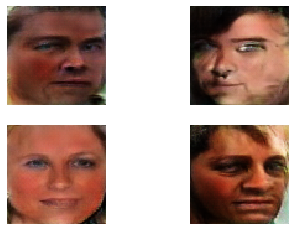

In [82]:
plot_faces(x_fake, 2)